In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [4]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    dc_1 = tf.layers.conv2d_transpose(h_in, 512, (2,2), (2,2), name='g_dc1')
    dc_1n = tf.layers.batch_normalization(dc_1, name='g_dc1n')
    dc_1a = tf.nn.relu(dc_1n, name='g_dc1a')
    
    dc_2 = tf.layers.conv2d_transpose(dc_1a, 256, (2,2),(2,2), name='g_dc2')
    dc_2n = tf.layers.batch_normalization(dc_2, name='g_dc2n')
    dc_2a = tf.nn.relu(dc_2n, name='g_dc2a')
    
    dc_3 = tf.layers.conv2d_transpose(dc_2a, 128, (2,2), (2,2), name='g_dc3')
    dc_3n = tf.layers.batch_normalization(dc_3, name='g_dc3n')
    dc_3a = tf.nn.relu(dc_3n, name='g_dc3a')

    c_0 = tf.layers.conv2d_transpose(dc_3a, 64, (3,3), padding='same', name='g_c0')
    c_0n = tf.layers.batch_normalization(c_0, name='g_c0n')
    c_0a = tf.nn.relu(c_0n, name='g_c0a')
    
    h_out = deconv2d(c_0a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [5]:
def discriminator(image, is_training, batch_norms=None):
    
    c_1 = tf.layers.conv2d(image, 64, (3,3), activation=tf.nn.relu, name='d_c1')
    c_1p = tf.layers.max_pooling2d(c_1, (2,2), (2,2), name='d_c1p')

    c_2 = tf.layers.conv2d(c_1p, 128, (3,3), activation=tf.nn.relu, name='d_c2')
    c_2p = tf.layers.max_pooling2d(c_2, (2,2), (2,2), name='d_c2p')

    c_3 = tf.layers.conv2d(c_2p, 256, (3,3), activation=tf.nn.relu, name='d_c3')
    c_3p = tf.layers.max_pooling2d(c_3, (2,2), (2,2), name='d_c3p')

    c_4 = tf.layers.conv2d(c_3p, 512, (3,3), activation=tf.nn.relu, name='d_c4')
    c_4p = tf.layers.max_pooling2d(c_4, (2,2), (2,2), name='d_c4p')
    
    flat = tf.contrib.layers.flatten(c_4p)
    d_1 = tf.layers.dense(flat, 1, name='d_d1')
    linear_out = d_1
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [48]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [49]:
"""
        THIS IS A BETTER LOSS. Observe that I do not use the _logit output of the network.
        Doing so often leads to zero or very poor gradient. The binary_crossentropy is able to calculate
        correct loss in a numerically stable way that preserves the gradient. This leads to faster and more stable
        training. With this loss, I get nice images that look like faces before the first epoch completes.
"""
d_loss_real = tf.reduce_mean(tf.contrib.keras.backend.binary_crossentropy(target=tf.ones_like(D_real_logits),
                                                           output=D_real,
                                                           from_logits=False),
                            axis=0)

d_loss_fake = tf.reduce_mean(tf.contrib.keras.backend.binary_crossentropy(target=tf.zeros_like(D_fake_logits),
                                                           output=D_fake,
                                                           from_logits=False),
                            axis=0)

d_loss = tf.div(tf.add(d_loss_real, d_loss_fake), 2)

g_loss = tf.reduce_mean(tf.contrib.keras.backend.binary_crossentropy(target=tf.ones_like(D_fake_logits),
                                                                     output=D_fake,
                                                                     from_logits=False),
                       axis=0)

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [50]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [15]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [16]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [46]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.global_variables_initializer().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            #print(epoch, idx, batch_idxs, errD_fake, errD_real, errG)
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake[0]+errD_real[0], errG[0]))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [51]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/3165] time: 0.5245, d_loss: 1.25904441, g_loss: 0.69030023
Epoch: [ 0] [   1/3165] time: 0.8229, d_loss: 1.12650704, g_loss: 0.68316865
Epoch: [ 0] [   2/3165] time: 1.1215, d_loss: 1.01037264, g_loss: 0.65682381
Epoch: [ 0] [   3/3165] time: 1.4215, d_loss: 0.99110872, g_loss: 0.57487118
Epoch: [ 0] [   4/3165] time: 1.7220, d_loss: 1.14949751, g_loss: 0.42997724
Epoch: [ 0] [   5/3165] time: 2.0206, d_loss: 1.30943251, g_loss: 0.35534561
Epoch: [ 0] [   6/3165] time: 2.3200, d_loss: 1.21242189, g_loss: 0.41171005
Epoch: [ 0] [   7/3165] time: 2.6197, d_loss: 0.99973679, g_loss: 0.54707730
Epoch: [ 0] [   8/3165] time: 2.9177, d_loss: 0.84179050, g_loss: 0.66533470
Epoch: [ 0] [   9/3165] time: 3.2172, d_loss: 0.73139232, g_loss: 0.73452306
Epoch: [ 0] [  10/3165] time: 3.5167, d_loss: 0.68538874, g_loss: 0.74777889
Epoch: [ 0] [  11/3165] time: 3.8155, d_loss: 0.63358855, g_loss: 0.79860175
Epoch: [ 0] [  12/3165] time: 4.1131, d_loss: 0.63805205, g_loss: 0.78716028

Epoch: [ 0] [ 106/3165] time: 35.5203, d_loss: 0.55904996, g_loss: 1.36133409
Epoch: [ 0] [ 107/3165] time: 35.8192, d_loss: 0.34776521, g_loss: 1.65089393
Epoch: [ 0] [ 108/3165] time: 36.1193, d_loss: 0.35449776, g_loss: 1.99537110
Epoch: [ 0] [ 109/3165] time: 36.4197, d_loss: 0.35548323, g_loss: 1.57405984
Epoch: [ 0] [ 110/3165] time: 36.7198, d_loss: 0.29336143, g_loss: 1.91791463
Epoch: [ 0] [ 111/3165] time: 37.0187, d_loss: 0.28099737, g_loss: 2.03332353
Epoch: [ 0] [ 112/3165] time: 37.3186, d_loss: 0.24791387, g_loss: 2.65219069
Epoch: [ 0] [ 113/3165] time: 37.6180, d_loss: 0.33746096, g_loss: 1.89724481
Epoch: [ 0] [ 114/3165] time: 37.9164, d_loss: 0.85082471, g_loss: 0.90385199
Epoch: [ 0] [ 115/3165] time: 38.2168, d_loss: 1.39330482, g_loss: 5.57250547
Epoch: [ 0] [ 116/3165] time: 38.5158, d_loss: 0.42188859, g_loss: 3.06414223
Epoch: [ 0] [ 117/3165] time: 38.8143, d_loss: 0.51303273, g_loss: 1.11991143
Epoch: [ 0] [ 118/3165] time: 39.1132, d_loss: 0.62132543, g_los

Epoch: [ 0] [ 211/3165] time: 71.0914, d_loss: 1.30017877, g_loss: 0.94542670
Epoch: [ 0] [ 212/3165] time: 71.3924, d_loss: 1.00459194, g_loss: 1.69090307
Epoch: [ 0] [ 213/3165] time: 71.6935, d_loss: 1.03298438, g_loss: 1.18631697
Epoch: [ 0] [ 214/3165] time: 71.9938, d_loss: 0.95748913, g_loss: 1.02703786
Epoch: [ 0] [ 215/3165] time: 72.2947, d_loss: 0.78707200, g_loss: 1.56349540
Epoch: [ 0] [ 216/3165] time: 72.5954, d_loss: 0.89230305, g_loss: 1.36460841
Epoch: [ 0] [ 217/3165] time: 72.8958, d_loss: 1.05818868, g_loss: 1.20974040
Epoch: [ 0] [ 218/3165] time: 73.1988, d_loss: 0.96762133, g_loss: 1.50013638
Epoch: [ 0] [ 219/3165] time: 73.4974, d_loss: 0.87782240, g_loss: 1.48279870
Epoch: [ 0] [ 220/3165] time: 73.7983, d_loss: 0.73680258, g_loss: 1.48755145
Epoch: [ 0] [ 221/3165] time: 74.0991, d_loss: 0.85896015, g_loss: 1.48714292
Epoch: [ 0] [ 222/3165] time: 74.4002, d_loss: 0.93479675, g_loss: 1.26104999
Epoch: [ 0] [ 223/3165] time: 74.7009, d_loss: 0.84836018, g_los

Epoch: [ 0] [ 316/3165] time: 106.3061, d_loss: 1.33823287, g_loss: 0.60968155
Epoch: [ 0] [ 317/3165] time: 106.6078, d_loss: 1.24697292, g_loss: 0.87466013
Epoch: [ 0] [ 318/3165] time: 106.9075, d_loss: 1.24769521, g_loss: 0.81810880
Epoch: [ 0] [ 319/3165] time: 107.2088, d_loss: 1.29493070, g_loss: 0.71090770
Epoch: [ 0] [ 320/3165] time: 107.5103, d_loss: 1.27327657, g_loss: 0.72356367
Epoch: [ 0] [ 321/3165] time: 107.8086, d_loss: 1.30573440, g_loss: 0.74377573
Epoch: [ 0] [ 322/3165] time: 108.1123, d_loss: 1.22909164, g_loss: 0.74337494
Epoch: [ 0] [ 323/3165] time: 108.4127, d_loss: 1.23471355, g_loss: 0.85401642
Epoch: [ 0] [ 324/3165] time: 108.7135, d_loss: 1.29111087, g_loss: 0.71778047
Epoch: [ 0] [ 325/3165] time: 109.0136, d_loss: 1.27175450, g_loss: 1.01800537
Epoch: [ 0] [ 326/3165] time: 109.3133, d_loss: 1.23261464, g_loss: 0.67963827
Epoch: [ 0] [ 327/3165] time: 109.6149, d_loss: 1.26621008, g_loss: 0.91114014
Epoch: [ 0] [ 328/3165] time: 109.9160, d_loss: 1.35

Epoch: [ 0] [ 420/3165] time: 141.8998, d_loss: 1.39246225, g_loss: 0.61770874
Epoch: [ 0] [ 421/3165] time: 142.1991, d_loss: 1.46396124, g_loss: 0.61734390
Epoch: [ 0] [ 422/3165] time: 142.4997, d_loss: 1.21942353, g_loss: 0.79776049
Epoch: [ 0] [ 423/3165] time: 142.7986, d_loss: 1.33206832, g_loss: 0.62443721
Epoch: [ 0] [ 424/3165] time: 143.0991, d_loss: 1.40867484, g_loss: 1.08570123
Epoch: [ 0] [ 425/3165] time: 143.3996, d_loss: 1.40297055, g_loss: 0.52592981
Epoch: [ 0] [ 426/3165] time: 143.7007, d_loss: 1.22708368, g_loss: 0.87375414
Epoch: [ 0] [ 427/3165] time: 144.0012, d_loss: 1.17107368, g_loss: 0.83993995
Epoch: [ 0] [ 428/3165] time: 144.3004, d_loss: 1.34634054, g_loss: 0.61276942
Epoch: [ 0] [ 429/3165] time: 144.6007, d_loss: 1.30400443, g_loss: 0.84788656
Epoch: [ 0] [ 430/3165] time: 144.9012, d_loss: 1.30937564, g_loss: 0.69846344
Epoch: [ 0] [ 431/3165] time: 145.2030, d_loss: 1.31401539, g_loss: 0.76567024
Epoch: [ 0] [ 432/3165] time: 145.5056, d_loss: 1.30

Epoch: [ 0] [ 524/3165] time: 176.5864, d_loss: 1.36902285, g_loss: 0.79019845
Epoch: [ 0] [ 525/3165] time: 176.8870, d_loss: 1.30970335, g_loss: 0.80728841
Epoch: [ 0] [ 526/3165] time: 177.1881, d_loss: 1.36653256, g_loss: 0.67831057
Epoch: [ 0] [ 527/3165] time: 177.4888, d_loss: 1.30713403, g_loss: 0.80627358
Epoch: [ 0] [ 528/3165] time: 177.7898, d_loss: 1.33424091, g_loss: 0.74343932
Epoch: [ 0] [ 529/3165] time: 178.0908, d_loss: 1.28727782, g_loss: 0.76026928
Epoch: [ 0] [ 530/3165] time: 178.3915, d_loss: 1.30883503, g_loss: 0.83666801
Epoch: [ 0] [ 531/3165] time: 178.6924, d_loss: 1.26376653, g_loss: 0.72881186
Epoch: [ 0] [ 532/3165] time: 178.9925, d_loss: 1.25209951, g_loss: 0.80500448
Epoch: [ 0] [ 533/3165] time: 179.2926, d_loss: 1.28994203, g_loss: 0.83023983
Epoch: [ 0] [ 534/3165] time: 179.5952, d_loss: 1.32111359, g_loss: 0.67534399
Epoch: [ 0] [ 535/3165] time: 179.8973, d_loss: 1.33086431, g_loss: 0.72036022
Epoch: [ 0] [ 536/3165] time: 180.1993, d_loss: 1.32

Epoch: [ 0] [ 628/3165] time: 212.0917, d_loss: 1.40537882, g_loss: 0.56741953
Epoch: [ 0] [ 629/3165] time: 212.3921, d_loss: 1.30605662, g_loss: 0.84326982
Epoch: [ 0] [ 630/3165] time: 212.6919, d_loss: 1.35867739, g_loss: 0.63235950
Epoch: [ 0] [ 631/3165] time: 212.9936, d_loss: 1.27688670, g_loss: 0.74699986
Epoch: [ 0] [ 632/3165] time: 213.2943, d_loss: 1.27141082, g_loss: 0.75929010
Epoch: [ 0] [ 633/3165] time: 213.5944, d_loss: 1.31788993, g_loss: 0.62653559
Epoch: [ 0] [ 634/3165] time: 213.8953, d_loss: 1.27072549, g_loss: 0.79841769
Epoch: [ 0] [ 635/3165] time: 214.1953, d_loss: 1.31354737, g_loss: 0.60529810
Epoch: [ 0] [ 636/3165] time: 214.4953, d_loss: 1.30749929, g_loss: 0.76600027
Epoch: [ 0] [ 637/3165] time: 214.7957, d_loss: 1.27085948, g_loss: 0.65429187
Epoch: [ 0] [ 638/3165] time: 215.0951, d_loss: 1.28773642, g_loss: 0.76289701
Epoch: [ 0] [ 639/3165] time: 215.3948, d_loss: 1.30520725, g_loss: 0.68809879
Epoch: [ 0] [ 640/3165] time: 215.6955, d_loss: 1.29

Epoch: [ 0] [ 732/3165] time: 247.5305, d_loss: 1.36904633, g_loss: 0.66366124
Epoch: [ 0] [ 733/3165] time: 247.8306, d_loss: 1.26285422, g_loss: 0.73008698
Epoch: [ 0] [ 734/3165] time: 248.1317, d_loss: 1.29347050, g_loss: 0.69748247
Epoch: [ 0] [ 735/3165] time: 248.4327, d_loss: 1.31414163, g_loss: 0.70826352
Epoch: [ 0] [ 736/3165] time: 248.7339, d_loss: 1.27098238, g_loss: 0.97888666
Epoch: [ 0] [ 737/3165] time: 249.0349, d_loss: 1.37412262, g_loss: 0.53984731
Epoch: [ 0] [ 738/3165] time: 249.3362, d_loss: 1.32600093, g_loss: 1.00082529
Epoch: [ 0] [ 739/3165] time: 249.6366, d_loss: 1.32556319, g_loss: 0.65213233
Epoch: [ 0] [ 740/3165] time: 249.9355, d_loss: 1.34703779, g_loss: 0.69164944
Epoch: [ 0] [ 741/3165] time: 250.2361, d_loss: 1.36586547, g_loss: 0.77032137
Epoch: [ 0] [ 742/3165] time: 250.5373, d_loss: 1.35379100, g_loss: 0.63959551
Epoch: [ 0] [ 743/3165] time: 250.8379, d_loss: 1.45589209, g_loss: 0.75290096
Epoch: [ 0] [ 744/3165] time: 251.1385, d_loss: 1.47

Epoch: [ 0] [ 836/3165] time: 282.0990, d_loss: 1.36813235, g_loss: 0.70716715
Epoch: [ 0] [ 837/3165] time: 282.3999, d_loss: 1.38783717, g_loss: 0.64475989
Epoch: [ 0] [ 838/3165] time: 282.7001, d_loss: 1.38731003, g_loss: 0.83447927
Epoch: [ 0] [ 839/3165] time: 283.0009, d_loss: 1.41227758, g_loss: 0.62669098
Epoch: [ 0] [ 840/3165] time: 283.3028, d_loss: 1.36835909, g_loss: 0.83947837
Epoch: [ 0] [ 841/3165] time: 283.6040, d_loss: 1.38699698, g_loss: 0.59814882
Epoch: [ 0] [ 842/3165] time: 283.9052, d_loss: 1.32772231, g_loss: 0.77750748
Epoch: [ 0] [ 843/3165] time: 284.2057, d_loss: 1.30578339, g_loss: 0.65183020
Epoch: [ 0] [ 844/3165] time: 284.5059, d_loss: 1.35520911, g_loss: 0.71692050
Epoch: [ 0] [ 845/3165] time: 284.8080, d_loss: 1.33810973, g_loss: 0.69399196
Epoch: [ 0] [ 846/3165] time: 285.1084, d_loss: 1.35097790, g_loss: 0.61157328
Epoch: [ 0] [ 847/3165] time: 285.4091, d_loss: 1.36918902, g_loss: 0.79572219
Epoch: [ 0] [ 848/3165] time: 285.7093, d_loss: 1.38

Epoch: [ 0] [ 940/3165] time: 317.5962, d_loss: 1.38258433, g_loss: 0.69832778
Epoch: [ 0] [ 941/3165] time: 317.8970, d_loss: 1.38488638, g_loss: 0.68790746
Epoch: [ 0] [ 942/3165] time: 318.2005, d_loss: 1.33416772, g_loss: 0.67350030
Epoch: [ 0] [ 943/3165] time: 318.4994, d_loss: 1.32866049, g_loss: 0.76796484
Epoch: [ 0] [ 944/3165] time: 318.8003, d_loss: 1.34070241, g_loss: 0.64792466
Epoch: [ 0] [ 945/3165] time: 319.1006, d_loss: 1.37293124, g_loss: 0.79155350
Epoch: [ 0] [ 946/3165] time: 319.4019, d_loss: 1.40422070, g_loss: 0.61139357
Epoch: [ 0] [ 947/3165] time: 319.7022, d_loss: 1.41452026, g_loss: 0.77424622
Epoch: [ 0] [ 948/3165] time: 320.0040, d_loss: 1.41554391, g_loss: 0.68584156
Epoch: [ 0] [ 949/3165] time: 320.3054, d_loss: 1.39646220, g_loss: 0.65140247
Epoch: [ 0] [ 950/3165] time: 320.6068, d_loss: 1.35415876, g_loss: 0.75177836
Epoch: [ 0] [ 951/3165] time: 320.9071, d_loss: 1.34652865, g_loss: 0.68916512
Epoch: [ 0] [ 952/3165] time: 321.2071, d_loss: 1.25

Epoch: [ 0] [1044/3165] time: 352.0429, d_loss: 1.36301780, g_loss: 0.65960586
Epoch: [ 0] [1045/3165] time: 352.3435, d_loss: 1.42274880, g_loss: 0.79455179
Epoch: [ 0] [1046/3165] time: 352.6443, d_loss: 1.43699932, g_loss: 0.57315809
Epoch: [ 0] [1047/3165] time: 352.9445, d_loss: 1.36128545, g_loss: 0.98328942
Epoch: [ 0] [1048/3165] time: 353.2452, d_loss: 1.32149851, g_loss: 0.54269463
Epoch: [ 0] [1049/3165] time: 353.5463, d_loss: 1.30794632, g_loss: 0.98596179
Epoch: [ 0] [1050/3165] time: 353.8468, d_loss: 1.36648190, g_loss: 0.56664842
Epoch: [ 0] [1051/3165] time: 354.1479, d_loss: 1.33758497, g_loss: 0.66068935
Epoch: [ 0] [1052/3165] time: 354.4471, d_loss: 1.36579013, g_loss: 0.75677496
Epoch: [ 0] [1053/3165] time: 354.7474, d_loss: 1.35461736, g_loss: 0.57021523
Epoch: [ 0] [1054/3165] time: 355.0477, d_loss: 1.34922004, g_loss: 0.75673431
Epoch: [ 0] [1055/3165] time: 355.3480, d_loss: 1.39609742, g_loss: 0.57566285
Epoch: [ 0] [1056/3165] time: 355.6478, d_loss: 1.37

Epoch: [ 0] [1148/3165] time: 387.4273, d_loss: 1.32707238, g_loss: 0.70898128
Epoch: [ 0] [1149/3165] time: 387.7271, d_loss: 1.33964658, g_loss: 0.73802042
Epoch: [ 0] [1150/3165] time: 388.0286, d_loss: 1.32134473, g_loss: 0.66794175
Epoch: [ 0] [1151/3165] time: 388.3278, d_loss: 1.30743623, g_loss: 0.73774672
Epoch: [ 0] [1152/3165] time: 388.6279, d_loss: 1.31567454, g_loss: 0.79089844
Epoch: [ 0] [1153/3165] time: 388.9283, d_loss: 1.31388509, g_loss: 0.69960880
Epoch: [ 0] [1154/3165] time: 389.2287, d_loss: 1.34993637, g_loss: 0.83939242
Epoch: [ 0] [1155/3165] time: 389.5292, d_loss: 1.35599065, g_loss: 0.65641236
Epoch: [ 0] [1156/3165] time: 389.8298, d_loss: 1.28536034, g_loss: 0.83479589
Epoch: [ 0] [1157/3165] time: 390.1303, d_loss: 1.38869572, g_loss: 0.63052475
Epoch: [ 0] [1158/3165] time: 390.4302, d_loss: 1.43672562, g_loss: 0.73065603
Epoch: [ 0] [1159/3165] time: 390.7322, d_loss: 1.46380174, g_loss: 0.64442754
Epoch: [ 0] [1160/3165] time: 391.0341, d_loss: 1.43

Epoch: [ 0] [1252/3165] time: 422.7143, d_loss: 1.43541229, g_loss: 0.56475222
Epoch: [ 0] [1253/3165] time: 423.0303, d_loss: 1.37055302, g_loss: 0.72416812
Epoch: [ 0] [1254/3165] time: 423.3460, d_loss: 1.33608210, g_loss: 0.67380691
Epoch: [ 0] [1255/3165] time: 423.6463, d_loss: 1.29022503, g_loss: 0.67984295
Epoch: [ 0] [1256/3165] time: 423.9475, d_loss: 1.24501908, g_loss: 0.66942364
Epoch: [ 0] [1257/3165] time: 424.2479, d_loss: 1.31977594, g_loss: 0.65165806
Epoch: [ 0] [1258/3165] time: 424.5482, d_loss: 1.47983146, g_loss: 0.64555132
Epoch: [ 0] [1259/3165] time: 424.8485, d_loss: 1.46600556, g_loss: 0.57569313
Epoch: [ 0] [1260/3165] time: 425.1480, d_loss: 1.29683709, g_loss: 0.61610848
Epoch: [ 0] [1261/3165] time: 425.4487, d_loss: 1.16421723, g_loss: 0.67323589
Epoch: [ 0] [1262/3165] time: 425.7503, d_loss: 1.25712204, g_loss: 0.64839619
Epoch: [ 0] [1263/3165] time: 426.0513, d_loss: 1.36873734, g_loss: 0.70371008
Epoch: [ 0] [1264/3165] time: 426.3508, d_loss: 1.47

Epoch: [ 0] [1356/3165] time: 457.1789, d_loss: 1.32425737, g_loss: 0.62729239
Epoch: [ 0] [1357/3165] time: 457.4817, d_loss: 1.33341622, g_loss: 0.70984221
Epoch: [ 0] [1358/3165] time: 457.7824, d_loss: 1.39393902, g_loss: 0.71734446
Epoch: [ 0] [1359/3165] time: 458.0843, d_loss: 1.39207315, g_loss: 0.69585943
Epoch: [ 0] [1360/3165] time: 458.3835, d_loss: 1.40747547, g_loss: 0.65585089
Epoch: [ 0] [1361/3165] time: 458.6843, d_loss: 1.35529459, g_loss: 0.64948964
Epoch: [ 0] [1362/3165] time: 458.9849, d_loss: 1.34606063, g_loss: 0.72350764
Epoch: [ 0] [1363/3165] time: 459.2850, d_loss: 1.35980117, g_loss: 0.69721466
Epoch: [ 0] [1364/3165] time: 459.5854, d_loss: 1.40577269, g_loss: 0.72136617
Epoch: [ 0] [1365/3165] time: 459.8863, d_loss: 1.35434198, g_loss: 0.68344980
Epoch: [ 0] [1366/3165] time: 460.1868, d_loss: 1.29181075, g_loss: 0.65503228
Epoch: [ 0] [1367/3165] time: 460.4859, d_loss: 1.27249312, g_loss: 0.72859561
Epoch: [ 0] [1368/3165] time: 460.7853, d_loss: 1.32

Epoch: [ 0] [1460/3165] time: 492.5422, d_loss: 1.32866764, g_loss: 0.70177710
Epoch: [ 0] [1461/3165] time: 492.8431, d_loss: 1.31522417, g_loss: 0.66615623
Epoch: [ 0] [1462/3165] time: 493.1453, d_loss: 1.33372891, g_loss: 0.65673745
Epoch: [ 0] [1463/3165] time: 493.4464, d_loss: 1.38018012, g_loss: 0.66904229
Epoch: [ 0] [1464/3165] time: 493.7472, d_loss: 1.40522766, g_loss: 0.63067436
Epoch: [ 0] [1465/3165] time: 494.0478, d_loss: 1.37419498, g_loss: 0.66622770
Epoch: [ 0] [1466/3165] time: 494.3494, d_loss: 1.35703123, g_loss: 0.75340068
Epoch: [ 0] [1467/3165] time: 494.6500, d_loss: 1.38641751, g_loss: 0.62398112
Epoch: [ 0] [1468/3165] time: 494.9505, d_loss: 1.43920660, g_loss: 0.65968490
Epoch: [ 0] [1469/3165] time: 495.2501, d_loss: 1.41216314, g_loss: 0.77924132
Epoch: [ 0] [1470/3165] time: 495.5501, d_loss: 1.43888569, g_loss: 0.60713804
Epoch: [ 0] [1471/3165] time: 495.8505, d_loss: 1.38897538, g_loss: 0.80217922
Epoch: [ 0] [1472/3165] time: 496.1505, d_loss: 1.39

Epoch: [ 0] [1564/3165] time: 527.8324, d_loss: 1.31047630, g_loss: 0.70440769
Epoch: [ 0] [1565/3165] time: 528.1346, d_loss: 1.30717278, g_loss: 0.69638896
Epoch: [ 0] [1566/3165] time: 528.4351, d_loss: 1.35109544, g_loss: 0.66611099
Epoch: [ 0] [1567/3165] time: 528.7355, d_loss: 1.36307335, g_loss: 0.67870879
Epoch: [ 0] [1568/3165] time: 529.0358, d_loss: 1.39396179, g_loss: 0.64951676
Epoch: [ 0] [1569/3165] time: 529.3373, d_loss: 1.38273358, g_loss: 0.73129153
Epoch: [ 0] [1570/3165] time: 529.6376, d_loss: 1.39153910, g_loss: 0.64385200
Epoch: [ 0] [1571/3165] time: 529.9385, d_loss: 1.33182108, g_loss: 0.67586166
Epoch: [ 0] [1572/3165] time: 530.2393, d_loss: 1.32876062, g_loss: 0.78922725
Epoch: [ 0] [1573/3165] time: 530.5404, d_loss: 1.30069137, g_loss: 0.64060581
Epoch: [ 0] [1574/3165] time: 530.8416, d_loss: 1.19158387, g_loss: 0.84362984
Epoch: [ 0] [1575/3165] time: 531.1420, d_loss: 1.39301586, g_loss: 0.62159020
Epoch: [ 0] [1576/3165] time: 531.4423, d_loss: 1.39

Epoch: [ 0] [1668/3165] time: 562.2585, d_loss: 1.32005262, g_loss: 0.63838786
Epoch: [ 0] [1669/3165] time: 562.5590, d_loss: 1.31672633, g_loss: 0.77547425
Epoch: [ 0] [1670/3165] time: 562.8589, d_loss: 1.36473763, g_loss: 0.64981127
Epoch: [ 0] [1671/3165] time: 563.1619, d_loss: 1.38541400, g_loss: 0.70156920
Epoch: [ 0] [1672/3165] time: 563.4622, d_loss: 1.33143568, g_loss: 0.66630220
Epoch: [ 0] [1673/3165] time: 563.7628, d_loss: 1.30288720, g_loss: 0.77851433
Epoch: [ 0] [1674/3165] time: 564.0635, d_loss: 1.33258891, g_loss: 0.63667798
Epoch: [ 0] [1675/3165] time: 564.3637, d_loss: 1.27527702, g_loss: 0.96358609
Epoch: [ 0] [1676/3165] time: 564.6639, d_loss: 1.46092892, g_loss: 0.50663447
Epoch: [ 0] [1677/3165] time: 564.9651, d_loss: 1.37811518, g_loss: 1.03416181
Epoch: [ 0] [1678/3165] time: 565.2655, d_loss: 1.42996752, g_loss: 0.53665996
Epoch: [ 0] [1679/3165] time: 565.5665, d_loss: 1.30531049, g_loss: 0.82047832
Epoch: [ 0] [1680/3165] time: 565.8669, d_loss: 1.28

Epoch: [ 0] [1772/3165] time: 597.6117, d_loss: 1.41565609, g_loss: 0.63330567
Epoch: [ 0] [1773/3165] time: 597.9121, d_loss: 1.36878657, g_loss: 0.68591899
Epoch: [ 0] [1774/3165] time: 598.2132, d_loss: 1.32272363, g_loss: 0.65247613
Epoch: [ 0] [1775/3165] time: 598.5137, d_loss: 1.32440925, g_loss: 0.74460727
Epoch: [ 0] [1776/3165] time: 598.8132, d_loss: 1.29810512, g_loss: 0.70357323
Epoch: [ 0] [1777/3165] time: 599.1140, d_loss: 1.35119879, g_loss: 0.69081950
Epoch: [ 0] [1778/3165] time: 599.4151, d_loss: 1.41653967, g_loss: 0.67461824
Epoch: [ 0] [1779/3165] time: 599.7154, d_loss: 1.40790963, g_loss: 0.68066013
Epoch: [ 0] [1780/3165] time: 600.0156, d_loss: 1.30496812, g_loss: 0.67911637
Epoch: [ 0] [1781/3165] time: 600.3155, d_loss: 1.31675816, g_loss: 0.66370869
Epoch: [ 0] [1782/3165] time: 600.6161, d_loss: 1.40555453, g_loss: 0.61446166
Epoch: [ 0] [1783/3165] time: 600.9166, d_loss: 1.46266162, g_loss: 0.66144729
Epoch: [ 0] [1784/3165] time: 601.2181, d_loss: 1.54

Epoch: [ 0] [1876/3165] time: 632.1088, d_loss: 1.50143099, g_loss: 0.53365552
Epoch: [ 0] [1877/3165] time: 632.4110, d_loss: 1.41794157, g_loss: 0.85882717
Epoch: [ 0] [1878/3165] time: 632.7115, d_loss: 1.36898994, g_loss: 0.61639851
Epoch: [ 0] [1879/3165] time: 633.0126, d_loss: 1.28150058, g_loss: 0.83849877
Epoch: [ 0] [1880/3165] time: 633.3127, d_loss: 1.29579866, g_loss: 0.74145883
Epoch: [ 0] [1881/3165] time: 633.6161, d_loss: 1.29566169, g_loss: 0.66722280
Epoch: [ 0] [1882/3165] time: 633.9200, d_loss: 1.42075014, g_loss: 0.74142224
Epoch: [ 0] [1883/3165] time: 634.2255, d_loss: 1.57923567, g_loss: 0.47792968
Epoch: [ 0] [1884/3165] time: 634.5314, d_loss: 1.44501817, g_loss: 0.69526517
Epoch: [ 0] [1885/3165] time: 634.8362, d_loss: 1.38071465, g_loss: 0.63293040
Epoch: [ 0] [1886/3165] time: 635.1422, d_loss: 1.41077435, g_loss: 0.56525266
Epoch: [ 0] [1887/3165] time: 635.4474, d_loss: 1.40818381, g_loss: 0.64748585
Epoch: [ 0] [1888/3165] time: 635.7552, d_loss: 1.46

Epoch: [ 0] [1980/3165] time: 667.4157, d_loss: 1.34632349, g_loss: 0.67305326
Epoch: [ 0] [1981/3165] time: 667.7159, d_loss: 1.47904575, g_loss: 0.62587410
Epoch: [ 0] [1982/3165] time: 668.0165, d_loss: 1.43967271, g_loss: 0.66144705
Epoch: [ 0] [1983/3165] time: 668.3175, d_loss: 1.36771560, g_loss: 0.69388348
Epoch: [ 0] [1984/3165] time: 668.6208, d_loss: 1.27683711, g_loss: 0.64952964
Epoch: [ 0] [1985/3165] time: 668.9211, d_loss: 1.22224736, g_loss: 0.66444373
Epoch: [ 0] [1986/3165] time: 669.2236, d_loss: 1.25832915, g_loss: 0.72261059
Epoch: [ 0] [1987/3165] time: 669.5240, d_loss: 1.30984974, g_loss: 0.72435093
Epoch: [ 0] [1988/3165] time: 669.8252, d_loss: 1.37610579, g_loss: 0.68485308
Epoch: [ 0] [1989/3165] time: 670.1257, d_loss: 1.43112004, g_loss: 0.64151847
Epoch: [ 0] [1990/3165] time: 670.4269, d_loss: 1.39091861, g_loss: 0.64919114
Epoch: [ 0] [1991/3165] time: 670.7274, d_loss: 1.39649820, g_loss: 0.67566305
Epoch: [ 0] [1992/3165] time: 671.0278, d_loss: 1.35

Epoch: [ 0] [2084/3165] time: 701.9358, d_loss: 1.31734192, g_loss: 0.72449166
Epoch: [ 0] [2085/3165] time: 702.2450, d_loss: 1.37422407, g_loss: 0.74450403
Epoch: [ 0] [2086/3165] time: 702.5524, d_loss: 1.47631407, g_loss: 0.69619036
Epoch: [ 0] [2087/3165] time: 702.8607, d_loss: 1.39586258, g_loss: 0.74311376
Epoch: [ 0] [2088/3165] time: 703.1727, d_loss: 1.35060430, g_loss: 0.63575852
Epoch: [ 0] [2089/3165] time: 703.4816, d_loss: 1.31167960, g_loss: 0.68443114
Epoch: [ 0] [2090/3165] time: 703.7901, d_loss: 1.30158460, g_loss: 0.76095247
Epoch: [ 0] [2091/3165] time: 704.0988, d_loss: 1.42471313, g_loss: 0.58093071
Epoch: [ 0] [2092/3165] time: 704.4076, d_loss: 1.38609958, g_loss: 0.62289214
Epoch: [ 0] [2093/3165] time: 704.7173, d_loss: 1.35110295, g_loss: 0.64441031
Epoch: [ 0] [2094/3165] time: 705.0274, d_loss: 1.32894182, g_loss: 0.60674560
Epoch: [ 0] [2095/3165] time: 705.3368, d_loss: 1.29470086, g_loss: 0.73849756
Epoch: [ 0] [2096/3165] time: 705.6454, d_loss: 1.36

Epoch: [ 0] [2188/3165] time: 737.3249, d_loss: 1.36914766, g_loss: 0.69368935
Epoch: [ 0] [2189/3165] time: 737.6257, d_loss: 1.29589951, g_loss: 0.69275016
Epoch: [ 0] [2190/3165] time: 737.9286, d_loss: 1.30437613, g_loss: 0.76738358
Epoch: [ 0] [2191/3165] time: 738.2287, d_loss: 1.37919092, g_loss: 0.65976989
Epoch: [ 0] [2192/3165] time: 738.5320, d_loss: 1.29831970, g_loss: 0.76416612
Epoch: [ 0] [2193/3165] time: 738.8335, d_loss: 1.38085890, g_loss: 0.58400464
Epoch: [ 0] [2194/3165] time: 739.1338, d_loss: 1.33200836, g_loss: 0.91459727
Epoch: [ 0] [2195/3165] time: 739.4377, d_loss: 1.39094806, g_loss: 0.56630933
Epoch: [ 0] [2196/3165] time: 739.7398, d_loss: 1.30833948, g_loss: 0.88196218
Epoch: [ 0] [2197/3165] time: 740.0427, d_loss: 1.35827446, g_loss: 0.56858659
Epoch: [ 0] [2198/3165] time: 740.3476, d_loss: 1.29793561, g_loss: 0.81196904
Epoch: [ 0] [2199/3165] time: 740.6517, d_loss: 1.34103310, g_loss: 0.59888554
Saved model
Sample
Epoch: [ 0] [2200/3165] time: 744

Epoch: [ 0] [2292/3165] time: 772.6925, d_loss: 1.37581801, g_loss: 0.80569565
Epoch: [ 0] [2293/3165] time: 772.9994, d_loss: 1.40066266, g_loss: 0.67868197
Epoch: [ 0] [2294/3165] time: 773.3064, d_loss: 1.41780400, g_loss: 0.70552671
Epoch: [ 0] [2295/3165] time: 773.6149, d_loss: 1.40331745, g_loss: 0.67019439
Epoch: [ 0] [2296/3165] time: 773.9219, d_loss: 1.33227277, g_loss: 0.76510853
Epoch: [ 0] [2297/3165] time: 774.2295, d_loss: 1.34631574, g_loss: 0.81652939
Epoch: [ 0] [2298/3165] time: 774.5373, d_loss: 1.36952066, g_loss: 0.67662942
Epoch: [ 0] [2299/3165] time: 774.8444, d_loss: 1.38622332, g_loss: 0.60840482
Saved model
Sample
Epoch: [ 0] [2300/3165] time: 778.2926, d_loss: 1.39198685, g_loss: 0.79788256
Epoch: [ 0] [2301/3165] time: 778.5966, d_loss: 1.40302944, g_loss: 0.64887965
Epoch: [ 0] [2302/3165] time: 778.8978, d_loss: 1.40792012, g_loss: 0.59129834
Epoch: [ 0] [2303/3165] time: 779.2020, d_loss: 1.31685936, g_loss: 0.74202538
Epoch: [ 0] [2304/3165] time: 779

Epoch: [ 0] [2396/3165] time: 807.2409, d_loss: 1.41671181, g_loss: 0.66585970
Epoch: [ 0] [2397/3165] time: 807.5490, d_loss: 1.43177342, g_loss: 0.61236829
Epoch: [ 0] [2398/3165] time: 807.8565, d_loss: 1.47357655, g_loss: 0.60321468
Epoch: [ 0] [2399/3165] time: 808.1673, d_loss: 1.39489293, g_loss: 0.73227000
Saved model
Sample
Epoch: [ 0] [2400/3165] time: 812.6148, d_loss: 1.38287091, g_loss: 0.70551765
Epoch: [ 0] [2401/3165] time: 812.9182, d_loss: 1.39348567, g_loss: 0.65808636
Epoch: [ 0] [2402/3165] time: 813.2212, d_loss: 1.43225336, g_loss: 0.70656455
Epoch: [ 0] [2403/3165] time: 813.5212, d_loss: 1.43489873, g_loss: 0.67158043
Epoch: [ 0] [2404/3165] time: 813.8243, d_loss: 1.45044327, g_loss: 0.65206766
Epoch: [ 0] [2405/3165] time: 814.1249, d_loss: 1.45501506, g_loss: 0.67583495
Epoch: [ 0] [2406/3165] time: 814.4255, d_loss: 1.47876287, g_loss: 0.68739343
Epoch: [ 0] [2407/3165] time: 814.7261, d_loss: 1.43724906, g_loss: 0.71436185
Epoch: [ 0] [2408/3165] time: 815

Sample
Epoch: [ 0] [2500/3165] time: 845.8345, d_loss: 1.33347416, g_loss: 0.60639262
Epoch: [ 0] [2501/3165] time: 846.1385, d_loss: 1.38836217, g_loss: 0.62344742
Epoch: [ 0] [2502/3165] time: 846.4387, d_loss: 1.40143991, g_loss: 0.64840460
Epoch: [ 0] [2503/3165] time: 846.7401, d_loss: 1.38869023, g_loss: 0.66507733
Epoch: [ 0] [2504/3165] time: 847.0618, d_loss: 1.42347467, g_loss: 0.55342436
Epoch: [ 0] [2505/3165] time: 847.3615, d_loss: 1.38469481, g_loss: 0.59310997
Epoch: [ 0] [2506/3165] time: 847.6623, d_loss: 1.30387878, g_loss: 0.68138832
Epoch: [ 0] [2507/3165] time: 847.9619, d_loss: 1.29992867, g_loss: 0.74699110
Epoch: [ 0] [2508/3165] time: 848.2626, d_loss: 1.35812402, g_loss: 0.60661823
Epoch: [ 0] [2509/3165] time: 848.5645, d_loss: 1.37315905, g_loss: 0.66878247
Epoch: [ 0] [2510/3165] time: 848.8659, d_loss: 1.35552073, g_loss: 0.79591656
Epoch: [ 0] [2511/3165] time: 849.1664, d_loss: 1.34469807, g_loss: 0.60416108
Epoch: [ 0] [2512/3165] time: 849.4657, d_los

Epoch: [ 0] [2604/3165] time: 881.1393, d_loss: 1.40644407, g_loss: 1.03818917
Epoch: [ 0] [2605/3165] time: 881.4407, d_loss: 1.45117259, g_loss: 0.58591676
Epoch: [ 0] [2606/3165] time: 881.7407, d_loss: 1.50363028, g_loss: 0.61395770
Epoch: [ 0] [2607/3165] time: 882.0404, d_loss: 1.48652053, g_loss: 0.75759041
Epoch: [ 0] [2608/3165] time: 882.3417, d_loss: 1.37309694, g_loss: 0.64332360
Epoch: [ 0] [2609/3165] time: 882.6421, d_loss: 1.26800346, g_loss: 0.71630269
Epoch: [ 0] [2610/3165] time: 882.9447, d_loss: 1.34466124, g_loss: 0.67250705
Epoch: [ 0] [2611/3165] time: 883.2478, d_loss: 1.44545627, g_loss: 0.58041811
Epoch: [ 0] [2612/3165] time: 883.5479, d_loss: 1.41984928, g_loss: 0.60620689
Epoch: [ 0] [2613/3165] time: 883.8484, d_loss: 1.42034495, g_loss: 0.66775751
Epoch: [ 0] [2614/3165] time: 884.1511, d_loss: 1.38084984, g_loss: 0.65145910
Epoch: [ 0] [2615/3165] time: 884.4527, d_loss: 1.37077737, g_loss: 0.63424367
Epoch: [ 0] [2616/3165] time: 884.7528, d_loss: 1.31

Epoch: [ 0] [2708/3165] time: 915.5714, d_loss: 1.37523127, g_loss: 0.62766898
Epoch: [ 0] [2709/3165] time: 915.8721, d_loss: 1.40382361, g_loss: 0.70367491
Epoch: [ 0] [2710/3165] time: 916.1729, d_loss: 1.49473166, g_loss: 0.55979669
Epoch: [ 0] [2711/3165] time: 916.4730, d_loss: 1.46591949, g_loss: 0.70446670
Epoch: [ 0] [2712/3165] time: 916.7743, d_loss: 1.45060515, g_loss: 0.63505912
Epoch: [ 0] [2713/3165] time: 917.0736, d_loss: 1.39354801, g_loss: 0.65672517
Epoch: [ 0] [2714/3165] time: 917.3726, d_loss: 1.27770817, g_loss: 0.77199048
Epoch: [ 0] [2715/3165] time: 917.6740, d_loss: 1.20740819, g_loss: 0.74393731
Epoch: [ 0] [2716/3165] time: 917.9751, d_loss: 1.35573339, g_loss: 0.61937648
Epoch: [ 0] [2717/3165] time: 918.2758, d_loss: 1.44750094, g_loss: 0.69603157
Epoch: [ 0] [2718/3165] time: 918.5756, d_loss: 1.51053119, g_loss: 0.60103405
Epoch: [ 0] [2719/3165] time: 918.8764, d_loss: 1.47789633, g_loss: 0.58238840
Epoch: [ 0] [2720/3165] time: 919.1760, d_loss: 1.37

Epoch: [ 0] [2812/3165] time: 950.9732, d_loss: 1.62516749, g_loss: 0.30534914
Epoch: [ 0] [2813/3165] time: 951.2742, d_loss: 1.56792688, g_loss: 1.47100377
Epoch: [ 0] [2814/3165] time: 951.5755, d_loss: 1.29534507, g_loss: 0.50688088
Epoch: [ 0] [2815/3165] time: 951.8759, d_loss: 1.43136239, g_loss: 0.45465875
Epoch: [ 0] [2816/3165] time: 952.1763, d_loss: 1.41579032, g_loss: 0.94335538
Epoch: [ 0] [2817/3165] time: 952.4776, d_loss: 1.42196894, g_loss: 0.76040578
Epoch: [ 0] [2818/3165] time: 952.7787, d_loss: 1.38431120, g_loss: 0.57458770
Epoch: [ 0] [2819/3165] time: 953.0807, d_loss: 1.32678938, g_loss: 0.72484410
Epoch: [ 0] [2820/3165] time: 953.3803, d_loss: 1.34734297, g_loss: 0.78739625
Epoch: [ 0] [2821/3165] time: 953.6798, d_loss: 1.34294999, g_loss: 0.68673778
Epoch: [ 0] [2822/3165] time: 953.9801, d_loss: 1.38577461, g_loss: 0.62275231
Epoch: [ 0] [2823/3165] time: 954.2800, d_loss: 1.38764083, g_loss: 0.65751672
Epoch: [ 0] [2824/3165] time: 954.5803, d_loss: 1.38

Epoch: [ 0] [2916/3165] time: 986.3080, d_loss: 1.43985558, g_loss: 0.56348932
Epoch: [ 0] [2917/3165] time: 986.6081, d_loss: 1.39336109, g_loss: 0.64031738
Epoch: [ 0] [2918/3165] time: 986.9096, d_loss: 1.41795897, g_loss: 0.79033184
Epoch: [ 0] [2919/3165] time: 987.2100, d_loss: 1.40406883, g_loss: 0.67424947
Epoch: [ 0] [2920/3165] time: 987.5105, d_loss: 1.41936970, g_loss: 0.57363594
Epoch: [ 0] [2921/3165] time: 987.8143, d_loss: 1.41268468, g_loss: 0.75642329
Epoch: [ 0] [2922/3165] time: 988.1175, d_loss: 1.35937810, g_loss: 0.74552977
Epoch: [ 0] [2923/3165] time: 988.4177, d_loss: 1.38773131, g_loss: 0.65228295
Epoch: [ 0] [2924/3165] time: 988.7174, d_loss: 1.42574358, g_loss: 0.70712650
Epoch: [ 0] [2925/3165] time: 989.0181, d_loss: 1.43152428, g_loss: 0.65301585
Epoch: [ 0] [2926/3165] time: 989.3190, d_loss: 1.36857843, g_loss: 0.73867321
Epoch: [ 0] [2927/3165] time: 989.6191, d_loss: 1.35750198, g_loss: 0.67839593
Epoch: [ 0] [2928/3165] time: 989.9195, d_loss: 1.35

Epoch: [ 0] [3019/3165] time: 1020.4740, d_loss: 1.36979651, g_loss: 0.74184346
Epoch: [ 0] [3020/3165] time: 1020.7754, d_loss: 1.37695169, g_loss: 0.68687844
Epoch: [ 0] [3021/3165] time: 1021.0768, d_loss: 1.35068774, g_loss: 0.64113057
Epoch: [ 0] [3022/3165] time: 1021.3776, d_loss: 1.33953023, g_loss: 0.68068266
Epoch: [ 0] [3023/3165] time: 1021.6782, d_loss: 1.33935642, g_loss: 0.79741108
Epoch: [ 0] [3024/3165] time: 1021.9792, d_loss: 1.36981547, g_loss: 0.65990567
Epoch: [ 0] [3025/3165] time: 1022.2793, d_loss: 1.36339796, g_loss: 0.65371311
Epoch: [ 0] [3026/3165] time: 1022.5819, d_loss: 1.34450340, g_loss: 0.72543395
Epoch: [ 0] [3027/3165] time: 1022.8816, d_loss: 1.36925864, g_loss: 0.69465697
Epoch: [ 0] [3028/3165] time: 1023.1841, d_loss: 1.40405202, g_loss: 0.62985826
Epoch: [ 0] [3029/3165] time: 1023.4853, d_loss: 1.37297368, g_loss: 0.77058536
Epoch: [ 0] [3030/3165] time: 1023.7863, d_loss: 1.34884429, g_loss: 0.65400946
Epoch: [ 0] [3031/3165] time: 1024.0856,

Epoch: [ 0] [3122/3165] time: 1055.5081, d_loss: 1.40598249, g_loss: 0.79759324
Epoch: [ 0] [3123/3165] time: 1055.8083, d_loss: 1.36290324, g_loss: 0.66697466
Epoch: [ 0] [3124/3165] time: 1056.1081, d_loss: 1.37075877, g_loss: 0.69463485
Epoch: [ 0] [3125/3165] time: 1056.4088, d_loss: 1.36517787, g_loss: 0.67273891
Epoch: [ 0] [3126/3165] time: 1056.7092, d_loss: 1.36105108, g_loss: 0.57235384
Epoch: [ 0] [3127/3165] time: 1057.0088, d_loss: 1.28087711, g_loss: 0.71138149
Epoch: [ 0] [3128/3165] time: 1057.3089, d_loss: 1.29877758, g_loss: 0.69965827
Epoch: [ 0] [3129/3165] time: 1057.6090, d_loss: 1.27788496, g_loss: 0.70108926
Epoch: [ 0] [3130/3165] time: 1057.9099, d_loss: 1.34086764, g_loss: 0.63616669
Epoch: [ 0] [3131/3165] time: 1058.2122, d_loss: 1.38258791, g_loss: 0.80927646
Epoch: [ 0] [3132/3165] time: 1058.5125, d_loss: 1.49999762, g_loss: 0.47857314
Epoch: [ 0] [3133/3165] time: 1058.8133, d_loss: 1.36106706, g_loss: 0.79816544
Epoch: [ 0] [3134/3165] time: 1059.1134,

Epoch: [ 1] [  60/3165] time: 1089.6439, d_loss: 1.44093370, g_loss: 0.72117805
Epoch: [ 1] [  61/3165] time: 1089.9445, d_loss: 1.50212705, g_loss: 0.53926587
Epoch: [ 1] [  62/3165] time: 1090.2438, d_loss: 1.36627460, g_loss: 0.73165375
Epoch: [ 1] [  63/3165] time: 1090.5438, d_loss: 1.32799101, g_loss: 0.77155322
Epoch: [ 1] [  64/3165] time: 1090.8440, d_loss: 1.33924091, g_loss: 0.64716804
Epoch: [ 1] [  65/3165] time: 1091.1457, d_loss: 1.38453197, g_loss: 0.61094600
Epoch: [ 1] [  66/3165] time: 1091.4458, d_loss: 1.39829302, g_loss: 0.67764473
Epoch: [ 1] [  67/3165] time: 1091.7467, d_loss: 1.35215473, g_loss: 0.68558109
Epoch: [ 1] [  68/3165] time: 1092.0456, d_loss: 1.41197419, g_loss: 0.64559293
Epoch: [ 1] [  69/3165] time: 1092.3466, d_loss: 1.35671175, g_loss: 0.63456190
Epoch: [ 1] [  70/3165] time: 1092.6466, d_loss: 1.31918931, g_loss: 0.66157478
Epoch: [ 1] [  71/3165] time: 1092.9463, d_loss: 1.24386728, g_loss: 0.64216304
Epoch: [ 1] [  72/3165] time: 1093.2476,

Epoch: [ 1] [ 163/3165] time: 1124.7816, d_loss: 1.31261563, g_loss: 0.77485079
Epoch: [ 1] [ 164/3165] time: 1125.0805, d_loss: 1.33954501, g_loss: 0.66263437
Epoch: [ 1] [ 165/3165] time: 1125.3812, d_loss: 1.34021211, g_loss: 0.65145493
Epoch: [ 1] [ 166/3165] time: 1125.6821, d_loss: 1.36620808, g_loss: 0.71017092
Epoch: [ 1] [ 167/3165] time: 1125.9837, d_loss: 1.29301715, g_loss: 0.69541651
Epoch: [ 1] [ 168/3165] time: 1126.2840, d_loss: 1.34051895, g_loss: 0.58639181
Epoch: [ 1] [ 169/3165] time: 1126.5853, d_loss: 1.39622045, g_loss: 0.60761619
Epoch: [ 1] [ 170/3165] time: 1126.8857, d_loss: 1.35232043, g_loss: 0.65554738
Epoch: [ 1] [ 171/3165] time: 1127.1876, d_loss: 1.36999464, g_loss: 0.63685042
Epoch: [ 1] [ 172/3165] time: 1127.4890, d_loss: 1.36383843, g_loss: 0.66302454
Epoch: [ 1] [ 173/3165] time: 1127.7893, d_loss: 1.35272408, g_loss: 0.65234578
Epoch: [ 1] [ 174/3165] time: 1128.0905, d_loss: 1.37130499, g_loss: 0.66577697
Epoch: [ 1] [ 175/3165] time: 1128.3895,

Epoch: [ 1] [ 266/3165] time: 1158.9319, d_loss: 1.37038994, g_loss: 0.60991222
Epoch: [ 1] [ 267/3165] time: 1159.2319, d_loss: 1.33638561, g_loss: 0.63684344
Epoch: [ 1] [ 268/3165] time: 1159.5328, d_loss: 1.25659120, g_loss: 0.66345179
Epoch: [ 1] [ 269/3165] time: 1159.8338, d_loss: 1.28614461, g_loss: 0.68191218
Epoch: [ 1] [ 270/3165] time: 1160.1342, d_loss: 1.28280663, g_loss: 0.66359150
Epoch: [ 1] [ 271/3165] time: 1160.4345, d_loss: 1.35145926, g_loss: 0.69844341
Epoch: [ 1] [ 272/3165] time: 1160.7352, d_loss: 1.42492509, g_loss: 0.67618775
Epoch: [ 1] [ 273/3165] time: 1161.0356, d_loss: 1.45750022, g_loss: 0.63429332
Epoch: [ 1] [ 274/3165] time: 1161.3363, d_loss: 1.38283730, g_loss: 0.76693439
Epoch: [ 1] [ 275/3165] time: 1161.6376, d_loss: 1.34751415, g_loss: 0.62756956
Epoch: [ 1] [ 276/3165] time: 1161.9390, d_loss: 1.43596423, g_loss: 0.62827581
Epoch: [ 1] [ 277/3165] time: 1162.2391, d_loss: 1.36036706, g_loss: 0.86438262
Epoch: [ 1] [ 278/3165] time: 1162.5390,

Epoch: [ 1] [ 369/3165] time: 1193.9619, d_loss: 1.42850018, g_loss: 0.55985218
Epoch: [ 1] [ 370/3165] time: 1194.2628, d_loss: 1.31567454, g_loss: 0.67205054
Epoch: [ 1] [ 371/3165] time: 1194.5658, d_loss: 1.38838768, g_loss: 0.73187131
Epoch: [ 1] [ 372/3165] time: 1194.8664, d_loss: 1.28642678, g_loss: 0.71877646
Epoch: [ 1] [ 373/3165] time: 1195.1663, d_loss: 1.26984596, g_loss: 0.65411019
Epoch: [ 1] [ 374/3165] time: 1195.4657, d_loss: 1.28274179, g_loss: 0.82454348
Epoch: [ 1] [ 375/3165] time: 1195.7649, d_loss: 1.32150197, g_loss: 0.63126338
Epoch: [ 1] [ 376/3165] time: 1196.0655, d_loss: 1.26418245, g_loss: 0.97762930
Epoch: [ 1] [ 377/3165] time: 1196.3664, d_loss: 1.47808862, g_loss: 0.47312564
Epoch: [ 1] [ 378/3165] time: 1196.6676, d_loss: 1.29532075, g_loss: 0.79067916
Epoch: [ 1] [ 379/3165] time: 1196.9687, d_loss: 1.40673733, g_loss: 0.57794124
Epoch: [ 1] [ 380/3165] time: 1197.2687, d_loss: 1.53874755, g_loss: 0.57987213
Epoch: [ 1] [ 381/3165] time: 1197.5685,

Epoch: [ 1] [ 472/3165] time: 1228.1078, d_loss: 1.27030611, g_loss: 0.68555617
Epoch: [ 1] [ 473/3165] time: 1228.4084, d_loss: 1.45358133, g_loss: 0.68635094
Epoch: [ 1] [ 474/3165] time: 1228.7105, d_loss: 1.47429955, g_loss: 0.68988246
Epoch: [ 1] [ 475/3165] time: 1229.0101, d_loss: 1.53714538, g_loss: 0.73117518
Epoch: [ 1] [ 476/3165] time: 1229.3118, d_loss: 1.44940460, g_loss: 0.75665754
Epoch: [ 1] [ 477/3165] time: 1229.6133, d_loss: 1.47229767, g_loss: 0.75096118
Epoch: [ 1] [ 478/3165] time: 1229.9143, d_loss: 1.37625229, g_loss: 0.76015967
Epoch: [ 1] [ 479/3165] time: 1230.2158, d_loss: 1.33363295, g_loss: 0.80280811
Epoch: [ 1] [ 480/3165] time: 1230.5160, d_loss: 1.36097169, g_loss: 0.74340504
Epoch: [ 1] [ 481/3165] time: 1230.8181, d_loss: 1.41015804, g_loss: 0.63253701
Epoch: [ 1] [ 482/3165] time: 1231.1170, d_loss: 1.43302023, g_loss: 0.59080386
Epoch: [ 1] [ 483/3165] time: 1231.4173, d_loss: 1.37944961, g_loss: 0.64597905
Epoch: [ 1] [ 484/3165] time: 1231.7179,

Epoch: [ 1] [ 575/3165] time: 1263.0503, d_loss: 1.38619280, g_loss: 0.68830705
Epoch: [ 1] [ 576/3165] time: 1263.3504, d_loss: 1.39936161, g_loss: 0.71427047
Epoch: [ 1] [ 577/3165] time: 1263.6513, d_loss: 1.38932335, g_loss: 0.66417539
Epoch: [ 1] [ 578/3165] time: 1263.9529, d_loss: 1.37385762, g_loss: 0.67019331
Epoch: [ 1] [ 579/3165] time: 1264.2546, d_loss: 1.34577918, g_loss: 0.71082187
Epoch: [ 1] [ 580/3165] time: 1264.5541, d_loss: 1.31947517, g_loss: 0.68413210
Epoch: [ 1] [ 581/3165] time: 1264.8536, d_loss: 1.30585897, g_loss: 0.68049002
Epoch: [ 1] [ 582/3165] time: 1265.1538, d_loss: 1.37131548, g_loss: 0.65525913
Epoch: [ 1] [ 583/3165] time: 1265.4547, d_loss: 1.41112304, g_loss: 0.68439555
Epoch: [ 1] [ 584/3165] time: 1265.7548, d_loss: 1.39563847, g_loss: 0.70928615
Epoch: [ 1] [ 585/3165] time: 1266.0557, d_loss: 1.41792858, g_loss: 0.69013476
Epoch: [ 1] [ 586/3165] time: 1266.3560, d_loss: 1.38254261, g_loss: 0.66153842
Epoch: [ 1] [ 587/3165] time: 1266.6563,

Epoch: [ 1] [ 678/3165] time: 1297.9899, d_loss: 1.36382174, g_loss: 0.64278138
Epoch: [ 1] [ 679/3165] time: 1298.2908, d_loss: 1.40005863, g_loss: 0.64755392
Epoch: [ 1] [ 680/3165] time: 1298.5900, d_loss: 1.38122463, g_loss: 0.63552070
Epoch: [ 1] [ 681/3165] time: 1298.8909, d_loss: 1.40585446, g_loss: 0.61661464
Epoch: [ 1] [ 682/3165] time: 1299.1920, d_loss: 1.35984862, g_loss: 0.68686152
Epoch: [ 1] [ 683/3165] time: 1299.4919, d_loss: 1.34748280, g_loss: 0.74717617
Epoch: [ 1] [ 684/3165] time: 1299.7928, d_loss: 1.29856920, g_loss: 0.74134326
Epoch: [ 1] [ 685/3165] time: 1300.0928, d_loss: 1.34923661, g_loss: 0.62764657
Epoch: [ 1] [ 686/3165] time: 1300.3940, d_loss: 1.35729980, g_loss: 0.61490953
Epoch: [ 1] [ 687/3165] time: 1300.6948, d_loss: 1.35833752, g_loss: 0.68421006
Epoch: [ 1] [ 688/3165] time: 1300.9955, d_loss: 1.46756029, g_loss: 0.81177926
Epoch: [ 1] [ 689/3165] time: 1301.2945, d_loss: 1.46348584, g_loss: 0.69837773
Epoch: [ 1] [ 690/3165] time: 1301.5946,

Epoch: [ 1] [ 781/3165] time: 1332.1170, d_loss: 1.33498287, g_loss: 0.67341971
Epoch: [ 1] [ 782/3165] time: 1332.4171, d_loss: 1.29982972, g_loss: 0.65671021
Epoch: [ 1] [ 783/3165] time: 1332.7174, d_loss: 1.29071522, g_loss: 0.65013278
Epoch: [ 1] [ 784/3165] time: 1333.0174, d_loss: 1.34926248, g_loss: 0.69925278
Epoch: [ 1] [ 785/3165] time: 1333.3181, d_loss: 1.42427325, g_loss: 0.72524393
Epoch: [ 1] [ 786/3165] time: 1333.6200, d_loss: 1.46507764, g_loss: 0.69777876
Epoch: [ 1] [ 787/3165] time: 1333.9202, d_loss: 1.31392741, g_loss: 0.76763171
Epoch: [ 1] [ 788/3165] time: 1334.2209, d_loss: 1.36072755, g_loss: 0.69217783
Epoch: [ 1] [ 789/3165] time: 1334.5216, d_loss: 1.36992395, g_loss: 0.65417898
Epoch: [ 1] [ 790/3165] time: 1334.8214, d_loss: 1.52363551, g_loss: 0.53390992
Epoch: [ 1] [ 791/3165] time: 1335.1215, d_loss: 1.46531212, g_loss: 0.61446452
Epoch: [ 1] [ 792/3165] time: 1335.4214, d_loss: 1.31245589, g_loss: 0.72003639
Epoch: [ 1] [ 793/3165] time: 1335.7213,

Epoch: [ 1] [ 884/3165] time: 1367.1128, d_loss: 1.42482543, g_loss: 0.66968358
Epoch: [ 1] [ 885/3165] time: 1367.4147, d_loss: 1.39713502, g_loss: 0.64044082
Epoch: [ 1] [ 886/3165] time: 1367.7156, d_loss: 1.39454865, g_loss: 0.61699647
Epoch: [ 1] [ 887/3165] time: 1368.0157, d_loss: 1.39553118, g_loss: 0.62208104
Epoch: [ 1] [ 888/3165] time: 1368.3166, d_loss: 1.38800168, g_loss: 0.61329836
Epoch: [ 1] [ 889/3165] time: 1368.6168, d_loss: 1.40109551, g_loss: 0.61381614
Epoch: [ 1] [ 890/3165] time: 1368.9170, d_loss: 1.39978886, g_loss: 0.62382913
Epoch: [ 1] [ 891/3165] time: 1369.2163, d_loss: 1.38374794, g_loss: 0.65497172
Epoch: [ 1] [ 892/3165] time: 1369.5160, d_loss: 1.35354853, g_loss: 0.63009894
Epoch: [ 1] [ 893/3165] time: 1369.8156, d_loss: 1.31578112, g_loss: 0.64488167
Epoch: [ 1] [ 894/3165] time: 1370.1154, d_loss: 1.34397268, g_loss: 0.61862218
Epoch: [ 1] [ 895/3165] time: 1370.4148, d_loss: 1.33276224, g_loss: 0.65384227
Epoch: [ 1] [ 896/3165] time: 1370.7148,

Epoch: [ 1] [ 987/3165] time: 1401.2950, d_loss: 1.30165601, g_loss: 0.70399284
Epoch: [ 1] [ 988/3165] time: 1401.5952, d_loss: 1.32667017, g_loss: 0.70414102
Epoch: [ 1] [ 989/3165] time: 1401.8956, d_loss: 1.36537790, g_loss: 0.63874805
Epoch: [ 1] [ 990/3165] time: 1402.1964, d_loss: 1.30839360, g_loss: 0.68556893
Epoch: [ 1] [ 991/3165] time: 1402.4967, d_loss: 1.31248593, g_loss: 0.73067737
Epoch: [ 1] [ 992/3165] time: 1402.7969, d_loss: 1.25862253, g_loss: 0.66503441
Epoch: [ 1] [ 993/3165] time: 1403.0976, d_loss: 1.29359221, g_loss: 0.62279975
Epoch: [ 1] [ 994/3165] time: 1403.3978, d_loss: 1.33511627, g_loss: 0.72139674
Epoch: [ 1] [ 995/3165] time: 1403.6982, d_loss: 1.24828780, g_loss: 0.74353623
Epoch: [ 1] [ 996/3165] time: 1403.9985, d_loss: 1.26162982, g_loss: 0.71498299
Epoch: [ 1] [ 997/3165] time: 1404.2985, d_loss: 1.34427500, g_loss: 0.75100273
Epoch: [ 1] [ 998/3165] time: 1404.5982, d_loss: 1.39561319, g_loss: 0.73322582
Epoch: [ 1] [ 999/3165] time: 1404.8984,

Epoch: [ 1] [1090/3165] time: 1436.2261, d_loss: 1.27783203, g_loss: 0.64245355
Epoch: [ 1] [1091/3165] time: 1436.5265, d_loss: 1.31135011, g_loss: 0.67588091
Epoch: [ 1] [1092/3165] time: 1436.8262, d_loss: 1.34238529, g_loss: 0.67876005
Epoch: [ 1] [1093/3165] time: 1437.1286, d_loss: 1.39996219, g_loss: 0.64408726
Epoch: [ 1] [1094/3165] time: 1437.4299, d_loss: 1.38751960, g_loss: 0.67160833
Epoch: [ 1] [1095/3165] time: 1437.7294, d_loss: 1.43788326, g_loss: 0.57511985
Epoch: [ 1] [1096/3165] time: 1438.0315, d_loss: 1.39772856, g_loss: 0.69524813
Epoch: [ 1] [1097/3165] time: 1438.3327, d_loss: 1.39674449, g_loss: 0.72040522
Epoch: [ 1] [1098/3165] time: 1438.6330, d_loss: 1.35733485, g_loss: 0.71080059
Epoch: [ 1] [1099/3165] time: 1438.9346, d_loss: 1.31021333, g_loss: 0.69205171
Epoch: [ 1] [1100/3165] time: 1439.2344, d_loss: 1.28834832, g_loss: 0.72016537
Epoch: [ 1] [1101/3165] time: 1439.5345, d_loss: 1.30703735, g_loss: 0.68106019
Epoch: [ 1] [1102/3165] time: 1439.8349,

Epoch: [ 1] [1193/3165] time: 1471.1969, d_loss: 1.26186776, g_loss: 0.60513163
Epoch: [ 1] [1194/3165] time: 1471.4989, d_loss: 1.30241513, g_loss: 0.62632740
Epoch: [ 1] [1195/3165] time: 1471.7990, d_loss: 1.29165113, g_loss: 0.67221904
Epoch: [ 1] [1196/3165] time: 1472.0986, d_loss: 1.30289876, g_loss: 0.70259678
Epoch: [ 1] [1197/3165] time: 1472.4011, d_loss: 1.54618859, g_loss: 0.74756193
Epoch: [ 1] [1198/3165] time: 1472.7012, d_loss: 1.37657821, g_loss: 0.72512275
Epoch: [ 1] [1199/3165] time: 1473.0019, d_loss: 1.37134242, g_loss: 0.63263994
Epoch: [ 1] [1200/3165] time: 1473.3017, d_loss: 1.30245018, g_loss: 0.93619120
Epoch: [ 1] [1201/3165] time: 1473.6019, d_loss: 1.24186695, g_loss: 0.69990557
Epoch: [ 1] [1202/3165] time: 1473.9035, d_loss: 1.48729408, g_loss: 0.53238773
Epoch: [ 1] [1203/3165] time: 1474.2046, d_loss: 1.43566966, g_loss: 0.91333103
Epoch: [ 1] [1204/3165] time: 1474.5051, d_loss: 1.38502693, g_loss: 0.63932860
Epoch: [ 1] [1205/3165] time: 1474.8056,

Epoch: [ 1] [1296/3165] time: 1505.3259, d_loss: 1.39918351, g_loss: 0.63958180
Epoch: [ 1] [1297/3165] time: 1505.6258, d_loss: 1.38177133, g_loss: 0.69924510
Epoch: [ 1] [1298/3165] time: 1505.9257, d_loss: 1.37065935, g_loss: 0.68723786
Epoch: [ 1] [1299/3165] time: 1506.2254, d_loss: 1.41115868, g_loss: 0.66836262
Epoch: [ 1] [1300/3165] time: 1506.5257, d_loss: 1.39641583, g_loss: 0.70781070
Epoch: [ 1] [1301/3165] time: 1506.8274, d_loss: 1.35927498, g_loss: 0.69013089
Epoch: [ 1] [1302/3165] time: 1507.1282, d_loss: 1.33511901, g_loss: 0.67349255
Epoch: [ 1] [1303/3165] time: 1507.4276, d_loss: 1.36906266, g_loss: 0.68166614
Epoch: [ 1] [1304/3165] time: 1507.7284, d_loss: 1.33393908, g_loss: 0.76752234
Epoch: [ 1] [1305/3165] time: 1508.0290, d_loss: 1.33155417, g_loss: 0.72599488
Epoch: [ 1] [1306/3165] time: 1508.3290, d_loss: 1.39111555, g_loss: 0.72302568
Epoch: [ 1] [1307/3165] time: 1508.6286, d_loss: 1.31124830, g_loss: 0.69947392
Epoch: [ 1] [1308/3165] time: 1508.9294,

Epoch: [ 1] [1399/3165] time: 1540.3103, d_loss: 1.32817733, g_loss: 0.82466096
Epoch: [ 1] [1400/3165] time: 1540.6099, d_loss: 1.27636826, g_loss: 0.68783605
Epoch: [ 1] [1401/3165] time: 1540.9107, d_loss: 1.31454647, g_loss: 0.68628168
Epoch: [ 1] [1402/3165] time: 1541.2107, d_loss: 1.38180161, g_loss: 0.80403644
Epoch: [ 1] [1403/3165] time: 1541.5115, d_loss: 1.35984826, g_loss: 0.80694449
Epoch: [ 1] [1404/3165] time: 1541.8111, d_loss: 1.39440584, g_loss: 0.74665713
Epoch: [ 1] [1405/3165] time: 1542.1114, d_loss: 1.40762925, g_loss: 0.65548998
Epoch: [ 1] [1406/3165] time: 1542.4114, d_loss: 1.35466242, g_loss: 0.71892071
Epoch: [ 1] [1407/3165] time: 1542.7125, d_loss: 1.39091527, g_loss: 0.68926036
Epoch: [ 1] [1408/3165] time: 1543.0138, d_loss: 1.39892852, g_loss: 0.58745688
Epoch: [ 1] [1409/3165] time: 1543.3141, d_loss: 1.41851306, g_loss: 0.60464180
Epoch: [ 1] [1410/3165] time: 1543.6145, d_loss: 1.39053595, g_loss: 0.65570295
Epoch: [ 1] [1411/3165] time: 1543.9154,

Epoch: [ 1] [1502/3165] time: 1574.4398, d_loss: 1.29123783, g_loss: 0.54248106
Epoch: [ 1] [1503/3165] time: 1574.7408, d_loss: 1.32595432, g_loss: 0.57316381
Epoch: [ 1] [1504/3165] time: 1575.0407, d_loss: 1.37625933, g_loss: 0.69868201
Epoch: [ 1] [1505/3165] time: 1575.3417, d_loss: 1.31445503, g_loss: 0.71463192
Epoch: [ 1] [1506/3165] time: 1575.6417, d_loss: 1.33864367, g_loss: 0.58635712
Epoch: [ 1] [1507/3165] time: 1575.9416, d_loss: 1.33889341, g_loss: 0.73483562
Epoch: [ 1] [1508/3165] time: 1576.2414, d_loss: 1.31627154, g_loss: 0.84604532
Epoch: [ 1] [1509/3165] time: 1576.5419, d_loss: 1.16088569, g_loss: 0.72692764
Epoch: [ 1] [1510/3165] time: 1576.8417, d_loss: 1.40098953, g_loss: 0.54076540
Epoch: [ 1] [1511/3165] time: 1577.1428, d_loss: 1.48527813, g_loss: 1.01443863
Epoch: [ 1] [1512/3165] time: 1577.4436, d_loss: 1.34019351, g_loss: 0.66332477
Epoch: [ 1] [1513/3165] time: 1577.7446, d_loss: 1.37777281, g_loss: 0.57716036
Epoch: [ 1] [1514/3165] time: 1578.0453,

Epoch: [ 1] [1605/3165] time: 1609.4357, d_loss: 1.35276437, g_loss: 0.71445179
Epoch: [ 1] [1606/3165] time: 1609.7374, d_loss: 1.36412728, g_loss: 0.77963209
Epoch: [ 1] [1607/3165] time: 1610.0377, d_loss: 1.37210810, g_loss: 0.80412710
Epoch: [ 1] [1608/3165] time: 1610.3383, d_loss: 1.39991140, g_loss: 0.68236619
Epoch: [ 1] [1609/3165] time: 1610.6375, d_loss: 1.40006280, g_loss: 0.63429093
Epoch: [ 1] [1610/3165] time: 1610.9392, d_loss: 1.35712242, g_loss: 0.63660932
Epoch: [ 1] [1611/3165] time: 1611.2394, d_loss: 1.30274272, g_loss: 0.67165589
Epoch: [ 1] [1612/3165] time: 1611.5408, d_loss: 1.30383444, g_loss: 0.67382002
Epoch: [ 1] [1613/3165] time: 1611.8423, d_loss: 1.27935350, g_loss: 0.64629757
Epoch: [ 1] [1614/3165] time: 1612.1429, d_loss: 1.26601899, g_loss: 0.62171638
Epoch: [ 1] [1615/3165] time: 1612.4422, d_loss: 1.31684208, g_loss: 0.66963673
Epoch: [ 1] [1616/3165] time: 1612.7424, d_loss: 1.26042438, g_loss: 0.68542874
Epoch: [ 1] [1617/3165] time: 1613.0439,

Epoch: [ 1] [1708/3165] time: 1644.3591, d_loss: 1.40324044, g_loss: 0.60807037
Epoch: [ 1] [1709/3165] time: 1644.6592, d_loss: 1.32296300, g_loss: 0.62079316
Epoch: [ 1] [1710/3165] time: 1644.9592, d_loss: 1.35172331, g_loss: 0.67944247
Epoch: [ 1] [1711/3165] time: 1645.2598, d_loss: 1.41241360, g_loss: 0.74214005
Epoch: [ 1] [1712/3165] time: 1645.5603, d_loss: 1.44897246, g_loss: 0.77712536
Epoch: [ 1] [1713/3165] time: 1645.8619, d_loss: 1.40605044, g_loss: 0.65381086
Epoch: [ 1] [1714/3165] time: 1646.1640, d_loss: 1.40627122, g_loss: 0.53013325
Epoch: [ 1] [1715/3165] time: 1646.4642, d_loss: 1.40763950, g_loss: 0.63299561
Epoch: [ 1] [1716/3165] time: 1646.7651, d_loss: 1.33252144, g_loss: 0.71187484
Epoch: [ 1] [1717/3165] time: 1647.0657, d_loss: 1.32494974, g_loss: 0.63020587
Epoch: [ 1] [1718/3165] time: 1647.3655, d_loss: 1.36849034, g_loss: 0.56976509
Epoch: [ 1] [1719/3165] time: 1647.6660, d_loss: 1.23655665, g_loss: 0.79190981
Epoch: [ 1] [1720/3165] time: 1647.9660,

Epoch: [ 1] [1811/3165] time: 1678.4826, d_loss: 1.45519352, g_loss: 0.45169240
Epoch: [ 1] [1812/3165] time: 1678.7822, d_loss: 1.27741694, g_loss: 0.83133459
Epoch: [ 1] [1813/3165] time: 1679.0836, d_loss: 1.32810283, g_loss: 0.72749984
Epoch: [ 1] [1814/3165] time: 1679.3846, d_loss: 1.27377605, g_loss: 0.60177559
Epoch: [ 1] [1815/3165] time: 1679.6859, d_loss: 1.31575489, g_loss: 0.67622656
Epoch: [ 1] [1816/3165] time: 1679.9889, d_loss: 1.33312869, g_loss: 0.79140699
Epoch: [ 1] [1817/3165] time: 1680.2913, d_loss: 1.02788162, g_loss: 1.19449043
Epoch: [ 1] [1818/3165] time: 1680.5942, d_loss: 2.46451902, g_loss: 0.12738633
Epoch: [ 1] [1819/3165] time: 1680.8976, d_loss: 2.01345348, g_loss: 1.70236886
Epoch: [ 1] [1820/3165] time: 1681.2016, d_loss: 1.46611476, g_loss: 1.01938653
Epoch: [ 1] [1821/3165] time: 1681.5062, d_loss: 1.31127059, g_loss: 0.62937105
Epoch: [ 1] [1822/3165] time: 1681.8101, d_loss: 1.34478116, g_loss: 0.51790011
Epoch: [ 1] [1823/3165] time: 1682.1145,

Epoch: [ 1] [1914/3165] time: 1713.5013, d_loss: 1.37671399, g_loss: 0.57242644
Epoch: [ 1] [1915/3165] time: 1713.8015, d_loss: 1.47370160, g_loss: 0.58162993
Epoch: [ 1] [1916/3165] time: 1714.1012, d_loss: 1.29149604, g_loss: 0.81846839
Epoch: [ 1] [1917/3165] time: 1714.4015, d_loss: 1.35643387, g_loss: 0.62463188
Epoch: [ 1] [1918/3165] time: 1714.7023, d_loss: 1.18711627, g_loss: 1.04687798
Epoch: [ 1] [1919/3165] time: 1715.0025, d_loss: 1.43036938, g_loss: 0.44468141
Epoch: [ 1] [1920/3165] time: 1715.3044, d_loss: 1.39800644, g_loss: 1.03575301
Epoch: [ 1] [1921/3165] time: 1715.6045, d_loss: 1.40755510, g_loss: 0.60171342
Epoch: [ 1] [1922/3165] time: 1715.9065, d_loss: 1.51802444, g_loss: 0.54450333
Epoch: [ 1] [1923/3165] time: 1716.2061, d_loss: 1.38018036, g_loss: 0.79503727
Epoch: [ 1] [1924/3165] time: 1716.5064, d_loss: 1.34579396, g_loss: 0.86731058
Epoch: [ 1] [1925/3165] time: 1716.8064, d_loss: 1.37806439, g_loss: 0.67383373
Epoch: [ 1] [1926/3165] time: 1717.1083,

Epoch: [ 1] [2017/3165] time: 1747.6156, d_loss: 1.25554144, g_loss: 0.62813455
Epoch: [ 1] [2018/3165] time: 1747.9148, d_loss: 1.32362843, g_loss: 0.81028378
Epoch: [ 1] [2019/3165] time: 1748.2178, d_loss: 1.20412672, g_loss: 0.69370985
Epoch: [ 1] [2020/3165] time: 1748.5183, d_loss: 1.24877596, g_loss: 0.77503920
Epoch: [ 1] [2021/3165] time: 1748.8190, d_loss: 1.31197000, g_loss: 0.84221137
Epoch: [ 1] [2022/3165] time: 1749.1192, d_loss: 1.35858321, g_loss: 0.57920825
Epoch: [ 1] [2023/3165] time: 1749.4200, d_loss: 1.30022669, g_loss: 0.87366772
Epoch: [ 1] [2024/3165] time: 1749.7212, d_loss: 1.22504234, g_loss: 0.77264965
Epoch: [ 1] [2025/3165] time: 1750.0228, d_loss: 1.41706002, g_loss: 0.52127421
Epoch: [ 1] [2026/3165] time: 1750.3259, d_loss: 1.35771072, g_loss: 1.03850579
Epoch: [ 1] [2027/3165] time: 1750.6281, d_loss: 1.30757451, g_loss: 0.68320197
Epoch: [ 1] [2028/3165] time: 1750.9334, d_loss: 1.45566988, g_loss: 0.46870118
Epoch: [ 1] [2029/3165] time: 1751.2395,

Epoch: [ 1] [2120/3165] time: 1782.5606, d_loss: 1.30059767, g_loss: 0.91676617
Epoch: [ 1] [2121/3165] time: 1782.8598, d_loss: 0.99231374, g_loss: 0.76047474
Epoch: [ 1] [2122/3165] time: 1783.1630, d_loss: 1.47507644, g_loss: 0.42528456
Epoch: [ 1] [2123/3165] time: 1783.4645, d_loss: 1.39075434, g_loss: 1.14301205
Epoch: [ 1] [2124/3165] time: 1783.7678, d_loss: 1.21831477, g_loss: 0.76532280
Epoch: [ 1] [2125/3165] time: 1784.0678, d_loss: 1.56857646, g_loss: 0.40957221
Epoch: [ 1] [2126/3165] time: 1784.3671, d_loss: 1.50034893, g_loss: 1.27615285
Epoch: [ 1] [2127/3165] time: 1784.6669, d_loss: 1.43058038, g_loss: 0.83187908
Epoch: [ 1] [2128/3165] time: 1784.9686, d_loss: 1.33902287, g_loss: 0.55756104
Epoch: [ 1] [2129/3165] time: 1785.2683, d_loss: 1.34144211, g_loss: 0.55857682
Epoch: [ 1] [2130/3165] time: 1785.5680, d_loss: 1.33242202, g_loss: 0.83997887
Epoch: [ 1] [2131/3165] time: 1785.8689, d_loss: 1.26128328, g_loss: 0.72398770
Epoch: [ 1] [2132/3165] time: 1786.1698,

Epoch: [ 1] [2223/3165] time: 1817.5445, d_loss: 1.43306446, g_loss: 0.72902751
Epoch: [ 1] [2224/3165] time: 1817.8453, d_loss: 1.34981179, g_loss: 0.75521529
Epoch: [ 1] [2225/3165] time: 1818.1462, d_loss: 1.39192915, g_loss: 0.63747728
Epoch: [ 1] [2226/3165] time: 1818.4473, d_loss: 1.36952043, g_loss: 0.74226409
Epoch: [ 1] [2227/3165] time: 1818.7472, d_loss: 1.36425674, g_loss: 0.70332575
Epoch: [ 1] [2228/3165] time: 1819.0477, d_loss: 1.35872757, g_loss: 0.62674320
Epoch: [ 1] [2229/3165] time: 1819.3478, d_loss: 1.40133095, g_loss: 0.66055363
Epoch: [ 1] [2230/3165] time: 1819.6479, d_loss: 1.31876659, g_loss: 0.74373895
Epoch: [ 1] [2231/3165] time: 1819.9476, d_loss: 1.33501840, g_loss: 0.72038800
Epoch: [ 1] [2232/3165] time: 1820.2474, d_loss: 1.26736331, g_loss: 0.63544440
Epoch: [ 1] [2233/3165] time: 1820.5474, d_loss: 1.31620169, g_loss: 0.65224898
Epoch: [ 1] [2234/3165] time: 1820.8484, d_loss: 1.26863301, g_loss: 0.73891729
Saved model
Sample
Epoch: [ 1] [2235/316

Epoch: [ 1] [2326/3165] time: 1851.6669, d_loss: 1.38962102, g_loss: 0.49386153
Epoch: [ 1] [2327/3165] time: 1851.9721, d_loss: 1.33952570, g_loss: 1.22843981
Epoch: [ 1] [2328/3165] time: 1852.2769, d_loss: 1.27248788, g_loss: 0.59699011
Epoch: [ 1] [2329/3165] time: 1852.5818, d_loss: 1.48072183, g_loss: 0.50456518
Epoch: [ 1] [2330/3165] time: 1852.8868, d_loss: 1.42016888, g_loss: 1.18621540
Epoch: [ 1] [2331/3165] time: 1853.1948, d_loss: 1.25727105, g_loss: 0.75710398
Epoch: [ 1] [2332/3165] time: 1853.5016, d_loss: 1.43749428, g_loss: 0.45195562
Epoch: [ 1] [2333/3165] time: 1853.8091, d_loss: 1.34543180, g_loss: 0.65597409
Epoch: [ 1] [2334/3165] time: 1854.1163, d_loss: 1.37657797, g_loss: 0.74764585
Saved model
Sample
Epoch: [ 1] [2335/3165] time: 1858.3982, d_loss: 1.29498816, g_loss: 0.70094383
Epoch: [ 1] [2336/3165] time: 1858.7026, d_loss: 1.37738180, g_loss: 0.61064947
Epoch: [ 1] [2337/3165] time: 1859.0064, d_loss: 1.43299115, g_loss: 0.64090014
Epoch: [ 1] [2338/316

Epoch: [ 1] [2429/3165] time: 1886.6659, d_loss: 1.37468994, g_loss: 0.57146049
Epoch: [ 1] [2430/3165] time: 1886.9669, d_loss: 1.32165635, g_loss: 0.70386910
Epoch: [ 1] [2431/3165] time: 1887.2665, d_loss: 1.37727642, g_loss: 0.65270114
Epoch: [ 1] [2432/3165] time: 1887.5678, d_loss: 1.26891661, g_loss: 0.75973940
Epoch: [ 1] [2433/3165] time: 1887.8695, d_loss: 1.49207962, g_loss: 0.43525380
Epoch: [ 1] [2434/3165] time: 1888.1717, d_loss: 1.41904986, g_loss: 1.08928180
Saved model
Sample
Epoch: [ 1] [2435/3165] time: 1891.6164, d_loss: 1.37872601, g_loss: 0.78954542
Epoch: [ 1] [2436/3165] time: 1891.9200, d_loss: 1.39967942, g_loss: 0.57088810
Epoch: [ 1] [2437/3165] time: 1892.2240, d_loss: 1.30169594, g_loss: 0.63200945
Epoch: [ 1] [2438/3165] time: 1892.5256, d_loss: 1.23748565, g_loss: 0.64750731
Epoch: [ 1] [2439/3165] time: 1892.8446, d_loss: 1.31421947, g_loss: 0.60154414
Epoch: [ 1] [2440/3165] time: 1893.1467, d_loss: 1.33403635, g_loss: 0.61469418
Epoch: [ 1] [2441/316

Epoch: [ 1] [2532/3165] time: 1920.8160, d_loss: 1.25112128, g_loss: 0.73583055
Epoch: [ 1] [2533/3165] time: 1921.1226, d_loss: 1.42384052, g_loss: 0.57117552
Epoch: [ 1] [2534/3165] time: 1921.4291, d_loss: 1.12165534, g_loss: 0.93250114
Saved model
Sample
Epoch: [ 1] [2535/3165] time: 1925.6723, d_loss: 1.71896791, g_loss: 0.31983125
Epoch: [ 1] [2536/3165] time: 1925.9779, d_loss: 1.59158897, g_loss: 1.40156519
Epoch: [ 1] [2537/3165] time: 1926.2829, d_loss: 1.43976629, g_loss: 1.05255151
Epoch: [ 1] [2538/3165] time: 1926.5841, d_loss: 1.37247002, g_loss: 0.67242956
Epoch: [ 1] [2539/3165] time: 1926.9041, d_loss: 1.36698914, g_loss: 0.55473459
Epoch: [ 1] [2540/3165] time: 1927.2055, d_loss: 1.28387487, g_loss: 0.61867213
Epoch: [ 1] [2541/3165] time: 1927.5068, d_loss: 1.29554868, g_loss: 0.69867611
Epoch: [ 1] [2542/3165] time: 1927.8070, d_loss: 1.26701403, g_loss: 0.75206792
Epoch: [ 1] [2543/3165] time: 1928.1074, d_loss: 1.21637535, g_loss: 0.75178754
Epoch: [ 1] [2544/316

Sample
Epoch: [ 1] [2635/3165] time: 1959.7822, d_loss: 1.30838871, g_loss: 0.72486919
Epoch: [ 1] [2636/3165] time: 1960.0852, d_loss: 1.41455269, g_loss: 0.73617673
Epoch: [ 1] [2637/3165] time: 1960.3890, d_loss: 1.40361083, g_loss: 0.75707793
Epoch: [ 1] [2638/3165] time: 1960.6907, d_loss: 1.47257042, g_loss: 0.68908715
Epoch: [ 1] [2639/3165] time: 1960.9971, d_loss: 1.43662381, g_loss: 0.71808696
Epoch: [ 1] [2640/3165] time: 1961.2975, d_loss: 1.39872587, g_loss: 0.70933461
Epoch: [ 1] [2641/3165] time: 1961.5968, d_loss: 1.43069458, g_loss: 0.70985150
Epoch: [ 1] [2642/3165] time: 1961.8968, d_loss: 1.35718775, g_loss: 0.77549887
Epoch: [ 1] [2643/3165] time: 1962.1972, d_loss: 1.36295986, g_loss: 0.76750666
Epoch: [ 1] [2644/3165] time: 1962.4974, d_loss: 1.36266983, g_loss: 0.72891301
Epoch: [ 1] [2645/3165] time: 1962.7977, d_loss: 1.36039734, g_loss: 0.72054017
Epoch: [ 1] [2646/3165] time: 1963.0991, d_loss: 1.37933326, g_loss: 0.69302291
Epoch: [ 1] [2647/3165] time: 196

Epoch: [ 1] [2738/3165] time: 1993.9099, d_loss: 1.29376030, g_loss: 0.67325252
Epoch: [ 1] [2739/3165] time: 1994.2145, d_loss: 1.27129734, g_loss: 0.68402946
Epoch: [ 1] [2740/3165] time: 1994.5148, d_loss: 1.28929305, g_loss: 0.66713381
Epoch: [ 1] [2741/3165] time: 1994.8148, d_loss: 1.27885878, g_loss: 0.65921646
Epoch: [ 1] [2742/3165] time: 1995.1148, d_loss: 1.25093031, g_loss: 0.66225320
Epoch: [ 1] [2743/3165] time: 1995.4148, d_loss: 1.21682858, g_loss: 0.68557656
Epoch: [ 1] [2744/3165] time: 1995.7161, d_loss: 1.38870502, g_loss: 0.64440322
Epoch: [ 1] [2745/3165] time: 1996.0150, d_loss: 1.36919117, g_loss: 0.66280872
Epoch: [ 1] [2746/3165] time: 1996.3152, d_loss: 1.39585984, g_loss: 0.65423894
Epoch: [ 1] [2747/3165] time: 1996.6162, d_loss: 1.40069985, g_loss: 0.69347918
Epoch: [ 1] [2748/3165] time: 1996.9162, d_loss: 1.37878323, g_loss: 0.68211043
Epoch: [ 1] [2749/3165] time: 1997.2175, d_loss: 1.41934991, g_loss: 0.67393315
Epoch: [ 1] [2750/3165] time: 1997.5166,

Epoch: [ 1] [2841/3165] time: 2028.9317, d_loss: 1.38688040, g_loss: 0.67408466
Epoch: [ 1] [2842/3165] time: 2029.2325, d_loss: 1.27997553, g_loss: 0.68524861
Epoch: [ 1] [2843/3165] time: 2029.5322, d_loss: 1.36309052, g_loss: 0.66406959
Epoch: [ 1] [2844/3165] time: 2029.8321, d_loss: 1.37816072, g_loss: 0.69901335
Epoch: [ 1] [2845/3165] time: 2030.1332, d_loss: 1.30116916, g_loss: 0.71286690
Epoch: [ 1] [2846/3165] time: 2030.4333, d_loss: 1.38436818, g_loss: 0.55389702
Epoch: [ 1] [2847/3165] time: 2030.7337, d_loss: 1.25944555, g_loss: 0.64857584
Epoch: [ 1] [2848/3165] time: 2031.0340, d_loss: 1.32693934, g_loss: 0.57244813
Epoch: [ 1] [2849/3165] time: 2031.3351, d_loss: 1.23487234, g_loss: 0.90310633
Epoch: [ 1] [2850/3165] time: 2031.6370, d_loss: 1.32201433, g_loss: 0.54202229
Epoch: [ 1] [2851/3165] time: 2031.9384, d_loss: 0.98470259, g_loss: 1.22253716
Epoch: [ 1] [2852/3165] time: 2032.2390, d_loss: 1.49648285, g_loss: 0.33076173
Epoch: [ 1] [2853/3165] time: 2032.5401,

Epoch: [ 1] [2944/3165] time: 2063.0556, d_loss: 2.13806653, g_loss: 1.70153236
Epoch: [ 1] [2945/3165] time: 2063.3579, d_loss: 1.71829069, g_loss: 1.16108727
Epoch: [ 1] [2946/3165] time: 2063.6593, d_loss: 1.33936477, g_loss: 0.71592337
Epoch: [ 1] [2947/3165] time: 2063.9594, d_loss: 1.40885091, g_loss: 0.53474867
Epoch: [ 1] [2948/3165] time: 2064.2593, d_loss: 1.31674254, g_loss: 0.61507303
Epoch: [ 1] [2949/3165] time: 2064.5596, d_loss: 1.29333162, g_loss: 0.64516628
Epoch: [ 1] [2950/3165] time: 2064.8608, d_loss: 1.26165628, g_loss: 0.70646369
Epoch: [ 1] [2951/3165] time: 2065.1619, d_loss: 1.28461754, g_loss: 0.70694041
Epoch: [ 1] [2952/3165] time: 2065.4612, d_loss: 1.30265248, g_loss: 0.70295048
Epoch: [ 1] [2953/3165] time: 2065.7611, d_loss: 1.33877230, g_loss: 0.67299116
Epoch: [ 1] [2954/3165] time: 2066.0611, d_loss: 1.33461833, g_loss: 0.66822910
Epoch: [ 1] [2955/3165] time: 2066.3616, d_loss: 1.33260298, g_loss: 0.68007493
Epoch: [ 1] [2956/3165] time: 2066.6627,

Epoch: [ 1] [3047/3165] time: 2098.0088, d_loss: 1.27893162, g_loss: 0.66352248
Epoch: [ 1] [3048/3165] time: 2098.3087, d_loss: 1.29286981, g_loss: 0.58276772
Epoch: [ 1] [3049/3165] time: 2098.6092, d_loss: 1.30440962, g_loss: 0.69058621
Epoch: [ 1] [3050/3165] time: 2098.9092, d_loss: 1.33628857, g_loss: 0.71650219
Epoch: [ 1] [3051/3165] time: 2099.2099, d_loss: 0.97279596, g_loss: 1.02355170
Epoch: [ 1] [3052/3165] time: 2099.5102, d_loss: 2.12562323, g_loss: 0.19411021
Epoch: [ 1] [3053/3165] time: 2099.8104, d_loss: 2.12188482, g_loss: 1.78113735
Epoch: [ 1] [3054/3165] time: 2100.1105, d_loss: 1.76002645, g_loss: 1.25079536
Epoch: [ 1] [3055/3165] time: 2100.4113, d_loss: 1.40564466, g_loss: 0.83865148
Epoch: [ 1] [3056/3165] time: 2100.7112, d_loss: 1.30479991, g_loss: 0.64353204
Epoch: [ 1] [3057/3165] time: 2101.0111, d_loss: 1.29342508, g_loss: 0.54676688
Epoch: [ 1] [3058/3165] time: 2101.3128, d_loss: 1.25632524, g_loss: 0.57996178
Epoch: [ 1] [3059/3165] time: 2101.6128,

Epoch: [ 1] [3150/3165] time: 2132.9666, d_loss: 1.26992702, g_loss: 0.66145539
Epoch: [ 1] [3151/3165] time: 2133.2686, d_loss: 1.26938713, g_loss: 0.69933563
Epoch: [ 1] [3152/3165] time: 2133.5684, d_loss: 1.27677190, g_loss: 0.69052219
Epoch: [ 1] [3153/3165] time: 2133.8685, d_loss: 1.27246881, g_loss: 0.69292378
Epoch: [ 1] [3154/3165] time: 2134.1682, d_loss: 1.30598533, g_loss: 0.67808837
Epoch: [ 1] [3155/3165] time: 2134.4686, d_loss: 1.34532595, g_loss: 0.69308126
Epoch: [ 1] [3156/3165] time: 2134.7686, d_loss: 1.27748966, g_loss: 0.70481789
Epoch: [ 1] [3157/3165] time: 2135.0695, d_loss: 1.33600736, g_loss: 0.67242205
Epoch: [ 1] [3158/3165] time: 2135.3707, d_loss: 1.34374201, g_loss: 0.66828394
Epoch: [ 1] [3159/3165] time: 2135.6703, d_loss: 1.26225638, g_loss: 0.67568064
Epoch: [ 1] [3160/3165] time: 2135.9694, d_loss: 1.32122874, g_loss: 0.67980683
Epoch: [ 1] [3161/3165] time: 2136.2711, d_loss: 1.30684090, g_loss: 0.70762289
Epoch: [ 1] [3162/3165] time: 2136.5733,

Epoch: [ 2] [  88/3165] time: 2167.0638, d_loss: 1.45107639, g_loss: 0.73274523
Epoch: [ 2] [  89/3165] time: 2167.3659, d_loss: 1.42098546, g_loss: 0.76420647
Epoch: [ 2] [  90/3165] time: 2167.6657, d_loss: 1.36747003, g_loss: 0.67802030
Epoch: [ 2] [  91/3165] time: 2167.9675, d_loss: 1.27744126, g_loss: 0.62781322
Epoch: [ 2] [  92/3165] time: 2168.2690, d_loss: 1.20866370, g_loss: 0.64450634
Epoch: [ 2] [  93/3165] time: 2168.5701, d_loss: 1.21737957, g_loss: 0.71879768
Epoch: [ 2] [  94/3165] time: 2168.8696, d_loss: 1.29944038, g_loss: 0.79141963
Epoch: [ 2] [  95/3165] time: 2169.1699, d_loss: 1.49339628, g_loss: 0.56170028
Epoch: [ 2] [  96/3165] time: 2169.4712, d_loss: 1.36909401, g_loss: 0.67157328
Epoch: [ 2] [  97/3165] time: 2169.7742, d_loss: 1.29092598, g_loss: 0.82170284
Epoch: [ 2] [  98/3165] time: 2170.0748, d_loss: 1.25077236, g_loss: 0.76582599
Epoch: [ 2] [  99/3165] time: 2170.3748, d_loss: 1.28379321, g_loss: 0.63671994
Epoch: [ 2] [ 100/3165] time: 2170.6760,

Epoch: [ 2] [ 191/3165] time: 2202.1272, d_loss: 1.23301387, g_loss: 0.75931597
Epoch: [ 2] [ 192/3165] time: 2202.4267, d_loss: 1.28324521, g_loss: 0.76970738
Epoch: [ 2] [ 193/3165] time: 2202.7265, d_loss: 1.30798054, g_loss: 0.66541731
Epoch: [ 2] [ 194/3165] time: 2203.0270, d_loss: 1.19792628, g_loss: 0.67138833
Epoch: [ 2] [ 195/3165] time: 2203.3268, d_loss: 1.31553745, g_loss: 0.63550556
Epoch: [ 2] [ 196/3165] time: 2203.6293, d_loss: 1.34295404, g_loss: 0.68940663
Epoch: [ 2] [ 197/3165] time: 2203.9290, d_loss: 1.34167039, g_loss: 0.63956451
Epoch: [ 2] [ 198/3165] time: 2204.2299, d_loss: 1.21153057, g_loss: 0.70372188
Epoch: [ 2] [ 199/3165] time: 2204.5297, d_loss: 1.31755972, g_loss: 0.61632770
Epoch: [ 2] [ 200/3165] time: 2204.8309, d_loss: 1.35840881, g_loss: 0.69941998
Epoch: [ 2] [ 201/3165] time: 2205.1313, d_loss: 1.29702973, g_loss: 0.68919027
Epoch: [ 2] [ 202/3165] time: 2205.4312, d_loss: 1.24687338, g_loss: 0.71466905
Epoch: [ 2] [ 203/3165] time: 2205.7322,

Epoch: [ 2] [ 294/3165] time: 2236.2388, d_loss: 1.77373457, g_loss: 0.27695158
Epoch: [ 2] [ 295/3165] time: 2236.5395, d_loss: 1.52488089, g_loss: 1.43283677
Epoch: [ 2] [ 296/3165] time: 2236.8396, d_loss: 1.35695171, g_loss: 1.03303909
Epoch: [ 2] [ 297/3165] time: 2237.1393, d_loss: 1.33862257, g_loss: 0.54163492
Epoch: [ 2] [ 298/3165] time: 2237.4394, d_loss: 1.38769984, g_loss: 0.52665091
Epoch: [ 2] [ 299/3165] time: 2237.7396, d_loss: 1.31962156, g_loss: 0.76567286
Epoch: [ 2] [ 300/3165] time: 2238.0410, d_loss: 1.34884059, g_loss: 0.74437857
Epoch: [ 2] [ 301/3165] time: 2238.3416, d_loss: 1.32718921, g_loss: 0.74240559
Epoch: [ 2] [ 302/3165] time: 2238.6415, d_loss: 1.45382786, g_loss: 0.64680588
Epoch: [ 2] [ 303/3165] time: 2238.9434, d_loss: 1.39575076, g_loss: 0.67596352
Epoch: [ 2] [ 304/3165] time: 2239.2424, d_loss: 1.37886095, g_loss: 0.77020246
Epoch: [ 2] [ 305/3165] time: 2239.5418, d_loss: 1.29116273, g_loss: 0.72754800
Epoch: [ 2] [ 306/3165] time: 2239.8418,

Epoch: [ 2] [ 397/3165] time: 2271.2199, d_loss: 1.28032160, g_loss: 0.92001045
Epoch: [ 2] [ 398/3165] time: 2271.5191, d_loss: 1.35132742, g_loss: 0.71843100
Epoch: [ 2] [ 399/3165] time: 2271.8205, d_loss: 1.54174244, g_loss: 0.60247642
Epoch: [ 2] [ 400/3165] time: 2272.1223, d_loss: 1.19277513, g_loss: 0.95237690
Epoch: [ 2] [ 401/3165] time: 2272.4213, d_loss: 1.29258323, g_loss: 0.63203567
Epoch: [ 2] [ 402/3165] time: 2272.7231, d_loss: 1.04674625, g_loss: 0.90163308
Epoch: [ 2] [ 403/3165] time: 2273.0249, d_loss: 1.27897143, g_loss: 0.54252976
Epoch: [ 2] [ 404/3165] time: 2273.3266, d_loss: 1.21772683, g_loss: 0.81216872
Epoch: [ 2] [ 405/3165] time: 2273.6267, d_loss: 1.36202717, g_loss: 0.58910346
Epoch: [ 2] [ 406/3165] time: 2273.9275, d_loss: 1.36336446, g_loss: 0.70593870
Epoch: [ 2] [ 407/3165] time: 2274.2287, d_loss: 1.34477377, g_loss: 0.71902728
Epoch: [ 2] [ 408/3165] time: 2274.5288, d_loss: 1.26086080, g_loss: 0.67798561
Epoch: [ 2] [ 409/3165] time: 2274.8293,

Epoch: [ 2] [ 500/3165] time: 2306.2442, d_loss: 1.38452315, g_loss: 0.47875723
Epoch: [ 2] [ 501/3165] time: 2306.5449, d_loss: 1.41481543, g_loss: 1.22683585
Epoch: [ 2] [ 502/3165] time: 2306.8467, d_loss: 1.18447912, g_loss: 0.82528490
Epoch: [ 2] [ 503/3165] time: 2307.1480, d_loss: 1.71526361, g_loss: 0.36232176
Epoch: [ 2] [ 504/3165] time: 2307.4484, d_loss: 1.37462521, g_loss: 1.18470907
Epoch: [ 2] [ 505/3165] time: 2307.7474, d_loss: 1.40339434, g_loss: 0.79066586
Epoch: [ 2] [ 506/3165] time: 2308.0488, d_loss: 1.42653525, g_loss: 0.55104196
Epoch: [ 2] [ 507/3165] time: 2308.3494, d_loss: 1.37693095, g_loss: 0.65865290
Epoch: [ 2] [ 508/3165] time: 2308.6492, d_loss: 1.24819660, g_loss: 0.73719251
Epoch: [ 2] [ 509/3165] time: 2308.9503, d_loss: 1.29226232, g_loss: 0.69891262
Epoch: [ 2] [ 510/3165] time: 2309.2501, d_loss: 1.32968211, g_loss: 0.67813754
Epoch: [ 2] [ 511/3165] time: 2309.5514, d_loss: 1.32024384, g_loss: 0.71857548
Epoch: [ 2] [ 512/3165] time: 2309.8515,

Epoch: [ 2] [ 603/3165] time: 2340.4655, d_loss: 1.27923167, g_loss: 0.64921373
Epoch: [ 2] [ 604/3165] time: 2340.7652, d_loss: 1.22362399, g_loss: 0.53744543
Epoch: [ 2] [ 605/3165] time: 2341.0647, d_loss: 1.15882230, g_loss: 0.68991363
Epoch: [ 2] [ 606/3165] time: 2341.3649, d_loss: 1.21842337, g_loss: 0.80116749
Epoch: [ 2] [ 607/3165] time: 2341.6655, d_loss: 1.25884080, g_loss: 0.75129312
Epoch: [ 2] [ 608/3165] time: 2341.9666, d_loss: 1.28028476, g_loss: 0.66759998
Epoch: [ 2] [ 609/3165] time: 2342.2658, d_loss: 1.36150956, g_loss: 0.62649727
Epoch: [ 2] [ 610/3165] time: 2342.5687, d_loss: 1.29327273, g_loss: 0.69611496
Epoch: [ 2] [ 611/3165] time: 2342.8697, d_loss: 1.45036006, g_loss: 0.66902637
Epoch: [ 2] [ 612/3165] time: 2343.1723, d_loss: 1.36145341, g_loss: 0.76891541
Epoch: [ 2] [ 613/3165] time: 2343.4730, d_loss: 1.39572430, g_loss: 0.66786957
Epoch: [ 2] [ 614/3165] time: 2343.7743, d_loss: 1.26049519, g_loss: 0.77397972
Epoch: [ 2] [ 615/3165] time: 2344.0731,

Epoch: [ 2] [ 706/3165] time: 2375.5466, d_loss: 1.32685614, g_loss: 0.62913299
Epoch: [ 2] [ 707/3165] time: 2375.8464, d_loss: 1.38522875, g_loss: 0.60977638
Epoch: [ 2] [ 708/3165] time: 2376.1464, d_loss: 1.39610219, g_loss: 0.67436773
Epoch: [ 2] [ 709/3165] time: 2376.4467, d_loss: 1.30876124, g_loss: 0.75180817
Epoch: [ 2] [ 710/3165] time: 2376.7466, d_loss: 1.35685444, g_loss: 0.69710314
Epoch: [ 2] [ 711/3165] time: 2377.0474, d_loss: 1.25345159, g_loss: 0.69634897
Epoch: [ 2] [ 712/3165] time: 2377.3481, d_loss: 1.27134395, g_loss: 0.64843041
Epoch: [ 2] [ 713/3165] time: 2377.6475, d_loss: 1.22214687, g_loss: 0.66517115
Epoch: [ 2] [ 714/3165] time: 2377.9479, d_loss: 1.23541188, g_loss: 0.66854858
Epoch: [ 2] [ 715/3165] time: 2378.2496, d_loss: 1.28906238, g_loss: 0.64858389
Epoch: [ 2] [ 716/3165] time: 2378.5487, d_loss: 1.24447155, g_loss: 0.67007554
Epoch: [ 2] [ 717/3165] time: 2378.8471, d_loss: 1.28348494, g_loss: 0.71264589
Epoch: [ 2] [ 718/3165] time: 2379.1470,

Epoch: [ 2] [ 809/3165] time: 2409.7040, d_loss: 1.45751762, g_loss: 0.61539185
Epoch: [ 2] [ 810/3165] time: 2410.0048, d_loss: 1.25734687, g_loss: 0.92720461
Epoch: [ 2] [ 811/3165] time: 2410.3051, d_loss: 1.45093906, g_loss: 0.57523751
Epoch: [ 2] [ 812/3165] time: 2410.6071, d_loss: 0.93628722, g_loss: 1.07038546
Epoch: [ 2] [ 813/3165] time: 2410.9062, d_loss: 1.61423779, g_loss: 0.34863752
Epoch: [ 2] [ 814/3165] time: 2411.2062, d_loss: 1.45451331, g_loss: 1.29806972
Epoch: [ 2] [ 815/3165] time: 2411.5074, d_loss: 1.26421189, g_loss: 0.84788710
Epoch: [ 2] [ 816/3165] time: 2411.8083, d_loss: 1.57823360, g_loss: 0.37434149
Epoch: [ 2] [ 817/3165] time: 2412.1077, d_loss: 1.40332222, g_loss: 1.04501390
Epoch: [ 2] [ 818/3165] time: 2412.4080, d_loss: 1.30632627, g_loss: 0.95629478
Epoch: [ 2] [ 819/3165] time: 2412.7084, d_loss: 1.28097987, g_loss: 0.55712354
Epoch: [ 2] [ 820/3165] time: 2413.0089, d_loss: 1.29671931, g_loss: 0.59733433
Epoch: [ 2] [ 821/3165] time: 2413.3114,

Epoch: [ 2] [ 912/3165] time: 2444.7922, d_loss: 1.21847928, g_loss: 0.87238151
Epoch: [ 2] [ 913/3165] time: 2445.0920, d_loss: 1.37547433, g_loss: 0.59656698
Epoch: [ 2] [ 914/3165] time: 2445.3924, d_loss: 1.22811222, g_loss: 0.93886161
Epoch: [ 2] [ 915/3165] time: 2445.6919, d_loss: 1.34627235, g_loss: 0.56085145
Epoch: [ 2] [ 916/3165] time: 2445.9920, d_loss: 1.22717142, g_loss: 0.69768733
Epoch: [ 2] [ 917/3165] time: 2446.2913, d_loss: 1.24059212, g_loss: 0.83621919
Epoch: [ 2] [ 918/3165] time: 2446.5919, d_loss: 1.28565943, g_loss: 0.66439390
Epoch: [ 2] [ 919/3165] time: 2446.8924, d_loss: 1.41892481, g_loss: 0.50553304
Epoch: [ 2] [ 920/3165] time: 2447.1936, d_loss: 1.23338521, g_loss: 0.98759198
Epoch: [ 2] [ 921/3165] time: 2447.4945, d_loss: 1.25305021, g_loss: 0.51676679
Epoch: [ 2] [ 922/3165] time: 2447.7945, d_loss: 1.07637930, g_loss: 0.99845344
Epoch: [ 2] [ 923/3165] time: 2448.0956, d_loss: 1.29897547, g_loss: 0.55510432
Epoch: [ 2] [ 924/3165] time: 2448.3956,

Epoch: [ 2] [1015/3165] time: 2478.9263, d_loss: 1.33626151, g_loss: 0.64693582
Epoch: [ 2] [1016/3165] time: 2479.2273, d_loss: 1.33206344, g_loss: 0.65337920
Epoch: [ 2] [1017/3165] time: 2479.5279, d_loss: 1.38081384, g_loss: 0.61600190
Epoch: [ 2] [1018/3165] time: 2479.8274, d_loss: 1.32854986, g_loss: 0.70846450
Epoch: [ 2] [1019/3165] time: 2480.1275, d_loss: 1.23116398, g_loss: 0.75250089
Epoch: [ 2] [1020/3165] time: 2480.4281, d_loss: 1.31029677, g_loss: 0.62645495
Epoch: [ 2] [1021/3165] time: 2480.7303, d_loss: 1.29499555, g_loss: 0.75087446
Epoch: [ 2] [1022/3165] time: 2481.0296, d_loss: 1.09569645, g_loss: 0.92096633
Epoch: [ 2] [1023/3165] time: 2481.3283, d_loss: 1.18271816, g_loss: 0.57370484
Epoch: [ 2] [1024/3165] time: 2481.6280, d_loss: 1.28169715, g_loss: 0.83698559
Epoch: [ 2] [1025/3165] time: 2481.9299, d_loss: 1.30995178, g_loss: 0.82643545
Epoch: [ 2] [1026/3165] time: 2482.2303, d_loss: 1.29766500, g_loss: 0.52302313
Epoch: [ 2] [1027/3165] time: 2482.5307,

Epoch: [ 2] [1118/3165] time: 2513.9387, d_loss: 1.26552129, g_loss: 0.67022157
Epoch: [ 2] [1119/3165] time: 2514.2394, d_loss: 1.30071568, g_loss: 0.70763278
Epoch: [ 2] [1120/3165] time: 2514.5397, d_loss: 1.30854166, g_loss: 0.71307206
Epoch: [ 2] [1121/3165] time: 2514.8413, d_loss: 1.22879183, g_loss: 0.69174600
Epoch: [ 2] [1122/3165] time: 2515.1413, d_loss: 1.16314864, g_loss: 0.75274307
Epoch: [ 2] [1123/3165] time: 2515.4417, d_loss: 1.19633961, g_loss: 0.76322567
Epoch: [ 2] [1124/3165] time: 2515.7409, d_loss: 1.34666729, g_loss: 0.64436114
Epoch: [ 2] [1125/3165] time: 2516.0406, d_loss: 1.29337573, g_loss: 0.75832731
Epoch: [ 2] [1126/3165] time: 2516.3411, d_loss: 1.17002702, g_loss: 0.74513865
Epoch: [ 2] [1127/3165] time: 2516.6403, d_loss: 1.35691428, g_loss: 0.65443945
Epoch: [ 2] [1128/3165] time: 2516.9386, d_loss: 1.21156073, g_loss: 0.81454849
Epoch: [ 2] [1129/3165] time: 2517.2391, d_loss: 1.38965511, g_loss: 0.51851726
Epoch: [ 2] [1130/3165] time: 2517.5387,

Epoch: [ 2] [1221/3165] time: 2548.2187, d_loss: 1.09179330, g_loss: 1.01785350
Epoch: [ 2] [1222/3165] time: 2548.5198, d_loss: 1.69065011, g_loss: 0.35540450
Epoch: [ 2] [1223/3165] time: 2548.8202, d_loss: 1.39134085, g_loss: 1.22161973
Epoch: [ 2] [1224/3165] time: 2549.1196, d_loss: 1.31172526, g_loss: 0.87647063
Epoch: [ 2] [1225/3165] time: 2549.4193, d_loss: 1.52552700, g_loss: 0.51578653
Epoch: [ 2] [1226/3165] time: 2549.7198, d_loss: 1.27924812, g_loss: 0.64345300
Epoch: [ 2] [1227/3165] time: 2550.0208, d_loss: 1.34512460, g_loss: 0.69767684
Epoch: [ 2] [1228/3165] time: 2550.3220, d_loss: 1.27476299, g_loss: 0.74815136
Epoch: [ 2] [1229/3165] time: 2550.6211, d_loss: 1.24296975, g_loss: 0.69913352
Epoch: [ 2] [1230/3165] time: 2550.9210, d_loss: 1.18788171, g_loss: 0.73575628
Epoch: [ 2] [1231/3165] time: 2551.2227, d_loss: 1.24362779, g_loss: 0.61414880
Epoch: [ 2] [1232/3165] time: 2551.5228, d_loss: 1.16889656, g_loss: 0.87635112
Epoch: [ 2] [1233/3165] time: 2551.8228,

Epoch: [ 2] [1324/3165] time: 2583.1636, d_loss: 1.36199617, g_loss: 0.64329147
Epoch: [ 2] [1325/3165] time: 2583.4648, d_loss: 1.39536333, g_loss: 0.60453653
Epoch: [ 2] [1326/3165] time: 2583.7655, d_loss: 1.21471334, g_loss: 0.70459747
Epoch: [ 2] [1327/3165] time: 2584.0646, d_loss: 1.26748741, g_loss: 0.76593792
Epoch: [ 2] [1328/3165] time: 2584.3651, d_loss: 1.36314607, g_loss: 0.62661326
Epoch: [ 2] [1329/3165] time: 2584.6658, d_loss: 1.13337243, g_loss: 0.76064277
Epoch: [ 2] [1330/3165] time: 2584.9657, d_loss: 1.38285983, g_loss: 0.63545918
Epoch: [ 2] [1331/3165] time: 2585.2663, d_loss: 1.22003710, g_loss: 0.81928015
Epoch: [ 2] [1332/3165] time: 2585.5676, d_loss: 1.45082736, g_loss: 0.56575334
Epoch: [ 2] [1333/3165] time: 2585.8684, d_loss: 1.27221584, g_loss: 0.92824048
Epoch: [ 2] [1334/3165] time: 2586.1690, d_loss: 1.37766004, g_loss: 0.55772889
Epoch: [ 2] [1335/3165] time: 2586.4695, d_loss: 1.15702796, g_loss: 0.84627861
Epoch: [ 2] [1336/3165] time: 2586.7691,

Epoch: [ 2] [1427/3165] time: 2618.1330, d_loss: 1.95183539, g_loss: 0.21962106
Epoch: [ 2] [1428/3165] time: 2618.4329, d_loss: 1.90177512, g_loss: 1.73313880
Epoch: [ 2] [1429/3165] time: 2618.7328, d_loss: 1.48233747, g_loss: 0.89428270
Epoch: [ 2] [1430/3165] time: 2619.0350, d_loss: 1.82389855, g_loss: 0.42983717
Epoch: [ 2] [1431/3165] time: 2619.3349, d_loss: 1.55984259, g_loss: 0.56410444
Epoch: [ 2] [1432/3165] time: 2619.6348, d_loss: 1.35454798, g_loss: 0.70711839
Epoch: [ 2] [1433/3165] time: 2619.9346, d_loss: 1.27517736, g_loss: 0.71433097
Epoch: [ 2] [1434/3165] time: 2620.2345, d_loss: 1.24178815, g_loss: 0.67753768
Epoch: [ 2] [1435/3165] time: 2620.5344, d_loss: 1.30183804, g_loss: 0.62124467
Epoch: [ 2] [1436/3165] time: 2620.8350, d_loss: 1.29350209, g_loss: 0.63018817
Epoch: [ 2] [1437/3165] time: 2621.1360, d_loss: 1.29737592, g_loss: 0.65960765
Epoch: [ 2] [1438/3165] time: 2621.4363, d_loss: 1.29734588, g_loss: 0.69580722
Epoch: [ 2] [1439/3165] time: 2621.7375,

Epoch: [ 2] [1530/3165] time: 2652.2632, d_loss: 1.16200995, g_loss: 0.76797658
Epoch: [ 2] [1531/3165] time: 2652.5642, d_loss: 1.29078329, g_loss: 0.58173525
Epoch: [ 2] [1532/3165] time: 2652.8655, d_loss: 1.16533685, g_loss: 0.85937202
Epoch: [ 2] [1533/3165] time: 2653.1660, d_loss: 1.22746575, g_loss: 0.61925471
Epoch: [ 2] [1534/3165] time: 2653.4667, d_loss: 1.20980906, g_loss: 0.98628473
Epoch: [ 2] [1535/3165] time: 2653.7658, d_loss: 1.36157727, g_loss: 0.55899912
Epoch: [ 2] [1536/3165] time: 2654.0651, d_loss: 1.10150015, g_loss: 1.00253618
Epoch: [ 2] [1537/3165] time: 2654.3648, d_loss: 1.55055094, g_loss: 0.40960002
Epoch: [ 2] [1538/3165] time: 2654.6649, d_loss: 1.38920951, g_loss: 1.43472505
Epoch: [ 2] [1539/3165] time: 2654.9669, d_loss: 1.32125521, g_loss: 1.00898969
Epoch: [ 2] [1540/3165] time: 2655.2669, d_loss: 1.38028872, g_loss: 0.48539388
Epoch: [ 2] [1541/3165] time: 2655.5669, d_loss: 1.22974467, g_loss: 0.66207588
Epoch: [ 2] [1542/3165] time: 2655.8669,

Epoch: [ 2] [1633/3165] time: 2687.2826, d_loss: 1.50826526, g_loss: 1.39681602
Epoch: [ 2] [1634/3165] time: 2687.5834, d_loss: 1.42883897, g_loss: 1.16689086
Epoch: [ 2] [1635/3165] time: 2687.8834, d_loss: 1.21816969, g_loss: 0.80818087
Epoch: [ 2] [1636/3165] time: 2688.1864, d_loss: 1.21054101, g_loss: 0.63881469
Epoch: [ 2] [1637/3165] time: 2688.4861, d_loss: 1.42524815, g_loss: 0.55634165
Epoch: [ 2] [1638/3165] time: 2688.7861, d_loss: 1.34785938, g_loss: 0.60833788
Epoch: [ 2] [1639/3165] time: 2689.0853, d_loss: 1.37136519, g_loss: 0.71679252
Epoch: [ 2] [1640/3165] time: 2689.3855, d_loss: 1.37578011, g_loss: 0.77185631
Epoch: [ 2] [1641/3165] time: 2689.6845, d_loss: 1.34171653, g_loss: 0.71271080
Epoch: [ 2] [1642/3165] time: 2689.9853, d_loss: 1.29859900, g_loss: 0.69328970
Epoch: [ 2] [1643/3165] time: 2690.2861, d_loss: 1.37153745, g_loss: 0.61325622
Epoch: [ 2] [1644/3165] time: 2690.5858, d_loss: 1.35091209, g_loss: 0.62835932
Epoch: [ 2] [1645/3165] time: 2690.8860,

Epoch: [ 2] [1736/3165] time: 2722.2791, d_loss: 1.26671278, g_loss: 0.72037745
Epoch: [ 2] [1737/3165] time: 2722.5787, d_loss: 1.22341192, g_loss: 0.70296216
Epoch: [ 2] [1738/3165] time: 2722.8803, d_loss: 1.17944336, g_loss: 0.65439457
Epoch: [ 2] [1739/3165] time: 2723.1830, d_loss: 1.26485920, g_loss: 0.70122784
Epoch: [ 2] [1740/3165] time: 2723.4827, d_loss: 1.35511434, g_loss: 0.72293234
Epoch: [ 2] [1741/3165] time: 2723.7821, d_loss: 1.22064364, g_loss: 0.71644187
Epoch: [ 2] [1742/3165] time: 2724.0822, d_loss: 1.27902460, g_loss: 0.65991044
Epoch: [ 2] [1743/3165] time: 2724.3823, d_loss: 1.22445798, g_loss: 0.81366247
Epoch: [ 2] [1744/3165] time: 2724.6824, d_loss: 1.32171011, g_loss: 0.65997440
Epoch: [ 2] [1745/3165] time: 2724.9818, d_loss: 0.87842828, g_loss: 1.09745705
Epoch: [ 2] [1746/3165] time: 2725.2815, d_loss: 1.66516161, g_loss: 0.29023644
Epoch: [ 2] [1747/3165] time: 2725.5817, d_loss: 1.40445590, g_loss: 1.33796275
Epoch: [ 2] [1748/3165] time: 2725.8820,

Epoch: [ 2] [1839/3165] time: 2756.3851, d_loss: 1.17904508, g_loss: 0.77467436
Epoch: [ 2] [1840/3165] time: 2756.6868, d_loss: 1.26725149, g_loss: 0.75272059
Epoch: [ 2] [1841/3165] time: 2756.9862, d_loss: 1.30862665, g_loss: 0.67394215
Epoch: [ 2] [1842/3165] time: 2757.2848, d_loss: 1.26824689, g_loss: 0.65744996
Epoch: [ 2] [1843/3165] time: 2757.5843, d_loss: 1.41440964, g_loss: 0.62829304
Epoch: [ 2] [1844/3165] time: 2757.8845, d_loss: 1.35509801, g_loss: 0.66473711
Epoch: [ 2] [1845/3165] time: 2758.1881, d_loss: 1.28420365, g_loss: 0.62344944
Epoch: [ 2] [1846/3165] time: 2758.4885, d_loss: 1.30064154, g_loss: 0.62050867
Epoch: [ 2] [1847/3165] time: 2758.7896, d_loss: 1.29043400, g_loss: 0.66545093
Epoch: [ 2] [1848/3165] time: 2759.0919, d_loss: 1.36674893, g_loss: 0.77249664
Epoch: [ 2] [1849/3165] time: 2759.3916, d_loss: 1.27121019, g_loss: 0.71534789
Epoch: [ 2] [1850/3165] time: 2759.6923, d_loss: 1.30387783, g_loss: 0.63559026
Epoch: [ 2] [1851/3165] time: 2759.9917,

Epoch: [ 2] [1942/3165] time: 2791.3811, d_loss: 1.29327214, g_loss: 0.85105568
Epoch: [ 2] [1943/3165] time: 2791.6824, d_loss: 1.35778272, g_loss: 0.68297237
Epoch: [ 2] [1944/3165] time: 2791.9839, d_loss: 1.30653811, g_loss: 0.63099456
Epoch: [ 2] [1945/3165] time: 2792.2850, d_loss: 1.30476534, g_loss: 0.65493679
Epoch: [ 2] [1946/3165] time: 2792.5855, d_loss: 1.36369514, g_loss: 0.66258729
Epoch: [ 2] [1947/3165] time: 2792.8859, d_loss: 1.33309913, g_loss: 0.71314436
Epoch: [ 2] [1948/3165] time: 2793.1886, d_loss: 1.27569747, g_loss: 0.73096395
Epoch: [ 2] [1949/3165] time: 2793.4892, d_loss: 1.31028318, g_loss: 0.71445203
Epoch: [ 2] [1950/3165] time: 2793.7893, d_loss: 1.21587157, g_loss: 0.71100676
Epoch: [ 2] [1951/3165] time: 2794.0891, d_loss: 1.26273203, g_loss: 0.69436574
Epoch: [ 2] [1952/3165] time: 2794.3891, d_loss: 1.36427712, g_loss: 0.66823453
Epoch: [ 2] [1953/3165] time: 2794.6888, d_loss: 1.26965559, g_loss: 0.71677876
Epoch: [ 2] [1954/3165] time: 2794.9888,

Epoch: [ 2] [2045/3165] time: 2825.5175, d_loss: 1.33735108, g_loss: 0.68524992
Epoch: [ 2] [2046/3165] time: 2825.8183, d_loss: 1.13202238, g_loss: 0.92978704
Epoch: [ 2] [2047/3165] time: 2826.1195, d_loss: 1.57332659, g_loss: 0.36596599
Epoch: [ 2] [2048/3165] time: 2826.4200, d_loss: 1.29501128, g_loss: 1.11847353
Epoch: [ 2] [2049/3165] time: 2826.7192, d_loss: 1.30750299, g_loss: 0.62954748
Epoch: [ 2] [2050/3165] time: 2827.0195, d_loss: 1.47756457, g_loss: 0.54068899
Epoch: [ 2] [2051/3165] time: 2827.3194, d_loss: 1.31915545, g_loss: 0.82500142
Epoch: [ 2] [2052/3165] time: 2827.6205, d_loss: 0.96985126, g_loss: 0.90945393
Epoch: [ 2] [2053/3165] time: 2827.9222, d_loss: 1.96348906, g_loss: 0.23135205
Epoch: [ 2] [2054/3165] time: 2828.2234, d_loss: 1.48510838, g_loss: 1.40969133
Epoch: [ 2] [2055/3165] time: 2828.5245, d_loss: 1.42271996, g_loss: 1.08986187
Epoch: [ 2] [2056/3165] time: 2828.8235, d_loss: 1.31242263, g_loss: 0.68701804
Epoch: [ 2] [2057/3165] time: 2829.1233,

Epoch: [ 2] [2148/3165] time: 2860.5082, d_loss: 1.25514507, g_loss: 0.68248379
Epoch: [ 2] [2149/3165] time: 2860.8092, d_loss: 1.18630493, g_loss: 0.80560297
Epoch: [ 2] [2150/3165] time: 2861.1113, d_loss: 1.37235308, g_loss: 0.77231938
Epoch: [ 2] [2151/3165] time: 2861.4116, d_loss: 1.20856428, g_loss: 0.83218980
Epoch: [ 2] [2152/3165] time: 2861.7118, d_loss: 1.41182184, g_loss: 0.52833438
Epoch: [ 2] [2153/3165] time: 2862.0111, d_loss: 1.27020788, g_loss: 0.91277802
Epoch: [ 2] [2154/3165] time: 2862.3117, d_loss: 1.22569537, g_loss: 0.72339356
Epoch: [ 2] [2155/3165] time: 2862.6123, d_loss: 1.20821750, g_loss: 0.65163511
Epoch: [ 2] [2156/3165] time: 2862.9124, d_loss: 1.26428831, g_loss: 0.58182502
Epoch: [ 2] [2157/3165] time: 2863.2158, d_loss: 1.21082830, g_loss: 0.81105286
Epoch: [ 2] [2158/3165] time: 2863.5169, d_loss: 1.29170179, g_loss: 0.60995758
Epoch: [ 2] [2159/3165] time: 2863.8162, d_loss: 1.37317050, g_loss: 0.75642139
Epoch: [ 2] [2160/3165] time: 2864.1170,

Epoch: [ 2] [2251/3165] time: 2894.6415, d_loss: 1.17513514, g_loss: 0.82986379
Epoch: [ 2] [2252/3165] time: 2894.9428, d_loss: 1.24793792, g_loss: 0.60560590
Epoch: [ 2] [2253/3165] time: 2895.2457, d_loss: 1.37370133, g_loss: 0.60121977
Epoch: [ 2] [2254/3165] time: 2895.5498, d_loss: 1.30587828, g_loss: 0.69504648
Epoch: [ 2] [2255/3165] time: 2895.8564, d_loss: 1.40588486, g_loss: 0.69938672
Epoch: [ 2] [2256/3165] time: 2896.1609, d_loss: 1.31826758, g_loss: 0.73240912
Epoch: [ 2] [2257/3165] time: 2896.4657, d_loss: 1.40278888, g_loss: 0.67121845
Epoch: [ 2] [2258/3165] time: 2896.7711, d_loss: 1.25617433, g_loss: 0.65465999
Epoch: [ 2] [2259/3165] time: 2897.0759, d_loss: 1.33938205, g_loss: 0.56554806
Epoch: [ 2] [2260/3165] time: 2897.3805, d_loss: 1.23681593, g_loss: 0.72809184
Epoch: [ 2] [2261/3165] time: 2897.6852, d_loss: 1.15901089, g_loss: 0.80477595
Epoch: [ 2] [2262/3165] time: 2897.9921, d_loss: 1.64655566, g_loss: 0.34868431
Epoch: [ 2] [2263/3165] time: 2898.2955,

Epoch: [ 2] [2354/3165] time: 2929.6114, d_loss: 1.16131198, g_loss: 0.69845653
Epoch: [ 2] [2355/3165] time: 2929.9100, d_loss: 1.17238140, g_loss: 0.77269375
Epoch: [ 2] [2356/3165] time: 2930.2106, d_loss: 1.38596356, g_loss: 0.50034201
Epoch: [ 2] [2357/3165] time: 2930.5113, d_loss: 1.18838954, g_loss: 0.83859468
Epoch: [ 2] [2358/3165] time: 2930.8109, d_loss: 1.30994964, g_loss: 0.52633691
Epoch: [ 2] [2359/3165] time: 2931.1122, d_loss: 0.94531769, g_loss: 1.02681065
Epoch: [ 2] [2360/3165] time: 2931.4131, d_loss: 1.37806582, g_loss: 0.44618458
Epoch: [ 2] [2361/3165] time: 2931.7122, d_loss: 1.38139820, g_loss: 1.16165257
Epoch: [ 2] [2362/3165] time: 2932.0127, d_loss: 1.32141781, g_loss: 0.74168122
Epoch: [ 2] [2363/3165] time: 2932.3115, d_loss: 1.01376510, g_loss: 0.84997004
Epoch: [ 2] [2364/3165] time: 2932.6118, d_loss: 1.83023822, g_loss: 0.27184260
Epoch: [ 2] [2365/3165] time: 2932.9118, d_loss: 1.54627872, g_loss: 1.45296109
Epoch: [ 2] [2366/3165] time: 2933.2145,

Epoch: [ 2] [2457/3165] time: 2963.7247, d_loss: 1.24183691, g_loss: 1.00407350
Epoch: [ 2] [2458/3165] time: 2964.0263, d_loss: 1.20256507, g_loss: 0.75349808
Epoch: [ 2] [2459/3165] time: 2964.3285, d_loss: 1.21630740, g_loss: 0.63412249
Epoch: [ 2] [2460/3165] time: 2964.6331, d_loss: 1.45655334, g_loss: 0.59307218
Epoch: [ 2] [2461/3165] time: 2964.9372, d_loss: 1.23141050, g_loss: 1.20328283
Epoch: [ 2] [2462/3165] time: 2965.2408, d_loss: 1.13377702, g_loss: 0.73111892
Epoch: [ 2] [2463/3165] time: 2965.5462, d_loss: 1.36244380, g_loss: 0.44056988
Epoch: [ 2] [2464/3165] time: 2965.8518, d_loss: 1.38269520, g_loss: 0.78143024
Epoch: [ 2] [2465/3165] time: 2966.1559, d_loss: 1.11016846, g_loss: 0.95034301
Epoch: [ 2] [2466/3165] time: 2966.4598, d_loss: 1.40967476, g_loss: 0.49883232
Epoch: [ 2] [2467/3165] time: 2966.7632, d_loss: 1.12655902, g_loss: 1.01476908
Epoch: [ 2] [2468/3165] time: 2967.0681, d_loss: 1.28007150, g_loss: 0.53254098
Epoch: [ 2] [2469/3165] time: 2967.3708,

Epoch: [ 2] [2560/3165] time: 2998.6475, d_loss: 1.36882830, g_loss: 0.59181106
Epoch: [ 2] [2561/3165] time: 2998.9465, d_loss: 1.22063994, g_loss: 0.79236042
Epoch: [ 2] [2562/3165] time: 2999.2461, d_loss: 1.15265596, g_loss: 0.84205103
Epoch: [ 2] [2563/3165] time: 2999.5446, d_loss: 1.15878165, g_loss: 0.75174773
Epoch: [ 2] [2564/3165] time: 2999.8462, d_loss: 1.13327873, g_loss: 0.67669886
Epoch: [ 2] [2565/3165] time: 3000.1462, d_loss: 1.25451016, g_loss: 0.64219958
Epoch: [ 2] [2566/3165] time: 3000.4459, d_loss: 1.26155508, g_loss: 0.76816612
Epoch: [ 2] [2567/3165] time: 3000.7460, d_loss: 1.34083176, g_loss: 0.64693630
Epoch: [ 2] [2568/3165] time: 3001.0467, d_loss: 1.26815677, g_loss: 0.65288901
Epoch: [ 2] [2569/3165] time: 3001.3487, d_loss: 1.24664605, g_loss: 0.74734426
Saved model
Sample
Epoch: [ 2] [2570/3165] time: 3005.6256, d_loss: 1.18204844, g_loss: 0.70769346
Epoch: [ 2] [2571/3165] time: 3005.9311, d_loss: 1.31696248, g_loss: 0.53678334
Epoch: [ 2] [2572/316

Epoch: [ 2] [2663/3165] time: 3033.5803, d_loss: 1.31195259, g_loss: 0.91126025
Epoch: [ 2] [2664/3165] time: 3033.8821, d_loss: 1.23265195, g_loss: 0.55477440
Epoch: [ 2] [2665/3165] time: 3034.1825, d_loss: 1.24988818, g_loss: 0.67651761
Epoch: [ 2] [2666/3165] time: 3034.4822, d_loss: 1.15977359, g_loss: 0.72236598
Epoch: [ 2] [2667/3165] time: 3034.7824, d_loss: 1.14026582, g_loss: 0.66791940
Epoch: [ 2] [2668/3165] time: 3035.0824, d_loss: 1.13768506, g_loss: 0.65319455
Epoch: [ 2] [2669/3165] time: 3035.3826, d_loss: 1.19424272, g_loss: 0.87311697
Saved model
Sample
Epoch: [ 2] [2670/3165] time: 3038.8225, d_loss: 1.10619783, g_loss: 0.75859547
Epoch: [ 2] [2671/3165] time: 3039.1225, d_loss: 1.15835845, g_loss: 0.65385729
Epoch: [ 2] [2672/3165] time: 3039.4263, d_loss: 1.12329936, g_loss: 0.81125081
Epoch: [ 2] [2673/3165] time: 3039.7277, d_loss: 1.30392623, g_loss: 0.61701334
Epoch: [ 2] [2674/3165] time: 3040.0488, d_loss: 1.09602165, g_loss: 1.20036149
Epoch: [ 2] [2675/316

Epoch: [ 2] [2766/3165] time: 3067.7508, d_loss: 1.37283111, g_loss: 0.58859891
Epoch: [ 2] [2767/3165] time: 3068.0566, d_loss: 1.44087195, g_loss: 0.70766151
Epoch: [ 2] [2768/3165] time: 3068.3620, d_loss: 1.27052164, g_loss: 0.70813644
Epoch: [ 2] [2769/3165] time: 3068.6648, d_loss: 1.25452781, g_loss: 0.64816374
Saved model
Sample
Epoch: [ 2] [2770/3165] time: 3072.9188, d_loss: 1.11580753, g_loss: 0.70998251
Epoch: [ 2] [2771/3165] time: 3073.2251, d_loss: 1.25397515, g_loss: 0.61423969
Epoch: [ 2] [2772/3165] time: 3073.5293, d_loss: 1.02845287, g_loss: 0.83549690
Epoch: [ 2] [2773/3165] time: 3073.8299, d_loss: 1.37876296, g_loss: 0.51396990
Epoch: [ 2] [2774/3165] time: 3074.1315, d_loss: 1.31172132, g_loss: 1.07005858
Epoch: [ 2] [2775/3165] time: 3074.4314, d_loss: 1.18140256, g_loss: 0.71688402
Epoch: [ 2] [2776/3165] time: 3074.7308, d_loss: 1.78024709, g_loss: 0.32501924
Epoch: [ 2] [2777/3165] time: 3075.0304, d_loss: 1.54412222, g_loss: 1.36528015
Epoch: [ 2] [2778/316

Epoch: [ 2] [2869/3165] time: 3102.6528, d_loss: 1.26548195, g_loss: 0.69814563
Saved model
Sample
Epoch: [ 2] [2870/3165] time: 3106.0774, d_loss: 1.30234337, g_loss: 0.63608712
Epoch: [ 2] [2871/3165] time: 3106.3787, d_loss: 1.29500294, g_loss: 0.71897304
Epoch: [ 2] [2872/3165] time: 3106.6828, d_loss: 1.31633985, g_loss: 0.76680946
Epoch: [ 2] [2873/3165] time: 3106.9830, d_loss: 1.38310695, g_loss: 0.69656408
Epoch: [ 2] [2874/3165] time: 3107.2864, d_loss: 1.32723999, g_loss: 0.60539496
Epoch: [ 2] [2875/3165] time: 3107.5859, d_loss: 1.22706711, g_loss: 0.63705468
Epoch: [ 2] [2876/3165] time: 3107.8865, d_loss: 1.23966956, g_loss: 0.62919456
Epoch: [ 2] [2877/3165] time: 3108.1908, d_loss: 1.13303590, g_loss: 1.08537900
Epoch: [ 2] [2878/3165] time: 3108.4916, d_loss: 1.47696948, g_loss: 0.49205628
Epoch: [ 2] [2879/3165] time: 3108.7924, d_loss: 1.21958542, g_loss: 0.81816649
Epoch: [ 2] [2880/3165] time: 3109.0922, d_loss: 1.30537093, g_loss: 0.62783849
Epoch: [ 2] [2881/316

Epoch: [ 2] [2971/3165] time: 3140.4371, d_loss: 1.48742843, g_loss: 0.42882401
Epoch: [ 2] [2972/3165] time: 3140.7404, d_loss: 1.21829391, g_loss: 1.18127894
Epoch: [ 2] [2973/3165] time: 3141.0392, d_loss: 1.36403275, g_loss: 0.53915280
Epoch: [ 2] [2974/3165] time: 3141.3424, d_loss: 1.03386879, g_loss: 0.93916184
Epoch: [ 2] [2975/3165] time: 3141.6442, d_loss: 1.19897938, g_loss: 0.66557515
Epoch: [ 2] [2976/3165] time: 3141.9447, d_loss: 1.19989419, g_loss: 0.64540589
Epoch: [ 2] [2977/3165] time: 3142.2444, d_loss: 1.07361412, g_loss: 1.89320254
Epoch: [ 2] [2978/3165] time: 3142.5458, d_loss: 2.01902747, g_loss: 0.25161716
Epoch: [ 2] [2979/3165] time: 3142.8481, d_loss: 1.56600559, g_loss: 1.44388497
Epoch: [ 2] [2980/3165] time: 3143.1482, d_loss: 1.24038291, g_loss: 1.04375648
Epoch: [ 2] [2981/3165] time: 3143.4497, d_loss: 1.45839834, g_loss: 0.58823079
Epoch: [ 2] [2982/3165] time: 3143.7512, d_loss: 1.53161085, g_loss: 0.51724935
Epoch: [ 2] [2983/3165] time: 3144.0508,

Epoch: [ 2] [3074/3165] time: 3175.3784, d_loss: 1.21918035, g_loss: 0.75764352
Epoch: [ 2] [3075/3165] time: 3175.6786, d_loss: 1.21615803, g_loss: 0.63055336
Epoch: [ 2] [3076/3165] time: 3175.9787, d_loss: 1.31261396, g_loss: 0.60741663
Epoch: [ 2] [3077/3165] time: 3176.2796, d_loss: 1.29934573, g_loss: 0.64120412
Epoch: [ 2] [3078/3165] time: 3176.5804, d_loss: 1.36813986, g_loss: 0.63241196
Epoch: [ 2] [3079/3165] time: 3176.8804, d_loss: 1.35551882, g_loss: 0.70732033
Epoch: [ 2] [3080/3165] time: 3177.1806, d_loss: 1.47256851, g_loss: 0.63169062
Epoch: [ 2] [3081/3165] time: 3177.4802, d_loss: 1.51780963, g_loss: 0.65447527
Epoch: [ 2] [3082/3165] time: 3177.7808, d_loss: 1.49948776, g_loss: 0.70409387
Epoch: [ 2] [3083/3165] time: 3178.0835, d_loss: 1.37811017, g_loss: 0.75475013
Epoch: [ 2] [3084/3165] time: 3178.3827, d_loss: 1.31368041, g_loss: 0.71597886
Epoch: [ 2] [3085/3165] time: 3178.6841, d_loss: 1.31154466, g_loss: 0.66886044
Epoch: [ 2] [3086/3165] time: 3178.9847,

Epoch: [ 3] [  12/3165] time: 3209.5434, d_loss: 1.32818687, g_loss: 0.72673953
Epoch: [ 3] [  13/3165] time: 3209.8428, d_loss: 1.27387214, g_loss: 0.73252320
Epoch: [ 3] [  14/3165] time: 3210.1418, d_loss: 1.22753882, g_loss: 0.71776867
Epoch: [ 3] [  15/3165] time: 3210.4416, d_loss: 1.36484504, g_loss: 0.67347312
Epoch: [ 3] [  16/3165] time: 3210.7423, d_loss: 1.25234747, g_loss: 0.73154682
Epoch: [ 3] [  17/3165] time: 3211.0426, d_loss: 1.23314810, g_loss: 0.73547846
Epoch: [ 3] [  18/3165] time: 3211.3432, d_loss: 1.38328958, g_loss: 0.68758625
Epoch: [ 3] [  19/3165] time: 3211.6436, d_loss: 1.35741472, g_loss: 0.68486828
Epoch: [ 3] [  20/3165] time: 3211.9441, d_loss: 1.41468191, g_loss: 0.66539216
Epoch: [ 3] [  21/3165] time: 3212.2445, d_loss: 1.38523901, g_loss: 0.65986043
Epoch: [ 3] [  22/3165] time: 3212.5474, d_loss: 1.46008325, g_loss: 0.62665653
Epoch: [ 3] [  23/3165] time: 3212.8498, d_loss: 1.34215283, g_loss: 0.68212289
Epoch: [ 3] [  24/3165] time: 3213.1523,

Epoch: [ 3] [ 115/3165] time: 3244.4954, d_loss: 1.24789500, g_loss: 0.71575803
Epoch: [ 3] [ 116/3165] time: 3244.7961, d_loss: 1.28045464, g_loss: 0.64526248
Epoch: [ 3] [ 117/3165] time: 3245.0967, d_loss: 1.30895126, g_loss: 0.61676544
Epoch: [ 3] [ 118/3165] time: 3245.3972, d_loss: 1.33628082, g_loss: 0.60095489
Epoch: [ 3] [ 119/3165] time: 3245.6964, d_loss: 1.32621276, g_loss: 0.52820170
Epoch: [ 3] [ 120/3165] time: 3245.9958, d_loss: 1.34124041, g_loss: 0.69538677
Epoch: [ 3] [ 121/3165] time: 3246.2953, d_loss: 1.29757369, g_loss: 0.68944335
Epoch: [ 3] [ 122/3165] time: 3246.5949, d_loss: 1.11053681, g_loss: 0.62528241
Epoch: [ 3] [ 123/3165] time: 3246.8938, d_loss: 1.26234221, g_loss: 0.68108630
Epoch: [ 3] [ 124/3165] time: 3247.1954, d_loss: 1.04590666, g_loss: 0.97074527
Epoch: [ 3] [ 125/3165] time: 3247.4966, d_loss: 1.34499359, g_loss: 0.53728473
Epoch: [ 3] [ 126/3165] time: 3247.7990, d_loss: 0.91116494, g_loss: 0.96629375
Epoch: [ 3] [ 127/3165] time: 3248.0999,

Epoch: [ 3] [ 218/3165] time: 3278.6420, d_loss: 1.01534331, g_loss: 0.89930332
Epoch: [ 3] [ 219/3165] time: 3278.9406, d_loss: 1.61010206, g_loss: 0.41626984
Epoch: [ 3] [ 220/3165] time: 3279.2410, d_loss: 1.09509420, g_loss: 1.30694127
Epoch: [ 3] [ 221/3165] time: 3279.5415, d_loss: 1.73604655, g_loss: 0.32209560
Epoch: [ 3] [ 222/3165] time: 3279.8421, d_loss: 1.41483212, g_loss: 1.17191923
Epoch: [ 3] [ 223/3165] time: 3280.1434, d_loss: 1.12752616, g_loss: 0.92868131
Epoch: [ 3] [ 224/3165] time: 3280.4421, d_loss: 1.44373059, g_loss: 0.42895007
Epoch: [ 3] [ 225/3165] time: 3280.7415, d_loss: 1.20254326, g_loss: 0.77648675
Epoch: [ 3] [ 226/3165] time: 3281.0426, d_loss: 1.17446899, g_loss: 0.78317904
Epoch: [ 3] [ 227/3165] time: 3281.3437, d_loss: 1.37236595, g_loss: 0.50790840
Epoch: [ 3] [ 228/3165] time: 3281.6449, d_loss: 1.20503557, g_loss: 0.73305416
Epoch: [ 3] [ 229/3165] time: 3281.9456, d_loss: 1.23819184, g_loss: 0.77384239
Epoch: [ 3] [ 230/3165] time: 3282.2460,

Epoch: [ 3] [ 321/3165] time: 3313.5057, d_loss: 1.14168262, g_loss: 1.00070763
Epoch: [ 3] [ 322/3165] time: 3313.8058, d_loss: 1.19020104, g_loss: 0.69230008
Epoch: [ 3] [ 323/3165] time: 3314.1084, d_loss: 1.33752537, g_loss: 0.51671261
Epoch: [ 3] [ 324/3165] time: 3314.4085, d_loss: 1.28894758, g_loss: 0.88621044
Epoch: [ 3] [ 325/3165] time: 3314.7094, d_loss: 1.17357039, g_loss: 0.80891025
Epoch: [ 3] [ 326/3165] time: 3315.0093, d_loss: 2.05026054, g_loss: 0.20832743
Epoch: [ 3] [ 327/3165] time: 3315.3098, d_loss: 1.74105263, g_loss: 1.58474874
Epoch: [ 3] [ 328/3165] time: 3315.6099, d_loss: 1.31430638, g_loss: 1.05044663
Epoch: [ 3] [ 329/3165] time: 3315.9087, d_loss: 1.33095372, g_loss: 0.63189715
Epoch: [ 3] [ 330/3165] time: 3316.2092, d_loss: 1.40760779, g_loss: 0.50258958
Epoch: [ 3] [ 331/3165] time: 3316.5091, d_loss: 1.16617322, g_loss: 0.75493789
Epoch: [ 3] [ 332/3165] time: 3316.8091, d_loss: 1.26581812, g_loss: 0.79145730
Epoch: [ 3] [ 333/3165] time: 3317.1108,

Epoch: [ 3] [ 424/3165] time: 3348.4544, d_loss: 1.33401394, g_loss: 0.70510972
Epoch: [ 3] [ 425/3165] time: 3348.7555, d_loss: 1.19374812, g_loss: 0.72668374
Epoch: [ 3] [ 426/3165] time: 3349.0545, d_loss: 1.28105783, g_loss: 0.67538744
Epoch: [ 3] [ 427/3165] time: 3349.3550, d_loss: 1.32901824, g_loss: 0.67153680
Epoch: [ 3] [ 428/3165] time: 3349.6567, d_loss: 1.39112329, g_loss: 0.68584716
Epoch: [ 3] [ 429/3165] time: 3349.9588, d_loss: 1.30564976, g_loss: 0.67897135
Epoch: [ 3] [ 430/3165] time: 3350.2598, d_loss: 1.32442093, g_loss: 0.60948378
Epoch: [ 3] [ 431/3165] time: 3350.5596, d_loss: 1.31240976, g_loss: 0.62562770
Epoch: [ 3] [ 432/3165] time: 3350.8597, d_loss: 1.32489145, g_loss: 0.63184547
Epoch: [ 3] [ 433/3165] time: 3351.1604, d_loss: 1.35582137, g_loss: 0.63466579
Epoch: [ 3] [ 434/3165] time: 3351.4606, d_loss: 1.29135847, g_loss: 0.68456125
Epoch: [ 3] [ 435/3165] time: 3351.7605, d_loss: 1.44374084, g_loss: 0.57151127
Epoch: [ 3] [ 436/3165] time: 3352.0605,

Epoch: [ 3] [ 527/3165] time: 3382.5522, d_loss: 1.50784683, g_loss: 0.39931029
Epoch: [ 3] [ 528/3165] time: 3382.8518, d_loss: 1.29039097, g_loss: 1.23781061
Epoch: [ 3] [ 529/3165] time: 3383.1509, d_loss: 1.17521131, g_loss: 0.70285273
Epoch: [ 3] [ 530/3165] time: 3383.4514, d_loss: 1.15156460, g_loss: 0.61214507
Epoch: [ 3] [ 531/3165] time: 3383.7521, d_loss: 1.00012016, g_loss: 0.93781662
Epoch: [ 3] [ 532/3165] time: 3384.0531, d_loss: 1.27680910, g_loss: 0.60331917
Epoch: [ 3] [ 533/3165] time: 3384.3538, d_loss: 0.81427658, g_loss: 1.70206606
Epoch: [ 3] [ 534/3165] time: 3384.6533, d_loss: 1.39843512, g_loss: 0.41383564
Epoch: [ 3] [ 535/3165] time: 3384.9533, d_loss: 0.91081452, g_loss: 1.57462168
Epoch: [ 3] [ 536/3165] time: 3385.2544, d_loss: 1.45584106, g_loss: 0.46346903
Epoch: [ 3] [ 537/3165] time: 3385.5543, d_loss: 1.17274928, g_loss: 0.92845452
Epoch: [ 3] [ 538/3165] time: 3385.8545, d_loss: 1.11925149, g_loss: 0.88909626
Epoch: [ 3] [ 539/3165] time: 3386.1541,

Epoch: [ 3] [ 630/3165] time: 3417.5797, d_loss: 1.40654182, g_loss: 0.47332889
Epoch: [ 3] [ 631/3165] time: 3417.8794, d_loss: 1.18806386, g_loss: 1.44611454
Epoch: [ 3] [ 632/3165] time: 3418.1816, d_loss: 1.22069335, g_loss: 0.55162978
Epoch: [ 3] [ 633/3165] time: 3418.4820, d_loss: 1.22741520, g_loss: 0.55961072
Epoch: [ 3] [ 634/3165] time: 3418.7816, d_loss: 1.28171456, g_loss: 1.24731517
Epoch: [ 3] [ 635/3165] time: 3419.0807, d_loss: 1.30011845, g_loss: 0.68798566
Epoch: [ 3] [ 636/3165] time: 3419.3800, d_loss: 1.45399344, g_loss: 0.44915542
Epoch: [ 3] [ 637/3165] time: 3419.6802, d_loss: 1.25272465, g_loss: 1.23741961
Epoch: [ 3] [ 638/3165] time: 3419.9795, d_loss: 1.16778886, g_loss: 0.85122454
Epoch: [ 3] [ 639/3165] time: 3420.2797, d_loss: 1.38131404, g_loss: 0.54200679
Epoch: [ 3] [ 640/3165] time: 3420.5795, d_loss: 1.26248622, g_loss: 0.63678479
Epoch: [ 3] [ 641/3165] time: 3420.8793, d_loss: 1.27562141, g_loss: 0.94338423
Epoch: [ 3] [ 642/3165] time: 3421.1781,

Epoch: [ 3] [ 733/3165] time: 3451.6569, d_loss: 1.24543285, g_loss: 0.67676908
Epoch: [ 3] [ 734/3165] time: 3451.9566, d_loss: 1.17504752, g_loss: 0.60709274
Epoch: [ 3] [ 735/3165] time: 3452.2573, d_loss: 1.18037462, g_loss: 0.65976989
Epoch: [ 3] [ 736/3165] time: 3452.5592, d_loss: 1.07588661, g_loss: 0.82632518
Epoch: [ 3] [ 737/3165] time: 3452.8584, d_loss: 1.09485698, g_loss: 0.73507237
Epoch: [ 3] [ 738/3165] time: 3453.1602, d_loss: 1.02774847, g_loss: 0.93266439
Epoch: [ 3] [ 739/3165] time: 3453.4592, d_loss: 1.56651282, g_loss: 0.37800896
Epoch: [ 3] [ 740/3165] time: 3453.7605, d_loss: 1.66019869, g_loss: 1.47584760
Epoch: [ 3] [ 741/3165] time: 3454.0603, d_loss: 1.23879528, g_loss: 0.85965496
Epoch: [ 3] [ 742/3165] time: 3454.3599, d_loss: 1.50336766, g_loss: 0.45829284
Epoch: [ 3] [ 743/3165] time: 3454.6588, d_loss: 1.16598403, g_loss: 0.71542728
Epoch: [ 3] [ 744/3165] time: 3454.9574, d_loss: 1.26765728, g_loss: 0.85918123
Epoch: [ 3] [ 745/3165] time: 3455.2585,

Epoch: [ 3] [ 836/3165] time: 3486.6290, d_loss: 1.31876850, g_loss: 0.71119499
Epoch: [ 3] [ 837/3165] time: 3486.9315, d_loss: 1.37499642, g_loss: 0.71456456
Epoch: [ 3] [ 838/3165] time: 3487.2339, d_loss: 1.34770072, g_loss: 0.71475166
Epoch: [ 3] [ 839/3165] time: 3487.5343, d_loss: 1.34092498, g_loss: 0.72423339
Epoch: [ 3] [ 840/3165] time: 3487.8342, d_loss: 1.33779192, g_loss: 0.67060184
Epoch: [ 3] [ 841/3165] time: 3488.1338, d_loss: 1.32147694, g_loss: 0.67646223
Epoch: [ 3] [ 842/3165] time: 3488.4346, d_loss: 1.37997520, g_loss: 0.66508138
Epoch: [ 3] [ 843/3165] time: 3488.7347, d_loss: 1.42756391, g_loss: 0.66154397
Epoch: [ 3] [ 844/3165] time: 3489.0349, d_loss: 1.38911104, g_loss: 0.69864225
Epoch: [ 3] [ 845/3165] time: 3489.3352, d_loss: 1.46273625, g_loss: 0.70171952
Epoch: [ 3] [ 846/3165] time: 3489.6353, d_loss: 1.31902349, g_loss: 0.70395720
Epoch: [ 3] [ 847/3165] time: 3489.9359, d_loss: 1.43286824, g_loss: 0.71260870
Epoch: [ 3] [ 848/3165] time: 3490.2354,

Epoch: [ 3] [ 939/3165] time: 3521.5436, d_loss: 1.26502943, g_loss: 0.67551357
Epoch: [ 3] [ 940/3165] time: 3521.8436, d_loss: 1.02110505, g_loss: 1.08585811
Epoch: [ 3] [ 941/3165] time: 3522.1429, d_loss: 1.53531992, g_loss: 0.38149104
Epoch: [ 3] [ 942/3165] time: 3522.4427, d_loss: 1.38018274, g_loss: 1.20212007
Epoch: [ 3] [ 943/3165] time: 3522.7436, d_loss: 1.25310206, g_loss: 0.89901507
Epoch: [ 3] [ 944/3165] time: 3523.0452, d_loss: 1.41636324, g_loss: 0.47860327
Epoch: [ 3] [ 945/3165] time: 3523.3440, d_loss: 1.21003294, g_loss: 0.64631468
Epoch: [ 3] [ 946/3165] time: 3523.6446, d_loss: 1.14717388, g_loss: 0.93803924
Epoch: [ 3] [ 947/3165] time: 3523.9467, d_loss: 1.13162923, g_loss: 0.72292399
Epoch: [ 3] [ 948/3165] time: 3524.2468, d_loss: 1.17168880, g_loss: 0.77623445
Epoch: [ 3] [ 949/3165] time: 3524.5471, d_loss: 1.31777847, g_loss: 0.66383463
Epoch: [ 3] [ 950/3165] time: 3524.8465, d_loss: 1.14031172, g_loss: 0.75877035
Epoch: [ 3] [ 951/3165] time: 3525.1462,

Epoch: [ 3] [1042/3165] time: 3555.7065, d_loss: 1.04316175, g_loss: 1.13826656
Epoch: [ 3] [1043/3165] time: 3556.0065, d_loss: 1.45144951, g_loss: 0.41470677
Epoch: [ 3] [1044/3165] time: 3556.3063, d_loss: 1.22935033, g_loss: 0.87993252
Epoch: [ 3] [1045/3165] time: 3556.6051, d_loss: 1.29859984, g_loss: 0.66796732
Epoch: [ 3] [1046/3165] time: 3556.9052, d_loss: 1.14223075, g_loss: 0.76827526
Epoch: [ 3] [1047/3165] time: 3557.2063, d_loss: 1.16698289, g_loss: 0.65261078
Epoch: [ 3] [1048/3165] time: 3557.5072, d_loss: 1.10989118, g_loss: 0.82775176
Epoch: [ 3] [1049/3165] time: 3557.8082, d_loss: 1.24071133, g_loss: 0.56760627
Epoch: [ 3] [1050/3165] time: 3558.1103, d_loss: 1.16648448, g_loss: 1.12971234
Epoch: [ 3] [1051/3165] time: 3558.4102, d_loss: 1.28011250, g_loss: 0.59930992
Epoch: [ 3] [1052/3165] time: 3558.7112, d_loss: 0.80914706, g_loss: 1.23288631
Epoch: [ 3] [1053/3165] time: 3559.0119, d_loss: 2.23252583, g_loss: 0.19451655
Epoch: [ 3] [1054/3165] time: 3559.3123,

Epoch: [ 3] [1145/3165] time: 3590.7057, d_loss: 1.44450521, g_loss: 0.40666804
Epoch: [ 3] [1146/3165] time: 3591.0061, d_loss: 1.25543010, g_loss: 1.08676350
Epoch: [ 3] [1147/3165] time: 3591.3067, d_loss: 1.21662569, g_loss: 0.88727653
Epoch: [ 3] [1148/3165] time: 3591.6081, d_loss: 1.37646055, g_loss: 0.49465415
Epoch: [ 3] [1149/3165] time: 3591.9076, d_loss: 1.08147085, g_loss: 0.89159799
Epoch: [ 3] [1150/3165] time: 3592.2079, d_loss: 1.13185024, g_loss: 0.87941384
Epoch: [ 3] [1151/3165] time: 3592.5081, d_loss: 1.17396784, g_loss: 0.71848404
Epoch: [ 3] [1152/3165] time: 3592.8079, d_loss: 1.20970368, g_loss: 0.68655705
Epoch: [ 3] [1153/3165] time: 3593.1104, d_loss: 1.22538853, g_loss: 0.66423923
Epoch: [ 3] [1154/3165] time: 3593.4115, d_loss: 1.12502611, g_loss: 0.86864573
Epoch: [ 3] [1155/3165] time: 3593.7116, d_loss: 1.37390018, g_loss: 0.54635620
Epoch: [ 3] [1156/3165] time: 3594.0114, d_loss: 0.86625326, g_loss: 1.70864129
Epoch: [ 3] [1157/3165] time: 3594.3100,

Epoch: [ 3] [1248/3165] time: 3624.8269, d_loss: 1.11917257, g_loss: 0.86450452
Epoch: [ 3] [1249/3165] time: 3625.1277, d_loss: 1.45769167, g_loss: 0.47153425
Epoch: [ 3] [1250/3165] time: 3625.4292, d_loss: 1.14533138, g_loss: 1.07646227
Epoch: [ 3] [1251/3165] time: 3625.7282, d_loss: 1.42504966, g_loss: 0.52356660
Epoch: [ 3] [1252/3165] time: 3626.0273, d_loss: 0.96006209, g_loss: 1.03085387
Epoch: [ 3] [1253/3165] time: 3626.3267, d_loss: 1.49506342, g_loss: 0.40498471
Epoch: [ 3] [1254/3165] time: 3626.6261, d_loss: 0.97403175, g_loss: 1.65615857
Epoch: [ 3] [1255/3165] time: 3626.9270, d_loss: 0.96279329, g_loss: 0.83197176
Epoch: [ 3] [1256/3165] time: 3627.2284, d_loss: 1.60137892, g_loss: 0.36144009
Epoch: [ 3] [1257/3165] time: 3627.5290, d_loss: 1.02962327, g_loss: 1.31466627
Epoch: [ 3] [1258/3165] time: 3627.8275, d_loss: 1.08824205, g_loss: 0.78770316
Epoch: [ 3] [1259/3165] time: 3628.1286, d_loss: 1.36857283, g_loss: 0.53683698
Epoch: [ 3] [1260/3165] time: 3628.4283,

Epoch: [ 3] [1351/3165] time: 3659.8255, d_loss: 1.53480530, g_loss: 1.48529601
Epoch: [ 3] [1352/3165] time: 3660.1256, d_loss: 1.15877652, g_loss: 1.03656197
Epoch: [ 3] [1353/3165] time: 3660.4250, d_loss: 1.44895792, g_loss: 0.45087665
Epoch: [ 3] [1354/3165] time: 3660.7260, d_loss: 1.30828476, g_loss: 0.55803478
Epoch: [ 3] [1355/3165] time: 3661.0258, d_loss: 1.26895809, g_loss: 0.79847389
Epoch: [ 3] [1356/3165] time: 3661.3265, d_loss: 1.21488762, g_loss: 0.73083591
Epoch: [ 3] [1357/3165] time: 3661.6261, d_loss: 1.16769171, g_loss: 0.64936495
Epoch: [ 3] [1358/3165] time: 3661.9256, d_loss: 1.25791752, g_loss: 0.69197202
Epoch: [ 3] [1359/3165] time: 3662.2252, d_loss: 1.12862265, g_loss: 0.90265220
Epoch: [ 3] [1360/3165] time: 3662.5273, d_loss: 1.39074206, g_loss: 0.56755906
Epoch: [ 3] [1361/3165] time: 3662.8283, d_loss: 1.24041128, g_loss: 0.69436443
Epoch: [ 3] [1362/3165] time: 3663.1301, d_loss: 0.96264577, g_loss: 0.92649913
Epoch: [ 3] [1363/3165] time: 3663.4294,

Epoch: [ 3] [1454/3165] time: 3694.7892, d_loss: 1.13459086, g_loss: 0.60827941
Epoch: [ 3] [1455/3165] time: 3695.0887, d_loss: 1.09008634, g_loss: 0.71795511
Epoch: [ 3] [1456/3165] time: 3695.3897, d_loss: 0.76896501, g_loss: 1.34064615
Epoch: [ 3] [1457/3165] time: 3695.6895, d_loss: 1.62445712, g_loss: 0.34987414
Epoch: [ 3] [1458/3165] time: 3695.9899, d_loss: 1.50696445, g_loss: 1.33871090
Epoch: [ 3] [1459/3165] time: 3696.2908, d_loss: 1.29168415, g_loss: 0.73253405
Epoch: [ 3] [1460/3165] time: 3696.5912, d_loss: 1.35385823, g_loss: 0.52644718
Epoch: [ 3] [1461/3165] time: 3696.8911, d_loss: 1.02853298, g_loss: 1.11344123
Epoch: [ 3] [1462/3165] time: 3697.1904, d_loss: 1.50340605, g_loss: 0.45101166
Epoch: [ 3] [1463/3165] time: 3697.4906, d_loss: 1.09327352, g_loss: 1.02209759
Epoch: [ 3] [1464/3165] time: 3697.7912, d_loss: 1.43831587, g_loss: 0.56084299
Epoch: [ 3] [1465/3165] time: 3698.0923, d_loss: 0.94870162, g_loss: 0.99019921
Epoch: [ 3] [1466/3165] time: 3698.3921,

Epoch: [ 3] [1557/3165] time: 3728.8856, d_loss: 1.26826179, g_loss: 0.61239988
Epoch: [ 3] [1558/3165] time: 3729.1853, d_loss: 1.41005945, g_loss: 0.47266051
Epoch: [ 3] [1559/3165] time: 3729.4853, d_loss: 1.16778088, g_loss: 0.70322430
Epoch: [ 3] [1560/3165] time: 3729.7852, d_loss: 1.21394503, g_loss: 0.80855882
Epoch: [ 3] [1561/3165] time: 3730.0857, d_loss: 1.13311315, g_loss: 0.83221525
Epoch: [ 3] [1562/3165] time: 3730.3843, d_loss: 1.26835787, g_loss: 0.72716403
Epoch: [ 3] [1563/3165] time: 3730.6839, d_loss: 1.20205045, g_loss: 0.72004539
Epoch: [ 3] [1564/3165] time: 3730.9843, d_loss: 1.17306960, g_loss: 0.66225225
Epoch: [ 3] [1565/3165] time: 3731.2850, d_loss: 1.23283994, g_loss: 0.76017851
Epoch: [ 3] [1566/3165] time: 3731.5849, d_loss: 1.21523428, g_loss: 0.77180487
Epoch: [ 3] [1567/3165] time: 3731.8856, d_loss: 1.36582839, g_loss: 0.51680046
Epoch: [ 3] [1568/3165] time: 3732.1849, d_loss: 1.34252453, g_loss: 0.77942073
Epoch: [ 3] [1569/3165] time: 3732.4857,

Epoch: [ 3] [1660/3165] time: 3763.9188, d_loss: 1.23430586, g_loss: 1.48692179
Epoch: [ 3] [1661/3165] time: 3764.2195, d_loss: 1.14897573, g_loss: 0.99845272
Epoch: [ 3] [1662/3165] time: 3764.5186, d_loss: 1.33943629, g_loss: 0.66810137
Epoch: [ 3] [1663/3165] time: 3764.8188, d_loss: 1.31549299, g_loss: 0.68644750
Epoch: [ 3] [1664/3165] time: 3765.1197, d_loss: 1.43682718, g_loss: 0.87163079
Epoch: [ 3] [1665/3165] time: 3765.4202, d_loss: 1.25252056, g_loss: 0.88446856
Epoch: [ 3] [1666/3165] time: 3765.7210, d_loss: 1.29939759, g_loss: 0.68328375
Epoch: [ 3] [1667/3165] time: 3766.0213, d_loss: 1.28795123, g_loss: 0.61172986
Epoch: [ 3] [1668/3165] time: 3766.3217, d_loss: 1.23586297, g_loss: 0.63615376
Epoch: [ 3] [1669/3165] time: 3766.6218, d_loss: 1.22645760, g_loss: 0.70211744
Epoch: [ 3] [1670/3165] time: 3766.9225, d_loss: 1.25209296, g_loss: 0.71878606
Epoch: [ 3] [1671/3165] time: 3767.2227, d_loss: 1.34288740, g_loss: 0.59156632
Epoch: [ 3] [1672/3165] time: 3767.5226,

Epoch: [ 3] [1763/3165] time: 3797.9925, d_loss: 1.25442600, g_loss: 0.83877206
Epoch: [ 3] [1764/3165] time: 3798.2924, d_loss: 1.28494191, g_loss: 0.60023546
Epoch: [ 3] [1765/3165] time: 3798.5932, d_loss: 1.32502961, g_loss: 0.59554088
Epoch: [ 3] [1766/3165] time: 3798.8932, d_loss: 1.21656489, g_loss: 0.72608829
Epoch: [ 3] [1767/3165] time: 3799.1933, d_loss: 1.28136063, g_loss: 0.64904916
Epoch: [ 3] [1768/3165] time: 3799.4937, d_loss: 1.54880083, g_loss: 0.53257143
Epoch: [ 3] [1769/3165] time: 3799.7945, d_loss: 1.33538866, g_loss: 0.97329700
Epoch: [ 3] [1770/3165] time: 3800.0951, d_loss: 1.56877756, g_loss: 0.45881194
Epoch: [ 3] [1771/3165] time: 3800.3940, d_loss: 0.97916001, g_loss: 1.00658965
Epoch: [ 3] [1772/3165] time: 3800.6943, d_loss: 1.58071566, g_loss: 0.35103640
Epoch: [ 3] [1773/3165] time: 3800.9941, d_loss: 1.18821788, g_loss: 1.13112164
Epoch: [ 3] [1774/3165] time: 3801.2935, d_loss: 1.29833782, g_loss: 0.61286819
Epoch: [ 3] [1775/3165] time: 3801.5942,

Epoch: [ 3] [1866/3165] time: 3833.0590, d_loss: 1.72232056, g_loss: 1.89516354
Epoch: [ 3] [1867/3165] time: 3833.3595, d_loss: 1.36911917, g_loss: 1.38619328
Epoch: [ 3] [1868/3165] time: 3833.6584, d_loss: 1.24877620, g_loss: 0.83897805
Epoch: [ 3] [1869/3165] time: 3833.9583, d_loss: 1.34311032, g_loss: 0.57946146
Epoch: [ 3] [1870/3165] time: 3834.2576, d_loss: 1.33504701, g_loss: 0.56907648
Epoch: [ 3] [1871/3165] time: 3834.5582, d_loss: 1.24052048, g_loss: 0.75657135
Epoch: [ 3] [1872/3165] time: 3834.8587, d_loss: 1.29046178, g_loss: 0.85021722
Epoch: [ 3] [1873/3165] time: 3835.1582, d_loss: 1.26317108, g_loss: 0.84396732
Epoch: [ 3] [1874/3165] time: 3835.4592, d_loss: 1.32434547, g_loss: 0.78716296
Epoch: [ 3] [1875/3165] time: 3835.7579, d_loss: 1.19302297, g_loss: 0.75346082
Epoch: [ 3] [1876/3165] time: 3836.0578, d_loss: 1.28333211, g_loss: 0.68535817
Epoch: [ 3] [1877/3165] time: 3836.3580, d_loss: 1.33129895, g_loss: 0.71242404
Epoch: [ 3] [1878/3165] time: 3836.6582,

Epoch: [ 3] [1969/3165] time: 3867.1299, d_loss: 1.33890080, g_loss: 0.78205836
Epoch: [ 3] [1970/3165] time: 3867.4296, d_loss: 1.46107769, g_loss: 0.50516564
Epoch: [ 3] [1971/3165] time: 3867.7301, d_loss: 1.06109464, g_loss: 0.93716645
Epoch: [ 3] [1972/3165] time: 3868.0313, d_loss: 1.31626964, g_loss: 0.53069532
Epoch: [ 3] [1973/3165] time: 3868.3322, d_loss: 0.96916068, g_loss: 0.92359817
Epoch: [ 3] [1974/3165] time: 3868.6333, d_loss: 1.20187378, g_loss: 0.56756681
Epoch: [ 3] [1975/3165] time: 3868.9339, d_loss: 1.10764015, g_loss: 0.89242226
Epoch: [ 3] [1976/3165] time: 3869.2345, d_loss: 0.99023467, g_loss: 0.81786489
Epoch: [ 3] [1977/3165] time: 3869.5346, d_loss: 1.30423868, g_loss: 0.60836434
Epoch: [ 3] [1978/3165] time: 3869.8355, d_loss: 1.15174997, g_loss: 1.40233958
Epoch: [ 3] [1979/3165] time: 3870.1357, d_loss: 1.47185946, g_loss: 0.44902152
Epoch: [ 3] [1980/3165] time: 3870.4375, d_loss: 0.78505808, g_loss: 1.33887362
Epoch: [ 3] [1981/3165] time: 3870.7374,

Epoch: [ 3] [2072/3165] time: 3902.1441, d_loss: 1.22999024, g_loss: 0.73465312
Epoch: [ 3] [2073/3165] time: 3902.4447, d_loss: 1.28493881, g_loss: 0.81412828
Epoch: [ 3] [2074/3165] time: 3902.7455, d_loss: 1.29016113, g_loss: 0.81692380
Epoch: [ 3] [2075/3165] time: 3903.0473, d_loss: 1.32407773, g_loss: 0.65922654
Epoch: [ 3] [2076/3165] time: 3903.3481, d_loss: 1.39101541, g_loss: 0.60793078
Epoch: [ 3] [2077/3165] time: 3903.6477, d_loss: 1.29943657, g_loss: 0.66988820
Epoch: [ 3] [2078/3165] time: 3903.9477, d_loss: 1.37535000, g_loss: 0.74004394
Epoch: [ 3] [2079/3165] time: 3904.2484, d_loss: 1.22922397, g_loss: 0.76939964
Epoch: [ 3] [2080/3165] time: 3904.5476, d_loss: 1.29900575, g_loss: 0.67257202
Epoch: [ 3] [2081/3165] time: 3904.8480, d_loss: 1.31713629, g_loss: 0.63324040
Epoch: [ 3] [2082/3165] time: 3905.1486, d_loss: 1.33842564, g_loss: 0.67790139
Epoch: [ 3] [2083/3165] time: 3905.4486, d_loss: 1.24173427, g_loss: 0.75206715
Epoch: [ 3] [2084/3165] time: 3905.7482,

Epoch: [ 3] [2175/3165] time: 3937.1128, d_loss: 1.31028271, g_loss: 1.25559223
Epoch: [ 3] [2176/3165] time: 3937.4126, d_loss: 1.33424151, g_loss: 0.75883889
Epoch: [ 3] [2177/3165] time: 3937.7114, d_loss: 1.50894630, g_loss: 0.47537774
Epoch: [ 3] [2178/3165] time: 3938.0118, d_loss: 1.30329180, g_loss: 0.67893219
Epoch: [ 3] [2179/3165] time: 3938.3118, d_loss: 1.31172276, g_loss: 0.88589931
Epoch: [ 3] [2180/3165] time: 3938.6113, d_loss: 1.06313729, g_loss: 0.89110458
Epoch: [ 3] [2181/3165] time: 3938.9121, d_loss: 1.68421245, g_loss: 0.34223405
Epoch: [ 3] [2182/3165] time: 3939.2125, d_loss: 1.18881476, g_loss: 1.55380797
Epoch: [ 3] [2183/3165] time: 3939.5136, d_loss: 1.39345956, g_loss: 0.71731979
Epoch: [ 3] [2184/3165] time: 3939.8143, d_loss: 1.26108086, g_loss: 0.49742046
Epoch: [ 3] [2185/3165] time: 3940.1139, d_loss: 1.16073251, g_loss: 1.05848598
Epoch: [ 3] [2186/3165] time: 3940.4141, d_loss: 1.18391919, g_loss: 0.75329626
Epoch: [ 3] [2187/3165] time: 3940.7141,

Epoch: [ 3] [2278/3165] time: 3971.2285, d_loss: 1.13571560, g_loss: 0.81422925
Epoch: [ 3] [2279/3165] time: 3971.5291, d_loss: 1.20610750, g_loss: 0.65470326
Epoch: [ 3] [2280/3165] time: 3971.8303, d_loss: 0.63939077, g_loss: 1.49836934
Epoch: [ 3] [2281/3165] time: 3972.1302, d_loss: 1.11398053, g_loss: 0.53345561
Epoch: [ 3] [2282/3165] time: 3972.4306, d_loss: 1.10866594, g_loss: 1.72558618
Epoch: [ 3] [2283/3165] time: 3972.7313, d_loss: 0.90155113, g_loss: 0.84738016
Epoch: [ 3] [2284/3165] time: 3973.0359, d_loss: 1.26042879, g_loss: 0.53726017
Epoch: [ 3] [2285/3165] time: 3973.3405, d_loss: 1.24511242, g_loss: 0.95431215
Epoch: [ 3] [2286/3165] time: 3973.6469, d_loss: 1.40966678, g_loss: 0.79311848
Epoch: [ 3] [2287/3165] time: 3973.9511, d_loss: 1.30845678, g_loss: 0.69416094
Epoch: [ 3] [2288/3165] time: 3974.2557, d_loss: 1.13642740, g_loss: 1.00905180
Epoch: [ 3] [2289/3165] time: 3974.5609, d_loss: 1.13833714, g_loss: 0.80731213
Epoch: [ 3] [2290/3165] time: 3974.8661,

Epoch: [ 3] [2381/3165] time: 4006.3065, d_loss: 1.42703724, g_loss: 0.69181287
Epoch: [ 3] [2382/3165] time: 4006.6084, d_loss: 1.18229771, g_loss: 0.74086928
Epoch: [ 3] [2383/3165] time: 4006.9081, d_loss: 1.31635273, g_loss: 0.59097838
Epoch: [ 3] [2384/3165] time: 4007.2086, d_loss: 1.29153061, g_loss: 0.66013569
Epoch: [ 3] [2385/3165] time: 4007.5085, d_loss: 1.21572971, g_loss: 0.65778923
Epoch: [ 3] [2386/3165] time: 4007.8085, d_loss: 1.17883444, g_loss: 0.66229522
Epoch: [ 3] [2387/3165] time: 4008.1096, d_loss: 1.02761400, g_loss: 0.82489848
Epoch: [ 3] [2388/3165] time: 4008.4084, d_loss: 1.33326864, g_loss: 0.53149331
Epoch: [ 3] [2389/3165] time: 4008.7087, d_loss: 1.14284539, g_loss: 0.86768329
Epoch: [ 3] [2390/3165] time: 4009.0091, d_loss: 0.93782294, g_loss: 0.96872920
Epoch: [ 3] [2391/3165] time: 4009.3095, d_loss: 1.20273399, g_loss: 0.57304454
Epoch: [ 3] [2392/3165] time: 4009.6093, d_loss: 1.14325500, g_loss: 0.98658371
Epoch: [ 3] [2393/3165] time: 4009.9104,

Epoch: [ 3] [2484/3165] time: 4040.4449, d_loss: 1.23314297, g_loss: 1.31780863
Epoch: [ 3] [2485/3165] time: 4040.7494, d_loss: 1.31892395, g_loss: 0.92750376
Epoch: [ 3] [2486/3165] time: 4041.0541, d_loss: 1.37763536, g_loss: 0.54867136
Epoch: [ 3] [2487/3165] time: 4041.3585, d_loss: 1.24767613, g_loss: 0.63621378
Epoch: [ 3] [2488/3165] time: 4041.6636, d_loss: 1.28995681, g_loss: 0.82146353
Epoch: [ 3] [2489/3165] time: 4041.9688, d_loss: 1.19919884, g_loss: 0.80808067
Epoch: [ 3] [2490/3165] time: 4042.2738, d_loss: 1.35959828, g_loss: 0.61706471
Epoch: [ 3] [2491/3165] time: 4042.5784, d_loss: 1.29404950, g_loss: 0.69394612
Epoch: [ 3] [2492/3165] time: 4042.8821, d_loss: 1.24249578, g_loss: 0.80382693
Epoch: [ 3] [2493/3165] time: 4043.1874, d_loss: 1.24878705, g_loss: 0.59956414
Epoch: [ 3] [2494/3165] time: 4043.4919, d_loss: 1.16201437, g_loss: 0.74212432
Epoch: [ 3] [2495/3165] time: 4043.7950, d_loss: 1.16897392, g_loss: 0.70392632
Epoch: [ 3] [2496/3165] time: 4044.0994,

Epoch: [ 3] [2587/3165] time: 4075.4756, d_loss: 1.43173277, g_loss: 0.51225454
Epoch: [ 3] [2588/3165] time: 4075.7754, d_loss: 1.27196288, g_loss: 0.69601870
Epoch: [ 3] [2589/3165] time: 4076.0758, d_loss: 0.94572890, g_loss: 1.43939984
Epoch: [ 3] [2590/3165] time: 4076.3756, d_loss: 1.37962151, g_loss: 0.49214202
Epoch: [ 3] [2591/3165] time: 4076.6751, d_loss: 0.90492511, g_loss: 1.05536735
Epoch: [ 3] [2592/3165] time: 4076.9759, d_loss: 1.36110485, g_loss: 0.46799427
Epoch: [ 3] [2593/3165] time: 4077.2757, d_loss: 1.05699944, g_loss: 0.99931639
Epoch: [ 3] [2594/3165] time: 4077.5758, d_loss: 1.15603232, g_loss: 0.72809547
Epoch: [ 3] [2595/3165] time: 4077.8762, d_loss: 1.28429818, g_loss: 0.52959585
Epoch: [ 3] [2596/3165] time: 4078.1788, d_loss: 1.23478878, g_loss: 1.20136428
Epoch: [ 3] [2597/3165] time: 4078.4799, d_loss: 0.86884779, g_loss: 1.05913663
Epoch: [ 3] [2598/3165] time: 4078.7800, d_loss: 1.90001130, g_loss: 0.26238376
Epoch: [ 3] [2599/3165] time: 4079.0811,

Epoch: [ 3] [2690/3165] time: 4109.5999, d_loss: 1.35309362, g_loss: 0.71087945
Epoch: [ 3] [2691/3165] time: 4109.9046, d_loss: 1.26081562, g_loss: 0.66129595
Epoch: [ 3] [2692/3165] time: 4110.2097, d_loss: 1.15296626, g_loss: 0.73254395
Epoch: [ 3] [2693/3165] time: 4110.5145, d_loss: 1.20586681, g_loss: 0.68868166
Epoch: [ 3] [2694/3165] time: 4110.8197, d_loss: 1.13443279, g_loss: 0.82710469
Epoch: [ 3] [2695/3165] time: 4111.1267, d_loss: 1.11603546, g_loss: 0.82381839
Epoch: [ 3] [2696/3165] time: 4111.4338, d_loss: 1.30640018, g_loss: 0.62285805
Epoch: [ 3] [2697/3165] time: 4111.7421, d_loss: 1.19181561, g_loss: 0.91499084
Epoch: [ 3] [2698/3165] time: 4112.0487, d_loss: 1.46402562, g_loss: 0.55312800
Epoch: [ 3] [2699/3165] time: 4112.3593, d_loss: 0.98732251, g_loss: 1.23079014
Epoch: [ 3] [2700/3165] time: 4112.6660, d_loss: 1.43327236, g_loss: 0.48073012
Epoch: [ 3] [2701/3165] time: 4112.9753, d_loss: 0.85944784, g_loss: 1.32569730
Epoch: [ 3] [2702/3165] time: 4113.2856,

Epoch: [ 3] [2793/3165] time: 4144.6348, d_loss: 1.19413662, g_loss: 0.81172371
Epoch: [ 3] [2794/3165] time: 4144.9353, d_loss: 1.32492375, g_loss: 0.47346961
Epoch: [ 3] [2795/3165] time: 4145.2348, d_loss: 1.12848866, g_loss: 0.77425909
Epoch: [ 3] [2796/3165] time: 4145.5351, d_loss: 1.17390585, g_loss: 0.76397073
Epoch: [ 3] [2797/3165] time: 4145.8355, d_loss: 1.08170342, g_loss: 0.66445649
Epoch: [ 3] [2798/3165] time: 4146.1356, d_loss: 1.13150668, g_loss: 0.73999763
Epoch: [ 3] [2799/3165] time: 4146.4365, d_loss: 0.81484842, g_loss: 1.14887309
Epoch: [ 3] [2800/3165] time: 4146.7362, d_loss: 1.57808328, g_loss: 0.38782462
Epoch: [ 3] [2801/3165] time: 4147.0351, d_loss: 1.38445342, g_loss: 1.53690565
Epoch: [ 3] [2802/3165] time: 4147.3357, d_loss: 1.01939750, g_loss: 0.85562527
Epoch: [ 3] [2803/3165] time: 4147.6362, d_loss: 1.52114749, g_loss: 0.41071141
Epoch: [ 3] [2804/3165] time: 4147.9362, d_loss: 0.95912707, g_loss: 1.39699268
Saved model
Sample
Epoch: [ 3] [2805/316

Epoch: [ 3] [2896/3165] time: 4179.5861, d_loss: 1.26088750, g_loss: 0.64364493
Epoch: [ 3] [2897/3165] time: 4179.8893, d_loss: 1.21287596, g_loss: 0.83495897
Epoch: [ 3] [2898/3165] time: 4180.1926, d_loss: 0.92987549, g_loss: 1.43022203
Epoch: [ 3] [2899/3165] time: 4180.4964, d_loss: 1.74540520, g_loss: 0.34560540
Epoch: [ 3] [2900/3165] time: 4180.8009, d_loss: 1.28108990, g_loss: 1.00390732
Epoch: [ 3] [2901/3165] time: 4181.1081, d_loss: 0.90884745, g_loss: 1.67132640
Epoch: [ 3] [2902/3165] time: 4181.4141, d_loss: 1.60724759, g_loss: 0.32134759
Epoch: [ 3] [2903/3165] time: 4181.7224, d_loss: 1.16069984, g_loss: 0.96905637
Epoch: [ 3] [2904/3165] time: 4182.0299, d_loss: 1.12173080, g_loss: 1.02019918
Saved model
Sample
Epoch: [ 3] [2905/3165] time: 4185.4782, d_loss: 1.04839683, g_loss: 0.85689008
Epoch: [ 3] [2906/3165] time: 4185.7797, d_loss: 1.11485076, g_loss: 0.58853281
Epoch: [ 3] [2907/3165] time: 4186.0845, d_loss: 1.11619425, g_loss: 0.85143900
Epoch: [ 3] [2908/316

Epoch: [ 3] [2999/3165] time: 4213.7853, d_loss: 1.40818858, g_loss: 0.46511033
Epoch: [ 3] [3000/3165] time: 4214.0911, d_loss: 1.18266392, g_loss: 1.22933960
Epoch: [ 3] [3001/3165] time: 4214.3960, d_loss: 1.32162404, g_loss: 0.53941190
Epoch: [ 3] [3002/3165] time: 4214.7008, d_loss: 1.16301513, g_loss: 1.04897285
Epoch: [ 3] [3003/3165] time: 4215.0054, d_loss: 1.30519867, g_loss: 0.57673579
Epoch: [ 3] [3004/3165] time: 4215.3099, d_loss: 0.97688329, g_loss: 1.03582239
Saved model
Sample
Epoch: [ 3] [3005/3165] time: 4219.6028, d_loss: 1.31436002, g_loss: 0.54817522
Epoch: [ 3] [3006/3165] time: 4219.9045, d_loss: 1.09130812, g_loss: 1.10086513
Epoch: [ 3] [3007/3165] time: 4220.2077, d_loss: 1.27293444, g_loss: 0.59547770
Epoch: [ 3] [3008/3165] time: 4220.5084, d_loss: 0.94577396, g_loss: 1.21747947
Epoch: [ 3] [3009/3165] time: 4220.8231, d_loss: 1.67436957, g_loss: 0.34586424
Epoch: [ 3] [3010/3165] time: 4221.1246, d_loss: 1.24658668, g_loss: 1.35045147
Epoch: [ 3] [3011/316

Epoch: [ 3] [3102/3165] time: 4248.7578, d_loss: 1.50221729, g_loss: 0.50139189
Epoch: [ 3] [3103/3165] time: 4249.0596, d_loss: 0.90423828, g_loss: 1.25632203
Epoch: [ 3] [3104/3165] time: 4249.3604, d_loss: 1.57252991, g_loss: 0.44726843
Saved model
Sample
Epoch: [ 3] [3105/3165] time: 4252.8117, d_loss: 1.04771066, g_loss: 0.95726365
Epoch: [ 3] [3106/3165] time: 4253.1145, d_loss: 1.10841703, g_loss: 0.81711912
Epoch: [ 3] [3107/3165] time: 4253.4197, d_loss: 1.01905298, g_loss: 0.75782061
Epoch: [ 3] [3108/3165] time: 4253.7219, d_loss: 0.98516345, g_loss: 0.93363988
Epoch: [ 3] [3109/3165] time: 4254.0436, d_loss: 0.96147084, g_loss: 0.87622476
Epoch: [ 3] [3110/3165] time: 4254.3453, d_loss: 1.40249681, g_loss: 0.42601520
Epoch: [ 3] [3111/3165] time: 4254.6448, d_loss: 1.40593529, g_loss: 1.71181440
Epoch: [ 3] [3112/3165] time: 4254.9449, d_loss: 1.27590406, g_loss: 0.68195325
Epoch: [ 3] [3113/3165] time: 4255.2456, d_loss: 1.56899810, g_loss: 0.41464800
Epoch: [ 3] [3114/316

Sample
Epoch: [ 4] [  40/3165] time: 4286.9452, d_loss: 1.29467273, g_loss: 0.73002708
Epoch: [ 4] [  41/3165] time: 4287.2480, d_loss: 1.33634567, g_loss: 0.69034839
Epoch: [ 4] [  42/3165] time: 4287.5530, d_loss: 1.27242219, g_loss: 0.61909342
Epoch: [ 4] [  43/3165] time: 4287.8525, d_loss: 1.06662893, g_loss: 0.86040914
Epoch: [ 4] [  44/3165] time: 4288.1772, d_loss: 1.25515771, g_loss: 0.61796999
Epoch: [ 4] [  45/3165] time: 4288.4782, d_loss: 1.08477294, g_loss: 0.74042040
Epoch: [ 4] [  46/3165] time: 4288.7784, d_loss: 1.19597983, g_loss: 0.75059885
Epoch: [ 4] [  47/3165] time: 4289.0782, d_loss: 0.89163876, g_loss: 1.05952013
Epoch: [ 4] [  48/3165] time: 4289.3783, d_loss: 1.83986235, g_loss: 0.27002680
Epoch: [ 4] [  49/3165] time: 4289.6774, d_loss: 1.24028254, g_loss: 1.43793678
Epoch: [ 4] [  50/3165] time: 4289.9781, d_loss: 1.19066834, g_loss: 0.98696053
Epoch: [ 4] [  51/3165] time: 4290.2784, d_loss: 1.22334003, g_loss: 0.60133666
Epoch: [ 4] [  52/3165] time: 429

Epoch: [ 4] [ 143/3165] time: 4321.0375, d_loss: 1.43386853, g_loss: 1.72615206
Epoch: [ 4] [ 144/3165] time: 4321.3562, d_loss: 1.35398483, g_loss: 1.28603637
Epoch: [ 4] [ 145/3165] time: 4321.6559, d_loss: 1.25565934, g_loss: 0.82933408
Epoch: [ 4] [ 146/3165] time: 4321.9578, d_loss: 1.33172834, g_loss: 0.55954921
Epoch: [ 4] [ 147/3165] time: 4322.2575, d_loss: 1.31931973, g_loss: 0.61954910
Epoch: [ 4] [ 148/3165] time: 4322.5600, d_loss: 1.23635364, g_loss: 0.76919508
Epoch: [ 4] [ 149/3165] time: 4322.8598, d_loss: 1.21793723, g_loss: 0.73088288
Epoch: [ 4] [ 150/3165] time: 4323.1626, d_loss: 1.24071968, g_loss: 0.67019749
Epoch: [ 4] [ 151/3165] time: 4323.4623, d_loss: 1.35050821, g_loss: 0.64320129
Epoch: [ 4] [ 152/3165] time: 4323.7628, d_loss: 1.30363119, g_loss: 0.71659327
Epoch: [ 4] [ 153/3165] time: 4324.0621, d_loss: 1.36276531, g_loss: 0.74458951
Epoch: [ 4] [ 154/3165] time: 4324.3649, d_loss: 1.32429743, g_loss: 0.73142397
Epoch: [ 4] [ 155/3165] time: 4324.6668,

Epoch: [ 4] [ 246/3165] time: 4356.0465, d_loss: 1.03465390, g_loss: 1.08103061
Epoch: [ 4] [ 247/3165] time: 4356.3470, d_loss: 0.65425289, g_loss: 1.42208099
Epoch: [ 4] [ 248/3165] time: 4356.6467, d_loss: 2.38631272, g_loss: 0.18259850
Epoch: [ 4] [ 249/3165] time: 4356.9474, d_loss: 1.72455609, g_loss: 1.87835109
Epoch: [ 4] [ 250/3165] time: 4357.2480, d_loss: 1.18620563, g_loss: 0.88993692
Epoch: [ 4] [ 251/3165] time: 4357.5481, d_loss: 1.36570787, g_loss: 0.49971095
Epoch: [ 4] [ 252/3165] time: 4357.8481, d_loss: 1.30831146, g_loss: 0.60205626
Epoch: [ 4] [ 253/3165] time: 4358.1498, d_loss: 1.13401937, g_loss: 0.85841942
Epoch: [ 4] [ 254/3165] time: 4358.4505, d_loss: 1.14856160, g_loss: 0.91403425
Epoch: [ 4] [ 255/3165] time: 4358.7504, d_loss: 1.28931451, g_loss: 0.66970694
Epoch: [ 4] [ 256/3165] time: 4359.0495, d_loss: 1.22792268, g_loss: 0.60687256
Epoch: [ 4] [ 257/3165] time: 4359.3500, d_loss: 1.05737948, g_loss: 0.85860765
Epoch: [ 4] [ 258/3165] time: 4359.6499,

Epoch: [ 4] [ 349/3165] time: 4391.0101, d_loss: 1.06298423, g_loss: 1.30616808
Epoch: [ 4] [ 350/3165] time: 4391.3100, d_loss: 1.76334333, g_loss: 0.29086018
Epoch: [ 4] [ 351/3165] time: 4391.6101, d_loss: 1.15868044, g_loss: 1.17796767
Epoch: [ 4] [ 352/3165] time: 4391.9111, d_loss: 1.08703756, g_loss: 0.93414021
Epoch: [ 4] [ 353/3165] time: 4392.2114, d_loss: 0.99293882, g_loss: 0.72335845
Epoch: [ 4] [ 354/3165] time: 4392.5118, d_loss: 1.02278924, g_loss: 0.77484864
Epoch: [ 4] [ 355/3165] time: 4392.8115, d_loss: 1.21095288, g_loss: 0.75493497
Epoch: [ 4] [ 356/3165] time: 4393.1132, d_loss: 0.74874890, g_loss: 1.50360346
Epoch: [ 4] [ 357/3165] time: 4393.4127, d_loss: 1.46782303, g_loss: 0.41654888
Epoch: [ 4] [ 358/3165] time: 4393.7120, d_loss: 0.91793531, g_loss: 1.24910331
Epoch: [ 4] [ 359/3165] time: 4394.0131, d_loss: 1.03647697, g_loss: 0.83650827
Epoch: [ 4] [ 360/3165] time: 4394.3125, d_loss: 1.28042424, g_loss: 0.58497953
Epoch: [ 4] [ 361/3165] time: 4394.6147,

Epoch: [ 4] [ 452/3165] time: 4425.1265, d_loss: 1.16588545, g_loss: 0.88151646
Epoch: [ 4] [ 453/3165] time: 4425.4284, d_loss: 1.20254230, g_loss: 0.62350577
Epoch: [ 4] [ 454/3165] time: 4425.7295, d_loss: 1.34822357, g_loss: 0.60993493
Epoch: [ 4] [ 455/3165] time: 4426.0290, d_loss: 1.03425694, g_loss: 1.23568964
Epoch: [ 4] [ 456/3165] time: 4426.3288, d_loss: 1.28332353, g_loss: 0.54619986
Epoch: [ 4] [ 457/3165] time: 4426.6292, d_loss: 0.86529398, g_loss: 1.22433329
Epoch: [ 4] [ 458/3165] time: 4426.9304, d_loss: 1.27158165, g_loss: 0.52721250
Epoch: [ 4] [ 459/3165] time: 4427.2344, d_loss: 0.75384295, g_loss: 1.46414137
Epoch: [ 4] [ 460/3165] time: 4427.5353, d_loss: 1.58620560, g_loss: 0.34216452
Epoch: [ 4] [ 461/3165] time: 4427.8366, d_loss: 1.11418366, g_loss: 1.72671497
Epoch: [ 4] [ 462/3165] time: 4428.1393, d_loss: 1.07358980, g_loss: 0.84516263
Epoch: [ 4] [ 463/3165] time: 4428.4377, d_loss: 1.44400883, g_loss: 0.50608468
Epoch: [ 4] [ 464/3165] time: 4428.7385,

Epoch: [ 4] [ 555/3165] time: 4460.0809, d_loss: 1.18782353, g_loss: 0.74063599
Epoch: [ 4] [ 556/3165] time: 4460.3805, d_loss: 1.22801232, g_loss: 0.63048136
Epoch: [ 4] [ 557/3165] time: 4460.6815, d_loss: 1.22151196, g_loss: 0.71017122
Epoch: [ 4] [ 558/3165] time: 4460.9804, d_loss: 1.13601542, g_loss: 0.80777508
Epoch: [ 4] [ 559/3165] time: 4461.2803, d_loss: 1.18337107, g_loss: 0.65571761
Epoch: [ 4] [ 560/3165] time: 4461.5813, d_loss: 1.20944905, g_loss: 0.63144892
Epoch: [ 4] [ 561/3165] time: 4461.8805, d_loss: 0.91038072, g_loss: 1.13339067
Epoch: [ 4] [ 562/3165] time: 4462.1822, d_loss: 1.73739707, g_loss: 0.33809340
Epoch: [ 4] [ 563/3165] time: 4462.4836, d_loss: 1.30190277, g_loss: 1.62301135
Epoch: [ 4] [ 564/3165] time: 4462.7847, d_loss: 1.05750918, g_loss: 0.73932016
Epoch: [ 4] [ 565/3165] time: 4463.0838, d_loss: 0.71031845, g_loss: 0.92667496
Epoch: [ 4] [ 566/3165] time: 4463.3848, d_loss: 1.41581678, g_loss: 0.43526828
Epoch: [ 4] [ 567/3165] time: 4463.6841,

Epoch: [ 4] [ 658/3165] time: 4495.0626, d_loss: 1.13571286, g_loss: 1.08069456
Epoch: [ 4] [ 659/3165] time: 4495.3631, d_loss: 1.23162603, g_loss: 0.60674715
Epoch: [ 4] [ 660/3165] time: 4495.6627, d_loss: 0.89886546, g_loss: 1.86436462
Epoch: [ 4] [ 661/3165] time: 4495.9630, d_loss: 1.10445786, g_loss: 0.67602754
Epoch: [ 4] [ 662/3165] time: 4496.2628, d_loss: 1.41179276, g_loss: 0.45117611
Epoch: [ 4] [ 663/3165] time: 4496.5627, d_loss: 1.21257949, g_loss: 1.18990207
Epoch: [ 4] [ 664/3165] time: 4496.8620, d_loss: 0.92152041, g_loss: 1.34906518
Epoch: [ 4] [ 665/3165] time: 4497.1615, d_loss: 1.86477673, g_loss: 0.28194109
Epoch: [ 4] [ 666/3165] time: 4497.4610, d_loss: 1.13971567, g_loss: 1.09569073
Epoch: [ 4] [ 667/3165] time: 4497.7617, d_loss: 0.86107904, g_loss: 1.48092055
Epoch: [ 4] [ 668/3165] time: 4498.0630, d_loss: 1.08856440, g_loss: 0.62686145
Epoch: [ 4] [ 669/3165] time: 4498.3636, d_loss: 1.29748857, g_loss: 0.59417987
Epoch: [ 4] [ 670/3165] time: 4498.6623,

Epoch: [ 4] [ 761/3165] time: 4529.1456, d_loss: 1.04173970, g_loss: 1.25967956
Epoch: [ 4] [ 762/3165] time: 4529.4455, d_loss: 1.43750584, g_loss: 0.63359237
Epoch: [ 4] [ 763/3165] time: 4529.7442, d_loss: 1.31088448, g_loss: 0.57228923
Epoch: [ 4] [ 764/3165] time: 4530.0456, d_loss: 0.80992770, g_loss: 1.42578971
Epoch: [ 4] [ 765/3165] time: 4530.3469, d_loss: 1.21417737, g_loss: 0.57912374
Epoch: [ 4] [ 766/3165] time: 4530.6474, d_loss: 0.97103941, g_loss: 1.13715482
Epoch: [ 4] [ 767/3165] time: 4530.9477, d_loss: 1.22353756, g_loss: 0.58745217
Epoch: [ 4] [ 768/3165] time: 4531.2485, d_loss: 1.01136875, g_loss: 1.05668986
Epoch: [ 4] [ 769/3165] time: 4531.5482, d_loss: 1.03304708, g_loss: 0.80075133
Epoch: [ 4] [ 770/3165] time: 4531.8489, d_loss: 1.16823697, g_loss: 0.57630575
Epoch: [ 4] [ 771/3165] time: 4532.1511, d_loss: 0.95175850, g_loss: 1.23413146
Epoch: [ 4] [ 772/3165] time: 4532.4523, d_loss: 1.80754113, g_loss: 0.29475421
Epoch: [ 4] [ 773/3165] time: 4532.7520,

Epoch: [ 4] [ 864/3165] time: 4564.1166, d_loss: 1.17276633, g_loss: 0.72688961
Epoch: [ 4] [ 865/3165] time: 4564.4166, d_loss: 1.13793516, g_loss: 0.73978090
Epoch: [ 4] [ 866/3165] time: 4564.7167, d_loss: 1.54158425, g_loss: 0.46458536
Epoch: [ 4] [ 867/3165] time: 4565.0185, d_loss: 1.01083505, g_loss: 1.28984880
Epoch: [ 4] [ 868/3165] time: 4565.3211, d_loss: 1.45274043, g_loss: 0.49917355
Epoch: [ 4] [ 869/3165] time: 4565.6206, d_loss: 1.12001371, g_loss: 1.04646015
Epoch: [ 4] [ 870/3165] time: 4565.9205, d_loss: 1.11160851, g_loss: 0.83836448
Epoch: [ 4] [ 871/3165] time: 4566.2211, d_loss: 1.22735429, g_loss: 0.54402310
Epoch: [ 4] [ 872/3165] time: 4566.5208, d_loss: 1.01323390, g_loss: 0.92141330
Epoch: [ 4] [ 873/3165] time: 4566.8224, d_loss: 1.14735007, g_loss: 0.67302775
Epoch: [ 4] [ 874/3165] time: 4567.1236, d_loss: 1.07137525, g_loss: 0.86573827
Epoch: [ 4] [ 875/3165] time: 4567.4310, d_loss: 1.29863536, g_loss: 0.60388213
Epoch: [ 4] [ 876/3165] time: 4567.7320,

Epoch: [ 4] [ 967/3165] time: 4598.2428, d_loss: 1.49453163, g_loss: 1.86587405
Epoch: [ 4] [ 968/3165] time: 4598.5428, d_loss: 1.33861196, g_loss: 1.10731530
Epoch: [ 4] [ 969/3165] time: 4598.8428, d_loss: 1.40750706, g_loss: 0.55716032
Epoch: [ 4] [ 970/3165] time: 4599.1419, d_loss: 1.36280632, g_loss: 0.60951340
Epoch: [ 4] [ 971/3165] time: 4599.4417, d_loss: 1.23368502, g_loss: 0.80583644
Epoch: [ 4] [ 972/3165] time: 4599.7408, d_loss: 1.41182685, g_loss: 0.84800738
Epoch: [ 4] [ 973/3165] time: 4600.0411, d_loss: 1.39866996, g_loss: 0.80064893
Epoch: [ 4] [ 974/3165] time: 4600.3413, d_loss: 1.33998966, g_loss: 0.66874486
Epoch: [ 4] [ 975/3165] time: 4600.6407, d_loss: 1.35402536, g_loss: 0.64535743
Epoch: [ 4] [ 976/3165] time: 4600.9411, d_loss: 1.28140676, g_loss: 0.76231056
Epoch: [ 4] [ 977/3165] time: 4601.2412, d_loss: 1.27285171, g_loss: 0.74679500
Epoch: [ 4] [ 978/3165] time: 4601.5404, d_loss: 1.26761222, g_loss: 0.69856930
Epoch: [ 4] [ 979/3165] time: 4601.8418,

Epoch: [ 4] [1070/3165] time: 4633.2825, d_loss: 1.37915444, g_loss: 0.56671363
Epoch: [ 4] [1071/3165] time: 4633.5828, d_loss: 1.32981098, g_loss: 0.60692668
Epoch: [ 4] [1072/3165] time: 4633.8816, d_loss: 0.95209783, g_loss: 1.27550125
Epoch: [ 4] [1073/3165] time: 4634.1819, d_loss: 1.11931109, g_loss: 0.60752714
Epoch: [ 4] [1074/3165] time: 4634.4822, d_loss: 1.27814364, g_loss: 0.55434287
Epoch: [ 4] [1075/3165] time: 4634.7820, d_loss: 1.23503566, g_loss: 1.24251366
Epoch: [ 4] [1076/3165] time: 4635.0815, d_loss: 1.05451322, g_loss: 0.76246530
Epoch: [ 4] [1077/3165] time: 4635.3813, d_loss: 1.36199701, g_loss: 0.49099123
Epoch: [ 4] [1078/3165] time: 4635.6812, d_loss: 1.05737674, g_loss: 1.19385171
Epoch: [ 4] [1079/3165] time: 4635.9807, d_loss: 1.02256680, g_loss: 0.83604264
Epoch: [ 4] [1080/3165] time: 4636.2813, d_loss: 1.12668014, g_loss: 0.59872878
Epoch: [ 4] [1081/3165] time: 4636.5827, d_loss: 1.23784375, g_loss: 0.66041911
Epoch: [ 4] [1082/3165] time: 4636.8850,

Epoch: [ 4] [1173/3165] time: 4667.3693, d_loss: 1.35536861, g_loss: 0.55566192
Epoch: [ 4] [1174/3165] time: 4667.6708, d_loss: 1.06543732, g_loss: 0.94529909
Epoch: [ 4] [1175/3165] time: 4667.9719, d_loss: 0.55246454, g_loss: 1.91814101
Epoch: [ 4] [1176/3165] time: 4668.2731, d_loss: 1.28371119, g_loss: 0.46341363
Epoch: [ 4] [1177/3165] time: 4668.5740, d_loss: 1.19101548, g_loss: 1.51924849
Epoch: [ 4] [1178/3165] time: 4668.8745, d_loss: 0.88894486, g_loss: 1.19421089
Epoch: [ 4] [1179/3165] time: 4669.1742, d_loss: 1.88203561, g_loss: 0.25621033
Epoch: [ 4] [1180/3165] time: 4669.4757, d_loss: 1.33618045, g_loss: 1.53962302
Epoch: [ 4] [1181/3165] time: 4669.7751, d_loss: 1.11009705, g_loss: 1.02883148
Epoch: [ 4] [1182/3165] time: 4670.0749, d_loss: 1.47972059, g_loss: 0.42203867
Epoch: [ 4] [1183/3165] time: 4670.3751, d_loss: 1.11304832, g_loss: 0.81779897
Epoch: [ 4] [1184/3165] time: 4670.6756, d_loss: 1.18390417, g_loss: 0.77994627
Epoch: [ 4] [1185/3165] time: 4670.9756,

Epoch: [ 4] [1276/3165] time: 4702.4789, d_loss: 1.02684724, g_loss: 2.05291843
Epoch: [ 4] [1277/3165] time: 4702.7800, d_loss: 0.64903951, g_loss: 1.08384037
Epoch: [ 4] [1278/3165] time: 4703.0809, d_loss: 1.82271159, g_loss: 0.26738572
Epoch: [ 4] [1279/3165] time: 4703.3815, d_loss: 1.70721006, g_loss: 1.65930784
Epoch: [ 4] [1280/3165] time: 4703.6818, d_loss: 1.10522485, g_loss: 1.13328123
Epoch: [ 4] [1281/3165] time: 4703.9815, d_loss: 1.69530892, g_loss: 0.52585351
Epoch: [ 4] [1282/3165] time: 4704.2814, d_loss: 1.35631418, g_loss: 0.78469360
Epoch: [ 4] [1283/3165] time: 4704.5813, d_loss: 1.33562315, g_loss: 0.91894221
Epoch: [ 4] [1284/3165] time: 4704.8815, d_loss: 1.23264253, g_loss: 0.72463518
Epoch: [ 4] [1285/3165] time: 4705.1804, d_loss: 1.46487880, g_loss: 0.52762341
Epoch: [ 4] [1286/3165] time: 4705.4801, d_loss: 1.43748903, g_loss: 0.65488398
Epoch: [ 4] [1287/3165] time: 4705.7786, d_loss: 1.36534774, g_loss: 0.72380030
Epoch: [ 4] [1288/3165] time: 4706.0780,

Epoch: [ 4] [1379/3165] time: 4737.4257, d_loss: 1.03210306, g_loss: 1.54973161
Epoch: [ 4] [1380/3165] time: 4737.7281, d_loss: 1.35774589, g_loss: 0.53949726
Epoch: [ 4] [1381/3165] time: 4738.0302, d_loss: 1.17092705, g_loss: 0.80483896
Epoch: [ 4] [1382/3165] time: 4738.3293, d_loss: 0.95211548, g_loss: 1.18925595
Epoch: [ 4] [1383/3165] time: 4738.6294, d_loss: 1.37348354, g_loss: 0.52855968
Epoch: [ 4] [1384/3165] time: 4738.9299, d_loss: 0.73592907, g_loss: 2.14092183
Epoch: [ 4] [1385/3165] time: 4739.2282, d_loss: 0.41786039, g_loss: 1.50961494
Epoch: [ 4] [1386/3165] time: 4739.5293, d_loss: 2.28018785, g_loss: 0.18319407
Epoch: [ 4] [1387/3165] time: 4739.8294, d_loss: 1.40802240, g_loss: 1.67059612
Epoch: [ 4] [1388/3165] time: 4740.1289, d_loss: 1.34516740, g_loss: 1.26614523
Epoch: [ 4] [1389/3165] time: 4740.4299, d_loss: 1.06145406, g_loss: 0.88853234
Epoch: [ 4] [1390/3165] time: 4740.7309, d_loss: 1.27832460, g_loss: 0.63775152
Epoch: [ 4] [1391/3165] time: 4741.0312,

Epoch: [ 4] [1482/3165] time: 4771.5033, d_loss: 1.18671060, g_loss: 0.82273084
Epoch: [ 4] [1483/3165] time: 4771.8031, d_loss: 1.13971567, g_loss: 0.70994145
Epoch: [ 4] [1484/3165] time: 4772.1044, d_loss: 1.22308946, g_loss: 0.69654614
Epoch: [ 4] [1485/3165] time: 4772.4051, d_loss: 1.19095588, g_loss: 0.70969343
Epoch: [ 4] [1486/3165] time: 4772.7064, d_loss: 0.97517473, g_loss: 0.91137826
Epoch: [ 4] [1487/3165] time: 4773.0087, d_loss: 1.26581693, g_loss: 0.56246942
Epoch: [ 4] [1488/3165] time: 4773.3097, d_loss: 1.03733134, g_loss: 0.99150598
Epoch: [ 4] [1489/3165] time: 4773.6100, d_loss: 1.32374012, g_loss: 0.57459271
Epoch: [ 4] [1490/3165] time: 4773.9107, d_loss: 1.10036397, g_loss: 0.87021005
Epoch: [ 4] [1491/3165] time: 4774.2108, d_loss: 1.24679804, g_loss: 0.73204601
Epoch: [ 4] [1492/3165] time: 4774.5112, d_loss: 1.02440071, g_loss: 0.80278969
Epoch: [ 4] [1493/3165] time: 4774.8109, d_loss: 1.38832378, g_loss: 0.49107897
Epoch: [ 4] [1494/3165] time: 4775.1111,

Epoch: [ 4] [1585/3165] time: 4806.5315, d_loss: 1.12320507, g_loss: 0.75175524
Epoch: [ 4] [1586/3165] time: 4806.8308, d_loss: 1.29443312, g_loss: 0.72244263
Epoch: [ 4] [1587/3165] time: 4807.1322, d_loss: 1.16114163, g_loss: 0.75173581
Epoch: [ 4] [1588/3165] time: 4807.4325, d_loss: 1.27497125, g_loss: 0.69086748
Epoch: [ 4] [1589/3165] time: 4807.7315, d_loss: 0.99666715, g_loss: 0.88194776
Epoch: [ 4] [1590/3165] time: 4808.0315, d_loss: 1.36997616, g_loss: 0.50070202
Epoch: [ 4] [1591/3165] time: 4808.3326, d_loss: 1.04638195, g_loss: 1.17818189
Epoch: [ 4] [1592/3165] time: 4808.6327, d_loss: 0.64975351, g_loss: 1.39472675
Epoch: [ 4] [1593/3165] time: 4808.9325, d_loss: 1.36226261, g_loss: 0.38136029
Epoch: [ 4] [1594/3165] time: 4809.2325, d_loss: 1.18582368, g_loss: 1.41707969
Epoch: [ 4] [1595/3165] time: 4809.5337, d_loss: 1.12063432, g_loss: 0.98264712
Epoch: [ 4] [1596/3165] time: 4809.8344, d_loss: 1.28924584, g_loss: 0.60268939
Epoch: [ 4] [1597/3165] time: 4810.1344,

Epoch: [ 4] [1688/3165] time: 4840.6321, d_loss: 0.96891439, g_loss: 0.69659632
Epoch: [ 4] [1689/3165] time: 4840.9332, d_loss: 0.52411795, g_loss: 1.29262090
Epoch: [ 4] [1690/3165] time: 4841.2334, d_loss: 0.60940832, g_loss: 1.58826160
Epoch: [ 4] [1691/3165] time: 4841.5342, d_loss: 1.08044708, g_loss: 0.68376040
Epoch: [ 4] [1692/3165] time: 4841.8333, d_loss: 0.98791790, g_loss: 1.37260103
Epoch: [ 4] [1693/3165] time: 4842.1336, d_loss: 0.22875918, g_loss: 2.24458647
Epoch: [ 4] [1694/3165] time: 4842.4340, d_loss: 1.72379923, g_loss: 0.33827645
Epoch: [ 4] [1695/3165] time: 4842.7346, d_loss: 1.57610011, g_loss: 2.00369596
Epoch: [ 4] [1696/3165] time: 4843.0349, d_loss: 1.26450777, g_loss: 1.06332982
Epoch: [ 4] [1697/3165] time: 4843.3341, d_loss: 1.55880725, g_loss: 0.52839899
Epoch: [ 4] [1698/3165] time: 4843.6340, d_loss: 1.21366787, g_loss: 0.83254242
Epoch: [ 4] [1699/3165] time: 4843.9337, d_loss: 0.84068584, g_loss: 1.37706637
Epoch: [ 4] [1700/3165] time: 4844.2333,

Epoch: [ 4] [1791/3165] time: 4875.5617, d_loss: 1.23605204, g_loss: 0.74249506
Epoch: [ 4] [1792/3165] time: 4875.8622, d_loss: 1.27404213, g_loss: 0.70265448
Epoch: [ 4] [1793/3165] time: 4876.1614, d_loss: 1.35553503, g_loss: 0.67812586
Epoch: [ 4] [1794/3165] time: 4876.4613, d_loss: 1.28405643, g_loss: 0.71700108
Epoch: [ 4] [1795/3165] time: 4876.7632, d_loss: 1.36253786, g_loss: 0.72170949
Epoch: [ 4] [1796/3165] time: 4877.0637, d_loss: 1.34945059, g_loss: 0.69351524
Epoch: [ 4] [1797/3165] time: 4877.3622, d_loss: 1.38429677, g_loss: 0.65140271
Epoch: [ 4] [1798/3165] time: 4877.6620, d_loss: 1.37402093, g_loss: 0.66527307
Epoch: [ 4] [1799/3165] time: 4877.9622, d_loss: 1.43388271, g_loss: 0.68441433
Epoch: [ 4] [1800/3165] time: 4878.2629, d_loss: 1.43183398, g_loss: 0.72887403
Epoch: [ 4] [1801/3165] time: 4878.5631, d_loss: 1.37730229, g_loss: 0.74376953
Epoch: [ 4] [1802/3165] time: 4878.8632, d_loss: 1.33101761, g_loss: 0.70864350
Epoch: [ 4] [1803/3165] time: 4879.1636,

Epoch: [ 4] [1894/3165] time: 4909.6787, d_loss: 1.25627899, g_loss: 0.75613928
Epoch: [ 4] [1895/3165] time: 4909.9782, d_loss: 1.10240889, g_loss: 0.93535852
Epoch: [ 4] [1896/3165] time: 4910.2782, d_loss: 1.32358563, g_loss: 0.53901583
Epoch: [ 4] [1897/3165] time: 4910.5791, d_loss: 1.14399076, g_loss: 0.90589070
Epoch: [ 4] [1898/3165] time: 4910.8794, d_loss: 1.05494165, g_loss: 0.97601891
Epoch: [ 4] [1899/3165] time: 4911.1797, d_loss: 1.09808087, g_loss: 0.68246710
Epoch: [ 4] [1900/3165] time: 4911.4799, d_loss: 1.21126699, g_loss: 0.66237146
Epoch: [ 4] [1901/3165] time: 4911.7808, d_loss: 1.18082798, g_loss: 0.75736058
Epoch: [ 4] [1902/3165] time: 4912.0822, d_loss: 0.77957326, g_loss: 1.30044746
Epoch: [ 4] [1903/3165] time: 4912.3828, d_loss: 1.86160326, g_loss: 0.26319325
Epoch: [ 4] [1904/3165] time: 4912.6826, d_loss: 1.37800860, g_loss: 1.59834909
Epoch: [ 4] [1905/3165] time: 4912.9836, d_loss: 1.07978427, g_loss: 1.17738795
Epoch: [ 4] [1906/3165] time: 4913.2844,

Epoch: [ 4] [1997/3165] time: 4944.6131, d_loss: 1.19851267, g_loss: 0.76772809
Epoch: [ 4] [1998/3165] time: 4944.9138, d_loss: 1.33209205, g_loss: 0.59099364
Epoch: [ 4] [1999/3165] time: 4945.2139, d_loss: 1.14053512, g_loss: 0.68999940
Epoch: [ 4] [2000/3165] time: 4945.5146, d_loss: 1.22848105, g_loss: 0.73123515
Epoch: [ 4] [2001/3165] time: 4945.8151, d_loss: 1.14384937, g_loss: 0.76959044
Epoch: [ 4] [2002/3165] time: 4946.1148, d_loss: 1.25421929, g_loss: 0.64917767
Epoch: [ 4] [2003/3165] time: 4946.4143, d_loss: 1.06805003, g_loss: 0.93624747
Epoch: [ 4] [2004/3165] time: 4946.7149, d_loss: 1.14502668, g_loss: 0.68366277
Epoch: [ 4] [2005/3165] time: 4947.0150, d_loss: 1.09809422, g_loss: 0.68626308
Epoch: [ 4] [2006/3165] time: 4947.3148, d_loss: 1.13184404, g_loss: 0.96341699
Epoch: [ 4] [2007/3165] time: 4947.6163, d_loss: 0.95615512, g_loss: 0.89522088
Epoch: [ 4] [2008/3165] time: 4947.9163, d_loss: 1.33045626, g_loss: 0.50112176
Epoch: [ 4] [2009/3165] time: 4948.2181,

Epoch: [ 4] [2100/3165] time: 4979.5677, d_loss: 0.77154332, g_loss: 1.31658733
Epoch: [ 4] [2101/3165] time: 4979.8672, d_loss: 1.24351823, g_loss: 0.60875475
Epoch: [ 4] [2102/3165] time: 4980.1675, d_loss: 0.87147284, g_loss: 1.23619270
Epoch: [ 4] [2103/3165] time: 4980.4685, d_loss: 0.52357119, g_loss: 1.34075487
Epoch: [ 4] [2104/3165] time: 4980.7689, d_loss: 1.54359424, g_loss: 0.37764052
Epoch: [ 4] [2105/3165] time: 4981.0684, d_loss: 1.22069037, g_loss: 1.74191976
Epoch: [ 4] [2106/3165] time: 4981.3703, d_loss: 1.22778869, g_loss: 0.92490792
Epoch: [ 4] [2107/3165] time: 4981.6724, d_loss: 1.56130850, g_loss: 0.48324144
Epoch: [ 4] [2108/3165] time: 4981.9728, d_loss: 1.29993570, g_loss: 0.69871706
Epoch: [ 4] [2109/3165] time: 4982.2744, d_loss: 0.84268582, g_loss: 1.62104142
Epoch: [ 4] [2110/3165] time: 4982.5756, d_loss: 2.04142332, g_loss: 0.28502256
Epoch: [ 4] [2111/3165] time: 4982.8757, d_loss: 0.83960098, g_loss: 1.63328600
Epoch: [ 4] [2112/3165] time: 4983.1788,

Epoch: [ 4] [2203/3165] time: 5013.6501, d_loss: 1.32697177, g_loss: 1.68790555
Epoch: [ 4] [2204/3165] time: 5013.9497, d_loss: 1.08389175, g_loss: 1.04008722
Epoch: [ 4] [2205/3165] time: 5014.2496, d_loss: 1.28188181, g_loss: 0.54919541
Epoch: [ 4] [2206/3165] time: 5014.5495, d_loss: 1.31174016, g_loss: 0.62580067
Epoch: [ 4] [2207/3165] time: 5014.8494, d_loss: 1.21044862, g_loss: 0.82704306
Epoch: [ 4] [2208/3165] time: 5015.1497, d_loss: 1.32607067, g_loss: 0.79197085
Epoch: [ 4] [2209/3165] time: 5015.4491, d_loss: 1.23701870, g_loss: 0.80152893
Epoch: [ 4] [2210/3165] time: 5015.7495, d_loss: 1.26102114, g_loss: 0.71500397
Epoch: [ 4] [2211/3165] time: 5016.0495, d_loss: 1.35616970, g_loss: 0.74765122
Epoch: [ 4] [2212/3165] time: 5016.3500, d_loss: 1.35192406, g_loss: 0.77926826
Epoch: [ 4] [2213/3165] time: 5016.6504, d_loss: 1.32238317, g_loss: 0.69860411
Epoch: [ 4] [2214/3165] time: 5016.9510, d_loss: 1.36740100, g_loss: 0.63475144
Epoch: [ 4] [2215/3165] time: 5017.2524,

Epoch: [ 4] [2306/3165] time: 5048.6520, d_loss: 1.06185365, g_loss: 0.91012132
Epoch: [ 4] [2307/3165] time: 5048.9520, d_loss: 1.31547666, g_loss: 0.49040630
Epoch: [ 4] [2308/3165] time: 5049.2526, d_loss: 1.07203138, g_loss: 1.27813363
Epoch: [ 4] [2309/3165] time: 5049.5542, d_loss: 1.35350275, g_loss: 0.62962103
Epoch: [ 4] [2310/3165] time: 5049.8541, d_loss: 0.85509527, g_loss: 0.92339265
Epoch: [ 4] [2311/3165] time: 5050.1544, d_loss: 0.99427700, g_loss: 0.78955185
Epoch: [ 4] [2312/3165] time: 5050.4548, d_loss: 0.83215696, g_loss: 1.07191360
Epoch: [ 4] [2313/3165] time: 5050.7545, d_loss: 1.04056191, g_loss: 0.66499811
Epoch: [ 4] [2314/3165] time: 5051.0542, d_loss: 1.00640070, g_loss: 1.38804114
Epoch: [ 4] [2315/3165] time: 5051.3548, d_loss: 1.28447318, g_loss: 0.68642807
Epoch: [ 4] [2316/3165] time: 5051.6548, d_loss: 1.40319967, g_loss: 0.50931573
Epoch: [ 4] [2317/3165] time: 5051.9559, d_loss: 0.93786633, g_loss: 1.48179269
Epoch: [ 4] [2318/3165] time: 5052.2566,

Epoch: [ 4] [2409/3165] time: 5082.7498, d_loss: 1.19875622, g_loss: 0.71481627
Epoch: [ 4] [2410/3165] time: 5083.0511, d_loss: 1.10439348, g_loss: 0.76622152
Epoch: [ 4] [2411/3165] time: 5083.3507, d_loss: 1.06372941, g_loss: 0.70489842
Epoch: [ 4] [2412/3165] time: 5083.6517, d_loss: 1.25372243, g_loss: 0.57722157
Epoch: [ 4] [2413/3165] time: 5083.9556, d_loss: 1.06309700, g_loss: 1.29360676
Epoch: [ 4] [2414/3165] time: 5084.2555, d_loss: 1.20102620, g_loss: 0.65706348
Epoch: [ 4] [2415/3165] time: 5084.5555, d_loss: 1.09914470, g_loss: 0.70435447
Epoch: [ 4] [2416/3165] time: 5084.8561, d_loss: 0.85744596, g_loss: 1.24113369
Epoch: [ 4] [2417/3165] time: 5085.1552, d_loss: 1.20399475, g_loss: 0.57228875
Epoch: [ 4] [2418/3165] time: 5085.4573, d_loss: 1.04927683, g_loss: 0.99941254
Epoch: [ 4] [2419/3165] time: 5085.7607, d_loss: 0.87028885, g_loss: 0.89789426
Epoch: [ 4] [2420/3165] time: 5086.0647, d_loss: 1.12147558, g_loss: 0.61095876
Epoch: [ 4] [2421/3165] time: 5086.3686,

Epoch: [ 4] [2512/3165] time: 5117.7575, d_loss: 1.33316815, g_loss: 0.68312120
Epoch: [ 4] [2513/3165] time: 5118.0587, d_loss: 1.26323891, g_loss: 0.72183907
Epoch: [ 4] [2514/3165] time: 5118.3591, d_loss: 1.29775453, g_loss: 0.66514093
Epoch: [ 4] [2515/3165] time: 5118.6584, d_loss: 1.31563568, g_loss: 0.68490958
Epoch: [ 4] [2516/3165] time: 5118.9587, d_loss: 1.29652059, g_loss: 0.79382360
Epoch: [ 4] [2517/3165] time: 5119.2595, d_loss: 1.28427017, g_loss: 0.64426982
Epoch: [ 4] [2518/3165] time: 5119.5592, d_loss: 1.32320094, g_loss: 0.63536489
Epoch: [ 4] [2519/3165] time: 5119.8595, d_loss: 1.13987839, g_loss: 0.79255545
Epoch: [ 4] [2520/3165] time: 5120.1602, d_loss: 1.33080745, g_loss: 0.74344426
Epoch: [ 4] [2521/3165] time: 5120.4602, d_loss: 1.29293251, g_loss: 0.70988470
Epoch: [ 4] [2522/3165] time: 5120.7598, d_loss: 1.06290162, g_loss: 0.75727767
Epoch: [ 4] [2523/3165] time: 5121.0602, d_loss: 1.12459421, g_loss: 0.78545868
Epoch: [ 4] [2524/3165] time: 5121.3597,

Epoch: [ 4] [2615/3165] time: 5151.9141, d_loss: 1.46064329, g_loss: 0.80568057
Epoch: [ 4] [2616/3165] time: 5152.2147, d_loss: 1.40962160, g_loss: 0.67640078
Epoch: [ 4] [2617/3165] time: 5152.5152, d_loss: 1.46926773, g_loss: 0.69672179
Epoch: [ 4] [2618/3165] time: 5152.8151, d_loss: 1.44481492, g_loss: 0.72884923
Epoch: [ 4] [2619/3165] time: 5153.1156, d_loss: 1.55934227, g_loss: 0.64882660
Epoch: [ 4] [2620/3165] time: 5153.4163, d_loss: 1.23535156, g_loss: 0.68345761
Epoch: [ 4] [2621/3165] time: 5153.7179, d_loss: 1.26070726, g_loss: 0.65574563
Epoch: [ 4] [2622/3165] time: 5154.0180, d_loss: 1.22351909, g_loss: 0.76692277
Epoch: [ 4] [2623/3165] time: 5154.3179, d_loss: 1.36700344, g_loss: 0.63366640
Epoch: [ 4] [2624/3165] time: 5154.6189, d_loss: 1.36806965, g_loss: 0.59955823
Epoch: [ 4] [2625/3165] time: 5154.9217, d_loss: 1.21005034, g_loss: 0.71159637
Epoch: [ 4] [2626/3165] time: 5155.2268, d_loss: 1.18676031, g_loss: 0.76293159
Epoch: [ 4] [2627/3165] time: 5155.5321,

Epoch: [ 4] [2718/3165] time: 5186.9697, d_loss: 1.18887544, g_loss: 0.79704440
Epoch: [ 4] [2719/3165] time: 5187.2697, d_loss: 1.34699452, g_loss: 0.56979996
Epoch: [ 4] [2720/3165] time: 5187.5687, d_loss: 1.12723112, g_loss: 0.73445624
Epoch: [ 4] [2721/3165] time: 5187.8686, d_loss: 1.28923404, g_loss: 0.66209120
Epoch: [ 4] [2722/3165] time: 5188.1717, d_loss: 1.15889418, g_loss: 0.75981379
Epoch: [ 4] [2723/3165] time: 5188.4716, d_loss: 1.05871511, g_loss: 0.88076097
Epoch: [ 4] [2724/3165] time: 5188.7722, d_loss: 1.51674104, g_loss: 0.42556852
Epoch: [ 4] [2725/3165] time: 5189.0745, d_loss: 1.17227578, g_loss: 1.24036360
Epoch: [ 4] [2726/3165] time: 5189.3751, d_loss: 1.26073837, g_loss: 0.70779461
Epoch: [ 4] [2727/3165] time: 5189.6766, d_loss: 1.35677743, g_loss: 0.46525681
Epoch: [ 4] [2728/3165] time: 5189.9785, d_loss: 1.14453340, g_loss: 1.07161474
Epoch: [ 4] [2729/3165] time: 5190.2794, d_loss: 0.94520956, g_loss: 1.15835047
Epoch: [ 4] [2730/3165] time: 5190.5793,

Epoch: [ 4] [2821/3165] time: 5221.9181, d_loss: 1.21457696, g_loss: 1.46290910
Epoch: [ 4] [2822/3165] time: 5222.2174, d_loss: 1.27568054, g_loss: 0.66737264
Epoch: [ 4] [2823/3165] time: 5222.5189, d_loss: 1.55709326, g_loss: 0.37830937
Epoch: [ 4] [2824/3165] time: 5222.8189, d_loss: 1.16653645, g_loss: 1.27189195
Epoch: [ 4] [2825/3165] time: 5223.1209, d_loss: 1.11415994, g_loss: 0.82543290
Epoch: [ 4] [2826/3165] time: 5223.4217, d_loss: 1.42426503, g_loss: 0.45391437
Epoch: [ 4] [2827/3165] time: 5223.7211, d_loss: 1.04479694, g_loss: 0.89653599
Epoch: [ 4] [2828/3165] time: 5224.0201, d_loss: 0.97152197, g_loss: 1.05190229
Epoch: [ 4] [2829/3165] time: 5224.3204, d_loss: 1.36183524, g_loss: 0.50771403
Epoch: [ 4] [2830/3165] time: 5224.6217, d_loss: 0.98121905, g_loss: 0.84558791
Epoch: [ 4] [2831/3165] time: 5224.9227, d_loss: 1.19987166, g_loss: 0.71780109
Epoch: [ 4] [2832/3165] time: 5225.2244, d_loss: 0.85271883, g_loss: 1.10331893
Epoch: [ 4] [2833/3165] time: 5225.5280,

Epoch: [ 4] [2924/3165] time: 5256.0812, d_loss: 1.23508477, g_loss: 0.81017768
Epoch: [ 4] [2925/3165] time: 5256.3839, d_loss: 1.20063806, g_loss: 0.80296457
Epoch: [ 4] [2926/3165] time: 5256.6878, d_loss: 1.30550146, g_loss: 0.72291756
Epoch: [ 4] [2927/3165] time: 5256.9920, d_loss: 1.29941654, g_loss: 0.71170932
Epoch: [ 4] [2928/3165] time: 5257.2971, d_loss: 1.25615263, g_loss: 0.79014367
Epoch: [ 4] [2929/3165] time: 5257.6034, d_loss: 1.23343372, g_loss: 0.74571335
Epoch: [ 4] [2930/3165] time: 5257.9090, d_loss: 1.27443576, g_loss: 0.67234862
Epoch: [ 4] [2931/3165] time: 5258.2184, d_loss: 1.28577852, g_loss: 0.62797093
Epoch: [ 4] [2932/3165] time: 5258.5242, d_loss: 1.19101906, g_loss: 0.69198185
Epoch: [ 4] [2933/3165] time: 5258.8294, d_loss: 1.19692791, g_loss: 0.75970793
Epoch: [ 4] [2934/3165] time: 5259.1345, d_loss: 1.25806212, g_loss: 0.72882867
Epoch: [ 4] [2935/3165] time: 5259.4410, d_loss: 1.10556388, g_loss: 0.84832823
Epoch: [ 4] [2936/3165] time: 5259.7479,

Epoch: [ 4] [3027/3165] time: 5291.0994, d_loss: 1.51389551, g_loss: 0.69081718
Epoch: [ 4] [3028/3165] time: 5291.4012, d_loss: 1.47379041, g_loss: 0.68994379
Epoch: [ 4] [3029/3165] time: 5291.7004, d_loss: 1.29662895, g_loss: 0.72533518
Epoch: [ 4] [3030/3165] time: 5292.0012, d_loss: 1.25327635, g_loss: 0.66107774
Epoch: [ 4] [3031/3165] time: 5292.3017, d_loss: 1.25077677, g_loss: 0.67785430
Epoch: [ 4] [3032/3165] time: 5292.6026, d_loss: 1.18250108, g_loss: 0.67088550
Epoch: [ 4] [3033/3165] time: 5292.9027, d_loss: 1.15369177, g_loss: 0.72036707
Epoch: [ 4] [3034/3165] time: 5293.2036, d_loss: 1.19570041, g_loss: 0.65953124
Epoch: [ 4] [3035/3165] time: 5293.5021, d_loss: 1.22423458, g_loss: 0.68481982
Epoch: [ 4] [3036/3165] time: 5293.8023, d_loss: 0.81448787, g_loss: 1.08835351
Epoch: [ 4] [3037/3165] time: 5294.1021, d_loss: 1.65492356, g_loss: 0.38343036
Epoch: [ 4] [3038/3165] time: 5294.4024, d_loss: 1.14273262, g_loss: 1.05701256
Epoch: [ 4] [3039/3165] time: 5294.7031,

Epoch: [ 4] [3130/3165] time: 5325.2182, d_loss: 0.96252692, g_loss: 0.93954211
Epoch: [ 4] [3131/3165] time: 5325.5179, d_loss: 1.62159801, g_loss: 0.47190279
Epoch: [ 4] [3132/3165] time: 5325.8188, d_loss: 1.08945084, g_loss: 1.66256893
Epoch: [ 4] [3133/3165] time: 5326.1199, d_loss: 1.68098521, g_loss: 0.35828778
Epoch: [ 4] [3134/3165] time: 5326.4218, d_loss: 1.31481183, g_loss: 1.28182638
Epoch: [ 4] [3135/3165] time: 5326.7247, d_loss: 1.02587509, g_loss: 0.95510066
Epoch: [ 4] [3136/3165] time: 5327.0281, d_loss: 1.43037748, g_loss: 0.55868560
Epoch: [ 4] [3137/3165] time: 5327.3327, d_loss: 0.97078884, g_loss: 0.87259489
Epoch: [ 4] [3138/3165] time: 5327.6374, d_loss: 1.05021620, g_loss: 1.08683896
Epoch: [ 4] [3139/3165] time: 5327.9418, d_loss: 0.87264931, g_loss: 0.97332668
Saved model
Sample
Epoch: [ 4] [3140/3165] time: 5332.2067, d_loss: 1.09737492, g_loss: 0.67594290
Epoch: [ 4] [3141/3165] time: 5332.5073, d_loss: 1.12494373, g_loss: 0.86077881
Epoch: [ 4] [3142/316

Epoch: [ 5] [  68/3165] time: 5360.1308, d_loss: 1.21687770, g_loss: 0.71092927
Epoch: [ 5] [  69/3165] time: 5360.4310, d_loss: 1.26392317, g_loss: 0.59478021
Epoch: [ 5] [  70/3165] time: 5360.7327, d_loss: 1.19267261, g_loss: 0.78934824
Epoch: [ 5] [  71/3165] time: 5361.0342, d_loss: 1.04587364, g_loss: 0.93581951
Epoch: [ 5] [  72/3165] time: 5361.3334, d_loss: 1.22544360, g_loss: 0.67460382
Epoch: [ 5] [  73/3165] time: 5361.6329, d_loss: 1.25089931, g_loss: 0.69368148
Epoch: [ 5] [  74/3165] time: 5361.9340, d_loss: 0.99214596, g_loss: 0.93425429
Saved model
Sample
Epoch: [ 5] [  75/3165] time: 5365.3882, d_loss: 1.39909792, g_loss: 0.60738707
Epoch: [ 5] [  76/3165] time: 5365.6886, d_loss: 0.89478916, g_loss: 1.35373425
Epoch: [ 5] [  77/3165] time: 5365.9910, d_loss: 1.29273915, g_loss: 0.51027364
Epoch: [ 5] [  78/3165] time: 5366.2910, d_loss: 0.85626990, g_loss: 1.45239246
Epoch: [ 5] [  79/3165] time: 5366.6102, d_loss: 1.15271294, g_loss: 0.56369406
Epoch: [ 5] [  80/316

Epoch: [ 5] [ 171/3165] time: 5394.3661, d_loss: 0.92363852, g_loss: 0.87543422
Epoch: [ 5] [ 172/3165] time: 5394.6728, d_loss: 1.41070187, g_loss: 0.47998187
Epoch: [ 5] [ 173/3165] time: 5394.9779, d_loss: 0.86972433, g_loss: 1.25688267
Epoch: [ 5] [ 174/3165] time: 5395.2849, d_loss: 1.00679922, g_loss: 0.88666743
Saved model
Sample
Epoch: [ 5] [ 175/3165] time: 5399.5363, d_loss: 0.42757431, g_loss: 1.75178933
Epoch: [ 5] [ 176/3165] time: 5399.8376, d_loss: 1.36466229, g_loss: 0.49698520
Epoch: [ 5] [ 177/3165] time: 5400.1432, d_loss: 1.14346421, g_loss: 1.68446422
Epoch: [ 5] [ 178/3165] time: 5400.4428, d_loss: 1.21804440, g_loss: 0.88980913
Epoch: [ 5] [ 179/3165] time: 5400.7602, d_loss: 1.24857855, g_loss: 0.68218857
Epoch: [ 5] [ 180/3165] time: 5401.0619, d_loss: 1.25293756, g_loss: 0.69038999
Epoch: [ 5] [ 181/3165] time: 5401.3602, d_loss: 1.20817339, g_loss: 0.74848759
Epoch: [ 5] [ 182/3165] time: 5401.6596, d_loss: 0.97298306, g_loss: 0.82466459
Epoch: [ 5] [ 183/316

Epoch: [ 5] [ 274/3165] time: 5429.2932, d_loss: 0.89469624, g_loss: 1.34778404
Saved model
Sample
Epoch: [ 5] [ 275/3165] time: 5433.6011, d_loss: 1.01838565, g_loss: 0.68590528
Epoch: [ 5] [ 276/3165] time: 5433.9031, d_loss: 0.96862119, g_loss: 0.78852081
Epoch: [ 5] [ 277/3165] time: 5434.2059, d_loss: 1.14587438, g_loss: 0.69826853
Epoch: [ 5] [ 278/3165] time: 5434.5059, d_loss: 1.14263380, g_loss: 1.15285254
Epoch: [ 5] [ 279/3165] time: 5434.8248, d_loss: 1.31923187, g_loss: 0.55830425
Epoch: [ 5] [ 280/3165] time: 5435.1263, d_loss: 0.71940732, g_loss: 1.49108791
Epoch: [ 5] [ 281/3165] time: 5435.4266, d_loss: 1.83918118, g_loss: 0.33939689
Epoch: [ 5] [ 282/3165] time: 5435.7262, d_loss: 1.05470610, g_loss: 2.01609182
Epoch: [ 5] [ 283/3165] time: 5436.0264, d_loss: 1.71077931, g_loss: 0.39560711
Epoch: [ 5] [ 284/3165] time: 5436.3274, d_loss: 1.12894893, g_loss: 1.42377043
Epoch: [ 5] [ 285/3165] time: 5436.6258, d_loss: 1.33704901, g_loss: 0.66543365
Epoch: [ 5] [ 286/316

Epoch: [ 5] [ 376/3165] time: 5467.1101, d_loss: 1.20680141, g_loss: 1.42702699
Epoch: [ 5] [ 377/3165] time: 5467.4119, d_loss: 0.79065061, g_loss: 1.44129825
Epoch: [ 5] [ 378/3165] time: 5467.7121, d_loss: 2.20037389, g_loss: 0.23998350
Epoch: [ 5] [ 379/3165] time: 5468.0327, d_loss: 1.30622721, g_loss: 1.13514793
Epoch: [ 5] [ 380/3165] time: 5468.3322, d_loss: 1.12938809, g_loss: 1.07752895
Epoch: [ 5] [ 381/3165] time: 5468.6334, d_loss: 1.24005198, g_loss: 0.78697646
Epoch: [ 5] [ 382/3165] time: 5468.9345, d_loss: 1.26194263, g_loss: 0.64102548
Epoch: [ 5] [ 383/3165] time: 5469.2345, d_loss: 1.21630335, g_loss: 0.78288615
Epoch: [ 5] [ 384/3165] time: 5469.5355, d_loss: 1.07267296, g_loss: 1.06614041
Epoch: [ 5] [ 385/3165] time: 5469.8369, d_loss: 1.11173320, g_loss: 0.61463463
Epoch: [ 5] [ 386/3165] time: 5470.1382, d_loss: 1.06173670, g_loss: 0.76268995
Epoch: [ 5] [ 387/3165] time: 5470.4394, d_loss: 1.15436316, g_loss: 0.65989649
Epoch: [ 5] [ 388/3165] time: 5470.7395,

Epoch: [ 5] [ 479/3165] time: 5502.1838, d_loss: 1.23420918, g_loss: 0.93722612
Epoch: [ 5] [ 480/3165] time: 5502.4832, d_loss: 1.16729951, g_loss: 0.84441411
Epoch: [ 5] [ 481/3165] time: 5502.7822, d_loss: 0.94312847, g_loss: 0.82771945
Epoch: [ 5] [ 482/3165] time: 5503.0835, d_loss: 1.57077563, g_loss: 0.42346916
Epoch: [ 5] [ 483/3165] time: 5503.3835, d_loss: 1.28563929, g_loss: 1.20998800
Epoch: [ 5] [ 484/3165] time: 5503.6840, d_loss: 1.22880316, g_loss: 0.60771781
Epoch: [ 5] [ 485/3165] time: 5503.9859, d_loss: 0.65121496, g_loss: 1.56061459
Epoch: [ 5] [ 486/3165] time: 5504.2875, d_loss: 1.69379830, g_loss: 0.32435104
Epoch: [ 5] [ 487/3165] time: 5504.5860, d_loss: 1.23082554, g_loss: 1.63958406
Epoch: [ 5] [ 488/3165] time: 5504.8863, d_loss: 1.10837758, g_loss: 1.07166314
Epoch: [ 5] [ 489/3165] time: 5505.1874, d_loss: 1.45917344, g_loss: 0.52918124
Epoch: [ 5] [ 490/3165] time: 5505.4869, d_loss: 1.32446563, g_loss: 0.61231506
Epoch: [ 5] [ 491/3165] time: 5505.7870,

Epoch: [ 5] [ 582/3165] time: 5536.2601, d_loss: 1.20694447, g_loss: 0.83394897
Epoch: [ 5] [ 583/3165] time: 5536.5602, d_loss: 0.92658448, g_loss: 0.93933421
Epoch: [ 5] [ 584/3165] time: 5536.8610, d_loss: 2.02589631, g_loss: 0.22056037
Epoch: [ 5] [ 585/3165] time: 5537.1611, d_loss: 1.58784115, g_loss: 1.61941397
Epoch: [ 5] [ 586/3165] time: 5537.4613, d_loss: 1.22085845, g_loss: 1.11057186
Epoch: [ 5] [ 587/3165] time: 5537.7611, d_loss: 1.20922112, g_loss: 0.68785906
Epoch: [ 5] [ 588/3165] time: 5538.0604, d_loss: 1.42573380, g_loss: 0.56628245
Epoch: [ 5] [ 589/3165] time: 5538.3603, d_loss: 1.17850721, g_loss: 0.74022865
Epoch: [ 5] [ 590/3165] time: 5538.6604, d_loss: 1.07298982, g_loss: 0.98279518
Epoch: [ 5] [ 591/3165] time: 5538.9604, d_loss: 1.26827431, g_loss: 0.89373159
Epoch: [ 5] [ 592/3165] time: 5539.2601, d_loss: 1.11362052, g_loss: 0.80533659
Epoch: [ 5] [ 593/3165] time: 5539.5606, d_loss: 1.30252171, g_loss: 0.67316234
Epoch: [ 5] [ 594/3165] time: 5539.8602,

Epoch: [ 5] [ 685/3165] time: 5571.2800, d_loss: 1.08135462, g_loss: 0.74301457
Epoch: [ 5] [ 686/3165] time: 5571.5794, d_loss: 1.36730957, g_loss: 0.60953748
Epoch: [ 5] [ 687/3165] time: 5571.8793, d_loss: 0.81715703, g_loss: 1.44529748
Epoch: [ 5] [ 688/3165] time: 5572.1796, d_loss: 2.14948273, g_loss: 0.23183349
Epoch: [ 5] [ 689/3165] time: 5572.4794, d_loss: 1.75018191, g_loss: 1.83329940
Epoch: [ 5] [ 690/3165] time: 5572.7795, d_loss: 1.29056990, g_loss: 1.15823269
Epoch: [ 5] [ 691/3165] time: 5573.0810, d_loss: 1.20073175, g_loss: 0.68621230
Epoch: [ 5] [ 692/3165] time: 5573.3808, d_loss: 1.28635776, g_loss: 0.59584522
Epoch: [ 5] [ 693/3165] time: 5573.6806, d_loss: 1.27690911, g_loss: 0.71939826
Epoch: [ 5] [ 694/3165] time: 5573.9795, d_loss: 1.22384214, g_loss: 0.89819109
Epoch: [ 5] [ 695/3165] time: 5574.2799, d_loss: 1.16799390, g_loss: 0.91779578
Epoch: [ 5] [ 696/3165] time: 5574.5803, d_loss: 1.28204143, g_loss: 0.75753301
Epoch: [ 5] [ 697/3165] time: 5574.8813,

Epoch: [ 5] [ 788/3165] time: 5605.3496, d_loss: 1.05450892, g_loss: 0.74580586
Epoch: [ 5] [ 789/3165] time: 5605.6488, d_loss: 0.53760469, g_loss: 1.75187278
Epoch: [ 5] [ 790/3165] time: 5605.9493, d_loss: 1.19707549, g_loss: 0.55694228
Epoch: [ 5] [ 791/3165] time: 5606.2501, d_loss: 0.94903111, g_loss: 1.47464025
Epoch: [ 5] [ 792/3165] time: 5606.5500, d_loss: 1.24573588, g_loss: 0.86454761
Epoch: [ 5] [ 793/3165] time: 5606.8493, d_loss: 1.53151643, g_loss: 0.45990518
Epoch: [ 5] [ 794/3165] time: 5607.1491, d_loss: 0.83298135, g_loss: 1.43409288
Epoch: [ 5] [ 795/3165] time: 5607.4497, d_loss: 1.23896194, g_loss: 0.61574864
Epoch: [ 5] [ 796/3165] time: 5607.7499, d_loss: 0.59487027, g_loss: 1.74809945
Epoch: [ 5] [ 797/3165] time: 5608.0510, d_loss: 1.71621609, g_loss: 0.32080531
Epoch: [ 5] [ 798/3165] time: 5608.3503, d_loss: 0.86444837, g_loss: 1.95946205
Epoch: [ 5] [ 799/3165] time: 5608.6510, d_loss: 0.88881195, g_loss: 1.06727004
Epoch: [ 5] [ 800/3165] time: 5608.9508,

Epoch: [ 5] [ 891/3165] time: 5640.3263, d_loss: 1.27573323, g_loss: 0.72026443
Epoch: [ 5] [ 892/3165] time: 5640.6282, d_loss: 1.27924895, g_loss: 0.70350432
Epoch: [ 5] [ 893/3165] time: 5640.9271, d_loss: 1.22014666, g_loss: 0.75191563
Epoch: [ 5] [ 894/3165] time: 5641.2268, d_loss: 1.19604969, g_loss: 0.76320535
Epoch: [ 5] [ 895/3165] time: 5641.5266, d_loss: 1.21583998, g_loss: 0.77189469
Epoch: [ 5] [ 896/3165] time: 5641.8281, d_loss: 1.30369592, g_loss: 0.70107734
Epoch: [ 5] [ 897/3165] time: 5642.1272, d_loss: 1.39966118, g_loss: 0.73708761
Epoch: [ 5] [ 898/3165] time: 5642.4293, d_loss: 1.32184970, g_loss: 0.67875683
Epoch: [ 5] [ 899/3165] time: 5642.7293, d_loss: 1.38192725, g_loss: 0.64547551
Epoch: [ 5] [ 900/3165] time: 5643.0293, d_loss: 1.25339055, g_loss: 0.67051250
Epoch: [ 5] [ 901/3165] time: 5643.3284, d_loss: 1.40159416, g_loss: 0.66957909
Epoch: [ 5] [ 902/3165] time: 5643.6290, d_loss: 1.12291980, g_loss: 0.73627520
Epoch: [ 5] [ 903/3165] time: 5643.9300,

Epoch: [ 5] [ 994/3165] time: 5675.2311, d_loss: 1.07073617, g_loss: 0.77541769
Epoch: [ 5] [ 995/3165] time: 5675.5306, d_loss: 0.94007701, g_loss: 0.94115329
Epoch: [ 5] [ 996/3165] time: 5675.8308, d_loss: 1.11371374, g_loss: 0.78687823
Epoch: [ 5] [ 997/3165] time: 5676.1311, d_loss: 1.03216505, g_loss: 0.79599005
Epoch: [ 5] [ 998/3165] time: 5676.4312, d_loss: 0.87807590, g_loss: 1.08908916
Epoch: [ 5] [ 999/3165] time: 5676.7310, d_loss: 1.01715100, g_loss: 0.71055675
Epoch: [ 5] [1000/3165] time: 5677.0308, d_loss: 0.87955439, g_loss: 1.12615061
Epoch: [ 5] [1001/3165] time: 5677.3317, d_loss: 1.59170139, g_loss: 0.43147376
Epoch: [ 5] [1002/3165] time: 5677.6319, d_loss: 1.27863479, g_loss: 1.34940732
Epoch: [ 5] [1003/3165] time: 5677.9316, d_loss: 1.26617503, g_loss: 0.73265409
Epoch: [ 5] [1004/3165] time: 5678.2333, d_loss: 1.33508110, g_loss: 0.58286655
Epoch: [ 5] [1005/3165] time: 5678.5330, d_loss: 1.19381499, g_loss: 0.84793401
Epoch: [ 5] [1006/3165] time: 5678.8325,

Epoch: [ 5] [1097/3165] time: 5709.3154, d_loss: 1.12440503, g_loss: 0.78825074
Epoch: [ 5] [1098/3165] time: 5709.6158, d_loss: 1.19576073, g_loss: 0.70178688
Epoch: [ 5] [1099/3165] time: 5709.9152, d_loss: 1.55686164, g_loss: 0.47531474
Epoch: [ 5] [1100/3165] time: 5710.2161, d_loss: 1.07523108, g_loss: 1.42929804
Epoch: [ 5] [1101/3165] time: 5710.5161, d_loss: 1.05896080, g_loss: 0.74721694
Epoch: [ 5] [1102/3165] time: 5710.8167, d_loss: 0.79602873, g_loss: 1.00757575
Epoch: [ 5] [1103/3165] time: 5711.1176, d_loss: 1.55737352, g_loss: 0.38503554
Epoch: [ 5] [1104/3165] time: 5711.4187, d_loss: 1.34971154, g_loss: 1.73809195
Epoch: [ 5] [1105/3165] time: 5711.7192, d_loss: 1.19810629, g_loss: 0.95492613
Epoch: [ 5] [1106/3165] time: 5712.0187, d_loss: 1.30717754, g_loss: 0.57074732
Epoch: [ 5] [1107/3165] time: 5712.3188, d_loss: 1.39130163, g_loss: 0.54164493
Epoch: [ 5] [1108/3165] time: 5712.6197, d_loss: 1.22862828, g_loss: 0.83424628
Epoch: [ 5] [1109/3165] time: 5712.9192,

Epoch: [ 5] [1200/3165] time: 5744.2815, d_loss: 1.51317537, g_loss: 0.43166727
Epoch: [ 5] [1201/3165] time: 5744.5806, d_loss: 1.25346351, g_loss: 2.19027829
Epoch: [ 5] [1202/3165] time: 5744.8814, d_loss: 1.26824999, g_loss: 0.58723712
Epoch: [ 5] [1203/3165] time: 5745.1813, d_loss: 0.90943575, g_loss: 1.06670642
Epoch: [ 5] [1204/3165] time: 5745.4804, d_loss: 0.73386866, g_loss: 1.54699945
Epoch: [ 5] [1205/3165] time: 5745.7803, d_loss: 0.25586396, g_loss: 2.00147557
Epoch: [ 5] [1206/3165] time: 5746.0803, d_loss: 1.99401736, g_loss: 0.27195749
Epoch: [ 5] [1207/3165] time: 5746.3794, d_loss: 1.59262609, g_loss: 2.14336348
Epoch: [ 5] [1208/3165] time: 5746.6791, d_loss: 1.16483891, g_loss: 1.52439451
Epoch: [ 5] [1209/3165] time: 5746.9795, d_loss: 1.08318627, g_loss: 0.89626551
Epoch: [ 5] [1210/3165] time: 5747.2836, d_loss: 1.33298194, g_loss: 0.63096714
Epoch: [ 5] [1211/3165] time: 5747.5840, d_loss: 1.27327013, g_loss: 0.69313079
Epoch: [ 5] [1212/3165] time: 5747.8851,

Epoch: [ 5] [1303/3165] time: 5779.3107, d_loss: 1.18024015, g_loss: 0.63999605
Epoch: [ 5] [1304/3165] time: 5779.6094, d_loss: 0.93340015, g_loss: 1.00078583
Epoch: [ 5] [1305/3165] time: 5779.9102, d_loss: 1.22568059, g_loss: 0.61900818
Epoch: [ 5] [1306/3165] time: 5780.2099, d_loss: 0.65474015, g_loss: 1.50771117
Epoch: [ 5] [1307/3165] time: 5780.5096, d_loss: 2.24007463, g_loss: 0.21748526
Epoch: [ 5] [1308/3165] time: 5780.8099, d_loss: 1.85414028, g_loss: 2.07594490
Epoch: [ 5] [1309/3165] time: 5781.1089, d_loss: 1.26027179, g_loss: 1.38326550
Epoch: [ 5] [1310/3165] time: 5781.4083, d_loss: 1.00648236, g_loss: 0.75461900
Epoch: [ 5] [1311/3165] time: 5781.7091, d_loss: 1.29901326, g_loss: 0.54544377
Epoch: [ 5] [1312/3165] time: 5782.0100, d_loss: 1.20911312, g_loss: 0.66845965
Epoch: [ 5] [1313/3165] time: 5782.3105, d_loss: 1.20182717, g_loss: 0.80057538
Epoch: [ 5] [1314/3165] time: 5782.6107, d_loss: 1.20088553, g_loss: 0.85931277
Epoch: [ 5] [1315/3165] time: 5782.9112,

Epoch: [ 5] [1406/3165] time: 5813.3890, d_loss: 0.85775256, g_loss: 2.22762394
Epoch: [ 5] [1407/3165] time: 5813.6895, d_loss: 0.94633591, g_loss: 0.79482514
Epoch: [ 5] [1408/3165] time: 5813.9905, d_loss: 1.39661217, g_loss: 0.46616170
Epoch: [ 5] [1409/3165] time: 5814.2906, d_loss: 1.00292230, g_loss: 2.36454391
Epoch: [ 5] [1410/3165] time: 5814.5921, d_loss: 0.90806949, g_loss: 0.89435303
Epoch: [ 5] [1411/3165] time: 5814.8924, d_loss: 1.05875063, g_loss: 0.66661263
Epoch: [ 5] [1412/3165] time: 5815.1939, d_loss: 1.09487677, g_loss: 0.77724522
Epoch: [ 5] [1413/3165] time: 5815.4945, d_loss: 0.84737670, g_loss: 1.33702302
Epoch: [ 5] [1414/3165] time: 5815.7951, d_loss: 1.19584823, g_loss: 0.70308197
Epoch: [ 5] [1415/3165] time: 5816.0965, d_loss: 1.36570203, g_loss: 0.51860917
Epoch: [ 5] [1416/3165] time: 5816.3963, d_loss: 0.98457819, g_loss: 1.39520276
Epoch: [ 5] [1417/3165] time: 5816.6966, d_loss: 1.39802098, g_loss: 0.47183314
Epoch: [ 5] [1418/3165] time: 5816.9969,

Epoch: [ 5] [1509/3165] time: 5848.4422, d_loss: 0.92632377, g_loss: 0.92063212
Epoch: [ 5] [1510/3165] time: 5848.7420, d_loss: 0.91681212, g_loss: 0.87066257
Epoch: [ 5] [1511/3165] time: 5849.0425, d_loss: 0.94946766, g_loss: 0.99233294
Epoch: [ 5] [1512/3165] time: 5849.3422, d_loss: 0.92931771, g_loss: 0.94396251
Epoch: [ 5] [1513/3165] time: 5849.6421, d_loss: 0.75832433, g_loss: 1.31525207
Epoch: [ 5] [1514/3165] time: 5849.9422, d_loss: 1.66516125, g_loss: 0.39235669
Epoch: [ 5] [1515/3165] time: 5850.2420, d_loss: 1.52714419, g_loss: 2.22977376
Epoch: [ 5] [1516/3165] time: 5850.5422, d_loss: 1.12893772, g_loss: 0.83796871
Epoch: [ 5] [1517/3165] time: 5850.8417, d_loss: 1.56441605, g_loss: 0.49946088
Epoch: [ 5] [1518/3165] time: 5851.1414, d_loss: 1.26659751, g_loss: 0.94967121
Epoch: [ 5] [1519/3165] time: 5851.4417, d_loss: 1.16471648, g_loss: 1.09559774
Epoch: [ 5] [1520/3165] time: 5851.7416, d_loss: 1.22941279, g_loss: 0.69227171
Epoch: [ 5] [1521/3165] time: 5852.0417,

Epoch: [ 5] [1612/3165] time: 5882.5417, d_loss: 1.24058437, g_loss: 0.95142031
Epoch: [ 5] [1613/3165] time: 5882.8424, d_loss: 1.16894054, g_loss: 0.81567347
Epoch: [ 5] [1614/3165] time: 5883.1442, d_loss: 1.23755693, g_loss: 0.65791321
Epoch: [ 5] [1615/3165] time: 5883.4433, d_loss: 1.40312850, g_loss: 0.52341318
Epoch: [ 5] [1616/3165] time: 5883.7428, d_loss: 1.10277379, g_loss: 0.76559103
Epoch: [ 5] [1617/3165] time: 5884.0427, d_loss: 1.27233338, g_loss: 0.77074045
Epoch: [ 5] [1618/3165] time: 5884.3423, d_loss: 1.26068616, g_loss: 0.67607224
Epoch: [ 5] [1619/3165] time: 5884.6420, d_loss: 1.31000102, g_loss: 0.76211238
Epoch: [ 5] [1620/3165] time: 5884.9418, d_loss: 1.13547289, g_loss: 0.84701419
Epoch: [ 5] [1621/3165] time: 5885.2420, d_loss: 1.07042837, g_loss: 0.76064026
Epoch: [ 5] [1622/3165] time: 5885.5410, d_loss: 1.03422379, g_loss: 0.89192152
Epoch: [ 5] [1623/3165] time: 5885.8408, d_loss: 1.25133514, g_loss: 0.61450255
Epoch: [ 5] [1624/3165] time: 5886.1415,

Epoch: [ 5] [1715/3165] time: 5917.5777, d_loss: 1.34568763, g_loss: 0.49592650
Epoch: [ 5] [1716/3165] time: 5917.8769, d_loss: 1.16002798, g_loss: 0.82973272
Epoch: [ 5] [1717/3165] time: 5918.1799, d_loss: 1.02951074, g_loss: 1.13410354
Epoch: [ 5] [1718/3165] time: 5918.4798, d_loss: 1.40538049, g_loss: 0.52092904
Epoch: [ 5] [1719/3165] time: 5918.7794, d_loss: 0.88213003, g_loss: 1.45705867
Epoch: [ 5] [1720/3165] time: 5919.0788, d_loss: 1.10238791, g_loss: 0.76019675
Epoch: [ 5] [1721/3165] time: 5919.3794, d_loss: 1.03788090, g_loss: 0.71925467
Epoch: [ 5] [1722/3165] time: 5919.6791, d_loss: 1.05004942, g_loss: 0.79787433
Epoch: [ 5] [1723/3165] time: 5919.9794, d_loss: 0.86947811, g_loss: 1.10769653
Epoch: [ 5] [1724/3165] time: 5920.2795, d_loss: 1.17130780, g_loss: 0.65163755
Epoch: [ 5] [1725/3165] time: 5920.5779, d_loss: 0.73596561, g_loss: 1.47637057
Epoch: [ 5] [1726/3165] time: 5920.8794, d_loss: 1.27684975, g_loss: 0.57792050
Epoch: [ 5] [1727/3165] time: 5921.1803,

Epoch: [ 5] [1818/3165] time: 5951.6527, d_loss: 1.22292805, g_loss: 0.65267777
Epoch: [ 5] [1819/3165] time: 5951.9528, d_loss: 1.26389134, g_loss: 0.70486498
Epoch: [ 5] [1820/3165] time: 5952.2539, d_loss: 1.06584620, g_loss: 0.78413910
Epoch: [ 5] [1821/3165] time: 5952.5534, d_loss: 1.22119880, g_loss: 0.66506660
Epoch: [ 5] [1822/3165] time: 5952.8527, d_loss: 1.04399443, g_loss: 0.78853774
Epoch: [ 5] [1823/3165] time: 5953.1534, d_loss: 0.92815328, g_loss: 0.82263720
Epoch: [ 5] [1824/3165] time: 5953.4527, d_loss: 0.99768066, g_loss: 0.87148750
Epoch: [ 5] [1825/3165] time: 5953.7537, d_loss: 0.96666867, g_loss: 0.84890866
Epoch: [ 5] [1826/3165] time: 5954.0559, d_loss: 1.47097111, g_loss: 0.46714351
Epoch: [ 5] [1827/3165] time: 5954.3556, d_loss: 1.00685585, g_loss: 1.51870871
Epoch: [ 5] [1828/3165] time: 5954.6544, d_loss: 0.82088292, g_loss: 1.13042736
Epoch: [ 5] [1829/3165] time: 5954.9536, d_loss: 2.09739494, g_loss: 0.25793552
Epoch: [ 5] [1830/3165] time: 5955.2546,

Epoch: [ 5] [1921/3165] time: 5986.6103, d_loss: 1.07329750, g_loss: 0.75099754
Epoch: [ 5] [1922/3165] time: 5986.9099, d_loss: 1.36160493, g_loss: 0.57543278
Epoch: [ 5] [1923/3165] time: 5987.2131, d_loss: 1.07755852, g_loss: 0.90349185
Epoch: [ 5] [1924/3165] time: 5987.5145, d_loss: 1.18314683, g_loss: 0.90770018
Epoch: [ 5] [1925/3165] time: 5987.8158, d_loss: 1.38713503, g_loss: 0.61079437
Epoch: [ 5] [1926/3165] time: 5988.1185, d_loss: 1.11084414, g_loss: 0.83976233
Epoch: [ 5] [1927/3165] time: 5988.4176, d_loss: 1.33259201, g_loss: 0.71432054
Epoch: [ 5] [1928/3165] time: 5988.7212, d_loss: 1.20516467, g_loss: 0.76642716
Epoch: [ 5] [1929/3165] time: 5989.0212, d_loss: 1.25929379, g_loss: 0.70217454
Epoch: [ 5] [1930/3165] time: 5989.3211, d_loss: 1.21360135, g_loss: 0.66307664
Epoch: [ 5] [1931/3165] time: 5989.6205, d_loss: 0.70571733, g_loss: 1.43387294
Epoch: [ 5] [1932/3165] time: 5989.9203, d_loss: 1.41244984, g_loss: 0.48146290
Epoch: [ 5] [1933/3165] time: 5990.2210,

Epoch: [ 5] [2024/3165] time: 6021.5199, d_loss: 1.59968185, g_loss: 2.53527451
Epoch: [ 5] [2025/3165] time: 6021.8199, d_loss: 0.86870551, g_loss: 1.50058746
Epoch: [ 5] [2026/3165] time: 6022.1231, d_loss: 1.13401568, g_loss: 0.66418350
Epoch: [ 5] [2027/3165] time: 6022.4221, d_loss: 1.38836896, g_loss: 0.51860857
Epoch: [ 5] [2028/3165] time: 6022.7231, d_loss: 1.23513198, g_loss: 0.82480848
Epoch: [ 5] [2029/3165] time: 6023.0255, d_loss: 1.10129035, g_loss: 1.04652226
Epoch: [ 5] [2030/3165] time: 6023.3266, d_loss: 1.32233834, g_loss: 0.80179358
Epoch: [ 5] [2031/3165] time: 6023.6256, d_loss: 1.21612406, g_loss: 0.72478735
Epoch: [ 5] [2032/3165] time: 6023.9276, d_loss: 0.98929411, g_loss: 0.92013955
Epoch: [ 5] [2033/3165] time: 6024.2293, d_loss: 1.03260648, g_loss: 0.77401853
Epoch: [ 5] [2034/3165] time: 6024.5301, d_loss: 0.67919707, g_loss: 1.68144822
Epoch: [ 5] [2035/3165] time: 6024.8298, d_loss: 0.82648396, g_loss: 0.83117855
Epoch: [ 5] [2036/3165] time: 6025.1297,

Epoch: [ 5] [2127/3165] time: 6055.6247, d_loss: 0.53379041, g_loss: 1.86912656
Epoch: [ 5] [2128/3165] time: 6055.9238, d_loss: 1.92712331, g_loss: 0.25795385
Epoch: [ 5] [2129/3165] time: 6056.2234, d_loss: 1.67636943, g_loss: 1.79984915
Epoch: [ 5] [2130/3165] time: 6056.5229, d_loss: 1.07256722, g_loss: 0.83533764
Epoch: [ 5] [2131/3165] time: 6056.8234, d_loss: 1.32537854, g_loss: 0.52245784
Epoch: [ 5] [2132/3165] time: 6057.1230, d_loss: 1.09209144, g_loss: 0.73908389
Epoch: [ 5] [2133/3165] time: 6057.4223, d_loss: 1.14489198, g_loss: 0.86142218
Epoch: [ 5] [2134/3165] time: 6057.7207, d_loss: 1.13570976, g_loss: 0.87547553
Epoch: [ 5] [2135/3165] time: 6058.0214, d_loss: 1.19682860, g_loss: 0.77633798
Epoch: [ 5] [2136/3165] time: 6058.3223, d_loss: 1.18798447, g_loss: 0.73259389
Epoch: [ 5] [2137/3165] time: 6058.6224, d_loss: 1.11950231, g_loss: 0.86017388
Epoch: [ 5] [2138/3165] time: 6058.9228, d_loss: 1.18548393, g_loss: 0.69415969
Epoch: [ 5] [2139/3165] time: 6059.2225,

Epoch: [ 5] [2230/3165] time: 6090.5632, d_loss: 1.53496706, g_loss: 0.42702502
Epoch: [ 5] [2231/3165] time: 6090.8635, d_loss: 1.09931159, g_loss: 2.00084710
Epoch: [ 5] [2232/3165] time: 6091.1633, d_loss: 1.45555484, g_loss: 0.57627976
Epoch: [ 5] [2233/3165] time: 6091.4635, d_loss: 1.34490228, g_loss: 0.59669048
Epoch: [ 5] [2234/3165] time: 6091.7627, d_loss: 1.13575613, g_loss: 0.98115444
Epoch: [ 5] [2235/3165] time: 6092.0621, d_loss: 1.16655302, g_loss: 0.91629851
Epoch: [ 5] [2236/3165] time: 6092.3629, d_loss: 1.12155604, g_loss: 0.72920251
Epoch: [ 5] [2237/3165] time: 6092.6636, d_loss: 1.13940024, g_loss: 0.70428956
Epoch: [ 5] [2238/3165] time: 6092.9636, d_loss: 1.10409176, g_loss: 0.81654161
Epoch: [ 5] [2239/3165] time: 6093.2645, d_loss: 1.20951319, g_loss: 0.80473387
Epoch: [ 5] [2240/3165] time: 6093.5635, d_loss: 1.28850150, g_loss: 0.55805999
Epoch: [ 5] [2241/3165] time: 6093.8639, d_loss: 0.86618280, g_loss: 0.97647440
Epoch: [ 5] [2242/3165] time: 6094.1642,

Epoch: [ 5] [2333/3165] time: 6124.6714, d_loss: 1.45607150, g_loss: 0.44817746
Epoch: [ 5] [2334/3165] time: 6124.9715, d_loss: 1.02316391, g_loss: 1.22040319
Epoch: [ 5] [2335/3165] time: 6125.2715, d_loss: 0.72726703, g_loss: 1.30926514
Epoch: [ 5] [2336/3165] time: 6125.5712, d_loss: 2.04557061, g_loss: 0.25524053
Epoch: [ 5] [2337/3165] time: 6125.8716, d_loss: 1.31588078, g_loss: 1.35340679
Epoch: [ 5] [2338/3165] time: 6126.1719, d_loss: 1.15328705, g_loss: 0.94589674
Epoch: [ 5] [2339/3165] time: 6126.4741, d_loss: 1.26686120, g_loss: 0.61060262
Epoch: [ 5] [2340/3165] time: 6126.7761, d_loss: 0.91317159, g_loss: 0.84056479
Epoch: [ 5] [2341/3165] time: 6127.0750, d_loss: 0.97241294, g_loss: 0.91712821
Epoch: [ 5] [2342/3165] time: 6127.3784, d_loss: 0.88867611, g_loss: 0.92156541
Epoch: [ 5] [2343/3165] time: 6127.6791, d_loss: 1.59559834, g_loss: 0.39722830
Epoch: [ 5] [2344/3165] time: 6127.9789, d_loss: 1.19574034, g_loss: 1.55935359
Epoch: [ 5] [2345/3165] time: 6128.2788,

Epoch: [ 5] [2436/3165] time: 6159.6432, d_loss: 1.54391503, g_loss: 0.34953678
Epoch: [ 5] [2437/3165] time: 6159.9441, d_loss: 0.93136311, g_loss: 1.34669316
Epoch: [ 5] [2438/3165] time: 6160.2444, d_loss: 1.09483743, g_loss: 1.03915262
Epoch: [ 5] [2439/3165] time: 6160.5441, d_loss: 1.19532323, g_loss: 0.67145598
Epoch: [ 5] [2440/3165] time: 6160.8442, d_loss: 1.19204879, g_loss: 0.60150921
Epoch: [ 5] [2441/3165] time: 6161.1450, d_loss: 0.96353656, g_loss: 1.37597966
Epoch: [ 5] [2442/3165] time: 6161.4440, d_loss: 0.40895414, g_loss: 2.22723484
Epoch: [ 5] [2443/3165] time: 6161.7440, d_loss: 1.80674911, g_loss: 0.33253399
Epoch: [ 5] [2444/3165] time: 6162.0441, d_loss: 1.06153858, g_loss: 2.04276681
Epoch: [ 5] [2445/3165] time: 6162.3445, d_loss: 0.91011494, g_loss: 1.32178378
Epoch: [ 5] [2446/3165] time: 6162.6450, d_loss: 1.30124462, g_loss: 0.54567099
Epoch: [ 5] [2447/3165] time: 6162.9447, d_loss: 1.13451099, g_loss: 0.77316570
Epoch: [ 5] [2448/3165] time: 6163.2464,

Epoch: [ 5] [2539/3165] time: 6193.7611, d_loss: 1.65005898, g_loss: 0.45161384
Epoch: [ 5] [2540/3165] time: 6194.0613, d_loss: 1.02884233, g_loss: 1.65675688
Epoch: [ 5] [2541/3165] time: 6194.3614, d_loss: 1.50144744, g_loss: 0.45241386
Epoch: [ 5] [2542/3165] time: 6194.6620, d_loss: 1.10427833, g_loss: 0.89522558
Epoch: [ 5] [2543/3165] time: 6194.9615, d_loss: 0.89175856, g_loss: 1.22576523
Epoch: [ 5] [2544/3165] time: 6195.2610, d_loss: 1.42245328, g_loss: 0.45858711
Epoch: [ 5] [2545/3165] time: 6195.5628, d_loss: 0.89425367, g_loss: 1.54318833
Epoch: [ 5] [2546/3165] time: 6195.8643, d_loss: 0.97147596, g_loss: 0.75419474
Epoch: [ 5] [2547/3165] time: 6196.1649, d_loss: 0.96204937, g_loss: 0.72994184
Epoch: [ 5] [2548/3165] time: 6196.4650, d_loss: 0.97870147, g_loss: 0.90236092
Epoch: [ 5] [2549/3165] time: 6196.7644, d_loss: 1.14967918, g_loss: 0.72363877
Epoch: [ 5] [2550/3165] time: 6197.0656, d_loss: 1.03639436, g_loss: 1.11268830
Epoch: [ 5] [2551/3165] time: 6197.3648,

Epoch: [ 5] [2642/3165] time: 6228.7408, d_loss: 1.13218224, g_loss: 0.74249220
Epoch: [ 5] [2643/3165] time: 6229.0417, d_loss: 1.03027833, g_loss: 0.81305552
Epoch: [ 5] [2644/3165] time: 6229.3437, d_loss: 1.14552331, g_loss: 0.79868615
Epoch: [ 5] [2645/3165] time: 6229.6441, d_loss: 1.19922531, g_loss: 0.60179311
Epoch: [ 5] [2646/3165] time: 6229.9441, d_loss: 0.88355893, g_loss: 1.09645581
Epoch: [ 5] [2647/3165] time: 6230.2441, d_loss: 0.93500096, g_loss: 0.81548870
Epoch: [ 5] [2648/3165] time: 6230.5444, d_loss: 1.03687632, g_loss: 0.69990969
Epoch: [ 5] [2649/3165] time: 6230.8444, d_loss: 0.95909274, g_loss: 1.07866263
Epoch: [ 5] [2650/3165] time: 6231.1444, d_loss: 1.20289683, g_loss: 0.63380826
Epoch: [ 5] [2651/3165] time: 6231.4436, d_loss: 0.95907235, g_loss: 1.71982872
Epoch: [ 5] [2652/3165] time: 6231.7430, d_loss: 0.76251751, g_loss: 0.94961256
Epoch: [ 5] [2653/3165] time: 6232.0427, d_loss: 1.51635337, g_loss: 0.38070577
Epoch: [ 5] [2654/3165] time: 6232.3421,

Epoch: [ 5] [2745/3165] time: 6263.7747, d_loss: 0.99764693, g_loss: 1.11822581
Epoch: [ 5] [2746/3165] time: 6264.0749, d_loss: 0.78093654, g_loss: 1.20771623
Epoch: [ 5] [2747/3165] time: 6264.3751, d_loss: 1.66806340, g_loss: 0.36409682
Epoch: [ 5] [2748/3165] time: 6264.6742, d_loss: 1.09356380, g_loss: 1.45038199
Epoch: [ 5] [2749/3165] time: 6264.9747, d_loss: 1.26527238, g_loss: 0.70376861
Epoch: [ 5] [2750/3165] time: 6265.2744, d_loss: 1.36396122, g_loss: 0.56139612
Epoch: [ 5] [2751/3165] time: 6265.5754, d_loss: 1.10668874, g_loss: 0.94662023
Epoch: [ 5] [2752/3165] time: 6265.8776, d_loss: 0.79628921, g_loss: 1.14225149
Epoch: [ 5] [2753/3165] time: 6266.1771, d_loss: 1.54053128, g_loss: 0.41922903
Epoch: [ 5] [2754/3165] time: 6266.4782, d_loss: 1.05053949, g_loss: 1.24537277
Epoch: [ 5] [2755/3165] time: 6266.7793, d_loss: 1.44434690, g_loss: 0.48173174
Epoch: [ 5] [2756/3165] time: 6267.0795, d_loss: 1.01304483, g_loss: 1.19803762
Epoch: [ 5] [2757/3165] time: 6267.3791,

Epoch: [ 5] [2848/3165] time: 6297.8950, d_loss: 1.34023786, g_loss: 0.76799917
Epoch: [ 5] [2849/3165] time: 6298.1991, d_loss: 0.88445705, g_loss: 1.48575902
Epoch: [ 5] [2850/3165] time: 6298.5017, d_loss: 1.25657940, g_loss: 0.58547997
Epoch: [ 5] [2851/3165] time: 6298.8017, d_loss: 0.90727687, g_loss: 1.04208207
Epoch: [ 5] [2852/3165] time: 6299.1015, d_loss: 0.37626326, g_loss: 2.20740390
Epoch: [ 5] [2853/3165] time: 6299.4017, d_loss: 1.80295622, g_loss: 0.30199301
Epoch: [ 5] [2854/3165] time: 6299.7031, d_loss: 1.36346173, g_loss: 1.84585857
Epoch: [ 5] [2855/3165] time: 6300.0042, d_loss: 1.19729888, g_loss: 1.21361542
Epoch: [ 5] [2856/3165] time: 6300.3076, d_loss: 1.23348916, g_loss: 0.69550055
Epoch: [ 5] [2857/3165] time: 6300.6118, d_loss: 1.48728514, g_loss: 0.51815867
Epoch: [ 5] [2858/3165] time: 6300.9155, d_loss: 1.20478725, g_loss: 0.70220888
Epoch: [ 5] [2859/3165] time: 6301.2188, d_loss: 1.14883876, g_loss: 0.93009138
Epoch: [ 5] [2860/3165] time: 6301.5229,

Epoch: [ 5] [2951/3165] time: 6332.9034, d_loss: 0.91020691, g_loss: 0.90511203
Epoch: [ 5] [2952/3165] time: 6333.2069, d_loss: 0.87925655, g_loss: 0.97413766
Epoch: [ 5] [2953/3165] time: 6333.5067, d_loss: 0.40735948, g_loss: 1.71298349
Epoch: [ 5] [2954/3165] time: 6333.8059, d_loss: 1.42185974, g_loss: 0.41105741
Epoch: [ 5] [2955/3165] time: 6334.1065, d_loss: 1.17171931, g_loss: 1.90802526
Epoch: [ 5] [2956/3165] time: 6334.4070, d_loss: 1.16298437, g_loss: 1.17413020
Epoch: [ 5] [2957/3165] time: 6334.7078, d_loss: 1.32069111, g_loss: 0.69262880
Epoch: [ 5] [2958/3165] time: 6335.0083, d_loss: 1.31987548, g_loss: 0.64749873
Epoch: [ 5] [2959/3165] time: 6335.3086, d_loss: 1.20028949, g_loss: 0.83141029
Epoch: [ 5] [2960/3165] time: 6335.6101, d_loss: 1.29924583, g_loss: 0.75053561
Epoch: [ 5] [2961/3165] time: 6335.9109, d_loss: 1.44383645, g_loss: 0.59550256
Epoch: [ 5] [2962/3165] time: 6336.2105, d_loss: 1.37127602, g_loss: 0.66585338
Epoch: [ 5] [2963/3165] time: 6336.5110,

Epoch: [ 5] [3054/3165] time: 6366.9931, d_loss: 1.31893206, g_loss: 1.23495889
Epoch: [ 5] [3055/3165] time: 6367.2934, d_loss: 1.04793119, g_loss: 1.00775528
Epoch: [ 5] [3056/3165] time: 6367.5934, d_loss: 1.09143770, g_loss: 0.72167820
Epoch: [ 5] [3057/3165] time: 6367.8939, d_loss: 1.09268379, g_loss: 0.70490360
Epoch: [ 5] [3058/3165] time: 6368.1935, d_loss: 1.05625808, g_loss: 0.88428164
Epoch: [ 5] [3059/3165] time: 6368.4951, d_loss: 1.19092274, g_loss: 0.71970415
Epoch: [ 5] [3060/3165] time: 6368.7978, d_loss: 1.11419415, g_loss: 0.69987655
Epoch: [ 5] [3061/3165] time: 6369.1019, d_loss: 0.94144726, g_loss: 0.92798108
Epoch: [ 5] [3062/3165] time: 6369.4060, d_loss: 1.13838387, g_loss: 0.63703889
Epoch: [ 5] [3063/3165] time: 6369.7120, d_loss: 0.83692378, g_loss: 1.10920548
Epoch: [ 5] [3064/3165] time: 6370.0188, d_loss: 1.13998723, g_loss: 0.70633966
Epoch: [ 5] [3065/3165] time: 6370.3245, d_loss: 0.97348726, g_loss: 0.98291683
Epoch: [ 5] [3066/3165] time: 6370.6298,

Epoch: [ 5] [3157/3165] time: 6401.9908, d_loss: 1.40600729, g_loss: 1.69780362
Epoch: [ 5] [3158/3165] time: 6402.2926, d_loss: 0.94265777, g_loss: 1.07108140
Epoch: [ 5] [3159/3165] time: 6402.5928, d_loss: 1.22056937, g_loss: 0.56700307
Epoch: [ 5] [3160/3165] time: 6402.8937, d_loss: 1.15806580, g_loss: 0.70391262
Epoch: [ 5] [3161/3165] time: 6403.1960, d_loss: 0.95795345, g_loss: 0.99606395
Epoch: [ 5] [3162/3165] time: 6403.4975, d_loss: 1.00308275, g_loss: 1.07496285
Epoch: [ 5] [3163/3165] time: 6403.7972, d_loss: 1.27801847, g_loss: 0.58877522
Epoch: [ 5] [3164/3165] time: 6404.0977, d_loss: 1.05120075, g_loss: 0.92846090
Epoch: [ 6] [   0/3165] time: 6404.4007, d_loss: 1.24693680, g_loss: 0.66753876
Epoch: [ 6] [   1/3165] time: 6404.7011, d_loss: 1.10399461, g_loss: 0.77566916
Epoch: [ 6] [   2/3165] time: 6405.0022, d_loss: 0.73751998, g_loss: 1.11402965
Epoch: [ 6] [   3/3165] time: 6405.3026, d_loss: 1.46945345, g_loss: 0.47871876
Epoch: [ 6] [   4/3165] time: 6405.6016,

Epoch: [ 6] [  95/3165] time: 6436.0994, d_loss: 1.06804478, g_loss: 0.68322420
Epoch: [ 6] [  96/3165] time: 6436.4029, d_loss: 0.65243196, g_loss: 1.50016594
Epoch: [ 6] [  97/3165] time: 6436.7053, d_loss: 1.57424653, g_loss: 0.38243443
Epoch: [ 6] [  98/3165] time: 6437.0090, d_loss: 0.91365212, g_loss: 1.97278881
Epoch: [ 6] [  99/3165] time: 6437.3142, d_loss: 1.03570044, g_loss: 0.75668633
Epoch: [ 6] [ 100/3165] time: 6437.6195, d_loss: 1.24590147, g_loss: 0.52969337
Epoch: [ 6] [ 101/3165] time: 6437.9265, d_loss: 1.05200994, g_loss: 1.32443666
Epoch: [ 6] [ 102/3165] time: 6438.2341, d_loss: 0.78863370, g_loss: 1.28506804
Epoch: [ 6] [ 103/3165] time: 6438.5391, d_loss: 1.55594170, g_loss: 0.42837059
Epoch: [ 6] [ 104/3165] time: 6438.8450, d_loss: 1.02185607, g_loss: 1.16923714
Epoch: [ 6] [ 105/3165] time: 6439.1508, d_loss: 0.78914702, g_loss: 1.33753633
Epoch: [ 6] [ 106/3165] time: 6439.4555, d_loss: 1.52018714, g_loss: 0.43361816
Epoch: [ 6] [ 107/3165] time: 6439.7616,

Epoch: [ 6] [ 198/3165] time: 6471.0551, d_loss: 0.88004398, g_loss: 1.11407065
Epoch: [ 6] [ 199/3165] time: 6471.3549, d_loss: 0.95077658, g_loss: 0.84333801
Epoch: [ 6] [ 200/3165] time: 6471.6564, d_loss: 1.21056247, g_loss: 0.64349014
Epoch: [ 6] [ 201/3165] time: 6471.9581, d_loss: 0.77772486, g_loss: 1.58037317
Epoch: [ 6] [ 202/3165] time: 6472.2584, d_loss: 1.07287979, g_loss: 0.69053197
Epoch: [ 6] [ 203/3165] time: 6472.5583, d_loss: 0.74401051, g_loss: 1.22211051
Epoch: [ 6] [ 204/3165] time: 6472.8583, d_loss: 1.64501119, g_loss: 0.37022033
Epoch: [ 6] [ 205/3165] time: 6473.1616, d_loss: 1.29701483, g_loss: 1.94560122
Epoch: [ 6] [ 206/3165] time: 6473.4639, d_loss: 1.10202360, g_loss: 0.77756584
Epoch: [ 6] [ 207/3165] time: 6473.7636, d_loss: 1.42562282, g_loss: 0.49112260
Epoch: [ 6] [ 208/3165] time: 6474.0641, d_loss: 1.11055744, g_loss: 0.98694426
Epoch: [ 6] [ 209/3165] time: 6474.3661, d_loss: 1.08032060, g_loss: 0.82188153
Saved model
Sample
Epoch: [ 6] [ 210/316

Epoch: [ 6] [ 301/3165] time: 6506.0059, d_loss: 1.26830339, g_loss: 0.88060051
Epoch: [ 6] [ 302/3165] time: 6506.3052, d_loss: 1.58425212, g_loss: 0.54123282
Epoch: [ 6] [ 303/3165] time: 6506.6080, d_loss: 1.35690749, g_loss: 0.75581789
Epoch: [ 6] [ 304/3165] time: 6506.9106, d_loss: 1.41483295, g_loss: 0.55086219
Epoch: [ 6] [ 305/3165] time: 6507.2151, d_loss: 1.23402548, g_loss: 0.66228133
Epoch: [ 6] [ 306/3165] time: 6507.5176, d_loss: 1.03702664, g_loss: 0.98757303
Epoch: [ 6] [ 307/3165] time: 6507.8206, d_loss: 1.09996915, g_loss: 0.77041447
Epoch: [ 6] [ 308/3165] time: 6508.1264, d_loss: 1.09435630, g_loss: 0.71193373
Epoch: [ 6] [ 309/3165] time: 6508.4304, d_loss: 1.23650444, g_loss: 0.89150608
Saved model
Sample
Epoch: [ 6] [ 310/3165] time: 6511.8747, d_loss: 1.11451840, g_loss: 0.86330903
Epoch: [ 6] [ 311/3165] time: 6512.1761, d_loss: 0.90871751, g_loss: 0.92091119
Epoch: [ 6] [ 312/3165] time: 6512.4827, d_loss: 1.23026454, g_loss: 0.77252400
Epoch: [ 6] [ 313/316

Epoch: [ 6] [ 404/3165] time: 6540.1326, d_loss: 1.06111240, g_loss: 1.15281606
Epoch: [ 6] [ 405/3165] time: 6540.4366, d_loss: 1.46570897, g_loss: 0.47085443
Epoch: [ 6] [ 406/3165] time: 6540.7401, d_loss: 1.12931514, g_loss: 0.84236902
Epoch: [ 6] [ 407/3165] time: 6541.0440, d_loss: 0.75893056, g_loss: 1.67184639
Epoch: [ 6] [ 408/3165] time: 6541.3485, d_loss: 1.57822955, g_loss: 0.43480101
Epoch: [ 6] [ 409/3165] time: 6541.6525, d_loss: 0.98136771, g_loss: 1.10824192
Saved model
Sample
Epoch: [ 6] [ 410/3165] time: 6545.9189, d_loss: 0.78546929, g_loss: 1.30223989
Epoch: [ 6] [ 411/3165] time: 6546.2202, d_loss: 0.47260451, g_loss: 1.52294588
Epoch: [ 6] [ 412/3165] time: 6546.5256, d_loss: 1.84310901, g_loss: 0.30659425
Epoch: [ 6] [ 413/3165] time: 6546.8258, d_loss: 1.21604311, g_loss: 1.71137571
Epoch: [ 6] [ 414/3165] time: 6547.1452, d_loss: 1.00629926, g_loss: 1.11789405
Epoch: [ 6] [ 415/3165] time: 6547.4457, d_loss: 1.17149079, g_loss: 0.59919846
Epoch: [ 6] [ 416/316

Epoch: [ 6] [ 507/3165] time: 6575.0724, d_loss: 1.04820168, g_loss: 0.86761367
Epoch: [ 6] [ 508/3165] time: 6575.3772, d_loss: 0.99797744, g_loss: 0.84131026
Epoch: [ 6] [ 509/3165] time: 6575.6837, d_loss: 1.44284177, g_loss: 0.52245319
Saved model
Sample
Epoch: [ 6] [ 510/3165] time: 6579.1781, d_loss: 0.80764425, g_loss: 1.30336690
Epoch: [ 6] [ 511/3165] time: 6579.4788, d_loss: 1.60313511, g_loss: 0.41663739
Epoch: [ 6] [ 512/3165] time: 6579.7851, d_loss: 1.24243212, g_loss: 1.72650146
Epoch: [ 6] [ 513/3165] time: 6580.0853, d_loss: 1.01983213, g_loss: 0.94739658
Epoch: [ 6] [ 514/3165] time: 6580.3888, d_loss: 1.35874009, g_loss: 0.52862495
Epoch: [ 6] [ 515/3165] time: 6580.6883, d_loss: 1.40604281, g_loss: 0.60137910
Epoch: [ 6] [ 516/3165] time: 6580.9877, d_loss: 1.28927028, g_loss: 0.78076398
Epoch: [ 6] [ 517/3165] time: 6581.2875, d_loss: 1.10083067, g_loss: 0.86856997
Epoch: [ 6] [ 518/3165] time: 6581.5867, d_loss: 0.89741838, g_loss: 0.93177092
Epoch: [ 6] [ 519/316

Sample
Epoch: [ 6] [ 610/3165] time: 6613.3232, d_loss: 1.11497927, g_loss: 0.76849711
Epoch: [ 6] [ 611/3165] time: 6613.6279, d_loss: 1.03749108, g_loss: 0.81850469
Epoch: [ 6] [ 612/3165] time: 6613.9348, d_loss: 1.15065360, g_loss: 0.79904962
Epoch: [ 6] [ 613/3165] time: 6614.2353, d_loss: 0.97119534, g_loss: 0.83847070
Epoch: [ 6] [ 614/3165] time: 6614.5538, d_loss: 1.23380101, g_loss: 0.58838737
Epoch: [ 6] [ 615/3165] time: 6614.8559, d_loss: 0.79774952, g_loss: 1.16516912
Epoch: [ 6] [ 616/3165] time: 6615.1560, d_loss: 1.00770795, g_loss: 0.78880930
Epoch: [ 6] [ 617/3165] time: 6615.4556, d_loss: 0.99575931, g_loss: 0.71605730
Epoch: [ 6] [ 618/3165] time: 6615.7554, d_loss: 1.00334167, g_loss: 0.93415511
Epoch: [ 6] [ 619/3165] time: 6616.0551, d_loss: 0.97984600, g_loss: 0.84516710
Epoch: [ 6] [ 620/3165] time: 6616.3531, d_loss: 0.82403070, g_loss: 0.97825187
Epoch: [ 6] [ 621/3165] time: 6616.6535, d_loss: 0.85129571, g_loss: 1.09462750
Epoch: [ 6] [ 622/3165] time: 661

Epoch: [ 6] [ 713/3165] time: 6647.4322, d_loss: 1.49235404, g_loss: 0.49831140
Epoch: [ 6] [ 714/3165] time: 6647.7356, d_loss: 0.98195362, g_loss: 1.57461321
Epoch: [ 6] [ 715/3165] time: 6648.0392, d_loss: 1.17325926, g_loss: 0.66926074
Epoch: [ 6] [ 716/3165] time: 6648.3381, d_loss: 1.05549860, g_loss: 0.78732896
Epoch: [ 6] [ 717/3165] time: 6648.6379, d_loss: 0.96039981, g_loss: 1.02345276
Epoch: [ 6] [ 718/3165] time: 6648.9376, d_loss: 1.09175110, g_loss: 0.74589747
Epoch: [ 6] [ 719/3165] time: 6649.2379, d_loss: 1.08602262, g_loss: 0.70550227
Epoch: [ 6] [ 720/3165] time: 6649.5376, d_loss: 0.96991390, g_loss: 0.88066655
Epoch: [ 6] [ 721/3165] time: 6649.8385, d_loss: 1.04319704, g_loss: 0.84972268
Epoch: [ 6] [ 722/3165] time: 6650.1401, d_loss: 0.83559501, g_loss: 1.00608206
Epoch: [ 6] [ 723/3165] time: 6650.4399, d_loss: 1.36488819, g_loss: 0.57394898
Epoch: [ 6] [ 724/3165] time: 6650.7409, d_loss: 1.05333233, g_loss: 1.52058363
Epoch: [ 6] [ 725/3165] time: 6651.0404,

Epoch: [ 6] [ 816/3165] time: 6682.4252, d_loss: 1.39352047, g_loss: 0.71778506
Epoch: [ 6] [ 817/3165] time: 6682.7239, d_loss: 1.27507865, g_loss: 1.06597769
Epoch: [ 6] [ 818/3165] time: 6683.0244, d_loss: 1.21940601, g_loss: 0.99013889
Epoch: [ 6] [ 819/3165] time: 6683.3233, d_loss: 1.14338160, g_loss: 0.77275038
Epoch: [ 6] [ 820/3165] time: 6683.6230, d_loss: 1.39139020, g_loss: 0.56810176
Epoch: [ 6] [ 821/3165] time: 6683.9232, d_loss: 1.17183292, g_loss: 0.74830031
Epoch: [ 6] [ 822/3165] time: 6684.2235, d_loss: 1.19990480, g_loss: 0.88980460
Epoch: [ 6] [ 823/3165] time: 6684.5253, d_loss: 1.06895947, g_loss: 0.86308479
Epoch: [ 6] [ 824/3165] time: 6684.8270, d_loss: 1.06824946, g_loss: 0.75482053
Epoch: [ 6] [ 825/3165] time: 6685.1274, d_loss: 1.25921917, g_loss: 0.66582149
Epoch: [ 6] [ 826/3165] time: 6685.4274, d_loss: 0.95110846, g_loss: 1.08646536
Epoch: [ 6] [ 827/3165] time: 6685.7270, d_loss: 1.17005396, g_loss: 0.67526299
Epoch: [ 6] [ 828/3165] time: 6686.0292,

Epoch: [ 6] [ 919/3165] time: 6717.3647, d_loss: 1.18686152, g_loss: 0.68054080
Epoch: [ 6] [ 920/3165] time: 6717.6661, d_loss: 1.28494370, g_loss: 0.74716711
Epoch: [ 6] [ 921/3165] time: 6717.9659, d_loss: 1.07112265, g_loss: 0.75900543
Epoch: [ 6] [ 922/3165] time: 6718.2671, d_loss: 1.17339039, g_loss: 0.75937915
Epoch: [ 6] [ 923/3165] time: 6718.5669, d_loss: 1.09744501, g_loss: 0.81576812
Epoch: [ 6] [ 924/3165] time: 6718.8655, d_loss: 1.01502013, g_loss: 0.68798476
Epoch: [ 6] [ 925/3165] time: 6719.1656, d_loss: 0.93034267, g_loss: 0.80630457
Epoch: [ 6] [ 926/3165] time: 6719.4650, d_loss: 1.03794086, g_loss: 0.76686895
Epoch: [ 6] [ 927/3165] time: 6719.7654, d_loss: 1.05464935, g_loss: 1.04741311
Epoch: [ 6] [ 928/3165] time: 6720.0662, d_loss: 1.03371561, g_loss: 0.74695599
Epoch: [ 6] [ 929/3165] time: 6720.3663, d_loss: 1.07297921, g_loss: 0.72312129
Epoch: [ 6] [ 930/3165] time: 6720.6666, d_loss: 0.77249622, g_loss: 1.22393179
Epoch: [ 6] [ 931/3165] time: 6720.9672,

Epoch: [ 6] [1022/3165] time: 6751.4133, d_loss: 1.14660347, g_loss: 0.68730807
Epoch: [ 6] [1023/3165] time: 6751.7136, d_loss: 1.15878487, g_loss: 0.63111138
Epoch: [ 6] [1024/3165] time: 6752.0131, d_loss: 0.75957096, g_loss: 1.18474674
Epoch: [ 6] [1025/3165] time: 6752.3127, d_loss: 1.64201093, g_loss: 0.38236254
Epoch: [ 6] [1026/3165] time: 6752.6135, d_loss: 1.01652193, g_loss: 1.30643523
Epoch: [ 6] [1027/3165] time: 6752.9134, d_loss: 1.01955462, g_loss: 0.92248619
Epoch: [ 6] [1028/3165] time: 6753.2167, d_loss: 1.38072371, g_loss: 0.53764790
Epoch: [ 6] [1029/3165] time: 6753.5175, d_loss: 1.07311511, g_loss: 0.84528011
Epoch: [ 6] [1030/3165] time: 6753.8179, d_loss: 1.10857058, g_loss: 1.06671166
Epoch: [ 6] [1031/3165] time: 6754.1180, d_loss: 0.97851002, g_loss: 0.87324393
Epoch: [ 6] [1032/3165] time: 6754.4180, d_loss: 1.07970929, g_loss: 0.67083490
Epoch: [ 6] [1033/3165] time: 6754.7182, d_loss: 1.13022470, g_loss: 0.72962844
Epoch: [ 6] [1034/3165] time: 6755.0179,

Epoch: [ 6] [1125/3165] time: 6786.4299, d_loss: 1.10616589, g_loss: 0.89968824
Epoch: [ 6] [1126/3165] time: 6786.7296, d_loss: 1.15257943, g_loss: 0.64075452
Epoch: [ 6] [1127/3165] time: 6787.0298, d_loss: 1.14311218, g_loss: 0.65332139
Epoch: [ 6] [1128/3165] time: 6787.3293, d_loss: 1.12265801, g_loss: 0.81026274
Epoch: [ 6] [1129/3165] time: 6787.6294, d_loss: 1.12246990, g_loss: 0.65126538
Epoch: [ 6] [1130/3165] time: 6787.9296, d_loss: 1.05873489, g_loss: 0.88637555
Epoch: [ 6] [1131/3165] time: 6788.2306, d_loss: 1.01985347, g_loss: 0.75417668
Epoch: [ 6] [1132/3165] time: 6788.5311, d_loss: 0.76516968, g_loss: 0.87506950
Epoch: [ 6] [1133/3165] time: 6788.8314, d_loss: 1.33009589, g_loss: 0.52684528
Epoch: [ 6] [1134/3165] time: 6789.1321, d_loss: 1.04702425, g_loss: 1.43033862
Epoch: [ 6] [1135/3165] time: 6789.4317, d_loss: 0.81756264, g_loss: 0.97526312
Epoch: [ 6] [1136/3165] time: 6789.7305, d_loss: 1.41805661, g_loss: 0.46920550
Epoch: [ 6] [1137/3165] time: 6790.0313,

Epoch: [ 6] [1228/3165] time: 6820.5709, d_loss: 1.73813355, g_loss: 0.33690041
Epoch: [ 6] [1229/3165] time: 6820.8708, d_loss: 1.29847789, g_loss: 1.81701040
Epoch: [ 6] [1230/3165] time: 6821.1725, d_loss: 1.11014402, g_loss: 0.90300703
Epoch: [ 6] [1231/3165] time: 6821.4716, d_loss: 1.84064817, g_loss: 0.32693434
Epoch: [ 6] [1232/3165] time: 6821.7717, d_loss: 1.09351468, g_loss: 1.06107378
Epoch: [ 6] [1233/3165] time: 6822.0716, d_loss: 0.96121246, g_loss: 1.35448349
Epoch: [ 6] [1234/3165] time: 6822.3731, d_loss: 1.44841385, g_loss: 0.56018287
Epoch: [ 6] [1235/3165] time: 6822.6740, d_loss: 0.99599302, g_loss: 1.16973186
Epoch: [ 6] [1236/3165] time: 6822.9750, d_loss: 1.19393110, g_loss: 0.71071446
Epoch: [ 6] [1237/3165] time: 6823.2755, d_loss: 0.87751472, g_loss: 1.40421057
Epoch: [ 6] [1238/3165] time: 6823.5761, d_loss: 1.30135012, g_loss: 0.67437446
Epoch: [ 6] [1239/3165] time: 6823.8763, d_loss: 0.88400018, g_loss: 0.90123057
Epoch: [ 6] [1240/3165] time: 6824.1764,

Epoch: [ 6] [1331/3165] time: 6855.4737, d_loss: 1.03914833, g_loss: 0.92428374
Epoch: [ 6] [1332/3165] time: 6855.7738, d_loss: 0.93917215, g_loss: 0.89227134
Epoch: [ 6] [1333/3165] time: 6856.0736, d_loss: 0.96116149, g_loss: 0.87951994
Epoch: [ 6] [1334/3165] time: 6856.3735, d_loss: 1.24511623, g_loss: 0.66480005
Epoch: [ 6] [1335/3165] time: 6856.6735, d_loss: 0.98818940, g_loss: 0.80283368
Epoch: [ 6] [1336/3165] time: 6856.9726, d_loss: 0.85149187, g_loss: 1.24044776
Epoch: [ 6] [1337/3165] time: 6857.2728, d_loss: 1.12494206, g_loss: 0.64957106
Epoch: [ 6] [1338/3165] time: 6857.5754, d_loss: 1.04192293, g_loss: 0.71856523
Epoch: [ 6] [1339/3165] time: 6857.8778, d_loss: 1.02427840, g_loss: 0.84129041
Epoch: [ 6] [1340/3165] time: 6858.1778, d_loss: 1.25538552, g_loss: 0.78077602
Epoch: [ 6] [1341/3165] time: 6858.4780, d_loss: 0.98295599, g_loss: 0.93181288
Epoch: [ 6] [1342/3165] time: 6858.7775, d_loss: 1.79073238, g_loss: 0.36399448
Epoch: [ 6] [1343/3165] time: 6859.0774,

Epoch: [ 6] [1434/3165] time: 6889.5443, d_loss: 0.87775409, g_loss: 1.11992884
Epoch: [ 6] [1435/3165] time: 6889.8439, d_loss: 1.10591316, g_loss: 0.93591833
Epoch: [ 6] [1436/3165] time: 6890.1442, d_loss: 1.25036883, g_loss: 0.75194252
Epoch: [ 6] [1437/3165] time: 6890.4447, d_loss: 1.12916589, g_loss: 0.94977939
Epoch: [ 6] [1438/3165] time: 6890.7441, d_loss: 0.62826359, g_loss: 1.71120870
Epoch: [ 6] [1439/3165] time: 6891.0432, d_loss: 1.51286912, g_loss: 0.43221110
Epoch: [ 6] [1440/3165] time: 6891.3432, d_loss: 0.84240818, g_loss: 1.94377851
Epoch: [ 6] [1441/3165] time: 6891.6430, d_loss: 1.42749631, g_loss: 0.51837146
Epoch: [ 6] [1442/3165] time: 6891.9441, d_loss: 0.80880129, g_loss: 1.05864859
Epoch: [ 6] [1443/3165] time: 6892.2429, d_loss: 1.03875589, g_loss: 0.80045176
Epoch: [ 6] [1444/3165] time: 6892.5444, d_loss: 1.16329050, g_loss: 0.89048672
Epoch: [ 6] [1445/3165] time: 6892.8444, d_loss: 1.03492844, g_loss: 0.76626599
Epoch: [ 6] [1446/3165] time: 6893.1467,

Epoch: [ 6] [1537/3165] time: 6924.4711, d_loss: 2.61676836, g_loss: 0.14066024
Epoch: [ 6] [1538/3165] time: 6924.7705, d_loss: 1.12819433, g_loss: 1.42525697
Epoch: [ 6] [1539/3165] time: 6925.0697, d_loss: 1.10821009, g_loss: 1.41684759
Epoch: [ 6] [1540/3165] time: 6925.3690, d_loss: 1.09432948, g_loss: 0.80029088
Epoch: [ 6] [1541/3165] time: 6925.6703, d_loss: 1.27445138, g_loss: 0.52941674
Epoch: [ 6] [1542/3165] time: 6925.9710, d_loss: 1.19813848, g_loss: 0.65834165
Epoch: [ 6] [1543/3165] time: 6926.2713, d_loss: 0.99316376, g_loss: 1.03429794
Epoch: [ 6] [1544/3165] time: 6926.5713, d_loss: 1.10816896, g_loss: 0.91548961
Epoch: [ 6] [1545/3165] time: 6926.8715, d_loss: 1.06182861, g_loss: 0.74887556
Epoch: [ 6] [1546/3165] time: 6927.1732, d_loss: 1.18045294, g_loss: 0.78571779
Epoch: [ 6] [1547/3165] time: 6927.4733, d_loss: 1.00832021, g_loss: 0.88402420
Epoch: [ 6] [1548/3165] time: 6927.7737, d_loss: 1.31764102, g_loss: 0.56131256
Epoch: [ 6] [1549/3165] time: 6928.0770,

Epoch: [ 6] [1640/3165] time: 6959.3855, d_loss: 1.30575979, g_loss: 0.71825027
Epoch: [ 6] [1641/3165] time: 6959.6856, d_loss: 0.90367287, g_loss: 0.92773521
Epoch: [ 6] [1642/3165] time: 6959.9870, d_loss: 1.02763009, g_loss: 0.69714826
Epoch: [ 6] [1643/3165] time: 6960.2872, d_loss: 1.16419375, g_loss: 0.77260286
Epoch: [ 6] [1644/3165] time: 6960.5871, d_loss: 0.65277529, g_loss: 1.32808208
Epoch: [ 6] [1645/3165] time: 6960.8889, d_loss: 0.51789290, g_loss: 1.35345125
Epoch: [ 6] [1646/3165] time: 6961.1887, d_loss: 2.05065346, g_loss: 0.24825642
Epoch: [ 6] [1647/3165] time: 6961.4889, d_loss: 2.02117944, g_loss: 2.47547078
Epoch: [ 6] [1648/3165] time: 6961.7897, d_loss: 1.07845187, g_loss: 1.48859131
Epoch: [ 6] [1649/3165] time: 6962.0900, d_loss: 1.33264256, g_loss: 0.76469356
Epoch: [ 6] [1650/3165] time: 6962.3920, d_loss: 1.25433588, g_loss: 0.66200829
Epoch: [ 6] [1651/3165] time: 6962.6935, d_loss: 1.17962325, g_loss: 0.85292739
Epoch: [ 6] [1652/3165] time: 6962.9941,

Epoch: [ 6] [1743/3165] time: 6993.4857, d_loss: 1.15477324, g_loss: 0.94668031
Epoch: [ 6] [1744/3165] time: 6993.7852, d_loss: 1.16904497, g_loss: 0.86504507
Epoch: [ 6] [1745/3165] time: 6994.0854, d_loss: 1.23973465, g_loss: 0.80760026
Epoch: [ 6] [1746/3165] time: 6994.3844, d_loss: 1.48024583, g_loss: 0.66515094
Epoch: [ 6] [1747/3165] time: 6994.6870, d_loss: 1.32408381, g_loss: 0.68140370
Epoch: [ 6] [1748/3165] time: 6994.9889, d_loss: 1.48252201, g_loss: 0.64224875
Epoch: [ 6] [1749/3165] time: 6995.2888, d_loss: 1.33653462, g_loss: 0.67154515
Epoch: [ 6] [1750/3165] time: 6995.5907, d_loss: 1.31880331, g_loss: 0.69365770
Epoch: [ 6] [1751/3165] time: 6995.8902, d_loss: 1.36247706, g_loss: 0.64524996
Epoch: [ 6] [1752/3165] time: 6996.1914, d_loss: 1.26505184, g_loss: 0.65860248
Epoch: [ 6] [1753/3165] time: 6996.4914, d_loss: 1.31382394, g_loss: 0.66746819
Epoch: [ 6] [1754/3165] time: 6996.7897, d_loss: 1.15354967, g_loss: 0.71485531
Epoch: [ 6] [1755/3165] time: 6997.0899,

Epoch: [ 6] [1846/3165] time: 7028.4296, d_loss: 1.04097033, g_loss: 0.76369953
Epoch: [ 6] [1847/3165] time: 7028.7314, d_loss: 0.77283156, g_loss: 1.20048928
Epoch: [ 6] [1848/3165] time: 7029.0308, d_loss: 0.59529579, g_loss: 1.18754542
Epoch: [ 6] [1849/3165] time: 7029.3312, d_loss: 1.91844487, g_loss: 0.30984706
Epoch: [ 6] [1850/3165] time: 7029.6313, d_loss: 1.74714768, g_loss: 2.31702662
Epoch: [ 6] [1851/3165] time: 7029.9312, d_loss: 1.00269914, g_loss: 1.37607288
Epoch: [ 6] [1852/3165] time: 7030.2309, d_loss: 1.32398915, g_loss: 0.65288854
Epoch: [ 6] [1853/3165] time: 7030.5321, d_loss: 1.32239628, g_loss: 0.75245297
Epoch: [ 6] [1854/3165] time: 7030.8318, d_loss: 1.18810201, g_loss: 0.99485767
Epoch: [ 6] [1855/3165] time: 7031.1315, d_loss: 1.21841860, g_loss: 0.88991529
Epoch: [ 6] [1856/3165] time: 7031.4306, d_loss: 1.23757672, g_loss: 0.72551548
Epoch: [ 6] [1857/3165] time: 7031.7308, d_loss: 1.33634472, g_loss: 0.70555544
Epoch: [ 6] [1858/3165] time: 7032.0301,

Epoch: [ 6] [1949/3165] time: 7063.3887, d_loss: 1.16590190, g_loss: 0.80062926
Epoch: [ 6] [1950/3165] time: 7063.6890, d_loss: 1.02625442, g_loss: 0.85510522
Epoch: [ 6] [1951/3165] time: 7063.9893, d_loss: 1.16006553, g_loss: 0.78916812
Epoch: [ 6] [1952/3165] time: 7064.2888, d_loss: 1.23159504, g_loss: 0.77477324
Epoch: [ 6] [1953/3165] time: 7064.5883, d_loss: 1.28096581, g_loss: 0.74657643
Epoch: [ 6] [1954/3165] time: 7064.8885, d_loss: 1.17696977, g_loss: 0.80673140
Epoch: [ 6] [1955/3165] time: 7065.1876, d_loss: 1.32831872, g_loss: 0.59215432
Epoch: [ 6] [1956/3165] time: 7065.4884, d_loss: 0.87421131, g_loss: 1.10912776
Epoch: [ 6] [1957/3165] time: 7065.7896, d_loss: 1.09518981, g_loss: 0.73435605
Epoch: [ 6] [1958/3165] time: 7066.0895, d_loss: 0.78938860, g_loss: 1.19556999
Epoch: [ 6] [1959/3165] time: 7066.3894, d_loss: 1.53184414, g_loss: 0.39347762
Epoch: [ 6] [1960/3165] time: 7066.6897, d_loss: 0.93167639, g_loss: 2.27814054
Epoch: [ 6] [1961/3165] time: 7066.9927,

Epoch: [ 6] [2052/3165] time: 7097.5507, d_loss: 1.37235212, g_loss: 0.58680975
Epoch: [ 6] [2053/3165] time: 7097.8525, d_loss: 0.71272922, g_loss: 1.97151852
Epoch: [ 6] [2054/3165] time: 7098.1523, d_loss: 0.98336786, g_loss: 0.69244528
Epoch: [ 6] [2055/3165] time: 7098.4517, d_loss: 1.03607178, g_loss: 0.80674285
Epoch: [ 6] [2056/3165] time: 7098.7505, d_loss: 0.92717624, g_loss: 1.32523930
Epoch: [ 6] [2057/3165] time: 7099.0500, d_loss: 0.50527143, g_loss: 1.39307559
Epoch: [ 6] [2058/3165] time: 7099.3501, d_loss: 2.14714503, g_loss: 0.24655144
Epoch: [ 6] [2059/3165] time: 7099.6508, d_loss: 1.23040986, g_loss: 1.46677172
Epoch: [ 6] [2060/3165] time: 7099.9504, d_loss: 0.79253513, g_loss: 1.81228495
Epoch: [ 6] [2061/3165] time: 7100.2513, d_loss: 1.60043240, g_loss: 0.47805497
Epoch: [ 6] [2062/3165] time: 7100.5515, d_loss: 1.19977260, g_loss: 0.73680520
Epoch: [ 6] [2063/3165] time: 7100.8513, d_loss: 0.71867239, g_loss: 1.50043488
Epoch: [ 6] [2064/3165] time: 7101.1510,

Epoch: [ 6] [2155/3165] time: 7132.6059, d_loss: 1.69370580, g_loss: 0.40605074
Epoch: [ 6] [2156/3165] time: 7132.9061, d_loss: 0.89376980, g_loss: 1.01315916
Epoch: [ 6] [2157/3165] time: 7133.2094, d_loss: 1.05037451, g_loss: 0.90203047
Epoch: [ 6] [2158/3165] time: 7133.5096, d_loss: 0.88761061, g_loss: 1.05067229
Epoch: [ 6] [2159/3165] time: 7133.8093, d_loss: 0.66915423, g_loss: 1.33212638
Epoch: [ 6] [2160/3165] time: 7134.1087, d_loss: 1.23452079, g_loss: 0.58295250
Epoch: [ 6] [2161/3165] time: 7134.4076, d_loss: 0.87767333, g_loss: 1.66117251
Epoch: [ 6] [2162/3165] time: 7134.7066, d_loss: 1.41245270, g_loss: 0.47673818
Epoch: [ 6] [2163/3165] time: 7135.0073, d_loss: 1.24935377, g_loss: 1.47084510
Epoch: [ 6] [2164/3165] time: 7135.3068, d_loss: 1.24824977, g_loss: 0.77713227
Epoch: [ 6] [2165/3165] time: 7135.6080, d_loss: 1.19853437, g_loss: 0.56818521
Epoch: [ 6] [2166/3165] time: 7135.9073, d_loss: 1.11965895, g_loss: 0.89450520
Epoch: [ 6] [2167/3165] time: 7136.2076,

Epoch: [ 6] [2258/3165] time: 7166.6739, d_loss: 1.26196003, g_loss: 0.75256884
Epoch: [ 6] [2259/3165] time: 7166.9728, d_loss: 0.83305216, g_loss: 0.99442834
Epoch: [ 6] [2260/3165] time: 7167.2710, d_loss: 1.54981363, g_loss: 0.45708030
Epoch: [ 6] [2261/3165] time: 7167.5711, d_loss: 0.85191631, g_loss: 1.61150694
Epoch: [ 6] [2262/3165] time: 7167.8711, d_loss: 1.32739139, g_loss: 0.50495708
Epoch: [ 6] [2263/3165] time: 7168.1742, d_loss: 0.72089708, g_loss: 1.47578287
Epoch: [ 6] [2264/3165] time: 7168.4734, d_loss: 1.13076639, g_loss: 0.62157327
Epoch: [ 6] [2265/3165] time: 7168.7726, d_loss: 1.10786748, g_loss: 0.70199889
Epoch: [ 6] [2266/3165] time: 7169.0727, d_loss: 0.68391132, g_loss: 1.43345129
Epoch: [ 6] [2267/3165] time: 7169.3728, d_loss: 0.76408863, g_loss: 0.94163263
Epoch: [ 6] [2268/3165] time: 7169.6725, d_loss: 0.23081321, g_loss: 2.89881420
Epoch: [ 6] [2269/3165] time: 7169.9729, d_loss: 0.14420377, g_loss: 2.48086500
Epoch: [ 6] [2270/3165] time: 7170.2723,

Epoch: [ 6] [2361/3165] time: 7201.6104, d_loss: 1.42332089, g_loss: 0.58314705
Epoch: [ 6] [2362/3165] time: 7201.9099, d_loss: 1.32179093, g_loss: 0.59498662
Epoch: [ 6] [2363/3165] time: 7202.2089, d_loss: 0.88192594, g_loss: 1.44772911
Epoch: [ 6] [2364/3165] time: 7202.5097, d_loss: 1.54302537, g_loss: 0.44431245
Epoch: [ 6] [2365/3165] time: 7202.8105, d_loss: 1.03012061, g_loss: 1.19267702
Epoch: [ 6] [2366/3165] time: 7203.1119, d_loss: 1.25184202, g_loss: 0.59106767
Epoch: [ 6] [2367/3165] time: 7203.4131, d_loss: 1.29588354, g_loss: 0.62588853
Epoch: [ 6] [2368/3165] time: 7203.7130, d_loss: 1.02593541, g_loss: 1.07173800
Epoch: [ 6] [2369/3165] time: 7204.0125, d_loss: 1.09992528, g_loss: 0.68717086
Epoch: [ 6] [2370/3165] time: 7204.3136, d_loss: 0.70625401, g_loss: 1.14704704
Epoch: [ 6] [2371/3165] time: 7204.6138, d_loss: 1.46171308, g_loss: 0.46538490
Epoch: [ 6] [2372/3165] time: 7204.9134, d_loss: 1.23160040, g_loss: 1.67364979
Epoch: [ 6] [2373/3165] time: 7205.2142,

Epoch: [ 6] [2464/3165] time: 7235.7252, d_loss: 1.37512279, g_loss: 0.54278576
Epoch: [ 6] [2465/3165] time: 7236.0265, d_loss: 1.22595489, g_loss: 0.71667796
Epoch: [ 6] [2466/3165] time: 7236.3269, d_loss: 0.80634546, g_loss: 1.31663024
Epoch: [ 6] [2467/3165] time: 7236.6264, d_loss: 1.56028748, g_loss: 0.40896523
Epoch: [ 6] [2468/3165] time: 7236.9291, d_loss: 0.82068551, g_loss: 1.27564478
Epoch: [ 6] [2469/3165] time: 7237.2309, d_loss: 1.35543180, g_loss: 0.50920826
Epoch: [ 6] [2470/3165] time: 7237.5317, d_loss: 0.72618020, g_loss: 1.38970292
Epoch: [ 6] [2471/3165] time: 7237.8320, d_loss: 1.00858200, g_loss: 0.71897423
Epoch: [ 6] [2472/3165] time: 7238.1346, d_loss: 0.92050499, g_loss: 0.84750634
Epoch: [ 6] [2473/3165] time: 7238.4358, d_loss: 0.79469544, g_loss: 1.04058683
Epoch: [ 6] [2474/3165] time: 7238.7363, d_loss: 1.27909994, g_loss: 0.63006032
Epoch: [ 6] [2475/3165] time: 7239.0368, d_loss: 0.81111676, g_loss: 1.86506450
Epoch: [ 6] [2476/3165] time: 7239.3366,

Epoch: [ 6] [2567/3165] time: 7270.6520, d_loss: 1.36393785, g_loss: 0.74918091
Epoch: [ 6] [2568/3165] time: 7270.9518, d_loss: 1.32708406, g_loss: 0.65349984
Epoch: [ 6] [2569/3165] time: 7271.2520, d_loss: 1.13084543, g_loss: 0.76883602
Epoch: [ 6] [2570/3165] time: 7271.5519, d_loss: 0.90364677, g_loss: 0.88022286
Epoch: [ 6] [2571/3165] time: 7271.8519, d_loss: 1.31376302, g_loss: 0.57439548
Epoch: [ 6] [2572/3165] time: 7272.1531, d_loss: 0.93409675, g_loss: 1.09657550
Epoch: [ 6] [2573/3165] time: 7272.4526, d_loss: 1.58581161, g_loss: 0.46607971
Epoch: [ 6] [2574/3165] time: 7272.7519, d_loss: 1.03720820, g_loss: 1.00282311
Epoch: [ 6] [2575/3165] time: 7273.0527, d_loss: 1.54303718, g_loss: 0.54159492
Epoch: [ 6] [2576/3165] time: 7273.3527, d_loss: 1.22151613, g_loss: 1.68558669
Epoch: [ 6] [2577/3165] time: 7273.6532, d_loss: 1.36972785, g_loss: 0.65741169
Epoch: [ 6] [2578/3165] time: 7273.9540, d_loss: 1.29423881, g_loss: 0.59554821
Epoch: [ 6] [2579/3165] time: 7274.2547,

Epoch: [ 6] [2670/3165] time: 7305.6287, d_loss: 0.87434280, g_loss: 1.01654494
Epoch: [ 6] [2671/3165] time: 7305.9284, d_loss: 1.34622288, g_loss: 0.48477557
Epoch: [ 6] [2672/3165] time: 7306.2287, d_loss: 0.99331045, g_loss: 1.37315106
Epoch: [ 6] [2673/3165] time: 7306.5290, d_loss: 0.91485584, g_loss: 0.87885141
Epoch: [ 6] [2674/3165] time: 7306.8291, d_loss: 1.53032744, g_loss: 0.44349551
Epoch: [ 6] [2675/3165] time: 7307.1300, d_loss: 1.09781277, g_loss: 1.30213594
Epoch: [ 6] [2676/3165] time: 7307.4304, d_loss: 1.19894230, g_loss: 0.75364947
Epoch: [ 6] [2677/3165] time: 7307.7315, d_loss: 1.08816707, g_loss: 0.74077535
Epoch: [ 6] [2678/3165] time: 7308.0339, d_loss: 0.69210827, g_loss: 1.94999075
Epoch: [ 6] [2679/3165] time: 7308.3350, d_loss: 1.00179195, g_loss: 0.70041317
Epoch: [ 6] [2680/3165] time: 7308.6360, d_loss: 1.23199415, g_loss: 0.66891968
Epoch: [ 6] [2681/3165] time: 7308.9389, d_loss: 0.97711420, g_loss: 1.25899649
Epoch: [ 6] [2682/3165] time: 7309.2393,

Epoch: [ 6] [2773/3165] time: 7339.7505, d_loss: 0.97921002, g_loss: 1.93354189
Epoch: [ 6] [2774/3165] time: 7340.0499, d_loss: 1.22075737, g_loss: 0.62874061
Epoch: [ 6] [2775/3165] time: 7340.3502, d_loss: 1.00341332, g_loss: 0.86909783
Epoch: [ 6] [2776/3165] time: 7340.6504, d_loss: 0.85437822, g_loss: 0.94861025
Epoch: [ 6] [2777/3165] time: 7340.9511, d_loss: 0.77438128, g_loss: 1.03311086
Epoch: [ 6] [2778/3165] time: 7341.2515, d_loss: 1.14363682, g_loss: 0.65345305
Epoch: [ 6] [2779/3165] time: 7341.5524, d_loss: 1.11029768, g_loss: 0.84223574
Epoch: [ 6] [2780/3165] time: 7341.8526, d_loss: 1.00680983, g_loss: 1.08377087
Epoch: [ 6] [2781/3165] time: 7342.1529, d_loss: 0.86186635, g_loss: 0.86267638
Epoch: [ 6] [2782/3165] time: 7342.4535, d_loss: 0.33949360, g_loss: 2.04742718
Epoch: [ 6] [2783/3165] time: 7342.7522, d_loss: 1.14343882, g_loss: 0.57814562
Epoch: [ 6] [2784/3165] time: 7343.0513, d_loss: 0.90118867, g_loss: 1.27346253
Epoch: [ 6] [2785/3165] time: 7343.3531,

Epoch: [ 6] [2876/3165] time: 7374.7787, d_loss: 1.33463800, g_loss: 0.51816630
Epoch: [ 6] [2877/3165] time: 7375.0789, d_loss: 1.08241546, g_loss: 1.37046075
Epoch: [ 6] [2878/3165] time: 7375.3784, d_loss: 1.17936420, g_loss: 0.63386965
Epoch: [ 6] [2879/3165] time: 7375.6775, d_loss: 1.01088798, g_loss: 0.71858782
Epoch: [ 6] [2880/3165] time: 7375.9769, d_loss: 0.65934521, g_loss: 1.55238676
Epoch: [ 6] [2881/3165] time: 7376.2770, d_loss: 0.81944156, g_loss: 0.92155659
Epoch: [ 6] [2882/3165] time: 7376.5764, d_loss: 0.76405978, g_loss: 1.15613365
Epoch: [ 6] [2883/3165] time: 7376.8757, d_loss: 1.34609008, g_loss: 0.57414550
Epoch: [ 6] [2884/3165] time: 7377.1757, d_loss: 0.87605035, g_loss: 2.21062398
Epoch: [ 6] [2885/3165] time: 7377.4755, d_loss: 1.32356393, g_loss: 0.72868085
Epoch: [ 6] [2886/3165] time: 7377.7758, d_loss: 0.64775151, g_loss: 1.25547290
Epoch: [ 6] [2887/3165] time: 7378.0769, d_loss: 1.81326103, g_loss: 0.35900283
Epoch: [ 6] [2888/3165] time: 7378.3761,

Epoch: [ 6] [2979/3165] time: 7408.8553, d_loss: 0.93639010, g_loss: 1.11891329
Epoch: [ 6] [2980/3165] time: 7409.1559, d_loss: 1.08184052, g_loss: 0.74151880
Epoch: [ 6] [2981/3165] time: 7409.4554, d_loss: 0.89259410, g_loss: 0.91497731
Epoch: [ 6] [2982/3165] time: 7409.7556, d_loss: 1.69872689, g_loss: 0.43920073
Epoch: [ 6] [2983/3165] time: 7410.0553, d_loss: 1.16302860, g_loss: 1.91984785
Epoch: [ 6] [2984/3165] time: 7410.3569, d_loss: 1.25409698, g_loss: 0.48074174
Epoch: [ 6] [2985/3165] time: 7410.6590, d_loss: 1.38052726, g_loss: 0.52207589
Epoch: [ 6] [2986/3165] time: 7410.9586, d_loss: 1.09664822, g_loss: 1.70125902
Epoch: [ 6] [2987/3165] time: 7411.2590, d_loss: 0.94512260, g_loss: 0.86881578
Epoch: [ 6] [2988/3165] time: 7411.5593, d_loss: 1.36072350, g_loss: 0.51069224
Epoch: [ 6] [2989/3165] time: 7411.8587, d_loss: 1.01820850, g_loss: 1.01738906
Epoch: [ 6] [2990/3165] time: 7412.1595, d_loss: 1.10686803, g_loss: 0.98419517
Epoch: [ 6] [2991/3165] time: 7412.4620,

Epoch: [ 6] [3082/3165] time: 7443.7657, d_loss: 0.80031478, g_loss: 1.17108345
Epoch: [ 6] [3083/3165] time: 7444.0664, d_loss: 0.54295504, g_loss: 1.40558004
Epoch: [ 6] [3084/3165] time: 7444.3666, d_loss: 0.93227375, g_loss: 0.76042783
Epoch: [ 6] [3085/3165] time: 7444.6691, d_loss: 0.76182115, g_loss: 1.34051764
Epoch: [ 6] [3086/3165] time: 7444.9687, d_loss: 0.73397779, g_loss: 0.99190819
Epoch: [ 6] [3087/3165] time: 7445.2684, d_loss: 1.23116314, g_loss: 0.68285120
Epoch: [ 6] [3088/3165] time: 7445.5680, d_loss: 0.84367973, g_loss: 2.01620817
Epoch: [ 6] [3089/3165] time: 7445.8680, d_loss: 1.39947748, g_loss: 0.52131379
Epoch: [ 6] [3090/3165] time: 7446.1679, d_loss: 1.09073877, g_loss: 2.62474203
Epoch: [ 6] [3091/3165] time: 7446.4680, d_loss: 0.81576627, g_loss: 0.88228405
Epoch: [ 6] [3092/3165] time: 7446.7676, d_loss: 1.41698205, g_loss: 0.48077884
Epoch: [ 6] [3093/3165] time: 7447.0684, d_loss: 1.30101717, g_loss: 1.81687355
Epoch: [ 6] [3094/3165] time: 7447.3698,

Epoch: [ 7] [  20/3165] time: 7477.8905, d_loss: 1.31801474, g_loss: 0.70389736
Epoch: [ 7] [  21/3165] time: 7478.1926, d_loss: 1.12505579, g_loss: 0.80009538
Epoch: [ 7] [  22/3165] time: 7478.4924, d_loss: 1.23218632, g_loss: 0.77212024
Epoch: [ 7] [  23/3165] time: 7478.7925, d_loss: 1.26794994, g_loss: 0.70873833
Epoch: [ 7] [  24/3165] time: 7479.0918, d_loss: 0.73338556, g_loss: 1.49507737
Epoch: [ 7] [  25/3165] time: 7479.3945, d_loss: 1.47832823, g_loss: 0.41998318
Epoch: [ 7] [  26/3165] time: 7479.6956, d_loss: 0.95575595, g_loss: 1.30883789
Epoch: [ 7] [  27/3165] time: 7479.9952, d_loss: 1.05682099, g_loss: 0.75641364
Epoch: [ 7] [  28/3165] time: 7480.2949, d_loss: 1.21875060, g_loss: 0.53151667
Epoch: [ 7] [  29/3165] time: 7480.5946, d_loss: 0.83146143, g_loss: 1.15492725
Epoch: [ 7] [  30/3165] time: 7480.8954, d_loss: 1.24773455, g_loss: 0.55885905
Epoch: [ 7] [  31/3165] time: 7481.1976, d_loss: 0.68291903, g_loss: 1.43370128
Epoch: [ 7] [  32/3165] time: 7481.4982,

Epoch: [ 7] [ 123/3165] time: 7512.8012, d_loss: 1.82168818, g_loss: 2.67349267
Epoch: [ 7] [ 124/3165] time: 7513.1021, d_loss: 1.27943754, g_loss: 2.00722313
Epoch: [ 7] [ 125/3165] time: 7513.4023, d_loss: 0.83445197, g_loss: 1.49022710
Epoch: [ 7] [ 126/3165] time: 7513.7019, d_loss: 1.06121755, g_loss: 0.88626301
Epoch: [ 7] [ 127/3165] time: 7514.0021, d_loss: 1.12639618, g_loss: 0.72899997
Epoch: [ 7] [ 128/3165] time: 7514.3024, d_loss: 1.13643909, g_loss: 0.94682330
Epoch: [ 7] [ 129/3165] time: 7514.6049, d_loss: 1.08285594, g_loss: 0.98493665
Epoch: [ 7] [ 130/3165] time: 7514.9052, d_loss: 1.23696446, g_loss: 0.75873446
Epoch: [ 7] [ 131/3165] time: 7515.2051, d_loss: 1.28060532, g_loss: 0.72356260
Epoch: [ 7] [ 132/3165] time: 7515.5055, d_loss: 1.30016279, g_loss: 0.69672656
Epoch: [ 7] [ 133/3165] time: 7515.8059, d_loss: 1.22952497, g_loss: 0.75216740
Epoch: [ 7] [ 134/3165] time: 7516.1060, d_loss: 1.40713477, g_loss: 0.70796347
Epoch: [ 7] [ 135/3165] time: 7516.4057,

Epoch: [ 7] [ 226/3165] time: 7546.9259, d_loss: 0.93642795, g_loss: 1.04000580
Epoch: [ 7] [ 227/3165] time: 7547.2298, d_loss: 0.68153077, g_loss: 1.19720709
Epoch: [ 7] [ 228/3165] time: 7547.5321, d_loss: 0.83573472, g_loss: 0.79575694
Epoch: [ 7] [ 229/3165] time: 7547.8329, d_loss: 0.66368300, g_loss: 1.32327175
Epoch: [ 7] [ 230/3165] time: 7548.1342, d_loss: 0.83472258, g_loss: 0.96112031
Epoch: [ 7] [ 231/3165] time: 7548.4333, d_loss: 0.66423488, g_loss: 1.19427431
Epoch: [ 7] [ 232/3165] time: 7548.7339, d_loss: 0.31655496, g_loss: 2.52546644
Epoch: [ 7] [ 233/3165] time: 7549.0345, d_loss: 2.90119267, g_loss: 0.11526342
Epoch: [ 7] [ 234/3165] time: 7549.3348, d_loss: 1.71207213, g_loss: 2.26993728
Epoch: [ 7] [ 235/3165] time: 7549.6349, d_loss: 1.18490791, g_loss: 1.78202081
Epoch: [ 7] [ 236/3165] time: 7549.9347, d_loss: 1.13150191, g_loss: 0.70523465
Epoch: [ 7] [ 237/3165] time: 7550.2384, d_loss: 1.17101586, g_loss: 0.58596772
Epoch: [ 7] [ 238/3165] time: 7550.5436,

Epoch: [ 7] [ 329/3165] time: 7581.8326, d_loss: 1.18992543, g_loss: 0.73622131
Epoch: [ 7] [ 330/3165] time: 7582.1321, d_loss: 1.18116820, g_loss: 0.69372946
Epoch: [ 7] [ 331/3165] time: 7582.4327, d_loss: 0.85240382, g_loss: 1.21954179
Epoch: [ 7] [ 332/3165] time: 7582.7332, d_loss: 1.01125050, g_loss: 1.25368345
Epoch: [ 7] [ 333/3165] time: 7583.0334, d_loss: 1.09051144, g_loss: 0.88439226
Epoch: [ 7] [ 334/3165] time: 7583.3349, d_loss: 0.75826317, g_loss: 1.05263340
Epoch: [ 7] [ 335/3165] time: 7583.6336, d_loss: 0.56201661, g_loss: 1.61503172
Epoch: [ 7] [ 336/3165] time: 7583.9350, d_loss: 1.51086688, g_loss: 0.42914042
Epoch: [ 7] [ 337/3165] time: 7584.2367, d_loss: 1.03719115, g_loss: 2.55765057
Epoch: [ 7] [ 338/3165] time: 7584.5382, d_loss: 1.08614862, g_loss: 0.66231179
Epoch: [ 7] [ 339/3165] time: 7584.8386, d_loss: 1.27286792, g_loss: 0.52909833
Epoch: [ 7] [ 340/3165] time: 7585.1389, d_loss: 0.76236260, g_loss: 1.68518662
Epoch: [ 7] [ 341/3165] time: 7585.4398,

Epoch: [ 7] [ 432/3165] time: 7616.7850, d_loss: 1.40244937, g_loss: 0.56869614
Epoch: [ 7] [ 433/3165] time: 7617.0862, d_loss: 1.07750404, g_loss: 0.99117827
Epoch: [ 7] [ 434/3165] time: 7617.3861, d_loss: 0.86219203, g_loss: 0.98030829
Epoch: [ 7] [ 435/3165] time: 7617.6871, d_loss: 0.82947999, g_loss: 1.04215026
Epoch: [ 7] [ 436/3165] time: 7617.9884, d_loss: 1.58481097, g_loss: 0.42102638
Epoch: [ 7] [ 437/3165] time: 7618.2894, d_loss: 1.27931285, g_loss: 1.70532298
Epoch: [ 7] [ 438/3165] time: 7618.5898, d_loss: 1.00159061, g_loss: 0.83855546
Epoch: [ 7] [ 439/3165] time: 7618.8903, d_loss: 1.54213858, g_loss: 0.38823923
Epoch: [ 7] [ 440/3165] time: 7619.1896, d_loss: 1.00213623, g_loss: 1.32105958
Epoch: [ 7] [ 441/3165] time: 7619.4899, d_loss: 0.95475000, g_loss: 1.12918627
Epoch: [ 7] [ 442/3165] time: 7619.7897, d_loss: 1.39489174, g_loss: 0.50963795
Epoch: [ 7] [ 443/3165] time: 7620.0883, d_loss: 0.80489510, g_loss: 1.04473698
Epoch: [ 7] [ 444/3165] time: 7620.3875,

Epoch: [ 7] [ 535/3165] time: 7650.9098, d_loss: 0.95611048, g_loss: 0.91859877
Epoch: [ 7] [ 536/3165] time: 7651.2138, d_loss: 0.66710848, g_loss: 1.29078531
Epoch: [ 7] [ 537/3165] time: 7651.5184, d_loss: 1.82005572, g_loss: 0.36821160
Epoch: [ 7] [ 538/3165] time: 7651.8236, d_loss: 1.13699913, g_loss: 1.48449349
Epoch: [ 7] [ 539/3165] time: 7652.1286, d_loss: 1.11133611, g_loss: 0.88773239
Epoch: [ 7] [ 540/3165] time: 7652.4345, d_loss: 1.21587276, g_loss: 0.62643516
Epoch: [ 7] [ 541/3165] time: 7652.7389, d_loss: 1.26662338, g_loss: 0.66269982
Epoch: [ 7] [ 542/3165] time: 7653.0437, d_loss: 0.74229419, g_loss: 1.84476829
Epoch: [ 7] [ 543/3165] time: 7653.3477, d_loss: 1.23279512, g_loss: 0.61864585
Epoch: [ 7] [ 544/3165] time: 7653.6521, d_loss: 0.81605917, g_loss: 1.16114378
Saved model
Sample
Epoch: [ 7] [ 545/3165] time: 7657.9099, d_loss: 0.76479721, g_loss: 1.16643608
Epoch: [ 7] [ 546/3165] time: 7658.2135, d_loss: 0.35617542, g_loss: 2.12281632
Epoch: [ 7] [ 547/316

Epoch: [ 7] [ 638/3165] time: 7685.8755, d_loss: 1.25310802, g_loss: 0.58205128
Epoch: [ 7] [ 639/3165] time: 7686.1751, d_loss: 0.59708560, g_loss: 2.04427195
Epoch: [ 7] [ 640/3165] time: 7686.4741, d_loss: 1.24843073, g_loss: 0.52751815
Epoch: [ 7] [ 641/3165] time: 7686.7746, d_loss: 0.79709095, g_loss: 1.64025140
Epoch: [ 7] [ 642/3165] time: 7687.0752, d_loss: 1.44190800, g_loss: 0.53174454
Epoch: [ 7] [ 643/3165] time: 7687.3776, d_loss: 0.72964829, g_loss: 1.37884569
Epoch: [ 7] [ 644/3165] time: 7687.6776, d_loss: 1.18202305, g_loss: 0.61363578
Saved model
Sample
Epoch: [ 7] [ 645/3165] time: 7691.1061, d_loss: 0.78810525, g_loss: 1.31108689
Epoch: [ 7] [ 646/3165] time: 7691.4079, d_loss: 0.91826665, g_loss: 0.86179566
Epoch: [ 7] [ 647/3165] time: 7691.7147, d_loss: 1.04809546, g_loss: 0.77696598
Epoch: [ 7] [ 648/3165] time: 7692.0192, d_loss: 0.63134438, g_loss: 2.20532012
Epoch: [ 7] [ 649/3165] time: 7692.3370, d_loss: 1.14844596, g_loss: 0.59688771
Epoch: [ 7] [ 650/316

Epoch: [ 7] [ 741/3165] time: 7719.9932, d_loss: 1.42135692, g_loss: 2.46607161
Epoch: [ 7] [ 742/3165] time: 7720.2986, d_loss: 1.06255794, g_loss: 0.88702399
Epoch: [ 7] [ 743/3165] time: 7720.6042, d_loss: 1.29916048, g_loss: 0.48630497
Epoch: [ 7] [ 744/3165] time: 7720.9094, d_loss: 1.05198073, g_loss: 0.82944030
Saved model
Sample
Epoch: [ 7] [ 745/3165] time: 7725.1500, d_loss: 0.92155081, g_loss: 1.02602625
Epoch: [ 7] [ 746/3165] time: 7725.4511, d_loss: 0.97548807, g_loss: 0.93037444
Epoch: [ 7] [ 747/3165] time: 7725.7569, d_loss: 1.13628006, g_loss: 0.68173611
Epoch: [ 7] [ 748/3165] time: 7726.0588, d_loss: 0.74981940, g_loss: 1.34292459
Epoch: [ 7] [ 749/3165] time: 7726.3760, d_loss: 1.10793543, g_loss: 0.79679906
Epoch: [ 7] [ 750/3165] time: 7726.6760, d_loss: 0.81433988, g_loss: 0.97773135
Epoch: [ 7] [ 751/3165] time: 7726.9769, d_loss: 1.28012645, g_loss: 0.56703007
Epoch: [ 7] [ 752/3165] time: 7727.2764, d_loss: 0.91384023, g_loss: 1.59492004
Epoch: [ 7] [ 753/316

Epoch: [ 7] [ 844/3165] time: 7754.8766, d_loss: 1.00652432, g_loss: 0.70419604
Saved model
Sample
Epoch: [ 7] [ 845/3165] time: 7759.1568, d_loss: 1.33483922, g_loss: 0.51472348
Epoch: [ 7] [ 846/3165] time: 7759.4562, d_loss: 0.90936333, g_loss: 1.28082323
Epoch: [ 7] [ 847/3165] time: 7759.7631, d_loss: 0.98535925, g_loss: 0.96315467
Epoch: [ 7] [ 848/3165] time: 7760.0633, d_loss: 1.11166668, g_loss: 0.62098026
Epoch: [ 7] [ 849/3165] time: 7760.3665, d_loss: 1.18534660, g_loss: 0.68684351
Epoch: [ 7] [ 850/3165] time: 7760.6669, d_loss: 0.95037723, g_loss: 1.42570055
Epoch: [ 7] [ 851/3165] time: 7760.9672, d_loss: 1.06957078, g_loss: 0.80412781
Epoch: [ 7] [ 852/3165] time: 7761.2677, d_loss: 1.00465798, g_loss: 0.69112492
Epoch: [ 7] [ 853/3165] time: 7761.5674, d_loss: 1.01560938, g_loss: 1.13779128
Epoch: [ 7] [ 854/3165] time: 7761.8687, d_loss: 0.60558039, g_loss: 1.28648019
Epoch: [ 7] [ 855/3165] time: 7762.1687, d_loss: 0.91917849, g_loss: 0.70316064
Epoch: [ 7] [ 856/316

Epoch: [ 7] [ 946/3165] time: 7792.6356, d_loss: 1.16931319, g_loss: 0.74267232
Epoch: [ 7] [ 947/3165] time: 7792.9416, d_loss: 1.42529464, g_loss: 0.66158658
Epoch: [ 7] [ 948/3165] time: 7793.2435, d_loss: 1.20991170, g_loss: 0.79790545
Epoch: [ 7] [ 949/3165] time: 7793.5649, d_loss: 1.24506664, g_loss: 0.87593091
Epoch: [ 7] [ 950/3165] time: 7793.8668, d_loss: 1.26309681, g_loss: 0.67748612
Epoch: [ 7] [ 951/3165] time: 7794.1664, d_loss: 1.28091598, g_loss: 0.72126788
Epoch: [ 7] [ 952/3165] time: 7794.4667, d_loss: 1.28017569, g_loss: 0.69558895
Epoch: [ 7] [ 953/3165] time: 7794.7664, d_loss: 1.18277276, g_loss: 0.78769583
Epoch: [ 7] [ 954/3165] time: 7795.0670, d_loss: 1.26559424, g_loss: 0.69965518
Epoch: [ 7] [ 955/3165] time: 7795.3661, d_loss: 1.13902593, g_loss: 0.74799186
Epoch: [ 7] [ 956/3165] time: 7795.6662, d_loss: 1.15840840, g_loss: 0.68993896
Epoch: [ 7] [ 957/3165] time: 7795.9668, d_loss: 1.17622280, g_loss: 0.70487827
Epoch: [ 7] [ 958/3165] time: 7796.2660,

Epoch: [ 7] [1049/3165] time: 7827.5825, d_loss: 1.51759768, g_loss: 1.93878698
Epoch: [ 7] [1050/3165] time: 7827.8847, d_loss: 1.04774809, g_loss: 1.25805068
Epoch: [ 7] [1051/3165] time: 7828.1876, d_loss: 1.28381658, g_loss: 0.53175807
Epoch: [ 7] [1052/3165] time: 7828.4862, d_loss: 1.30751276, g_loss: 0.55321497
Epoch: [ 7] [1053/3165] time: 7828.7861, d_loss: 1.05414438, g_loss: 0.88706517
Epoch: [ 7] [1054/3165] time: 7829.0846, d_loss: 1.20624995, g_loss: 0.83124614
Epoch: [ 7] [1055/3165] time: 7829.3850, d_loss: 1.11265206, g_loss: 0.69483137
Epoch: [ 7] [1056/3165] time: 7829.6850, d_loss: 1.10306108, g_loss: 0.72909164
Epoch: [ 7] [1057/3165] time: 7829.9841, d_loss: 0.96192437, g_loss: 0.99363005
Epoch: [ 7] [1058/3165] time: 7830.2841, d_loss: 0.99156493, g_loss: 0.76895642
Epoch: [ 7] [1059/3165] time: 7830.5833, d_loss: 1.02343154, g_loss: 0.67702496
Epoch: [ 7] [1060/3165] time: 7830.8823, d_loss: 0.95007187, g_loss: 0.85077465
Epoch: [ 7] [1061/3165] time: 7831.1825,

Epoch: [ 7] [1152/3165] time: 7861.6659, d_loss: 0.73844719, g_loss: 1.46485186
Epoch: [ 7] [1153/3165] time: 7861.9666, d_loss: 1.22988176, g_loss: 0.55003601
Epoch: [ 7] [1154/3165] time: 7862.2671, d_loss: 0.64362609, g_loss: 1.76290238
Epoch: [ 7] [1155/3165] time: 7862.5687, d_loss: 1.38879251, g_loss: 0.50729001
Epoch: [ 7] [1156/3165] time: 7862.8692, d_loss: 1.11788058, g_loss: 1.04309273
Epoch: [ 7] [1157/3165] time: 7863.1713, d_loss: 0.88980722, g_loss: 0.95701343
Epoch: [ 7] [1158/3165] time: 7863.4704, d_loss: 1.30677557, g_loss: 0.52523571
Epoch: [ 7] [1159/3165] time: 7863.7714, d_loss: 0.92039478, g_loss: 1.83979654
Epoch: [ 7] [1160/3165] time: 7864.0706, d_loss: 1.26621771, g_loss: 0.60438442
Epoch: [ 7] [1161/3165] time: 7864.3710, d_loss: 0.74236077, g_loss: 1.08588457
Epoch: [ 7] [1162/3165] time: 7864.6711, d_loss: 1.07770765, g_loss: 0.66199112
Epoch: [ 7] [1163/3165] time: 7864.9717, d_loss: 0.72454715, g_loss: 1.29233348
Epoch: [ 7] [1164/3165] time: 7865.2724,

Epoch: [ 7] [1255/3165] time: 7896.5300, d_loss: 0.49582407, g_loss: 1.37134421
Epoch: [ 7] [1256/3165] time: 7896.8294, d_loss: 1.56155455, g_loss: 0.36514002
Epoch: [ 7] [1257/3165] time: 7897.1295, d_loss: 1.18478453, g_loss: 1.62818849
Epoch: [ 7] [1258/3165] time: 7897.4294, d_loss: 1.03959978, g_loss: 0.98251092
Epoch: [ 7] [1259/3165] time: 7897.7292, d_loss: 1.23000801, g_loss: 0.63641858
Epoch: [ 7] [1260/3165] time: 7898.0290, d_loss: 1.19384086, g_loss: 0.66327238
Epoch: [ 7] [1261/3165] time: 7898.3294, d_loss: 1.04864168, g_loss: 0.99569607
Epoch: [ 7] [1262/3165] time: 7898.6297, d_loss: 1.12896001, g_loss: 0.87038076
Epoch: [ 7] [1263/3165] time: 7898.9290, d_loss: 0.65915567, g_loss: 1.29220581
Epoch: [ 7] [1264/3165] time: 7899.2289, d_loss: 1.70615089, g_loss: 0.38845861
Epoch: [ 7] [1265/3165] time: 7899.5284, d_loss: 1.25387537, g_loss: 1.18815756
Epoch: [ 7] [1266/3165] time: 7899.8283, d_loss: 0.99594736, g_loss: 0.80936301
Epoch: [ 7] [1267/3165] time: 7900.1296,

Epoch: [ 7] [1358/3165] time: 7931.4837, d_loss: 1.23038197, g_loss: 0.58975899
Epoch: [ 7] [1359/3165] time: 7931.7842, d_loss: 0.86539334, g_loss: 1.16728699
Epoch: [ 7] [1360/3165] time: 7932.0837, d_loss: 0.52625716, g_loss: 1.47147679
Epoch: [ 7] [1361/3165] time: 7932.3840, d_loss: 2.08915567, g_loss: 0.22419727
Epoch: [ 7] [1362/3165] time: 7932.6839, d_loss: 2.20933294, g_loss: 2.57356071
Epoch: [ 7] [1363/3165] time: 7932.9843, d_loss: 0.91448152, g_loss: 1.51876092
Epoch: [ 7] [1364/3165] time: 7933.2843, d_loss: 1.29623866, g_loss: 0.71512425
Epoch: [ 7] [1365/3165] time: 7933.5869, d_loss: 1.24445391, g_loss: 0.63973582
Epoch: [ 7] [1366/3165] time: 7933.8868, d_loss: 1.11256206, g_loss: 0.97314471
Epoch: [ 7] [1367/3165] time: 7934.1864, d_loss: 1.25313377, g_loss: 0.94894415
Epoch: [ 7] [1368/3165] time: 7934.4860, d_loss: 1.19550765, g_loss: 0.80328906
Epoch: [ 7] [1369/3165] time: 7934.7873, d_loss: 1.23124218, g_loss: 0.65942585
Epoch: [ 7] [1370/3165] time: 7935.0895,

Epoch: [ 7] [1461/3165] time: 7965.5672, d_loss: 0.49141842, g_loss: 1.29578745
Epoch: [ 7] [1462/3165] time: 7965.8677, d_loss: 1.74925113, g_loss: 0.33397025
Epoch: [ 7] [1463/3165] time: 7966.1662, d_loss: 1.73943472, g_loss: 2.12968206
Epoch: [ 7] [1464/3165] time: 7966.4662, d_loss: 1.13756442, g_loss: 1.37777781
Epoch: [ 7] [1465/3165] time: 7966.7669, d_loss: 1.25696886, g_loss: 0.70014811
Epoch: [ 7] [1466/3165] time: 7967.0657, d_loss: 1.39489579, g_loss: 0.57027113
Epoch: [ 7] [1467/3165] time: 7967.3664, d_loss: 1.28233862, g_loss: 0.85397094
Epoch: [ 7] [1468/3165] time: 7967.6680, d_loss: 1.26343346, g_loss: 1.00593007
Epoch: [ 7] [1469/3165] time: 7967.9687, d_loss: 1.18047810, g_loss: 0.80677152
Epoch: [ 7] [1470/3165] time: 7968.2697, d_loss: 1.28368509, g_loss: 0.61066765
Epoch: [ 7] [1471/3165] time: 7968.5701, d_loss: 1.20469010, g_loss: 0.64412880
Epoch: [ 7] [1472/3165] time: 7968.8705, d_loss: 1.11554122, g_loss: 0.76902628
Epoch: [ 7] [1473/3165] time: 7969.1707,

Epoch: [ 7] [1564/3165] time: 8000.5113, d_loss: 0.79651594, g_loss: 0.94424671
Epoch: [ 7] [1565/3165] time: 8000.8117, d_loss: 1.08931077, g_loss: 0.64323533
Epoch: [ 7] [1566/3165] time: 8001.1115, d_loss: 1.04709780, g_loss: 0.90829289
Epoch: [ 7] [1567/3165] time: 8001.4106, d_loss: 1.01122820, g_loss: 0.86854208
Epoch: [ 7] [1568/3165] time: 8001.7111, d_loss: 1.37841392, g_loss: 0.50989676
Epoch: [ 7] [1569/3165] time: 8002.0110, d_loss: 1.04490995, g_loss: 0.93535721
Epoch: [ 7] [1570/3165] time: 8002.3106, d_loss: 0.97564352, g_loss: 0.74735361
Epoch: [ 7] [1571/3165] time: 8002.6101, d_loss: 1.07077694, g_loss: 0.77156878
Epoch: [ 7] [1572/3165] time: 8002.9090, d_loss: 0.67046154, g_loss: 1.71336746
Epoch: [ 7] [1573/3165] time: 8003.2112, d_loss: 1.83876014, g_loss: 0.29997501
Epoch: [ 7] [1574/3165] time: 8003.5108, d_loss: 1.66760898, g_loss: 2.17177391
Epoch: [ 7] [1575/3165] time: 8003.8105, d_loss: 1.00384474, g_loss: 1.52780461
Epoch: [ 7] [1576/3165] time: 8004.1100,

Epoch: [ 7] [1667/3165] time: 8034.6300, d_loss: 1.04940295, g_loss: 0.74974501
Epoch: [ 7] [1668/3165] time: 8034.9300, d_loss: 1.04848659, g_loss: 0.71917671
Epoch: [ 7] [1669/3165] time: 8035.2298, d_loss: 0.60804999, g_loss: 1.63800526
Epoch: [ 7] [1670/3165] time: 8035.5291, d_loss: 1.35607207, g_loss: 0.51832217
Epoch: [ 7] [1671/3165] time: 8035.8289, d_loss: 0.93514436, g_loss: 1.03235269
Epoch: [ 7] [1672/3165] time: 8036.1289, d_loss: 0.54698455, g_loss: 1.86513925
Epoch: [ 7] [1673/3165] time: 8036.4277, d_loss: 2.29563856, g_loss: 0.18257645
Epoch: [ 7] [1674/3165] time: 8036.7286, d_loss: 1.71050167, g_loss: 2.31328511
Epoch: [ 7] [1675/3165] time: 8037.0287, d_loss: 1.25579524, g_loss: 1.61484396
Epoch: [ 7] [1676/3165] time: 8037.3294, d_loss: 1.19327378, g_loss: 0.88130283
Epoch: [ 7] [1677/3165] time: 8037.6289, d_loss: 1.31719732, g_loss: 0.62358493
Epoch: [ 7] [1678/3165] time: 8037.9293, d_loss: 1.23351169, g_loss: 0.70669544
Epoch: [ 7] [1679/3165] time: 8038.2304,

Epoch: [ 7] [1770/3165] time: 8069.5186, d_loss: 1.74562693, g_loss: 2.36548185
Epoch: [ 7] [1771/3165] time: 8069.8189, d_loss: 1.30403852, g_loss: 1.64780545
Epoch: [ 7] [1772/3165] time: 8070.1208, d_loss: 1.12027633, g_loss: 0.74785101
Epoch: [ 7] [1773/3165] time: 8070.4219, d_loss: 1.37205374, g_loss: 0.51035094
Epoch: [ 7] [1774/3165] time: 8070.7220, d_loss: 1.22097707, g_loss: 0.83414918
Epoch: [ 7] [1775/3165] time: 8071.0219, d_loss: 1.24029362, g_loss: 0.96503079
Epoch: [ 7] [1776/3165] time: 8071.3219, d_loss: 1.27476704, g_loss: 0.83368796
Epoch: [ 7] [1777/3165] time: 8071.6228, d_loss: 1.15604031, g_loss: 0.75290316
Epoch: [ 7] [1778/3165] time: 8071.9234, d_loss: 1.27878618, g_loss: 0.74893141
Epoch: [ 7] [1779/3165] time: 8072.2243, d_loss: 1.39151549, g_loss: 0.66843665
Epoch: [ 7] [1780/3165] time: 8072.5247, d_loss: 1.17141676, g_loss: 0.71375406
Epoch: [ 7] [1781/3165] time: 8072.8255, d_loss: 1.11268651, g_loss: 0.76960564
Epoch: [ 7] [1782/3165] time: 8073.1276,

Epoch: [ 7] [1873/3165] time: 8104.4934, d_loss: 1.05064750, g_loss: 1.62294030
Epoch: [ 7] [1874/3165] time: 8104.7923, d_loss: 1.09763074, g_loss: 1.09270573
Epoch: [ 7] [1875/3165] time: 8105.0921, d_loss: 1.12774205, g_loss: 0.79117918
Epoch: [ 7] [1876/3165] time: 8105.3920, d_loss: 1.29727936, g_loss: 0.72979873
Epoch: [ 7] [1877/3165] time: 8105.6918, d_loss: 1.21873260, g_loss: 0.77405584
Epoch: [ 7] [1878/3165] time: 8105.9914, d_loss: 1.09565449, g_loss: 0.86689281
Epoch: [ 7] [1879/3165] time: 8106.2922, d_loss: 1.28109741, g_loss: 0.70353746
Epoch: [ 7] [1880/3165] time: 8106.5933, d_loss: 1.18748963, g_loss: 0.71543592
Epoch: [ 7] [1881/3165] time: 8106.8933, d_loss: 0.97584665, g_loss: 1.00642097
Epoch: [ 7] [1882/3165] time: 8107.1929, d_loss: 1.28541231, g_loss: 0.59272671
Epoch: [ 7] [1883/3165] time: 8107.4924, d_loss: 1.25647771, g_loss: 0.57477093
Epoch: [ 7] [1884/3165] time: 8107.7926, d_loss: 0.80340087, g_loss: 1.46126902
Epoch: [ 7] [1885/3165] time: 8108.0941,

Epoch: [ 7] [1976/3165] time: 8138.5893, d_loss: 1.12226677, g_loss: 0.70568591
Epoch: [ 7] [1977/3165] time: 8138.8885, d_loss: 0.96805370, g_loss: 1.00367260
Epoch: [ 7] [1978/3165] time: 8139.1883, d_loss: 1.07630277, g_loss: 0.81095558
Epoch: [ 7] [1979/3165] time: 8139.4882, d_loss: 1.13767195, g_loss: 0.65075904
Epoch: [ 7] [1980/3165] time: 8139.7879, d_loss: 0.91057682, g_loss: 0.91163588
Epoch: [ 7] [1981/3165] time: 8140.0873, d_loss: 0.98697740, g_loss: 0.91455382
Epoch: [ 7] [1982/3165] time: 8140.3877, d_loss: 0.44598967, g_loss: 1.98509717
Epoch: [ 7] [1983/3165] time: 8140.6885, d_loss: 0.87728274, g_loss: 0.78428221
Epoch: [ 7] [1984/3165] time: 8140.9881, d_loss: 1.17826974, g_loss: 0.64620042
Epoch: [ 7] [1985/3165] time: 8141.2887, d_loss: 0.84496832, g_loss: 1.75763726
Epoch: [ 7] [1986/3165] time: 8141.5887, d_loss: 0.69841832, g_loss: 1.07462263
Epoch: [ 7] [1987/3165] time: 8141.8878, d_loss: 1.49920011, g_loss: 0.49712089
Epoch: [ 7] [1988/3165] time: 8142.1880,

Epoch: [ 7] [2079/3165] time: 8173.5033, d_loss: 0.82568657, g_loss: 0.86156917
Epoch: [ 7] [2080/3165] time: 8173.8040, d_loss: 1.34453344, g_loss: 0.48508996
Epoch: [ 7] [2081/3165] time: 8174.1047, d_loss: 1.25993657, g_loss: 1.63781333
Epoch: [ 7] [2082/3165] time: 8174.4044, d_loss: 1.10977864, g_loss: 0.89968801
Epoch: [ 7] [2083/3165] time: 8174.7045, d_loss: 1.29176211, g_loss: 0.59645092
Epoch: [ 7] [2084/3165] time: 8175.0032, d_loss: 1.06175196, g_loss: 0.80800545
Epoch: [ 7] [2085/3165] time: 8175.3035, d_loss: 0.90597689, g_loss: 1.00987983
Epoch: [ 7] [2086/3165] time: 8175.6033, d_loss: 1.15776944, g_loss: 0.77810788
Epoch: [ 7] [2087/3165] time: 8175.9030, d_loss: 0.88980412, g_loss: 0.90010428
Epoch: [ 7] [2088/3165] time: 8176.2024, d_loss: 0.77052307, g_loss: 1.04935241
Epoch: [ 7] [2089/3165] time: 8176.5024, d_loss: 0.77099979, g_loss: 0.89950943
Epoch: [ 7] [2090/3165] time: 8176.8024, d_loss: 1.37934387, g_loss: 0.58519793
Epoch: [ 7] [2091/3165] time: 8177.1022,

Epoch: [ 7] [2182/3165] time: 8207.6215, d_loss: 0.95025259, g_loss: 0.94996047
Epoch: [ 7] [2183/3165] time: 8207.9212, d_loss: 1.48106372, g_loss: 0.42709520
Epoch: [ 7] [2184/3165] time: 8208.2246, d_loss: 1.17941213, g_loss: 1.73819256
Epoch: [ 7] [2185/3165] time: 8208.5248, d_loss: 1.13616419, g_loss: 0.87703621
Epoch: [ 7] [2186/3165] time: 8208.8242, d_loss: 1.23951495, g_loss: 0.58650672
Epoch: [ 7] [2187/3165] time: 8209.1238, d_loss: 1.06561685, g_loss: 0.90645784
Epoch: [ 7] [2188/3165] time: 8209.4238, d_loss: 1.04376948, g_loss: 0.85135341
Epoch: [ 7] [2189/3165] time: 8209.7243, d_loss: 0.43369988, g_loss: 2.55156541
Epoch: [ 7] [2190/3165] time: 8210.0242, d_loss: 0.71227759, g_loss: 1.02633989
Epoch: [ 7] [2191/3165] time: 8210.3250, d_loss: 1.00483620, g_loss: 0.87314314
Epoch: [ 7] [2192/3165] time: 8210.6251, d_loss: 1.01917946, g_loss: 1.39018297
Epoch: [ 7] [2193/3165] time: 8210.9248, d_loss: 0.64300668, g_loss: 1.43168104
Epoch: [ 7] [2194/3165] time: 8211.2255,

Epoch: [ 7] [2285/3165] time: 8242.5130, d_loss: 1.03461850, g_loss: 0.86144364
Epoch: [ 7] [2286/3165] time: 8242.8129, d_loss: 1.16718209, g_loss: 0.67936385
Epoch: [ 7] [2287/3165] time: 8243.1144, d_loss: 1.14806533, g_loss: 0.67443728
Epoch: [ 7] [2288/3165] time: 8243.4136, d_loss: 0.70175278, g_loss: 1.73559821
Epoch: [ 7] [2289/3165] time: 8243.7134, d_loss: 1.60230672, g_loss: 0.43974105
Epoch: [ 7] [2290/3165] time: 8244.0143, d_loss: 0.94479507, g_loss: 1.45249593
Epoch: [ 7] [2291/3165] time: 8244.3152, d_loss: 0.92322367, g_loss: 0.94754541
Epoch: [ 7] [2292/3165] time: 8244.6150, d_loss: 0.77826774, g_loss: 0.89562690
Epoch: [ 7] [2293/3165] time: 8244.9153, d_loss: 0.99536622, g_loss: 0.76894039
Epoch: [ 7] [2294/3165] time: 8245.2155, d_loss: 0.77333164, g_loss: 1.42269421
Epoch: [ 7] [2295/3165] time: 8245.5150, d_loss: 0.45712304, g_loss: 1.54276705
Epoch: [ 7] [2296/3165] time: 8245.8163, d_loss: 1.27561581, g_loss: 0.56079924
Epoch: [ 7] [2297/3165] time: 8246.1171,

Epoch: [ 7] [2388/3165] time: 8277.4796, d_loss: 0.99934649, g_loss: 1.03184104
Epoch: [ 7] [2389/3165] time: 8277.7796, d_loss: 1.13745570, g_loss: 0.77948892
Epoch: [ 7] [2390/3165] time: 8278.0817, d_loss: 1.15591383, g_loss: 0.72016287
Epoch: [ 7] [2391/3165] time: 8278.3820, d_loss: 0.52333331, g_loss: 3.21191239
Epoch: [ 7] [2392/3165] time: 8278.6821, d_loss: 1.30769944, g_loss: 0.46531940
Epoch: [ 7] [2393/3165] time: 8278.9830, d_loss: 1.05880702, g_loss: 1.07318473
Epoch: [ 7] [2394/3165] time: 8279.2876, d_loss: 1.13815260, g_loss: 0.76609385
Epoch: [ 7] [2395/3165] time: 8279.5862, d_loss: 0.49944106, g_loss: 2.41917515
Epoch: [ 7] [2396/3165] time: 8279.8894, d_loss: 1.57463753, g_loss: 0.44465411
Epoch: [ 7] [2397/3165] time: 8280.1906, d_loss: 0.94023526, g_loss: 1.17351031
Epoch: [ 7] [2398/3165] time: 8280.4909, d_loss: 0.65090311, g_loss: 2.64601231
Epoch: [ 7] [2399/3165] time: 8280.7901, d_loss: 1.42676139, g_loss: 0.48843521
Epoch: [ 7] [2400/3165] time: 8281.0895,

Epoch: [ 7] [2491/3165] time: 8311.5440, d_loss: 1.00274622, g_loss: 1.05336332
Epoch: [ 7] [2492/3165] time: 8311.8444, d_loss: 0.98903692, g_loss: 0.84768420
Epoch: [ 7] [2493/3165] time: 8312.1437, d_loss: 0.97925949, g_loss: 0.86168396
Epoch: [ 7] [2494/3165] time: 8312.4474, d_loss: 0.90473157, g_loss: 0.99064618
Epoch: [ 7] [2495/3165] time: 8312.7478, d_loss: 0.82781559, g_loss: 0.93278623
Epoch: [ 7] [2496/3165] time: 8313.0486, d_loss: 1.04810417, g_loss: 0.81081617
Epoch: [ 7] [2497/3165] time: 8313.3482, d_loss: 0.88443327, g_loss: 1.02815127
Epoch: [ 7] [2498/3165] time: 8313.6476, d_loss: 1.10630298, g_loss: 0.72648752
Epoch: [ 7] [2499/3165] time: 8313.9475, d_loss: 0.75100011, g_loss: 1.55749488
Epoch: [ 7] [2500/3165] time: 8314.2474, d_loss: 1.42932940, g_loss: 0.51297182
Epoch: [ 7] [2501/3165] time: 8314.5472, d_loss: 0.85993361, g_loss: 1.91319919
Epoch: [ 7] [2502/3165] time: 8314.8476, d_loss: 1.09314442, g_loss: 0.73675764
Epoch: [ 7] [2503/3165] time: 8315.1472,

Epoch: [ 7] [2594/3165] time: 8346.5026, d_loss: 1.01023304, g_loss: 0.94115180
Epoch: [ 7] [2595/3165] time: 8346.8035, d_loss: 0.67317665, g_loss: 1.30110312
Epoch: [ 7] [2596/3165] time: 8347.1049, d_loss: 1.89014971, g_loss: 0.32972586
Epoch: [ 7] [2597/3165] time: 8347.4037, d_loss: 1.80338752, g_loss: 2.38880491
Epoch: [ 7] [2598/3165] time: 8347.7028, d_loss: 1.17758989, g_loss: 0.86944169
Epoch: [ 7] [2599/3165] time: 8348.0026, d_loss: 1.39247608, g_loss: 0.42547661
Epoch: [ 7] [2600/3165] time: 8348.3027, d_loss: 0.94423968, g_loss: 0.83126718
Epoch: [ 7] [2601/3165] time: 8348.6038, d_loss: 1.14756298, g_loss: 1.01965594
Epoch: [ 7] [2602/3165] time: 8348.9036, d_loss: 1.13677704, g_loss: 0.73854184
Epoch: [ 7] [2603/3165] time: 8349.2040, d_loss: 1.18779922, g_loss: 0.63546705
Epoch: [ 7] [2604/3165] time: 8349.5036, d_loss: 0.96652460, g_loss: 1.55694950
Epoch: [ 7] [2605/3165] time: 8349.8039, d_loss: 1.18816161, g_loss: 0.68731582
Epoch: [ 7] [2606/3165] time: 8350.1032,

Epoch: [ 7] [2697/3165] time: 8380.5783, d_loss: 1.56011033, g_loss: 0.43221492
Epoch: [ 7] [2698/3165] time: 8380.8783, d_loss: 0.93300086, g_loss: 1.10804439
Epoch: [ 7] [2699/3165] time: 8381.1798, d_loss: 0.92640865, g_loss: 0.90518886
Epoch: [ 7] [2700/3165] time: 8381.4787, d_loss: 1.40445650, g_loss: 0.48023513
Epoch: [ 7] [2701/3165] time: 8381.7791, d_loss: 0.71359158, g_loss: 1.62304521
Epoch: [ 7] [2702/3165] time: 8382.0794, d_loss: 0.97585368, g_loss: 0.82347590
Epoch: [ 7] [2703/3165] time: 8382.3785, d_loss: 1.15886307, g_loss: 0.58270359
Epoch: [ 7] [2704/3165] time: 8382.6778, d_loss: 1.03898668, g_loss: 1.46394598
Epoch: [ 7] [2705/3165] time: 8382.9792, d_loss: 0.45925358, g_loss: 1.61978757
Epoch: [ 7] [2706/3165] time: 8383.2806, d_loss: 2.09143734, g_loss: 0.23434868
Epoch: [ 7] [2707/3165] time: 8383.5817, d_loss: 1.56412995, g_loss: 2.18406487
Epoch: [ 7] [2708/3165] time: 8383.8819, d_loss: 1.23850703, g_loss: 1.61944938
Epoch: [ 7] [2709/3165] time: 8384.1826,

Epoch: [ 7] [2800/3165] time: 8415.5296, d_loss: 0.72525179, g_loss: 1.48539019
Epoch: [ 7] [2801/3165] time: 8415.8296, d_loss: 1.97282374, g_loss: 0.27069640
Epoch: [ 7] [2802/3165] time: 8416.1295, d_loss: 1.13681793, g_loss: 2.13777447
Epoch: [ 7] [2803/3165] time: 8416.4304, d_loss: 1.09563267, g_loss: 0.95099974
Epoch: [ 7] [2804/3165] time: 8416.7317, d_loss: 1.49914968, g_loss: 0.47483212
Epoch: [ 7] [2805/3165] time: 8417.0312, d_loss: 1.30139756, g_loss: 0.95313758
Epoch: [ 7] [2806/3165] time: 8417.3314, d_loss: 1.03237581, g_loss: 1.04373240
Epoch: [ 7] [2807/3165] time: 8417.6318, d_loss: 1.28462994, g_loss: 0.62472498
Epoch: [ 7] [2808/3165] time: 8417.9335, d_loss: 1.20199096, g_loss: 0.71007192
Epoch: [ 7] [2809/3165] time: 8418.2359, d_loss: 1.17200720, g_loss: 0.68362176
Epoch: [ 7] [2810/3165] time: 8418.5352, d_loss: 1.05019140, g_loss: 0.77386212
Epoch: [ 7] [2811/3165] time: 8418.8352, d_loss: 0.69517767, g_loss: 1.45791471
Epoch: [ 7] [2812/3165] time: 8419.1346,

Epoch: [ 7] [2903/3165] time: 8450.5017, d_loss: 0.62161052, g_loss: 1.20479155
Epoch: [ 7] [2904/3165] time: 8450.8021, d_loss: 1.26350272, g_loss: 0.51079410
Epoch: [ 7] [2905/3165] time: 8451.1026, d_loss: 0.84411466, g_loss: 1.73183787
Epoch: [ 7] [2906/3165] time: 8451.4032, d_loss: 0.83782345, g_loss: 1.27136779
Epoch: [ 7] [2907/3165] time: 8451.7028, d_loss: 1.30681205, g_loss: 0.57025993
Epoch: [ 7] [2908/3165] time: 8452.0029, d_loss: 1.19917977, g_loss: 0.83987898
Epoch: [ 7] [2909/3165] time: 8452.3031, d_loss: 0.86238897, g_loss: 1.53152192
Epoch: [ 7] [2910/3165] time: 8452.6036, d_loss: 0.25128311, g_loss: 3.24466658
Epoch: [ 7] [2911/3165] time: 8452.9046, d_loss: 0.26059723, g_loss: 1.79841816
Epoch: [ 7] [2912/3165] time: 8453.2056, d_loss: 2.76749611, g_loss: 0.22208261
Epoch: [ 7] [2913/3165] time: 8453.5049, d_loss: 1.51921821, g_loss: 2.08009386
Epoch: [ 7] [2914/3165] time: 8453.8050, d_loss: 1.49437499, g_loss: 1.66575766
Epoch: [ 7] [2915/3165] time: 8454.1052,

Epoch: [ 7] [3006/3165] time: 8484.5908, d_loss: 1.65833426, g_loss: 0.43171078
Epoch: [ 7] [3007/3165] time: 8484.8916, d_loss: 0.89666879, g_loss: 1.57881522
Epoch: [ 7] [3008/3165] time: 8485.1922, d_loss: 1.43013036, g_loss: 0.60699654
Epoch: [ 7] [3009/3165] time: 8485.4916, d_loss: 0.89601475, g_loss: 1.39201701
Epoch: [ 7] [3010/3165] time: 8485.7919, d_loss: 0.96665621, g_loss: 0.90186524
Epoch: [ 7] [3011/3165] time: 8486.0907, d_loss: 1.47624552, g_loss: 0.56018960
Epoch: [ 7] [3012/3165] time: 8486.3898, d_loss: 1.25625849, g_loss: 1.13014388
Epoch: [ 7] [3013/3165] time: 8486.6906, d_loss: 0.35082555, g_loss: 2.27036476
Epoch: [ 7] [3014/3165] time: 8486.9924, d_loss: 2.31109810, g_loss: 0.18814978
Epoch: [ 7] [3015/3165] time: 8487.2931, d_loss: 2.11454892, g_loss: 2.42226529
Epoch: [ 7] [3016/3165] time: 8487.5942, d_loss: 1.46965992, g_loss: 1.73234105
Epoch: [ 7] [3017/3165] time: 8487.8961, d_loss: 1.12394273, g_loss: 0.92156917
Epoch: [ 7] [3018/3165] time: 8488.1976,

Epoch: [ 7] [3109/3165] time: 8519.5552, d_loss: 0.71369725, g_loss: 2.53633475
Epoch: [ 7] [3110/3165] time: 8519.8554, d_loss: 1.01204550, g_loss: 0.62744546
Epoch: [ 7] [3111/3165] time: 8520.1557, d_loss: 1.02935696, g_loss: 1.08381343
Epoch: [ 7] [3112/3165] time: 8520.4561, d_loss: 0.87865353, g_loss: 1.01579010
Epoch: [ 7] [3113/3165] time: 8520.7557, d_loss: 0.69931930, g_loss: 1.07049263
Epoch: [ 7] [3114/3165] time: 8521.0552, d_loss: 1.08955228, g_loss: 0.70830560
Epoch: [ 7] [3115/3165] time: 8521.3555, d_loss: 0.91314054, g_loss: 1.34969330
Epoch: [ 7] [3116/3165] time: 8521.6549, d_loss: 1.55348825, g_loss: 0.41477785
Epoch: [ 7] [3117/3165] time: 8521.9549, d_loss: 0.86463749, g_loss: 2.07491708
Epoch: [ 7] [3118/3165] time: 8522.2548, d_loss: 0.88989848, g_loss: 0.87507647
Epoch: [ 7] [3119/3165] time: 8522.5553, d_loss: 0.43610120, g_loss: 1.58466601
Epoch: [ 7] [3120/3165] time: 8522.8555, d_loss: 1.10661316, g_loss: 0.60433298
Epoch: [ 7] [3121/3165] time: 8523.1580,

Epoch: [ 8] [  47/3165] time: 8553.6497, d_loss: 1.20781481, g_loss: 0.65564847
Epoch: [ 8] [  48/3165] time: 8553.9502, d_loss: 1.03888941, g_loss: 1.15322804
Epoch: [ 8] [  49/3165] time: 8554.2504, d_loss: 0.43874744, g_loss: 1.88319659
Epoch: [ 8] [  50/3165] time: 8554.5509, d_loss: 2.07565451, g_loss: 0.22443579
Epoch: [ 8] [  51/3165] time: 8554.8504, d_loss: 1.34617412, g_loss: 1.99618292
Epoch: [ 8] [  52/3165] time: 8555.1503, d_loss: 0.89773804, g_loss: 1.31635332
Epoch: [ 8] [  53/3165] time: 8555.4503, d_loss: 1.12920010, g_loss: 0.72848636
Epoch: [ 8] [  54/3165] time: 8555.7493, d_loss: 1.02697468, g_loss: 0.71424019
Epoch: [ 8] [  55/3165] time: 8556.0494, d_loss: 1.12226129, g_loss: 1.01801240
Epoch: [ 8] [  56/3165] time: 8556.3496, d_loss: 1.01286507, g_loss: 1.08709025
Epoch: [ 8] [  57/3165] time: 8556.6500, d_loss: 1.12290251, g_loss: 0.82477760
Epoch: [ 8] [  58/3165] time: 8556.9523, d_loss: 1.21440554, g_loss: 0.70859063
Epoch: [ 8] [  59/3165] time: 8557.2519,

Epoch: [ 8] [ 150/3165] time: 8588.5931, d_loss: 1.01100302, g_loss: 1.45263791
Epoch: [ 8] [ 151/3165] time: 8588.8933, d_loss: 1.21506524, g_loss: 0.86988151
Epoch: [ 8] [ 152/3165] time: 8589.1939, d_loss: 1.23774922, g_loss: 0.61930752
Epoch: [ 8] [ 153/3165] time: 8589.4927, d_loss: 1.28513741, g_loss: 0.80648649
Epoch: [ 8] [ 154/3165] time: 8589.7935, d_loss: 1.18521905, g_loss: 0.95422673
Epoch: [ 8] [ 155/3165] time: 8590.0935, d_loss: 1.13834095, g_loss: 0.78935498
Epoch: [ 8] [ 156/3165] time: 8590.3942, d_loss: 1.18451142, g_loss: 0.76067561
Epoch: [ 8] [ 157/3165] time: 8590.6945, d_loss: 1.32161808, g_loss: 0.62700963
Epoch: [ 8] [ 158/3165] time: 8590.9944, d_loss: 1.25678349, g_loss: 0.65836424
Epoch: [ 8] [ 159/3165] time: 8591.2951, d_loss: 1.09241295, g_loss: 0.79976422
Epoch: [ 8] [ 160/3165] time: 8591.5950, d_loss: 1.37337136, g_loss: 0.77712166
Epoch: [ 8] [ 161/3165] time: 8591.8958, d_loss: 1.32633626, g_loss: 0.65019214
Epoch: [ 8] [ 162/3165] time: 8592.1973,

Epoch: [ 8] [ 253/3165] time: 8622.6912, d_loss: 1.14408612, g_loss: 0.84018779
Epoch: [ 8] [ 254/3165] time: 8622.9915, d_loss: 1.23189151, g_loss: 0.81666756
Epoch: [ 8] [ 255/3165] time: 8623.2926, d_loss: 1.22561228, g_loss: 0.73912328
Epoch: [ 8] [ 256/3165] time: 8623.5926, d_loss: 1.18547213, g_loss: 0.64535475
Epoch: [ 8] [ 257/3165] time: 8623.8939, d_loss: 1.24965715, g_loss: 0.72507823
Epoch: [ 8] [ 258/3165] time: 8624.1954, d_loss: 1.27393246, g_loss: 0.73548692
Epoch: [ 8] [ 259/3165] time: 8624.4942, d_loss: 1.18406463, g_loss: 0.73594975
Epoch: [ 8] [ 260/3165] time: 8624.7935, d_loss: 1.28830862, g_loss: 0.64190894
Epoch: [ 8] [ 261/3165] time: 8625.0939, d_loss: 1.25642109, g_loss: 0.83450198
Epoch: [ 8] [ 262/3165] time: 8625.3934, d_loss: 1.06451106, g_loss: 0.85899150
Epoch: [ 8] [ 263/3165] time: 8625.6933, d_loss: 1.04050457, g_loss: 0.82817376
Epoch: [ 8] [ 264/3165] time: 8625.9941, d_loss: 0.98372328, g_loss: 0.87011921
Epoch: [ 8] [ 265/3165] time: 8626.2965,

Epoch: [ 8] [ 356/3165] time: 8657.6107, d_loss: 1.16414165, g_loss: 0.71181715
Epoch: [ 8] [ 357/3165] time: 8657.9114, d_loss: 0.73800182, g_loss: 1.59641147
Epoch: [ 8] [ 358/3165] time: 8658.2119, d_loss: 1.39287794, g_loss: 0.43620032
Epoch: [ 8] [ 359/3165] time: 8658.5114, d_loss: 1.01016736, g_loss: 1.29037309
Epoch: [ 8] [ 360/3165] time: 8658.8109, d_loss: 0.58750892, g_loss: 1.93706846
Epoch: [ 8] [ 361/3165] time: 8659.1107, d_loss: 1.78600371, g_loss: 0.32849354
Epoch: [ 8] [ 362/3165] time: 8659.4105, d_loss: 1.10935807, g_loss: 1.63265896
Epoch: [ 8] [ 363/3165] time: 8659.7102, d_loss: 0.88777143, g_loss: 1.03584838
Epoch: [ 8] [ 364/3165] time: 8660.0119, d_loss: 1.11618054, g_loss: 0.63789606
Epoch: [ 8] [ 365/3165] time: 8660.3115, d_loss: 0.47617692, g_loss: 2.31026649
Epoch: [ 8] [ 366/3165] time: 8660.6124, d_loss: 0.97119093, g_loss: 0.82658148
Epoch: [ 8] [ 367/3165] time: 8660.9118, d_loss: 0.57687700, g_loss: 2.31010675
Epoch: [ 8] [ 368/3165] time: 8661.2110,

Epoch: [ 8] [ 459/3165] time: 8691.7042, d_loss: 1.36273277, g_loss: 0.55429757
Epoch: [ 8] [ 460/3165] time: 8692.0034, d_loss: 1.04128504, g_loss: 1.44546103
Epoch: [ 8] [ 461/3165] time: 8692.3022, d_loss: 0.91576666, g_loss: 0.76271272
Epoch: [ 8] [ 462/3165] time: 8692.6012, d_loss: 1.02368093, g_loss: 0.83858186
Epoch: [ 8] [ 463/3165] time: 8692.9010, d_loss: 0.57849830, g_loss: 2.22536373
Epoch: [ 8] [ 464/3165] time: 8693.2036, d_loss: 0.60706782, g_loss: 1.30262017
Epoch: [ 8] [ 465/3165] time: 8693.5027, d_loss: 1.50295210, g_loss: 0.40225732
Epoch: [ 8] [ 466/3165] time: 8693.8032, d_loss: 0.96498001, g_loss: 1.69596791
Epoch: [ 8] [ 467/3165] time: 8694.1029, d_loss: 0.99260330, g_loss: 1.24752557
Epoch: [ 8] [ 468/3165] time: 8694.4026, d_loss: 1.00858784, g_loss: 0.87769973
Epoch: [ 8] [ 469/3165] time: 8694.7040, d_loss: 0.98460370, g_loss: 0.85166645
Epoch: [ 8] [ 470/3165] time: 8695.0060, d_loss: 0.92995811, g_loss: 1.15385485
Epoch: [ 8] [ 471/3165] time: 8695.3066,

Epoch: [ 8] [ 562/3165] time: 8726.5685, d_loss: 1.24520099, g_loss: 0.70517850
Epoch: [ 8] [ 563/3165] time: 8726.8689, d_loss: 1.09687233, g_loss: 0.90810984
Epoch: [ 8] [ 564/3165] time: 8727.1692, d_loss: 1.22359872, g_loss: 0.81364870
Epoch: [ 8] [ 565/3165] time: 8727.4684, d_loss: 0.88779294, g_loss: 0.89035290
Epoch: [ 8] [ 566/3165] time: 8727.7677, d_loss: 1.14056706, g_loss: 0.69990414
Epoch: [ 8] [ 567/3165] time: 8728.0690, d_loss: 0.91744977, g_loss: 1.33792472
Epoch: [ 8] [ 568/3165] time: 8728.3678, d_loss: 1.32152987, g_loss: 0.58523607
Epoch: [ 8] [ 569/3165] time: 8728.6676, d_loss: 1.19088149, g_loss: 0.87362659
Epoch: [ 8] [ 570/3165] time: 8728.9680, d_loss: 1.02345693, g_loss: 1.05935884
Epoch: [ 8] [ 571/3165] time: 8729.2683, d_loss: 0.81319249, g_loss: 1.11788869
Epoch: [ 8] [ 572/3165] time: 8729.5701, d_loss: 1.36078846, g_loss: 0.44633821
Epoch: [ 8] [ 573/3165] time: 8729.8700, d_loss: 0.93033546, g_loss: 1.30657303
Epoch: [ 8] [ 574/3165] time: 8730.1713,

Epoch: [ 8] [ 665/3165] time: 8761.5289, d_loss: 1.10060763, g_loss: 0.69556379
Epoch: [ 8] [ 666/3165] time: 8761.8286, d_loss: 0.88127410, g_loss: 2.40071201
Epoch: [ 8] [ 667/3165] time: 8762.1276, d_loss: 1.96426904, g_loss: 0.26638022
Epoch: [ 8] [ 668/3165] time: 8762.4298, d_loss: 0.85905588, g_loss: 1.47947335
Epoch: [ 8] [ 669/3165] time: 8762.7296, d_loss: 1.08032513, g_loss: 1.30560899
Epoch: [ 8] [ 670/3165] time: 8763.0299, d_loss: 1.13203132, g_loss: 0.77949077
Epoch: [ 8] [ 671/3165] time: 8763.3294, d_loss: 0.98618567, g_loss: 0.85000467
Epoch: [ 8] [ 672/3165] time: 8763.6297, d_loss: 1.15404642, g_loss: 0.82347298
Epoch: [ 8] [ 673/3165] time: 8763.9302, d_loss: 1.11396480, g_loss: 0.83599007
Epoch: [ 8] [ 674/3165] time: 8764.2310, d_loss: 1.38411689, g_loss: 0.63519591
Epoch: [ 8] [ 675/3165] time: 8764.5313, d_loss: 1.31187773, g_loss: 0.68582588
Epoch: [ 8] [ 676/3165] time: 8764.8310, d_loss: 1.30709052, g_loss: 0.79968381
Epoch: [ 8] [ 677/3165] time: 8765.1308,

Epoch: [ 8] [ 768/3165] time: 8795.6083, d_loss: 1.09057343, g_loss: 0.86751193
Epoch: [ 8] [ 769/3165] time: 8795.9083, d_loss: 1.14149177, g_loss: 0.81244856
Epoch: [ 8] [ 770/3165] time: 8796.2081, d_loss: 1.10067356, g_loss: 0.79105866
Epoch: [ 8] [ 771/3165] time: 8796.5082, d_loss: 0.86616594, g_loss: 1.03108990
Epoch: [ 8] [ 772/3165] time: 8796.8089, d_loss: 1.73964930, g_loss: 0.37157834
Epoch: [ 8] [ 773/3165] time: 8797.1086, d_loss: 1.08684814, g_loss: 1.49913466
Epoch: [ 8] [ 774/3165] time: 8797.4083, d_loss: 1.02986157, g_loss: 0.83177125
Epoch: [ 8] [ 775/3165] time: 8797.7083, d_loss: 0.56020629, g_loss: 1.35480666
Epoch: [ 8] [ 776/3165] time: 8798.0087, d_loss: 1.54394996, g_loss: 0.38000903
Epoch: [ 8] [ 777/3165] time: 8798.3093, d_loss: 0.68098855, g_loss: 1.81912303
Epoch: [ 8] [ 778/3165] time: 8798.6098, d_loss: 0.89583528, g_loss: 0.93534511
Epoch: [ 8] [ 779/3165] time: 8798.9111, d_loss: 1.40131116, g_loss: 0.50165164
Saved model
Sample
Epoch: [ 8] [ 780/316

Epoch: [ 8] [ 871/3165] time: 8830.4919, d_loss: 1.22888398, g_loss: 0.63653451
Epoch: [ 8] [ 872/3165] time: 8830.7920, d_loss: 0.96775281, g_loss: 0.89093554
Epoch: [ 8] [ 873/3165] time: 8831.0922, d_loss: 1.10113859, g_loss: 0.83373785
Epoch: [ 8] [ 874/3165] time: 8831.3927, d_loss: 0.63851225, g_loss: 1.25827038
Epoch: [ 8] [ 875/3165] time: 8831.6957, d_loss: 1.06518900, g_loss: 0.73927331
Epoch: [ 8] [ 876/3165] time: 8831.9955, d_loss: 0.68144536, g_loss: 1.30266309
Epoch: [ 8] [ 877/3165] time: 8832.2959, d_loss: 0.79423130, g_loss: 0.99611449
Epoch: [ 8] [ 878/3165] time: 8832.5976, d_loss: 0.73538744, g_loss: 1.35507190
Epoch: [ 8] [ 879/3165] time: 8832.9003, d_loss: 0.58056450, g_loss: 1.39244676
Saved model
Sample
Epoch: [ 8] [ 880/3165] time: 8837.2582, d_loss: 1.48521328, g_loss: 0.46302775
Epoch: [ 8] [ 881/3165] time: 8837.5583, d_loss: 1.68891907, g_loss: 2.45338058
Epoch: [ 8] [ 882/3165] time: 8837.8630, d_loss: 1.12155223, g_loss: 1.18558264
Epoch: [ 8] [ 883/316

Epoch: [ 8] [ 974/3165] time: 8865.5065, d_loss: 1.42402208, g_loss: 0.39282030
Epoch: [ 8] [ 975/3165] time: 8865.8059, d_loss: 1.53472602, g_loss: 1.87961841
Epoch: [ 8] [ 976/3165] time: 8866.1059, d_loss: 1.08966649, g_loss: 0.92705607
Epoch: [ 8] [ 977/3165] time: 8866.4064, d_loss: 1.24035859, g_loss: 0.61530387
Epoch: [ 8] [ 978/3165] time: 8866.7060, d_loss: 1.22525966, g_loss: 0.92210442
Epoch: [ 8] [ 979/3165] time: 8867.0061, d_loss: 1.23795962, g_loss: 0.85623968
Saved model
Sample
Epoch: [ 8] [ 980/3165] time: 8870.4666, d_loss: 1.30057168, g_loss: 0.64775956
Epoch: [ 8] [ 981/3165] time: 8870.7680, d_loss: 1.22817135, g_loss: 0.70020330
Epoch: [ 8] [ 982/3165] time: 8871.0731, d_loss: 1.19618475, g_loss: 0.85253876
Epoch: [ 8] [ 983/3165] time: 8871.3733, d_loss: 0.74040580, g_loss: 1.45785284
Epoch: [ 8] [ 984/3165] time: 8871.6943, d_loss: 1.38068748, g_loss: 0.51401663
Epoch: [ 8] [ 985/3165] time: 8871.9958, d_loss: 0.88808239, g_loss: 1.51711440
Epoch: [ 8] [ 986/316

Epoch: [ 8] [1077/3165] time: 8899.6035, d_loss: 1.07361710, g_loss: 1.95651770
Epoch: [ 8] [1078/3165] time: 8899.9031, d_loss: 0.98965067, g_loss: 0.81284225
Epoch: [ 8] [1079/3165] time: 8900.2033, d_loss: 1.16981292, g_loss: 0.65288281
Saved model
Sample
Epoch: [ 8] [1080/3165] time: 8904.5018, d_loss: 1.05556107, g_loss: 1.02632475
Epoch: [ 8] [1081/3165] time: 8904.8029, d_loss: 0.99283212, g_loss: 1.06976402
Epoch: [ 8] [1082/3165] time: 8905.1060, d_loss: 1.08593988, g_loss: 0.80816317
Epoch: [ 8] [1083/3165] time: 8905.4068, d_loss: 0.92203337, g_loss: 0.84404933
Epoch: [ 8] [1084/3165] time: 8905.7111, d_loss: 1.08315194, g_loss: 0.76845092
Epoch: [ 8] [1085/3165] time: 8906.0136, d_loss: 0.46748888, g_loss: 2.26144361
Epoch: [ 8] [1086/3165] time: 8906.3151, d_loss: 0.98235744, g_loss: 0.82468712
Epoch: [ 8] [1087/3165] time: 8906.6150, d_loss: 1.25828516, g_loss: 0.55402875
Epoch: [ 8] [1088/3165] time: 8906.9136, d_loss: 1.26988029, g_loss: 1.83868396
Epoch: [ 8] [1089/316

Sample
Epoch: [ 8] [1180/3165] time: 8937.7145, d_loss: 0.88842809, g_loss: 1.13215792
Epoch: [ 8] [1181/3165] time: 8938.0148, d_loss: 1.00758338, g_loss: 0.74888796
Epoch: [ 8] [1182/3165] time: 8938.3212, d_loss: 0.93709981, g_loss: 0.88060427
Epoch: [ 8] [1183/3165] time: 8938.6236, d_loss: 1.14694500, g_loss: 0.77161282
Epoch: [ 8] [1184/3165] time: 8938.9370, d_loss: 0.95761091, g_loss: 0.87712097
Epoch: [ 8] [1185/3165] time: 8939.2369, d_loss: 0.82353026, g_loss: 1.01920247
Epoch: [ 8] [1186/3165] time: 8939.5387, d_loss: 1.14625156, g_loss: 0.59983122
Epoch: [ 8] [1187/3165] time: 8939.8398, d_loss: 1.16657209, g_loss: 2.34632993
Epoch: [ 8] [1188/3165] time: 8940.1388, d_loss: 1.45835567, g_loss: 0.45750591
Epoch: [ 8] [1189/3165] time: 8940.4392, d_loss: 0.83495378, g_loss: 1.24287462
Epoch: [ 8] [1190/3165] time: 8940.7387, d_loss: 0.78938884, g_loss: 1.49052846
Epoch: [ 8] [1191/3165] time: 8941.0386, d_loss: 1.70713902, g_loss: 0.39733008
Epoch: [ 8] [1192/3165] time: 894

Epoch: [ 8] [1283/3165] time: 8972.6502, d_loss: 0.91693795, g_loss: 1.14770913
Epoch: [ 8] [1284/3165] time: 8972.9708, d_loss: 1.56205094, g_loss: 0.45911098
Epoch: [ 8] [1285/3165] time: 8973.2712, d_loss: 1.22492349, g_loss: 1.95944130
Epoch: [ 8] [1286/3165] time: 8973.5720, d_loss: 0.99644792, g_loss: 0.86764336
Epoch: [ 8] [1287/3165] time: 8973.8728, d_loss: 1.30765712, g_loss: 0.48542297
Epoch: [ 8] [1288/3165] time: 8974.1717, d_loss: 0.95619732, g_loss: 1.07560229
Epoch: [ 8] [1289/3165] time: 8974.4723, d_loss: 0.75189340, g_loss: 1.32542181
Epoch: [ 8] [1290/3165] time: 8974.7739, d_loss: 0.91992831, g_loss: 0.91687107
Epoch: [ 8] [1291/3165] time: 8975.0734, d_loss: 1.34192967, g_loss: 0.51835108
Epoch: [ 8] [1292/3165] time: 8975.3749, d_loss: 0.96902972, g_loss: 1.45638704
Epoch: [ 8] [1293/3165] time: 8975.6751, d_loss: 0.92375362, g_loss: 0.93874246
Epoch: [ 8] [1294/3165] time: 8975.9754, d_loss: 1.28196061, g_loss: 0.62136793
Epoch: [ 8] [1295/3165] time: 8976.2752,

Epoch: [ 8] [1386/3165] time: 9006.8205, d_loss: 0.82995045, g_loss: 0.91368067
Epoch: [ 8] [1387/3165] time: 9007.1196, d_loss: 1.29341042, g_loss: 0.46318257
Epoch: [ 8] [1388/3165] time: 9007.4239, d_loss: 0.89648283, g_loss: 1.34035850
Epoch: [ 8] [1389/3165] time: 9007.7236, d_loss: 0.80253845, g_loss: 0.97610086
Epoch: [ 8] [1390/3165] time: 9008.0228, d_loss: 1.21050096, g_loss: 0.57768989
Epoch: [ 8] [1391/3165] time: 9008.3235, d_loss: 0.68926340, g_loss: 1.60507870
Epoch: [ 8] [1392/3165] time: 9008.6238, d_loss: 1.40801811, g_loss: 0.52480322
Epoch: [ 8] [1393/3165] time: 9008.9261, d_loss: 0.65480316, g_loss: 1.51608968
Epoch: [ 8] [1394/3165] time: 9009.2270, d_loss: 0.86645961, g_loss: 1.01376128
Epoch: [ 8] [1395/3165] time: 9009.5270, d_loss: 0.56318504, g_loss: 1.78487515
Epoch: [ 8] [1396/3165] time: 9009.8264, d_loss: 1.67425406, g_loss: 0.40902573
Epoch: [ 8] [1397/3165] time: 9010.1255, d_loss: 1.03882718, g_loss: 1.39579582
Epoch: [ 8] [1398/3165] time: 9010.4256,

Epoch: [ 8] [1489/3165] time: 9041.7440, d_loss: 0.73191810, g_loss: 1.49892879
Epoch: [ 8] [1490/3165] time: 9042.0439, d_loss: 1.25980544, g_loss: 0.72727501
Epoch: [ 8] [1491/3165] time: 9042.3447, d_loss: 0.75812912, g_loss: 1.19997311
Epoch: [ 8] [1492/3165] time: 9042.6448, d_loss: 1.18395472, g_loss: 0.63910615
Epoch: [ 8] [1493/3165] time: 9042.9449, d_loss: 0.70409954, g_loss: 2.13285947
Epoch: [ 8] [1494/3165] time: 9043.2470, d_loss: 0.57036126, g_loss: 1.13939023
Epoch: [ 8] [1495/3165] time: 9043.5472, d_loss: 1.23319352, g_loss: 0.60187721
Epoch: [ 8] [1496/3165] time: 9043.8472, d_loss: 1.07034421, g_loss: 1.86577702
Epoch: [ 8] [1497/3165] time: 9044.1471, d_loss: 0.93764108, g_loss: 0.93290001
Epoch: [ 8] [1498/3165] time: 9044.4474, d_loss: 1.01102960, g_loss: 0.84952319
Epoch: [ 8] [1499/3165] time: 9044.7465, d_loss: 0.62395430, g_loss: 1.66162324
Epoch: [ 8] [1500/3165] time: 9045.0467, d_loss: 0.84042555, g_loss: 0.91636693
Epoch: [ 8] [1501/3165] time: 9045.3466,

Epoch: [ 8] [1592/3165] time: 9075.8597, d_loss: 1.04267108, g_loss: 0.97248554
Epoch: [ 8] [1593/3165] time: 9076.1587, d_loss: 1.34313190, g_loss: 0.61574322
Epoch: [ 8] [1594/3165] time: 9076.4598, d_loss: 1.23850572, g_loss: 0.67458832
Epoch: [ 8] [1595/3165] time: 9076.7595, d_loss: 1.05541801, g_loss: 0.93650085
Epoch: [ 8] [1596/3165] time: 9077.0589, d_loss: 1.16852486, g_loss: 0.64428681
Epoch: [ 8] [1597/3165] time: 9077.3592, d_loss: 1.15319765, g_loss: 0.72386956
Epoch: [ 8] [1598/3165] time: 9077.6601, d_loss: 1.05977821, g_loss: 0.93716258
Epoch: [ 8] [1599/3165] time: 9077.9605, d_loss: 0.92608595, g_loss: 1.05670917
Epoch: [ 8] [1600/3165] time: 9078.2622, d_loss: 0.94495910, g_loss: 0.92594051
Epoch: [ 8] [1601/3165] time: 9078.5622, d_loss: 0.90540212, g_loss: 0.86100411
Epoch: [ 8] [1602/3165] time: 9078.8627, d_loss: 1.25243688, g_loss: 0.57529449
Epoch: [ 8] [1603/3165] time: 9079.1632, d_loss: 0.81851435, g_loss: 1.89186573
Epoch: [ 8] [1604/3165] time: 9079.4643,

Epoch: [ 8] [1695/3165] time: 9110.7362, d_loss: 0.65685415, g_loss: 1.23936570
Epoch: [ 8] [1696/3165] time: 9111.0362, d_loss: 1.66187119, g_loss: 0.37320575
Epoch: [ 8] [1697/3165] time: 9111.3364, d_loss: 1.55084264, g_loss: 2.27267623
Epoch: [ 8] [1698/3165] time: 9111.6358, d_loss: 1.04696965, g_loss: 1.11373425
Epoch: [ 8] [1699/3165] time: 9111.9354, d_loss: 1.15468884, g_loss: 0.59877241
Epoch: [ 8] [1700/3165] time: 9112.2349, d_loss: 1.12373865, g_loss: 0.74260950
Epoch: [ 8] [1701/3165] time: 9112.5339, d_loss: 1.01201320, g_loss: 1.13369060
Epoch: [ 8] [1702/3165] time: 9112.8334, d_loss: 0.89644569, g_loss: 1.01520419
Epoch: [ 8] [1703/3165] time: 9113.1349, d_loss: 1.05730343, g_loss: 0.75507659
Epoch: [ 8] [1704/3165] time: 9113.4352, d_loss: 0.89023244, g_loss: 1.01024449
Epoch: [ 8] [1705/3165] time: 9113.7344, d_loss: 0.97730231, g_loss: 0.73183870
Epoch: [ 8] [1706/3165] time: 9114.0349, d_loss: 0.85803384, g_loss: 1.13134360
Epoch: [ 8] [1707/3165] time: 9114.3343,

Epoch: [ 8] [1798/3165] time: 9145.6866, d_loss: 1.37019110, g_loss: 0.49647826
Epoch: [ 8] [1799/3165] time: 9145.9870, d_loss: 0.98317969, g_loss: 1.42468834
Epoch: [ 8] [1800/3165] time: 9146.2869, d_loss: 0.53515506, g_loss: 1.45344877
Epoch: [ 8] [1801/3165] time: 9146.5873, d_loss: 2.47074246, g_loss: 0.19874132
Epoch: [ 8] [1802/3165] time: 9146.8876, d_loss: 1.45173419, g_loss: 2.12333059
Epoch: [ 8] [1803/3165] time: 9147.1874, d_loss: 0.85405862, g_loss: 1.36538351
Epoch: [ 8] [1804/3165] time: 9147.4884, d_loss: 1.21569526, g_loss: 0.68220079
Epoch: [ 8] [1805/3165] time: 9147.7885, d_loss: 1.35247898, g_loss: 0.58147192
Epoch: [ 8] [1806/3165] time: 9148.0898, d_loss: 1.07373023, g_loss: 1.04668307
Epoch: [ 8] [1807/3165] time: 9148.3897, d_loss: 0.96601140, g_loss: 1.18089199
Epoch: [ 8] [1808/3165] time: 9148.6900, d_loss: 1.24088073, g_loss: 0.89674115
Epoch: [ 8] [1809/3165] time: 9148.9896, d_loss: 1.08898306, g_loss: 0.71595109
Epoch: [ 8] [1810/3165] time: 9149.2906,

Epoch: [ 8] [1901/3165] time: 9179.8436, d_loss: 1.27727020, g_loss: 0.58400071
Epoch: [ 8] [1902/3165] time: 9180.1448, d_loss: 1.09640682, g_loss: 0.71025610
Epoch: [ 8] [1903/3165] time: 9180.4456, d_loss: 0.78469121, g_loss: 1.24510503
Epoch: [ 8] [1904/3165] time: 9180.7453, d_loss: 0.88639319, g_loss: 1.04846776
Epoch: [ 8] [1905/3165] time: 9181.0455, d_loss: 0.35476810, g_loss: 2.26469398
Epoch: [ 8] [1906/3165] time: 9181.3472, d_loss: 0.74731374, g_loss: 0.90588331
Epoch: [ 8] [1907/3165] time: 9181.6461, d_loss: 0.83515561, g_loss: 0.85674626
Epoch: [ 8] [1908/3165] time: 9181.9474, d_loss: 0.81497967, g_loss: 1.22066545
Epoch: [ 8] [1909/3165] time: 9182.2465, d_loss: 0.86052489, g_loss: 0.98150814
Epoch: [ 8] [1910/3165] time: 9182.5509, d_loss: 0.45508963, g_loss: 1.64867532
Epoch: [ 8] [1911/3165] time: 9182.8506, d_loss: 1.44194841, g_loss: 0.50689846
Epoch: [ 8] [1912/3165] time: 9183.1506, d_loss: 0.83110636, g_loss: 2.84576702
Epoch: [ 8] [1913/3165] time: 9183.4500,

Epoch: [ 8] [2004/3165] time: 9214.9943, d_loss: 1.20452166, g_loss: 0.78348744
Epoch: [ 8] [2005/3165] time: 9215.2926, d_loss: 1.07279754, g_loss: 1.02334714
Epoch: [ 8] [2006/3165] time: 9215.5925, d_loss: 1.25704551, g_loss: 0.81522262
Epoch: [ 8] [2007/3165] time: 9215.8930, d_loss: 1.12782741, g_loss: 0.75404620
Epoch: [ 8] [2008/3165] time: 9216.1928, d_loss: 1.31190681, g_loss: 0.61718667
Epoch: [ 8] [2009/3165] time: 9216.4924, d_loss: 1.09222865, g_loss: 0.81200773
Epoch: [ 8] [2010/3165] time: 9216.7924, d_loss: 1.06570458, g_loss: 0.94195074
Epoch: [ 8] [2011/3165] time: 9217.0928, d_loss: 1.10760796, g_loss: 0.84036469
Epoch: [ 8] [2012/3165] time: 9217.3930, d_loss: 1.16232908, g_loss: 0.85467982
Epoch: [ 8] [2013/3165] time: 9217.6926, d_loss: 1.16793776, g_loss: 0.68929255
Epoch: [ 8] [2014/3165] time: 9217.9919, d_loss: 1.13014948, g_loss: 0.70876563
Epoch: [ 8] [2015/3165] time: 9218.2928, d_loss: 1.31987858, g_loss: 0.68467259
Epoch: [ 8] [2016/3165] time: 9218.5935,

Epoch: [ 8] [2107/3165] time: 9249.0924, d_loss: 1.45814240, g_loss: 0.51235694
Epoch: [ 8] [2108/3165] time: 9249.3924, d_loss: 1.37208688, g_loss: 0.62636161
Epoch: [ 8] [2109/3165] time: 9249.6933, d_loss: 0.91778123, g_loss: 1.33625245
Epoch: [ 8] [2110/3165] time: 9249.9934, d_loss: 1.17272377, g_loss: 0.94379747
Epoch: [ 8] [2111/3165] time: 9250.2942, d_loss: 1.29639626, g_loss: 0.70731479
Epoch: [ 8] [2112/3165] time: 9250.5942, d_loss: 0.83629304, g_loss: 1.13373828
Epoch: [ 8] [2113/3165] time: 9250.8937, d_loss: 1.27324951, g_loss: 0.62844723
Epoch: [ 8] [2114/3165] time: 9251.1935, d_loss: 0.65860581, g_loss: 1.65940928
Epoch: [ 8] [2115/3165] time: 9251.4946, d_loss: 1.59900689, g_loss: 0.47073740
Epoch: [ 8] [2116/3165] time: 9251.7944, d_loss: 1.15897977, g_loss: 1.81183863
Epoch: [ 8] [2117/3165] time: 9252.0935, d_loss: 1.15498257, g_loss: 0.77944493
Epoch: [ 8] [2118/3165] time: 9252.3943, d_loss: 1.40455937, g_loss: 0.60289067
Epoch: [ 8] [2119/3165] time: 9252.6948,

Epoch: [ 8] [2210/3165] time: 9284.0650, d_loss: 0.92096627, g_loss: 1.80862725
Epoch: [ 8] [2211/3165] time: 9284.3649, d_loss: 1.00294328, g_loss: 1.05687547
Epoch: [ 8] [2212/3165] time: 9284.6640, d_loss: 1.28292322, g_loss: 0.61051559
Epoch: [ 8] [2213/3165] time: 9284.9645, d_loss: 1.13599682, g_loss: 0.71635932
Epoch: [ 8] [2214/3165] time: 9285.2639, d_loss: 1.09356022, g_loss: 0.86944818
Epoch: [ 8] [2215/3165] time: 9285.5653, d_loss: 1.20369720, g_loss: 0.77391744
Epoch: [ 8] [2216/3165] time: 9285.8666, d_loss: 0.57112432, g_loss: 1.50360107
Epoch: [ 8] [2217/3165] time: 9286.1669, d_loss: 2.25273299, g_loss: 0.23581515
Epoch: [ 8] [2218/3165] time: 9286.4668, d_loss: 1.51386917, g_loss: 2.21342707
Epoch: [ 8] [2219/3165] time: 9286.7670, d_loss: 0.99592030, g_loss: 1.15382242
Epoch: [ 8] [2220/3165] time: 9287.0667, d_loss: 1.54296124, g_loss: 0.40313354
Epoch: [ 8] [2221/3165] time: 9287.3656, d_loss: 0.89038527, g_loss: 1.06755996
Epoch: [ 8] [2222/3165] time: 9287.6643,

Epoch: [ 8] [2313/3165] time: 9319.0435, d_loss: 1.29757643, g_loss: 0.59669304
Epoch: [ 8] [2314/3165] time: 9319.3439, d_loss: 0.59330559, g_loss: 2.01783895
Epoch: [ 8] [2315/3165] time: 9319.6430, d_loss: 1.79892850, g_loss: 0.38847145
Epoch: [ 8] [2316/3165] time: 9319.9434, d_loss: 1.10721111, g_loss: 1.35149038
Epoch: [ 8] [2317/3165] time: 9320.2433, d_loss: 0.85811210, g_loss: 1.08206296
Epoch: [ 8] [2318/3165] time: 9320.5441, d_loss: 1.22056103, g_loss: 0.63563335
Epoch: [ 8] [2319/3165] time: 9320.8451, d_loss: 0.89494812, g_loss: 0.94865131
Epoch: [ 8] [2320/3165] time: 9321.1448, d_loss: 1.28117585, g_loss: 0.64323378
Epoch: [ 8] [2321/3165] time: 9321.4446, d_loss: 1.10932255, g_loss: 0.87792766
Epoch: [ 8] [2322/3165] time: 9321.7458, d_loss: 0.93459868, g_loss: 0.88110280
Epoch: [ 8] [2323/3165] time: 9322.0456, d_loss: 1.11444235, g_loss: 0.65742064
Epoch: [ 8] [2324/3165] time: 9322.3455, d_loss: 0.86821783, g_loss: 0.90756726
Epoch: [ 8] [2325/3165] time: 9322.6462,

Epoch: [ 8] [2416/3165] time: 9353.1553, d_loss: 0.80162275, g_loss: 1.18170261
Epoch: [ 8] [2417/3165] time: 9353.4554, d_loss: 0.90499336, g_loss: 0.97677696
Epoch: [ 8] [2418/3165] time: 9353.7549, d_loss: 1.10704088, g_loss: 0.72994775
Epoch: [ 8] [2419/3165] time: 9354.0544, d_loss: 0.78049242, g_loss: 1.10484254
Epoch: [ 8] [2420/3165] time: 9354.3542, d_loss: 1.26803911, g_loss: 0.54849249
Epoch: [ 8] [2421/3165] time: 9354.6533, d_loss: 0.86139119, g_loss: 1.34010422
Epoch: [ 8] [2422/3165] time: 9354.9525, d_loss: 0.90822124, g_loss: 0.87697613
Epoch: [ 8] [2423/3165] time: 9355.2536, d_loss: 1.19214296, g_loss: 0.67795444
Epoch: [ 8] [2424/3165] time: 9355.5543, d_loss: 1.13987637, g_loss: 1.12360620
Epoch: [ 8] [2425/3165] time: 9355.8538, d_loss: 0.57111597, g_loss: 1.34848940
Epoch: [ 8] [2426/3165] time: 9356.1531, d_loss: 1.52541637, g_loss: 0.39026546
Epoch: [ 8] [2427/3165] time: 9356.4530, d_loss: 1.08607316, g_loss: 1.84972405
Epoch: [ 8] [2428/3165] time: 9356.7534,

Epoch: [ 8] [2519/3165] time: 9388.1246, d_loss: 0.86515725, g_loss: 1.01122892
Epoch: [ 8] [2520/3165] time: 9388.4249, d_loss: 0.76441455, g_loss: 1.31140161
Epoch: [ 8] [2521/3165] time: 9388.7260, d_loss: 1.17179561, g_loss: 0.54088539
Epoch: [ 8] [2522/3165] time: 9389.0257, d_loss: 0.78748280, g_loss: 1.12301326
Epoch: [ 8] [2523/3165] time: 9389.3250, d_loss: 0.69584459, g_loss: 1.34989071
Epoch: [ 8] [2524/3165] time: 9389.6248, d_loss: 0.96017241, g_loss: 0.74270535
Epoch: [ 8] [2525/3165] time: 9389.9247, d_loss: 0.73247153, g_loss: 1.27007580
Epoch: [ 8] [2526/3165] time: 9390.2239, d_loss: 0.89796841, g_loss: 0.86379635
Epoch: [ 8] [2527/3165] time: 9390.5237, d_loss: 0.66546446, g_loss: 1.30784214
Epoch: [ 8] [2528/3165] time: 9390.8239, d_loss: 1.08817148, g_loss: 0.73985469
Epoch: [ 8] [2529/3165] time: 9391.1240, d_loss: 0.66223007, g_loss: 1.57238746
Epoch: [ 8] [2530/3165] time: 9391.4244, d_loss: 0.69342005, g_loss: 1.15166676
Epoch: [ 8] [2531/3165] time: 9391.7246,

Epoch: [ 8] [2622/3165] time: 9422.2137, d_loss: 1.07630908, g_loss: 0.76675737
Epoch: [ 8] [2623/3165] time: 9422.5127, d_loss: 0.79659402, g_loss: 1.16656578
Epoch: [ 8] [2624/3165] time: 9422.8132, d_loss: 1.37936032, g_loss: 0.47695348
Epoch: [ 8] [2625/3165] time: 9423.1142, d_loss: 0.85019988, g_loss: 1.16368794
Epoch: [ 8] [2626/3165] time: 9423.4140, d_loss: 1.01348114, g_loss: 0.78480279
Epoch: [ 8] [2627/3165] time: 9423.7143, d_loss: 1.04551899, g_loss: 0.65763384
Epoch: [ 8] [2628/3165] time: 9424.0140, d_loss: 0.80952728, g_loss: 1.29722750
Epoch: [ 8] [2629/3165] time: 9424.3141, d_loss: 0.72889632, g_loss: 1.05733585
Epoch: [ 8] [2630/3165] time: 9424.6155, d_loss: 1.26116514, g_loss: 0.50487947
Epoch: [ 8] [2631/3165] time: 9424.9165, d_loss: 0.68673098, g_loss: 2.11665702
Epoch: [ 8] [2632/3165] time: 9425.2177, d_loss: 1.15247393, g_loss: 0.71835601
Epoch: [ 8] [2633/3165] time: 9425.5184, d_loss: 0.92338777, g_loss: 0.85013163
Epoch: [ 8] [2634/3165] time: 9425.8168,

Epoch: [ 8] [2725/3165] time: 9457.2103, d_loss: 1.34948874, g_loss: 0.62739176
Epoch: [ 8] [2726/3165] time: 9457.5110, d_loss: 0.99432456, g_loss: 1.01622510
Epoch: [ 8] [2727/3165] time: 9457.8113, d_loss: 0.30377814, g_loss: 2.25793028
Epoch: [ 8] [2728/3165] time: 9458.1132, d_loss: 2.05092502, g_loss: 0.23105186
Epoch: [ 8] [2729/3165] time: 9458.4131, d_loss: 1.67776036, g_loss: 2.25316286
Epoch: [ 8] [2730/3165] time: 9458.7139, d_loss: 1.15577579, g_loss: 1.78229070
Epoch: [ 8] [2731/3165] time: 9459.0142, d_loss: 1.02125311, g_loss: 1.00987387
Epoch: [ 8] [2732/3165] time: 9459.3146, d_loss: 1.17923355, g_loss: 0.62765211
Epoch: [ 8] [2733/3165] time: 9459.6153, d_loss: 1.12705147, g_loss: 0.75173426
Epoch: [ 8] [2734/3165] time: 9459.9156, d_loss: 1.00385356, g_loss: 0.97365272
Epoch: [ 8] [2735/3165] time: 9460.2161, d_loss: 1.06421161, g_loss: 0.95983207
Epoch: [ 8] [2736/3165] time: 9460.5158, d_loss: 1.01297617, g_loss: 0.92260534
Epoch: [ 8] [2737/3165] time: 9460.8159,

Epoch: [ 8] [2828/3165] time: 9492.1617, d_loss: 1.00136757, g_loss: 0.97943646
Epoch: [ 8] [2829/3165] time: 9492.4616, d_loss: 1.20190668, g_loss: 0.61234927
Epoch: [ 8] [2830/3165] time: 9492.7625, d_loss: 1.00118124, g_loss: 0.83521914
Epoch: [ 8] [2831/3165] time: 9493.0637, d_loss: 0.92534918, g_loss: 0.99254578
Epoch: [ 8] [2832/3165] time: 9493.3647, d_loss: 0.58692968, g_loss: 1.48094666
Epoch: [ 8] [2833/3165] time: 9493.6647, d_loss: 1.82673573, g_loss: 0.28665072
Epoch: [ 8] [2834/3165] time: 9493.9633, d_loss: 1.02437592, g_loss: 1.78862762
Epoch: [ 8] [2835/3165] time: 9494.2642, d_loss: 0.74877226, g_loss: 1.37734532
Epoch: [ 8] [2836/3165] time: 9494.5642, d_loss: 1.51173127, g_loss: 0.36599401
Epoch: [ 8] [2837/3165] time: 9494.8631, d_loss: 0.91867119, g_loss: 1.07265854
Epoch: [ 8] [2838/3165] time: 9495.1635, d_loss: 0.92983770, g_loss: 1.15575564
Epoch: [ 8] [2839/3165] time: 9495.4630, d_loss: 0.85993195, g_loss: 0.91084862
Epoch: [ 8] [2840/3165] time: 9495.7638,

Epoch: [ 8] [2931/3165] time: 9526.2507, d_loss: 0.99061859, g_loss: 0.78291893
Epoch: [ 8] [2932/3165] time: 9526.5503, d_loss: 0.91021204, g_loss: 0.92953539
Epoch: [ 8] [2933/3165] time: 9526.8501, d_loss: 0.92336065, g_loss: 0.87423384
Epoch: [ 8] [2934/3165] time: 9527.1494, d_loss: 0.54363477, g_loss: 1.54698682
Epoch: [ 8] [2935/3165] time: 9527.4505, d_loss: 1.51008213, g_loss: 0.50487769
Epoch: [ 8] [2936/3165] time: 9527.7514, d_loss: 1.14581299, g_loss: 1.58425188
Epoch: [ 8] [2937/3165] time: 9528.0523, d_loss: 1.12728286, g_loss: 0.73736900
Epoch: [ 8] [2938/3165] time: 9528.3513, d_loss: 0.53895354, g_loss: 1.91703212
Epoch: [ 8] [2939/3165] time: 9528.6529, d_loss: 1.08496428, g_loss: 0.67915082
Epoch: [ 8] [2940/3165] time: 9528.9548, d_loss: 0.66335690, g_loss: 1.77127802
Epoch: [ 8] [2941/3165] time: 9529.2554, d_loss: 0.59038699, g_loss: 1.14622402
Epoch: [ 8] [2942/3165] time: 9529.5556, d_loss: 0.54928821, g_loss: 1.15855515
Epoch: [ 8] [2943/3165] time: 9529.8553,

Epoch: [ 8] [3034/3165] time: 9561.2013, d_loss: 1.18913758, g_loss: 0.65639031
Epoch: [ 8] [3035/3165] time: 9561.5007, d_loss: 1.05420136, g_loss: 0.98933864
Epoch: [ 8] [3036/3165] time: 9561.7999, d_loss: 1.04526186, g_loss: 1.16702592
Epoch: [ 8] [3037/3165] time: 9562.0997, d_loss: 1.22175360, g_loss: 0.80089796
Epoch: [ 8] [3038/3165] time: 9562.4029, d_loss: 1.12486744, g_loss: 0.74873090
Epoch: [ 8] [3039/3165] time: 9562.7025, d_loss: 1.33495855, g_loss: 0.81953698
Epoch: [ 8] [3040/3165] time: 9563.0028, d_loss: 1.19759965, g_loss: 0.76729667
Epoch: [ 8] [3041/3165] time: 9563.3023, d_loss: 1.30892789, g_loss: 0.72636080
Epoch: [ 8] [3042/3165] time: 9563.6018, d_loss: 1.20460796, g_loss: 0.78087652
Epoch: [ 8] [3043/3165] time: 9563.9017, d_loss: 1.31813574, g_loss: 0.66662109
Epoch: [ 8] [3044/3165] time: 9564.2009, d_loss: 0.85815042, g_loss: 1.34527373
Epoch: [ 8] [3045/3165] time: 9564.5003, d_loss: 1.24134994, g_loss: 0.59010041
Epoch: [ 8] [3046/3165] time: 9564.7997,

Epoch: [ 8] [3137/3165] time: 9595.2496, d_loss: 1.17792785, g_loss: 0.67500651
Epoch: [ 8] [3138/3165] time: 9595.5503, d_loss: 1.26367295, g_loss: 0.74119830
Epoch: [ 8] [3139/3165] time: 9595.8508, d_loss: 1.15139437, g_loss: 0.83511627
Epoch: [ 8] [3140/3165] time: 9596.1512, d_loss: 1.26306510, g_loss: 0.69119489
Epoch: [ 8] [3141/3165] time: 9596.4505, d_loss: 1.34307396, g_loss: 0.60278672
Epoch: [ 8] [3142/3165] time: 9596.7496, d_loss: 1.25740242, g_loss: 1.00240397
Epoch: [ 8] [3143/3165] time: 9597.0513, d_loss: 1.44682872, g_loss: 0.60004187
Epoch: [ 8] [3144/3165] time: 9597.3533, d_loss: 1.36382329, g_loss: 0.55969584
Epoch: [ 8] [3145/3165] time: 9597.6547, d_loss: 1.23506474, g_loss: 0.79624069
Epoch: [ 8] [3146/3165] time: 9597.9544, d_loss: 1.13266444, g_loss: 0.90227020
Epoch: [ 8] [3147/3165] time: 9598.2577, d_loss: 1.27280593, g_loss: 0.57166469
Epoch: [ 8] [3148/3165] time: 9598.5571, d_loss: 1.19938946, g_loss: 0.61732268
Epoch: [ 8] [3149/3165] time: 9598.8569,

Epoch: [ 9] [  75/3165] time: 9630.2673, d_loss: 0.61171103, g_loss: 1.37748241
Epoch: [ 9] [  76/3165] time: 9630.5670, d_loss: 1.24573445, g_loss: 0.64029795
Epoch: [ 9] [  77/3165] time: 9630.8681, d_loss: 0.70779878, g_loss: 1.61783814
Epoch: [ 9] [  78/3165] time: 9631.1679, d_loss: 0.72762513, g_loss: 1.00000966
Epoch: [ 9] [  79/3165] time: 9631.4676, d_loss: 1.60346544, g_loss: 0.39821491
Epoch: [ 9] [  80/3165] time: 9631.7670, d_loss: 0.96118927, g_loss: 1.85829425
Epoch: [ 9] [  81/3165] time: 9632.0652, d_loss: 0.62557149, g_loss: 1.68831575
Epoch: [ 9] [  82/3165] time: 9632.3690, d_loss: 1.91878021, g_loss: 0.27671060
Epoch: [ 9] [  83/3165] time: 9632.6689, d_loss: 1.33817089, g_loss: 1.77650845
Epoch: [ 9] [  84/3165] time: 9632.9694, d_loss: 0.91243076, g_loss: 1.50056851
Epoch: [ 9] [  85/3165] time: 9633.2725, d_loss: 1.08380508, g_loss: 0.84862399
Epoch: [ 9] [  86/3165] time: 9633.5714, d_loss: 1.29404688, g_loss: 0.64846724
Epoch: [ 9] [  87/3165] time: 9633.8712,

Epoch: [ 9] [ 178/3165] time: 9665.2285, d_loss: 1.47536302, g_loss: 0.57015944
Epoch: [ 9] [ 179/3165] time: 9665.5287, d_loss: 0.94750637, g_loss: 1.04112029
Epoch: [ 9] [ 180/3165] time: 9665.8281, d_loss: 0.88874418, g_loss: 1.07591891
Epoch: [ 9] [ 181/3165] time: 9666.1282, d_loss: 1.22160769, g_loss: 0.62611532
Epoch: [ 9] [ 182/3165] time: 9666.4280, d_loss: 0.70702863, g_loss: 1.20968211
Epoch: [ 9] [ 183/3165] time: 9666.7296, d_loss: 1.04625559, g_loss: 0.96285254
Epoch: [ 9] [ 184/3165] time: 9667.0301, d_loss: 0.80693179, g_loss: 1.04990470
Epoch: [ 9] [ 185/3165] time: 9667.3289, d_loss: 1.11998010, g_loss: 0.68563581
Epoch: [ 9] [ 186/3165] time: 9667.6298, d_loss: 0.86430669, g_loss: 1.24171758
Epoch: [ 9] [ 187/3165] time: 9667.9298, d_loss: 1.13524771, g_loss: 0.78760600
Epoch: [ 9] [ 188/3165] time: 9668.2316, d_loss: 0.58172250, g_loss: 1.53502691
Epoch: [ 9] [ 189/3165] time: 9668.5322, d_loss: 1.61528027, g_loss: 0.39504594
Epoch: [ 9] [ 190/3165] time: 9668.8312,

Epoch: [ 9] [ 281/3165] time: 9699.3612, d_loss: 1.03170705, g_loss: 0.91830122
Epoch: [ 9] [ 282/3165] time: 9699.6609, d_loss: 0.88528454, g_loss: 0.81920409
Epoch: [ 9] [ 283/3165] time: 9699.9614, d_loss: 0.96903324, g_loss: 0.84127414
Epoch: [ 9] [ 284/3165] time: 9700.2615, d_loss: 0.92972565, g_loss: 0.88373172
Epoch: [ 9] [ 285/3165] time: 9700.5618, d_loss: 1.01450813, g_loss: 0.74257767
Epoch: [ 9] [ 286/3165] time: 9700.8619, d_loss: 0.57179183, g_loss: 1.43425131
Epoch: [ 9] [ 287/3165] time: 9701.1637, d_loss: 1.32807970, g_loss: 0.60709274
Epoch: [ 9] [ 288/3165] time: 9701.4626, d_loss: 0.80782729, g_loss: 1.40731859
Epoch: [ 9] [ 289/3165] time: 9701.7625, d_loss: 0.83193278, g_loss: 1.14151144
Epoch: [ 9] [ 290/3165] time: 9702.0619, d_loss: 1.13967037, g_loss: 0.75450575
Epoch: [ 9] [ 291/3165] time: 9702.3625, d_loss: 0.60736227, g_loss: 1.65630436
Epoch: [ 9] [ 292/3165] time: 9702.6633, d_loss: 1.18533027, g_loss: 0.77353323
Epoch: [ 9] [ 293/3165] time: 9702.9649,

Epoch: [ 9] [ 384/3165] time: 9734.2938, d_loss: 1.20216906, g_loss: 0.81343561
Epoch: [ 9] [ 385/3165] time: 9734.5940, d_loss: 0.64614803, g_loss: 1.52718449
Epoch: [ 9] [ 386/3165] time: 9734.8940, d_loss: 1.35003364, g_loss: 0.48633635
Epoch: [ 9] [ 387/3165] time: 9735.1944, d_loss: 0.84899324, g_loss: 1.45352030
Epoch: [ 9] [ 388/3165] time: 9735.4958, d_loss: 0.87652755, g_loss: 1.09968090
Epoch: [ 9] [ 389/3165] time: 9735.7966, d_loss: 0.92922503, g_loss: 0.84035408
Epoch: [ 9] [ 390/3165] time: 9736.0975, d_loss: 0.78908205, g_loss: 1.00982523
Epoch: [ 9] [ 391/3165] time: 9736.3971, d_loss: 1.02845430, g_loss: 0.76296920
Epoch: [ 9] [ 392/3165] time: 9736.6975, d_loss: 0.54930454, g_loss: 1.91325498
Epoch: [ 9] [ 393/3165] time: 9736.9966, d_loss: 1.05718148, g_loss: 0.66823107
Epoch: [ 9] [ 394/3165] time: 9737.2964, d_loss: 0.50590992, g_loss: 1.39301538
Epoch: [ 9] [ 395/3165] time: 9737.5974, d_loss: 0.52764434, g_loss: 1.41730297
Epoch: [ 9] [ 396/3165] time: 9737.8983,

Epoch: [ 9] [ 487/3165] time: 9768.4299, d_loss: 0.33323413, g_loss: 1.80054533
Epoch: [ 9] [ 488/3165] time: 9768.7299, d_loss: 0.77569133, g_loss: 1.20376945
Epoch: [ 9] [ 489/3165] time: 9769.0304, d_loss: 0.55114692, g_loss: 1.74223828
Epoch: [ 9] [ 490/3165] time: 9769.3301, d_loss: 0.94510651, g_loss: 1.19170249
Epoch: [ 9] [ 491/3165] time: 9769.6304, d_loss: 1.00195217, g_loss: 0.91045123
Epoch: [ 9] [ 492/3165] time: 9769.9308, d_loss: 0.37794271, g_loss: 3.08807898
Epoch: [ 9] [ 493/3165] time: 9770.2308, d_loss: 0.91257721, g_loss: 0.81781214
Epoch: [ 9] [ 494/3165] time: 9770.5318, d_loss: 0.47442192, g_loss: 2.07588816
Epoch: [ 9] [ 495/3165] time: 9770.8322, d_loss: 0.99565482, g_loss: 0.86611831
Epoch: [ 9] [ 496/3165] time: 9771.1322, d_loss: 1.07624722, g_loss: 1.92237139
Epoch: [ 9] [ 497/3165] time: 9771.4328, d_loss: 1.10800219, g_loss: 0.67179930
Epoch: [ 9] [ 498/3165] time: 9771.7315, d_loss: 0.54692900, g_loss: 1.33408785
Epoch: [ 9] [ 499/3165] time: 9772.0316,

Epoch: [ 9] [ 590/3165] time: 9803.4018, d_loss: 1.03670931, g_loss: 0.81439209
Epoch: [ 9] [ 591/3165] time: 9803.7015, d_loss: 1.21944988, g_loss: 0.84043497
Epoch: [ 9] [ 592/3165] time: 9804.0006, d_loss: 1.09808302, g_loss: 0.94797695
Epoch: [ 9] [ 593/3165] time: 9804.3004, d_loss: 1.21705842, g_loss: 0.88879740
Epoch: [ 9] [ 594/3165] time: 9804.6006, d_loss: 1.16775644, g_loss: 0.82237434
Epoch: [ 9] [ 595/3165] time: 9804.9001, d_loss: 1.21053195, g_loss: 0.80162215
Epoch: [ 9] [ 596/3165] time: 9805.1998, d_loss: 1.13434196, g_loss: 0.81917065
Epoch: [ 9] [ 597/3165] time: 9805.4991, d_loss: 1.25967288, g_loss: 0.72345042
Epoch: [ 9] [ 598/3165] time: 9805.7998, d_loss: 1.06803417, g_loss: 0.89458489
Epoch: [ 9] [ 599/3165] time: 9806.0989, d_loss: 1.00622690, g_loss: 0.99220675
Epoch: [ 9] [ 600/3165] time: 9806.3977, d_loss: 1.19110811, g_loss: 0.70027560
Epoch: [ 9] [ 601/3165] time: 9806.6983, d_loss: 1.31111360, g_loss: 0.65710390
Epoch: [ 9] [ 602/3165] time: 9806.9981,

Epoch: [ 9] [ 693/3165] time: 9838.3833, d_loss: 0.61586404, g_loss: 1.50454402
Epoch: [ 9] [ 694/3165] time: 9838.6832, d_loss: 1.78492665, g_loss: 0.33491352
Epoch: [ 9] [ 695/3165] time: 9838.9831, d_loss: 1.36795115, g_loss: 2.29415131
Epoch: [ 9] [ 696/3165] time: 9839.2842, d_loss: 1.00409269, g_loss: 1.18137038
Epoch: [ 9] [ 697/3165] time: 9839.5858, d_loss: 1.25689054, g_loss: 0.66016066
Epoch: [ 9] [ 698/3165] time: 9839.8849, d_loss: 1.01944518, g_loss: 0.88748682
Epoch: [ 9] [ 699/3165] time: 9840.1857, d_loss: 1.01669788, g_loss: 1.07879925
Epoch: [ 9] [ 700/3165] time: 9840.4860, d_loss: 1.20735359, g_loss: 0.78864628
Epoch: [ 9] [ 701/3165] time: 9840.7857, d_loss: 1.12323356, g_loss: 0.67581117
Epoch: [ 9] [ 702/3165] time: 9841.0857, d_loss: 1.06185007, g_loss: 0.87511563
Epoch: [ 9] [ 703/3165] time: 9841.3855, d_loss: 1.12324166, g_loss: 0.90425694
Epoch: [ 9] [ 704/3165] time: 9841.6845, d_loss: 1.32248998, g_loss: 0.58992666
Epoch: [ 9] [ 705/3165] time: 9841.9845,

Epoch: [ 9] [ 796/3165] time: 9872.4780, d_loss: 1.08423495, g_loss: 0.86085105
Epoch: [ 9] [ 797/3165] time: 9872.7819, d_loss: 1.21689141, g_loss: 0.71554327
Epoch: [ 9] [ 798/3165] time: 9873.0863, d_loss: 1.22546077, g_loss: 0.76063859
Epoch: [ 9] [ 799/3165] time: 9873.3921, d_loss: 1.09598589, g_loss: 0.80897367
Epoch: [ 9] [ 800/3165] time: 9873.6983, d_loss: 1.26435912, g_loss: 0.71291769
Epoch: [ 9] [ 801/3165] time: 9874.0026, d_loss: 1.36136532, g_loss: 0.59089279
Epoch: [ 9] [ 802/3165] time: 9874.3081, d_loss: 1.02345741, g_loss: 1.03293848
Epoch: [ 9] [ 803/3165] time: 9874.6139, d_loss: 1.11671066, g_loss: 0.99285901
Epoch: [ 9] [ 804/3165] time: 9874.9194, d_loss: 1.25607121, g_loss: 0.61211967
Epoch: [ 9] [ 805/3165] time: 9875.2238, d_loss: 1.09341502, g_loss: 0.75564849
Epoch: [ 9] [ 806/3165] time: 9875.5351, d_loss: 1.04812431, g_loss: 1.08854330
Epoch: [ 9] [ 807/3165] time: 9875.8397, d_loss: 0.89932668, g_loss: 0.94980824
Epoch: [ 9] [ 808/3165] time: 9876.1434,

Epoch: [ 9] [ 899/3165] time: 9907.4868, d_loss: 1.09790790, g_loss: 0.63724387
Epoch: [ 9] [ 900/3165] time: 9907.7868, d_loss: 0.76673031, g_loss: 2.15584016
Epoch: [ 9] [ 901/3165] time: 9908.0884, d_loss: 0.96935284, g_loss: 0.89303243
Epoch: [ 9] [ 902/3165] time: 9908.3884, d_loss: 1.28877842, g_loss: 0.52617717
Epoch: [ 9] [ 903/3165] time: 9908.6892, d_loss: 1.39928389, g_loss: 2.19784784
Epoch: [ 9] [ 904/3165] time: 9908.9883, d_loss: 0.87231904, g_loss: 1.31532454
Epoch: [ 9] [ 905/3165] time: 9909.2875, d_loss: 1.22164559, g_loss: 0.78073001
Epoch: [ 9] [ 906/3165] time: 9909.5876, d_loss: 1.25329411, g_loss: 0.72951007
Epoch: [ 9] [ 907/3165] time: 9909.8881, d_loss: 0.93901503, g_loss: 1.31424332
Epoch: [ 9] [ 908/3165] time: 9910.1886, d_loss: 1.02559698, g_loss: 1.06936371
Epoch: [ 9] [ 909/3165] time: 9910.4898, d_loss: 1.38307261, g_loss: 0.58887714
Epoch: [ 9] [ 910/3165] time: 9910.7898, d_loss: 1.24134278, g_loss: 0.66222405
Epoch: [ 9] [ 911/3165] time: 9911.0902,

Epoch: [ 9] [1002/3165] time: 9941.5592, d_loss: 1.12751734, g_loss: 0.68205827
Epoch: [ 9] [1003/3165] time: 9941.8611, d_loss: 0.83181286, g_loss: 0.97074223
Epoch: [ 9] [1004/3165] time: 9942.1612, d_loss: 0.92937696, g_loss: 0.82460821
Epoch: [ 9] [1005/3165] time: 9942.4636, d_loss: 1.12302899, g_loss: 0.83116776
Epoch: [ 9] [1006/3165] time: 9942.7670, d_loss: 0.85434306, g_loss: 1.01433325
Epoch: [ 9] [1007/3165] time: 9943.0720, d_loss: 0.23888317, g_loss: 3.50861621
Epoch: [ 9] [1008/3165] time: 9943.3765, d_loss: 0.10343893, g_loss: 2.84907651
Epoch: [ 9] [1009/3165] time: 9943.6793, d_loss: 0.14077595, g_loss: 2.20762849
Epoch: [ 9] [1010/3165] time: 9943.9843, d_loss: 0.22648278, g_loss: 1.82067561
Epoch: [ 9] [1011/3165] time: 9944.2879, d_loss: 2.42075372, g_loss: 0.41357505
Epoch: [ 9] [1012/3165] time: 9944.5929, d_loss: 2.34722853, g_loss: 2.96867871
Epoch: [ 9] [1013/3165] time: 9944.8972, d_loss: 1.32470703, g_loss: 2.22016931
Epoch: [ 9] [1014/3165] time: 9945.2015,

Epoch: [ 9] [1105/3165] time: 9976.5539, d_loss: 1.19975209, g_loss: 0.74582219
Epoch: [ 9] [1106/3165] time: 9976.8536, d_loss: 1.23883700, g_loss: 0.69726259
Epoch: [ 9] [1107/3165] time: 9977.1555, d_loss: 1.16684246, g_loss: 0.76326108
Epoch: [ 9] [1108/3165] time: 9977.4568, d_loss: 1.04306674, g_loss: 0.86222875
Epoch: [ 9] [1109/3165] time: 9977.7569, d_loss: 1.03783405, g_loss: 0.81141043
Epoch: [ 9] [1110/3165] time: 9978.0594, d_loss: 1.03991926, g_loss: 0.88858187
Epoch: [ 9] [1111/3165] time: 9978.3595, d_loss: 1.03998983, g_loss: 0.92690194
Epoch: [ 9] [1112/3165] time: 9978.6594, d_loss: 1.17570889, g_loss: 0.60777980
Epoch: [ 9] [1113/3165] time: 9978.9593, d_loss: 0.99378526, g_loss: 0.96880651
Epoch: [ 9] [1114/3165] time: 9979.2588, d_loss: 0.96889353, g_loss: 0.80569029
Saved model
Sample
Epoch: [ 9] [1115/3165] time: 9982.6971, d_loss: 0.85679024, g_loss: 0.84706557
Epoch: [ 9] [1116/3165] time: 9982.9974, d_loss: 1.00769675, g_loss: 0.87428606
Epoch: [ 9] [1117/316

Epoch: [ 9] [1207/3165] time: 10010.3961, d_loss: 1.05580640, g_loss: 0.98376101
Epoch: [ 9] [1208/3165] time: 10010.7008, d_loss: 1.06452143, g_loss: 0.85624683
Epoch: [ 9] [1209/3165] time: 10011.0053, d_loss: 1.09508157, g_loss: 0.80229616
Epoch: [ 9] [1210/3165] time: 10011.3100, d_loss: 1.29860950, g_loss: 0.68122518
Epoch: [ 9] [1211/3165] time: 10011.6136, d_loss: 1.24421215, g_loss: 0.79191184
Epoch: [ 9] [1212/3165] time: 10011.9175, d_loss: 1.23074639, g_loss: 0.76170528
Epoch: [ 9] [1213/3165] time: 10012.2211, d_loss: 1.13870859, g_loss: 0.85501289
Epoch: [ 9] [1214/3165] time: 10012.5256, d_loss: 1.06802332, g_loss: 0.71686208
Saved model
Sample
Epoch: [ 9] [1215/3165] time: 10016.8189, d_loss: 1.21348858, g_loss: 0.81043804
Epoch: [ 9] [1216/3165] time: 10017.1189, d_loss: 0.87554747, g_loss: 0.91396493
Epoch: [ 9] [1217/3165] time: 10017.4262, d_loss: 1.07290530, g_loss: 0.74278641
Epoch: [ 9] [1218/3165] time: 10017.7268, d_loss: 1.03378141, g_loss: 0.87482268
Epoch: [ 

Epoch: [ 9] [1308/3165] time: 10044.7465, d_loss: 0.93635166, g_loss: 0.97485155
Epoch: [ 9] [1309/3165] time: 10045.0461, d_loss: 1.27699089, g_loss: 0.58736706
Epoch: [ 9] [1310/3165] time: 10045.3466, d_loss: 0.92630124, g_loss: 0.84202421
Epoch: [ 9] [1311/3165] time: 10045.6464, d_loss: 0.95346582, g_loss: 1.07367206
Epoch: [ 9] [1312/3165] time: 10045.9464, d_loss: 0.97925937, g_loss: 0.89235008
Epoch: [ 9] [1313/3165] time: 10046.2464, d_loss: 1.12322664, g_loss: 0.68660980
Epoch: [ 9] [1314/3165] time: 10046.5459, d_loss: 0.73421341, g_loss: 1.43902850
Saved model
Sample
Epoch: [ 9] [1315/3165] time: 10050.8376, d_loss: 1.02935338, g_loss: 0.78092223
Epoch: [ 9] [1316/3165] time: 10051.1387, d_loss: 0.74236512, g_loss: 1.21061027
Epoch: [ 9] [1317/3165] time: 10051.4443, d_loss: 0.97437608, g_loss: 0.75983095
Epoch: [ 9] [1318/3165] time: 10051.7447, d_loss: 0.74538004, g_loss: 1.12355256
Epoch: [ 9] [1319/3165] time: 10052.0642, d_loss: 1.26720917, g_loss: 0.55614173
Epoch: [ 

Epoch: [ 9] [1409/3165] time: 10079.1342, d_loss: 0.45351419, g_loss: 2.21960783
Epoch: [ 9] [1410/3165] time: 10079.4391, d_loss: 1.40164256, g_loss: 0.53174597
Epoch: [ 9] [1411/3165] time: 10079.7443, d_loss: 0.61305290, g_loss: 2.23965979
Epoch: [ 9] [1412/3165] time: 10080.0506, d_loss: 1.65141714, g_loss: 0.37293142
Epoch: [ 9] [1413/3165] time: 10080.3567, d_loss: 0.90720981, g_loss: 1.42029524
Epoch: [ 9] [1414/3165] time: 10080.6631, d_loss: 1.15686870, g_loss: 0.88933629
Saved model
Sample
Epoch: [ 9] [1415/3165] time: 10084.1417, d_loss: 0.83401901, g_loss: 0.89310139
Epoch: [ 9] [1416/3165] time: 10084.4447, d_loss: 0.67621762, g_loss: 1.23661029
Epoch: [ 9] [1417/3165] time: 10084.7517, d_loss: 0.26252121, g_loss: 2.51159191
Epoch: [ 9] [1418/3165] time: 10085.0535, d_loss: 0.25116459, g_loss: 1.82945812
Epoch: [ 9] [1419/3165] time: 10085.3711, d_loss: 1.30248570, g_loss: 0.55519199
Epoch: [ 9] [1420/3165] time: 10085.6722, d_loss: 0.84149599, g_loss: 1.98357534
Epoch: [ 

Epoch: [ 9] [1510/3165] time: 10112.7590, d_loss: 1.02709532, g_loss: 1.18768167
Epoch: [ 9] [1511/3165] time: 10113.0639, d_loss: 1.24117541, g_loss: 0.67568922
Epoch: [ 9] [1512/3165] time: 10113.3681, d_loss: 1.12915850, g_loss: 0.85222238
Epoch: [ 9] [1513/3165] time: 10113.6712, d_loss: 0.92938727, g_loss: 1.16825342
Epoch: [ 9] [1514/3165] time: 10113.9779, d_loss: 1.07377732, g_loss: 0.86242998
Saved model
Sample
Epoch: [ 9] [1515/3165] time: 10118.2797, d_loss: 0.51787710, g_loss: 1.80337787
Epoch: [ 9] [1516/3165] time: 10118.5807, d_loss: 0.80293453, g_loss: 1.09349751
Epoch: [ 9] [1517/3165] time: 10118.8848, d_loss: 0.29628140, g_loss: 3.07422233
Epoch: [ 9] [1518/3165] time: 10119.1851, d_loss: 0.42960584, g_loss: 1.54270148
Epoch: [ 9] [1519/3165] time: 10119.4986, d_loss: 1.80108571, g_loss: 0.38097361
Epoch: [ 9] [1520/3165] time: 10119.7992, d_loss: 1.03035319, g_loss: 2.18366718
Epoch: [ 9] [1521/3165] time: 10120.0986, d_loss: 0.79419249, g_loss: 1.45181799
Epoch: [ 

Epoch: [ 9] [1611/3165] time: 10147.1237, d_loss: 1.17586541, g_loss: 0.68681765
Epoch: [ 9] [1612/3165] time: 10147.4288, d_loss: 0.74635184, g_loss: 1.40764403
Epoch: [ 9] [1613/3165] time: 10147.7321, d_loss: 1.00044942, g_loss: 0.70199704
Epoch: [ 9] [1614/3165] time: 10148.0365, d_loss: 0.52016914, g_loss: 1.77717447
Saved model
Sample
Epoch: [ 9] [1615/3165] time: 10151.5292, d_loss: 1.86146700, g_loss: 0.33724877
Epoch: [ 9] [1616/3165] time: 10151.8285, d_loss: 0.68656647, g_loss: 1.74278283
Epoch: [ 9] [1617/3165] time: 10152.1345, d_loss: 0.91810703, g_loss: 0.91036844
Epoch: [ 9] [1618/3165] time: 10152.4347, d_loss: 1.28055072, g_loss: 0.63448489
Epoch: [ 9] [1619/3165] time: 10152.7555, d_loss: 0.74200416, g_loss: 1.65144348
Epoch: [ 9] [1620/3165] time: 10153.0561, d_loss: 1.46033514, g_loss: 0.51513225
Epoch: [ 9] [1621/3165] time: 10153.3561, d_loss: 0.69158578, g_loss: 1.18754578
Epoch: [ 9] [1622/3165] time: 10153.6564, d_loss: 1.30947649, g_loss: 0.63448048
Epoch: [ 

Epoch: [ 9] [1712/3165] time: 10180.7226, d_loss: 0.98279977, g_loss: 1.73606312
Epoch: [ 9] [1713/3165] time: 10181.0300, d_loss: 0.99387836, g_loss: 0.90248716
Epoch: [ 9] [1714/3165] time: 10181.3352, d_loss: 1.14692354, g_loss: 0.64019024
Saved model
Sample
Epoch: [ 9] [1715/3165] time: 10185.5880, d_loss: 1.03552365, g_loss: 1.18434787
Epoch: [ 9] [1716/3165] time: 10185.8888, d_loss: 0.72395992, g_loss: 1.43489707
Epoch: [ 9] [1717/3165] time: 10186.1955, d_loss: 1.32145584, g_loss: 0.51751894
Epoch: [ 9] [1718/3165] time: 10186.4965, d_loss: 0.69588381, g_loss: 1.23006046
Epoch: [ 9] [1719/3165] time: 10186.8130, d_loss: 0.74667150, g_loss: 1.05943060
Epoch: [ 9] [1720/3165] time: 10187.1127, d_loss: 0.85344511, g_loss: 0.86866271
Epoch: [ 9] [1721/3165] time: 10187.4177, d_loss: 0.98513108, g_loss: 0.98714936
Epoch: [ 9] [1722/3165] time: 10187.7203, d_loss: 0.68424785, g_loss: 1.18687057
Epoch: [ 9] [1723/3165] time: 10188.0207, d_loss: 1.08869708, g_loss: 0.64032716
Epoch: [ 

Epoch: [ 9] [1813/3165] time: 10215.0602, d_loss: 1.18881965, g_loss: 0.71222663
Epoch: [ 9] [1814/3165] time: 10215.3649, d_loss: 0.62669849, g_loss: 2.18181968
Saved model
Sample
Epoch: [ 9] [1815/3165] time: 10218.8038, d_loss: 1.21934462, g_loss: 0.54924071
Epoch: [ 9] [1816/3165] time: 10219.1041, d_loss: 0.72457802, g_loss: 1.25410068
Epoch: [ 9] [1817/3165] time: 10219.4103, d_loss: 0.82230651, g_loss: 1.12646389
Epoch: [ 9] [1818/3165] time: 10219.7112, d_loss: 0.94482005, g_loss: 0.79809242
Epoch: [ 9] [1819/3165] time: 10220.0313, d_loss: 1.08039844, g_loss: 0.74480367
Epoch: [ 9] [1820/3165] time: 10220.3319, d_loss: 0.71859789, g_loss: 1.33686733
Epoch: [ 9] [1821/3165] time: 10220.6311, d_loss: 1.42048788, g_loss: 0.52730465
Epoch: [ 9] [1822/3165] time: 10220.9315, d_loss: 1.15856504, g_loss: 0.96331954
Epoch: [ 9] [1823/3165] time: 10221.2332, d_loss: 0.55358052, g_loss: 1.57713628
Epoch: [ 9] [1824/3165] time: 10221.5351, d_loss: 1.73285806, g_loss: 0.34031188
Epoch: [ 

Epoch: [ 9] [1914/3165] time: 10248.5921, d_loss: 0.88442504, g_loss: 1.20592642
Saved model
Sample
Epoch: [ 9] [1915/3165] time: 10252.8443, d_loss: 1.26910281, g_loss: 0.59714651
Epoch: [ 9] [1916/3165] time: 10253.1469, d_loss: 1.11780906, g_loss: 0.72651565
Epoch: [ 9] [1917/3165] time: 10253.4524, d_loss: 0.93491757, g_loss: 1.23634052
Epoch: [ 9] [1918/3165] time: 10253.7519, d_loss: 0.96595001, g_loss: 1.07244301
Epoch: [ 9] [1919/3165] time: 10254.0564, d_loss: 1.28812563, g_loss: 0.60014099
Epoch: [ 9] [1920/3165] time: 10254.3577, d_loss: 1.10993659, g_loss: 0.71745849
Epoch: [ 9] [1921/3165] time: 10254.6573, d_loss: 0.92831635, g_loss: 0.94101840
Epoch: [ 9] [1922/3165] time: 10254.9579, d_loss: 1.13800895, g_loss: 0.64119911
Epoch: [ 9] [1923/3165] time: 10255.2583, d_loss: 0.86117196, g_loss: 0.91618645
Epoch: [ 9] [1924/3165] time: 10255.5590, d_loss: 1.30643511, g_loss: 0.65069628
Epoch: [ 9] [1925/3165] time: 10255.8602, d_loss: 1.09962332, g_loss: 0.76942432
Epoch: [ 

Sample
Epoch: [ 9] [2015/3165] time: 10286.8956, d_loss: 0.79060602, g_loss: 1.71791506
Epoch: [ 9] [2016/3165] time: 10287.1976, d_loss: 0.81888431, g_loss: 0.92753601
Epoch: [ 9] [2017/3165] time: 10287.5042, d_loss: 1.03120518, g_loss: 0.80183423
Epoch: [ 9] [2018/3165] time: 10287.8042, d_loss: 0.68095088, g_loss: 1.25069320
Epoch: [ 9] [2019/3165] time: 10288.1078, d_loss: 0.91242182, g_loss: 0.81190670
Epoch: [ 9] [2020/3165] time: 10288.4072, d_loss: 0.64671314, g_loss: 1.28204894
Epoch: [ 9] [2021/3165] time: 10288.7072, d_loss: 1.12621701, g_loss: 0.67942297
Epoch: [ 9] [2022/3165] time: 10289.0077, d_loss: 0.61051434, g_loss: 1.76350284
Epoch: [ 9] [2023/3165] time: 10289.3071, d_loss: 1.13855386, g_loss: 0.58712327
Epoch: [ 9] [2024/3165] time: 10289.6074, d_loss: 0.80270910, g_loss: 1.63154817
Epoch: [ 9] [2025/3165] time: 10289.9082, d_loss: 1.05455863, g_loss: 0.92783594
Epoch: [ 9] [2026/3165] time: 10290.2080, d_loss: 0.32220662, g_loss: 2.10444689
Epoch: [ 9] [2027/316

Epoch: [ 9] [2116/3165] time: 10320.3787, d_loss: 1.10945439, g_loss: 0.84559494
Epoch: [ 9] [2117/3165] time: 10320.6843, d_loss: 1.18230367, g_loss: 0.86151856
Epoch: [ 9] [2118/3165] time: 10320.9840, d_loss: 1.16414356, g_loss: 0.85329580
Epoch: [ 9] [2119/3165] time: 10321.3066, d_loss: 1.23889136, g_loss: 0.78759950
Epoch: [ 9] [2120/3165] time: 10321.6065, d_loss: 1.12737811, g_loss: 0.81883770
Epoch: [ 9] [2121/3165] time: 10321.9067, d_loss: 1.06417179, g_loss: 0.81394362
Epoch: [ 9] [2122/3165] time: 10322.2074, d_loss: 1.02202296, g_loss: 0.84358436
Epoch: [ 9] [2123/3165] time: 10322.5074, d_loss: 1.11350715, g_loss: 0.75919020
Epoch: [ 9] [2124/3165] time: 10322.8083, d_loss: 0.99074817, g_loss: 0.86680561
Epoch: [ 9] [2125/3165] time: 10323.1109, d_loss: 0.87259042, g_loss: 1.09902549
Epoch: [ 9] [2126/3165] time: 10323.4101, d_loss: 1.11566854, g_loss: 0.66782176
Epoch: [ 9] [2127/3165] time: 10323.7104, d_loss: 0.96610785, g_loss: 0.81844324
Epoch: [ 9] [2128/3165] time

Epoch: [ 9] [2217/3165] time: 10354.8375, d_loss: 1.09480202, g_loss: 0.80013674
Epoch: [ 9] [2218/3165] time: 10355.1392, d_loss: 1.19495475, g_loss: 0.62562025
Epoch: [ 9] [2219/3165] time: 10355.4422, d_loss: 1.04576170, g_loss: 1.00791669
Epoch: [ 9] [2220/3165] time: 10355.7438, d_loss: 1.19554400, g_loss: 1.06150675
Epoch: [ 9] [2221/3165] time: 10356.0444, d_loss: 0.91453916, g_loss: 1.00559163
Epoch: [ 9] [2222/3165] time: 10356.3459, d_loss: 1.01585746, g_loss: 0.86082590
Epoch: [ 9] [2223/3165] time: 10356.6443, d_loss: 1.06552422, g_loss: 0.89245868
Epoch: [ 9] [2224/3165] time: 10356.9460, d_loss: 0.88187110, g_loss: 0.96743983
Epoch: [ 9] [2225/3165] time: 10357.2459, d_loss: 1.08406878, g_loss: 0.80517554
Epoch: [ 9] [2226/3165] time: 10357.5452, d_loss: 1.07927299, g_loss: 0.87621856
Epoch: [ 9] [2227/3165] time: 10357.8442, d_loss: 1.04709625, g_loss: 0.92469299
Epoch: [ 9] [2228/3165] time: 10358.1464, d_loss: 1.13156807, g_loss: 0.80141169
Epoch: [ 9] [2229/3165] time

Epoch: [ 9] [2318/3165] time: 10388.2904, d_loss: 1.03781104, g_loss: 2.43420053
Epoch: [ 9] [2319/3165] time: 10388.6134, d_loss: 1.29188204, g_loss: 0.55078554
Epoch: [ 9] [2320/3165] time: 10388.9140, d_loss: 1.16067481, g_loss: 0.68254679
Epoch: [ 9] [2321/3165] time: 10389.2130, d_loss: 0.99085182, g_loss: 2.18750620
Epoch: [ 9] [2322/3165] time: 10389.5133, d_loss: 1.13050914, g_loss: 0.76053399
Epoch: [ 9] [2323/3165] time: 10389.8125, d_loss: 0.90694231, g_loss: 1.04796696
Epoch: [ 9] [2324/3165] time: 10390.1132, d_loss: 1.00543427, g_loss: 0.82128203
Epoch: [ 9] [2325/3165] time: 10390.4131, d_loss: 0.88798475, g_loss: 0.96387911
Epoch: [ 9] [2326/3165] time: 10390.7131, d_loss: 0.86181474, g_loss: 1.04753864
Epoch: [ 9] [2327/3165] time: 10391.0149, d_loss: 1.20164299, g_loss: 0.66336548
Epoch: [ 9] [2328/3165] time: 10391.3165, d_loss: 0.87881392, g_loss: 1.07007825
Epoch: [ 9] [2329/3165] time: 10391.6167, d_loss: 1.26172185, g_loss: 0.58178699
Epoch: [ 9] [2330/3165] time

Epoch: [ 9] [2419/3165] time: 10422.7393, d_loss: 0.44850823, g_loss: 2.04884195
Epoch: [ 9] [2420/3165] time: 10423.0433, d_loss: 1.74713445, g_loss: 0.35428691
Epoch: [ 9] [2421/3165] time: 10423.3439, d_loss: 1.21668100, g_loss: 1.93130898
Epoch: [ 9] [2422/3165] time: 10423.6435, d_loss: 0.94471204, g_loss: 1.22976208
Epoch: [ 9] [2423/3165] time: 10423.9434, d_loss: 1.34900939, g_loss: 0.57073653
Epoch: [ 9] [2424/3165] time: 10424.2437, d_loss: 1.32037854, g_loss: 0.64205253
Epoch: [ 9] [2425/3165] time: 10424.5436, d_loss: 0.99487442, g_loss: 1.19620240
Epoch: [ 9] [2426/3165] time: 10424.8437, d_loss: 1.11604309, g_loss: 0.92402685
Epoch: [ 9] [2427/3165] time: 10425.1437, d_loss: 1.27992713, g_loss: 0.55565292
Epoch: [ 9] [2428/3165] time: 10425.4434, d_loss: 1.15441489, g_loss: 0.71384865
Epoch: [ 9] [2429/3165] time: 10425.7437, d_loss: 0.91273212, g_loss: 1.09101403
Epoch: [ 9] [2430/3165] time: 10426.0434, d_loss: 1.13172841, g_loss: 0.74911404
Epoch: [ 9] [2431/3165] time

Epoch: [ 9] [2520/3165] time: 10456.2530, d_loss: 1.20075738, g_loss: 0.81276679
Epoch: [ 9] [2521/3165] time: 10456.5531, d_loss: 1.07339871, g_loss: 0.82612300
Epoch: [ 9] [2522/3165] time: 10456.8534, d_loss: 0.91863275, g_loss: 0.93891305
Epoch: [ 9] [2523/3165] time: 10457.1527, d_loss: 1.16228282, g_loss: 0.77605247
Epoch: [ 9] [2524/3165] time: 10457.4527, d_loss: 0.91971898, g_loss: 1.02169323
Epoch: [ 9] [2525/3165] time: 10457.7528, d_loss: 1.15773249, g_loss: 0.61550438
Epoch: [ 9] [2526/3165] time: 10458.0555, d_loss: 0.69188404, g_loss: 1.27420580
Epoch: [ 9] [2527/3165] time: 10458.3548, d_loss: 1.35162091, g_loss: 0.49432147
Epoch: [ 9] [2528/3165] time: 10458.6545, d_loss: 0.66314715, g_loss: 1.57132459
Epoch: [ 9] [2529/3165] time: 10458.9538, d_loss: 1.41155100, g_loss: 0.53910750
Epoch: [ 9] [2530/3165] time: 10459.2540, d_loss: 0.48196754, g_loss: 2.10743237
Epoch: [ 9] [2531/3165] time: 10459.5542, d_loss: 1.24181569, g_loss: 0.59515381
Epoch: [ 9] [2532/3165] time

Epoch: [ 9] [2621/3165] time: 10490.6419, d_loss: 1.13076854, g_loss: 0.71683609
Epoch: [ 9] [2622/3165] time: 10490.9416, d_loss: 0.98698360, g_loss: 1.45731795
Epoch: [ 9] [2623/3165] time: 10491.2401, d_loss: 0.56916940, g_loss: 1.36594653
Epoch: [ 9] [2624/3165] time: 10491.5401, d_loss: 1.76949477, g_loss: 0.36331791
Epoch: [ 9] [2625/3165] time: 10491.8400, d_loss: 1.10274649, g_loss: 1.50345623
Epoch: [ 9] [2626/3165] time: 10492.1403, d_loss: 0.94806349, g_loss: 0.91984451
Epoch: [ 9] [2627/3165] time: 10492.4407, d_loss: 1.12278593, g_loss: 0.66135871
Epoch: [ 9] [2628/3165] time: 10492.7399, d_loss: 1.04084003, g_loss: 0.82124609
Epoch: [ 9] [2629/3165] time: 10493.0397, d_loss: 0.67358822, g_loss: 1.49658751
Epoch: [ 9] [2630/3165] time: 10493.3398, d_loss: 1.01775050, g_loss: 0.77486849
Epoch: [ 9] [2631/3165] time: 10493.6398, d_loss: 0.43371743, g_loss: 1.86592829
Epoch: [ 9] [2632/3165] time: 10493.9403, d_loss: 1.89506936, g_loss: 0.29812244
Epoch: [ 9] [2633/3165] time

Epoch: [ 9] [2722/3165] time: 10524.9496, d_loss: 1.08022845, g_loss: 0.79503012
Epoch: [ 9] [2723/3165] time: 10525.2502, d_loss: 1.07477307, g_loss: 0.76076299
Epoch: [ 9] [2724/3165] time: 10525.5492, d_loss: 1.03583205, g_loss: 0.81556064
Epoch: [ 9] [2725/3165] time: 10525.8493, d_loss: 1.16264951, g_loss: 0.83581281
Epoch: [ 9] [2726/3165] time: 10526.1510, d_loss: 1.16013408, g_loss: 0.89915723
Epoch: [ 9] [2727/3165] time: 10526.4538, d_loss: 1.30135417, g_loss: 0.74066544
Epoch: [ 9] [2728/3165] time: 10526.7534, d_loss: 1.26749635, g_loss: 0.66279244
Epoch: [ 9] [2729/3165] time: 10527.0527, d_loss: 1.36596918, g_loss: 0.75853932
Epoch: [ 9] [2730/3165] time: 10527.3522, d_loss: 1.22370863, g_loss: 0.87490761
Epoch: [ 9] [2731/3165] time: 10527.6512, d_loss: 1.23347962, g_loss: 0.67513239
Epoch: [ 9] [2732/3165] time: 10527.9548, d_loss: 1.16302323, g_loss: 0.69445598
Epoch: [ 9] [2733/3165] time: 10528.2570, d_loss: 1.24866033, g_loss: 0.68161851
Epoch: [ 9] [2734/3165] time

Epoch: [ 9] [2823/3165] time: 10558.5083, d_loss: 0.38677642, g_loss: 1.56830764
Epoch: [ 9] [2824/3165] time: 10558.8083, d_loss: 2.01619840, g_loss: 0.28013608
Epoch: [ 9] [2825/3165] time: 10559.1088, d_loss: 1.71664476, g_loss: 2.49957514
Epoch: [ 9] [2826/3165] time: 10559.4099, d_loss: 1.11582482, g_loss: 1.79073071
Epoch: [ 9] [2827/3165] time: 10559.7096, d_loss: 1.09320784, g_loss: 0.89808607
Epoch: [ 9] [2828/3165] time: 10560.0088, d_loss: 1.28254843, g_loss: 0.64097404
Epoch: [ 9] [2829/3165] time: 10560.3095, d_loss: 0.91996717, g_loss: 0.92655391
Epoch: [ 9] [2830/3165] time: 10560.6097, d_loss: 1.00353372, g_loss: 1.08866322
Epoch: [ 9] [2831/3165] time: 10560.9094, d_loss: 0.97905767, g_loss: 1.09701252
Epoch: [ 9] [2832/3165] time: 10561.2096, d_loss: 1.08661056, g_loss: 0.86129797
Epoch: [ 9] [2833/3165] time: 10561.5094, d_loss: 1.15012836, g_loss: 0.73241729
Epoch: [ 9] [2834/3165] time: 10561.8087, d_loss: 1.15999818, g_loss: 0.77740347
Epoch: [ 9] [2835/3165] time

Epoch: [ 9] [2924/3165] time: 10592.8784, d_loss: 1.19507086, g_loss: 0.62216842
Epoch: [ 9] [2925/3165] time: 10593.1797, d_loss: 0.94143987, g_loss: 0.99480152
Epoch: [ 9] [2926/3165] time: 10593.4805, d_loss: 1.10777962, g_loss: 1.13216925
Epoch: [ 9] [2927/3165] time: 10593.7799, d_loss: 0.99932677, g_loss: 0.93033373
Epoch: [ 9] [2928/3165] time: 10594.0791, d_loss: 1.19444859, g_loss: 0.74460602
Epoch: [ 9] [2929/3165] time: 10594.3799, d_loss: 1.03168344, g_loss: 0.81525052
Epoch: [ 9] [2930/3165] time: 10594.6808, d_loss: 0.98100781, g_loss: 0.95773923
Epoch: [ 9] [2931/3165] time: 10594.9815, d_loss: 1.04439867, g_loss: 0.81849772
Epoch: [ 9] [2932/3165] time: 10595.2820, d_loss: 0.99705678, g_loss: 0.88334060
Epoch: [ 9] [2933/3165] time: 10595.5819, d_loss: 1.03567505, g_loss: 0.82619154
Epoch: [ 9] [2934/3165] time: 10595.8821, d_loss: 1.16484916, g_loss: 0.76235300
Epoch: [ 9] [2935/3165] time: 10596.1847, d_loss: 1.00782585, g_loss: 0.84220362
Epoch: [ 9] [2936/3165] time

Epoch: [ 9] [3025/3165] time: 10627.2626, d_loss: 1.10819221, g_loss: 0.85857242
Epoch: [ 9] [3026/3165] time: 10627.5630, d_loss: 1.02768028, g_loss: 1.21366143
Epoch: [ 9] [3027/3165] time: 10627.8632, d_loss: 1.03412402, g_loss: 0.85252172
Epoch: [ 9] [3028/3165] time: 10628.1648, d_loss: 0.79560310, g_loss: 1.00344944
Epoch: [ 9] [3029/3165] time: 10628.4647, d_loss: 1.04896998, g_loss: 0.75484484
Epoch: [ 9] [3030/3165] time: 10628.7652, d_loss: 0.75651169, g_loss: 1.40507197
Epoch: [ 9] [3031/3165] time: 10629.0667, d_loss: 1.01231456, g_loss: 0.68078905
Epoch: [ 9] [3032/3165] time: 10629.3674, d_loss: 0.75239265, g_loss: 1.20586836
Epoch: [ 9] [3033/3165] time: 10629.6677, d_loss: 0.74723327, g_loss: 1.08383405
Epoch: [ 9] [3034/3165] time: 10629.9686, d_loss: 0.86905211, g_loss: 0.79968977
Epoch: [ 9] [3035/3165] time: 10630.2682, d_loss: 0.67503846, g_loss: 1.44088316
Epoch: [ 9] [3036/3165] time: 10630.5671, d_loss: 1.48693299, g_loss: 0.52182549
Epoch: [ 9] [3037/3165] time

Epoch: [ 9] [3126/3165] time: 10660.7353, d_loss: 1.08380103, g_loss: 0.78317410
Epoch: [ 9] [3127/3165] time: 10661.0360, d_loss: 1.00208211, g_loss: 1.32992005
Epoch: [ 9] [3128/3165] time: 10661.3366, d_loss: 0.94997424, g_loss: 1.06702423
Epoch: [ 9] [3129/3165] time: 10661.6386, d_loss: 1.25852740, g_loss: 0.54529166
Epoch: [ 9] [3130/3165] time: 10661.9396, d_loss: 1.19898963, g_loss: 0.73051518
Epoch: [ 9] [3131/3165] time: 10662.2392, d_loss: 1.14166570, g_loss: 1.14248610
Epoch: [ 9] [3132/3165] time: 10662.5389, d_loss: 0.63167012, g_loss: 1.26441431
Epoch: [ 9] [3133/3165] time: 10662.8391, d_loss: 1.71274376, g_loss: 0.34811413
Epoch: [ 9] [3134/3165] time: 10663.1396, d_loss: 1.21223903, g_loss: 2.55977774
Epoch: [ 9] [3135/3165] time: 10663.4392, d_loss: 1.16325045, g_loss: 0.72166848
Epoch: [ 9] [3136/3165] time: 10663.7397, d_loss: 1.30569315, g_loss: 0.53767896
Epoch: [ 9] [3137/3165] time: 10664.0392, d_loss: 0.98720217, g_loss: 1.10934711
Epoch: [ 9] [3138/3165] time

Epoch: [10] [  62/3165] time: 10695.1693, d_loss: 1.55494535, g_loss: 0.38717997
Epoch: [10] [  63/3165] time: 10695.4688, d_loss: 0.92683583, g_loss: 1.18442845
Epoch: [10] [  64/3165] time: 10695.7689, d_loss: 0.66793746, g_loss: 1.51892996
Epoch: [10] [  65/3165] time: 10696.0691, d_loss: 1.48405182, g_loss: 0.46668354
Epoch: [10] [  66/3165] time: 10696.3704, d_loss: 0.69745034, g_loss: 1.67648470
Epoch: [10] [  67/3165] time: 10696.6696, d_loss: 0.76256949, g_loss: 0.97625315
Epoch: [10] [  68/3165] time: 10696.9689, d_loss: 1.32631516, g_loss: 0.47919941
Epoch: [10] [  69/3165] time: 10697.2685, d_loss: 1.08283138, g_loss: 1.05464149
Epoch: [10] [  70/3165] time: 10697.5691, d_loss: 0.51911467, g_loss: 2.14152312
Epoch: [10] [  71/3165] time: 10697.8692, d_loss: 2.41060114, g_loss: 0.20648463
Epoch: [10] [  72/3165] time: 10698.1696, d_loss: 1.26593935, g_loss: 2.36241102
Epoch: [10] [  73/3165] time: 10698.4689, d_loss: 1.08968019, g_loss: 1.58057129
Epoch: [10] [  74/3165] time

Epoch: [10] [ 163/3165] time: 10728.6517, d_loss: 0.92285877, g_loss: 0.97241652
Epoch: [10] [ 164/3165] time: 10728.9524, d_loss: 0.53458703, g_loss: 2.45069838
Epoch: [10] [ 165/3165] time: 10729.2520, d_loss: 2.04140639, g_loss: 0.30369136
Epoch: [10] [ 166/3165] time: 10729.5519, d_loss: 1.13383734, g_loss: 2.57494855
Epoch: [10] [ 167/3165] time: 10729.8529, d_loss: 0.89210087, g_loss: 1.02647412
Epoch: [10] [ 168/3165] time: 10730.1526, d_loss: 1.42796874, g_loss: 0.44944525
Epoch: [10] [ 169/3165] time: 10730.4525, d_loss: 1.09755135, g_loss: 1.59593797
Epoch: [10] [ 170/3165] time: 10730.7534, d_loss: 0.78379095, g_loss: 1.39854336
Epoch: [10] [ 171/3165] time: 10731.0541, d_loss: 1.27180862, g_loss: 0.55528200
Epoch: [10] [ 172/3165] time: 10731.3538, d_loss: 0.72158635, g_loss: 1.51554561
Epoch: [10] [ 173/3165] time: 10731.6552, d_loss: 1.00262070, g_loss: 0.89301407
Epoch: [10] [ 174/3165] time: 10731.9559, d_loss: 1.01688075, g_loss: 0.93347609
Epoch: [10] [ 175/3165] time

Epoch: [10] [ 264/3165] time: 10763.1323, d_loss: 0.74104124, g_loss: 2.10128689
Epoch: [10] [ 265/3165] time: 10763.4336, d_loss: 1.04601145, g_loss: 0.78733051
Epoch: [10] [ 266/3165] time: 10763.7327, d_loss: 1.37814665, g_loss: 0.50302434
Epoch: [10] [ 267/3165] time: 10764.0344, d_loss: 0.93192166, g_loss: 1.39148784
Epoch: [10] [ 268/3165] time: 10764.3368, d_loss: 1.07755542, g_loss: 0.81490189
Epoch: [10] [ 269/3165] time: 10764.6370, d_loss: 0.84913146, g_loss: 0.91458482
Epoch: [10] [ 270/3165] time: 10764.9382, d_loss: 0.91376972, g_loss: 0.90967882
Epoch: [10] [ 271/3165] time: 10765.2392, d_loss: 0.42466906, g_loss: 2.06919074
Epoch: [10] [ 272/3165] time: 10765.5383, d_loss: 0.87798035, g_loss: 0.77423191
Epoch: [10] [ 273/3165] time: 10765.8385, d_loss: 0.81188726, g_loss: 1.22152400
Epoch: [10] [ 274/3165] time: 10766.1373, d_loss: 0.74678379, g_loss: 1.70573461
Epoch: [10] [ 275/3165] time: 10766.4362, d_loss: 0.98298478, g_loss: 0.78871936
Epoch: [10] [ 276/3165] time

Epoch: [10] [ 365/3165] time: 10796.6230, d_loss: 1.17447293, g_loss: 0.73947459
Epoch: [10] [ 366/3165] time: 10796.9234, d_loss: 1.00688052, g_loss: 0.91140491
Epoch: [10] [ 367/3165] time: 10797.2234, d_loss: 0.76602167, g_loss: 1.14458394
Epoch: [10] [ 368/3165] time: 10797.5253, d_loss: 1.23567379, g_loss: 0.62472945
Epoch: [10] [ 369/3165] time: 10797.8273, d_loss: 1.12350011, g_loss: 0.78538811
Epoch: [10] [ 370/3165] time: 10798.1283, d_loss: 1.06503487, g_loss: 1.01896501
Epoch: [10] [ 371/3165] time: 10798.4276, d_loss: 0.78188872, g_loss: 1.00252867
Epoch: [10] [ 372/3165] time: 10798.7284, d_loss: 1.17576861, g_loss: 0.67823362
Epoch: [10] [ 373/3165] time: 10799.0281, d_loss: 0.54844129, g_loss: 1.82298565
Epoch: [10] [ 374/3165] time: 10799.3287, d_loss: 0.89445531, g_loss: 0.89990097
Epoch: [10] [ 375/3165] time: 10799.6279, d_loss: 0.95008624, g_loss: 0.83721304
Epoch: [10] [ 376/3165] time: 10799.9271, d_loss: 0.74509573, g_loss: 1.16235280
Epoch: [10] [ 377/3165] time

Epoch: [10] [ 466/3165] time: 10831.1103, d_loss: 1.40922332, g_loss: 0.58827293
Epoch: [10] [ 467/3165] time: 10831.4109, d_loss: 0.79839301, g_loss: 1.39818347
Epoch: [10] [ 468/3165] time: 10831.7105, d_loss: 1.47916627, g_loss: 0.46465626
Epoch: [10] [ 469/3165] time: 10832.0115, d_loss: 0.86513644, g_loss: 1.31694913
Epoch: [10] [ 470/3165] time: 10832.3115, d_loss: 0.39268321, g_loss: 2.24811792
Epoch: [10] [ 471/3165] time: 10832.6118, d_loss: 2.01585650, g_loss: 0.29657006
Epoch: [10] [ 472/3165] time: 10832.9129, d_loss: 1.06742990, g_loss: 2.37660050
Epoch: [10] [ 473/3165] time: 10833.2171, d_loss: 0.85100174, g_loss: 1.61174965
Epoch: [10] [ 474/3165] time: 10833.5168, d_loss: 1.14203346, g_loss: 0.65690863
Epoch: [10] [ 475/3165] time: 10833.8165, d_loss: 1.22203684, g_loss: 0.54248613
Epoch: [10] [ 476/3165] time: 10834.1165, d_loss: 1.08306062, g_loss: 0.91772306
Epoch: [10] [ 477/3165] time: 10834.4164, d_loss: 0.89087558, g_loss: 1.17986274
Epoch: [10] [ 478/3165] time

Epoch: [10] [ 567/3165] time: 10865.4792, d_loss: 2.18972087, g_loss: 0.25005323
Epoch: [10] [ 568/3165] time: 10865.7779, d_loss: 1.49320710, g_loss: 2.04811192
Epoch: [10] [ 569/3165] time: 10866.0779, d_loss: 1.14367843, g_loss: 1.33750701
Epoch: [10] [ 570/3165] time: 10866.3781, d_loss: 1.02531433, g_loss: 0.93298441
Epoch: [10] [ 571/3165] time: 10866.6781, d_loss: 1.11350894, g_loss: 0.66664910
Epoch: [10] [ 572/3165] time: 10866.9790, d_loss: 0.93992507, g_loss: 0.94729316
Epoch: [10] [ 573/3165] time: 10867.2792, d_loss: 0.91249084, g_loss: 1.09409916
Epoch: [10] [ 574/3165] time: 10867.5802, d_loss: 1.11614585, g_loss: 0.91932738
Epoch: [10] [ 575/3165] time: 10867.8806, d_loss: 1.06851232, g_loss: 0.84484696
Epoch: [10] [ 576/3165] time: 10868.1826, d_loss: 1.09233618, g_loss: 0.83110690
Epoch: [10] [ 577/3165] time: 10868.4818, d_loss: 1.23980713, g_loss: 0.78577757
Epoch: [10] [ 578/3165] time: 10868.7822, d_loss: 1.06029129, g_loss: 0.87848693
Epoch: [10] [ 579/3165] time

Epoch: [10] [ 668/3165] time: 10899.0487, d_loss: 0.70954871, g_loss: 1.16417193
Epoch: [10] [ 669/3165] time: 10899.3492, d_loss: 1.18257380, g_loss: 0.75778329
Epoch: [10] [ 670/3165] time: 10899.6493, d_loss: 0.93605882, g_loss: 1.06838834
Epoch: [10] [ 671/3165] time: 10899.9511, d_loss: 0.67386508, g_loss: 1.32463574
Epoch: [10] [ 672/3165] time: 10900.2528, d_loss: 0.68953025, g_loss: 1.16186619
Epoch: [10] [ 673/3165] time: 10900.5515, d_loss: 0.58911639, g_loss: 1.43836820
Epoch: [10] [ 674/3165] time: 10900.8506, d_loss: 0.11685348, g_loss: 3.14275217
Epoch: [10] [ 675/3165] time: 10901.1510, d_loss: 0.15826945, g_loss: 2.34357309
Epoch: [10] [ 676/3165] time: 10901.4508, d_loss: 0.48639438, g_loss: 1.30027115
Epoch: [10] [ 677/3165] time: 10901.7514, d_loss: 1.33074403, g_loss: 0.62096298
Epoch: [10] [ 678/3165] time: 10902.0500, d_loss: 1.14573264, g_loss: 2.97199631
Epoch: [10] [ 679/3165] time: 10902.3495, d_loss: 0.81089216, g_loss: 2.10932446
Epoch: [10] [ 680/3165] time

Epoch: [10] [ 769/3165] time: 10933.5430, d_loss: 0.79695797, g_loss: 1.00333738
Epoch: [10] [ 770/3165] time: 10933.8435, d_loss: 1.02864599, g_loss: 0.73143548
Epoch: [10] [ 771/3165] time: 10934.1432, d_loss: 0.88974845, g_loss: 0.98882270
Epoch: [10] [ 772/3165] time: 10934.4448, d_loss: 0.98176241, g_loss: 0.85501814
Epoch: [10] [ 773/3165] time: 10934.7448, d_loss: 0.62924653, g_loss: 1.26833582
Epoch: [10] [ 774/3165] time: 10935.0434, d_loss: 1.08486366, g_loss: 0.73417759
Epoch: [10] [ 775/3165] time: 10935.3437, d_loss: 0.68096471, g_loss: 1.33475244
Epoch: [10] [ 776/3165] time: 10935.6437, d_loss: 0.82929480, g_loss: 0.99854463
Epoch: [10] [ 777/3165] time: 10935.9437, d_loss: 0.38078541, g_loss: 1.93839598
Epoch: [10] [ 778/3165] time: 10936.2440, d_loss: 0.56327641, g_loss: 1.20551157
Epoch: [10] [ 779/3165] time: 10936.5440, d_loss: 1.84413481, g_loss: 0.35862610
Epoch: [10] [ 780/3165] time: 10936.8434, d_loss: 1.43456149, g_loss: 2.24690461
Epoch: [10] [ 781/3165] time

Epoch: [10] [ 870/3165] time: 10967.0295, d_loss: 0.90219164, g_loss: 1.07239580
Epoch: [10] [ 871/3165] time: 10967.3318, d_loss: 1.11175859, g_loss: 0.62032998
Epoch: [10] [ 872/3165] time: 10967.6335, d_loss: 0.76768863, g_loss: 1.32611227
Epoch: [10] [ 873/3165] time: 10967.9358, d_loss: 0.91655761, g_loss: 1.08036768
Epoch: [10] [ 874/3165] time: 10968.2402, d_loss: 1.03795195, g_loss: 0.68085706
Epoch: [10] [ 875/3165] time: 10968.5408, d_loss: 0.86120999, g_loss: 0.94644070
Epoch: [10] [ 876/3165] time: 10968.8406, d_loss: 0.62430048, g_loss: 1.75697255
Epoch: [10] [ 877/3165] time: 10969.1400, d_loss: 1.58084583, g_loss: 0.47513035
Epoch: [10] [ 878/3165] time: 10969.4394, d_loss: 0.94292355, g_loss: 1.83299863
Epoch: [10] [ 879/3165] time: 10969.7386, d_loss: 0.99583340, g_loss: 0.78338444
Epoch: [10] [ 880/3165] time: 10970.0383, d_loss: 1.31662977, g_loss: 0.54383141
Epoch: [10] [ 881/3165] time: 10970.3378, d_loss: 0.89832693, g_loss: 1.58633971
Epoch: [10] [ 882/3165] time

Epoch: [10] [ 971/3165] time: 11001.4456, d_loss: 0.82566607, g_loss: 1.07575107
Epoch: [10] [ 972/3165] time: 11001.7467, d_loss: 1.27849579, g_loss: 0.56251788
Epoch: [10] [ 973/3165] time: 11002.0466, d_loss: 1.19135189, g_loss: 2.13912940
Epoch: [10] [ 974/3165] time: 11002.3475, d_loss: 0.72281992, g_loss: 1.18061030
Epoch: [10] [ 975/3165] time: 11002.6489, d_loss: 1.94854105, g_loss: 0.25779754
Epoch: [10] [ 976/3165] time: 11002.9497, d_loss: 1.09615338, g_loss: 1.97040224
Epoch: [10] [ 977/3165] time: 11003.2504, d_loss: 1.00885296, g_loss: 1.56638145
Epoch: [10] [ 978/3165] time: 11003.5501, d_loss: 1.04788661, g_loss: 0.91503674
Epoch: [10] [ 979/3165] time: 11003.8494, d_loss: 1.16503561, g_loss: 0.66381860
Epoch: [10] [ 980/3165] time: 11004.1491, d_loss: 0.99410248, g_loss: 0.90427065
Epoch: [10] [ 981/3165] time: 11004.4487, d_loss: 1.09635997, g_loss: 0.96625400
Epoch: [10] [ 982/3165] time: 11004.7489, d_loss: 1.06448066, g_loss: 0.84131730
Epoch: [10] [ 983/3165] time

Epoch: [10] [1072/3165] time: 11034.9560, d_loss: 0.52431464, g_loss: 2.01307392
Epoch: [10] [1073/3165] time: 11035.2551, d_loss: 0.68199158, g_loss: 1.09795928
Epoch: [10] [1074/3165] time: 11035.5553, d_loss: 1.04226601, g_loss: 0.74061263
Epoch: [10] [1075/3165] time: 11035.8555, d_loss: 0.98816729, g_loss: 2.02750325
Epoch: [10] [1076/3165] time: 11036.1550, d_loss: 1.29749537, g_loss: 0.70263976
Epoch: [10] [1077/3165] time: 11036.4555, d_loss: 0.95990610, g_loss: 1.01253831
Epoch: [10] [1078/3165] time: 11036.7561, d_loss: 0.85197270, g_loss: 1.10532451
Epoch: [10] [1079/3165] time: 11037.0569, d_loss: 1.05993652, g_loss: 0.75127912
Epoch: [10] [1080/3165] time: 11037.3571, d_loss: 0.94629991, g_loss: 0.88510394
Epoch: [10] [1081/3165] time: 11037.6568, d_loss: 0.48940518, g_loss: 2.59264565
Epoch: [10] [1082/3165] time: 11037.9573, d_loss: 0.80340660, g_loss: 1.05286741
Epoch: [10] [1083/3165] time: 11038.2593, d_loss: 0.41167271, g_loss: 2.50701761
Epoch: [10] [1084/3165] time

Epoch: [10] [1173/3165] time: 11069.3646, d_loss: 1.08489251, g_loss: 0.80528724
Epoch: [10] [1174/3165] time: 11069.6651, d_loss: 0.85222447, g_loss: 1.12162566
Epoch: [10] [1175/3165] time: 11069.9647, d_loss: 0.93014514, g_loss: 0.76478779
Epoch: [10] [1176/3165] time: 11070.2643, d_loss: 0.72507155, g_loss: 1.12726939
Epoch: [10] [1177/3165] time: 11070.5640, d_loss: 0.53219569, g_loss: 1.50993586
Epoch: [10] [1178/3165] time: 11070.8646, d_loss: 1.52666068, g_loss: 0.59340292
Epoch: [10] [1179/3165] time: 11071.1645, d_loss: 0.92471373, g_loss: 1.30371809
Epoch: [10] [1180/3165] time: 11071.4644, d_loss: 0.85851490, g_loss: 1.06265485
Epoch: [10] [1181/3165] time: 11071.7662, d_loss: 0.78286505, g_loss: 1.16607714
Epoch: [10] [1182/3165] time: 11072.0671, d_loss: 0.59964478, g_loss: 1.51520300
Epoch: [10] [1183/3165] time: 11072.3681, d_loss: 1.62182951, g_loss: 0.47408637
Epoch: [10] [1184/3165] time: 11072.6681, d_loss: 1.81721187, g_loss: 2.62779021
Epoch: [10] [1185/3165] time

Epoch: [10] [1274/3165] time: 11103.8733, d_loss: 1.28399277, g_loss: 0.76571751
Epoch: [10] [1275/3165] time: 11104.1741, d_loss: 1.24192214, g_loss: 0.88105178
Epoch: [10] [1276/3165] time: 11104.4739, d_loss: 1.20607018, g_loss: 0.84446990
Epoch: [10] [1277/3165] time: 11104.7731, d_loss: 1.20626462, g_loss: 0.81244874
Epoch: [10] [1278/3165] time: 11105.0734, d_loss: 0.81775796, g_loss: 1.23663092
Epoch: [10] [1279/3165] time: 11105.3758, d_loss: 1.80290198, g_loss: 0.34333706
Epoch: [10] [1280/3165] time: 11105.6764, d_loss: 0.87057281, g_loss: 1.36364555
Epoch: [10] [1281/3165] time: 11105.9765, d_loss: 1.11871994, g_loss: 0.64242071
Epoch: [10] [1282/3165] time: 11106.2773, d_loss: 0.58968735, g_loss: 1.13338935
Epoch: [10] [1283/3165] time: 11106.5778, d_loss: 0.48174915, g_loss: 1.49793184
Epoch: [10] [1284/3165] time: 11106.8769, d_loss: 1.60003078, g_loss: 0.39096993
Epoch: [10] [1285/3165] time: 11107.1767, d_loss: 0.94140196, g_loss: 1.86999094
Epoch: [10] [1286/3165] time

Epoch: [10] [1375/3165] time: 11137.3510, d_loss: 0.89986283, g_loss: 1.16879284
Epoch: [10] [1376/3165] time: 11137.6509, d_loss: 0.95382005, g_loss: 0.90012133
Epoch: [10] [1377/3165] time: 11137.9508, d_loss: 0.80868965, g_loss: 1.08247697
Epoch: [10] [1378/3165] time: 11138.2529, d_loss: 0.75121897, g_loss: 1.13145256
Epoch: [10] [1379/3165] time: 11138.5526, d_loss: 0.97012281, g_loss: 0.98989719
Epoch: [10] [1380/3165] time: 11138.8518, d_loss: 1.19968510, g_loss: 0.66446543
Epoch: [10] [1381/3165] time: 11139.1514, d_loss: 0.78655416, g_loss: 1.29693031
Epoch: [10] [1382/3165] time: 11139.4510, d_loss: 0.88658762, g_loss: 0.88792920
Epoch: [10] [1383/3165] time: 11139.7518, d_loss: 0.89501756, g_loss: 0.94861317
Epoch: [10] [1384/3165] time: 11140.0507, d_loss: 0.79469991, g_loss: 1.05792940
Epoch: [10] [1385/3165] time: 11140.3506, d_loss: 0.71354687, g_loss: 1.12575960
Epoch: [10] [1386/3165] time: 11140.6498, d_loss: 0.27786824, g_loss: 2.28390789
Epoch: [10] [1387/3165] time

Epoch: [10] [1476/3165] time: 11171.8064, d_loss: 1.02127945, g_loss: 0.89346778
Epoch: [10] [1477/3165] time: 11172.1063, d_loss: 0.54537737, g_loss: 1.34573412
Epoch: [10] [1478/3165] time: 11172.4059, d_loss: 0.92504936, g_loss: 0.90139425
Epoch: [10] [1479/3165] time: 11172.7057, d_loss: 0.85087544, g_loss: 1.44938767
Epoch: [10] [1480/3165] time: 11173.0046, d_loss: 1.09649575, g_loss: 0.64374942
Epoch: [10] [1481/3165] time: 11173.3055, d_loss: 0.92594826, g_loss: 1.24691617
Epoch: [10] [1482/3165] time: 11173.6075, d_loss: 0.30315900, g_loss: 2.30058694
Epoch: [10] [1483/3165] time: 11173.9075, d_loss: 0.94542378, g_loss: 0.78299302
Epoch: [10] [1484/3165] time: 11174.2071, d_loss: 0.69230610, g_loss: 1.87519836
Epoch: [10] [1485/3165] time: 11174.5072, d_loss: 0.77927899, g_loss: 1.20475602
Epoch: [10] [1486/3165] time: 11174.8068, d_loss: 0.63185871, g_loss: 1.21690929
Epoch: [10] [1487/3165] time: 11175.1064, d_loss: 1.26460099, g_loss: 0.66396767
Epoch: [10] [1488/3165] time

Epoch: [10] [1577/3165] time: 11205.3466, d_loss: 1.18150830, g_loss: 0.66157711
Epoch: [10] [1578/3165] time: 11205.6459, d_loss: 0.97034729, g_loss: 1.10235310
Epoch: [10] [1579/3165] time: 11205.9464, d_loss: 1.10077369, g_loss: 0.79137111
Epoch: [10] [1580/3165] time: 11206.2462, d_loss: 0.49421701, g_loss: 1.84788942
Epoch: [10] [1581/3165] time: 11206.5466, d_loss: 1.69182038, g_loss: 0.35871664
Epoch: [10] [1582/3165] time: 11206.8487, d_loss: 1.44131851, g_loss: 1.99860799
Epoch: [10] [1583/3165] time: 11207.1485, d_loss: 0.81902617, g_loss: 1.21261382
Epoch: [10] [1584/3165] time: 11207.4476, d_loss: 1.13338053, g_loss: 0.59849334
Epoch: [10] [1585/3165] time: 11207.7504, d_loss: 0.94209921, g_loss: 0.74049389
Epoch: [10] [1586/3165] time: 11208.0503, d_loss: 1.04690981, g_loss: 0.90096688
Epoch: [10] [1587/3165] time: 11208.3506, d_loss: 0.87932885, g_loss: 1.00783074
Epoch: [10] [1588/3165] time: 11208.6504, d_loss: 0.98004383, g_loss: 0.83310974
Epoch: [10] [1589/3165] time

Epoch: [10] [1678/3165] time: 11239.8399, d_loss: 1.27788234, g_loss: 0.60941994
Epoch: [10] [1679/3165] time: 11240.1397, d_loss: 0.75489616, g_loss: 2.21692491
Epoch: [10] [1680/3165] time: 11240.4398, d_loss: 0.96017534, g_loss: 0.79305434
Epoch: [10] [1681/3165] time: 11240.7399, d_loss: 1.08575273, g_loss: 0.63781655
Epoch: [10] [1682/3165] time: 11241.0402, d_loss: 0.49055105, g_loss: 1.98112082
Epoch: [10] [1683/3165] time: 11241.3408, d_loss: 0.47995600, g_loss: 1.56747317
Epoch: [10] [1684/3165] time: 11241.6396, d_loss: 2.06230617, g_loss: 0.30924451
Epoch: [10] [1685/3165] time: 11241.9396, d_loss: 1.36652040, g_loss: 2.79036617
Epoch: [10] [1686/3165] time: 11242.2401, d_loss: 0.87259918, g_loss: 1.36624098
Epoch: [10] [1687/3165] time: 11242.5398, d_loss: 1.12749231, g_loss: 0.85507733
Epoch: [10] [1688/3165] time: 11242.8396, d_loss: 1.15348780, g_loss: 0.81581819
Epoch: [10] [1689/3165] time: 11243.1402, d_loss: 1.12295985, g_loss: 1.12545943
Epoch: [10] [1690/3165] time

Epoch: [10] [1779/3165] time: 11273.3060, d_loss: 0.45178086, g_loss: 1.78002524
Epoch: [10] [1780/3165] time: 11273.6050, d_loss: 1.66515732, g_loss: 0.33658805
Epoch: [10] [1781/3165] time: 11273.9047, d_loss: 1.29792774, g_loss: 2.10057640
Epoch: [10] [1782/3165] time: 11274.2048, d_loss: 0.96870548, g_loss: 0.87003803
Epoch: [10] [1783/3165] time: 11274.5044, d_loss: 1.21455669, g_loss: 0.64904749
Epoch: [10] [1784/3165] time: 11274.8038, d_loss: 0.81256354, g_loss: 1.05155802
Epoch: [10] [1785/3165] time: 11275.1029, d_loss: 1.18958640, g_loss: 1.05439448
Epoch: [10] [1786/3165] time: 11275.4033, d_loss: 1.17637038, g_loss: 0.70301336
Epoch: [10] [1787/3165] time: 11275.7030, d_loss: 1.21720004, g_loss: 0.67212349
Epoch: [10] [1788/3165] time: 11276.0035, d_loss: 1.10429466, g_loss: 0.79883945
Epoch: [10] [1789/3165] time: 11276.3026, d_loss: 0.61203158, g_loss: 1.49471593
Epoch: [10] [1790/3165] time: 11276.6019, d_loss: 1.37655473, g_loss: 0.47664765
Epoch: [10] [1791/3165] time

Epoch: [10] [1880/3165] time: 11307.7375, d_loss: 1.33680081, g_loss: 0.48175251
Epoch: [10] [1881/3165] time: 11308.0384, d_loss: 1.04126441, g_loss: 1.01838863
Epoch: [10] [1882/3165] time: 11308.3390, d_loss: 1.06302071, g_loss: 1.05790138
Epoch: [10] [1883/3165] time: 11308.6383, d_loss: 1.08514845, g_loss: 0.64877677
Epoch: [10] [1884/3165] time: 11308.9377, d_loss: 0.88846081, g_loss: 1.33739877
Epoch: [10] [1885/3165] time: 11309.2377, d_loss: 0.92297518, g_loss: 0.90995216
Epoch: [10] [1886/3165] time: 11309.5383, d_loss: 1.04590464, g_loss: 0.86008358
Epoch: [10] [1887/3165] time: 11309.8373, d_loss: 0.75605190, g_loss: 1.15884233
Epoch: [10] [1888/3165] time: 11310.1372, d_loss: 1.02387798, g_loss: 0.76495653
Epoch: [10] [1889/3165] time: 11310.4364, d_loss: 0.90027755, g_loss: 0.93515253
Epoch: [10] [1890/3165] time: 11310.7363, d_loss: 0.99020040, g_loss: 0.95456231
Epoch: [10] [1891/3165] time: 11311.0357, d_loss: 0.99154395, g_loss: 0.80348015
Epoch: [10] [1892/3165] time

Epoch: [10] [1981/3165] time: 11342.0816, d_loss: 0.46014044, g_loss: 1.59952462
Epoch: [10] [1982/3165] time: 11342.3840, d_loss: 0.32937658, g_loss: 2.08462334
Epoch: [10] [1983/3165] time: 11342.6853, d_loss: 1.57071352, g_loss: 0.54055995
Epoch: [10] [1984/3165] time: 11342.9857, d_loss: 0.89076257, g_loss: 2.75183487
Epoch: [10] [1985/3165] time: 11343.2868, d_loss: 1.97953796, g_loss: 0.25959247
Epoch: [10] [1986/3165] time: 11343.5874, d_loss: 0.76565182, g_loss: 1.95098686
Epoch: [10] [1987/3165] time: 11343.8885, d_loss: 0.89542651, g_loss: 1.30276394
Epoch: [10] [1988/3165] time: 11344.1898, d_loss: 1.06190467, g_loss: 0.86525643
Epoch: [10] [1989/3165] time: 11344.4897, d_loss: 1.25614715, g_loss: 0.68413019
Epoch: [10] [1990/3165] time: 11344.7910, d_loss: 1.08048868, g_loss: 1.12883162
Epoch: [10] [1991/3165] time: 11345.0913, d_loss: 1.02803802, g_loss: 1.14311910
Epoch: [10] [1992/3165] time: 11345.3911, d_loss: 1.10903502, g_loss: 0.75850308
Epoch: [10] [1993/3165] time

Epoch: [10] [2082/3165] time: 11375.6425, d_loss: 1.16787386, g_loss: 0.80672204
Epoch: [10] [2083/3165] time: 11375.9427, d_loss: 1.14883602, g_loss: 0.79940391
Epoch: [10] [2084/3165] time: 11376.2416, d_loss: 1.24128604, g_loss: 0.71332061
Epoch: [10] [2085/3165] time: 11376.5414, d_loss: 1.33643174, g_loss: 0.63061702
Epoch: [10] [2086/3165] time: 11376.8415, d_loss: 1.28942251, g_loss: 0.68291795
Epoch: [10] [2087/3165] time: 11377.1427, d_loss: 1.02096689, g_loss: 0.82913512
Epoch: [10] [2088/3165] time: 11377.4435, d_loss: 1.07329082, g_loss: 0.82223922
Epoch: [10] [2089/3165] time: 11377.7437, d_loss: 1.07488775, g_loss: 0.71801674
Epoch: [10] [2090/3165] time: 11378.0428, d_loss: 1.14107132, g_loss: 0.74628389
Epoch: [10] [2091/3165] time: 11378.3423, d_loss: 1.15375996, g_loss: 0.70185584
Epoch: [10] [2092/3165] time: 11378.6435, d_loss: 1.11793458, g_loss: 0.80984616
Epoch: [10] [2093/3165] time: 11378.9425, d_loss: 1.32854652, g_loss: 0.72696686
Epoch: [10] [2094/3165] time

Epoch: [10] [2183/3165] time: 11410.0847, d_loss: 1.31713104, g_loss: 0.69244838
Epoch: [10] [2184/3165] time: 11410.3855, d_loss: 0.88604665, g_loss: 1.23470140
Epoch: [10] [2185/3165] time: 11410.6858, d_loss: 1.05327380, g_loss: 1.13517070
Epoch: [10] [2186/3165] time: 11410.9859, d_loss: 1.12006521, g_loss: 0.85612559
Epoch: [10] [2187/3165] time: 11411.2847, d_loss: 1.04954028, g_loss: 0.78630096
Epoch: [10] [2188/3165] time: 11411.5842, d_loss: 1.11559796, g_loss: 0.85211372
Epoch: [10] [2189/3165] time: 11411.8840, d_loss: 1.01307011, g_loss: 0.92490780
Epoch: [10] [2190/3165] time: 11412.1838, d_loss: 0.95949352, g_loss: 0.91250098
Epoch: [10] [2191/3165] time: 11412.4852, d_loss: 0.97510266, g_loss: 0.89124209
Epoch: [10] [2192/3165] time: 11412.7858, d_loss: 1.10204470, g_loss: 0.89408290
Epoch: [10] [2193/3165] time: 11413.0847, d_loss: 1.14195216, g_loss: 0.74520177
Epoch: [10] [2194/3165] time: 11413.3852, d_loss: 0.97999072, g_loss: 0.83230340
Epoch: [10] [2195/3165] time

Epoch: [10] [2284/3165] time: 11443.6260, d_loss: 1.03915226, g_loss: 1.19974077
Epoch: [10] [2285/3165] time: 11443.9249, d_loss: 1.11866331, g_loss: 0.90966427
Epoch: [10] [2286/3165] time: 11444.2253, d_loss: 1.16457224, g_loss: 0.81379002
Epoch: [10] [2287/3165] time: 11444.5261, d_loss: 1.02368903, g_loss: 0.92523974
Epoch: [10] [2288/3165] time: 11444.8254, d_loss: 1.03914797, g_loss: 0.86783421
Epoch: [10] [2289/3165] time: 11445.1256, d_loss: 1.26637506, g_loss: 0.86843550
Epoch: [10] [2290/3165] time: 11445.4264, d_loss: 1.12567425, g_loss: 0.86420548
Epoch: [10] [2291/3165] time: 11445.7264, d_loss: 1.05953860, g_loss: 0.74012196
Epoch: [10] [2292/3165] time: 11446.0254, d_loss: 1.04274035, g_loss: 0.85655493
Epoch: [10] [2293/3165] time: 11446.3254, d_loss: 1.05581856, g_loss: 0.87573445
Epoch: [10] [2294/3165] time: 11446.6254, d_loss: 1.09616017, g_loss: 0.80611396
Epoch: [10] [2295/3165] time: 11446.9268, d_loss: 1.02665758, g_loss: 0.80125129
Epoch: [10] [2296/3165] time

Epoch: [10] [2385/3165] time: 11478.0414, d_loss: 1.79685712, g_loss: 0.40718955
Epoch: [10] [2386/3165] time: 11478.3439, d_loss: 1.21313608, g_loss: 2.32225037
Epoch: [10] [2387/3165] time: 11478.6442, d_loss: 0.98499906, g_loss: 1.04414761
Epoch: [10] [2388/3165] time: 11478.9432, d_loss: 1.41522694, g_loss: 0.50623989
Epoch: [10] [2389/3165] time: 11479.2436, d_loss: 1.10349226, g_loss: 0.98111367
Epoch: [10] [2390/3165] time: 11479.5449, d_loss: 0.93397403, g_loss: 1.09485829
Epoch: [10] [2391/3165] time: 11479.8460, d_loss: 1.30462945, g_loss: 0.51473892
Epoch: [10] [2392/3165] time: 11480.1468, d_loss: 0.66568619, g_loss: 1.61582911
Epoch: [10] [2393/3165] time: 11480.4467, d_loss: 1.12243700, g_loss: 0.78273988
Epoch: [10] [2394/3165] time: 11480.7462, d_loss: 1.26768339, g_loss: 0.53487462
Epoch: [10] [2395/3165] time: 11481.0466, d_loss: 0.78910542, g_loss: 1.35850513
Epoch: [10] [2396/3165] time: 11481.3467, d_loss: 0.58353555, g_loss: 1.71902442
Epoch: [10] [2397/3165] time

Epoch: [10] [2486/3165] time: 11511.5500, d_loss: 1.25442696, g_loss: 0.69596308
Epoch: [10] [2487/3165] time: 11511.8496, d_loss: 1.18059492, g_loss: 0.80327284
Epoch: [10] [2488/3165] time: 11512.1499, d_loss: 1.20753539, g_loss: 0.84147060
Epoch: [10] [2489/3165] time: 11512.4516, d_loss: 1.04946971, g_loss: 0.79204643
Epoch: [10] [2490/3165] time: 11512.7531, d_loss: 0.71691227, g_loss: 1.28073168
Epoch: [10] [2491/3165] time: 11513.0552, d_loss: 1.58443630, g_loss: 0.43075252
Epoch: [10] [2492/3165] time: 11513.3553, d_loss: 0.91839546, g_loss: 1.56690884
Epoch: [10] [2493/3165] time: 11513.6550, d_loss: 1.18379951, g_loss: 0.76885575
Epoch: [10] [2494/3165] time: 11513.9548, d_loss: 0.63344765, g_loss: 1.28412700
Epoch: [10] [2495/3165] time: 11514.2576, d_loss: 1.54907513, g_loss: 0.39933079
Epoch: [10] [2496/3165] time: 11514.5573, d_loss: 1.03324032, g_loss: 1.67439127
Epoch: [10] [2497/3165] time: 11514.8570, d_loss: 0.78817207, g_loss: 1.42142904
Epoch: [10] [2498/3165] time

Epoch: [10] [2587/3165] time: 11545.9208, d_loss: 1.20666397, g_loss: 0.87466478
Epoch: [10] [2588/3165] time: 11546.2203, d_loss: 1.04515064, g_loss: 0.91658092
Epoch: [10] [2589/3165] time: 11546.5208, d_loss: 1.10011876, g_loss: 0.77141654
Epoch: [10] [2590/3165] time: 11546.8207, d_loss: 1.08687711, g_loss: 0.89579761
Epoch: [10] [2591/3165] time: 11547.1205, d_loss: 0.94994527, g_loss: 0.97351348
Epoch: [10] [2592/3165] time: 11547.4209, d_loss: 1.25606108, g_loss: 0.55086619
Epoch: [10] [2593/3165] time: 11547.7211, d_loss: 1.08533859, g_loss: 0.75409120
Epoch: [10] [2594/3165] time: 11548.0215, d_loss: 0.94436389, g_loss: 0.93149042
Epoch: [10] [2595/3165] time: 11548.3217, d_loss: 1.02843189, g_loss: 0.74940276
Epoch: [10] [2596/3165] time: 11548.6221, d_loss: 1.24988222, g_loss: 0.61184812
Epoch: [10] [2597/3165] time: 11548.9214, d_loss: 0.99656045, g_loss: 0.85675752
Epoch: [10] [2598/3165] time: 11549.2220, d_loss: 1.08294702, g_loss: 0.76952547
Epoch: [10] [2599/3165] time

Epoch: [10] [2688/3165] time: 11579.4197, d_loss: 0.96368623, g_loss: 0.83053583
Epoch: [10] [2689/3165] time: 11579.7205, d_loss: 1.06980634, g_loss: 0.69777238
Epoch: [10] [2690/3165] time: 11580.0211, d_loss: 0.73185807, g_loss: 1.49359632
Epoch: [10] [2691/3165] time: 11580.3205, d_loss: 0.30561408, g_loss: 2.07181430
Epoch: [10] [2692/3165] time: 11580.6201, d_loss: 2.04123926, g_loss: 0.31808823
Epoch: [10] [2693/3165] time: 11580.9219, d_loss: 1.40039706, g_loss: 2.50319958
Epoch: [10] [2694/3165] time: 11581.2236, d_loss: 0.88872993, g_loss: 1.50959873
Epoch: [10] [2695/3165] time: 11581.5231, d_loss: 1.07081652, g_loss: 0.83831096
Epoch: [10] [2696/3165] time: 11581.8231, d_loss: 1.22880828, g_loss: 0.84459603
Epoch: [10] [2697/3165] time: 11582.1235, d_loss: 1.01922560, g_loss: 1.18389666
Epoch: [10] [2698/3165] time: 11582.4236, d_loss: 1.02646601, g_loss: 1.14276648
Epoch: [10] [2699/3165] time: 11582.7239, d_loss: 1.07878685, g_loss: 0.82539475
Epoch: [10] [2700/3165] time

Epoch: [10] [2789/3165] time: 11613.7702, d_loss: 0.99541235, g_loss: 1.19099677
Epoch: [10] [2790/3165] time: 11614.0702, d_loss: 1.04074705, g_loss: 1.15533817
Epoch: [10] [2791/3165] time: 11614.3703, d_loss: 1.41224468, g_loss: 0.58320606
Epoch: [10] [2792/3165] time: 11614.6704, d_loss: 1.07912862, g_loss: 0.82234955
Epoch: [10] [2793/3165] time: 11614.9702, d_loss: 0.95506752, g_loss: 1.17668176
Epoch: [10] [2794/3165] time: 11615.2702, d_loss: 0.59262145, g_loss: 1.58507085
Epoch: [10] [2795/3165] time: 11615.5715, d_loss: 0.21915056, g_loss: 2.40744042
Epoch: [10] [2796/3165] time: 11615.8720, d_loss: 0.49892831, g_loss: 1.38911653
Epoch: [10] [2797/3165] time: 11616.1721, d_loss: 2.43627310, g_loss: 0.25728482
Epoch: [10] [2798/3165] time: 11616.4724, d_loss: 1.57909560, g_loss: 2.64402676
Epoch: [10] [2799/3165] time: 11616.7730, d_loss: 1.07507622, g_loss: 1.80465662
Epoch: [10] [2800/3165] time: 11617.0753, d_loss: 0.87758231, g_loss: 1.08852732
Epoch: [10] [2801/3165] time

Epoch: [10] [2890/3165] time: 11648.1177, d_loss: 1.10595393, g_loss: 0.73252839
Epoch: [10] [2891/3165] time: 11648.4188, d_loss: 0.87017065, g_loss: 0.97742182
Epoch: [10] [2892/3165] time: 11648.7189, d_loss: 1.04693031, g_loss: 0.93037605
Epoch: [10] [2893/3165] time: 11649.0182, d_loss: 1.12709332, g_loss: 0.72121251
Epoch: [10] [2894/3165] time: 11649.3181, d_loss: 1.06268382, g_loss: 0.80872858
Epoch: [10] [2895/3165] time: 11649.6188, d_loss: 0.94178188, g_loss: 0.95348036
Epoch: [10] [2896/3165] time: 11649.9184, d_loss: 0.92113519, g_loss: 0.93013859
Epoch: [10] [2897/3165] time: 11650.2187, d_loss: 1.15679419, g_loss: 0.63096243
Epoch: [10] [2898/3165] time: 11650.5185, d_loss: 0.65133250, g_loss: 1.48508441
Epoch: [10] [2899/3165] time: 11650.8177, d_loss: 0.76627636, g_loss: 1.19792747
Epoch: [10] [2900/3165] time: 11651.1181, d_loss: 0.91464776, g_loss: 0.72420573
Epoch: [10] [2901/3165] time: 11651.4190, d_loss: 0.43046477, g_loss: 1.90248227
Epoch: [10] [2902/3165] time

Epoch: [10] [2991/3165] time: 11681.5899, d_loss: 0.89832866, g_loss: 0.90783525
Epoch: [10] [2992/3165] time: 11681.8888, d_loss: 0.64078027, g_loss: 1.24276185
Epoch: [10] [2993/3165] time: 11682.1907, d_loss: 1.28966391, g_loss: 0.59201020
Epoch: [10] [2994/3165] time: 11682.4919, d_loss: 1.13580799, g_loss: 1.40213656
Epoch: [10] [2995/3165] time: 11682.7915, d_loss: 0.87997186, g_loss: 0.94513988
Epoch: [10] [2996/3165] time: 11683.0929, d_loss: 0.31182799, g_loss: 1.98959374
Epoch: [10] [2997/3165] time: 11683.3909, d_loss: 1.25677609, g_loss: 0.56910038
Epoch: [10] [2998/3165] time: 11683.6915, d_loss: 1.09856701, g_loss: 2.14677835
Epoch: [10] [2999/3165] time: 11683.9923, d_loss: 1.06414962, g_loss: 0.82805943
Epoch: [10] [3000/3165] time: 11684.2925, d_loss: 1.90967512, g_loss: 0.28242022
Epoch: [10] [3001/3165] time: 11684.5929, d_loss: 1.09035277, g_loss: 1.97046566
Epoch: [10] [3002/3165] time: 11684.8940, d_loss: 0.94177014, g_loss: 1.53848732
Epoch: [10] [3003/3165] time

Epoch: [10] [3092/3165] time: 11716.0029, d_loss: 0.69508505, g_loss: 2.06061912
Epoch: [10] [3093/3165] time: 11716.3021, d_loss: 1.94881392, g_loss: 0.33976948
Epoch: [10] [3094/3165] time: 11716.6027, d_loss: 0.78401279, g_loss: 1.49623787
Epoch: [10] [3095/3165] time: 11716.9026, d_loss: 0.89698482, g_loss: 1.12564135
Epoch: [10] [3096/3165] time: 11717.2023, d_loss: 1.30727327, g_loss: 0.47168243
Epoch: [10] [3097/3165] time: 11717.5023, d_loss: 1.02020431, g_loss: 0.75727278
Epoch: [10] [3098/3165] time: 11717.8027, d_loss: 0.97228217, g_loss: 1.24014544
Epoch: [10] [3099/3165] time: 11718.1035, d_loss: 0.58957678, g_loss: 1.35983038
Epoch: [10] [3100/3165] time: 11718.4042, d_loss: 1.55377412, g_loss: 0.42015243
Epoch: [10] [3101/3165] time: 11718.7061, d_loss: 0.77575839, g_loss: 1.36779022
Epoch: [10] [3102/3165] time: 11719.0064, d_loss: 0.86045903, g_loss: 0.96480125
Epoch: [10] [3103/3165] time: 11719.3069, d_loss: 0.63716525, g_loss: 1.15646231
Epoch: [10] [3104/3165] time

Epoch: [11] [  28/3165] time: 11749.4850, d_loss: 1.38637447, g_loss: 0.50043857
Epoch: [11] [  29/3165] time: 11749.7856, d_loss: 0.68675399, g_loss: 2.17466831
Epoch: [11] [  30/3165] time: 11750.0859, d_loss: 0.63053519, g_loss: 1.23396039
Epoch: [11] [  31/3165] time: 11750.3865, d_loss: 1.40893567, g_loss: 0.44690695
Epoch: [11] [  32/3165] time: 11750.6861, d_loss: 0.82978481, g_loss: 1.33164978
Epoch: [11] [  33/3165] time: 11750.9863, d_loss: 0.82023263, g_loss: 1.28274477
Epoch: [11] [  34/3165] time: 11751.2859, d_loss: 0.90970647, g_loss: 0.95573866
Epoch: [11] [  35/3165] time: 11751.5855, d_loss: 0.57902944, g_loss: 1.55982769
Epoch: [11] [  36/3165] time: 11751.8856, d_loss: 1.66734147, g_loss: 0.48296243
Epoch: [11] [  37/3165] time: 11752.1869, d_loss: 0.73504603, g_loss: 2.21629810
Epoch: [11] [  38/3165] time: 11752.4871, d_loss: 1.08846295, g_loss: 0.81945276
Epoch: [11] [  39/3165] time: 11752.7856, d_loss: 0.61062920, g_loss: 1.40236986
Epoch: [11] [  40/3165] time

Epoch: [11] [ 129/3165] time: 11783.8106, d_loss: 2.06923246, g_loss: 0.23623383
Epoch: [11] [ 130/3165] time: 11784.1128, d_loss: 1.28101707, g_loss: 1.97519040
Epoch: [11] [ 131/3165] time: 11784.4149, d_loss: 0.66028619, g_loss: 1.63947785
Epoch: [11] [ 132/3165] time: 11784.7145, d_loss: 1.79707003, g_loss: 0.30542570
Epoch: [11] [ 133/3165] time: 11785.0148, d_loss: 0.86880744, g_loss: 1.26079881
Epoch: [11] [ 134/3165] time: 11785.3152, d_loss: 0.98966742, g_loss: 1.13221478
Epoch: [11] [ 135/3165] time: 11785.6162, d_loss: 0.98592269, g_loss: 0.86163616
Epoch: [11] [ 136/3165] time: 11785.9155, d_loss: 1.08537114, g_loss: 0.73975515
Epoch: [11] [ 137/3165] time: 11786.2159, d_loss: 0.84285313, g_loss: 1.27596366
Epoch: [11] [ 138/3165] time: 11786.5165, d_loss: 0.87554014, g_loss: 0.96031886
Epoch: [11] [ 139/3165] time: 11786.8162, d_loss: 0.61801600, g_loss: 1.36246622
Epoch: [11] [ 140/3165] time: 11787.1156, d_loss: 0.27300939, g_loss: 1.96544850
Epoch: [11] [ 141/3165] time

Epoch: [11] [ 230/3165] time: 11818.1280, d_loss: 1.03827453, g_loss: 0.71886927
Epoch: [11] [ 231/3165] time: 11818.4280, d_loss: 0.94475657, g_loss: 1.15719819
Epoch: [11] [ 232/3165] time: 11818.7275, d_loss: 1.04234457, g_loss: 0.75924408
Epoch: [11] [ 233/3165] time: 11819.0277, d_loss: 0.75406295, g_loss: 1.12668419
Epoch: [11] [ 234/3165] time: 11819.3273, d_loss: 0.86300051, g_loss: 0.89053965
Epoch: [11] [ 235/3165] time: 11819.6275, d_loss: 0.56367421, g_loss: 1.44637680
Epoch: [11] [ 236/3165] time: 11819.9302, d_loss: 0.89842254, g_loss: 1.01903105
Epoch: [11] [ 237/3165] time: 11820.2310, d_loss: 0.20509325, g_loss: 2.66613793
Epoch: [11] [ 238/3165] time: 11820.5312, d_loss: 0.41120279, g_loss: 1.51833117
Epoch: [11] [ 239/3165] time: 11820.8316, d_loss: 1.17928779, g_loss: 0.51919007
Epoch: [11] [ 240/3165] time: 11821.1312, d_loss: 0.73198879, g_loss: 1.83488393
Epoch: [11] [ 241/3165] time: 11821.4310, d_loss: 0.56712663, g_loss: 1.55118608
Epoch: [11] [ 242/3165] time

Epoch: [11] [ 331/3165] time: 11851.6550, d_loss: 1.09473288, g_loss: 2.26962042
Epoch: [11] [ 332/3165] time: 11851.9553, d_loss: 0.83956206, g_loss: 1.20409107
Epoch: [11] [ 333/3165] time: 11852.2558, d_loss: 1.47773242, g_loss: 0.41189137
Epoch: [11] [ 334/3165] time: 11852.5595, d_loss: 1.07830834, g_loss: 0.84222281
Epoch: [11] [ 335/3165] time: 11852.8614, d_loss: 0.97676218, g_loss: 1.00890326
Epoch: [11] [ 336/3165] time: 11853.1626, d_loss: 1.13270760, g_loss: 0.82129586
Epoch: [11] [ 337/3165] time: 11853.4631, d_loss: 1.01049697, g_loss: 0.80800676
Epoch: [11] [ 338/3165] time: 11853.7622, d_loss: 0.98974645, g_loss: 0.97766149
Epoch: [11] [ 339/3165] time: 11854.0607, d_loss: 0.73671871, g_loss: 1.12377024
Epoch: [11] [ 340/3165] time: 11854.3614, d_loss: 1.22734976, g_loss: 0.61423516
Epoch: [11] [ 341/3165] time: 11854.6614, d_loss: 0.76736134, g_loss: 1.54217577
Epoch: [11] [ 342/3165] time: 11854.9609, d_loss: 1.04816556, g_loss: 0.69353640
Epoch: [11] [ 343/3165] time

Epoch: [11] [ 432/3165] time: 11886.1094, d_loss: 1.28482699, g_loss: 0.59522951
Epoch: [11] [ 433/3165] time: 11886.4107, d_loss: 1.05542922, g_loss: 0.95504671
Epoch: [11] [ 434/3165] time: 11886.7115, d_loss: 0.70438796, g_loss: 1.43933332
Epoch: [11] [ 435/3165] time: 11887.0135, d_loss: 1.06558132, g_loss: 0.73395705
Epoch: [11] [ 436/3165] time: 11887.3140, d_loss: 0.72506601, g_loss: 1.15715790
Epoch: [11] [ 437/3165] time: 11887.6155, d_loss: 1.25538135, g_loss: 0.66213870
Epoch: [11] [ 438/3165] time: 11887.9158, d_loss: 0.80477047, g_loss: 1.37297726
Epoch: [11] [ 439/3165] time: 11888.2170, d_loss: 0.96911287, g_loss: 0.77779210
Epoch: [11] [ 440/3165] time: 11888.5170, d_loss: 1.18082321, g_loss: 0.59056824
Epoch: [11] [ 441/3165] time: 11888.8165, d_loss: 0.97966206, g_loss: 1.61535120
Epoch: [11] [ 442/3165] time: 11889.1161, d_loss: 1.04348624, g_loss: 0.73913383
Epoch: [11] [ 443/3165] time: 11889.4172, d_loss: 1.25528812, g_loss: 0.59027416
Epoch: [11] [ 444/3165] time

Epoch: [11] [ 533/3165] time: 11919.6015, d_loss: 1.30654645, g_loss: 0.72470671
Epoch: [11] [ 534/3165] time: 11919.9017, d_loss: 1.30888152, g_loss: 0.72736049
Epoch: [11] [ 535/3165] time: 11920.2023, d_loss: 1.16637778, g_loss: 0.82290471
Epoch: [11] [ 536/3165] time: 11920.5015, d_loss: 1.24843156, g_loss: 0.65411854
Epoch: [11] [ 537/3165] time: 11920.8023, d_loss: 1.23029709, g_loss: 0.70072019
Epoch: [11] [ 538/3165] time: 11921.1030, d_loss: 1.18416834, g_loss: 0.77532363
Epoch: [11] [ 539/3165] time: 11921.4028, d_loss: 1.26942372, g_loss: 0.60335517
Epoch: [11] [ 540/3165] time: 11921.7020, d_loss: 1.19446778, g_loss: 0.76189256
Epoch: [11] [ 541/3165] time: 11922.0024, d_loss: 1.21183753, g_loss: 0.95040828
Epoch: [11] [ 542/3165] time: 11922.3017, d_loss: 0.90014005, g_loss: 0.95253754
Epoch: [11] [ 543/3165] time: 11922.6027, d_loss: 1.05675876, g_loss: 0.66030353
Epoch: [11] [ 544/3165] time: 11922.9028, d_loss: 0.83209395, g_loss: 0.88758153
Epoch: [11] [ 545/3165] time

Epoch: [11] [ 634/3165] time: 11953.9267, d_loss: 1.82622564, g_loss: 0.36910069
Epoch: [11] [ 635/3165] time: 11954.2268, d_loss: 2.24659967, g_loss: 3.25932932
Epoch: [11] [ 636/3165] time: 11954.5270, d_loss: 1.11343050, g_loss: 2.02561283
Epoch: [11] [ 637/3165] time: 11954.8285, d_loss: 1.11577320, g_loss: 0.96104527
Epoch: [11] [ 638/3165] time: 11955.1286, d_loss: 1.26126301, g_loss: 0.72245288
Epoch: [11] [ 639/3165] time: 11955.4273, d_loss: 1.04939997, g_loss: 1.07255805
Epoch: [11] [ 640/3165] time: 11955.7269, d_loss: 1.12768745, g_loss: 1.05293036
Epoch: [11] [ 641/3165] time: 11956.0270, d_loss: 1.15799975, g_loss: 0.95300281
Epoch: [11] [ 642/3165] time: 11956.3271, d_loss: 1.03969550, g_loss: 0.84009510
Epoch: [11] [ 643/3165] time: 11956.6265, d_loss: 1.21057594, g_loss: 0.76513100
Epoch: [11] [ 644/3165] time: 11956.9261, d_loss: 1.29408407, g_loss: 0.83609045
Epoch: [11] [ 645/3165] time: 11957.2265, d_loss: 1.07694435, g_loss: 1.02832413
Epoch: [11] [ 646/3165] time

Epoch: [11] [ 735/3165] time: 11988.2537, d_loss: 0.60325587, g_loss: 1.63793981
Epoch: [11] [ 736/3165] time: 11988.5533, d_loss: 0.63074535, g_loss: 1.41616201
Epoch: [11] [ 737/3165] time: 11988.8541, d_loss: 0.88686478, g_loss: 0.96546698
Epoch: [11] [ 738/3165] time: 11989.1569, d_loss: 0.58707756, g_loss: 1.38274646
Epoch: [11] [ 739/3165] time: 11989.4566, d_loss: 1.44294488, g_loss: 0.51055622
Epoch: [11] [ 740/3165] time: 11989.7557, d_loss: 1.08690763, g_loss: 2.22954273
Epoch: [11] [ 741/3165] time: 11990.0559, d_loss: 0.84508252, g_loss: 1.20951438
Epoch: [11] [ 742/3165] time: 11990.3563, d_loss: 1.34956467, g_loss: 0.44288459
Epoch: [11] [ 743/3165] time: 11990.6567, d_loss: 0.88097787, g_loss: 1.02914453
Epoch: [11] [ 744/3165] time: 11990.9575, d_loss: 0.90181303, g_loss: 1.08628821
Epoch: [11] [ 745/3165] time: 11991.2585, d_loss: 0.76593244, g_loss: 0.97822595
Epoch: [11] [ 746/3165] time: 11991.5588, d_loss: 0.99204731, g_loss: 0.80418056
Epoch: [11] [ 747/3165] time

Epoch: [11] [ 836/3165] time: 12021.7467, d_loss: 1.17833066, g_loss: 0.71980584
Epoch: [11] [ 837/3165] time: 12022.0467, d_loss: 0.79966038, g_loss: 1.61494672
Epoch: [11] [ 838/3165] time: 12022.3470, d_loss: 0.34776625, g_loss: 2.32111621
Epoch: [11] [ 839/3165] time: 12022.6468, d_loss: 1.92660797, g_loss: 0.32530171
Epoch: [11] [ 840/3165] time: 12022.9467, d_loss: 1.04222775, g_loss: 1.83142817
Epoch: [11] [ 841/3165] time: 12023.2496, d_loss: 0.86669689, g_loss: 1.52720761
Epoch: [11] [ 842/3165] time: 12023.5500, d_loss: 1.26976228, g_loss: 0.58451343
Epoch: [11] [ 843/3165] time: 12023.8508, d_loss: 1.11723423, g_loss: 0.72389507
Epoch: [11] [ 844/3165] time: 12024.1511, d_loss: 0.84137988, g_loss: 1.16385841
Epoch: [11] [ 845/3165] time: 12024.4509, d_loss: 0.97668970, g_loss: 1.00406647
Epoch: [11] [ 846/3165] time: 12024.7512, d_loss: 1.02031112, g_loss: 0.86228931
Epoch: [11] [ 847/3165] time: 12025.0512, d_loss: 0.90594888, g_loss: 1.08080053
Epoch: [11] [ 848/3165] time

Epoch: [11] [ 937/3165] time: 12056.2007, d_loss: 0.95643878, g_loss: 0.71833980
Epoch: [11] [ 938/3165] time: 12056.5012, d_loss: 0.93988359, g_loss: 0.88545907
Epoch: [11] [ 939/3165] time: 12056.8005, d_loss: 0.97809327, g_loss: 0.96302354
Epoch: [11] [ 940/3165] time: 12057.1011, d_loss: 1.22871757, g_loss: 0.60219842
Epoch: [11] [ 941/3165] time: 12057.4011, d_loss: 0.75236815, g_loss: 1.33348179
Epoch: [11] [ 942/3165] time: 12057.7017, d_loss: 1.02156174, g_loss: 0.92652893
Epoch: [11] [ 943/3165] time: 12058.0012, d_loss: 0.44090414, g_loss: 2.18638730
Epoch: [11] [ 944/3165] time: 12058.3021, d_loss: 1.75623703, g_loss: 0.31384450
Epoch: [11] [ 945/3165] time: 12058.6022, d_loss: 1.08306670, g_loss: 1.95998180
Epoch: [11] [ 946/3165] time: 12058.9025, d_loss: 0.66147411, g_loss: 1.48768771
Epoch: [11] [ 947/3165] time: 12059.2031, d_loss: 1.38834906, g_loss: 0.50651747
Epoch: [11] [ 948/3165] time: 12059.5037, d_loss: 0.76749676, g_loss: 1.09012425
Epoch: [11] [ 949/3165] time

Epoch: [11] [1038/3165] time: 12089.6804, d_loss: 1.02335465, g_loss: 1.89665699
Epoch: [11] [1039/3165] time: 12089.9807, d_loss: 0.88552159, g_loss: 1.22673965
Epoch: [11] [1040/3165] time: 12090.2814, d_loss: 0.99485457, g_loss: 0.83879900
Epoch: [11] [1041/3165] time: 12090.5806, d_loss: 1.01312315, g_loss: 0.96683097
Epoch: [11] [1042/3165] time: 12090.8799, d_loss: 0.99360442, g_loss: 0.95195472
Epoch: [11] [1043/3165] time: 12091.1796, d_loss: 0.93248272, g_loss: 0.95921320
Epoch: [11] [1044/3165] time: 12091.4791, d_loss: 0.94686407, g_loss: 0.94084525
Epoch: [11] [1045/3165] time: 12091.7790, d_loss: 1.53065836, g_loss: 0.49058622
Epoch: [11] [1046/3165] time: 12092.0783, d_loss: 0.88959533, g_loss: 1.88240993
Epoch: [11] [1047/3165] time: 12092.3806, d_loss: 0.79502320, g_loss: 0.94893599
Epoch: [11] [1048/3165] time: 12092.6819, d_loss: 0.86654031, g_loss: 0.81825829
Epoch: [11] [1049/3165] time: 12092.9823, d_loss: 0.66970634, g_loss: 1.28832793
Epoch: [11] [1050/3165] time

Epoch: [11] [1139/3165] time: 12124.0765, d_loss: 0.93678057, g_loss: 1.27938092
Epoch: [11] [1140/3165] time: 12124.3758, d_loss: 1.26195014, g_loss: 0.68072188
Epoch: [11] [1141/3165] time: 12124.6757, d_loss: 1.03483105, g_loss: 0.92896920
Epoch: [11] [1142/3165] time: 12124.9760, d_loss: 0.91492838, g_loss: 1.11119044
Epoch: [11] [1143/3165] time: 12125.2761, d_loss: 0.88776875, g_loss: 1.12242079
Epoch: [11] [1144/3165] time: 12125.5766, d_loss: 1.20181513, g_loss: 0.71881515
Epoch: [11] [1145/3165] time: 12125.8774, d_loss: 0.82441700, g_loss: 1.40714049
Epoch: [11] [1146/3165] time: 12126.1774, d_loss: 0.25044543, g_loss: 2.30060482
Epoch: [11] [1147/3165] time: 12126.4775, d_loss: 1.52406478, g_loss: 0.56106621
Epoch: [11] [1148/3165] time: 12126.7779, d_loss: 0.79837489, g_loss: 1.87873340
Epoch: [11] [1149/3165] time: 12127.0775, d_loss: 0.90147322, g_loss: 1.13884151
Epoch: [11] [1150/3165] time: 12127.3776, d_loss: 1.33891380, g_loss: 0.64529473
Epoch: [11] [1151/3165] time

Epoch: [11] [1240/3165] time: 12158.3947, d_loss: 0.41283607, g_loss: 2.44867468
Epoch: [11] [1241/3165] time: 12158.6960, d_loss: 1.53874934, g_loss: 0.49339336
Epoch: [11] [1242/3165] time: 12158.9974, d_loss: 1.12744892, g_loss: 1.94995689
Epoch: [11] [1243/3165] time: 12159.2967, d_loss: 0.87179315, g_loss: 1.15435612
Epoch: [11] [1244/3165] time: 12159.5972, d_loss: 1.33397007, g_loss: 0.57079518
Epoch: [11] [1245/3165] time: 12159.9001, d_loss: 1.22140062, g_loss: 0.76256311
Epoch: [11] [1246/3165] time: 12160.2005, d_loss: 0.91827196, g_loss: 1.20186758
Epoch: [11] [1247/3165] time: 12160.5005, d_loss: 0.97297931, g_loss: 0.94304585
Epoch: [11] [1248/3165] time: 12160.8009, d_loss: 1.24815416, g_loss: 0.62149000
Epoch: [11] [1249/3165] time: 12161.1018, d_loss: 0.88715100, g_loss: 1.05771661
Epoch: [11] [1250/3165] time: 12161.4013, d_loss: 0.47168055, g_loss: 1.41598344
Epoch: [11] [1251/3165] time: 12161.7011, d_loss: 1.99525666, g_loss: 0.30768555
Epoch: [11] [1252/3165] time

Epoch: [11] [1341/3165] time: 12191.9568, d_loss: 1.37401247, g_loss: 0.54937619
Epoch: [11] [1342/3165] time: 12192.2567, d_loss: 0.92055738, g_loss: 1.10004091
Epoch: [11] [1343/3165] time: 12192.5568, d_loss: 0.91768193, g_loss: 1.13383436
Epoch: [11] [1344/3165] time: 12192.8568, d_loss: 0.47656178, g_loss: 1.47962117
Epoch: [11] [1345/3165] time: 12193.1582, d_loss: 1.40826356, g_loss: 0.47008932
Epoch: [11] [1346/3165] time: 12193.4575, d_loss: 1.09742105, g_loss: 1.99376357
Epoch: [11] [1347/3165] time: 12193.7571, d_loss: 1.01601088, g_loss: 0.84760475
Epoch: [11] [1348/3165] time: 12194.0568, d_loss: 1.61783981, g_loss: 0.40034005
Epoch: [11] [1349/3165] time: 12194.3575, d_loss: 0.99667263, g_loss: 2.21298838
Epoch: [11] [1350/3165] time: 12194.6575, d_loss: 1.05716848, g_loss: 0.88041472
Epoch: [11] [1351/3165] time: 12194.9590, d_loss: 1.41043782, g_loss: 0.50744963
Epoch: [11] [1352/3165] time: 12195.2598, d_loss: 0.74212205, g_loss: 1.73157167
Epoch: [11] [1353/3165] time

Epoch: [11] [1442/3165] time: 12226.3154, d_loss: 0.81384915, g_loss: 1.02719223
Epoch: [11] [1443/3165] time: 12226.6141, d_loss: 1.25603461, g_loss: 0.72015184
Epoch: [11] [1444/3165] time: 12226.9149, d_loss: 0.99165297, g_loss: 0.82779354
Epoch: [11] [1445/3165] time: 12227.2174, d_loss: 1.12323844, g_loss: 0.76601142
Epoch: [11] [1446/3165] time: 12227.5198, d_loss: 0.93798482, g_loss: 0.96331501
Epoch: [11] [1447/3165] time: 12227.8231, d_loss: 1.43707764, g_loss: 0.51929712
Epoch: [11] [1448/3165] time: 12228.1263, d_loss: 1.01578438, g_loss: 1.07908058
Epoch: [11] [1449/3165] time: 12228.4264, d_loss: 0.98554587, g_loss: 0.89450645
Epoch: [11] [1450/3165] time: 12228.7262, d_loss: 0.85047132, g_loss: 0.92835844
Epoch: [11] [1451/3165] time: 12229.0274, d_loss: 1.08567774, g_loss: 0.72909844
Epoch: [11] [1452/3165] time: 12229.3281, d_loss: 0.99740112, g_loss: 0.86500341
Epoch: [11] [1453/3165] time: 12229.6276, d_loss: 0.82415104, g_loss: 1.20113158
Epoch: [11] [1454/3165] time

Epoch: [11] [1543/3165] time: 12259.8580, d_loss: 0.56450880, g_loss: 1.87944245
Epoch: [11] [1544/3165] time: 12260.1582, d_loss: 1.22862971, g_loss: 0.62303793
Epoch: [11] [1545/3165] time: 12260.4588, d_loss: 0.60941112, g_loss: 1.17092872
Epoch: [11] [1546/3165] time: 12260.7590, d_loss: 1.05587244, g_loss: 0.84604251
Epoch: [11] [1547/3165] time: 12261.0587, d_loss: 0.91991752, g_loss: 1.01353335
Epoch: [11] [1548/3165] time: 12261.3590, d_loss: 0.96962774, g_loss: 0.71741444
Epoch: [11] [1549/3165] time: 12261.6588, d_loss: 0.57562816, g_loss: 1.71051645
Epoch: [11] [1550/3165] time: 12261.9578, d_loss: 1.24442160, g_loss: 0.66864157
Epoch: [11] [1551/3165] time: 12262.2577, d_loss: 0.51219255, g_loss: 2.39149857
Epoch: [11] [1552/3165] time: 12262.5570, d_loss: 0.85318410, g_loss: 0.79633403
Epoch: [11] [1553/3165] time: 12262.8578, d_loss: 0.34035501, g_loss: 2.15669203
Epoch: [11] [1554/3165] time: 12263.1579, d_loss: 0.87573934, g_loss: 0.87738180
Epoch: [11] [1555/3165] time

Epoch: [11] [1644/3165] time: 12294.2699, d_loss: 1.01896524, g_loss: 0.83430457
Epoch: [11] [1645/3165] time: 12294.5693, d_loss: 0.66378844, g_loss: 1.35022616
Epoch: [11] [1646/3165] time: 12294.8697, d_loss: 0.81457794, g_loss: 1.04188490
Epoch: [11] [1647/3165] time: 12295.1698, d_loss: 1.28261697, g_loss: 0.55525231
Epoch: [11] [1648/3165] time: 12295.4685, d_loss: 0.84948093, g_loss: 1.59620094
Epoch: [11] [1649/3165] time: 12295.7680, d_loss: 0.94058096, g_loss: 1.01255655
Epoch: [11] [1650/3165] time: 12296.0684, d_loss: 1.32709587, g_loss: 0.49491677
Epoch: [11] [1651/3165] time: 12296.3695, d_loss: 0.82093900, g_loss: 1.83797073
Epoch: [11] [1652/3165] time: 12296.6698, d_loss: 1.21028829, g_loss: 0.78589755
Epoch: [11] [1653/3165] time: 12296.9703, d_loss: 1.15323937, g_loss: 0.65147376
Epoch: [11] [1654/3165] time: 12297.2708, d_loss: 0.59754574, g_loss: 1.34828067
Epoch: [11] [1655/3165] time: 12297.5724, d_loss: 1.25067604, g_loss: 0.62491393
Epoch: [11] [1656/3165] time

Epoch: [11] [1745/3165] time: 12328.5905, d_loss: 0.72294772, g_loss: 1.37315845
Epoch: [11] [1746/3165] time: 12328.8910, d_loss: 1.24289584, g_loss: 0.53350013
Epoch: [11] [1747/3165] time: 12329.1924, d_loss: 0.71491611, g_loss: 1.26532376
Epoch: [11] [1748/3165] time: 12329.4917, d_loss: 0.65622222, g_loss: 1.28431356
Epoch: [11] [1749/3165] time: 12329.7923, d_loss: 1.74589229, g_loss: 0.34083757
Epoch: [11] [1750/3165] time: 12330.0924, d_loss: 1.07053268, g_loss: 1.84151721
Epoch: [11] [1751/3165] time: 12330.3915, d_loss: 0.88894677, g_loss: 0.90376937
Epoch: [11] [1752/3165] time: 12330.6928, d_loss: 1.15207827, g_loss: 0.83357418
Epoch: [11] [1753/3165] time: 12330.9945, d_loss: 0.74096155, g_loss: 1.21400166
Epoch: [11] [1754/3165] time: 12331.2959, d_loss: 0.64140451, g_loss: 1.28330648
Epoch: [11] [1755/3165] time: 12331.5948, d_loss: 1.30723441, g_loss: 0.63949370
Epoch: [11] [1756/3165] time: 12331.8953, d_loss: 0.55062318, g_loss: 2.10177135
Epoch: [11] [1757/3165] time

Epoch: [11] [1846/3165] time: 12362.1236, d_loss: 0.93262517, g_loss: 1.22860408
Epoch: [11] [1847/3165] time: 12362.4239, d_loss: 1.20642531, g_loss: 0.60734451
Epoch: [11] [1848/3165] time: 12362.7241, d_loss: 1.06687438, g_loss: 0.86405492
Epoch: [11] [1849/3165] time: 12363.0249, d_loss: 1.02592897, g_loss: 1.19678843
Epoch: [11] [1850/3165] time: 12363.3252, d_loss: 0.92762887, g_loss: 1.06403935
Epoch: [11] [1851/3165] time: 12363.6249, d_loss: 1.23559248, g_loss: 0.74525774
Epoch: [11] [1852/3165] time: 12363.9247, d_loss: 1.16368163, g_loss: 0.72008276
Epoch: [11] [1853/3165] time: 12364.2225, d_loss: 1.07235301, g_loss: 0.89580309
Epoch: [11] [1854/3165] time: 12364.5238, d_loss: 1.05949235, g_loss: 0.96502769
Epoch: [11] [1855/3165] time: 12364.8242, d_loss: 1.07740211, g_loss: 0.89398289
Epoch: [11] [1856/3165] time: 12365.1289, d_loss: 1.14823043, g_loss: 0.77461249
Epoch: [11] [1857/3165] time: 12365.4338, d_loss: 1.20751691, g_loss: 0.71725619
Epoch: [11] [1858/3165] time

Epoch: [11] [1947/3165] time: 12396.5971, d_loss: 0.95970994, g_loss: 1.02936876
Epoch: [11] [1948/3165] time: 12396.8962, d_loss: 0.96922255, g_loss: 0.95837218
Epoch: [11] [1949/3165] time: 12397.1977, d_loss: 1.01204205, g_loss: 0.85891998
Epoch: [11] [1950/3165] time: 12397.4979, d_loss: 0.71124679, g_loss: 1.27566981
Epoch: [11] [1951/3165] time: 12397.7985, d_loss: 1.06370258, g_loss: 0.81185400
Epoch: [11] [1952/3165] time: 12398.0998, d_loss: 0.58389795, g_loss: 2.07887650
Epoch: [11] [1953/3165] time: 12398.4004, d_loss: 2.15939188, g_loss: 0.23807175
Epoch: [11] [1954/3165] time: 12398.7007, d_loss: 0.89430141, g_loss: 2.01606011
Epoch: [11] [1955/3165] time: 12399.0008, d_loss: 1.19437194, g_loss: 0.93188834
Epoch: [11] [1956/3165] time: 12399.3011, d_loss: 1.06249046, g_loss: 0.73441988
Epoch: [11] [1957/3165] time: 12399.6012, d_loss: 0.59816206, g_loss: 1.40768361
Epoch: [11] [1958/3165] time: 12399.9016, d_loss: 1.09201360, g_loss: 0.77009326
Epoch: [11] [1959/3165] time

Epoch: [11] [2048/3165] time: 12430.0893, d_loss: 1.57828546, g_loss: 0.52100778
Epoch: [11] [2049/3165] time: 12430.3924, d_loss: 0.54695994, g_loss: 2.13661385
Epoch: [11] [2050/3165] time: 12430.6961, d_loss: 0.77834845, g_loss: 1.13759363
Epoch: [11] [2051/3165] time: 12431.0007, d_loss: 1.53238416, g_loss: 0.41463053
Epoch: [11] [2052/3165] time: 12431.3056, d_loss: 0.61296707, g_loss: 2.21707153
Epoch: [11] [2053/3165] time: 12431.6113, d_loss: 0.61306179, g_loss: 1.42295349
Epoch: [11] [2054/3165] time: 12431.9170, d_loss: 1.67923844, g_loss: 0.37379122
Epoch: [11] [2055/3165] time: 12432.2243, d_loss: 0.96829677, g_loss: 1.34083295
Epoch: [11] [2056/3165] time: 12432.5300, d_loss: 0.61946106, g_loss: 1.48289883
Epoch: [11] [2057/3165] time: 12432.8355, d_loss: 1.41620910, g_loss: 0.43934408
Epoch: [11] [2058/3165] time: 12433.1412, d_loss: 0.91144568, g_loss: 1.59161234
Epoch: [11] [2059/3165] time: 12433.4471, d_loss: 0.96257919, g_loss: 1.19555640
Epoch: [11] [2060/3165] time

Epoch: [11] [2149/3165] time: 12464.5656, d_loss: 1.05484164, g_loss: 0.67548877
Epoch: [11] [2150/3165] time: 12464.8653, d_loss: 0.55159068, g_loss: 1.39166391
Epoch: [11] [2151/3165] time: 12465.1648, d_loss: 0.82129323, g_loss: 0.91895241
Epoch: [11] [2152/3165] time: 12465.4650, d_loss: 0.90376043, g_loss: 0.87928832
Epoch: [11] [2153/3165] time: 12465.7653, d_loss: 0.44670734, g_loss: 2.48814774
Epoch: [11] [2154/3165] time: 12466.0651, d_loss: 0.90361083, g_loss: 0.85332960
Epoch: [11] [2155/3165] time: 12466.3660, d_loss: 0.77726454, g_loss: 0.99886131
Epoch: [11] [2156/3165] time: 12466.6655, d_loss: 0.63598406, g_loss: 1.90540123
Epoch: [11] [2157/3165] time: 12466.9664, d_loss: 1.28442466, g_loss: 0.57760376
Epoch: [11] [2158/3165] time: 12467.2687, d_loss: 0.62488735, g_loss: 1.40023339
Epoch: [11] [2159/3165] time: 12467.5692, d_loss: 0.71337152, g_loss: 1.16698146
Epoch: [11] [2160/3165] time: 12467.8703, d_loss: 1.90594089, g_loss: 0.38987863
Epoch: [11] [2161/3165] time

Epoch: [11] [2250/3165] time: 12498.9083, d_loss: 1.12541342, g_loss: 0.84132910
Epoch: [11] [2251/3165] time: 12499.2083, d_loss: 1.13187110, g_loss: 0.96094644
Epoch: [11] [2252/3165] time: 12499.5070, d_loss: 1.03249300, g_loss: 1.00050390
Epoch: [11] [2253/3165] time: 12499.8079, d_loss: 1.28388000, g_loss: 0.81023002
Epoch: [11] [2254/3165] time: 12500.1079, d_loss: 1.24140954, g_loss: 0.80078083
Epoch: [11] [2255/3165] time: 12500.4070, d_loss: 1.26297903, g_loss: 0.87454444
Epoch: [11] [2256/3165] time: 12500.7097, d_loss: 1.10680866, g_loss: 0.93791461
Epoch: [11] [2257/3165] time: 12501.0101, d_loss: 1.11257374, g_loss: 0.85592264
Epoch: [11] [2258/3165] time: 12501.3121, d_loss: 1.18932843, g_loss: 0.60199034
Epoch: [11] [2259/3165] time: 12501.6122, d_loss: 1.10106242, g_loss: 0.82266366
Epoch: [11] [2260/3165] time: 12501.9117, d_loss: 1.01733947, g_loss: 0.78227144
Epoch: [11] [2261/3165] time: 12502.2122, d_loss: 1.04255331, g_loss: 0.69882858
Epoch: [11] [2262/3165] time

Epoch: [11] [2351/3165] time: 12532.4522, d_loss: 0.75344694, g_loss: 1.22782600
Epoch: [11] [2352/3165] time: 12532.7541, d_loss: 0.65733570, g_loss: 1.29076827
Epoch: [11] [2353/3165] time: 12533.0603, d_loss: 0.87030745, g_loss: 0.84360558
Epoch: [11] [2354/3165] time: 12533.3644, d_loss: 0.96278954, g_loss: 0.82812011
Epoch: [11] [2355/3165] time: 12533.6699, d_loss: 0.58961487, g_loss: 2.39630175
Epoch: [11] [2356/3165] time: 12533.9782, d_loss: 0.71465021, g_loss: 1.04456854
Epoch: [11] [2357/3165] time: 12534.2847, d_loss: 0.91851449, g_loss: 0.79051888
Epoch: [11] [2358/3165] time: 12534.5906, d_loss: 0.61437219, g_loss: 1.44933879
Epoch: [11] [2359/3165] time: 12534.8964, d_loss: 0.54662818, g_loss: 1.47980595
Epoch: [11] [2360/3165] time: 12535.2011, d_loss: 0.71021551, g_loss: 1.10720992
Epoch: [11] [2361/3165] time: 12535.5098, d_loss: 2.21470785, g_loss: 0.26331735
Epoch: [11] [2362/3165] time: 12535.8159, d_loss: 1.57036328, g_loss: 2.40706682
Epoch: [11] [2363/3165] time

Epoch: [11] [2452/3165] time: 12566.9326, d_loss: 1.20111561, g_loss: 0.91028273
Epoch: [11] [2453/3165] time: 12567.2337, d_loss: 1.17507696, g_loss: 0.68512607
Epoch: [11] [2454/3165] time: 12567.5333, d_loss: 0.71200025, g_loss: 2.14255071
Epoch: [11] [2455/3165] time: 12567.8336, d_loss: 1.55479300, g_loss: 0.49133772
Epoch: [11] [2456/3165] time: 12568.1343, d_loss: 0.48679250, g_loss: 1.99776602
Epoch: [11] [2457/3165] time: 12568.4342, d_loss: 1.44264424, g_loss: 0.49347678
Epoch: [11] [2458/3165] time: 12568.7334, d_loss: 0.54947829, g_loss: 1.71474314
Epoch: [11] [2459/3165] time: 12569.0334, d_loss: 0.99116385, g_loss: 0.86292267
Epoch: [11] [2460/3165] time: 12569.3327, d_loss: 0.92870319, g_loss: 0.86190391
Epoch: [11] [2461/3165] time: 12569.6327, d_loss: 0.69270128, g_loss: 1.51998591
Epoch: [11] [2462/3165] time: 12569.9324, d_loss: 1.09535456, g_loss: 0.78155202
Epoch: [11] [2463/3165] time: 12570.2321, d_loss: 0.44492295, g_loss: 1.65967906
Epoch: [11] [2464/3165] time

Epoch: [11] [2553/3165] time: 12600.4681, d_loss: 1.19460487, g_loss: 0.73311639
Epoch: [11] [2554/3165] time: 12600.7673, d_loss: 0.96655607, g_loss: 1.06510782
Epoch: [11] [2555/3165] time: 12601.0672, d_loss: 1.16308713, g_loss: 0.84975040
Epoch: [11] [2556/3165] time: 12601.3672, d_loss: 1.23792291, g_loss: 0.73124337
Epoch: [11] [2557/3165] time: 12601.6672, d_loss: 1.00560582, g_loss: 0.92235970
Epoch: [11] [2558/3165] time: 12601.9682, d_loss: 1.07373774, g_loss: 0.78515863
Epoch: [11] [2559/3165] time: 12602.2709, d_loss: 0.98448920, g_loss: 0.81682491
Epoch: [11] [2560/3165] time: 12602.5746, d_loss: 0.86025274, g_loss: 1.00038183
Epoch: [11] [2561/3165] time: 12602.8785, d_loss: 1.20524883, g_loss: 0.68950850
Epoch: [11] [2562/3165] time: 12603.1848, d_loss: 0.95037597, g_loss: 1.11920071
Epoch: [11] [2563/3165] time: 12603.4888, d_loss: 0.58572662, g_loss: 1.42669535
Epoch: [11] [2564/3165] time: 12603.7935, d_loss: 2.23374200, g_loss: 0.25157633
Epoch: [11] [2565/3165] time

Epoch: [11] [2654/3165] time: 12634.9480, d_loss: 0.90923440, g_loss: 0.83242941
Epoch: [11] [2655/3165] time: 12635.2472, d_loss: 0.45995247, g_loss: 2.01631927
Epoch: [11] [2656/3165] time: 12635.5480, d_loss: 0.51715451, g_loss: 1.41449058
Epoch: [11] [2657/3165] time: 12635.8463, d_loss: 1.73432076, g_loss: 0.39698428
Epoch: [11] [2658/3165] time: 12636.1478, d_loss: 1.27453709, g_loss: 2.37390661
Epoch: [11] [2659/3165] time: 12636.4505, d_loss: 0.83987087, g_loss: 1.42623973
Epoch: [11] [2660/3165] time: 12636.7511, d_loss: 1.05453229, g_loss: 0.71427035
Epoch: [11] [2661/3165] time: 12637.0509, d_loss: 0.94068396, g_loss: 0.93471253
Epoch: [11] [2662/3165] time: 12637.3502, d_loss: 1.07867551, g_loss: 0.90164804
Epoch: [11] [2663/3165] time: 12637.6502, d_loss: 1.15622663, g_loss: 0.91402662
Epoch: [11] [2664/3165] time: 12637.9513, d_loss: 0.70051622, g_loss: 1.36379194
Epoch: [11] [2665/3165] time: 12638.2552, d_loss: 1.25645208, g_loss: 0.56955183
Epoch: [11] [2666/3165] time

Epoch: [11] [2755/3165] time: 12669.3967, d_loss: 0.87108999, g_loss: 1.07368100
Epoch: [11] [2756/3165] time: 12669.6972, d_loss: 1.19906616, g_loss: 0.62250006
Epoch: [11] [2757/3165] time: 12669.9962, d_loss: 0.92560917, g_loss: 0.91665012
Epoch: [11] [2758/3165] time: 12670.2965, d_loss: 1.00219727, g_loss: 0.99568427
Epoch: [11] [2759/3165] time: 12670.5959, d_loss: 1.15775478, g_loss: 0.82388318
Epoch: [11] [2760/3165] time: 12670.8958, d_loss: 1.24239707, g_loss: 0.61885363
Epoch: [11] [2761/3165] time: 12671.1959, d_loss: 1.10974550, g_loss: 0.85494876
Epoch: [11] [2762/3165] time: 12671.4967, d_loss: 0.50386840, g_loss: 2.44978356
Epoch: [11] [2763/3165] time: 12671.7973, d_loss: 1.33408427, g_loss: 0.51459789
Epoch: [11] [2764/3165] time: 12672.0975, d_loss: 0.96457076, g_loss: 1.58434439
Epoch: [11] [2765/3165] time: 12672.3976, d_loss: 0.81749809, g_loss: 1.14012730
Epoch: [11] [2766/3165] time: 12672.6980, d_loss: 1.30158269, g_loss: 0.49312192
Epoch: [11] [2767/3165] time

Epoch: [11] [2856/3165] time: 12702.9827, d_loss: 0.89497769, g_loss: 1.32727957
Epoch: [11] [2857/3165] time: 12703.2890, d_loss: 0.63254154, g_loss: 1.43562341
Epoch: [11] [2858/3165] time: 12703.5956, d_loss: 1.13415456, g_loss: 0.58430839
Epoch: [11] [2859/3165] time: 12703.9028, d_loss: 0.75587863, g_loss: 1.41987097
Epoch: [11] [2860/3165] time: 12704.2100, d_loss: 0.96306378, g_loss: 0.93163627
Epoch: [11] [2861/3165] time: 12704.5174, d_loss: 0.71982110, g_loss: 1.00659716
Epoch: [11] [2862/3165] time: 12704.8262, d_loss: 0.83983755, g_loss: 0.99359900
Epoch: [11] [2863/3165] time: 12705.1350, d_loss: 0.92897391, g_loss: 0.95694864
Epoch: [11] [2864/3165] time: 12705.4430, d_loss: 0.86044258, g_loss: 0.98710817
Epoch: [11] [2865/3165] time: 12705.7495, d_loss: 0.26649013, g_loss: 2.77616405
Epoch: [11] [2866/3165] time: 12706.0563, d_loss: 0.35895762, g_loss: 1.61449575
Epoch: [11] [2867/3165] time: 12706.3645, d_loss: 1.69029069, g_loss: 0.46036381
Epoch: [11] [2868/3165] time

Epoch: [11] [2957/3165] time: 12737.4984, d_loss: 1.14056492, g_loss: 0.92761189
Epoch: [11] [2958/3165] time: 12737.7995, d_loss: 1.25144589, g_loss: 0.67084765
Epoch: [11] [2959/3165] time: 12738.1000, d_loss: 1.09633625, g_loss: 0.87500370
Epoch: [11] [2960/3165] time: 12738.4016, d_loss: 0.82813948, g_loss: 1.11561394
Epoch: [11] [2961/3165] time: 12738.7009, d_loss: 0.66281420, g_loss: 1.20129609
Epoch: [11] [2962/3165] time: 12739.0023, d_loss: 0.46184096, g_loss: 1.94419324
Epoch: [11] [2963/3165] time: 12739.3029, d_loss: 2.00882006, g_loss: 0.24682674
Epoch: [11] [2964/3165] time: 12739.6039, d_loss: 1.97393131, g_loss: 2.97009754
Epoch: [11] [2965/3165] time: 12739.9044, d_loss: 0.88263184, g_loss: 1.69226050
Epoch: [11] [2966/3165] time: 12740.2051, d_loss: 1.19210124, g_loss: 0.72098839
Epoch: [11] [2967/3165] time: 12740.5059, d_loss: 1.26493657, g_loss: 0.65932161
Epoch: [11] [2968/3165] time: 12740.8056, d_loss: 1.00726986, g_loss: 1.16731679
Epoch: [11] [2969/3165] time

Epoch: [11] [3058/3165] time: 12771.0035, d_loss: 0.89575058, g_loss: 1.05632854
Epoch: [11] [3059/3165] time: 12771.3108, d_loss: 0.90258449, g_loss: 0.81222451
Epoch: [11] [3060/3165] time: 12771.6168, d_loss: 0.45136973, g_loss: 1.70223284
Epoch: [11] [3061/3165] time: 12771.9230, d_loss: 0.74170429, g_loss: 1.02857780
Epoch: [11] [3062/3165] time: 12772.2326, d_loss: 0.77091819, g_loss: 0.98083776
Epoch: [11] [3063/3165] time: 12772.5436, d_loss: 0.44193891, g_loss: 1.61150718
Epoch: [11] [3064/3165] time: 12772.8548, d_loss: 0.62761647, g_loss: 1.15406346
Epoch: [11] [3065/3165] time: 12773.1671, d_loss: 1.09933853, g_loss: 0.68297648
Epoch: [11] [3066/3165] time: 12773.4760, d_loss: 0.84170258, g_loss: 1.74811554
Epoch: [11] [3067/3165] time: 12773.7862, d_loss: 0.82994890, g_loss: 1.18439639
Epoch: [11] [3068/3165] time: 12774.0950, d_loss: 0.83224303, g_loss: 0.87490565
Epoch: [11] [3069/3165] time: 12774.4026, d_loss: 0.37634730, g_loss: 2.49323225
Epoch: [11] [3070/3165] time

Epoch: [11] [3159/3165] time: 12805.4958, d_loss: 0.88210040, g_loss: 1.13275313
Epoch: [11] [3160/3165] time: 12805.7959, d_loss: 0.65171242, g_loss: 1.22822165
Epoch: [11] [3161/3165] time: 12806.0950, d_loss: 1.00160134, g_loss: 0.66626406
Epoch: [11] [3162/3165] time: 12806.3953, d_loss: 0.83507651, g_loss: 0.99963713
Epoch: [11] [3163/3165] time: 12806.6958, d_loss: 0.86941415, g_loss: 1.05242419
Epoch: [11] [3164/3165] time: 12806.9957, d_loss: 0.63678133, g_loss: 1.35057187
Epoch: [12] [   0/3165] time: 12807.2987, d_loss: 1.33575118, g_loss: 0.60436213
Epoch: [12] [   1/3165] time: 12807.5992, d_loss: 0.82438093, g_loss: 1.33159244
Epoch: [12] [   2/3165] time: 12807.9009, d_loss: 0.51592135, g_loss: 1.45794582
Epoch: [12] [   3/3165] time: 12808.2037, d_loss: 1.23559272, g_loss: 0.61767387
Epoch: [12] [   4/3165] time: 12808.5031, d_loss: 0.79995799, g_loss: 1.50123596
Epoch: [12] [   5/3165] time: 12808.8029, d_loss: 0.47646233, g_loss: 1.78296149
Epoch: [12] [   6/3165] time

Epoch: [12] [  95/3165] time: 12839.0527, d_loss: 0.96053231, g_loss: 1.08740234
Epoch: [12] [  96/3165] time: 12839.3518, d_loss: 1.21482682, g_loss: 0.59501708
Epoch: [12] [  97/3165] time: 12839.6532, d_loss: 0.78465760, g_loss: 1.42890966
Epoch: [12] [  98/3165] time: 12839.9545, d_loss: 0.77588779, g_loss: 1.13076627
Epoch: [12] [  99/3165] time: 12840.2571, d_loss: 0.81904840, g_loss: 1.08865333
Epoch: [12] [ 100/3165] time: 12840.5605, d_loss: 1.09523058, g_loss: 0.85120797
Epoch: [12] [ 101/3165] time: 12840.8646, d_loss: 0.76029092, g_loss: 1.53785765
Epoch: [12] [ 102/3165] time: 12841.1688, d_loss: 0.88812470, g_loss: 0.92711711
Epoch: [12] [ 103/3165] time: 12841.4740, d_loss: 0.91701841, g_loss: 0.88469833
Epoch: [12] [ 104/3165] time: 12841.7781, d_loss: 0.74179345, g_loss: 1.42129922
Epoch: [12] [ 105/3165] time: 12842.0831, d_loss: 1.10540295, g_loss: 0.76601601
Epoch: [12] [ 106/3165] time: 12842.3894, d_loss: 0.57796621, g_loss: 1.61562586
Epoch: [12] [ 107/3165] time

Epoch: [12] [ 196/3165] time: 12873.4781, d_loss: 1.08059669, g_loss: 1.12289798
Epoch: [12] [ 197/3165] time: 12873.7780, d_loss: 1.19393706, g_loss: 0.68108094
Epoch: [12] [ 198/3165] time: 12874.0778, d_loss: 1.09752631, g_loss: 0.77383828
Epoch: [12] [ 199/3165] time: 12874.3781, d_loss: 0.62921095, g_loss: 1.83979607
Epoch: [12] [ 200/3165] time: 12874.6780, d_loss: 1.36938536, g_loss: 0.59858739
Epoch: [12] [ 201/3165] time: 12874.9777, d_loss: 0.84363133, g_loss: 1.87577248
Epoch: [12] [ 202/3165] time: 12875.2785, d_loss: 0.91148847, g_loss: 1.01526546
Epoch: [12] [ 203/3165] time: 12875.5776, d_loss: 1.22893727, g_loss: 0.64147902
Epoch: [12] [ 204/3165] time: 12875.8775, d_loss: 1.00017047, g_loss: 1.17557442
Epoch: [12] [ 205/3165] time: 12876.1766, d_loss: 0.78531599, g_loss: 1.24714744
Epoch: [12] [ 206/3165] time: 12876.4770, d_loss: 0.54740202, g_loss: 1.30511689
Epoch: [12] [ 207/3165] time: 12876.7775, d_loss: 0.69424766, g_loss: 1.23425364
Epoch: [12] [ 208/3165] time

Epoch: [12] [ 297/3165] time: 12906.9706, d_loss: 1.30615711, g_loss: 0.67639220
Epoch: [12] [ 298/3165] time: 12907.2752, d_loss: 0.83377433, g_loss: 1.29484510
Epoch: [12] [ 299/3165] time: 12907.5814, d_loss: 0.90071380, g_loss: 0.82705140
Epoch: [12] [ 300/3165] time: 12907.8869, d_loss: 0.82733297, g_loss: 0.93653274
Epoch: [12] [ 301/3165] time: 12908.1946, d_loss: 0.71477371, g_loss: 1.10381293
Epoch: [12] [ 302/3165] time: 12908.5015, d_loss: 1.37910545, g_loss: 0.54420447
Epoch: [12] [ 303/3165] time: 12908.8097, d_loss: 0.80031925, g_loss: 1.99621904
Epoch: [12] [ 304/3165] time: 12909.1176, d_loss: 1.28300083, g_loss: 0.59895545
Epoch: [12] [ 305/3165] time: 12909.4245, d_loss: 0.82121521, g_loss: 1.11226606
Epoch: [12] [ 306/3165] time: 12909.7324, d_loss: 0.75181806, g_loss: 1.30010140
Epoch: [12] [ 307/3165] time: 12910.0403, d_loss: 1.12064314, g_loss: 0.78692961
Epoch: [12] [ 308/3165] time: 12910.3473, d_loss: 1.08078885, g_loss: 0.73261005
Epoch: [12] [ 309/3165] time

Epoch: [12] [ 398/3165] time: 12941.4213, d_loss: 1.61563671, g_loss: 0.60449696
Epoch: [12] [ 399/3165] time: 12941.7212, d_loss: 0.62098974, g_loss: 2.56918144
Epoch: [12] [ 400/3165] time: 12942.0203, d_loss: 0.41204900, g_loss: 1.78154683
Epoch: [12] [ 401/3165] time: 12942.3214, d_loss: 1.50792420, g_loss: 0.43984467
Epoch: [12] [ 402/3165] time: 12942.6220, d_loss: 0.99958813, g_loss: 2.11673546
Epoch: [12] [ 403/3165] time: 12942.9228, d_loss: 0.78005099, g_loss: 1.38653612
Epoch: [12] [ 404/3165] time: 12943.2252, d_loss: 1.19289827, g_loss: 0.60463780
Epoch: [12] [ 405/3165] time: 12943.5253, d_loss: 1.05227685, g_loss: 0.71231151
Epoch: [12] [ 406/3165] time: 12943.8263, d_loss: 0.89973342, g_loss: 1.10247254
Epoch: [12] [ 407/3165] time: 12944.1254, d_loss: 0.75104177, g_loss: 1.30057144
Epoch: [12] [ 408/3165] time: 12944.4254, d_loss: 0.91737986, g_loss: 0.84950757
Epoch: [12] [ 409/3165] time: 12944.7248, d_loss: 0.93746245, g_loss: 0.81318027
Epoch: [12] [ 410/3165] time

Epoch: [12] [ 499/3165] time: 12975.8324, d_loss: 1.20210266, g_loss: 0.75153369
Epoch: [12] [ 500/3165] time: 12976.1319, d_loss: 0.79068816, g_loss: 1.29209578
Epoch: [12] [ 501/3165] time: 12976.4314, d_loss: 0.89505696, g_loss: 0.96299756
Epoch: [12] [ 502/3165] time: 12976.7319, d_loss: 0.40833342, g_loss: 1.82284832
Epoch: [12] [ 503/3165] time: 12977.0329, d_loss: 1.71398211, g_loss: 0.44341731
Epoch: [12] [ 504/3165] time: 12977.3330, d_loss: 0.77865642, g_loss: 1.79722714
Epoch: [12] [ 505/3165] time: 12977.6325, d_loss: 0.84249461, g_loss: 1.21842360
Epoch: [12] [ 506/3165] time: 12977.9347, d_loss: 1.22031856, g_loss: 0.69763190
Epoch: [12] [ 507/3165] time: 12978.2352, d_loss: 0.84654480, g_loss: 0.96007228
Epoch: [12] [ 508/3165] time: 12978.5352, d_loss: 0.51011670, g_loss: 1.99350941
Epoch: [12] [ 509/3165] time: 12978.8350, d_loss: 1.61585021, g_loss: 0.47061235
Epoch: [12] [ 510/3165] time: 12979.1364, d_loss: 0.89140123, g_loss: 1.23427773
Epoch: [12] [ 511/3165] time

Epoch: [12] [ 600/3165] time: 13009.4203, d_loss: 1.11976469, g_loss: 0.85003448
Epoch: [12] [ 601/3165] time: 13009.7249, d_loss: 1.09946668, g_loss: 0.89190984
Epoch: [12] [ 602/3165] time: 13010.0299, d_loss: 0.90184355, g_loss: 0.86257303
Epoch: [12] [ 603/3165] time: 13010.3344, d_loss: 0.78457916, g_loss: 1.03716111
Epoch: [12] [ 604/3165] time: 13010.6394, d_loss: 1.32162285, g_loss: 0.56835008
Epoch: [12] [ 605/3165] time: 13010.9445, d_loss: 0.71990001, g_loss: 1.26027942
Epoch: [12] [ 606/3165] time: 13011.2507, d_loss: 1.22259259, g_loss: 0.67407286
Epoch: [12] [ 607/3165] time: 13011.5566, d_loss: 0.71978420, g_loss: 1.21517348
Epoch: [12] [ 608/3165] time: 13011.8620, d_loss: 1.03545976, g_loss: 0.78806210
Epoch: [12] [ 609/3165] time: 13012.1681, d_loss: 0.82282174, g_loss: 1.23710191
Epoch: [12] [ 610/3165] time: 13012.4732, d_loss: 0.33969715, g_loss: 2.62577915
Epoch: [12] [ 611/3165] time: 13012.7795, d_loss: 1.65358949, g_loss: 0.42968398
Epoch: [12] [ 612/3165] time

Epoch: [12] [ 701/3165] time: 13043.8236, d_loss: 0.41558969, g_loss: 2.12612700
Epoch: [12] [ 702/3165] time: 13044.1247, d_loss: 1.34147954, g_loss: 0.64125746
Epoch: [12] [ 703/3165] time: 13044.4246, d_loss: 0.87362945, g_loss: 2.26614428
Epoch: [12] [ 704/3165] time: 13044.7240, d_loss: 1.05133593, g_loss: 0.93737316
Epoch: [12] [ 705/3165] time: 13045.0239, d_loss: 0.79861838, g_loss: 0.92512906
Epoch: [12] [ 706/3165] time: 13045.3233, d_loss: 0.87471801, g_loss: 0.88594502
Epoch: [12] [ 707/3165] time: 13045.6232, d_loss: 0.55510378, g_loss: 2.14722586
Epoch: [12] [ 708/3165] time: 13045.9252, d_loss: 1.35952842, g_loss: 0.48179895
Epoch: [12] [ 709/3165] time: 13046.2257, d_loss: 0.54161310, g_loss: 1.77191997
Epoch: [12] [ 710/3165] time: 13046.5250, d_loss: 0.82569808, g_loss: 1.03197455
Epoch: [12] [ 711/3165] time: 13046.8244, d_loss: 0.45584983, g_loss: 1.51401770
Epoch: [12] [ 712/3165] time: 13047.1243, d_loss: 1.07444072, g_loss: 0.73212165
Epoch: [12] [ 713/3165] time

Epoch: [12] [ 802/3165] time: 13078.2076, d_loss: 1.52100492, g_loss: 3.18843555
Epoch: [12] [ 803/3165] time: 13078.5068, d_loss: 0.79694653, g_loss: 2.11491537
Epoch: [12] [ 804/3165] time: 13078.8069, d_loss: 0.98478985, g_loss: 0.83189839
Epoch: [12] [ 805/3165] time: 13079.1125, d_loss: 1.17088008, g_loss: 0.68495071
Epoch: [12] [ 806/3165] time: 13079.4130, d_loss: 0.85777932, g_loss: 1.29427063
Epoch: [12] [ 807/3165] time: 13079.7116, d_loss: 0.95264918, g_loss: 1.22073770
Epoch: [12] [ 808/3165] time: 13080.0107, d_loss: 0.94664335, g_loss: 1.05124140
Epoch: [12] [ 809/3165] time: 13080.3099, d_loss: 1.14985192, g_loss: 0.83774173
Epoch: [12] [ 810/3165] time: 13080.6094, d_loss: 1.01987433, g_loss: 0.75860959
Epoch: [12] [ 811/3165] time: 13080.9107, d_loss: 0.88744515, g_loss: 1.03084207
Epoch: [12] [ 812/3165] time: 13081.2124, d_loss: 0.42409098, g_loss: 2.06679869
Epoch: [12] [ 813/3165] time: 13081.5165, d_loss: 0.95842141, g_loss: 0.87108916
Epoch: [12] [ 814/3165] time

Epoch: [12] [ 903/3165] time: 13111.7469, d_loss: 0.91429377, g_loss: 1.10446358
Epoch: [12] [ 904/3165] time: 13112.0483, d_loss: 0.93835127, g_loss: 0.93694282
Epoch: [12] [ 905/3165] time: 13112.3519, d_loss: 0.79565340, g_loss: 1.21895325
Epoch: [12] [ 906/3165] time: 13112.6573, d_loss: 1.15139210, g_loss: 0.84478319
Epoch: [12] [ 907/3165] time: 13112.9609, d_loss: 0.36864576, g_loss: 2.01734114
Epoch: [12] [ 908/3165] time: 13113.2675, d_loss: 1.57853794, g_loss: 0.41503698
Epoch: [12] [ 909/3165] time: 13113.5727, d_loss: 1.19161749, g_loss: 1.86556411
Epoch: [12] [ 910/3165] time: 13113.8787, d_loss: 0.44814295, g_loss: 1.70395112
Epoch: [12] [ 911/3165] time: 13114.1849, d_loss: 2.39060879, g_loss: 0.22099459
Epoch: [12] [ 912/3165] time: 13114.4922, d_loss: 1.36469877, g_loss: 2.29377842
Epoch: [12] [ 913/3165] time: 13114.7995, d_loss: 0.94355059, g_loss: 1.90380180
Epoch: [12] [ 914/3165] time: 13115.1051, d_loss: 1.00595701, g_loss: 0.87436903
Epoch: [12] [ 915/3165] time

Epoch: [12] [1004/3165] time: 13146.1762, d_loss: 0.88356125, g_loss: 1.13181543
Epoch: [12] [1005/3165] time: 13146.4756, d_loss: 0.96158004, g_loss: 0.95623285
Epoch: [12] [1006/3165] time: 13146.7754, d_loss: 0.39069012, g_loss: 2.36333346
Epoch: [12] [1007/3165] time: 13147.0764, d_loss: 2.58663130, g_loss: 0.23796365
Epoch: [12] [1008/3165] time: 13147.3777, d_loss: 1.30080020, g_loss: 2.64019704
Epoch: [12] [1009/3165] time: 13147.6800, d_loss: 0.90708494, g_loss: 1.26856399
Epoch: [12] [1010/3165] time: 13147.9843, d_loss: 1.42064857, g_loss: 0.64352101
Epoch: [12] [1011/3165] time: 13148.2893, d_loss: 1.10909605, g_loss: 0.71049809
Epoch: [12] [1012/3165] time: 13148.5941, d_loss: 1.00012600, g_loss: 1.05311823
Epoch: [12] [1013/3165] time: 13148.8998, d_loss: 1.02061820, g_loss: 1.18199968
Epoch: [12] [1014/3165] time: 13149.2068, d_loss: 0.94499946, g_loss: 0.91320181
Epoch: [12] [1015/3165] time: 13149.5140, d_loss: 1.12634087, g_loss: 0.83699781
Epoch: [12] [1016/3165] time

Epoch: [12] [1105/3165] time: 13179.8277, d_loss: 0.86521643, g_loss: 1.33930552
Epoch: [12] [1106/3165] time: 13180.1318, d_loss: 1.14010274, g_loss: 1.03258193
Epoch: [12] [1107/3165] time: 13180.4366, d_loss: 1.04260015, g_loss: 0.90861917
Epoch: [12] [1108/3165] time: 13180.7432, d_loss: 0.96270192, g_loss: 0.98037875
Epoch: [12] [1109/3165] time: 13181.0518, d_loss: 1.05869269, g_loss: 0.95520216
Epoch: [12] [1110/3165] time: 13181.3579, d_loss: 0.93321925, g_loss: 0.97677779
Epoch: [12] [1111/3165] time: 13181.6634, d_loss: 1.06415606, g_loss: 0.92003793
Epoch: [12] [1112/3165] time: 13181.9702, d_loss: 1.00943875, g_loss: 0.87553060
Epoch: [12] [1113/3165] time: 13182.2772, d_loss: 1.01260626, g_loss: 0.77249444
Epoch: [12] [1114/3165] time: 13182.5830, d_loss: 1.06164789, g_loss: 0.74036205
Epoch: [12] [1115/3165] time: 13182.8874, d_loss: 1.02096272, g_loss: 0.79023296
Epoch: [12] [1116/3165] time: 13183.1926, d_loss: 0.89582318, g_loss: 1.35364294
Epoch: [12] [1117/3165] time

Epoch: [12] [1206/3165] time: 13214.2374, d_loss: 1.15473843, g_loss: 2.19949436
Epoch: [12] [1207/3165] time: 13214.5374, d_loss: 0.90070724, g_loss: 1.77237058
Epoch: [12] [1208/3165] time: 13214.8359, d_loss: 0.95429522, g_loss: 0.96410811
Epoch: [12] [1209/3165] time: 13215.1361, d_loss: 1.10701525, g_loss: 0.67514908
Epoch: [12] [1210/3165] time: 13215.4361, d_loss: 0.94110739, g_loss: 0.94607115
Epoch: [12] [1211/3165] time: 13215.7363, d_loss: 0.92338240, g_loss: 1.04672766
Epoch: [12] [1212/3165] time: 13216.0372, d_loss: 1.02338278, g_loss: 0.87610251
Epoch: [12] [1213/3165] time: 13216.3386, d_loss: 1.04214501, g_loss: 0.94533873
Epoch: [12] [1214/3165] time: 13216.6387, d_loss: 0.81286955, g_loss: 0.93878692
Epoch: [12] [1215/3165] time: 13216.9387, d_loss: 0.95093036, g_loss: 0.84840643
Epoch: [12] [1216/3165] time: 13217.2397, d_loss: 0.83959150, g_loss: 0.99854499
Epoch: [12] [1217/3165] time: 13217.5407, d_loss: 0.77757710, g_loss: 1.07939136
Epoch: [12] [1218/3165] time

Epoch: [12] [1307/3165] time: 13247.7777, d_loss: 0.67544365, g_loss: 1.24904215
Epoch: [12] [1308/3165] time: 13248.0855, d_loss: 1.15215766, g_loss: 0.64847332
Epoch: [12] [1309/3165] time: 13248.3921, d_loss: 1.02133715, g_loss: 1.56899095
Epoch: [12] [1310/3165] time: 13248.6990, d_loss: 0.66547602, g_loss: 1.13905227
Epoch: [12] [1311/3165] time: 13249.0062, d_loss: 0.88141650, g_loss: 0.88867295
Epoch: [12] [1312/3165] time: 13249.3144, d_loss: 1.14249885, g_loss: 0.82540935
Epoch: [12] [1313/3165] time: 13249.6214, d_loss: 0.58433902, g_loss: 2.45762777
Epoch: [12] [1314/3165] time: 13249.9280, d_loss: 1.44602931, g_loss: 0.58423126
Epoch: [12] [1315/3165] time: 13250.2349, d_loss: 0.88759178, g_loss: 1.28418708
Epoch: [12] [1316/3165] time: 13250.5418, d_loss: 0.50775594, g_loss: 1.65764689
Epoch: [12] [1317/3165] time: 13250.8483, d_loss: 1.60936224, g_loss: 0.54917109
Epoch: [12] [1318/3165] time: 13251.1558, d_loss: 1.07718587, g_loss: 1.99503803
Epoch: [12] [1319/3165] time

Epoch: [12] [1408/3165] time: 13282.1757, d_loss: 1.01740336, g_loss: 0.79572380
Epoch: [12] [1409/3165] time: 13282.4767, d_loss: 0.66123313, g_loss: 1.71072698
Epoch: [12] [1410/3165] time: 13282.7770, d_loss: 0.86906332, g_loss: 0.92466760
Epoch: [12] [1411/3165] time: 13283.0788, d_loss: 0.71791440, g_loss: 1.10072184
Epoch: [12] [1412/3165] time: 13283.3792, d_loss: 1.02700102, g_loss: 0.84758353
Epoch: [12] [1413/3165] time: 13283.6782, d_loss: 0.59367865, g_loss: 1.26639700
Epoch: [12] [1414/3165] time: 13283.9784, d_loss: 1.36389208, g_loss: 0.56276768
Epoch: [12] [1415/3165] time: 13284.2806, d_loss: 1.05497944, g_loss: 2.12373781
Epoch: [12] [1416/3165] time: 13284.5814, d_loss: 0.89710081, g_loss: 0.90584439
Epoch: [12] [1417/3165] time: 13284.8825, d_loss: 1.36885417, g_loss: 0.45732144
Epoch: [12] [1418/3165] time: 13285.1826, d_loss: 0.86280262, g_loss: 1.31563365
Epoch: [12] [1419/3165] time: 13285.4817, d_loss: 0.87025392, g_loss: 1.29161978
Saved model
Sample
Epoch: [1

Epoch: [12] [1509/3165] time: 13315.7768, d_loss: 2.13226390, g_loss: 0.40235233
Epoch: [12] [1510/3165] time: 13316.0824, d_loss: 1.72355211, g_loss: 3.20256948
Epoch: [12] [1511/3165] time: 13316.3883, d_loss: 0.79643965, g_loss: 2.45544386
Epoch: [12] [1512/3165] time: 13316.6933, d_loss: 0.72276580, g_loss: 1.19402993
Epoch: [12] [1513/3165] time: 13316.9986, d_loss: 0.97838002, g_loss: 0.72357321
Epoch: [12] [1514/3165] time: 13317.3043, d_loss: 0.77859098, g_loss: 1.17804384
Epoch: [12] [1515/3165] time: 13317.6103, d_loss: 0.77053553, g_loss: 1.51651812
Epoch: [12] [1516/3165] time: 13317.9151, d_loss: 0.79585713, g_loss: 1.41984487
Epoch: [12] [1517/3165] time: 13318.2228, d_loss: 1.00929332, g_loss: 0.97309250
Epoch: [12] [1518/3165] time: 13318.5280, d_loss: 1.04943740, g_loss: 1.06016636
Epoch: [12] [1519/3165] time: 13318.8337, d_loss: 0.96366394, g_loss: 1.01127839
Saved model
Sample
Epoch: [12] [1520/3165] time: 13323.0680, d_loss: 1.11172128, g_loss: 0.97517484
Epoch: [1

Epoch: [12] [1610/3165] time: 13350.1151, d_loss: 1.01051259, g_loss: 2.38848782
Epoch: [12] [1611/3165] time: 13350.4165, d_loss: 0.88912976, g_loss: 1.02038300
Epoch: [12] [1612/3165] time: 13350.7170, d_loss: 1.06555820, g_loss: 0.81890428
Epoch: [12] [1613/3165] time: 13351.0184, d_loss: 0.82900244, g_loss: 1.13674474
Epoch: [12] [1614/3165] time: 13351.3197, d_loss: 0.84505862, g_loss: 1.24024868
Epoch: [12] [1615/3165] time: 13351.6234, d_loss: 1.29073560, g_loss: 0.70232427
Epoch: [12] [1616/3165] time: 13351.9285, d_loss: 0.86143577, g_loss: 1.22207344
Epoch: [12] [1617/3165] time: 13352.2332, d_loss: 0.37355435, g_loss: 3.36129236
Epoch: [12] [1618/3165] time: 13352.5387, d_loss: 0.59202486, g_loss: 1.37408853
Epoch: [12] [1619/3165] time: 13352.8444, d_loss: 0.64102745, g_loss: 1.63224733
Saved model
Sample
Epoch: [12] [1620/3165] time: 13357.1223, d_loss: 0.90441257, g_loss: 1.07170939
Epoch: [12] [1621/3165] time: 13357.4242, d_loss: 0.78620100, g_loss: 1.33361638
Epoch: [1

Epoch: [12] [1711/3165] time: 13384.4537, d_loss: 1.02984321, g_loss: 0.74544179
Epoch: [12] [1712/3165] time: 13384.7537, d_loss: 1.12483013, g_loss: 0.59936142
Epoch: [12] [1713/3165] time: 13385.0539, d_loss: 0.92590314, g_loss: 1.20575392
Epoch: [12] [1714/3165] time: 13385.3554, d_loss: 0.91731030, g_loss: 1.15409875
Epoch: [12] [1715/3165] time: 13385.6585, d_loss: 1.01568770, g_loss: 0.87667847
Epoch: [12] [1716/3165] time: 13385.9621, d_loss: 1.08115375, g_loss: 0.95811576
Epoch: [12] [1717/3165] time: 13386.2680, d_loss: 0.95391715, g_loss: 0.92759806
Epoch: [12] [1718/3165] time: 13386.5730, d_loss: 1.08543146, g_loss: 0.74250740
Epoch: [12] [1719/3165] time: 13386.8802, d_loss: 1.00124407, g_loss: 0.92530864
Saved model
Sample
Epoch: [12] [1720/3165] time: 13390.3180, d_loss: 0.87730986, g_loss: 1.04603660
Epoch: [12] [1721/3165] time: 13390.6184, d_loss: 1.06085312, g_loss: 0.79874521
Epoch: [12] [1722/3165] time: 13390.9232, d_loss: 1.12555254, g_loss: 0.67843282
Epoch: [1

Epoch: [12] [1812/3165] time: 13417.9873, d_loss: 1.21873116, g_loss: 0.64176887
Epoch: [12] [1813/3165] time: 13418.2950, d_loss: 0.86082387, g_loss: 1.33037376
Epoch: [12] [1814/3165] time: 13418.5998, d_loss: 0.39115447, g_loss: 2.33820772
Epoch: [12] [1815/3165] time: 13418.9037, d_loss: 1.88072550, g_loss: 0.30428031
Epoch: [12] [1816/3165] time: 13419.2103, d_loss: 0.76696742, g_loss: 1.40295601
Epoch: [12] [1817/3165] time: 13419.5179, d_loss: 0.63368833, g_loss: 1.66565204
Epoch: [12] [1818/3165] time: 13419.8233, d_loss: 1.02462506, g_loss: 0.75668383
Epoch: [12] [1819/3165] time: 13420.1288, d_loss: 1.27724290, g_loss: 0.60199910
Saved model
Sample
Epoch: [12] [1820/3165] time: 13424.4479, d_loss: 0.78252369, g_loss: 1.64002359
Epoch: [12] [1821/3165] time: 13424.7501, d_loss: 1.04379678, g_loss: 0.86506021
Epoch: [12] [1822/3165] time: 13425.0561, d_loss: 0.53721678, g_loss: 1.30634344
Epoch: [12] [1823/3165] time: 13425.3627, d_loss: 1.08120084, g_loss: 0.64557815
Epoch: [1

Epoch: [12] [1913/3165] time: 13452.3901, d_loss: 1.52499700, g_loss: 0.51268470
Epoch: [12] [1914/3165] time: 13452.6903, d_loss: 0.86875987, g_loss: 1.00486422
Epoch: [12] [1915/3165] time: 13452.9899, d_loss: 0.98328924, g_loss: 1.29152191
Epoch: [12] [1916/3165] time: 13453.2907, d_loss: 1.01227021, g_loss: 0.86675400
Epoch: [12] [1917/3165] time: 13453.5905, d_loss: 0.65022880, g_loss: 1.40002918
Epoch: [12] [1918/3165] time: 13453.8900, d_loss: 1.05288196, g_loss: 0.81205750
Epoch: [12] [1919/3165] time: 13454.1897, d_loss: 0.74814403, g_loss: 0.99453664
Saved model
Sample
Epoch: [12] [1920/3165] time: 13457.6241, d_loss: 1.07273412, g_loss: 0.78447771
Epoch: [12] [1921/3165] time: 13457.9274, d_loss: 0.74687684, g_loss: 1.73938060
Epoch: [12] [1922/3165] time: 13458.2338, d_loss: 0.79077935, g_loss: 1.09853494
Epoch: [12] [1923/3165] time: 13458.5361, d_loss: 2.19428229, g_loss: 0.24524271
Epoch: [12] [1924/3165] time: 13458.8392, d_loss: 1.85100079, g_loss: 2.92016411
Epoch: [1

Epoch: [12] [2014/3165] time: 13485.9532, d_loss: 1.43578434, g_loss: 0.49724478
Epoch: [12] [2015/3165] time: 13486.2619, d_loss: 1.01746631, g_loss: 2.06133890
Epoch: [12] [2016/3165] time: 13486.5706, d_loss: 0.92528224, g_loss: 1.18418610
Epoch: [12] [2017/3165] time: 13486.8771, d_loss: 1.29489076, g_loss: 0.58403587
Epoch: [12] [2018/3165] time: 13487.1846, d_loss: 1.01711583, g_loss: 0.87385190
Epoch: [12] [2019/3165] time: 13487.4909, d_loss: 0.83840811, g_loss: 1.21420860
Saved model
Sample
Epoch: [12] [2020/3165] time: 13491.7240, d_loss: 0.78778768, g_loss: 1.24219751
Epoch: [12] [2021/3165] time: 13492.0252, d_loss: 1.01262474, g_loss: 0.77992517
Epoch: [12] [2022/3165] time: 13492.3328, d_loss: 0.45965970, g_loss: 1.70446420
Epoch: [12] [2023/3165] time: 13492.6384, d_loss: 1.50558615, g_loss: 0.55573553
Epoch: [12] [2024/3165] time: 13492.9586, d_loss: 0.84567338, g_loss: 1.37481523
Epoch: [12] [2025/3165] time: 13493.2592, d_loss: 0.65164906, g_loss: 1.21597171
Epoch: [1

Epoch: [12] [2115/3165] time: 13520.2826, d_loss: 0.75665534, g_loss: 1.16417766
Epoch: [12] [2116/3165] time: 13520.5830, d_loss: 0.56503236, g_loss: 1.43782640
Epoch: [12] [2117/3165] time: 13520.8824, d_loss: 0.85070658, g_loss: 0.91372776
Epoch: [12] [2118/3165] time: 13521.1823, d_loss: 0.24110112, g_loss: 3.11640453
Epoch: [12] [2119/3165] time: 13521.4827, d_loss: 0.27306753, g_loss: 1.87808383
Saved model
Sample
Epoch: [12] [2120/3165] time: 13525.8076, d_loss: 0.83183610, g_loss: 0.84880668
Epoch: [12] [2121/3165] time: 13526.1093, d_loss: 0.54935777, g_loss: 1.68940401
Epoch: [12] [2122/3165] time: 13526.4162, d_loss: 0.67738789, g_loss: 1.83458257
Epoch: [12] [2123/3165] time: 13526.7193, d_loss: 0.97121572, g_loss: 0.87325352
Epoch: [12] [2124/3165] time: 13527.0374, d_loss: 0.84858340, g_loss: 1.09864569
Epoch: [12] [2125/3165] time: 13527.3362, d_loss: 0.72602427, g_loss: 1.71029234
Epoch: [12] [2126/3165] time: 13527.6357, d_loss: 0.64063859, g_loss: 1.18031573
Epoch: [1

Epoch: [12] [2216/3165] time: 13554.7259, d_loss: 0.95664179, g_loss: 0.95487583
Epoch: [12] [2217/3165] time: 13555.0342, d_loss: 0.74847186, g_loss: 1.05069828
Epoch: [12] [2218/3165] time: 13555.3419, d_loss: 1.49899280, g_loss: 0.48900658
Epoch: [12] [2219/3165] time: 13555.6500, d_loss: 0.80582458, g_loss: 2.23899007
Saved model
Sample
Epoch: [12] [2220/3165] time: 13559.0937, d_loss: 0.96964580, g_loss: 0.86878967
Epoch: [12] [2221/3165] time: 13559.3941, d_loss: 1.32504237, g_loss: 0.57076311
Epoch: [12] [2222/3165] time: 13559.7004, d_loss: 1.02584195, g_loss: 1.94541979
Epoch: [12] [2223/3165] time: 13560.0029, d_loss: 0.78346616, g_loss: 1.31008792
Epoch: [12] [2224/3165] time: 13560.3232, d_loss: 1.09944320, g_loss: 0.66321355
Epoch: [12] [2225/3165] time: 13560.6241, d_loss: 0.92854571, g_loss: 0.86755896
Epoch: [12] [2226/3165] time: 13560.9255, d_loss: 0.71561849, g_loss: 1.28495288
Epoch: [12] [2227/3165] time: 13561.2267, d_loss: 0.78026903, g_loss: 0.93951136
Epoch: [1

Epoch: [12] [2317/3165] time: 13588.3368, d_loss: 0.36617601, g_loss: 2.47827625
Epoch: [12] [2318/3165] time: 13588.6436, d_loss: 1.75546658, g_loss: 0.33397499
Epoch: [12] [2319/3165] time: 13588.9499, d_loss: 0.83239102, g_loss: 1.71381998
Saved model
Sample
Epoch: [12] [2320/3165] time: 13593.2032, d_loss: 0.92844391, g_loss: 1.14994287
Epoch: [12] [2321/3165] time: 13593.5036, d_loss: 1.11083913, g_loss: 0.71250015
Epoch: [12] [2322/3165] time: 13593.8101, d_loss: 0.88603812, g_loss: 1.05068898
Epoch: [12] [2323/3165] time: 13594.1120, d_loss: 0.64674962, g_loss: 1.25203872
Epoch: [12] [2324/3165] time: 13594.4330, d_loss: 1.25189579, g_loss: 0.51903594
Epoch: [12] [2325/3165] time: 13594.7342, d_loss: 0.81419837, g_loss: 1.14377129
Epoch: [12] [2326/3165] time: 13595.0339, d_loss: 0.89061248, g_loss: 0.84884268
Epoch: [12] [2327/3165] time: 13595.3359, d_loss: 0.90617716, g_loss: 1.02749193
Epoch: [12] [2328/3165] time: 13595.6373, d_loss: 1.12147093, g_loss: 0.83966011
Epoch: [1

Epoch: [12] [2418/3165] time: 13622.6669, d_loss: 0.96149945, g_loss: 1.73374820
Epoch: [12] [2419/3165] time: 13622.9726, d_loss: 0.92410588, g_loss: 0.92609447
Saved model
Sample
Epoch: [12] [2420/3165] time: 13626.5076, d_loss: 0.81918371, g_loss: 0.93669617
Epoch: [12] [2421/3165] time: 13626.8074, d_loss: 0.62677169, g_loss: 1.30741930
Epoch: [12] [2422/3165] time: 13627.1142, d_loss: 0.32075441, g_loss: 2.47702360
Epoch: [12] [2423/3165] time: 13627.4176, d_loss: 0.97116411, g_loss: 0.75196934
Epoch: [12] [2424/3165] time: 13627.7272, d_loss: 0.83667910, g_loss: 1.52742434
Epoch: [12] [2425/3165] time: 13628.0274, d_loss: 0.36796427, g_loss: 2.14211130
Epoch: [12] [2426/3165] time: 13628.3282, d_loss: 1.08113408, g_loss: 0.69525325
Epoch: [12] [2427/3165] time: 13628.6275, d_loss: 0.61344242, g_loss: 1.25854993
Epoch: [12] [2428/3165] time: 13628.9271, d_loss: 0.44668391, g_loss: 2.25708675
Epoch: [12] [2429/3165] time: 13629.2283, d_loss: 0.42298874, g_loss: 1.48207521
Epoch: [1

Epoch: [12] [2519/3165] time: 13656.3656, d_loss: 0.58738983, g_loss: 1.69974995
Saved model
Sample
Epoch: [12] [2520/3165] time: 13660.5957, d_loss: 1.15577018, g_loss: 0.66702700
Epoch: [12] [2521/3165] time: 13660.8957, d_loss: 0.59476638, g_loss: 1.41765738
Epoch: [12] [2522/3165] time: 13661.2004, d_loss: 0.76653838, g_loss: 1.11908293
Epoch: [12] [2523/3165] time: 13661.5043, d_loss: 0.67129719, g_loss: 1.20387578
Epoch: [12] [2524/3165] time: 13661.8075, d_loss: 1.01606250, g_loss: 0.80357742
Epoch: [12] [2525/3165] time: 13662.1075, d_loss: 0.41116643, g_loss: 2.30690837
Epoch: [12] [2526/3165] time: 13662.4087, d_loss: 1.17507935, g_loss: 0.55555916
Epoch: [12] [2527/3165] time: 13662.7092, d_loss: 0.82509238, g_loss: 1.50925231
Epoch: [12] [2528/3165] time: 13663.0093, d_loss: 0.86312580, g_loss: 1.24606431
Epoch: [12] [2529/3165] time: 13663.3112, d_loss: 1.10883260, g_loss: 0.95881236
Epoch: [12] [2530/3165] time: 13663.6112, d_loss: 0.59372121, g_loss: 1.87196541
Epoch: [1

Sample
Epoch: [12] [2620/3165] time: 13694.6160, d_loss: 0.97462845, g_loss: 1.12845564
Epoch: [12] [2621/3165] time: 13694.9153, d_loss: 0.83549714, g_loss: 1.19460154
Epoch: [12] [2622/3165] time: 13695.2222, d_loss: 1.12812936, g_loss: 0.79405951
Epoch: [12] [2623/3165] time: 13695.5244, d_loss: 1.10481405, g_loss: 0.69803381
Epoch: [12] [2624/3165] time: 13695.8408, d_loss: 0.65806687, g_loss: 1.51112938
Epoch: [12] [2625/3165] time: 13696.1405, d_loss: 0.64413458, g_loss: 1.27192187
Epoch: [12] [2626/3165] time: 13696.4398, d_loss: 0.26683190, g_loss: 2.30190158
Epoch: [12] [2627/3165] time: 13696.7401, d_loss: 0.35919851, g_loss: 1.55524433
Epoch: [12] [2628/3165] time: 13697.0397, d_loss: 0.95912212, g_loss: 0.79378194
Epoch: [12] [2629/3165] time: 13697.3407, d_loss: 0.52510834, g_loss: 1.46715403
Epoch: [12] [2630/3165] time: 13697.6426, d_loss: 0.68260455, g_loss: 2.32094955
Epoch: [12] [2631/3165] time: 13697.9438, d_loss: 0.66708285, g_loss: 1.26935649
Epoch: [12] [2632/316

Epoch: [12] [2721/3165] time: 13728.2153, d_loss: 1.00565529, g_loss: 0.95986128
Epoch: [12] [2722/3165] time: 13728.5194, d_loss: 1.10428643, g_loss: 0.76080775
Epoch: [12] [2723/3165] time: 13728.8232, d_loss: 1.19777870, g_loss: 0.82541078
Epoch: [12] [2724/3165] time: 13729.1397, d_loss: 0.74832124, g_loss: 1.52835298
Epoch: [12] [2725/3165] time: 13729.4405, d_loss: 1.66101575, g_loss: 0.44958177
Epoch: [12] [2726/3165] time: 13729.7404, d_loss: 0.89334655, g_loss: 1.30113900
Epoch: [12] [2727/3165] time: 13730.0389, d_loss: 0.56938624, g_loss: 1.61106992
Epoch: [12] [2728/3165] time: 13730.3392, d_loss: 2.24494481, g_loss: 0.30136061
Epoch: [12] [2729/3165] time: 13730.6393, d_loss: 0.88735694, g_loss: 1.54278398
Epoch: [12] [2730/3165] time: 13730.9395, d_loss: 0.92674685, g_loss: 1.43742657
Epoch: [12] [2731/3165] time: 13731.2393, d_loss: 1.04942501, g_loss: 0.84985137
Epoch: [12] [2732/3165] time: 13731.5418, d_loss: 1.01363361, g_loss: 0.74430418
Epoch: [12] [2733/3165] time

Epoch: [12] [2822/3165] time: 13762.6622, d_loss: 1.11490560, g_loss: 0.80430031
Epoch: [12] [2823/3165] time: 13762.9657, d_loss: 1.16084933, g_loss: 0.83885151
Epoch: [12] [2824/3165] time: 13763.2697, d_loss: 1.12740350, g_loss: 0.85853791
Epoch: [12] [2825/3165] time: 13763.5683, d_loss: 1.17008424, g_loss: 0.75149840
Epoch: [12] [2826/3165] time: 13763.8683, d_loss: 1.04054260, g_loss: 0.84810710
Epoch: [12] [2827/3165] time: 13764.1691, d_loss: 1.08427525, g_loss: 0.88741004
Epoch: [12] [2828/3165] time: 13764.4699, d_loss: 1.04559517, g_loss: 0.81179643
Epoch: [12] [2829/3165] time: 13764.7706, d_loss: 1.15230334, g_loss: 0.80987203
Epoch: [12] [2830/3165] time: 13765.0712, d_loss: 0.98195302, g_loss: 0.93503332
Epoch: [12] [2831/3165] time: 13765.3709, d_loss: 1.12144828, g_loss: 0.86971605
Epoch: [12] [2832/3165] time: 13765.6713, d_loss: 1.07343030, g_loss: 0.77730083
Epoch: [12] [2833/3165] time: 13765.9714, d_loss: 1.33221531, g_loss: 0.54225683
Epoch: [12] [2834/3165] time

Epoch: [12] [2923/3165] time: 13796.2060, d_loss: 1.02962804, g_loss: 0.85140085
Epoch: [12] [2924/3165] time: 13796.5220, d_loss: 1.14144695, g_loss: 0.68175197
Epoch: [12] [2925/3165] time: 13796.8210, d_loss: 1.02779138, g_loss: 0.86958623
Epoch: [12] [2926/3165] time: 13797.1217, d_loss: 1.12605953, g_loss: 0.75988841
Epoch: [12] [2927/3165] time: 13797.4214, d_loss: 1.05618453, g_loss: 0.73921990
Epoch: [12] [2928/3165] time: 13797.7207, d_loss: 0.84262341, g_loss: 1.00105381
Epoch: [12] [2929/3165] time: 13798.0214, d_loss: 0.83776271, g_loss: 0.91760337
Epoch: [12] [2930/3165] time: 13798.3231, d_loss: 0.64473206, g_loss: 1.20545721
Epoch: [12] [2931/3165] time: 13798.6231, d_loss: 1.17120361, g_loss: 0.59333199
Epoch: [12] [2932/3165] time: 13798.9238, d_loss: 0.81751740, g_loss: 1.04104948
Epoch: [12] [2933/3165] time: 13799.2244, d_loss: 0.68403184, g_loss: 1.40951419
Epoch: [12] [2934/3165] time: 13799.5233, d_loss: 0.79989469, g_loss: 1.00664437
Epoch: [12] [2935/3165] time

Epoch: [12] [3024/3165] time: 13830.5903, d_loss: 0.51014733, g_loss: 1.27291393
Epoch: [12] [3025/3165] time: 13830.8912, d_loss: 0.21437699, g_loss: 2.43402958
Epoch: [12] [3026/3165] time: 13831.1918, d_loss: 0.33748662, g_loss: 1.88303304
Epoch: [12] [3027/3165] time: 13831.4923, d_loss: 1.09793341, g_loss: 0.69758224
Epoch: [12] [3028/3165] time: 13831.7931, d_loss: 1.02391505, g_loss: 2.87096262
Epoch: [12] [3029/3165] time: 13832.0941, d_loss: 0.51891607, g_loss: 1.68736100
Epoch: [12] [3030/3165] time: 13832.3934, d_loss: 1.09934580, g_loss: 0.62902027
Epoch: [12] [3031/3165] time: 13832.6925, d_loss: 0.71822238, g_loss: 1.20333099
Epoch: [12] [3032/3165] time: 13832.9924, d_loss: 0.62675047, g_loss: 1.77996421
Epoch: [12] [3033/3165] time: 13833.2937, d_loss: 0.79546970, g_loss: 1.17342436
Epoch: [12] [3034/3165] time: 13833.5935, d_loss: 0.31968522, g_loss: 2.07810903
Epoch: [12] [3035/3165] time: 13833.8933, d_loss: 2.07560229, g_loss: 0.35887498
Epoch: [12] [3036/3165] time

Epoch: [12] [3125/3165] time: 13864.9472, d_loss: 0.74684829, g_loss: 1.03866243
Epoch: [12] [3126/3165] time: 13865.2476, d_loss: 0.50777411, g_loss: 1.61834526
Epoch: [12] [3127/3165] time: 13865.5480, d_loss: 0.19371557, g_loss: 2.94401288
Epoch: [12] [3128/3165] time: 13865.8477, d_loss: 0.48092017, g_loss: 1.58393312
Epoch: [12] [3129/3165] time: 13866.1488, d_loss: 1.39179623, g_loss: 0.51290566
Epoch: [12] [3130/3165] time: 13866.4493, d_loss: 1.02766240, g_loss: 2.60512877
Epoch: [12] [3131/3165] time: 13866.7492, d_loss: 1.02818334, g_loss: 1.10149062
Epoch: [12] [3132/3165] time: 13867.0489, d_loss: 1.36810148, g_loss: 0.57407248
Epoch: [12] [3133/3165] time: 13867.3501, d_loss: 0.89592880, g_loss: 1.33202279
Epoch: [12] [3134/3165] time: 13867.6493, d_loss: 1.12050724, g_loss: 1.21769416
Epoch: [12] [3135/3165] time: 13867.9500, d_loss: 1.04287767, g_loss: 0.83477652
Epoch: [12] [3136/3165] time: 13868.2532, d_loss: 1.04090416, g_loss: 0.88043040
Epoch: [12] [3137/3165] time

Epoch: [13] [  61/3165] time: 13898.4285, d_loss: 0.87986493, g_loss: 1.04140449
Epoch: [13] [  62/3165] time: 13898.7289, d_loss: 1.09810829, g_loss: 0.90996456
Epoch: [13] [  63/3165] time: 13899.0280, d_loss: 1.14197803, g_loss: 0.77575570
Epoch: [13] [  64/3165] time: 13899.3270, d_loss: 0.96115911, g_loss: 0.93686771
Epoch: [13] [  65/3165] time: 13899.6273, d_loss: 0.93528748, g_loss: 1.09391153
Epoch: [13] [  66/3165] time: 13899.9279, d_loss: 0.94920826, g_loss: 0.93644899
Epoch: [13] [  67/3165] time: 13900.2274, d_loss: 0.68588823, g_loss: 1.30887473
Epoch: [13] [  68/3165] time: 13900.5288, d_loss: 1.24912202, g_loss: 0.60177398
Epoch: [13] [  69/3165] time: 13900.8305, d_loss: 0.61525679, g_loss: 1.48232698
Epoch: [13] [  70/3165] time: 13901.1312, d_loss: 0.94459772, g_loss: 0.86269099
Epoch: [13] [  71/3165] time: 13901.4308, d_loss: 0.79504013, g_loss: 1.01936674
Epoch: [13] [  72/3165] time: 13901.7311, d_loss: 0.78401393, g_loss: 1.11058962
Epoch: [13] [  73/3165] time

Epoch: [13] [ 162/3165] time: 13932.8738, d_loss: 0.93333030, g_loss: 1.22005141
Epoch: [13] [ 163/3165] time: 13933.1725, d_loss: 1.17413604, g_loss: 0.85366428
Epoch: [13] [ 164/3165] time: 13933.4758, d_loss: 1.23352814, g_loss: 0.79549325
Epoch: [13] [ 165/3165] time: 13933.7757, d_loss: 1.05124152, g_loss: 0.86778200
Epoch: [13] [ 166/3165] time: 13934.0755, d_loss: 1.15885139, g_loss: 0.96144211
Epoch: [13] [ 167/3165] time: 13934.3763, d_loss: 1.10504127, g_loss: 0.74392384
Epoch: [13] [ 168/3165] time: 13934.6755, d_loss: 0.83607113, g_loss: 1.08151388
Epoch: [13] [ 169/3165] time: 13934.9752, d_loss: 1.34878647, g_loss: 0.56888783
Epoch: [13] [ 170/3165] time: 13935.2757, d_loss: 0.66820711, g_loss: 2.16536236
Epoch: [13] [ 171/3165] time: 13935.5763, d_loss: 1.25842297, g_loss: 0.59485054
Epoch: [13] [ 172/3165] time: 13935.8760, d_loss: 0.84427404, g_loss: 0.82538623
Epoch: [13] [ 173/3165] time: 13936.1771, d_loss: 0.94733620, g_loss: 1.07237935
Epoch: [13] [ 174/3165] time

Epoch: [13] [ 263/3165] time: 13966.3477, d_loss: 0.52786708, g_loss: 1.66071105
Epoch: [13] [ 264/3165] time: 13966.6483, d_loss: 1.04771602, g_loss: 0.78130496
Epoch: [13] [ 265/3165] time: 13966.9485, d_loss: 0.63532317, g_loss: 1.43603301
Epoch: [13] [ 266/3165] time: 13967.2490, d_loss: 0.24615546, g_loss: 3.09000278
Epoch: [13] [ 267/3165] time: 13967.5487, d_loss: 0.82178426, g_loss: 0.97083509
Epoch: [13] [ 268/3165] time: 13967.8487, d_loss: 0.95841908, g_loss: 0.79517210
Epoch: [13] [ 269/3165] time: 13968.1503, d_loss: 0.90250403, g_loss: 2.23277426
Epoch: [13] [ 270/3165] time: 13968.4495, d_loss: 0.85924000, g_loss: 1.02359104
Epoch: [13] [ 271/3165] time: 13968.7495, d_loss: 1.22697413, g_loss: 0.66627014
Epoch: [13] [ 272/3165] time: 13969.0491, d_loss: 0.58528465, g_loss: 2.04673243
Epoch: [13] [ 273/3165] time: 13969.3482, d_loss: 0.24112946, g_loss: 3.17555666
Epoch: [13] [ 274/3165] time: 13969.6479, d_loss: 0.68614244, g_loss: 1.17713284
Epoch: [13] [ 275/3165] time

Epoch: [13] [ 364/3165] time: 14000.8748, d_loss: 0.63715041, g_loss: 1.15171349
Epoch: [13] [ 365/3165] time: 14001.1743, d_loss: 0.59244126, g_loss: 1.45512497
Epoch: [13] [ 366/3165] time: 14001.4747, d_loss: 0.36626899, g_loss: 1.86418343
Epoch: [13] [ 367/3165] time: 14001.7748, d_loss: 1.04381704, g_loss: 0.83218098
Epoch: [13] [ 368/3165] time: 14002.0741, d_loss: 0.64213288, g_loss: 1.76685023
Epoch: [13] [ 369/3165] time: 14002.3738, d_loss: 0.37598100, g_loss: 2.04122400
Epoch: [13] [ 370/3165] time: 14002.6727, d_loss: 1.67552984, g_loss: 0.44478062
Epoch: [13] [ 371/3165] time: 14002.9731, d_loss: 1.64444876, g_loss: 2.94103909
Epoch: [13] [ 372/3165] time: 14003.2750, d_loss: 0.86412293, g_loss: 2.11046839
Epoch: [13] [ 373/3165] time: 14003.5751, d_loss: 0.75034875, g_loss: 1.14562869
Epoch: [13] [ 374/3165] time: 14003.8744, d_loss: 1.14459467, g_loss: 0.75406766
Epoch: [13] [ 375/3165] time: 14004.1722, d_loss: 0.80732358, g_loss: 1.21088696
Epoch: [13] [ 376/3165] time

Epoch: [13] [ 465/3165] time: 14035.2365, d_loss: 0.95094264, g_loss: 0.87252045
Epoch: [13] [ 466/3165] time: 14035.5362, d_loss: 0.89221549, g_loss: 0.88907063
Epoch: [13] [ 467/3165] time: 14035.8366, d_loss: 0.68777180, g_loss: 1.12350452
Epoch: [13] [ 468/3165] time: 14036.1355, d_loss: 0.74657738, g_loss: 1.03475881
Epoch: [13] [ 469/3165] time: 14036.4360, d_loss: 0.64658403, g_loss: 1.25782394
Epoch: [13] [ 470/3165] time: 14036.7350, d_loss: 0.76529330, g_loss: 0.99605298
Epoch: [13] [ 471/3165] time: 14037.0340, d_loss: 0.92250448, g_loss: 0.89687842
Epoch: [13] [ 472/3165] time: 14037.3346, d_loss: 0.74563104, g_loss: 1.07680321
Epoch: [13] [ 473/3165] time: 14037.6351, d_loss: 0.77686352, g_loss: 1.34826303
Epoch: [13] [ 474/3165] time: 14037.9357, d_loss: 0.65054440, g_loss: 1.23058379
Epoch: [13] [ 475/3165] time: 14038.2389, d_loss: 0.86386740, g_loss: 0.97961318
Epoch: [13] [ 476/3165] time: 14038.5378, d_loss: 0.53500479, g_loss: 1.79618335
Epoch: [13] [ 477/3165] time

Epoch: [13] [ 566/3165] time: 14068.7538, d_loss: 0.90597910, g_loss: 1.05821848
Epoch: [13] [ 567/3165] time: 14069.0532, d_loss: 0.81169653, g_loss: 1.23670709
Epoch: [13] [ 568/3165] time: 14069.3540, d_loss: 1.46407175, g_loss: 0.56530291
Epoch: [13] [ 569/3165] time: 14069.6544, d_loss: 0.35903186, g_loss: 2.60093927
Epoch: [13] [ 570/3165] time: 14069.9550, d_loss: 0.83072269, g_loss: 1.01192570
Epoch: [13] [ 571/3165] time: 14070.2549, d_loss: 1.02379346, g_loss: 0.83657283
Epoch: [13] [ 572/3165] time: 14070.5550, d_loss: 0.64845222, g_loss: 2.14550996
Epoch: [13] [ 573/3165] time: 14070.8565, d_loss: 1.09221745, g_loss: 0.67668879
Epoch: [13] [ 574/3165] time: 14071.1575, d_loss: 0.95452428, g_loss: 0.88811970
Epoch: [13] [ 575/3165] time: 14071.4580, d_loss: 0.49033737, g_loss: 2.27051640
Epoch: [13] [ 576/3165] time: 14071.7584, d_loss: 1.32879961, g_loss: 0.50406766
Epoch: [13] [ 577/3165] time: 14072.0582, d_loss: 1.14567578, g_loss: 2.13275957
Epoch: [13] [ 578/3165] time

Epoch: [13] [ 667/3165] time: 14103.2252, d_loss: 0.95271456, g_loss: 0.98250353
Epoch: [13] [ 668/3165] time: 14103.5248, d_loss: 0.89359510, g_loss: 0.98577511
Epoch: [13] [ 669/3165] time: 14103.8229, d_loss: 1.20415592, g_loss: 0.70474762
Epoch: [13] [ 670/3165] time: 14104.1226, d_loss: 1.09835434, g_loss: 0.82131648
Epoch: [13] [ 671/3165] time: 14104.4236, d_loss: 0.84626973, g_loss: 1.03316510
Epoch: [13] [ 672/3165] time: 14104.7260, d_loss: 1.05597448, g_loss: 0.85521364
Epoch: [13] [ 673/3165] time: 14105.0254, d_loss: 0.88841367, g_loss: 0.82774562
Epoch: [13] [ 674/3165] time: 14105.3260, d_loss: 1.21383870, g_loss: 0.87082148
Epoch: [13] [ 675/3165] time: 14105.6249, d_loss: 1.27739775, g_loss: 0.60661578
Epoch: [13] [ 676/3165] time: 14105.9242, d_loss: 1.07224989, g_loss: 0.81866717
Epoch: [13] [ 677/3165] time: 14106.2253, d_loss: 1.18396509, g_loss: 0.85008860
Epoch: [13] [ 678/3165] time: 14106.5267, d_loss: 1.00180793, g_loss: 0.91961741
Epoch: [13] [ 679/3165] time

Epoch: [13] [ 768/3165] time: 14136.8588, d_loss: 1.20757031, g_loss: 0.66974604
Epoch: [13] [ 769/3165] time: 14137.1599, d_loss: 0.90123582, g_loss: 1.60138762
Epoch: [13] [ 770/3165] time: 14137.4621, d_loss: 1.03994942, g_loss: 0.72728699
Epoch: [13] [ 771/3165] time: 14137.7607, d_loss: 1.19886613, g_loss: 0.69227827
Epoch: [13] [ 772/3165] time: 14138.0616, d_loss: 0.97301888, g_loss: 1.37117553
Epoch: [13] [ 773/3165] time: 14138.3619, d_loss: 0.67943418, g_loss: 1.18277121
Epoch: [13] [ 774/3165] time: 14138.6622, d_loss: 1.13259971, g_loss: 0.70416170
Epoch: [13] [ 775/3165] time: 14138.9618, d_loss: 0.41818887, g_loss: 2.10126543
Epoch: [13] [ 776/3165] time: 14139.2614, d_loss: 0.99827152, g_loss: 0.81641817
Epoch: [13] [ 777/3165] time: 14139.5611, d_loss: 0.48949146, g_loss: 1.62210488
Epoch: [13] [ 778/3165] time: 14139.8620, d_loss: 1.62238252, g_loss: 0.43911409
Epoch: [13] [ 779/3165] time: 14140.1610, d_loss: 0.71942884, g_loss: 1.72434878
Epoch: [13] [ 780/3165] time

Epoch: [13] [ 869/3165] time: 14171.2512, d_loss: 0.79981923, g_loss: 1.21995354
Epoch: [13] [ 870/3165] time: 14171.5512, d_loss: 0.76289189, g_loss: 1.04553592
Epoch: [13] [ 871/3165] time: 14171.8523, d_loss: 1.26444411, g_loss: 0.53940624
Epoch: [13] [ 872/3165] time: 14172.1536, d_loss: 0.82591748, g_loss: 2.11923838
Epoch: [13] [ 873/3165] time: 14172.4525, d_loss: 0.61463726, g_loss: 1.38112712
Epoch: [13] [ 874/3165] time: 14172.7517, d_loss: 0.93078095, g_loss: 0.71638131
Epoch: [13] [ 875/3165] time: 14173.0533, d_loss: 0.67460310, g_loss: 1.08282351
Epoch: [13] [ 876/3165] time: 14173.3540, d_loss: 0.57997692, g_loss: 1.43412256
Epoch: [13] [ 877/3165] time: 14173.6533, d_loss: 1.00459576, g_loss: 0.92706323
Epoch: [13] [ 878/3165] time: 14173.9535, d_loss: 0.50847173, g_loss: 1.61902726
Epoch: [13] [ 879/3165] time: 14174.2562, d_loss: 1.50018108, g_loss: 0.47667426
Epoch: [13] [ 880/3165] time: 14174.5558, d_loss: 1.23316240, g_loss: 2.34479618
Epoch: [13] [ 881/3165] time

Epoch: [13] [ 970/3165] time: 14204.8044, d_loss: 0.85490334, g_loss: 1.09336543
Epoch: [13] [ 971/3165] time: 14205.1038, d_loss: 0.84321880, g_loss: 0.84832376
Epoch: [13] [ 972/3165] time: 14205.4034, d_loss: 0.83873677, g_loss: 1.03331196
Epoch: [13] [ 973/3165] time: 14205.7052, d_loss: 1.18999815, g_loss: 0.72052264
Epoch: [13] [ 974/3165] time: 14206.0054, d_loss: 0.45652476, g_loss: 2.26694584
Epoch: [13] [ 975/3165] time: 14206.3063, d_loss: 2.28525710, g_loss: 0.26462573
Epoch: [13] [ 976/3165] time: 14206.6077, d_loss: 1.38860404, g_loss: 2.43361521
Epoch: [13] [ 977/3165] time: 14206.9078, d_loss: 0.93457776, g_loss: 1.68980765
Epoch: [13] [ 978/3165] time: 14207.2081, d_loss: 1.31367636, g_loss: 0.69493753
Epoch: [13] [ 979/3165] time: 14207.5075, d_loss: 1.23610044, g_loss: 0.63118052
Epoch: [13] [ 980/3165] time: 14207.8063, d_loss: 0.94996738, g_loss: 1.11829829
Epoch: [13] [ 981/3165] time: 14208.1069, d_loss: 1.02741575, g_loss: 1.00698674
Epoch: [13] [ 982/3165] time

Epoch: [13] [1071/3165] time: 14239.2332, d_loss: 1.15238786, g_loss: 0.68916047
Epoch: [13] [1072/3165] time: 14239.5338, d_loss: 1.00404501, g_loss: 1.22599339
Epoch: [13] [1073/3165] time: 14239.8326, d_loss: 0.47720039, g_loss: 2.08634949
Epoch: [13] [1074/3165] time: 14240.1322, d_loss: 1.92348909, g_loss: 0.32995695
Epoch: [13] [1075/3165] time: 14240.4328, d_loss: 1.07574475, g_loss: 2.34315920
Epoch: [13] [1076/3165] time: 14240.7333, d_loss: 0.91657472, g_loss: 1.16773367
Epoch: [13] [1077/3165] time: 14241.0325, d_loss: 1.09634352, g_loss: 0.75952756
Epoch: [13] [1078/3165] time: 14241.3337, d_loss: 0.95516741, g_loss: 1.29969478
Epoch: [13] [1079/3165] time: 14241.6336, d_loss: 1.00510502, g_loss: 1.23772025
Epoch: [13] [1080/3165] time: 14241.9355, d_loss: 1.04071009, g_loss: 0.90562212
Epoch: [13] [1081/3165] time: 14242.2357, d_loss: 1.04477942, g_loss: 0.86601865
Epoch: [13] [1082/3165] time: 14242.5358, d_loss: 0.84642285, g_loss: 1.17079020
Epoch: [13] [1083/3165] time

Epoch: [13] [1172/3165] time: 14273.6559, d_loss: 0.72919452, g_loss: 1.53994250
Epoch: [13] [1173/3165] time: 14273.9549, d_loss: 0.92893302, g_loss: 1.07828498
Epoch: [13] [1174/3165] time: 14274.2546, d_loss: 0.94574362, g_loss: 0.89454347
Epoch: [13] [1175/3165] time: 14274.5542, d_loss: 0.91899621, g_loss: 1.02109170
Epoch: [13] [1176/3165] time: 14274.8556, d_loss: 0.62915611, g_loss: 1.46748734
Epoch: [13] [1177/3165] time: 14275.1570, d_loss: 1.66760969, g_loss: 0.36935866
Epoch: [13] [1178/3165] time: 14275.4564, d_loss: 1.09546995, g_loss: 2.30137491
Epoch: [13] [1179/3165] time: 14275.7571, d_loss: 0.90131092, g_loss: 1.50487316
Epoch: [13] [1180/3165] time: 14276.0578, d_loss: 1.12909436, g_loss: 0.75972021
Epoch: [13] [1181/3165] time: 14276.3577, d_loss: 1.01773214, g_loss: 0.74481624
Epoch: [13] [1182/3165] time: 14276.6577, d_loss: 1.01030135, g_loss: 1.10426354
Epoch: [13] [1183/3165] time: 14276.9581, d_loss: 0.88940513, g_loss: 1.12921035
Epoch: [13] [1184/3165] time

Epoch: [13] [1273/3165] time: 14307.2068, d_loss: 1.09697318, g_loss: 0.88808775
Epoch: [13] [1274/3165] time: 14307.5065, d_loss: 0.96396083, g_loss: 1.21564412
Epoch: [13] [1275/3165] time: 14307.8067, d_loss: 0.97558653, g_loss: 0.98158306
Epoch: [13] [1276/3165] time: 14308.1088, d_loss: 1.10002542, g_loss: 0.77693403
Epoch: [13] [1277/3165] time: 14308.4093, d_loss: 0.87359411, g_loss: 1.06235170
Epoch: [13] [1278/3165] time: 14308.7094, d_loss: 0.68331349, g_loss: 1.93591177
Epoch: [13] [1279/3165] time: 14309.0095, d_loss: 1.79197192, g_loss: 0.46250921
Epoch: [13] [1280/3165] time: 14309.3099, d_loss: 0.73169369, g_loss: 2.06054497
Epoch: [13] [1281/3165] time: 14309.6098, d_loss: 0.84147072, g_loss: 1.15240562
Epoch: [13] [1282/3165] time: 14309.9094, d_loss: 0.77823603, g_loss: 0.97346389
Epoch: [13] [1283/3165] time: 14310.2095, d_loss: 1.01278687, g_loss: 0.84880733
Epoch: [13] [1284/3165] time: 14310.5100, d_loss: 0.54488963, g_loss: 2.10647416
Epoch: [13] [1285/3165] time

Epoch: [13] [1374/3165] time: 14341.7982, d_loss: 0.32690233, g_loss: 2.08752823
Epoch: [13] [1375/3165] time: 14342.0984, d_loss: 1.43671536, g_loss: 0.50066972
Epoch: [13] [1376/3165] time: 14342.3989, d_loss: 1.10330772, g_loss: 2.38155651
Epoch: [13] [1377/3165] time: 14342.6994, d_loss: 0.85915339, g_loss: 1.93362093
Epoch: [13] [1378/3165] time: 14342.9994, d_loss: 0.88999981, g_loss: 1.15472651
Epoch: [13] [1379/3165] time: 14343.3013, d_loss: 1.13772285, g_loss: 0.77458155
Epoch: [13] [1380/3165] time: 14343.6013, d_loss: 0.93035579, g_loss: 0.93214983
Epoch: [13] [1381/3165] time: 14343.9012, d_loss: 0.98238289, g_loss: 1.10219371
Epoch: [13] [1382/3165] time: 14344.2017, d_loss: 1.02469778, g_loss: 0.98809230
Epoch: [13] [1383/3165] time: 14344.5026, d_loss: 1.17911530, g_loss: 0.81581229
Epoch: [13] [1384/3165] time: 14344.8029, d_loss: 0.88651282, g_loss: 0.96261549
Epoch: [13] [1385/3165] time: 14345.1029, d_loss: 0.99023461, g_loss: 1.13661242
Epoch: [13] [1386/3165] time

Epoch: [13] [1475/3165] time: 14375.3205, d_loss: 1.12607419, g_loss: 0.64440536
Epoch: [13] [1476/3165] time: 14375.6206, d_loss: 0.99082160, g_loss: 0.87172806
Epoch: [13] [1477/3165] time: 14375.9205, d_loss: 0.75389493, g_loss: 1.24980164
Epoch: [13] [1478/3165] time: 14376.2205, d_loss: 0.93509358, g_loss: 1.02466238
Epoch: [13] [1479/3165] time: 14376.5194, d_loss: 0.73098874, g_loss: 1.01718450
Epoch: [13] [1480/3165] time: 14376.8188, d_loss: 0.86959815, g_loss: 0.91788036
Epoch: [13] [1481/3165] time: 14377.1182, d_loss: 1.57248712, g_loss: 0.44753826
Epoch: [13] [1482/3165] time: 14377.4171, d_loss: 0.97158575, g_loss: 1.81788671
Epoch: [13] [1483/3165] time: 14377.7166, d_loss: 0.77953792, g_loss: 1.14471221
Epoch: [13] [1484/3165] time: 14378.0170, d_loss: 1.83653486, g_loss: 0.40391529
Epoch: [13] [1485/3165] time: 14378.3167, d_loss: 0.80489433, g_loss: 2.05805993
Epoch: [13] [1486/3165] time: 14378.6153, d_loss: 0.71334141, g_loss: 1.57532191
Epoch: [13] [1487/3165] time

Epoch: [13] [1576/3165] time: 14409.8538, d_loss: 0.83237445, g_loss: 1.09505033
Epoch: [13] [1577/3165] time: 14410.1535, d_loss: 0.64944667, g_loss: 1.54516459
Epoch: [13] [1578/3165] time: 14410.4531, d_loss: 0.19995116, g_loss: 2.62894249
Epoch: [13] [1579/3165] time: 14410.7530, d_loss: 0.19082326, g_loss: 2.15751171
Epoch: [13] [1580/3165] time: 14411.0532, d_loss: 0.50000513, g_loss: 1.41628265
Epoch: [13] [1581/3165] time: 14411.3536, d_loss: 0.96870798, g_loss: 0.83872533
Epoch: [13] [1582/3165] time: 14411.6525, d_loss: 0.85367203, g_loss: 2.48186302
Epoch: [13] [1583/3165] time: 14411.9531, d_loss: 0.43129271, g_loss: 1.65530610
Epoch: [13] [1584/3165] time: 14412.2528, d_loss: 1.23855841, g_loss: 0.61056626
Epoch: [13] [1585/3165] time: 14412.5526, d_loss: 0.70118666, g_loss: 2.14879441
Epoch: [13] [1586/3165] time: 14412.8526, d_loss: 0.82831246, g_loss: 1.60531855
Epoch: [13] [1587/3165] time: 14413.1522, d_loss: 0.99132830, g_loss: 0.81173974
Epoch: [13] [1588/3165] time

Epoch: [13] [1677/3165] time: 14443.3213, d_loss: 0.91360801, g_loss: 1.16816664
Epoch: [13] [1678/3165] time: 14443.6216, d_loss: 0.56467724, g_loss: 1.90430653
Epoch: [13] [1679/3165] time: 14443.9224, d_loss: 1.49439633, g_loss: 0.43261269
Epoch: [13] [1680/3165] time: 14444.2219, d_loss: 0.60389996, g_loss: 1.54472613
Epoch: [13] [1681/3165] time: 14444.5219, d_loss: 0.77969825, g_loss: 1.38880587
Epoch: [13] [1682/3165] time: 14444.8220, d_loss: 0.96269089, g_loss: 0.78578460
Epoch: [13] [1683/3165] time: 14445.1208, d_loss: 0.48222035, g_loss: 1.49757886
Epoch: [13] [1684/3165] time: 14445.4211, d_loss: 1.45987999, g_loss: 0.55701804
Epoch: [13] [1685/3165] time: 14445.7216, d_loss: 1.05030584, g_loss: 2.36892033
Epoch: [13] [1686/3165] time: 14446.0212, d_loss: 0.98461503, g_loss: 1.08831632
Epoch: [13] [1687/3165] time: 14446.3218, d_loss: 1.24533677, g_loss: 0.56908953
Epoch: [13] [1688/3165] time: 14446.6216, d_loss: 0.92601025, g_loss: 1.10279167
Epoch: [13] [1689/3165] time

Epoch: [13] [1778/3165] time: 14477.7899, d_loss: 0.63892627, g_loss: 1.41711926
Epoch: [13] [1779/3165] time: 14478.0904, d_loss: 1.51012790, g_loss: 0.42463470
Epoch: [13] [1780/3165] time: 14478.3908, d_loss: 0.93592453, g_loss: 2.08410978
Epoch: [13] [1781/3165] time: 14478.6904, d_loss: 0.83025497, g_loss: 1.49434936
Epoch: [13] [1782/3165] time: 14478.9901, d_loss: 1.04807007, g_loss: 0.73810458
Epoch: [13] [1783/3165] time: 14479.2888, d_loss: 0.97721803, g_loss: 0.91410935
Epoch: [13] [1784/3165] time: 14479.5904, d_loss: 0.58476096, g_loss: 1.66920984
Epoch: [13] [1785/3165] time: 14479.8916, d_loss: 0.93406940, g_loss: 1.15475607
Epoch: [13] [1786/3165] time: 14480.1907, d_loss: 1.25888526, g_loss: 0.53381062
Epoch: [13] [1787/3165] time: 14480.4907, d_loss: 0.68168664, g_loss: 1.52153754
Epoch: [13] [1788/3165] time: 14480.7920, d_loss: 0.92958242, g_loss: 0.94137239
Epoch: [13] [1789/3165] time: 14481.0921, d_loss: 1.09579074, g_loss: 0.67621243
Epoch: [13] [1790/3165] time

Epoch: [13] [1879/3165] time: 14511.2963, d_loss: 0.29827428, g_loss: 2.51580691
Epoch: [13] [1880/3165] time: 14511.5980, d_loss: 1.56776166, g_loss: 0.42192650
Epoch: [13] [1881/3165] time: 14511.8982, d_loss: 0.80313122, g_loss: 1.94666922
Epoch: [13] [1882/3165] time: 14512.1977, d_loss: 0.86501545, g_loss: 1.21327198
Epoch: [13] [1883/3165] time: 14512.4987, d_loss: 1.06113148, g_loss: 0.74738950
Epoch: [13] [1884/3165] time: 14512.7992, d_loss: 0.77612239, g_loss: 1.13390422
Epoch: [13] [1885/3165] time: 14513.1001, d_loss: 0.92155874, g_loss: 0.97012532
Epoch: [13] [1886/3165] time: 14513.4007, d_loss: 1.07765222, g_loss: 0.85298896
Epoch: [13] [1887/3165] time: 14513.7017, d_loss: 0.42785305, g_loss: 1.87641466
Epoch: [13] [1888/3165] time: 14514.0023, d_loss: 0.90330553, g_loss: 0.88755763
Epoch: [13] [1889/3165] time: 14514.3024, d_loss: 0.42081058, g_loss: 1.54524994
Epoch: [13] [1890/3165] time: 14514.6020, d_loss: 1.08516288, g_loss: 0.77415514
Epoch: [13] [1891/3165] time

Epoch: [13] [1980/3165] time: 14545.7679, d_loss: 0.26420331, g_loss: 2.42596436
Epoch: [13] [1981/3165] time: 14546.0667, d_loss: 0.91100639, g_loss: 0.85841018
Epoch: [13] [1982/3165] time: 14546.3656, d_loss: 0.32717192, g_loss: 3.67742157
Epoch: [13] [1983/3165] time: 14546.6651, d_loss: 0.26382962, g_loss: 2.25086737
Epoch: [13] [1984/3165] time: 14546.9648, d_loss: 1.28458500, g_loss: 0.58206403
Epoch: [13] [1985/3165] time: 14547.2650, d_loss: 0.52552783, g_loss: 1.70545518
Epoch: [13] [1986/3165] time: 14547.5660, d_loss: 0.48304564, g_loss: 1.83550692
Epoch: [13] [1987/3165] time: 14547.8656, d_loss: 1.23856831, g_loss: 0.62806016
Epoch: [13] [1988/3165] time: 14548.1702, d_loss: 0.94602191, g_loss: 0.87911063
Epoch: [13] [1989/3165] time: 14548.4706, d_loss: 1.06624556, g_loss: 1.01435137
Epoch: [13] [1990/3165] time: 14548.7710, d_loss: 0.83220094, g_loss: 0.93043518
Epoch: [13] [1991/3165] time: 14549.0709, d_loss: 0.66612113, g_loss: 3.78318810
Epoch: [13] [1992/3165] time

Epoch: [13] [2081/3165] time: 14580.1078, d_loss: 1.03625703, g_loss: 0.96771550
Epoch: [13] [2082/3165] time: 14580.4084, d_loss: 1.08586311, g_loss: 0.81526023
Epoch: [13] [2083/3165] time: 14580.7075, d_loss: 1.11708379, g_loss: 0.90063763
Epoch: [13] [2084/3165] time: 14581.0075, d_loss: 0.95552146, g_loss: 0.92802721
Epoch: [13] [2085/3165] time: 14581.3071, d_loss: 1.13182938, g_loss: 0.81016284
Epoch: [13] [2086/3165] time: 14581.6070, d_loss: 0.82664835, g_loss: 1.07341313
Epoch: [13] [2087/3165] time: 14581.9067, d_loss: 1.49137878, g_loss: 0.65425289
Epoch: [13] [2088/3165] time: 14582.2071, d_loss: 0.53826630, g_loss: 1.83652020
Epoch: [13] [2089/3165] time: 14582.5082, d_loss: 1.05829537, g_loss: 0.77122772
Epoch: [13] [2090/3165] time: 14582.8087, d_loss: 0.95382857, g_loss: 0.96518910
Epoch: [13] [2091/3165] time: 14583.1094, d_loss: 0.52653408, g_loss: 1.64107335
Epoch: [13] [2092/3165] time: 14583.4098, d_loss: 1.33040512, g_loss: 0.56011808
Epoch: [13] [2093/3165] time

Epoch: [13] [2182/3165] time: 14613.7704, d_loss: 0.60915434, g_loss: 1.28661907
Epoch: [13] [2183/3165] time: 14614.0706, d_loss: 1.24495542, g_loss: 0.64618886
Epoch: [13] [2184/3165] time: 14614.3704, d_loss: 0.89067310, g_loss: 1.83932889
Epoch: [13] [2185/3165] time: 14614.6701, d_loss: 1.03027391, g_loss: 0.70041269
Epoch: [13] [2186/3165] time: 14614.9700, d_loss: 0.91664958, g_loss: 0.90564483
Epoch: [13] [2187/3165] time: 14615.2703, d_loss: 0.45909858, g_loss: 2.20555544
Epoch: [13] [2188/3165] time: 14615.5712, d_loss: 1.10189843, g_loss: 0.69706780
Epoch: [13] [2189/3165] time: 14615.8702, d_loss: 0.52665758, g_loss: 1.63150859
Epoch: [13] [2190/3165] time: 14616.1698, d_loss: 0.54378593, g_loss: 1.44819331
Epoch: [13] [2191/3165] time: 14616.4705, d_loss: 1.22823846, g_loss: 0.71672058
Epoch: [13] [2192/3165] time: 14616.7705, d_loss: 0.96151006, g_loss: 1.28761101
Epoch: [13] [2193/3165] time: 14617.0702, d_loss: 0.89162409, g_loss: 1.02178407
Epoch: [13] [2194/3165] time

Epoch: [13] [2283/3165] time: 14648.2534, d_loss: 1.14396834, g_loss: 1.09644175
Epoch: [13] [2284/3165] time: 14648.5536, d_loss: 1.18300438, g_loss: 0.62302816
Epoch: [13] [2285/3165] time: 14648.8533, d_loss: 0.92205870, g_loss: 1.04471266
Epoch: [13] [2286/3165] time: 14649.1536, d_loss: 0.96781492, g_loss: 1.15558481
Epoch: [13] [2287/3165] time: 14649.4529, d_loss: 0.86893034, g_loss: 1.13800645
Epoch: [13] [2288/3165] time: 14649.7525, d_loss: 1.07906604, g_loss: 0.76470315
Epoch: [13] [2289/3165] time: 14650.0524, d_loss: 1.09929490, g_loss: 0.78365934
Epoch: [13] [2290/3165] time: 14650.3528, d_loss: 1.00383234, g_loss: 0.95002961
Epoch: [13] [2291/3165] time: 14650.6541, d_loss: 0.96015525, g_loss: 0.96893901
Epoch: [13] [2292/3165] time: 14650.9532, d_loss: 0.88845843, g_loss: 0.91759348
Epoch: [13] [2293/3165] time: 14651.2528, d_loss: 0.97474957, g_loss: 0.98837799
Epoch: [13] [2294/3165] time: 14651.5540, d_loss: 0.91152036, g_loss: 0.89990616
Epoch: [13] [2295/3165] time

Epoch: [13] [2384/3165] time: 14681.7280, d_loss: 0.47268766, g_loss: 2.34207726
Epoch: [13] [2385/3165] time: 14682.0286, d_loss: 1.67832685, g_loss: 0.40331662
Epoch: [13] [2386/3165] time: 14682.3290, d_loss: 0.81789792, g_loss: 2.09854460
Epoch: [13] [2387/3165] time: 14682.6293, d_loss: 0.82099825, g_loss: 1.14265990
Epoch: [13] [2388/3165] time: 14682.9302, d_loss: 1.47850919, g_loss: 0.45569396
Epoch: [13] [2389/3165] time: 14683.2326, d_loss: 0.91036975, g_loss: 1.64714909
Epoch: [13] [2390/3165] time: 14683.5331, d_loss: 0.77011949, g_loss: 1.39939809
Epoch: [13] [2391/3165] time: 14683.8331, d_loss: 1.20535648, g_loss: 0.58026671
Epoch: [13] [2392/3165] time: 14684.1333, d_loss: 0.77178371, g_loss: 1.30381811
Epoch: [13] [2393/3165] time: 14684.4334, d_loss: 1.04310369, g_loss: 0.92008281
Epoch: [13] [2394/3165] time: 14684.7339, d_loss: 0.87822229, g_loss: 0.97716892
Epoch: [13] [2395/3165] time: 14685.0346, d_loss: 0.76649785, g_loss: 1.05354083
Epoch: [13] [2396/3165] time

Epoch: [13] [2485/3165] time: 14716.1394, d_loss: 1.13471282, g_loss: 0.85945630
Epoch: [13] [2486/3165] time: 14716.4395, d_loss: 1.32572007, g_loss: 0.57067096
Epoch: [13] [2487/3165] time: 14716.7381, d_loss: 0.93401867, g_loss: 1.21561468
Epoch: [13] [2488/3165] time: 14717.0382, d_loss: 0.98240227, g_loss: 1.56771564
Epoch: [13] [2489/3165] time: 14717.3399, d_loss: 0.94175869, g_loss: 1.40731430
Epoch: [13] [2490/3165] time: 14717.6405, d_loss: 0.82174361, g_loss: 1.12610126
Epoch: [13] [2491/3165] time: 14717.9414, d_loss: 1.07986808, g_loss: 0.80996478
Epoch: [13] [2492/3165] time: 14718.2439, d_loss: 0.83825880, g_loss: 1.00130010
Epoch: [13] [2493/3165] time: 14718.5449, d_loss: 0.95928943, g_loss: 1.06287682
Epoch: [13] [2494/3165] time: 14718.8467, d_loss: 0.92099106, g_loss: 0.98317373
Epoch: [13] [2495/3165] time: 14719.1476, d_loss: 0.97467995, g_loss: 0.91709208
Epoch: [13] [2496/3165] time: 14719.4488, d_loss: 0.96583599, g_loss: 0.92637622
Epoch: [13] [2497/3165] time

Epoch: [13] [2586/3165] time: 14750.6173, d_loss: 1.06090581, g_loss: 1.08542025
Epoch: [13] [2587/3165] time: 14750.9193, d_loss: 0.95494533, g_loss: 0.98939717
Epoch: [13] [2588/3165] time: 14751.2189, d_loss: 1.20757079, g_loss: 0.72210795
Epoch: [13] [2589/3165] time: 14751.5194, d_loss: 1.03255498, g_loss: 0.85466993
Epoch: [13] [2590/3165] time: 14751.8185, d_loss: 1.04374814, g_loss: 0.89597464
Epoch: [13] [2591/3165] time: 14752.1183, d_loss: 0.98653936, g_loss: 0.89471555
Epoch: [13] [2592/3165] time: 14752.4189, d_loss: 1.09202743, g_loss: 0.77498579
Epoch: [13] [2593/3165] time: 14752.7196, d_loss: 1.08392406, g_loss: 0.80112374
Epoch: [13] [2594/3165] time: 14753.0201, d_loss: 0.97776854, g_loss: 0.85570037
Epoch: [13] [2595/3165] time: 14753.3192, d_loss: 1.02293110, g_loss: 0.90682054
Epoch: [13] [2596/3165] time: 14753.6186, d_loss: 1.12672079, g_loss: 0.67298663
Epoch: [13] [2597/3165] time: 14753.9182, d_loss: 1.34628356, g_loss: 0.48832530
Epoch: [13] [2598/3165] time

Epoch: [13] [2687/3165] time: 14784.1180, d_loss: 0.67124480, g_loss: 1.29106760
Epoch: [13] [2688/3165] time: 14784.4184, d_loss: 0.84317148, g_loss: 0.98131263
Epoch: [13] [2689/3165] time: 14784.7191, d_loss: 0.39925414, g_loss: 2.12591934
Epoch: [13] [2690/3165] time: 14785.0220, d_loss: 1.06893492, g_loss: 0.73397994
Epoch: [13] [2691/3165] time: 14785.3219, d_loss: 0.68437099, g_loss: 2.49112630
Epoch: [13] [2692/3165] time: 14785.6230, d_loss: 1.02377462, g_loss: 0.89066732
Epoch: [13] [2693/3165] time: 14785.9236, d_loss: 0.98716015, g_loss: 0.86723709
Epoch: [13] [2694/3165] time: 14786.2234, d_loss: 0.69897497, g_loss: 1.95223165
Epoch: [13] [2695/3165] time: 14786.5254, d_loss: 0.71588528, g_loss: 1.30968654
Epoch: [13] [2696/3165] time: 14786.8251, d_loss: 1.88527203, g_loss: 0.38151348
Epoch: [13] [2697/3165] time: 14787.1269, d_loss: 1.04069376, g_loss: 2.26422477
Epoch: [13] [2698/3165] time: 14787.4271, d_loss: 0.84216571, g_loss: 1.33170033
Epoch: [13] [2699/3165] time

Epoch: [13] [2788/3165] time: 14818.6347, d_loss: 0.17865631, g_loss: 3.28627110
Epoch: [13] [2789/3165] time: 14818.9353, d_loss: 0.97561729, g_loss: 0.95483351
Epoch: [13] [2790/3165] time: 14819.2388, d_loss: 0.31715575, g_loss: 2.81136441
Epoch: [13] [2791/3165] time: 14819.5399, d_loss: 0.31390208, g_loss: 1.94420624
Epoch: [13] [2792/3165] time: 14819.8409, d_loss: 1.53165841, g_loss: 0.49785161
Epoch: [13] [2793/3165] time: 14820.1404, d_loss: 1.12469029, g_loss: 2.80283809
Epoch: [13] [2794/3165] time: 14820.4405, d_loss: 0.67098832, g_loss: 1.52555108
Epoch: [13] [2795/3165] time: 14820.7417, d_loss: 1.17573321, g_loss: 0.68706501
Epoch: [13] [2796/3165] time: 14821.0422, d_loss: 0.76331580, g_loss: 1.34482193
Epoch: [13] [2797/3165] time: 14821.3434, d_loss: 0.79096568, g_loss: 1.39579391
Epoch: [13] [2798/3165] time: 14821.6437, d_loss: 1.00590181, g_loss: 0.94797599
Epoch: [13] [2799/3165] time: 14821.9440, d_loss: 1.09103656, g_loss: 0.75192118
Epoch: [13] [2800/3165] time

Epoch: [13] [2889/3165] time: 14852.1485, d_loss: 0.97046685, g_loss: 2.34995747
Epoch: [13] [2890/3165] time: 14852.4487, d_loss: 0.95896184, g_loss: 1.79397297
Epoch: [13] [2891/3165] time: 14852.7490, d_loss: 0.82203913, g_loss: 0.96974504
Epoch: [13] [2892/3165] time: 14853.0490, d_loss: 1.23898768, g_loss: 0.67709613
Epoch: [13] [2893/3165] time: 14853.3485, d_loss: 1.07267463, g_loss: 1.01911223
Epoch: [13] [2894/3165] time: 14853.6480, d_loss: 1.11499369, g_loss: 1.05908918
Epoch: [13] [2895/3165] time: 14853.9477, d_loss: 1.08160567, g_loss: 1.00918484
Epoch: [13] [2896/3165] time: 14854.2473, d_loss: 1.22912753, g_loss: 0.65771270
Epoch: [13] [2897/3165] time: 14854.5470, d_loss: 1.01255322, g_loss: 0.89901859
Epoch: [13] [2898/3165] time: 14854.8479, d_loss: 0.94460475, g_loss: 1.05092788
Epoch: [13] [2899/3165] time: 14855.1473, d_loss: 0.98234957, g_loss: 0.91498768
Epoch: [13] [2900/3165] time: 14855.4478, d_loss: 0.65799916, g_loss: 1.08707941
Epoch: [13] [2901/3165] time

Epoch: [13] [2990/3165] time: 14886.5899, d_loss: 0.94529867, g_loss: 1.02855325
Epoch: [13] [2991/3165] time: 14886.8908, d_loss: 0.57147586, g_loss: 1.29270577
Epoch: [13] [2992/3165] time: 14887.1904, d_loss: 1.60712051, g_loss: 0.47069776
Epoch: [13] [2993/3165] time: 14887.4919, d_loss: 0.73475313, g_loss: 2.66205454
Epoch: [13] [2994/3165] time: 14887.7917, d_loss: 0.77327073, g_loss: 1.19963861
Epoch: [13] [2995/3165] time: 14888.0917, d_loss: 1.13111317, g_loss: 0.68888175
Epoch: [13] [2996/3165] time: 14888.3909, d_loss: 0.59267282, g_loss: 1.65389609
Epoch: [13] [2997/3165] time: 14888.6902, d_loss: 0.77614164, g_loss: 1.25439799
Epoch: [13] [2998/3165] time: 14888.9899, d_loss: 0.60732549, g_loss: 1.12279892
Epoch: [13] [2999/3165] time: 14889.2910, d_loss: 1.63986278, g_loss: 0.47689274
Epoch: [13] [3000/3165] time: 14889.5908, d_loss: 1.20676184, g_loss: 3.28866100
Epoch: [13] [3001/3165] time: 14889.8906, d_loss: 0.75784421, g_loss: 1.49870062
Epoch: [13] [3002/3165] time

Epoch: [13] [3091/3165] time: 14920.9150, d_loss: 0.46074045, g_loss: 2.17854118
Epoch: [13] [3092/3165] time: 14921.2141, d_loss: 1.37951398, g_loss: 0.48941466
Epoch: [13] [3093/3165] time: 14921.5137, d_loss: 0.88963479, g_loss: 1.43163204
Epoch: [13] [3094/3165] time: 14921.8136, d_loss: 0.53210270, g_loss: 1.51241255
Epoch: [13] [3095/3165] time: 14922.1152, d_loss: 1.00166333, g_loss: 0.84849817
Epoch: [13] [3096/3165] time: 14922.4171, d_loss: 0.69173610, g_loss: 1.20859385
Epoch: [13] [3097/3165] time: 14922.7181, d_loss: 1.07607818, g_loss: 0.86566293
Epoch: [13] [3098/3165] time: 14923.0194, d_loss: 0.34303468, g_loss: 1.99001968
Epoch: [13] [3099/3165] time: 14923.3198, d_loss: 1.26961422, g_loss: 0.54016733
Epoch: [13] [3100/3165] time: 14923.6201, d_loss: 0.87885201, g_loss: 2.39537978
Epoch: [13] [3101/3165] time: 14923.9222, d_loss: 0.86016989, g_loss: 1.12469745
Epoch: [13] [3102/3165] time: 14924.2237, d_loss: 1.07154608, g_loss: 0.70691699
Epoch: [13] [3103/3165] time

Epoch: [14] [  27/3165] time: 14954.5918, d_loss: 0.93989313, g_loss: 1.02702618
Epoch: [14] [  28/3165] time: 14954.8919, d_loss: 0.95674223, g_loss: 0.91060203
Epoch: [14] [  29/3165] time: 14955.1933, d_loss: 1.13679338, g_loss: 0.78154558
Epoch: [14] [  30/3165] time: 14955.4935, d_loss: 1.19499755, g_loss: 0.70258451
Epoch: [14] [  31/3165] time: 14955.7954, d_loss: 0.95726037, g_loss: 0.93596411
Epoch: [14] [  32/3165] time: 14956.0959, d_loss: 0.92342764, g_loss: 0.95130348
Epoch: [14] [  33/3165] time: 14956.3966, d_loss: 1.09790564, g_loss: 0.89068490
Epoch: [14] [  34/3165] time: 14956.6972, d_loss: 0.99870670, g_loss: 0.84723216
Epoch: [14] [  35/3165] time: 14956.9968, d_loss: 1.17560482, g_loss: 0.67975330
Epoch: [14] [  36/3165] time: 14957.2964, d_loss: 1.09702182, g_loss: 0.77344823
Epoch: [14] [  37/3165] time: 14957.5963, d_loss: 0.82558566, g_loss: 1.06542802
Epoch: [14] [  38/3165] time: 14957.8967, d_loss: 1.00188339, g_loss: 0.74619466
Epoch: [14] [  39/3165] time

Epoch: [14] [ 128/3165] time: 14989.1093, d_loss: 0.55026203, g_loss: 1.79966223
Epoch: [14] [ 129/3165] time: 14989.4110, d_loss: 1.42541778, g_loss: 0.57231832
Epoch: [14] [ 130/3165] time: 14989.7102, d_loss: 0.37036407, g_loss: 2.40057898
Epoch: [14] [ 131/3165] time: 14990.0115, d_loss: 1.73055148, g_loss: 0.36892536
Epoch: [14] [ 132/3165] time: 14990.3120, d_loss: 0.98247898, g_loss: 2.08665013
Epoch: [14] [ 133/3165] time: 14990.6126, d_loss: 0.49119335, g_loss: 1.79143500
Epoch: [14] [ 134/3165] time: 14990.9117, d_loss: 2.25588274, g_loss: 0.23074320
Epoch: [14] [ 135/3165] time: 14991.2127, d_loss: 0.95560008, g_loss: 1.88520515
Epoch: [14] [ 136/3165] time: 14991.5115, d_loss: 0.85014510, g_loss: 1.71507859
Epoch: [14] [ 137/3165] time: 14991.8115, d_loss: 1.12702477, g_loss: 0.88582349
Epoch: [14] [ 138/3165] time: 14992.1115, d_loss: 0.92037988, g_loss: 0.91852176
Epoch: [14] [ 139/3165] time: 14992.4112, d_loss: 0.88025075, g_loss: 1.07305050
Epoch: [14] [ 140/3165] time

Epoch: [14] [ 229/3165] time: 15022.6519, d_loss: 0.87436104, g_loss: 0.99642062
Epoch: [14] [ 230/3165] time: 15022.9514, d_loss: 0.67471445, g_loss: 1.28666830
Epoch: [14] [ 231/3165] time: 15023.2519, d_loss: 0.84777284, g_loss: 1.01707673
Epoch: [14] [ 232/3165] time: 15023.5515, d_loss: 1.03691971, g_loss: 0.88526416
Epoch: [14] [ 233/3165] time: 15023.8515, d_loss: 1.31046808, g_loss: 0.63356119
Epoch: [14] [ 234/3165] time: 15024.1518, d_loss: 0.81074381, g_loss: 1.58448410
Epoch: [14] [ 235/3165] time: 15024.4517, d_loss: 0.57080054, g_loss: 1.31033075
Epoch: [14] [ 236/3165] time: 15024.7550, d_loss: 1.28477764, g_loss: 0.74544483
Epoch: [14] [ 237/3165] time: 15025.0545, d_loss: 0.43885818, g_loss: 2.18057013
Epoch: [14] [ 238/3165] time: 15025.3541, d_loss: 1.13119745, g_loss: 0.84617257
Epoch: [14] [ 239/3165] time: 15025.6535, d_loss: 0.90559268, g_loss: 0.94272017
Epoch: [14] [ 240/3165] time: 15025.9528, d_loss: 0.46670067, g_loss: 1.88853693
Epoch: [14] [ 241/3165] time

Epoch: [14] [ 330/3165] time: 15057.0565, d_loss: 0.55554211, g_loss: 1.47266769
Epoch: [14] [ 331/3165] time: 15057.3560, d_loss: 0.44864643, g_loss: 1.72256768
Epoch: [14] [ 332/3165] time: 15057.6560, d_loss: 1.93816364, g_loss: 0.29955262
Epoch: [14] [ 333/3165] time: 15057.9567, d_loss: 1.35002875, g_loss: 2.80757999
Epoch: [14] [ 334/3165] time: 15058.2586, d_loss: 0.63458109, g_loss: 1.44526005
Epoch: [14] [ 335/3165] time: 15058.5591, d_loss: 1.23368120, g_loss: 0.66418689
Epoch: [14] [ 336/3165] time: 15058.8583, d_loss: 0.99406028, g_loss: 0.85673749
Epoch: [14] [ 337/3165] time: 15059.1575, d_loss: 0.96987665, g_loss: 1.16067719
Epoch: [14] [ 338/3165] time: 15059.4567, d_loss: 1.22505689, g_loss: 0.96376020
Epoch: [14] [ 339/3165] time: 15059.7559, d_loss: 1.23316860, g_loss: 0.70295882
Epoch: [14] [ 340/3165] time: 15060.0567, d_loss: 1.01168633, g_loss: 1.08214056
Epoch: [14] [ 341/3165] time: 15060.3564, d_loss: 1.01532662, g_loss: 0.95742881
Epoch: [14] [ 342/3165] time

Epoch: [14] [ 431/3165] time: 15091.5200, d_loss: 1.17732322, g_loss: 0.80202770
Epoch: [14] [ 432/3165] time: 15091.8196, d_loss: 0.52012676, g_loss: 2.09091663
Epoch: [14] [ 433/3165] time: 15092.1198, d_loss: 2.95712113, g_loss: 0.14185320
Epoch: [14] [ 434/3165] time: 15092.4214, d_loss: 1.76562631, g_loss: 3.67499518
Epoch: [14] [ 435/3165] time: 15092.7222, d_loss: 0.92933744, g_loss: 2.30354452
Epoch: [14] [ 436/3165] time: 15093.0216, d_loss: 0.90244758, g_loss: 1.24767661
Epoch: [14] [ 437/3165] time: 15093.3233, d_loss: 1.04122972, g_loss: 0.79844463
Epoch: [14] [ 438/3165] time: 15093.6245, d_loss: 0.89362615, g_loss: 1.04904604
Epoch: [14] [ 439/3165] time: 15093.9246, d_loss: 1.11739290, g_loss: 1.29033875
Epoch: [14] [ 440/3165] time: 15094.2243, d_loss: 0.90591806, g_loss: 1.04376388
Epoch: [14] [ 441/3165] time: 15094.5247, d_loss: 0.95961332, g_loss: 0.94135398
Epoch: [14] [ 442/3165] time: 15094.8272, d_loss: 0.94012296, g_loss: 1.20645893
Epoch: [14] [ 443/3165] time

Epoch: [14] [ 532/3165] time: 15125.1957, d_loss: 0.50299585, g_loss: 1.60784435
Epoch: [14] [ 533/3165] time: 15125.4970, d_loss: 1.41791987, g_loss: 0.51515567
Epoch: [14] [ 534/3165] time: 15125.7963, d_loss: 0.53441912, g_loss: 1.95060444
Epoch: [14] [ 535/3165] time: 15126.0962, d_loss: 0.50777078, g_loss: 1.82838452
Epoch: [14] [ 536/3165] time: 15126.3955, d_loss: 0.54088628, g_loss: 1.62870312
Epoch: [14] [ 537/3165] time: 15126.6958, d_loss: 1.95140600, g_loss: 0.46964633
Epoch: [14] [ 538/3165] time: 15126.9951, d_loss: 0.84890461, g_loss: 2.29236126
Epoch: [14] [ 539/3165] time: 15127.2953, d_loss: 0.91111159, g_loss: 0.98891675
Epoch: [14] [ 540/3165] time: 15127.5945, d_loss: 1.04594028, g_loss: 0.77239025
Epoch: [14] [ 541/3165] time: 15127.8948, d_loss: 0.73358417, g_loss: 1.70172906
Epoch: [14] [ 542/3165] time: 15128.1963, d_loss: 0.70534074, g_loss: 1.20773208
Epoch: [14] [ 543/3165] time: 15128.4966, d_loss: 0.35989046, g_loss: 1.93758440
Epoch: [14] [ 544/3165] time

Epoch: [14] [ 633/3165] time: 15159.7917, d_loss: 1.54309082, g_loss: 0.44980064
Epoch: [14] [ 634/3165] time: 15160.0912, d_loss: 0.74626160, g_loss: 1.42291474
Epoch: [14] [ 635/3165] time: 15160.3912, d_loss: 0.95776993, g_loss: 0.93493164
Epoch: [14] [ 636/3165] time: 15160.6915, d_loss: 0.59859085, g_loss: 1.28797972
Epoch: [14] [ 637/3165] time: 15160.9913, d_loss: 1.40540683, g_loss: 0.57879651
Epoch: [14] [ 638/3165] time: 15161.2917, d_loss: 0.84260947, g_loss: 1.69025517
Epoch: [14] [ 639/3165] time: 15161.5916, d_loss: 0.95443010, g_loss: 0.92621541
Epoch: [14] [ 640/3165] time: 15161.8920, d_loss: 0.78025490, g_loss: 0.99042428
Epoch: [14] [ 641/3165] time: 15162.1913, d_loss: 1.03298104, g_loss: 0.72846973
Epoch: [14] [ 642/3165] time: 15162.4917, d_loss: 0.67518544, g_loss: 1.48537850
Epoch: [14] [ 643/3165] time: 15162.7916, d_loss: 0.61807364, g_loss: 1.46475291
Epoch: [14] [ 644/3165] time: 15163.0953, d_loss: 1.91085601, g_loss: 0.26985958
Epoch: [14] [ 645/3165] time

Epoch: [14] [ 734/3165] time: 15193.4462, d_loss: 0.29989153, g_loss: 2.89566326
Epoch: [14] [ 735/3165] time: 15193.7485, d_loss: 0.23908482, g_loss: 2.04317951
Epoch: [14] [ 736/3165] time: 15194.0493, d_loss: 0.51473498, g_loss: 1.25555229
Epoch: [14] [ 737/3165] time: 15194.3499, d_loss: 0.76719666, g_loss: 0.89757097
Epoch: [14] [ 738/3165] time: 15194.6491, d_loss: 0.73349708, g_loss: 1.48174214
Epoch: [14] [ 739/3165] time: 15194.9492, d_loss: 1.11372638, g_loss: 0.70324546
Epoch: [14] [ 740/3165] time: 15195.2482, d_loss: 0.48303351, g_loss: 2.09046984
Epoch: [14] [ 741/3165] time: 15195.5476, d_loss: 0.26050204, g_loss: 2.30225730
Epoch: [14] [ 742/3165] time: 15195.8480, d_loss: 1.43430710, g_loss: 0.61052316
Epoch: [14] [ 743/3165] time: 15196.1465, d_loss: 0.60079759, g_loss: 2.20873642
Epoch: [14] [ 744/3165] time: 15196.4476, d_loss: 0.82823223, g_loss: 1.43613386
Epoch: [14] [ 745/3165] time: 15196.7482, d_loss: 1.05975235, g_loss: 0.90849888
Epoch: [14] [ 746/3165] time

Epoch: [14] [ 835/3165] time: 15228.0179, d_loss: 1.70285189, g_loss: 0.35177118
Epoch: [14] [ 836/3165] time: 15228.3187, d_loss: 0.84710479, g_loss: 1.41516280
Epoch: [14] [ 837/3165] time: 15228.6180, d_loss: 0.80393457, g_loss: 1.47349405
Epoch: [14] [ 838/3165] time: 15228.9176, d_loss: 1.14788032, g_loss: 0.85610509
Epoch: [14] [ 839/3165] time: 15229.2171, d_loss: 0.99712861, g_loss: 0.82749867
Epoch: [14] [ 840/3165] time: 15229.5168, d_loss: 1.01551986, g_loss: 0.95889300
Epoch: [14] [ 841/3165] time: 15229.8159, d_loss: 0.81209981, g_loss: 1.07442999
Epoch: [14] [ 842/3165] time: 15230.1159, d_loss: 1.29945171, g_loss: 0.61503273
Epoch: [14] [ 843/3165] time: 15230.4155, d_loss: 1.00315475, g_loss: 0.82551074
Epoch: [14] [ 844/3165] time: 15230.7160, d_loss: 0.54496586, g_loss: 1.54697931
Epoch: [14] [ 845/3165] time: 15231.0160, d_loss: 1.36129129, g_loss: 0.48953122
Epoch: [14] [ 846/3165] time: 15231.3167, d_loss: 0.68581522, g_loss: 1.47066069
Epoch: [14] [ 847/3165] time

Epoch: [14] [ 936/3165] time: 15262.6801, d_loss: 1.06460667, g_loss: 0.80846071
Epoch: [14] [ 937/3165] time: 15262.9809, d_loss: 1.20359993, g_loss: 0.75927651
Epoch: [14] [ 938/3165] time: 15263.2804, d_loss: 0.98807913, g_loss: 1.08444500
Epoch: [14] [ 939/3165] time: 15263.5802, d_loss: 1.12431383, g_loss: 0.99970144
Epoch: [14] [ 940/3165] time: 15263.8811, d_loss: 1.27497590, g_loss: 0.58954120
Epoch: [14] [ 941/3165] time: 15264.1828, d_loss: 0.57185185, g_loss: 1.58888507
Epoch: [14] [ 942/3165] time: 15264.4829, d_loss: 0.39691496, g_loss: 1.79426455
Epoch: [14] [ 943/3165] time: 15264.7827, d_loss: 1.14753413, g_loss: 0.62212229
Epoch: [14] [ 944/3165] time: 15265.0811, d_loss: 0.77573043, g_loss: 1.51865292
Epoch: [14] [ 945/3165] time: 15265.3811, d_loss: 0.60907215, g_loss: 1.44228411
Epoch: [14] [ 946/3165] time: 15265.6808, d_loss: 0.92899048, g_loss: 0.86492020
Epoch: [14] [ 947/3165] time: 15265.9822, d_loss: 0.94298965, g_loss: 1.14799786
Epoch: [14] [ 948/3165] time

Epoch: [14] [1037/3165] time: 15296.3692, d_loss: 1.17815268, g_loss: 0.74579126
Epoch: [14] [1038/3165] time: 15296.6690, d_loss: 0.75369239, g_loss: 1.18317795
Epoch: [14] [1039/3165] time: 15296.9684, d_loss: 1.00989056, g_loss: 0.91770482
Epoch: [14] [1040/3165] time: 15297.2696, d_loss: 0.59404993, g_loss: 1.30855405
Epoch: [14] [1041/3165] time: 15297.5699, d_loss: 0.60296470, g_loss: 1.50051832
Epoch: [14] [1042/3165] time: 15297.8707, d_loss: 0.87981641, g_loss: 0.89086151
Epoch: [14] [1043/3165] time: 15298.1707, d_loss: 0.73819685, g_loss: 1.18127918
Epoch: [14] [1044/3165] time: 15298.4706, d_loss: 1.06085992, g_loss: 0.90194410
Epoch: [14] [1045/3165] time: 15298.7702, d_loss: 0.63324338, g_loss: 1.29419518
Epoch: [14] [1046/3165] time: 15299.0694, d_loss: 1.29370165, g_loss: 0.59465939
Epoch: [14] [1047/3165] time: 15299.3712, d_loss: 0.44775802, g_loss: 2.69554234
Epoch: [14] [1048/3165] time: 15299.6723, d_loss: 1.84340262, g_loss: 0.43580562
Epoch: [14] [1049/3165] time

Epoch: [14] [1138/3165] time: 15330.7370, d_loss: 0.65082699, g_loss: 1.42740905
Epoch: [14] [1139/3165] time: 15331.0394, d_loss: 0.36297214, g_loss: 2.63338757
Epoch: [14] [1140/3165] time: 15331.3390, d_loss: 0.39480764, g_loss: 2.69557667
Epoch: [14] [1141/3165] time: 15331.6401, d_loss: 0.53671688, g_loss: 1.46683598
Epoch: [14] [1142/3165] time: 15331.9405, d_loss: 0.57954043, g_loss: 1.50469184
Epoch: [14] [1143/3165] time: 15332.2391, d_loss: 0.64509928, g_loss: 2.02643490
Epoch: [14] [1144/3165] time: 15332.5407, d_loss: 0.79002625, g_loss: 1.36760330
Epoch: [14] [1145/3165] time: 15332.8401, d_loss: 0.52787387, g_loss: 1.99670601
Epoch: [14] [1146/3165] time: 15333.1416, d_loss: 0.34872854, g_loss: 2.09390497
Epoch: [14] [1147/3165] time: 15333.4418, d_loss: 0.82868540, g_loss: 1.19818878
Epoch: [14] [1148/3165] time: 15333.7412, d_loss: 0.52514416, g_loss: 2.40164232
Epoch: [14] [1149/3165] time: 15334.0410, d_loss: 0.19858536, g_loss: 3.73904181
Epoch: [14] [1150/3165] time

Epoch: [14] [1239/3165] time: 15364.4118, d_loss: 0.75046742, g_loss: 1.24677134
Epoch: [14] [1240/3165] time: 15364.7123, d_loss: 0.40685490, g_loss: 1.94427562
Epoch: [14] [1241/3165] time: 15365.0118, d_loss: 1.50246572, g_loss: 0.46204168
Epoch: [14] [1242/3165] time: 15365.3119, d_loss: 1.07508314, g_loss: 2.81949329
Epoch: [14] [1243/3165] time: 15365.6118, d_loss: 0.76458859, g_loss: 1.44464171
Epoch: [14] [1244/3165] time: 15365.9122, d_loss: 1.18355286, g_loss: 0.61837369
Epoch: [14] [1245/3165] time: 15366.2119, d_loss: 1.00823665, g_loss: 0.99964356
Epoch: [14] [1246/3165] time: 15366.5107, d_loss: 0.67779630, g_loss: 1.49733257
Epoch: [14] [1247/3165] time: 15366.8101, d_loss: 0.91787392, g_loss: 1.03807914
Epoch: [14] [1248/3165] time: 15367.1097, d_loss: 0.37070096, g_loss: 2.22208691
Epoch: [14] [1249/3165] time: 15367.4096, d_loss: 1.22641051, g_loss: 0.65241975
Epoch: [14] [1250/3165] time: 15367.7097, d_loss: 0.55788201, g_loss: 2.06598568
Epoch: [14] [1251/3165] time

Epoch: [14] [1340/3165] time: 15398.9119, d_loss: 0.83881736, g_loss: 1.06272054
Epoch: [14] [1341/3165] time: 15399.2118, d_loss: 1.02958298, g_loss: 0.75819468
Epoch: [14] [1342/3165] time: 15399.5126, d_loss: 0.90737402, g_loss: 1.08627176
Epoch: [14] [1343/3165] time: 15399.8135, d_loss: 0.98146045, g_loss: 0.88110530
Epoch: [14] [1344/3165] time: 15400.1157, d_loss: 0.86021829, g_loss: 1.08791971
Epoch: [14] [1345/3165] time: 15400.4167, d_loss: 0.43626776, g_loss: 1.81237364
Epoch: [14] [1346/3165] time: 15400.7172, d_loss: 1.73487532, g_loss: 0.38051504
Epoch: [14] [1347/3165] time: 15401.0176, d_loss: 0.85095584, g_loss: 2.32158780
Epoch: [14] [1348/3165] time: 15401.3168, d_loss: 1.03730953, g_loss: 0.85982013
Epoch: [14] [1349/3165] time: 15401.6168, d_loss: 1.39183223, g_loss: 0.45102489
Epoch: [14] [1350/3165] time: 15401.9165, d_loss: 1.02971363, g_loss: 2.09815645
Epoch: [14] [1351/3165] time: 15402.2165, d_loss: 0.70817733, g_loss: 1.29574132
Epoch: [14] [1352/3165] time

Epoch: [14] [1441/3165] time: 15433.3891, d_loss: 0.79438388, g_loss: 1.08053207
Epoch: [14] [1442/3165] time: 15433.6890, d_loss: 0.86779630, g_loss: 0.92846376
Epoch: [14] [1443/3165] time: 15433.9897, d_loss: 0.86988914, g_loss: 0.86306322
Epoch: [14] [1444/3165] time: 15434.2893, d_loss: 0.53644645, g_loss: 1.68552542
Epoch: [14] [1445/3165] time: 15434.5885, d_loss: 1.16948247, g_loss: 0.65104550
Epoch: [14] [1446/3165] time: 15434.8886, d_loss: 0.59809911, g_loss: 1.78093219
Epoch: [14] [1447/3165] time: 15435.1905, d_loss: 1.07413793, g_loss: 0.73509789
Epoch: [14] [1448/3165] time: 15435.4921, d_loss: 0.38827974, g_loss: 1.90977585
Epoch: [14] [1449/3165] time: 15435.7972, d_loss: 0.90585083, g_loss: 0.90746552
Epoch: [14] [1450/3165] time: 15436.1036, d_loss: 0.65574992, g_loss: 1.32399428
Epoch: [14] [1451/3165] time: 15436.4124, d_loss: 0.65969825, g_loss: 1.12062383
Epoch: [14] [1452/3165] time: 15436.7210, d_loss: 0.47955087, g_loss: 1.55211294
Epoch: [14] [1453/3165] time

Epoch: [14] [1542/3165] time: 15467.2103, d_loss: 0.95587111, g_loss: 1.19919658
Epoch: [14] [1543/3165] time: 15467.5132, d_loss: 0.68158174, g_loss: 1.35080731
Epoch: [14] [1544/3165] time: 15467.8187, d_loss: 0.69860959, g_loss: 1.29159284
Epoch: [14] [1545/3165] time: 15468.1261, d_loss: 0.30163318, g_loss: 1.99191487
Epoch: [14] [1546/3165] time: 15468.4336, d_loss: 1.37123251, g_loss: 0.61239266
Epoch: [14] [1547/3165] time: 15468.7410, d_loss: 1.06968653, g_loss: 2.49156332
Epoch: [14] [1548/3165] time: 15469.0499, d_loss: 0.81023169, g_loss: 1.23289657
Epoch: [14] [1549/3165] time: 15469.3594, d_loss: 1.03913474, g_loss: 0.81474262
Epoch: [14] [1550/3165] time: 15469.6677, d_loss: 0.95757437, g_loss: 1.14180696
Epoch: [14] [1551/3165] time: 15469.9772, d_loss: 1.01605093, g_loss: 1.31865180
Epoch: [14] [1552/3165] time: 15470.2887, d_loss: 1.02335572, g_loss: 0.90320361
Epoch: [14] [1553/3165] time: 15470.5994, d_loss: 1.14096558, g_loss: 0.82408619
Epoch: [14] [1554/3165] time

Epoch: [14] [1643/3165] time: 15501.9101, d_loss: 1.06837249, g_loss: 0.66084850
Epoch: [14] [1644/3165] time: 15502.2108, d_loss: 0.71909171, g_loss: 1.02791119
Epoch: [14] [1645/3165] time: 15502.5106, d_loss: 0.72531796, g_loss: 1.43833256
Epoch: [14] [1646/3165] time: 15502.8098, d_loss: 0.29235303, g_loss: 2.18292952
Epoch: [14] [1647/3165] time: 15503.1102, d_loss: 1.75967097, g_loss: 0.29788521
Epoch: [14] [1648/3165] time: 15503.4110, d_loss: 1.27783191, g_loss: 2.70026708
Epoch: [14] [1649/3165] time: 15503.7107, d_loss: 1.06499600, g_loss: 2.05968952
Epoch: [14] [1650/3165] time: 15504.0108, d_loss: 0.98395890, g_loss: 0.94905686
Epoch: [14] [1651/3165] time: 15504.3105, d_loss: 1.03410232, g_loss: 0.69583249
Epoch: [14] [1652/3165] time: 15504.6104, d_loss: 0.77848840, g_loss: 1.16205239
Epoch: [14] [1653/3165] time: 15504.9111, d_loss: 0.93575758, g_loss: 1.11045718
Epoch: [14] [1654/3165] time: 15505.2118, d_loss: 0.93644226, g_loss: 0.99107909
Epoch: [14] [1655/3165] time

Epoch: [14] [1744/3165] time: 15535.5862, d_loss: 0.86070573, g_loss: 1.33626461
Epoch: [14] [1745/3165] time: 15535.8849, d_loss: 0.95391738, g_loss: 1.08148110
Epoch: [14] [1746/3165] time: 15536.1859, d_loss: 1.14063835, g_loss: 0.67991686
Epoch: [14] [1747/3165] time: 15536.4871, d_loss: 0.95962298, g_loss: 0.86013144
Epoch: [14] [1748/3165] time: 15536.7898, d_loss: 0.81617540, g_loss: 1.21585584
Epoch: [14] [1749/3165] time: 15537.0921, d_loss: 0.89244568, g_loss: 0.98134995
Epoch: [14] [1750/3165] time: 15537.3956, d_loss: 0.97191882, g_loss: 0.97200918
Epoch: [14] [1751/3165] time: 15537.7007, d_loss: 0.67450333, g_loss: 1.26876402
Epoch: [14] [1752/3165] time: 15538.0085, d_loss: 1.00372064, g_loss: 0.81405962
Epoch: [14] [1753/3165] time: 15538.3165, d_loss: 0.62748981, g_loss: 1.51428914
Epoch: [14] [1754/3165] time: 15538.6269, d_loss: 0.99049866, g_loss: 0.81145376
Epoch: [14] [1755/3165] time: 15538.9350, d_loss: 0.58068037, g_loss: 1.47571898
Epoch: [14] [1756/3165] time

Epoch: [14] [1845/3165] time: 15570.2205, d_loss: 0.65832013, g_loss: 1.20746803
Epoch: [14] [1846/3165] time: 15570.5202, d_loss: 0.51742792, g_loss: 1.79105806
Epoch: [14] [1847/3165] time: 15570.8229, d_loss: 1.57205951, g_loss: 0.49324316
Epoch: [14] [1848/3165] time: 15571.1291, d_loss: 0.87271464, g_loss: 1.59443867
Epoch: [14] [1849/3165] time: 15571.4355, d_loss: 0.60701573, g_loss: 1.26208210
Epoch: [14] [1850/3165] time: 15571.7407, d_loss: 0.99101859, g_loss: 0.75372547
Epoch: [14] [1851/3165] time: 15572.0468, d_loss: 0.60007250, g_loss: 1.95972872
Epoch: [14] [1852/3165] time: 15572.3550, d_loss: 0.82387888, g_loss: 1.02881694
Epoch: [14] [1853/3165] time: 15572.6667, d_loss: 1.60555863, g_loss: 0.42482769
Epoch: [14] [1854/3165] time: 15572.9763, d_loss: 0.67388201, g_loss: 1.97332382
Epoch: [14] [1855/3165] time: 15573.2870, d_loss: 0.88090003, g_loss: 1.00871587
Epoch: [14] [1856/3165] time: 15573.5961, d_loss: 1.27659392, g_loss: 0.50168931
Epoch: [14] [1857/3165] time

Epoch: [14] [1946/3165] time: 15604.9120, d_loss: 0.90589702, g_loss: 0.89583957
Epoch: [14] [1947/3165] time: 15605.2147, d_loss: 1.10221291, g_loss: 0.79277980
Epoch: [14] [1948/3165] time: 15605.5165, d_loss: 0.89864403, g_loss: 0.95085371
Epoch: [14] [1949/3165] time: 15605.8160, d_loss: 0.94963658, g_loss: 0.83259493
Epoch: [14] [1950/3165] time: 15606.1157, d_loss: 0.67280328, g_loss: 1.35251093
Epoch: [14] [1951/3165] time: 15606.4158, d_loss: 0.82652736, g_loss: 1.01715124
Epoch: [14] [1952/3165] time: 15606.7162, d_loss: 0.58757669, g_loss: 1.57426667
Epoch: [14] [1953/3165] time: 15607.0171, d_loss: 1.09840035, g_loss: 0.68058628
Epoch: [14] [1954/3165] time: 15607.3174, d_loss: 0.98910737, g_loss: 1.04513299
Epoch: [14] [1955/3165] time: 15607.6180, d_loss: 1.17823100, g_loss: 0.72850007
Epoch: [14] [1956/3165] time: 15607.9185, d_loss: 0.43633753, g_loss: 1.79780829
Epoch: [14] [1957/3165] time: 15608.2204, d_loss: 0.79805481, g_loss: 0.98607045
Epoch: [14] [1958/3165] time

Epoch: [14] [2047/3165] time: 15638.5489, d_loss: 0.49877608, g_loss: 1.47878170
Epoch: [14] [2048/3165] time: 15638.8564, d_loss: 1.65373015, g_loss: 0.44523126
Epoch: [14] [2049/3165] time: 15639.1641, d_loss: 1.74680662, g_loss: 3.04436421
Epoch: [14] [2050/3165] time: 15639.4723, d_loss: 1.01258504, g_loss: 1.90383148
Epoch: [14] [2051/3165] time: 15639.7824, d_loss: 1.02008224, g_loss: 0.86674005
Epoch: [14] [2052/3165] time: 15640.0934, d_loss: 1.06608665, g_loss: 0.74724263
Epoch: [14] [2053/3165] time: 15640.4047, d_loss: 0.94505417, g_loss: 1.04853368
Epoch: [14] [2054/3165] time: 15640.7150, d_loss: 0.99443173, g_loss: 1.06833816
Epoch: [14] [2055/3165] time: 15641.0262, d_loss: 0.94701314, g_loss: 0.96761656
Epoch: [14] [2056/3165] time: 15641.3346, d_loss: 0.96413010, g_loss: 0.93361068
Epoch: [14] [2057/3165] time: 15641.6465, d_loss: 0.83302701, g_loss: 0.97034711
Epoch: [14] [2058/3165] time: 15641.9578, d_loss: 1.09086084, g_loss: 0.79435086
Epoch: [14] [2059/3165] time

Epoch: [14] [2148/3165] time: 15673.1727, d_loss: 0.57051647, g_loss: 1.38842809
Epoch: [14] [2149/3165] time: 15673.4738, d_loss: 1.14064348, g_loss: 0.73419845
Epoch: [14] [2150/3165] time: 15673.7728, d_loss: 0.85331649, g_loss: 0.87299985
Epoch: [14] [2151/3165] time: 15674.0734, d_loss: 0.63804442, g_loss: 1.94299674
Epoch: [14] [2152/3165] time: 15674.3739, d_loss: 0.93474358, g_loss: 0.84934938
Epoch: [14] [2153/3165] time: 15674.6732, d_loss: 0.34381238, g_loss: 2.86797976
Epoch: [14] [2154/3165] time: 15674.9741, d_loss: 0.22002286, g_loss: 2.22103953
Epoch: [14] [2155/3165] time: 15675.2755, d_loss: 0.43772984, g_loss: 1.43291354
Epoch: [14] [2156/3165] time: 15675.5752, d_loss: 0.96644247, g_loss: 0.85717332
Epoch: [14] [2157/3165] time: 15675.8759, d_loss: 0.81084746, g_loss: 1.02504587
Epoch: [14] [2158/3165] time: 15676.1758, d_loss: 0.68449682, g_loss: 1.68941677
Epoch: [14] [2159/3165] time: 15676.4756, d_loss: 0.83785605, g_loss: 0.90577507
Epoch: [14] [2160/3165] time

Epoch: [14] [2249/3165] time: 15706.8946, d_loss: 1.02482569, g_loss: 0.77834535
Epoch: [14] [2250/3165] time: 15707.1989, d_loss: 0.55465472, g_loss: 1.90379524
Epoch: [14] [2251/3165] time: 15707.5041, d_loss: 0.67005575, g_loss: 1.29043639
Epoch: [14] [2252/3165] time: 15707.8075, d_loss: 1.39698195, g_loss: 0.49862269
Epoch: [14] [2253/3165] time: 15708.1146, d_loss: 0.99296713, g_loss: 2.50738239
Epoch: [14] [2254/3165] time: 15708.4206, d_loss: 1.35781872, g_loss: 0.49798506
Epoch: [14] [2255/3165] time: 15708.7267, d_loss: 1.03082931, g_loss: 2.10010743
Epoch: [14] [2256/3165] time: 15709.0345, d_loss: 0.88818431, g_loss: 1.49248719
Epoch: [14] [2257/3165] time: 15709.3416, d_loss: 1.25952530, g_loss: 0.63215339
Epoch: [14] [2258/3165] time: 15709.6485, d_loss: 1.10800993, g_loss: 0.85203040
Epoch: [14] [2259/3165] time: 15709.9547, d_loss: 1.00535572, g_loss: 1.01833701
Epoch: [14] [2260/3165] time: 15710.2617, d_loss: 0.90016794, g_loss: 0.96904731
Epoch: [14] [2261/3165] time

Epoch: [14] [2350/3165] time: 15741.5293, d_loss: 1.30170286, g_loss: 0.67156607
Epoch: [14] [2351/3165] time: 15741.8314, d_loss: 0.85591716, g_loss: 1.10538101
Epoch: [14] [2352/3165] time: 15742.1345, d_loss: 0.96224892, g_loss: 1.15059698
Epoch: [14] [2353/3165] time: 15742.4409, d_loss: 1.03870940, g_loss: 1.11197567
Epoch: [14] [2354/3165] time: 15742.7469, d_loss: 0.79726946, g_loss: 1.11560452
Epoch: [14] [2355/3165] time: 15743.0567, d_loss: 1.02901542, g_loss: 0.91430831
Epoch: [14] [2356/3165] time: 15743.3645, d_loss: 0.87436920, g_loss: 1.04333377
Epoch: [14] [2357/3165] time: 15743.6726, d_loss: 0.93961871, g_loss: 0.99299771
Epoch: [14] [2358/3165] time: 15743.9821, d_loss: 1.08367395, g_loss: 0.95978010
Epoch: [14] [2359/3165] time: 15744.2939, d_loss: 1.08510423, g_loss: 0.80508357
Epoch: [14] [2360/3165] time: 15744.6032, d_loss: 0.91532886, g_loss: 0.92125046
Epoch: [14] [2361/3165] time: 15744.9129, d_loss: 1.04431725, g_loss: 0.95086491
Epoch: [14] [2362/3165] time

Epoch: [14] [2451/3165] time: 15775.3313, d_loss: 0.71099770, g_loss: 1.54171622
Epoch: [14] [2452/3165] time: 15775.6329, d_loss: 1.07479453, g_loss: 0.71594185
Epoch: [14] [2453/3165] time: 15775.9357, d_loss: 1.20505869, g_loss: 0.66320312
Epoch: [14] [2454/3165] time: 15776.2421, d_loss: 0.85097301, g_loss: 1.24689865
Epoch: [14] [2455/3165] time: 15776.5469, d_loss: 1.02771473, g_loss: 1.09256339
Epoch: [14] [2456/3165] time: 15776.8542, d_loss: 0.87738180, g_loss: 0.97752535
Epoch: [14] [2457/3165] time: 15777.1614, d_loss: 1.08457208, g_loss: 0.83598983
Epoch: [14] [2458/3165] time: 15777.4692, d_loss: 0.85627794, g_loss: 1.14467216
Epoch: [14] [2459/3165] time: 15777.7774, d_loss: 1.08150208, g_loss: 0.94527298
Epoch: [14] [2460/3165] time: 15778.0872, d_loss: 1.27270555, g_loss: 0.63890135
Epoch: [14] [2461/3165] time: 15778.3954, d_loss: 0.85830486, g_loss: 1.17123628
Epoch: [14] [2462/3165] time: 15778.7031, d_loss: 0.89207357, g_loss: 0.95736504
Epoch: [14] [2463/3165] time

Epoch: [14] [2552/3165] time: 15809.9179, d_loss: 1.93883717, g_loss: 3.22268510
Epoch: [14] [2553/3165] time: 15810.2179, d_loss: 1.23764873, g_loss: 2.35072899
Epoch: [14] [2554/3165] time: 15810.5184, d_loss: 0.81629682, g_loss: 1.39011705
Epoch: [14] [2555/3165] time: 15810.8181, d_loss: 1.38996041, g_loss: 0.70668423
Epoch: [14] [2556/3165] time: 15811.1185, d_loss: 1.04597449, g_loss: 0.79262769
Epoch: [14] [2557/3165] time: 15811.4182, d_loss: 1.00726521, g_loss: 0.93387765
Epoch: [14] [2558/3165] time: 15811.7177, d_loss: 0.89364755, g_loss: 1.14932823
Epoch: [14] [2559/3165] time: 15812.0173, d_loss: 0.89311522, g_loss: 1.07575607
Epoch: [14] [2560/3165] time: 15812.3172, d_loss: 0.90985066, g_loss: 1.00833726
Epoch: [14] [2561/3165] time: 15812.6204, d_loss: 1.03783917, g_loss: 0.83073413
Epoch: [14] [2562/3165] time: 15812.9229, d_loss: 0.86749786, g_loss: 0.97850609
Epoch: [14] [2563/3165] time: 15813.2273, d_loss: 0.85221219, g_loss: 1.03847706
Epoch: [14] [2564/3165] time

Epoch: [14] [2653/3165] time: 15843.6647, d_loss: 0.64432251, g_loss: 1.64831781
Epoch: [14] [2654/3165] time: 15843.9649, d_loss: 0.91377205, g_loss: 0.87865043
Epoch: [14] [2655/3165] time: 15844.2659, d_loss: 0.27026692, g_loss: 2.47726226
Epoch: [14] [2656/3165] time: 15844.5659, d_loss: 1.86083448, g_loss: 0.31777674
Epoch: [14] [2657/3165] time: 15844.8645, d_loss: 1.30590725, g_loss: 2.46429372
Epoch: [14] [2658/3165] time: 15845.1648, d_loss: 0.96489894, g_loss: 1.46610963
Epoch: [14] [2659/3165] time: 15845.4650, d_loss: 0.92271972, g_loss: 0.82364655
Epoch: [14] [2660/3165] time: 15845.7644, d_loss: 1.01530421, g_loss: 0.74422538
Epoch: [14] [2661/3165] time: 15846.0664, d_loss: 0.83365470, g_loss: 1.13531601
Epoch: [14] [2662/3165] time: 15846.3684, d_loss: 1.02609181, g_loss: 1.20754647
Epoch: [14] [2663/3165] time: 15846.6721, d_loss: 1.21245587, g_loss: 0.81316304
Epoch: [14] [2664/3165] time: 15846.9767, d_loss: 0.98728323, g_loss: 0.78183520
Epoch: [14] [2665/3165] time

Epoch: [14] [2754/3165] time: 15878.2205, d_loss: 1.11283016, g_loss: 0.77658403
Epoch: [14] [2755/3165] time: 15878.5244, d_loss: 1.05319071, g_loss: 0.84702826
Epoch: [14] [2756/3165] time: 15878.8314, d_loss: 1.05786824, g_loss: 0.81172442
Epoch: [14] [2757/3165] time: 15879.1394, d_loss: 0.99930853, g_loss: 0.89717901
Epoch: [14] [2758/3165] time: 15879.4465, d_loss: 0.95214134, g_loss: 1.14225221
Epoch: [14] [2759/3165] time: 15879.7527, d_loss: 1.02497494, g_loss: 0.74263149
Epoch: [14] [2760/3165] time: 15880.0613, d_loss: 1.00694358, g_loss: 0.80255556
Epoch: [14] [2761/3165] time: 15880.3706, d_loss: 0.79688895, g_loss: 1.01944613
Epoch: [14] [2762/3165] time: 15880.6772, d_loss: 0.68933499, g_loss: 1.26819444
Epoch: [14] [2763/3165] time: 15880.9865, d_loss: 0.62172747, g_loss: 1.25665307
Epoch: [14] [2764/3165] time: 15881.2933, d_loss: 1.01756549, g_loss: 0.71968591
Epoch: [14] [2765/3165] time: 15881.5995, d_loss: 0.69129133, g_loss: 1.59411085
Epoch: [14] [2766/3165] time

Epoch: [14] [2855/3165] time: 15912.7625, d_loss: 2.18625927, g_loss: 0.34041601
Epoch: [14] [2856/3165] time: 15913.0648, d_loss: 2.08230710, g_loss: 3.41156530
Epoch: [14] [2857/3165] time: 15913.3667, d_loss: 1.03080368, g_loss: 1.46280551
Epoch: [14] [2858/3165] time: 15913.6675, d_loss: 1.13178539, g_loss: 0.74918306
Epoch: [14] [2859/3165] time: 15913.9676, d_loss: 1.08154750, g_loss: 0.87087542
Epoch: [14] [2860/3165] time: 15914.2692, d_loss: 0.88218778, g_loss: 1.22424960
Epoch: [14] [2861/3165] time: 15914.5721, d_loss: 0.76966470, g_loss: 1.20778060
Epoch: [14] [2862/3165] time: 15914.8738, d_loss: 0.88450944, g_loss: 1.05627561
Epoch: [14] [2863/3165] time: 15915.1750, d_loss: 1.08241034, g_loss: 0.88970882
Epoch: [14] [2864/3165] time: 15915.4758, d_loss: 0.92834210, g_loss: 1.00785744
Epoch: [14] [2865/3165] time: 15915.7763, d_loss: 1.10302508, g_loss: 0.79675806
Epoch: [14] [2866/3165] time: 15916.0796, d_loss: 0.98063809, g_loss: 0.92237824
Epoch: [14] [2867/3165] time

Epoch: [14] [2956/3165] time: 15946.4621, d_loss: 0.86562991, g_loss: 1.01179624
Epoch: [14] [2957/3165] time: 15946.7668, d_loss: 0.46922067, g_loss: 1.76275289
Epoch: [14] [2958/3165] time: 15947.0752, d_loss: 1.88993526, g_loss: 0.33470875
Epoch: [14] [2959/3165] time: 15947.3824, d_loss: 1.62964427, g_loss: 3.09080267
Epoch: [14] [2960/3165] time: 15947.6908, d_loss: 0.76336002, g_loss: 1.34546423
Epoch: [14] [2961/3165] time: 15947.9998, d_loss: 1.23973644, g_loss: 0.67052186
Epoch: [14] [2962/3165] time: 15948.3096, d_loss: 1.31459725, g_loss: 0.99222529
Epoch: [14] [2963/3165] time: 15948.6194, d_loss: 1.05396104, g_loss: 1.12921202
Epoch: [14] [2964/3165] time: 15948.9290, d_loss: 0.99492985, g_loss: 0.76990175
Epoch: [14] [2965/3165] time: 15949.2390, d_loss: 1.14060175, g_loss: 0.74464571
Epoch: [14] [2966/3165] time: 15949.5475, d_loss: 0.94746125, g_loss: 0.98539650
Epoch: [14] [2967/3165] time: 15949.8547, d_loss: 0.99151433, g_loss: 1.03415632
Epoch: [14] [2968/3165] time

Epoch: [14] [3057/3165] time: 15981.0766, d_loss: 0.91836298, g_loss: 1.09939885
Epoch: [14] [3058/3165] time: 15981.3771, d_loss: 0.87974477, g_loss: 1.52419376
Epoch: [14] [3059/3165] time: 15981.6770, d_loss: 1.50697291, g_loss: 0.53564036
Epoch: [14] [3060/3165] time: 15981.9766, d_loss: 0.93843830, g_loss: 1.02128530
Epoch: [14] [3061/3165] time: 15982.2778, d_loss: 0.62661362, g_loss: 1.66372120
Epoch: [14] [3062/3165] time: 15982.5793, d_loss: 2.00873494, g_loss: 0.28734207
Epoch: [14] [3063/3165] time: 15982.8820, d_loss: 1.45695889, g_loss: 2.60806227
Epoch: [14] [3064/3165] time: 15983.1872, d_loss: 0.98251164, g_loss: 1.15643930
Epoch: [14] [3065/3165] time: 15983.4920, d_loss: 1.15038729, g_loss: 0.66011864
Epoch: [14] [3066/3165] time: 15983.7967, d_loss: 0.88744044, g_loss: 0.99148422
Epoch: [14] [3067/3165] time: 15984.1046, d_loss: 1.06474912, g_loss: 0.84538299
Epoch: [14] [3068/3165] time: 15984.4118, d_loss: 0.97151536, g_loss: 0.96459055
Epoch: [14] [3069/3165] time

Epoch: [14] [3158/3165] time: 16015.6964, d_loss: 0.89324987, g_loss: 1.30610347
Epoch: [14] [3159/3165] time: 16016.0055, d_loss: 0.81641960, g_loss: 1.26184487
Epoch: [14] [3160/3165] time: 16016.3130, d_loss: 1.05507553, g_loss: 0.79470295
Epoch: [14] [3161/3165] time: 16016.6214, d_loss: 0.79128528, g_loss: 0.95906579
Epoch: [14] [3162/3165] time: 16016.9300, d_loss: 0.84950364, g_loss: 1.24892449
Epoch: [14] [3163/3165] time: 16017.2387, d_loss: 0.84804475, g_loss: 0.99158603
Epoch: [14] [3164/3165] time: 16017.5492, d_loss: 1.05960274, g_loss: 0.65585840
Epoch: [15] [   0/3165] time: 16017.8599, d_loss: 0.75874591, g_loss: 1.23490596
Epoch: [15] [   1/3165] time: 16018.1724, d_loss: 0.95879424, g_loss: 0.97538918
Epoch: [15] [   2/3165] time: 16018.4840, d_loss: 0.82973379, g_loss: 0.85507512
Epoch: [15] [   3/3165] time: 16018.7962, d_loss: 0.74665391, g_loss: 1.25951695
Epoch: [15] [   4/3165] time: 16019.1071, d_loss: 1.02366567, g_loss: 0.67656815
Epoch: [15] [   5/3165] time

Epoch: [15] [  94/3165] time: 16049.4761, d_loss: 1.26669443, g_loss: 0.61236382
Epoch: [15] [  95/3165] time: 16049.7802, d_loss: 0.80166030, g_loss: 1.16019499
Epoch: [15] [  96/3165] time: 16050.0856, d_loss: 0.62138766, g_loss: 1.37583780
Epoch: [15] [  97/3165] time: 16050.3915, d_loss: 1.39672852, g_loss: 0.64316809
Epoch: [15] [  98/3165] time: 16050.6993, d_loss: 0.75684679, g_loss: 1.11319113
Epoch: [15] [  99/3165] time: 16051.0065, d_loss: 0.59047234, g_loss: 1.45015550
Epoch: [15] [ 100/3165] time: 16051.3149, d_loss: 0.80014110, g_loss: 0.95494956
Epoch: [15] [ 101/3165] time: 16051.6225, d_loss: 1.08382142, g_loss: 0.74579984
Epoch: [15] [ 102/3165] time: 16051.9290, d_loss: 0.70956999, g_loss: 1.91313577
Epoch: [15] [ 103/3165] time: 16052.2374, d_loss: 0.54343498, g_loss: 1.36745238
Epoch: [15] [ 104/3165] time: 16052.5489, d_loss: 1.51952410, g_loss: 0.43311790
Epoch: [15] [ 105/3165] time: 16052.8575, d_loss: 0.84300625, g_loss: 1.94626427
Epoch: [15] [ 106/3165] time

Epoch: [15] [ 195/3165] time: 16084.0498, d_loss: 0.85760283, g_loss: 1.22934222
Epoch: [15] [ 196/3165] time: 16084.3544, d_loss: 1.45143032, g_loss: 0.49968097
Epoch: [15] [ 197/3165] time: 16084.6605, d_loss: 0.88639838, g_loss: 1.34007657
Epoch: [15] [ 198/3165] time: 16084.9663, d_loss: 0.53282380, g_loss: 1.54188359
Epoch: [15] [ 199/3165] time: 16085.2723, d_loss: 0.55263442, g_loss: 1.30523813
Epoch: [15] [ 200/3165] time: 16085.5796, d_loss: 0.20132039, g_loss: 2.42847300
Epoch: [15] [ 201/3165] time: 16085.8871, d_loss: 0.42644724, g_loss: 1.53669071
Epoch: [15] [ 202/3165] time: 16086.1964, d_loss: 1.14648986, g_loss: 0.68983769
Epoch: [15] [ 203/3165] time: 16086.5064, d_loss: 0.79472685, g_loss: 2.21150446
Epoch: [15] [ 204/3165] time: 16086.8155, d_loss: 0.87407869, g_loss: 1.18756342
Epoch: [15] [ 205/3165] time: 16087.1223, d_loss: 1.08698511, g_loss: 0.74748290
Epoch: [15] [ 206/3165] time: 16087.4283, d_loss: 1.08688807, g_loss: 1.06227422
Epoch: [15] [ 207/3165] time

Epoch: [15] [ 296/3165] time: 16117.7604, d_loss: 1.55084610, g_loss: 2.76781178
Epoch: [15] [ 297/3165] time: 16118.0673, d_loss: 0.86431253, g_loss: 1.47391462
Epoch: [15] [ 298/3165] time: 16118.3738, d_loss: 1.07537317, g_loss: 0.67810696
Epoch: [15] [ 299/3165] time: 16118.6810, d_loss: 0.88715255, g_loss: 1.02764165
Epoch: [15] [ 300/3165] time: 16118.9871, d_loss: 0.85325038, g_loss: 1.18995953
Epoch: [15] [ 301/3165] time: 16119.2944, d_loss: 0.96407127, g_loss: 1.01585793
Epoch: [15] [ 302/3165] time: 16119.6028, d_loss: 1.10900462, g_loss: 0.78108835
Epoch: [15] [ 303/3165] time: 16119.9095, d_loss: 0.95627105, g_loss: 1.07971823
Epoch: [15] [ 304/3165] time: 16120.2178, d_loss: 0.73385835, g_loss: 1.11697698
Epoch: [15] [ 305/3165] time: 16120.5264, d_loss: 0.87595761, g_loss: 0.92620122
Epoch: [15] [ 306/3165] time: 16120.8348, d_loss: 0.46745804, g_loss: 1.53280854
Epoch: [15] [ 307/3165] time: 16121.1426, d_loss: 0.88816446, g_loss: 0.84920567
Epoch: [15] [ 308/3165] time

Epoch: [15] [ 397/3165] time: 16152.2615, d_loss: 1.04369056, g_loss: 0.66917056
Epoch: [15] [ 398/3165] time: 16152.5612, d_loss: 0.55943108, g_loss: 1.94859385
Epoch: [15] [ 399/3165] time: 16152.8623, d_loss: 0.88046211, g_loss: 1.10038567
Epoch: [15] [ 400/3165] time: 16153.1614, d_loss: 0.58008301, g_loss: 1.38274646
Epoch: [15] [ 401/3165] time: 16153.4610, d_loss: 0.99112236, g_loss: 0.83894277
Epoch: [15] [ 402/3165] time: 16153.7588, d_loss: 0.44723463, g_loss: 2.34401631
Epoch: [15] [ 403/3165] time: 16154.0589, d_loss: 0.90683091, g_loss: 0.87466776
Epoch: [15] [ 404/3165] time: 16154.3605, d_loss: 0.66843569, g_loss: 1.33339524
Epoch: [15] [ 405/3165] time: 16154.6628, d_loss: 0.57183349, g_loss: 1.37447953
Epoch: [15] [ 406/3165] time: 16154.9669, d_loss: 0.47358570, g_loss: 1.56085396
Epoch: [15] [ 407/3165] time: 16155.2717, d_loss: 0.17150547, g_loss: 2.65423465
Epoch: [15] [ 408/3165] time: 16155.5771, d_loss: 0.37141284, g_loss: 1.54998326
Epoch: [15] [ 409/3165] time

Epoch: [15] [ 498/3165] time: 16186.0721, d_loss: 0.94905370, g_loss: 0.86803269
Epoch: [15] [ 499/3165] time: 16186.3795, d_loss: 1.06636333, g_loss: 0.86677444
Epoch: [15] [ 500/3165] time: 16186.6875, d_loss: 1.11283898, g_loss: 0.80906200
Epoch: [15] [ 501/3165] time: 16186.9940, d_loss: 0.84945643, g_loss: 0.98229313
Epoch: [15] [ 502/3165] time: 16187.3016, d_loss: 1.00600147, g_loss: 0.82685304
Epoch: [15] [ 503/3165] time: 16187.6093, d_loss: 1.09779763, g_loss: 0.84560651
Epoch: [15] [ 504/3165] time: 16187.9167, d_loss: 0.81215262, g_loss: 1.01483357
Epoch: [15] [ 505/3165] time: 16188.2252, d_loss: 0.97170061, g_loss: 0.84520644
Epoch: [15] [ 506/3165] time: 16188.5318, d_loss: 1.12028944, g_loss: 0.85361636
Epoch: [15] [ 507/3165] time: 16188.8384, d_loss: 0.47728324, g_loss: 1.98304629
Epoch: [15] [ 508/3165] time: 16189.1438, d_loss: 1.06189573, g_loss: 0.82517624
Epoch: [15] [ 509/3165] time: 16189.4491, d_loss: 1.30321026, g_loss: 0.62804711
Epoch: [15] [ 510/3165] time

Epoch: [15] [ 599/3165] time: 16220.5048, d_loss: 0.86923212, g_loss: 1.07696462
Epoch: [15] [ 600/3165] time: 16220.8054, d_loss: 0.67150366, g_loss: 1.23702550
Epoch: [15] [ 601/3165] time: 16221.1058, d_loss: 1.43493736, g_loss: 0.53487515
Epoch: [15] [ 602/3165] time: 16221.4071, d_loss: 0.60343623, g_loss: 2.09610558
Epoch: [15] [ 603/3165] time: 16221.7073, d_loss: 1.55662405, g_loss: 0.52768409
Epoch: [15] [ 604/3165] time: 16222.0068, d_loss: 0.87141407, g_loss: 1.89129853
Epoch: [15] [ 605/3165] time: 16222.3073, d_loss: 0.78207296, g_loss: 1.04018748
Epoch: [15] [ 606/3165] time: 16222.6077, d_loss: 0.99897981, g_loss: 0.81519061
Epoch: [15] [ 607/3165] time: 16222.9074, d_loss: 0.67115563, g_loss: 1.52055514
Epoch: [15] [ 608/3165] time: 16223.2099, d_loss: 0.39058661, g_loss: 1.59833324
Epoch: [15] [ 609/3165] time: 16223.5104, d_loss: 2.05149174, g_loss: 0.28054225
Epoch: [15] [ 610/3165] time: 16223.8095, d_loss: 0.97957087, g_loss: 2.61043453
Epoch: [15] [ 611/3165] time

Epoch: [15] [ 700/3165] time: 16254.2077, d_loss: 1.07269394, g_loss: 0.80476499
Epoch: [15] [ 701/3165] time: 16254.5195, d_loss: 0.86889869, g_loss: 0.92291737
Epoch: [15] [ 702/3165] time: 16254.8291, d_loss: 0.42055300, g_loss: 2.23143768
Epoch: [15] [ 703/3165] time: 16255.1407, d_loss: 1.66894948, g_loss: 0.40031120
Epoch: [15] [ 704/3165] time: 16255.4518, d_loss: 0.73147887, g_loss: 2.06152368
Epoch: [15] [ 705/3165] time: 16255.7619, d_loss: 0.80975819, g_loss: 1.13751507
Epoch: [15] [ 706/3165] time: 16256.0719, d_loss: 1.09424424, g_loss: 0.62341821
Epoch: [15] [ 707/3165] time: 16256.3820, d_loss: 0.55327749, g_loss: 2.23414779
Epoch: [15] [ 708/3165] time: 16256.6905, d_loss: 1.53487790, g_loss: 0.50713497
Epoch: [15] [ 709/3165] time: 16256.9972, d_loss: 0.70259190, g_loss: 1.99846971
Epoch: [15] [ 710/3165] time: 16257.3033, d_loss: 1.06814277, g_loss: 0.79079819
Epoch: [15] [ 711/3165] time: 16257.6107, d_loss: 1.14143002, g_loss: 0.63177884
Epoch: [15] [ 712/3165] time

Epoch: [15] [ 801/3165] time: 16288.7146, d_loss: 1.03651750, g_loss: 0.72380716
Epoch: [15] [ 802/3165] time: 16289.0238, d_loss: 0.87126434, g_loss: 1.27423835
Epoch: [15] [ 803/3165] time: 16289.3336, d_loss: 0.61714125, g_loss: 1.46649194
Epoch: [15] [ 804/3165] time: 16289.6415, d_loss: 0.89416492, g_loss: 0.84406829
Epoch: [15] [ 805/3165] time: 16289.9510, d_loss: 0.96906698, g_loss: 0.77189863
Epoch: [15] [ 806/3165] time: 16290.2614, d_loss: 0.58926928, g_loss: 1.66395521
Epoch: [15] [ 807/3165] time: 16290.5690, d_loss: 0.43205675, g_loss: 1.71783519
Epoch: [15] [ 808/3165] time: 16290.8776, d_loss: 1.32424724, g_loss: 0.48426375
Epoch: [15] [ 809/3165] time: 16291.1859, d_loss: 0.79555386, g_loss: 2.62203550
Epoch: [15] [ 810/3165] time: 16291.4944, d_loss: 0.64423829, g_loss: 1.29165781
Epoch: [15] [ 811/3165] time: 16291.8038, d_loss: 1.00532246, g_loss: 0.75822145
Epoch: [15] [ 812/3165] time: 16292.1147, d_loss: 0.51509976, g_loss: 1.63453507
Epoch: [15] [ 813/3165] time

Epoch: [15] [ 902/3165] time: 16323.2464, d_loss: 0.78070581, g_loss: 1.56347466
Epoch: [15] [ 903/3165] time: 16323.5465, d_loss: 1.00703871, g_loss: 0.87210041
Epoch: [15] [ 904/3165] time: 16323.8488, d_loss: 0.69693720, g_loss: 1.27804816
Epoch: [15] [ 905/3165] time: 16324.1479, d_loss: 0.88832593, g_loss: 1.18639374
Epoch: [15] [ 906/3165] time: 16324.4479, d_loss: 1.02719736, g_loss: 1.00662816
Epoch: [15] [ 907/3165] time: 16324.7474, d_loss: 0.95477772, g_loss: 0.89175838
Epoch: [15] [ 908/3165] time: 16325.0489, d_loss: 0.76181614, g_loss: 1.26319981
Epoch: [15] [ 909/3165] time: 16325.3498, d_loss: 0.91158557, g_loss: 0.90300894
Epoch: [15] [ 910/3165] time: 16325.6522, d_loss: 0.42247304, g_loss: 2.07957196
Epoch: [15] [ 911/3165] time: 16325.9544, d_loss: 1.87062514, g_loss: 0.36416164
Epoch: [15] [ 912/3165] time: 16326.2576, d_loss: 1.24561071, g_loss: 2.52289343
Epoch: [15] [ 913/3165] time: 16326.5627, d_loss: 0.71482384, g_loss: 1.28819633
Epoch: [15] [ 914/3165] time

Epoch: [15] [1003/3165] time: 16356.8570, d_loss: 0.83955401, g_loss: 1.10280633
Epoch: [15] [1004/3165] time: 16357.1621, d_loss: 0.89976871, g_loss: 1.35297215
Epoch: [15] [1005/3165] time: 16357.4676, d_loss: 0.78679538, g_loss: 1.30312252
Epoch: [15] [1006/3165] time: 16357.7735, d_loss: 1.02199292, g_loss: 0.96778858
Epoch: [15] [1007/3165] time: 16358.0804, d_loss: 1.01348400, g_loss: 0.88636106
Epoch: [15] [1008/3165] time: 16358.3853, d_loss: 0.88280678, g_loss: 1.14053559
Epoch: [15] [1009/3165] time: 16358.6912, d_loss: 0.88456917, g_loss: 1.10321355
Epoch: [15] [1010/3165] time: 16358.9965, d_loss: 1.15813565, g_loss: 0.84771740
Epoch: [15] [1011/3165] time: 16359.3016, d_loss: 0.98127973, g_loss: 0.89501524
Epoch: [15] [1012/3165] time: 16359.6069, d_loss: 1.19537044, g_loss: 0.66768539
Epoch: [15] [1013/3165] time: 16359.9110, d_loss: 0.85887510, g_loss: 1.15946603
Epoch: [15] [1014/3165] time: 16360.2158, d_loss: 0.81723893, g_loss: 0.96971965
Epoch: [15] [1015/3165] time

Epoch: [15] [1104/3165] time: 16391.2525, d_loss: 0.43738306, g_loss: 2.55105925
Epoch: [15] [1105/3165] time: 16391.5523, d_loss: 0.80772376, g_loss: 1.18445253
Epoch: [15] [1106/3165] time: 16391.8527, d_loss: 0.57033968, g_loss: 1.37494349
Epoch: [15] [1107/3165] time: 16392.1532, d_loss: 0.80419958, g_loss: 1.00842667
Epoch: [15] [1108/3165] time: 16392.4539, d_loss: 0.47881231, g_loss: 1.80311871
Epoch: [15] [1109/3165] time: 16392.7543, d_loss: 1.56006980, g_loss: 0.49738163
Epoch: [15] [1110/3165] time: 16393.0559, d_loss: 0.65078199, g_loss: 2.07438302
Epoch: [15] [1111/3165] time: 16393.3560, d_loss: 1.02761734, g_loss: 0.97002113
Epoch: [15] [1112/3165] time: 16393.6552, d_loss: 1.14771986, g_loss: 0.70617664
Epoch: [15] [1113/3165] time: 16393.9543, d_loss: 0.86056769, g_loss: 1.70142674
Epoch: [15] [1114/3165] time: 16394.2550, d_loss: 0.53504467, g_loss: 1.62615275
Epoch: [15] [1115/3165] time: 16394.5560, d_loss: 1.37287593, g_loss: 0.51643944
Epoch: [15] [1116/3165] time

Epoch: [15] [1205/3165] time: 16424.9006, d_loss: 0.82569563, g_loss: 1.15670538
Epoch: [15] [1206/3165] time: 16425.2094, d_loss: 0.84490156, g_loss: 1.27259028
Epoch: [15] [1207/3165] time: 16425.5188, d_loss: 0.78569937, g_loss: 0.91180789
Epoch: [15] [1208/3165] time: 16425.8278, d_loss: 0.86677849, g_loss: 0.90312177
Epoch: [15] [1209/3165] time: 16426.1373, d_loss: 0.73879874, g_loss: 1.15512478
Epoch: [15] [1210/3165] time: 16426.4461, d_loss: 0.53252983, g_loss: 1.24545455
Epoch: [15] [1211/3165] time: 16426.7544, d_loss: 1.00933850, g_loss: 0.80345249
Epoch: [15] [1212/3165] time: 16427.0628, d_loss: 0.65890253, g_loss: 1.28463531
Epoch: [15] [1213/3165] time: 16427.3715, d_loss: 0.87458688, g_loss: 1.08685923
Epoch: [15] [1214/3165] time: 16427.6805, d_loss: 0.52335018, g_loss: 1.42616296
Epoch: [15] [1215/3165] time: 16427.9879, d_loss: 1.31464005, g_loss: 0.56066859
Epoch: [15] [1216/3165] time: 16428.2965, d_loss: 0.75324202, g_loss: 1.71154273
Epoch: [15] [1217/3165] time

Epoch: [15] [1306/3165] time: 16459.3259, d_loss: 1.07637906, g_loss: 0.81822759
Epoch: [15] [1307/3165] time: 16459.6262, d_loss: 0.77367193, g_loss: 0.98721993
Epoch: [15] [1308/3165] time: 16459.9261, d_loss: 1.04915404, g_loss: 0.82999003
Epoch: [15] [1309/3165] time: 16460.2267, d_loss: 0.60892153, g_loss: 1.45691109
Epoch: [15] [1310/3165] time: 16460.5274, d_loss: 1.07999849, g_loss: 0.65891314
Epoch: [15] [1311/3165] time: 16460.8268, d_loss: 0.68968666, g_loss: 1.42600846
Epoch: [15] [1312/3165] time: 16461.1284, d_loss: 0.67976099, g_loss: 1.29035997
Epoch: [15] [1313/3165] time: 16461.4313, d_loss: 0.95511484, g_loss: 0.76186919
Epoch: [15] [1314/3165] time: 16461.7362, d_loss: 0.84219646, g_loss: 1.12779546
Epoch: [15] [1315/3165] time: 16462.0407, d_loss: 0.75977588, g_loss: 1.27636063
Epoch: [15] [1316/3165] time: 16462.3467, d_loss: 0.77751416, g_loss: 0.92632747
Epoch: [15] [1317/3165] time: 16462.6538, d_loss: 0.50572145, g_loss: 1.65170670
Epoch: [15] [1318/3165] time

Epoch: [15] [1407/3165] time: 16493.9403, d_loss: 1.16728544, g_loss: 0.65995687
Epoch: [15] [1408/3165] time: 16494.2448, d_loss: 0.97059524, g_loss: 0.76084793
Epoch: [15] [1409/3165] time: 16494.5517, d_loss: 0.80469501, g_loss: 1.08199668
Epoch: [15] [1410/3165] time: 16494.8591, d_loss: 0.70712191, g_loss: 1.13773632
Epoch: [15] [1411/3165] time: 16495.1661, d_loss: 0.42607519, g_loss: 1.66319597
Epoch: [15] [1412/3165] time: 16495.4724, d_loss: 1.64984739, g_loss: 0.42699653
Epoch: [15] [1413/3165] time: 16495.7777, d_loss: 1.01961339, g_loss: 2.31308866
Epoch: [15] [1414/3165] time: 16496.0814, d_loss: 1.01349211, g_loss: 1.12185907
Epoch: [15] [1415/3165] time: 16496.3869, d_loss: 1.29699993, g_loss: 0.51091909
Epoch: [15] [1416/3165] time: 16496.6942, d_loss: 0.77013040, g_loss: 1.06015801
Epoch: [15] [1417/3165] time: 16497.0002, d_loss: 0.95908391, g_loss: 1.01658738
Epoch: [15] [1418/3165] time: 16497.3079, d_loss: 0.69173384, g_loss: 1.16421127
Epoch: [15] [1419/3165] time

Epoch: [15] [1508/3165] time: 16527.6521, d_loss: 1.59559643, g_loss: 0.45476937
Epoch: [15] [1509/3165] time: 16527.9593, d_loss: 1.04092789, g_loss: 1.33535480
Epoch: [15] [1510/3165] time: 16528.2653, d_loss: 1.26972604, g_loss: 0.59790105
Epoch: [15] [1511/3165] time: 16528.5723, d_loss: 0.83782560, g_loss: 1.02362061
Epoch: [15] [1512/3165] time: 16528.8785, d_loss: 0.89100111, g_loss: 0.96602160
Epoch: [15] [1513/3165] time: 16529.1858, d_loss: 0.56905067, g_loss: 1.53233433
Epoch: [15] [1514/3165] time: 16529.4911, d_loss: 0.94169664, g_loss: 0.81525362
Epoch: [15] [1515/3165] time: 16529.7968, d_loss: 0.50709105, g_loss: 1.57637084
Epoch: [15] [1516/3165] time: 16530.1015, d_loss: 0.46267873, g_loss: 1.59190047
Epoch: [15] [1517/3165] time: 16530.4052, d_loss: 1.18128932, g_loss: 0.70838845
Epoch: [15] [1518/3165] time: 16530.7098, d_loss: 0.59565055, g_loss: 1.74041176
Epoch: [15] [1519/3165] time: 16531.0143, d_loss: 0.86511910, g_loss: 1.03985620
Epoch: [15] [1520/3165] time

Epoch: [15] [1609/3165] time: 16562.1095, d_loss: 0.57726347, g_loss: 1.42805767
Epoch: [15] [1610/3165] time: 16562.4167, d_loss: 0.95449060, g_loss: 0.91299284
Epoch: [15] [1611/3165] time: 16562.7239, d_loss: 0.88029319, g_loss: 0.93049884
Epoch: [15] [1612/3165] time: 16563.0323, d_loss: 0.81490767, g_loss: 1.01063561
Epoch: [15] [1613/3165] time: 16563.3390, d_loss: 0.64613616, g_loss: 1.29696953
Epoch: [15] [1614/3165] time: 16563.6457, d_loss: 0.31795889, g_loss: 1.90193033
Epoch: [15] [1615/3165] time: 16563.9533, d_loss: 1.34023941, g_loss: 0.64714670
Epoch: [15] [1616/3165] time: 16564.2585, d_loss: 0.59367847, g_loss: 1.93267095
Epoch: [15] [1617/3165] time: 16564.5653, d_loss: 1.09708846, g_loss: 0.72213161
Epoch: [15] [1618/3165] time: 16564.8722, d_loss: 0.54309618, g_loss: 1.68575859
Epoch: [15] [1619/3165] time: 16565.1794, d_loss: 0.89732158, g_loss: 1.01914644
Epoch: [15] [1620/3165] time: 16565.4865, d_loss: 0.24412963, g_loss: 2.74718952
Epoch: [15] [1621/3165] time

Epoch: [15] [1710/3165] time: 16595.8421, d_loss: 0.85361701, g_loss: 0.96568406
Epoch: [15] [1711/3165] time: 16596.1488, d_loss: 1.02076030, g_loss: 0.80234361
Epoch: [15] [1712/3165] time: 16596.4539, d_loss: 0.95305932, g_loss: 1.05844212
Epoch: [15] [1713/3165] time: 16596.7584, d_loss: 0.95116067, g_loss: 0.96253759
Epoch: [15] [1714/3165] time: 16597.0653, d_loss: 0.95563149, g_loss: 0.95202732
Epoch: [15] [1715/3165] time: 16597.3729, d_loss: 1.00273871, g_loss: 0.88084841
Epoch: [15] [1716/3165] time: 16597.6779, d_loss: 0.94182527, g_loss: 0.96820730
Epoch: [15] [1717/3165] time: 16597.9851, d_loss: 1.20456469, g_loss: 0.70329767
Epoch: [15] [1718/3165] time: 16598.2958, d_loss: 1.12507379, g_loss: 0.90464026
Epoch: [15] [1719/3165] time: 16598.6030, d_loss: 1.00242102, g_loss: 0.99434173
Epoch: [15] [1720/3165] time: 16598.9084, d_loss: 1.08879113, g_loss: 0.78102052
Epoch: [15] [1721/3165] time: 16599.2133, d_loss: 1.10722303, g_loss: 0.82833493
Epoch: [15] [1722/3165] time

Epoch: [15] [1811/3165] time: 16630.2538, d_loss: 0.91599023, g_loss: 1.10313225
Epoch: [15] [1812/3165] time: 16630.5624, d_loss: 1.07510781, g_loss: 0.72568434
Epoch: [15] [1813/3165] time: 16630.8725, d_loss: 0.88747948, g_loss: 0.93403745
Epoch: [15] [1814/3165] time: 16631.1820, d_loss: 0.76808864, g_loss: 1.14533627
Epoch: [15] [1815/3165] time: 16631.4898, d_loss: 0.43419886, g_loss: 1.62383318
Epoch: [15] [1816/3165] time: 16631.7987, d_loss: 1.36036718, g_loss: 0.44296551
Epoch: [15] [1817/3165] time: 16632.1075, d_loss: 0.68533069, g_loss: 2.04177356
Epoch: [15] [1818/3165] time: 16632.4153, d_loss: 0.79049933, g_loss: 1.28612208
Epoch: [15] [1819/3165] time: 16632.7241, d_loss: 0.83555168, g_loss: 0.91641474
Epoch: [15] [1820/3165] time: 16633.0336, d_loss: 0.61924297, g_loss: 1.22147393
Epoch: [15] [1821/3165] time: 16633.3424, d_loss: 0.68557668, g_loss: 1.24732947
Epoch: [15] [1822/3165] time: 16633.6517, d_loss: 1.15915954, g_loss: 0.74223685
Epoch: [15] [1823/3165] time

Epoch: [15] [1912/3165] time: 16664.7713, d_loss: 1.08813977, g_loss: 0.78276658
Epoch: [15] [1913/3165] time: 16665.0752, d_loss: 1.03756869, g_loss: 0.86123192
Epoch: [15] [1914/3165] time: 16665.3786, d_loss: 1.04094172, g_loss: 0.89725053
Epoch: [15] [1915/3165] time: 16665.6819, d_loss: 1.21407771, g_loss: 0.77913630
Epoch: [15] [1916/3165] time: 16665.9868, d_loss: 1.08616376, g_loss: 0.76060593
Epoch: [15] [1917/3165] time: 16666.2920, d_loss: 0.91520822, g_loss: 1.00638199
Epoch: [15] [1918/3165] time: 16666.5974, d_loss: 1.06368136, g_loss: 0.75864303
Epoch: [15] [1919/3165] time: 16666.9015, d_loss: 1.21264124, g_loss: 0.67338961
Epoch: [15] [1920/3165] time: 16667.2091, d_loss: 0.96817970, g_loss: 1.03329277
Epoch: [15] [1921/3165] time: 16667.5138, d_loss: 0.99977160, g_loss: 1.10271883
Epoch: [15] [1922/3165] time: 16667.8195, d_loss: 1.14782441, g_loss: 0.73259366
Epoch: [15] [1923/3165] time: 16668.1264, d_loss: 0.89390618, g_loss: 1.18035376
Epoch: [15] [1924/3165] time

Epoch: [15] [2013/3165] time: 16698.4547, d_loss: 0.87168908, g_loss: 0.97926354
Epoch: [15] [2014/3165] time: 16698.7594, d_loss: 0.74977958, g_loss: 1.21067834
Epoch: [15] [2015/3165] time: 16699.0655, d_loss: 0.80906224, g_loss: 1.20540774
Epoch: [15] [2016/3165] time: 16699.3692, d_loss: 0.28266013, g_loss: 2.35340071
Epoch: [15] [2017/3165] time: 16699.6737, d_loss: 0.45755184, g_loss: 1.57738900
Epoch: [15] [2018/3165] time: 16699.9787, d_loss: 0.84543198, g_loss: 0.90431857
Epoch: [15] [2019/3165] time: 16700.2828, d_loss: 0.47203958, g_loss: 1.50488126
Epoch: [15] [2020/3165] time: 16700.5880, d_loss: 0.75981367, g_loss: 1.22099638
Epoch: [15] [2021/3165] time: 16700.8921, d_loss: 0.46636313, g_loss: 1.86303258
Epoch: [15] [2022/3165] time: 16701.1964, d_loss: 1.30096734, g_loss: 0.66911960
Epoch: [15] [2023/3165] time: 16701.5025, d_loss: 0.46095368, g_loss: 2.29462862
Epoch: [15] [2024/3165] time: 16701.8087, d_loss: 0.68195331, g_loss: 1.44864964
Saved model
Sample
Epoch: [1

Epoch: [15] [2114/3165] time: 16732.9546, d_loss: 0.84514165, g_loss: 0.92663705
Epoch: [15] [2115/3165] time: 16733.2639, d_loss: 0.55647272, g_loss: 1.35179424
Epoch: [15] [2116/3165] time: 16733.5697, d_loss: 1.73896790, g_loss: 0.41607374
Epoch: [15] [2117/3165] time: 16733.8755, d_loss: 0.80804992, g_loss: 1.82213640
Epoch: [15] [2118/3165] time: 16734.1815, d_loss: 0.54784477, g_loss: 1.31272316
Epoch: [15] [2119/3165] time: 16734.4873, d_loss: 1.77886391, g_loss: 0.33804488
Epoch: [15] [2120/3165] time: 16734.7924, d_loss: 0.87544978, g_loss: 2.15428543
Epoch: [15] [2121/3165] time: 16735.0996, d_loss: 0.53477812, g_loss: 1.55462766
Epoch: [15] [2122/3165] time: 16735.4080, d_loss: 1.01665020, g_loss: 0.77052253
Epoch: [15] [2123/3165] time: 16735.7156, d_loss: 1.14271545, g_loss: 0.68283296
Epoch: [15] [2124/3165] time: 16736.0251, d_loss: 0.78370321, g_loss: 1.12226021
Saved model
Sample
Epoch: [15] [2125/3165] time: 16739.4875, d_loss: 0.95887065, g_loss: 0.99151766
Epoch: [1

Epoch: [15] [2215/3165] time: 16766.8355, d_loss: 0.74296701, g_loss: 1.09928656
Epoch: [15] [2216/3165] time: 16767.1442, d_loss: 1.11227703, g_loss: 0.66614932
Epoch: [15] [2217/3165] time: 16767.4533, d_loss: 0.91842878, g_loss: 1.08183098
Epoch: [15] [2218/3165] time: 16767.7610, d_loss: 0.89063495, g_loss: 1.29952741
Epoch: [15] [2219/3165] time: 16768.0691, d_loss: 1.02006400, g_loss: 1.04323602
Epoch: [15] [2220/3165] time: 16768.3762, d_loss: 1.35970676, g_loss: 0.58075649
Epoch: [15] [2221/3165] time: 16768.6815, d_loss: 0.87987709, g_loss: 1.02594900
Epoch: [15] [2222/3165] time: 16768.9870, d_loss: 0.58636874, g_loss: 1.63246834
Epoch: [15] [2223/3165] time: 16769.2933, d_loss: 1.15430582, g_loss: 0.69835329
Epoch: [15] [2224/3165] time: 16769.5987, d_loss: 0.68404520, g_loss: 1.28418112
Saved model
Sample
Epoch: [15] [2225/3165] time: 16773.8455, d_loss: 0.74114442, g_loss: 1.04392719
Epoch: [15] [2226/3165] time: 16774.1461, d_loss: 0.66220653, g_loss: 1.12019992
Epoch: [1

Epoch: [15] [2316/3165] time: 16801.4578, d_loss: 1.63531232, g_loss: 0.39193052
Epoch: [15] [2317/3165] time: 16801.7640, d_loss: 0.71668017, g_loss: 2.11042404
Epoch: [15] [2318/3165] time: 16802.0713, d_loss: 0.92449439, g_loss: 1.57752180
Epoch: [15] [2319/3165] time: 16802.3788, d_loss: 1.16930139, g_loss: 0.69535732
Epoch: [15] [2320/3165] time: 16802.6845, d_loss: 1.27242386, g_loss: 0.59351301
Epoch: [15] [2321/3165] time: 16802.9904, d_loss: 1.06757736, g_loss: 1.04083896
Epoch: [15] [2322/3165] time: 16803.2983, d_loss: 0.95245218, g_loss: 1.15672898
Epoch: [15] [2323/3165] time: 16803.6037, d_loss: 1.16734219, g_loss: 0.68359017
Epoch: [15] [2324/3165] time: 16803.9077, d_loss: 1.13800299, g_loss: 0.71881425
Saved model
Sample
Epoch: [15] [2325/3165] time: 16808.1954, d_loss: 0.67189586, g_loss: 1.64682341
Epoch: [15] [2326/3165] time: 16808.4950, d_loss: 1.13029933, g_loss: 0.69146407
Epoch: [15] [2327/3165] time: 16808.7970, d_loss: 0.94863862, g_loss: 0.88350022
Epoch: [1

Epoch: [15] [2417/3165] time: 16835.9700, d_loss: 1.10273457, g_loss: 0.64102721
Epoch: [15] [2418/3165] time: 16836.2780, d_loss: 0.72222924, g_loss: 1.35184383
Epoch: [15] [2419/3165] time: 16836.5857, d_loss: 0.50909138, g_loss: 1.66172540
Epoch: [15] [2420/3165] time: 16836.8945, d_loss: 2.21008849, g_loss: 0.19956648
Epoch: [15] [2421/3165] time: 16837.2025, d_loss: 1.24847710, g_loss: 2.58123255
Epoch: [15] [2422/3165] time: 16837.5114, d_loss: 0.70206922, g_loss: 1.63770962
Epoch: [15] [2423/3165] time: 16837.8202, d_loss: 1.14109600, g_loss: 0.75725716
Epoch: [15] [2424/3165] time: 16838.1299, d_loss: 1.11071253, g_loss: 0.77753085
Saved model
Sample
Epoch: [15] [2425/3165] time: 16841.5734, d_loss: 0.93840361, g_loss: 1.27865052
Epoch: [15] [2426/3165] time: 16841.8737, d_loss: 0.85636705, g_loss: 1.28050637
Epoch: [15] [2427/3165] time: 16842.1760, d_loss: 1.30882001, g_loss: 0.82140166
Epoch: [15] [2428/3165] time: 16842.4794, d_loss: 1.18295503, g_loss: 0.60876334
Epoch: [1

Epoch: [15] [2518/3165] time: 16869.7703, d_loss: 0.39512554, g_loss: 2.25823998
Epoch: [15] [2519/3165] time: 16870.0759, d_loss: 1.19474101, g_loss: 0.64896405
Epoch: [15] [2520/3165] time: 16870.3800, d_loss: 0.62264729, g_loss: 2.02886033
Epoch: [15] [2521/3165] time: 16870.6851, d_loss: 0.86911780, g_loss: 0.98589247
Epoch: [15] [2522/3165] time: 16870.9913, d_loss: 0.90722746, g_loss: 0.86841559
Epoch: [15] [2523/3165] time: 16871.2965, d_loss: 0.75127852, g_loss: 1.55666471
Epoch: [15] [2524/3165] time: 16871.6012, d_loss: 0.35673541, g_loss: 2.14106226
Saved model
Sample
Epoch: [15] [2525/3165] time: 16875.8701, d_loss: 2.23236704, g_loss: 0.25555837
Epoch: [15] [2526/3165] time: 16876.1693, d_loss: 1.01820028, g_loss: 2.54662943
Epoch: [15] [2527/3165] time: 16876.4720, d_loss: 0.79654133, g_loss: 1.61673009
Epoch: [15] [2528/3165] time: 16876.7741, d_loss: 1.00826871, g_loss: 0.77395773
Epoch: [15] [2529/3165] time: 16877.0761, d_loss: 1.03357625, g_loss: 0.85174119
Epoch: [1

Epoch: [15] [2619/3165] time: 16904.3742, d_loss: 1.88284957, g_loss: 0.39359868
Epoch: [15] [2620/3165] time: 16904.6816, d_loss: 1.40289354, g_loss: 2.96529961
Epoch: [15] [2621/3165] time: 16904.9877, d_loss: 0.60984552, g_loss: 1.78279042
Epoch: [15] [2622/3165] time: 16905.2956, d_loss: 1.16501021, g_loss: 0.73848742
Epoch: [15] [2623/3165] time: 16905.6024, d_loss: 1.05887270, g_loss: 0.73128462
Epoch: [15] [2624/3165] time: 16905.9081, d_loss: 0.84257787, g_loss: 1.37449634
Saved model
Sample
Epoch: [15] [2625/3165] time: 16909.3511, d_loss: 0.67499018, g_loss: 1.46067083
Epoch: [15] [2626/3165] time: 16909.6508, d_loss: 0.89637959, g_loss: 0.95801651
Epoch: [15] [2627/3165] time: 16909.9534, d_loss: 0.86894339, g_loss: 0.84459317
Epoch: [15] [2628/3165] time: 16910.2566, d_loss: 0.92868924, g_loss: 0.94767338
Epoch: [15] [2629/3165] time: 16910.5763, d_loss: 0.66583204, g_loss: 1.32602286
Epoch: [15] [2630/3165] time: 16910.8768, d_loss: 0.79853523, g_loss: 1.08000088
Epoch: [1

Epoch: [15] [2720/3165] time: 16938.1436, d_loss: 0.43632507, g_loss: 1.98086703
Epoch: [15] [2721/3165] time: 16938.4521, d_loss: 0.43353245, g_loss: 1.63662696
Epoch: [15] [2722/3165] time: 16938.7605, d_loss: 0.75098664, g_loss: 1.31076694
Epoch: [15] [2723/3165] time: 16939.0686, d_loss: 0.71081501, g_loss: 1.43280602
Epoch: [15] [2724/3165] time: 16939.3758, d_loss: 0.52092981, g_loss: 1.89148664
Saved model
Sample
Epoch: [15] [2725/3165] time: 16943.6171, d_loss: 2.75647330, g_loss: 0.20398504
Epoch: [15] [2726/3165] time: 16943.9170, d_loss: 1.61856139, g_loss: 3.38693476
Epoch: [15] [2727/3165] time: 16944.2198, d_loss: 1.05275667, g_loss: 1.99307144
Epoch: [15] [2728/3165] time: 16944.5229, d_loss: 1.04695487, g_loss: 0.87533939
Epoch: [15] [2729/3165] time: 16944.8419, d_loss: 1.06236196, g_loss: 0.95725787
Epoch: [15] [2730/3165] time: 16945.1407, d_loss: 0.87573969, g_loss: 1.51459670
Epoch: [15] [2731/3165] time: 16945.4410, d_loss: 1.04017162, g_loss: 1.23734188
Epoch: [1

Epoch: [15] [2821/3165] time: 16972.5802, d_loss: 0.70379567, g_loss: 1.22136331
Epoch: [15] [2822/3165] time: 16972.8856, d_loss: 1.12211120, g_loss: 0.67688978
Epoch: [15] [2823/3165] time: 16973.1918, d_loss: 0.70398617, g_loss: 1.45378172
Epoch: [15] [2824/3165] time: 16973.4981, d_loss: 1.07572806, g_loss: 0.87326658
Saved model
Sample
Epoch: [15] [2825/3165] time: 16977.8061, d_loss: 0.47268474, g_loss: 1.66209865
Epoch: [15] [2826/3165] time: 16978.1087, d_loss: 1.29221749, g_loss: 0.55480337
Epoch: [15] [2827/3165] time: 16978.4113, d_loss: 0.74129999, g_loss: 1.66314816
Epoch: [15] [2828/3165] time: 16978.7142, d_loss: 0.46361804, g_loss: 1.78188562
Epoch: [15] [2829/3165] time: 16979.0306, d_loss: 1.60344195, g_loss: 0.46024805
Epoch: [15] [2830/3165] time: 16979.3319, d_loss: 0.53032446, g_loss: 1.79555786
Epoch: [15] [2831/3165] time: 16979.6313, d_loss: 0.64693189, g_loss: 1.40037370
Epoch: [15] [2832/3165] time: 16979.9315, d_loss: 1.50552273, g_loss: 0.53335088
Epoch: [1

Epoch: [15] [2922/3165] time: 17007.2782, d_loss: 0.86311048, g_loss: 1.21410370
Epoch: [15] [2923/3165] time: 17007.5860, d_loss: 1.08416653, g_loss: 0.76172304
Epoch: [15] [2924/3165] time: 17007.8909, d_loss: 0.91436160, g_loss: 1.01311564
Saved model
Sample
Epoch: [15] [2925/3165] time: 17011.3246, d_loss: 0.78375810, g_loss: 1.32688773
Epoch: [15] [2926/3165] time: 17011.6242, d_loss: 1.06495440, g_loss: 0.95749843
Epoch: [15] [2927/3165] time: 17011.9241, d_loss: 1.14243448, g_loss: 0.83257806
Epoch: [15] [2928/3165] time: 17012.2271, d_loss: 1.11570227, g_loss: 0.92067838
Epoch: [15] [2929/3165] time: 17012.5311, d_loss: 0.75473845, g_loss: 0.99739391
Epoch: [15] [2930/3165] time: 17012.8323, d_loss: 0.72600800, g_loss: 1.13797259
Epoch: [15] [2931/3165] time: 17013.1354, d_loss: 1.03843439, g_loss: 0.79439139
Epoch: [15] [2932/3165] time: 17013.4364, d_loss: 0.64454138, g_loss: 1.20500350
Epoch: [15] [2933/3165] time: 17013.7368, d_loss: 0.73900890, g_loss: 1.13761210
Epoch: [1

Epoch: [15] [3023/3165] time: 17041.1636, d_loss: 1.15965128, g_loss: 0.64474332
Epoch: [15] [3024/3165] time: 17041.4723, d_loss: 0.80185807, g_loss: 1.48605049
Saved model
Sample
Epoch: [15] [3025/3165] time: 17045.7800, d_loss: 0.95232695, g_loss: 1.26378298
Epoch: [15] [3026/3165] time: 17046.0812, d_loss: 1.12857139, g_loss: 0.73828965
Epoch: [15] [3027/3165] time: 17046.3834, d_loss: 0.67526972, g_loss: 1.59451222
Epoch: [15] [3028/3165] time: 17046.6867, d_loss: 0.37509298, g_loss: 2.04868174
Epoch: [15] [3029/3165] time: 17047.0088, d_loss: 2.09030032, g_loss: 0.27314442
Epoch: [15] [3030/3165] time: 17047.3086, d_loss: 1.87197757, g_loss: 3.24389029
Epoch: [15] [3031/3165] time: 17047.6080, d_loss: 1.04812765, g_loss: 2.34298468
Epoch: [15] [3032/3165] time: 17047.9076, d_loss: 0.95033622, g_loss: 1.16678071
Epoch: [15] [3033/3165] time: 17048.2098, d_loss: 1.33250129, g_loss: 0.68169993
Epoch: [15] [3034/3165] time: 17048.5139, d_loss: 0.91858590, g_loss: 1.17249131
Epoch: [1

Epoch: [15] [3124/3165] time: 17075.6727, d_loss: 0.68479091, g_loss: 2.73201132
Saved model
Sample
Epoch: [15] [3125/3165] time: 17079.0907, d_loss: 1.60941410, g_loss: 0.41930521
Epoch: [15] [3126/3165] time: 17079.3914, d_loss: 0.73617744, g_loss: 1.35413063
Epoch: [15] [3127/3165] time: 17079.6930, d_loss: 0.67669046, g_loss: 1.65288258
Epoch: [15] [3128/3165] time: 17079.9952, d_loss: 0.85305756, g_loss: 1.29042399
Epoch: [15] [3129/3165] time: 17080.3152, d_loss: 1.08911788, g_loss: 0.80032516
Epoch: [15] [3130/3165] time: 17080.6155, d_loss: 1.03802323, g_loss: 0.86052525
Epoch: [15] [3131/3165] time: 17080.9147, d_loss: 0.66885293, g_loss: 1.98352242
Epoch: [15] [3132/3165] time: 17081.2138, d_loss: 1.27014148, g_loss: 0.64238930
Epoch: [15] [3133/3165] time: 17081.5149, d_loss: 0.68649143, g_loss: 1.29283476
Epoch: [15] [3134/3165] time: 17081.8164, d_loss: 1.46030736, g_loss: 0.48607036
Epoch: [15] [3135/3165] time: 17082.1171, d_loss: 0.84951556, g_loss: 1.88969004
Epoch: [1

Sample
Epoch: [16] [  60/3165] time: 17113.4439, d_loss: 0.80832064, g_loss: 1.23221636
Epoch: [16] [  61/3165] time: 17113.7453, d_loss: 1.04542375, g_loss: 0.88012826
Epoch: [16] [  62/3165] time: 17114.0475, d_loss: 1.07514107, g_loss: 0.84980518
Epoch: [16] [  63/3165] time: 17114.3505, d_loss: 1.06192112, g_loss: 0.99148470
Epoch: [16] [  64/3165] time: 17114.6496, d_loss: 0.91741705, g_loss: 1.13750100
Epoch: [16] [  65/3165] time: 17114.9531, d_loss: 1.01624322, g_loss: 0.97985089
Epoch: [16] [  66/3165] time: 17115.2537, d_loss: 1.08251870, g_loss: 0.91931254
Epoch: [16] [  67/3165] time: 17115.5538, d_loss: 0.94541252, g_loss: 0.94896680
Epoch: [16] [  68/3165] time: 17115.8539, d_loss: 1.16343117, g_loss: 0.82196081
Epoch: [16] [  69/3165] time: 17116.1535, d_loss: 1.17899060, g_loss: 0.74384630
Epoch: [16] [  70/3165] time: 17116.4527, d_loss: 0.98416221, g_loss: 0.96423298
Epoch: [16] [  71/3165] time: 17116.7509, d_loss: 1.18572807, g_loss: 0.73287034
Epoch: [16] [  72/316

Epoch: [16] [ 161/3165] time: 17147.1750, d_loss: 0.83338630, g_loss: 1.50951767
Epoch: [16] [ 162/3165] time: 17147.4761, d_loss: 0.67038512, g_loss: 1.34076262
Epoch: [16] [ 163/3165] time: 17147.7788, d_loss: 0.50752217, g_loss: 1.46731877
Epoch: [16] [ 164/3165] time: 17148.0834, d_loss: 0.48162559, g_loss: 1.60527670
Epoch: [16] [ 165/3165] time: 17148.3881, d_loss: 0.47544995, g_loss: 2.34540129
Epoch: [16] [ 166/3165] time: 17148.6876, d_loss: 1.11021781, g_loss: 0.82865036
Epoch: [16] [ 167/3165] time: 17148.9882, d_loss: 0.51058221, g_loss: 2.16159248
Epoch: [16] [ 168/3165] time: 17149.2877, d_loss: 0.46479738, g_loss: 1.73648107
Epoch: [16] [ 169/3165] time: 17149.5881, d_loss: 1.57442188, g_loss: 0.54777825
Epoch: [16] [ 170/3165] time: 17149.8881, d_loss: 0.79831314, g_loss: 2.33205748
Epoch: [16] [ 171/3165] time: 17150.1873, d_loss: 0.72448158, g_loss: 1.39522994
Epoch: [16] [ 172/3165] time: 17150.4869, d_loss: 1.21936524, g_loss: 0.75124991
Epoch: [16] [ 173/3165] time

Epoch: [16] [ 262/3165] time: 17181.8175, d_loss: 0.51122290, g_loss: 1.85900533
Epoch: [16] [ 263/3165] time: 17182.1223, d_loss: 0.57857871, g_loss: 1.50536060
Epoch: [16] [ 264/3165] time: 17182.4407, d_loss: 0.69231451, g_loss: 1.04281688
Epoch: [16] [ 265/3165] time: 17182.7414, d_loss: 0.84181029, g_loss: 1.12243724
Epoch: [16] [ 266/3165] time: 17183.0424, d_loss: 0.83736420, g_loss: 1.15733194
Epoch: [16] [ 267/3165] time: 17183.3426, d_loss: 0.69459748, g_loss: 1.26807880
Epoch: [16] [ 268/3165] time: 17183.6431, d_loss: 1.69392276, g_loss: 0.45185655
Epoch: [16] [ 269/3165] time: 17183.9428, d_loss: 1.11108363, g_loss: 2.81630445
Epoch: [16] [ 270/3165] time: 17184.2418, d_loss: 0.60862446, g_loss: 1.43347001
Epoch: [16] [ 271/3165] time: 17184.5418, d_loss: 1.33674693, g_loss: 0.56933022
Epoch: [16] [ 272/3165] time: 17184.8420, d_loss: 0.75753379, g_loss: 1.27770066
Epoch: [16] [ 273/3165] time: 17185.1429, d_loss: 0.72851431, g_loss: 1.64586520
Epoch: [16] [ 274/3165] time

Epoch: [16] [ 363/3165] time: 17216.3486, d_loss: 0.78163445, g_loss: 1.69132316
Epoch: [16] [ 364/3165] time: 17216.6682, d_loss: 0.85068899, g_loss: 0.95831615
Epoch: [16] [ 365/3165] time: 17216.9687, d_loss: 0.76537931, g_loss: 1.09005678
Epoch: [16] [ 366/3165] time: 17217.2686, d_loss: 1.30171180, g_loss: 0.60400498
Epoch: [16] [ 367/3165] time: 17217.5683, d_loss: 0.59137070, g_loss: 1.81769979
Epoch: [16] [ 368/3165] time: 17217.8676, d_loss: 0.28810388, g_loss: 2.22282887
Epoch: [16] [ 369/3165] time: 17218.1692, d_loss: 2.20728207, g_loss: 0.31854871
Epoch: [16] [ 370/3165] time: 17218.4686, d_loss: 1.11741221, g_loss: 2.72052622
Epoch: [16] [ 371/3165] time: 17218.7668, d_loss: 0.69625336, g_loss: 1.93247128
Epoch: [16] [ 372/3165] time: 17219.0668, d_loss: 0.75752240, g_loss: 1.23951530
Epoch: [16] [ 373/3165] time: 17219.3672, d_loss: 0.87709063, g_loss: 0.92212862
Epoch: [16] [ 374/3165] time: 17219.6663, d_loss: 0.76166713, g_loss: 1.08772576
Epoch: [16] [ 375/3165] time

Epoch: [16] [ 464/3165] time: 17250.0463, d_loss: 1.12958169, g_loss: 0.94070554
Epoch: [16] [ 465/3165] time: 17250.3456, d_loss: 1.00656617, g_loss: 1.11794651
Epoch: [16] [ 466/3165] time: 17250.6463, d_loss: 0.96598983, g_loss: 1.19257247
Epoch: [16] [ 467/3165] time: 17250.9456, d_loss: 0.96187520, g_loss: 0.89012349
Epoch: [16] [ 468/3165] time: 17251.2444, d_loss: 0.87540442, g_loss: 0.96224630
Epoch: [16] [ 469/3165] time: 17251.5449, d_loss: 0.58368039, g_loss: 1.56617260
Epoch: [16] [ 470/3165] time: 17251.8453, d_loss: 0.99389052, g_loss: 0.92876983
Epoch: [16] [ 471/3165] time: 17252.1455, d_loss: 0.78209472, g_loss: 1.42635834
Epoch: [16] [ 472/3165] time: 17252.4473, d_loss: 0.36953729, g_loss: 1.89541829
Epoch: [16] [ 473/3165] time: 17252.7476, d_loss: 1.40889406, g_loss: 0.48701966
Epoch: [16] [ 474/3165] time: 17253.0485, d_loss: 0.82837677, g_loss: 2.21457887
Epoch: [16] [ 475/3165] time: 17253.3491, d_loss: 0.75524449, g_loss: 1.33414984
Epoch: [16] [ 476/3165] time

Epoch: [16] [ 565/3165] time: 17284.6041, d_loss: 0.44708213, g_loss: 1.93755102
Epoch: [16] [ 566/3165] time: 17284.9047, d_loss: 1.58336878, g_loss: 0.39362317
Epoch: [16] [ 567/3165] time: 17285.2045, d_loss: 0.92804211, g_loss: 2.33956861
Epoch: [16] [ 568/3165] time: 17285.5042, d_loss: 0.82401437, g_loss: 1.30325150
Epoch: [16] [ 569/3165] time: 17285.8052, d_loss: 1.20264852, g_loss: 0.70443010
Epoch: [16] [ 570/3165] time: 17286.1049, d_loss: 0.95152116, g_loss: 1.06000066
Epoch: [16] [ 571/3165] time: 17286.4066, d_loss: 0.77487218, g_loss: 1.32931685
Epoch: [16] [ 572/3165] time: 17286.7063, d_loss: 0.89640880, g_loss: 1.14796257
Epoch: [16] [ 573/3165] time: 17287.0070, d_loss: 0.81389809, g_loss: 0.91878319
Epoch: [16] [ 574/3165] time: 17287.3066, d_loss: 1.19530809, g_loss: 0.79052800
Epoch: [16] [ 575/3165] time: 17287.6061, d_loss: 0.98137343, g_loss: 0.86725104
Epoch: [16] [ 576/3165] time: 17287.9065, d_loss: 0.81225049, g_loss: 1.27018464
Epoch: [16] [ 577/3165] time

Epoch: [16] [ 666/3165] time: 17318.2450, d_loss: 0.96094739, g_loss: 0.90328145
Epoch: [16] [ 667/3165] time: 17318.5451, d_loss: 0.90004486, g_loss: 0.94493049
Epoch: [16] [ 668/3165] time: 17318.8447, d_loss: 0.73912472, g_loss: 1.16504669
Epoch: [16] [ 669/3165] time: 17319.1447, d_loss: 0.59697032, g_loss: 1.38656425
Epoch: [16] [ 670/3165] time: 17319.4444, d_loss: 0.50107765, g_loss: 1.77493930
Epoch: [16] [ 671/3165] time: 17319.7436, d_loss: 0.67450607, g_loss: 1.03368425
Epoch: [16] [ 672/3165] time: 17320.0436, d_loss: 1.21503842, g_loss: 0.69767523
Epoch: [16] [ 673/3165] time: 17320.3435, d_loss: 0.74926907, g_loss: 2.19987631
Epoch: [16] [ 674/3165] time: 17320.6431, d_loss: 0.56492484, g_loss: 1.48217797
Epoch: [16] [ 675/3165] time: 17320.9429, d_loss: 2.29094028, g_loss: 0.22573981
Epoch: [16] [ 676/3165] time: 17321.2434, d_loss: 0.85675335, g_loss: 1.89387751
Epoch: [16] [ 677/3165] time: 17321.5432, d_loss: 0.86044800, g_loss: 1.28382468
Epoch: [16] [ 678/3165] time

Epoch: [16] [ 767/3165] time: 17352.7880, d_loss: 0.96888214, g_loss: 0.84433365
Epoch: [16] [ 768/3165] time: 17353.0896, d_loss: 0.59336340, g_loss: 1.59112334
Epoch: [16] [ 769/3165] time: 17353.3897, d_loss: 0.94189239, g_loss: 0.88802493
Epoch: [16] [ 770/3165] time: 17353.6889, d_loss: 0.97765172, g_loss: 0.90523869
Epoch: [16] [ 771/3165] time: 17353.9888, d_loss: 1.02419055, g_loss: 0.87485075
Epoch: [16] [ 772/3165] time: 17354.2880, d_loss: 1.03444207, g_loss: 0.94852960
Epoch: [16] [ 773/3165] time: 17354.5878, d_loss: 0.49366438, g_loss: 1.45126367
Epoch: [16] [ 774/3165] time: 17354.8870, d_loss: 0.50084567, g_loss: 1.68856645
Epoch: [16] [ 775/3165] time: 17355.1865, d_loss: 0.42520988, g_loss: 2.27015257
Epoch: [16] [ 776/3165] time: 17355.4868, d_loss: 1.03586209, g_loss: 0.83377278
Epoch: [16] [ 777/3165] time: 17355.7869, d_loss: 0.54694337, g_loss: 2.53254414
Epoch: [16] [ 778/3165] time: 17356.0869, d_loss: 0.95439470, g_loss: 0.99943787
Epoch: [16] [ 779/3165] time

Epoch: [16] [ 868/3165] time: 17386.5595, d_loss: 1.06144381, g_loss: 0.82326007
Epoch: [16] [ 869/3165] time: 17386.8604, d_loss: 0.94172716, g_loss: 1.26577425
Epoch: [16] [ 870/3165] time: 17387.1605, d_loss: 0.93183881, g_loss: 0.98248476
Epoch: [16] [ 871/3165] time: 17387.4610, d_loss: 1.19941258, g_loss: 0.76245350
Epoch: [16] [ 872/3165] time: 17387.7613, d_loss: 0.88114047, g_loss: 1.03957629
Epoch: [16] [ 873/3165] time: 17388.0619, d_loss: 0.82200539, g_loss: 1.20550489
Epoch: [16] [ 874/3165] time: 17388.3624, d_loss: 0.95460689, g_loss: 1.05299640
Epoch: [16] [ 875/3165] time: 17388.6626, d_loss: 1.14821100, g_loss: 0.66962415
Epoch: [16] [ 876/3165] time: 17388.9626, d_loss: 1.02783227, g_loss: 0.80799389
Epoch: [16] [ 877/3165] time: 17389.2622, d_loss: 0.80106527, g_loss: 1.12636685
Epoch: [16] [ 878/3165] time: 17389.5614, d_loss: 0.86167991, g_loss: 0.86424416
Epoch: [16] [ 879/3165] time: 17389.8612, d_loss: 0.37656233, g_loss: 2.06137753
Epoch: [16] [ 880/3165] time

Epoch: [16] [ 969/3165] time: 17421.0304, d_loss: 0.24328145, g_loss: 1.94726992
Epoch: [16] [ 970/3165] time: 17421.3295, d_loss: 1.43399191, g_loss: 0.58588779
Epoch: [16] [ 971/3165] time: 17421.6283, d_loss: 0.62779903, g_loss: 2.47611904
Epoch: [16] [ 972/3165] time: 17421.9272, d_loss: 0.74698532, g_loss: 1.59072673
Epoch: [16] [ 973/3165] time: 17422.2280, d_loss: 1.13994360, g_loss: 0.66980505
Epoch: [16] [ 974/3165] time: 17422.5295, d_loss: 1.03533101, g_loss: 0.79192746
Epoch: [16] [ 975/3165] time: 17422.8287, d_loss: 1.08369339, g_loss: 1.72133279
Epoch: [16] [ 976/3165] time: 17423.1308, d_loss: 0.71894479, g_loss: 1.60785210
Epoch: [16] [ 977/3165] time: 17423.4303, d_loss: 0.57829982, g_loss: 1.36198282
Epoch: [16] [ 978/3165] time: 17423.7299, d_loss: 1.42081571, g_loss: 0.55705190
Epoch: [16] [ 979/3165] time: 17424.0297, d_loss: 0.95030892, g_loss: 2.53621769
Epoch: [16] [ 980/3165] time: 17424.3299, d_loss: 0.66895330, g_loss: 1.32273865
Epoch: [16] [ 981/3165] time

Epoch: [16] [1070/3165] time: 17455.5316, d_loss: 0.42981774, g_loss: 1.45225501
Epoch: [16] [1071/3165] time: 17455.8306, d_loss: 1.26741505, g_loss: 0.54996794
Epoch: [16] [1072/3165] time: 17456.1300, d_loss: 0.64327800, g_loss: 2.10591984
Epoch: [16] [1073/3165] time: 17456.4299, d_loss: 0.38318679, g_loss: 2.13495159
Epoch: [16] [1074/3165] time: 17456.7304, d_loss: 1.65753984, g_loss: 0.41368976
Epoch: [16] [1075/3165] time: 17457.0320, d_loss: 0.91387367, g_loss: 2.85295057
Epoch: [16] [1076/3165] time: 17457.3320, d_loss: 0.89752233, g_loss: 1.02877009
Epoch: [16] [1077/3165] time: 17457.6320, d_loss: 0.75095767, g_loss: 1.01272047
Epoch: [16] [1078/3165] time: 17457.9323, d_loss: 0.71609068, g_loss: 1.29257786
Epoch: [16] [1079/3165] time: 17458.2351, d_loss: 0.82354212, g_loss: 1.34057558
Epoch: [16] [1080/3165] time: 17458.5344, d_loss: 0.29057992, g_loss: 2.23286867
Epoch: [16] [1081/3165] time: 17458.8341, d_loss: 0.14101784, g_loss: 2.89946890
Epoch: [16] [1082/3165] time

Epoch: [16] [1171/3165] time: 17489.0970, d_loss: 1.15544498, g_loss: 0.64779758
Epoch: [16] [1172/3165] time: 17489.3967, d_loss: 0.55628622, g_loss: 2.08421016
Epoch: [16] [1173/3165] time: 17489.6962, d_loss: 0.72151554, g_loss: 1.24880159
Epoch: [16] [1174/3165] time: 17489.9960, d_loss: 0.88151646, g_loss: 0.90303659
Epoch: [16] [1175/3165] time: 17490.2964, d_loss: 0.61651969, g_loss: 1.25926566
Epoch: [16] [1176/3165] time: 17490.5964, d_loss: 0.44352138, g_loss: 2.03358650
Epoch: [16] [1177/3165] time: 17490.8966, d_loss: 1.51614165, g_loss: 0.47200179
Epoch: [16] [1178/3165] time: 17491.1957, d_loss: 0.83909237, g_loss: 2.30101252
Epoch: [16] [1179/3165] time: 17491.4961, d_loss: 0.79715741, g_loss: 1.39480603
Epoch: [16] [1180/3165] time: 17491.7965, d_loss: 1.06157458, g_loss: 0.68671513
Epoch: [16] [1181/3165] time: 17492.0973, d_loss: 0.62076247, g_loss: 2.15611625
Epoch: [16] [1182/3165] time: 17492.3975, d_loss: 0.69289684, g_loss: 1.46089864
Epoch: [16] [1183/3165] time

Epoch: [16] [1272/3165] time: 17523.6011, d_loss: 0.86904466, g_loss: 2.42545033
Epoch: [16] [1273/3165] time: 17523.9012, d_loss: 1.35706937, g_loss: 0.51079857
Epoch: [16] [1274/3165] time: 17524.2019, d_loss: 0.90404856, g_loss: 1.31203449
Epoch: [16] [1275/3165] time: 17524.5022, d_loss: 0.73887920, g_loss: 1.55518508
Epoch: [16] [1276/3165] time: 17524.8031, d_loss: 0.99541879, g_loss: 0.95534050
Epoch: [16] [1277/3165] time: 17525.1040, d_loss: 1.23276687, g_loss: 0.67631334
Epoch: [16] [1278/3165] time: 17525.4051, d_loss: 1.12186265, g_loss: 2.01936913
Epoch: [16] [1279/3165] time: 17525.7054, d_loss: 0.96217585, g_loss: 1.01044035
Epoch: [16] [1280/3165] time: 17526.0054, d_loss: 1.20031202, g_loss: 0.60546052
Epoch: [16] [1281/3165] time: 17526.3063, d_loss: 0.50233960, g_loss: 1.99044847
Epoch: [16] [1282/3165] time: 17526.6062, d_loss: 0.63657200, g_loss: 1.31556153
Epoch: [16] [1283/3165] time: 17526.9059, d_loss: 1.34976339, g_loss: 0.69740009
Epoch: [16] [1284/3165] time

Epoch: [16] [1373/3165] time: 17557.2500, d_loss: 0.44332770, g_loss: 1.71996164
Epoch: [16] [1374/3165] time: 17557.5497, d_loss: 1.41072261, g_loss: 0.53827083
Epoch: [16] [1375/3165] time: 17557.8493, d_loss: 0.90294927, g_loss: 2.53914571
Epoch: [16] [1376/3165] time: 17558.1502, d_loss: 1.46930254, g_loss: 0.44888598
Epoch: [16] [1377/3165] time: 17558.4501, d_loss: 0.82200098, g_loss: 1.36160207
Epoch: [16] [1378/3165] time: 17558.7503, d_loss: 0.55648947, g_loss: 1.76505709
Epoch: [16] [1379/3165] time: 17559.0505, d_loss: 0.96703762, g_loss: 0.90733767
Epoch: [16] [1380/3165] time: 17559.3512, d_loss: 0.51563299, g_loss: 1.70416832
Epoch: [16] [1381/3165] time: 17559.6513, d_loss: 0.72737634, g_loss: 1.26965225
Epoch: [16] [1382/3165] time: 17559.9510, d_loss: 0.54867893, g_loss: 1.64053059
Epoch: [16] [1383/3165] time: 17560.2514, d_loss: 0.74324948, g_loss: 1.12549019
Epoch: [16] [1384/3165] time: 17560.5507, d_loss: 0.92946589, g_loss: 0.95173931
Epoch: [16] [1385/3165] time

Epoch: [16] [1474/3165] time: 17591.7373, d_loss: 0.49085057, g_loss: 1.58371878
Epoch: [16] [1475/3165] time: 17592.0372, d_loss: 1.07743835, g_loss: 0.80517030
Epoch: [16] [1476/3165] time: 17592.3373, d_loss: 1.05146217, g_loss: 0.85761654
Epoch: [16] [1477/3165] time: 17592.6369, d_loss: 0.53626871, g_loss: 2.59147167
Epoch: [16] [1478/3165] time: 17592.9363, d_loss: 1.13151574, g_loss: 0.77284598
Epoch: [16] [1479/3165] time: 17593.2393, d_loss: 0.51888138, g_loss: 2.05132461
Epoch: [16] [1480/3165] time: 17593.5385, d_loss: 0.55660498, g_loss: 1.20276535
Epoch: [16] [1481/3165] time: 17593.8385, d_loss: 1.20029211, g_loss: 0.70880020
Epoch: [16] [1482/3165] time: 17594.1383, d_loss: 0.66153753, g_loss: 1.68717635
Epoch: [16] [1483/3165] time: 17594.4390, d_loss: 0.49587345, g_loss: 1.59877956
Epoch: [16] [1484/3165] time: 17594.7408, d_loss: 1.56706488, g_loss: 0.41206861
Epoch: [16] [1485/3165] time: 17595.0413, d_loss: 0.87367821, g_loss: 2.43897104
Epoch: [16] [1486/3165] time

Epoch: [16] [1575/3165] time: 17625.4469, d_loss: 0.54547894, g_loss: 1.59717679
Epoch: [16] [1576/3165] time: 17625.7474, d_loss: 0.99575651, g_loss: 0.88381147
Epoch: [16] [1577/3165] time: 17626.0474, d_loss: 1.03537560, g_loss: 0.69228989
Epoch: [16] [1578/3165] time: 17626.3459, d_loss: 0.67207909, g_loss: 1.94977856
Epoch: [16] [1579/3165] time: 17626.6466, d_loss: 1.27565432, g_loss: 0.61958015
Epoch: [16] [1580/3165] time: 17626.9468, d_loss: 0.96675932, g_loss: 0.89563251
Epoch: [16] [1581/3165] time: 17627.2464, d_loss: 0.49902380, g_loss: 1.94477820
Epoch: [16] [1582/3165] time: 17627.5464, d_loss: 1.31735170, g_loss: 0.57695472
Epoch: [16] [1583/3165] time: 17627.8467, d_loss: 0.70386744, g_loss: 2.22805548
Epoch: [16] [1584/3165] time: 17628.1476, d_loss: 0.98351294, g_loss: 0.93456626
Epoch: [16] [1585/3165] time: 17628.4476, d_loss: 0.98257172, g_loss: 0.71732879
Epoch: [16] [1586/3165] time: 17628.7473, d_loss: 0.87358034, g_loss: 1.20988488
Epoch: [16] [1587/3165] time

Epoch: [16] [1676/3165] time: 17660.0806, d_loss: 0.66695088, g_loss: 1.36697650
Epoch: [16] [1677/3165] time: 17660.3811, d_loss: 1.10772610, g_loss: 0.72580338
Epoch: [16] [1678/3165] time: 17660.6817, d_loss: 0.62535024, g_loss: 1.70792556
Epoch: [16] [1679/3165] time: 17660.9838, d_loss: 1.15379715, g_loss: 0.68061662
Epoch: [16] [1680/3165] time: 17661.2861, d_loss: 0.45716965, g_loss: 1.70664942
Epoch: [16] [1681/3165] time: 17661.5871, d_loss: 0.68917972, g_loss: 1.05557251
Epoch: [16] [1682/3165] time: 17661.8878, d_loss: 0.75419682, g_loss: 1.07343543
Epoch: [16] [1683/3165] time: 17662.1869, d_loss: 1.01974976, g_loss: 0.87389511
Epoch: [16] [1684/3165] time: 17662.4867, d_loss: 0.40551051, g_loss: 1.79203916
Epoch: [16] [1685/3165] time: 17662.7863, d_loss: 1.42772448, g_loss: 0.58602858
Epoch: [16] [1686/3165] time: 17663.0877, d_loss: 0.73113823, g_loss: 1.79310489
Epoch: [16] [1687/3165] time: 17663.3866, d_loss: 1.12413692, g_loss: 0.78800130
Epoch: [16] [1688/3165] time

Epoch: [16] [1777/3165] time: 17694.5187, d_loss: 0.48148066, g_loss: 1.76629329
Epoch: [16] [1778/3165] time: 17694.8186, d_loss: 1.44621837, g_loss: 0.52583623
Epoch: [16] [1779/3165] time: 17695.1185, d_loss: 0.68602431, g_loss: 2.11289859
Epoch: [16] [1780/3165] time: 17695.4188, d_loss: 1.08603144, g_loss: 0.78595984
Epoch: [16] [1781/3165] time: 17695.7191, d_loss: 0.41587442, g_loss: 2.11652303
Epoch: [16] [1782/3165] time: 17696.0195, d_loss: 0.91783303, g_loss: 0.85437179
Epoch: [16] [1783/3165] time: 17696.3196, d_loss: 0.52176380, g_loss: 1.59396589
Epoch: [16] [1784/3165] time: 17696.6192, d_loss: 0.83182710, g_loss: 1.23618317
Epoch: [16] [1785/3165] time: 17696.9194, d_loss: 0.33592838, g_loss: 2.18745136
Epoch: [16] [1786/3165] time: 17697.2193, d_loss: 1.38097179, g_loss: 0.50868505
Epoch: [16] [1787/3165] time: 17697.5194, d_loss: 0.56730711, g_loss: 2.33381557
Epoch: [16] [1788/3165] time: 17697.8186, d_loss: 1.00512242, g_loss: 1.07302678
Epoch: [16] [1789/3165] time

Epoch: [16] [1878/3165] time: 17728.2173, d_loss: 0.82547128, g_loss: 1.07346356
Epoch: [16] [1879/3165] time: 17728.5183, d_loss: 0.42766279, g_loss: 1.61058640
Epoch: [16] [1880/3165] time: 17728.8200, d_loss: 1.13589919, g_loss: 0.79600072
Epoch: [16] [1881/3165] time: 17729.1199, d_loss: 0.72823489, g_loss: 1.37102258
Epoch: [16] [1882/3165] time: 17729.4203, d_loss: 0.66240633, g_loss: 1.67309570
Epoch: [16] [1883/3165] time: 17729.7197, d_loss: 1.23766470, g_loss: 0.54603630
Epoch: [16] [1884/3165] time: 17730.0199, d_loss: 0.67816162, g_loss: 1.44546652
Epoch: [16] [1885/3165] time: 17730.3187, d_loss: 0.75689167, g_loss: 1.15250337
Epoch: [16] [1886/3165] time: 17730.6190, d_loss: 1.51424873, g_loss: 0.48423877
Epoch: [16] [1887/3165] time: 17730.9189, d_loss: 0.53462446, g_loss: 2.57963085
Epoch: [16] [1888/3165] time: 17731.2189, d_loss: 0.29630837, g_loss: 2.33037162
Epoch: [16] [1889/3165] time: 17731.5180, d_loss: 0.76676965, g_loss: 0.87096810
Epoch: [16] [1890/3165] time

Epoch: [16] [1979/3165] time: 17762.9037, d_loss: 0.66070700, g_loss: 1.33452392
Epoch: [16] [1980/3165] time: 17763.2054, d_loss: 1.09871578, g_loss: 0.77525014
Epoch: [16] [1981/3165] time: 17763.5057, d_loss: 0.54560757, g_loss: 2.05541444
Epoch: [16] [1982/3165] time: 17763.8066, d_loss: 0.86779904, g_loss: 0.96881676
Epoch: [16] [1983/3165] time: 17764.1059, d_loss: 0.26108193, g_loss: 2.13185406
Epoch: [16] [1984/3165] time: 17764.4057, d_loss: 0.73171878, g_loss: 1.12125111
Epoch: [16] [1985/3165] time: 17764.7058, d_loss: 0.82533056, g_loss: 1.09080422
Epoch: [16] [1986/3165] time: 17765.0053, d_loss: 0.56250709, g_loss: 1.74699259
Epoch: [16] [1987/3165] time: 17765.3057, d_loss: 0.93669057, g_loss: 0.97134882
Epoch: [16] [1988/3165] time: 17765.6062, d_loss: 0.94146109, g_loss: 0.80586731
Epoch: [16] [1989/3165] time: 17765.9066, d_loss: 0.94276160, g_loss: 1.20167255
Epoch: [16] [1990/3165] time: 17766.2072, d_loss: 0.94109482, g_loss: 1.10493112
Epoch: [16] [1991/3165] time

Epoch: [16] [2080/3165] time: 17797.4964, d_loss: 0.78833771, g_loss: 1.19152641
Epoch: [16] [2081/3165] time: 17797.7957, d_loss: 0.81914985, g_loss: 1.13874507
Epoch: [16] [2082/3165] time: 17798.0976, d_loss: 1.16329646, g_loss: 0.69530427
Epoch: [16] [2083/3165] time: 17798.3974, d_loss: 0.51595384, g_loss: 1.63209140
Epoch: [16] [2084/3165] time: 17798.6975, d_loss: 0.82465702, g_loss: 1.15394163
Epoch: [16] [2085/3165] time: 17798.9973, d_loss: 1.07488132, g_loss: 0.74340665
Epoch: [16] [2086/3165] time: 17799.2977, d_loss: 0.51078236, g_loss: 2.40115476
Epoch: [16] [2087/3165] time: 17799.5981, d_loss: 1.07289982, g_loss: 0.68020451
Epoch: [16] [2088/3165] time: 17799.8984, d_loss: 0.50314081, g_loss: 1.95022106
Epoch: [16] [2089/3165] time: 17800.1992, d_loss: 1.00945902, g_loss: 0.83053100
Epoch: [16] [2090/3165] time: 17800.4995, d_loss: 0.93164980, g_loss: 0.78600508
Epoch: [16] [2091/3165] time: 17800.7999, d_loss: 0.56721425, g_loss: 1.84192050
Epoch: [16] [2092/3165] time

Epoch: [16] [2181/3165] time: 17831.2785, d_loss: 1.02451146, g_loss: 0.88269538
Epoch: [16] [2182/3165] time: 17831.5794, d_loss: 0.91889817, g_loss: 1.21774340
Epoch: [16] [2183/3165] time: 17831.8786, d_loss: 0.99340153, g_loss: 0.90160692
Epoch: [16] [2184/3165] time: 17832.1779, d_loss: 0.94778752, g_loss: 0.85238528
Epoch: [16] [2185/3165] time: 17832.4773, d_loss: 1.17981648, g_loss: 0.67523038
Epoch: [16] [2186/3165] time: 17832.7779, d_loss: 0.51846331, g_loss: 2.07150984
Epoch: [16] [2187/3165] time: 17833.0785, d_loss: 1.32975388, g_loss: 0.58496803
Epoch: [16] [2188/3165] time: 17833.3783, d_loss: 0.66777861, g_loss: 1.44451404
Epoch: [16] [2189/3165] time: 17833.6784, d_loss: 1.04803181, g_loss: 0.81954151
Epoch: [16] [2190/3165] time: 17833.9779, d_loss: 0.67170370, g_loss: 1.23619485
Epoch: [16] [2191/3165] time: 17834.2789, d_loss: 0.36878967, g_loss: 2.20427203
Epoch: [16] [2192/3165] time: 17834.5776, d_loss: 1.78661895, g_loss: 0.37203515
Epoch: [16] [2193/3165] time

Epoch: [16] [2282/3165] time: 17865.9126, d_loss: 0.72870958, g_loss: 1.64178288
Epoch: [16] [2283/3165] time: 17866.2140, d_loss: 0.95305300, g_loss: 0.81275237
Epoch: [16] [2284/3165] time: 17866.5135, d_loss: 0.98818064, g_loss: 0.89624977
Epoch: [16] [2285/3165] time: 17866.8144, d_loss: 0.54620409, g_loss: 1.75656247
Epoch: [16] [2286/3165] time: 17867.1142, d_loss: 0.79097623, g_loss: 1.17780423
Epoch: [16] [2287/3165] time: 17867.4135, d_loss: 0.17160724, g_loss: 3.23201442
Epoch: [16] [2288/3165] time: 17867.7152, d_loss: 0.13703252, g_loss: 2.57568550
Epoch: [16] [2289/3165] time: 17868.0169, d_loss: 0.63771117, g_loss: 1.17020118
Epoch: [16] [2290/3165] time: 17868.3193, d_loss: 2.85392714, g_loss: 0.21634974
Epoch: [16] [2291/3165] time: 17868.6185, d_loss: 2.14071870, g_loss: 3.62223196
Epoch: [16] [2292/3165] time: 17868.9173, d_loss: 1.62755442, g_loss: 2.85774183
Epoch: [16] [2293/3165] time: 17869.2163, d_loss: 0.94589269, g_loss: 1.49839711
Epoch: [16] [2294/3165] time

Epoch: [16] [2383/3165] time: 17899.6544, d_loss: 0.43521318, g_loss: 2.00967789
Epoch: [16] [2384/3165] time: 17899.9539, d_loss: 1.43245673, g_loss: 0.53488362
Epoch: [16] [2385/3165] time: 17900.2533, d_loss: 0.73807377, g_loss: 1.39690018
Epoch: [16] [2386/3165] time: 17900.5534, d_loss: 0.38463217, g_loss: 1.91221976
Epoch: [16] [2387/3165] time: 17900.8535, d_loss: 0.72259963, g_loss: 1.15827227
Epoch: [16] [2388/3165] time: 17901.1535, d_loss: 0.58250594, g_loss: 1.53275120
Epoch: [16] [2389/3165] time: 17901.4540, d_loss: 1.55330622, g_loss: 0.49014005
Epoch: [16] [2390/3165] time: 17901.7536, d_loss: 0.85424685, g_loss: 2.47328854
Epoch: [16] [2391/3165] time: 17902.0544, d_loss: 0.86844009, g_loss: 0.86708432
Epoch: [16] [2392/3165] time: 17902.3550, d_loss: 1.41157269, g_loss: 0.46881583
Epoch: [16] [2393/3165] time: 17902.6567, d_loss: 0.90254706, g_loss: 1.46144128
Epoch: [16] [2394/3165] time: 17902.9574, d_loss: 0.82610786, g_loss: 1.29514074
Epoch: [16] [2395/3165] time

Epoch: [16] [2484/3165] time: 17934.1383, d_loss: 1.13446021, g_loss: 0.57771486
Epoch: [16] [2485/3165] time: 17934.4386, d_loss: 0.97621429, g_loss: 2.36013031
Epoch: [16] [2486/3165] time: 17934.7380, d_loss: 0.76230180, g_loss: 1.12895608
Epoch: [16] [2487/3165] time: 17935.0374, d_loss: 1.25517070, g_loss: 0.54384208
Epoch: [16] [2488/3165] time: 17935.3377, d_loss: 0.64768714, g_loss: 1.56516099
Epoch: [16] [2489/3165] time: 17935.6392, d_loss: 0.74354911, g_loss: 1.51177943
Epoch: [16] [2490/3165] time: 17935.9394, d_loss: 0.96252775, g_loss: 1.04948616
Epoch: [16] [2491/3165] time: 17936.2393, d_loss: 0.92029899, g_loss: 0.89759344
Epoch: [16] [2492/3165] time: 17936.5395, d_loss: 0.72169018, g_loss: 1.35996497
Epoch: [16] [2493/3165] time: 17936.8394, d_loss: 0.93339694, g_loss: 1.23042810
Epoch: [16] [2494/3165] time: 17937.1390, d_loss: 0.43903998, g_loss: 1.74726582
Epoch: [16] [2495/3165] time: 17937.4383, d_loss: 1.81722856, g_loss: 0.38830566
Epoch: [16] [2496/3165] time

Epoch: [16] [2585/3165] time: 17967.8881, d_loss: 1.03093708, g_loss: 0.91117448
Epoch: [16] [2586/3165] time: 17968.1898, d_loss: 0.98270494, g_loss: 0.96023333
Epoch: [16] [2587/3165] time: 17968.4898, d_loss: 1.06618536, g_loss: 0.88849485
Epoch: [16] [2588/3165] time: 17968.7911, d_loss: 1.06482232, g_loss: 0.92392743
Epoch: [16] [2589/3165] time: 17969.0910, d_loss: 0.75950158, g_loss: 1.29589677
Epoch: [16] [2590/3165] time: 17969.3908, d_loss: 0.58382714, g_loss: 1.69547200
Epoch: [16] [2591/3165] time: 17969.6901, d_loss: 1.16973066, g_loss: 0.73282653
Epoch: [16] [2592/3165] time: 17969.9901, d_loss: 0.56624645, g_loss: 1.80168343
Epoch: [16] [2593/3165] time: 17970.2909, d_loss: 0.79227865, g_loss: 0.97714639
Epoch: [16] [2594/3165] time: 17970.5917, d_loss: 0.56884646, g_loss: 1.52765501
Epoch: [16] [2595/3165] time: 17970.8921, d_loss: 1.20726430, g_loss: 0.68724030
Epoch: [16] [2596/3165] time: 17971.1916, d_loss: 0.56412137, g_loss: 2.25906229
Epoch: [16] [2597/3165] time

Epoch: [16] [2686/3165] time: 18002.4137, d_loss: 1.44407642, g_loss: 0.53868270
Epoch: [16] [2687/3165] time: 18002.7146, d_loss: 0.72345001, g_loss: 2.41720819
Epoch: [16] [2688/3165] time: 18003.0149, d_loss: 0.88519466, g_loss: 0.83395541
Epoch: [16] [2689/3165] time: 18003.3148, d_loss: 1.25431621, g_loss: 0.58013874
Epoch: [16] [2690/3165] time: 18003.6154, d_loss: 0.89066195, g_loss: 2.12583995
Epoch: [16] [2691/3165] time: 18003.9150, d_loss: 0.66777188, g_loss: 1.53424954
Epoch: [16] [2692/3165] time: 18004.2151, d_loss: 1.03805625, g_loss: 0.65982711
Epoch: [16] [2693/3165] time: 18004.5157, d_loss: 0.81983495, g_loss: 1.08584714
Epoch: [16] [2694/3165] time: 18004.8154, d_loss: 0.39431199, g_loss: 2.13177347
Epoch: [16] [2695/3165] time: 18005.1156, d_loss: 1.15748835, g_loss: 0.73397052
Epoch: [16] [2696/3165] time: 18005.4162, d_loss: 0.77321047, g_loss: 1.17640281
Epoch: [16] [2697/3165] time: 18005.7168, d_loss: 0.58175838, g_loss: 1.70060754
Epoch: [16] [2698/3165] time

Epoch: [16] [2787/3165] time: 18036.8694, d_loss: 1.00654268, g_loss: 0.95110881
Epoch: [16] [2788/3165] time: 18037.1697, d_loss: 1.08617330, g_loss: 0.82708412
Epoch: [16] [2789/3165] time: 18037.4701, d_loss: 1.02522159, g_loss: 0.82923150
Epoch: [16] [2790/3165] time: 18037.7703, d_loss: 0.80235094, g_loss: 1.23529458
Epoch: [16] [2791/3165] time: 18038.0709, d_loss: 1.03808486, g_loss: 0.78873771
Epoch: [16] [2792/3165] time: 18038.3716, d_loss: 0.84485722, g_loss: 1.15496016
Epoch: [16] [2793/3165] time: 18038.6713, d_loss: 1.11917531, g_loss: 0.94549757
Epoch: [16] [2794/3165] time: 18038.9716, d_loss: 0.86661124, g_loss: 0.95269930
Epoch: [16] [2795/3165] time: 18039.2714, d_loss: 0.86015117, g_loss: 0.99569792
Epoch: [16] [2796/3165] time: 18039.5713, d_loss: 0.89897358, g_loss: 1.20463884
Epoch: [16] [2797/3165] time: 18039.8718, d_loss: 1.03420484, g_loss: 0.69448400
Epoch: [16] [2798/3165] time: 18040.1723, d_loss: 0.65854275, g_loss: 2.02556348
Epoch: [16] [2799/3165] time

Epoch: [16] [2888/3165] time: 18070.4956, d_loss: 1.04638708, g_loss: 0.71441376
Epoch: [16] [2889/3165] time: 18070.7960, d_loss: 0.73801553, g_loss: 1.30618000
Epoch: [16] [2890/3165] time: 18071.0949, d_loss: 0.61056322, g_loss: 1.36950231
Epoch: [16] [2891/3165] time: 18071.3977, d_loss: 0.82205737, g_loss: 0.86801732
Epoch: [16] [2892/3165] time: 18071.6990, d_loss: 0.99599993, g_loss: 0.93309689
Epoch: [16] [2893/3165] time: 18071.9982, d_loss: 0.66390127, g_loss: 1.40683818
Epoch: [16] [2894/3165] time: 18072.2984, d_loss: 1.34830582, g_loss: 0.56699514
Epoch: [16] [2895/3165] time: 18072.6013, d_loss: 0.71069872, g_loss: 1.62202120
Epoch: [16] [2896/3165] time: 18072.9031, d_loss: 1.14286447, g_loss: 0.78257334
Epoch: [16] [2897/3165] time: 18073.2058, d_loss: 0.86876154, g_loss: 1.02115774
Epoch: [16] [2898/3165] time: 18073.5055, d_loss: 0.48688084, g_loss: 1.84112287
Epoch: [16] [2899/3165] time: 18073.8066, d_loss: 1.05298746, g_loss: 0.76720095
Epoch: [16] [2900/3165] time

Epoch: [16] [2989/3165] time: 18104.9954, d_loss: 0.71919787, g_loss: 1.08333015
Epoch: [16] [2990/3165] time: 18105.2950, d_loss: 0.98371375, g_loss: 0.80806375
Epoch: [16] [2991/3165] time: 18105.5953, d_loss: 0.50472093, g_loss: 1.49551451
Epoch: [16] [2992/3165] time: 18105.8951, d_loss: 1.03897750, g_loss: 0.73882729
Epoch: [16] [2993/3165] time: 18106.1939, d_loss: 0.51409799, g_loss: 2.02292728
Epoch: [16] [2994/3165] time: 18106.4942, d_loss: 0.54990029, g_loss: 1.29910445
Epoch: [16] [2995/3165] time: 18106.7934, d_loss: 0.98395449, g_loss: 0.81485611
Epoch: [16] [2996/3165] time: 18107.0944, d_loss: 0.43671295, g_loss: 1.59432101
Epoch: [16] [2997/3165] time: 18107.3953, d_loss: 0.77642167, g_loss: 1.15898180
Epoch: [16] [2998/3165] time: 18107.6935, d_loss: 0.73768967, g_loss: 1.20041227
Epoch: [16] [2999/3165] time: 18107.9954, d_loss: 1.36980593, g_loss: 0.64065099
Epoch: [16] [3000/3165] time: 18108.2979, d_loss: 0.79704750, g_loss: 1.73366356
Epoch: [16] [3001/3165] time

Epoch: [16] [3090/3165] time: 18138.5281, d_loss: 0.89339787, g_loss: 1.70768237
Epoch: [16] [3091/3165] time: 18138.8276, d_loss: 0.35050717, g_loss: 1.90193582
Epoch: [16] [3092/3165] time: 18139.1270, d_loss: 1.79714763, g_loss: 0.35976982
Epoch: [16] [3093/3165] time: 18139.4267, d_loss: 1.68022418, g_loss: 2.93218660
Epoch: [16] [3094/3165] time: 18139.7270, d_loss: 0.57400137, g_loss: 1.72105813
Epoch: [16] [3095/3165] time: 18140.0276, d_loss: 0.82320863, g_loss: 0.98828602
Epoch: [16] [3096/3165] time: 18140.3284, d_loss: 0.88329101, g_loss: 0.88181788
Epoch: [16] [3097/3165] time: 18140.6282, d_loss: 0.79159355, g_loss: 1.23423743
Epoch: [16] [3098/3165] time: 18140.9282, d_loss: 0.85317349, g_loss: 1.33811343
Epoch: [16] [3099/3165] time: 18141.2274, d_loss: 0.85103035, g_loss: 1.14543700
Epoch: [16] [3100/3165] time: 18141.5294, d_loss: 1.10161448, g_loss: 0.90059114
Epoch: [16] [3101/3165] time: 18141.8299, d_loss: 1.17885101, g_loss: 0.67709988
Epoch: [16] [3102/3165] time

Epoch: [17] [  26/3165] time: 18172.9627, d_loss: 0.80172861, g_loss: 1.16916394
Epoch: [17] [  27/3165] time: 18173.2656, d_loss: 1.10829580, g_loss: 0.70943403
Epoch: [17] [  28/3165] time: 18173.5661, d_loss: 0.56104207, g_loss: 2.08516121
Epoch: [17] [  29/3165] time: 18173.8657, d_loss: 1.16830027, g_loss: 0.71509027
Epoch: [17] [  30/3165] time: 18174.1649, d_loss: 0.64788818, g_loss: 1.21523356
Epoch: [17] [  31/3165] time: 18174.4647, d_loss: 0.85841602, g_loss: 0.87634790
Epoch: [17] [  32/3165] time: 18174.7651, d_loss: 0.59981585, g_loss: 1.38881040
Epoch: [17] [  33/3165] time: 18175.0652, d_loss: 0.37439078, g_loss: 1.98647177
Epoch: [17] [  34/3165] time: 18175.3640, d_loss: 1.19684434, g_loss: 0.65283120
Epoch: [17] [  35/3165] time: 18175.6643, d_loss: 0.42361480, g_loss: 2.06534433
Epoch: [17] [  36/3165] time: 18175.9645, d_loss: 0.80069721, g_loss: 1.03472590
Epoch: [17] [  37/3165] time: 18176.2660, d_loss: 1.35461581, g_loss: 0.59917152
Epoch: [17] [  38/3165] time

Epoch: [17] [ 127/3165] time: 18206.5587, d_loss: 0.80456555, g_loss: 1.34374833
Epoch: [17] [ 128/3165] time: 18206.8584, d_loss: 0.89966106, g_loss: 0.98573089
Epoch: [17] [ 129/3165] time: 18207.1583, d_loss: 1.06786895, g_loss: 0.85377502
Epoch: [17] [ 130/3165] time: 18207.4583, d_loss: 1.01680970, g_loss: 0.88947129
Epoch: [17] [ 131/3165] time: 18207.7583, d_loss: 0.96834117, g_loss: 0.96216989
Epoch: [17] [ 132/3165] time: 18208.0586, d_loss: 0.98928833, g_loss: 1.00945830
Epoch: [17] [ 133/3165] time: 18208.3593, d_loss: 0.68897176, g_loss: 1.28306723
Epoch: [17] [ 134/3165] time: 18208.6589, d_loss: 1.37374246, g_loss: 0.59315616
Epoch: [17] [ 135/3165] time: 18208.9590, d_loss: 0.58984470, g_loss: 2.09995151
Epoch: [17] [ 136/3165] time: 18209.2588, d_loss: 0.77173883, g_loss: 1.11554456
Epoch: [17] [ 137/3165] time: 18209.5591, d_loss: 1.48781180, g_loss: 0.44936484
Epoch: [17] [ 138/3165] time: 18209.8586, d_loss: 0.60989779, g_loss: 1.74274266
Epoch: [17] [ 139/3165] time

Epoch: [17] [ 228/3165] time: 18241.0425, d_loss: 0.66202700, g_loss: 1.61828446
Epoch: [17] [ 229/3165] time: 18241.3421, d_loss: 0.69347101, g_loss: 1.30102301
Epoch: [17] [ 230/3165] time: 18241.6418, d_loss: 0.61068618, g_loss: 1.30927837
Epoch: [17] [ 231/3165] time: 18241.9418, d_loss: 1.27247548, g_loss: 0.68833828
Epoch: [17] [ 232/3165] time: 18242.2423, d_loss: 0.58473116, g_loss: 2.48231792
Epoch: [17] [ 233/3165] time: 18242.5436, d_loss: 2.05700374, g_loss: 0.28169060
Epoch: [17] [ 234/3165] time: 18242.8440, d_loss: 0.99015570, g_loss: 2.34234476
Epoch: [17] [ 235/3165] time: 18243.1472, d_loss: 0.52637112, g_loss: 1.73612332
Epoch: [17] [ 236/3165] time: 18243.4505, d_loss: 0.94313580, g_loss: 0.99349272
Epoch: [17] [ 237/3165] time: 18243.7506, d_loss: 0.83412594, g_loss: 0.98012269
Epoch: [17] [ 238/3165] time: 18244.0515, d_loss: 0.71545279, g_loss: 1.23940182
Epoch: [17] [ 239/3165] time: 18244.3510, d_loss: 0.80613422, g_loss: 1.16771901
Epoch: [17] [ 240/3165] time

Epoch: [17] [ 329/3165] time: 18275.5835, d_loss: 0.98927492, g_loss: 1.14955735
Epoch: [17] [ 330/3165] time: 18275.8831, d_loss: 1.02150106, g_loss: 0.74887455
Epoch: [17] [ 331/3165] time: 18276.1816, d_loss: 0.39924431, g_loss: 2.31224370
Epoch: [17] [ 332/3165] time: 18276.4817, d_loss: 0.82693207, g_loss: 1.12078834
Epoch: [17] [ 333/3165] time: 18276.7838, d_loss: 0.34709451, g_loss: 2.20086622
Epoch: [17] [ 334/3165] time: 18277.0850, d_loss: 1.81624043, g_loss: 0.41736341
Epoch: [17] [ 335/3165] time: 18277.3865, d_loss: 1.11140084, g_loss: 2.64966679
Epoch: [17] [ 336/3165] time: 18277.6887, d_loss: 0.94585425, g_loss: 1.45647585
Epoch: [17] [ 337/3165] time: 18277.9889, d_loss: 1.04918718, g_loss: 0.72376871
Epoch: [17] [ 338/3165] time: 18278.2881, d_loss: 1.02699816, g_loss: 0.79846895
Epoch: [17] [ 339/3165] time: 18278.5872, d_loss: 0.81625557, g_loss: 1.16629076
Epoch: [17] [ 340/3165] time: 18278.8862, d_loss: 0.89892054, g_loss: 1.08041501
Epoch: [17] [ 341/3165] time

Epoch: [17] [ 430/3165] time: 18309.1491, d_loss: 0.83785385, g_loss: 1.06387520
Epoch: [17] [ 431/3165] time: 18309.4492, d_loss: 1.20198894, g_loss: 0.66627789
Epoch: [17] [ 432/3165] time: 18309.7516, d_loss: 0.61661214, g_loss: 2.06962395
Epoch: [17] [ 433/3165] time: 18310.0519, d_loss: 1.54418194, g_loss: 0.50500160
Epoch: [17] [ 434/3165] time: 18310.3510, d_loss: 0.66890132, g_loss: 1.15023923
Epoch: [17] [ 435/3165] time: 18310.6509, d_loss: 0.97851479, g_loss: 0.89346462
Epoch: [17] [ 436/3165] time: 18310.9521, d_loss: 0.68479127, g_loss: 1.24551058
Epoch: [17] [ 437/3165] time: 18311.2520, d_loss: 1.08135939, g_loss: 0.77396500
Epoch: [17] [ 438/3165] time: 18311.5528, d_loss: 0.44904429, g_loss: 1.75034189
Epoch: [17] [ 439/3165] time: 18311.8528, d_loss: 2.29612660, g_loss: 0.21059583
Epoch: [17] [ 440/3165] time: 18312.1520, d_loss: 1.22558177, g_loss: 2.69879770
Epoch: [17] [ 441/3165] time: 18312.4538, d_loss: 0.69136715, g_loss: 1.88493490
Epoch: [17] [ 442/3165] time

Epoch: [17] [ 531/3165] time: 18343.7764, d_loss: 0.56795847, g_loss: 1.44512963
Epoch: [17] [ 532/3165] time: 18344.0767, d_loss: 0.52558470, g_loss: 1.27790534
Epoch: [17] [ 533/3165] time: 18344.3770, d_loss: 0.75464994, g_loss: 0.86612117
Epoch: [17] [ 534/3165] time: 18344.6772, d_loss: 0.52465218, g_loss: 1.67328572
Epoch: [17] [ 535/3165] time: 18344.9771, d_loss: 0.77049518, g_loss: 1.16931236
Epoch: [17] [ 536/3165] time: 18345.2764, d_loss: 0.40016270, g_loss: 2.26924467
Epoch: [17] [ 537/3165] time: 18345.5764, d_loss: 1.57429433, g_loss: 0.42843527
Epoch: [17] [ 538/3165] time: 18345.8767, d_loss: 1.03589106, g_loss: 2.95219278
Epoch: [17] [ 539/3165] time: 18346.1766, d_loss: 0.77878273, g_loss: 1.20740199
Epoch: [17] [ 540/3165] time: 18346.4766, d_loss: 0.99342442, g_loss: 0.87100196
Epoch: [17] [ 541/3165] time: 18346.7768, d_loss: 1.04353571, g_loss: 0.95028609
Epoch: [17] [ 542/3165] time: 18347.0749, d_loss: 0.91153920, g_loss: 1.37049937
Epoch: [17] [ 543/3165] time

Epoch: [17] [ 632/3165] time: 18377.4249, d_loss: 0.30649889, g_loss: 2.80915594
Epoch: [17] [ 633/3165] time: 18377.7251, d_loss: 0.29959467, g_loss: 1.92268574
Epoch: [17] [ 634/3165] time: 18378.0249, d_loss: 2.15967035, g_loss: 0.30590349
Epoch: [17] [ 635/3165] time: 18378.3253, d_loss: 1.63695633, g_loss: 3.18514585
Epoch: [17] [ 636/3165] time: 18378.6261, d_loss: 0.84361970, g_loss: 2.42622113
Epoch: [17] [ 637/3165] time: 18378.9258, d_loss: 0.75087017, g_loss: 1.34548736
Epoch: [17] [ 638/3165] time: 18379.2253, d_loss: 1.05295396, g_loss: 0.75361776
Epoch: [17] [ 639/3165] time: 18379.5252, d_loss: 0.89791560, g_loss: 1.08399415
Epoch: [17] [ 640/3165] time: 18379.8246, d_loss: 0.93363464, g_loss: 1.41411901
Epoch: [17] [ 641/3165] time: 18380.1239, d_loss: 1.03698421, g_loss: 1.12657166
Epoch: [17] [ 642/3165] time: 18380.4244, d_loss: 0.80849785, g_loss: 1.05513024
Epoch: [17] [ 643/3165] time: 18380.7245, d_loss: 1.04031777, g_loss: 0.80418086
Epoch: [17] [ 644/3165] time

Epoch: [17] [ 733/3165] time: 18412.0395, d_loss: 1.11918449, g_loss: 0.67817569
Epoch: [17] [ 734/3165] time: 18412.3397, d_loss: 0.36710337, g_loss: 2.05257869
Epoch: [17] [ 735/3165] time: 18412.6395, d_loss: 0.86209345, g_loss: 0.86902237
Epoch: [17] [ 736/3165] time: 18412.9401, d_loss: 0.39788008, g_loss: 2.87933779
Epoch: [17] [ 737/3165] time: 18413.2423, d_loss: 0.75132573, g_loss: 1.01618648
Epoch: [17] [ 738/3165] time: 18413.5428, d_loss: 0.51287180, g_loss: 1.56101990
Epoch: [17] [ 739/3165] time: 18413.8429, d_loss: 1.53029609, g_loss: 0.53066665
Epoch: [17] [ 740/3165] time: 18414.1419, d_loss: 0.74652541, g_loss: 2.29129481
Epoch: [17] [ 741/3165] time: 18414.4422, d_loss: 0.75120586, g_loss: 1.68391299
Epoch: [17] [ 742/3165] time: 18414.7421, d_loss: 1.16822374, g_loss: 0.71034747
Epoch: [17] [ 743/3165] time: 18415.0411, d_loss: 0.82528746, g_loss: 1.04321063
Epoch: [17] [ 744/3165] time: 18415.3414, d_loss: 0.87060767, g_loss: 1.03012824
Epoch: [17] [ 745/3165] time

Epoch: [17] [ 834/3165] time: 18445.8383, d_loss: 0.51472223, g_loss: 1.38732862
Epoch: [17] [ 835/3165] time: 18446.1380, d_loss: 0.28307331, g_loss: 2.54920363
Epoch: [17] [ 836/3165] time: 18446.4387, d_loss: 1.07007647, g_loss: 0.75672334
Epoch: [17] [ 837/3165] time: 18446.7384, d_loss: 0.55051911, g_loss: 2.26101494
Epoch: [17] [ 838/3165] time: 18447.0384, d_loss: 0.92110610, g_loss: 0.92735839
Epoch: [17] [ 839/3165] time: 18447.3363, d_loss: 1.11498868, g_loss: 0.64904225
Epoch: [17] [ 840/3165] time: 18447.6355, d_loss: 0.71062982, g_loss: 1.67314053
Epoch: [17] [ 841/3165] time: 18447.9362, d_loss: 0.32502502, g_loss: 2.02838469
Epoch: [17] [ 842/3165] time: 18448.2389, d_loss: 1.85406196, g_loss: 0.34293815
Epoch: [17] [ 843/3165] time: 18448.5391, d_loss: 0.82014996, g_loss: 2.38998961
Epoch: [17] [ 844/3165] time: 18448.8393, d_loss: 0.57159257, g_loss: 2.12071085
Epoch: [17] [ 845/3165] time: 18449.1394, d_loss: 1.08718395, g_loss: 0.74886298
Epoch: [17] [ 846/3165] time

Epoch: [17] [ 935/3165] time: 18480.5016, d_loss: 1.04393315, g_loss: 0.81519437
Epoch: [17] [ 936/3165] time: 18480.8002, d_loss: 0.94973040, g_loss: 0.90311772
Epoch: [17] [ 937/3165] time: 18481.0988, d_loss: 1.12450099, g_loss: 0.75381458
Epoch: [17] [ 938/3165] time: 18481.3993, d_loss: 0.85473782, g_loss: 1.05149341
Epoch: [17] [ 939/3165] time: 18481.6998, d_loss: 0.96359760, g_loss: 0.90239608
Epoch: [17] [ 940/3165] time: 18481.9989, d_loss: 1.28334570, g_loss: 0.52110732
Epoch: [17] [ 941/3165] time: 18482.2980, d_loss: 0.77356374, g_loss: 1.74449289
Epoch: [17] [ 942/3165] time: 18482.5999, d_loss: 0.83322823, g_loss: 1.14490235
Epoch: [17] [ 943/3165] time: 18482.8991, d_loss: 1.04876828, g_loss: 0.70745397
Epoch: [17] [ 944/3165] time: 18483.1994, d_loss: 0.90924287, g_loss: 0.87882662
Epoch: [17] [ 945/3165] time: 18483.4978, d_loss: 0.78470546, g_loss: 1.12133574
Epoch: [17] [ 946/3165] time: 18483.7973, d_loss: 0.94812036, g_loss: 0.74933863
Epoch: [17] [ 947/3165] time

Epoch: [17] [1036/3165] time: 18515.1599, d_loss: 0.98312879, g_loss: 0.91558295
Epoch: [17] [1037/3165] time: 18515.4591, d_loss: 0.32444686, g_loss: 2.67053652
Epoch: [17] [1038/3165] time: 18515.7580, d_loss: 0.93635809, g_loss: 0.83793110
Epoch: [17] [1039/3165] time: 18516.0584, d_loss: 1.00514555, g_loss: 0.96947575
Epoch: [17] [1040/3165] time: 18516.3578, d_loss: 0.70920068, g_loss: 2.46245813
Epoch: [17] [1041/3165] time: 18516.6586, d_loss: 1.16883457, g_loss: 0.67710471
Epoch: [17] [1042/3165] time: 18516.9576, d_loss: 1.03627288, g_loss: 0.95670444
Epoch: [17] [1043/3165] time: 18517.2571, d_loss: 0.73169637, g_loss: 1.18636489
Epoch: [17] [1044/3165] time: 18517.5581, d_loss: 0.59816599, g_loss: 1.43345034
Epoch: [17] [1045/3165] time: 18517.8592, d_loss: 0.95592642, g_loss: 0.81046855
Epoch: [17] [1046/3165] time: 18518.1609, d_loss: 0.29551810, g_loss: 2.82727838
Epoch: [17] [1047/3165] time: 18518.4637, d_loss: 0.36209524, g_loss: 1.89529681
Epoch: [17] [1048/3165] time

Epoch: [17] [1137/3165] time: 18548.9619, d_loss: 1.15447557, g_loss: 0.84380615
Epoch: [17] [1138/3165] time: 18549.2619, d_loss: 0.73596382, g_loss: 1.38847709
Epoch: [17] [1139/3165] time: 18549.5619, d_loss: 1.46021605, g_loss: 0.52026200
Epoch: [17] [1140/3165] time: 18549.8620, d_loss: 1.03619158, g_loss: 1.76231194
Epoch: [17] [1141/3165] time: 18550.1624, d_loss: 1.10923088, g_loss: 0.68618941
Epoch: [17] [1142/3165] time: 18550.4627, d_loss: 0.97600693, g_loss: 0.86527610
Epoch: [17] [1143/3165] time: 18550.7631, d_loss: 0.79651427, g_loss: 1.26402891
Epoch: [17] [1144/3165] time: 18551.0646, d_loss: 0.76711547, g_loss: 1.27569222
Epoch: [17] [1145/3165] time: 18551.3653, d_loss: 0.95382094, g_loss: 0.83298874
Epoch: [17] [1146/3165] time: 18551.6664, d_loss: 0.65418684, g_loss: 1.13859248
Epoch: [17] [1147/3165] time: 18551.9676, d_loss: 0.78818071, g_loss: 1.06061900
Epoch: [17] [1148/3165] time: 18552.2672, d_loss: 0.69498432, g_loss: 1.14177084
Epoch: [17] [1149/3165] time

Epoch: [17] [1238/3165] time: 18583.4782, d_loss: 1.01893067, g_loss: 0.86675036
Epoch: [17] [1239/3165] time: 18583.7783, d_loss: 0.72459221, g_loss: 1.42441845
Epoch: [17] [1240/3165] time: 18584.0780, d_loss: 0.64876044, g_loss: 1.54342270
Epoch: [17] [1241/3165] time: 18584.3784, d_loss: 1.06700933, g_loss: 0.70399523
Epoch: [17] [1242/3165] time: 18584.6787, d_loss: 0.79815769, g_loss: 1.88178337
Epoch: [17] [1243/3165] time: 18584.9792, d_loss: 0.70583880, g_loss: 1.26691222
Epoch: [17] [1244/3165] time: 18585.2795, d_loss: 1.40004432, g_loss: 0.57999575
Epoch: [17] [1245/3165] time: 18585.5799, d_loss: 0.89591992, g_loss: 1.17864001
Epoch: [17] [1246/3165] time: 18585.8814, d_loss: 0.59588033, g_loss: 1.84012806
Epoch: [17] [1247/3165] time: 18586.1833, d_loss: 0.85138035, g_loss: 1.05457008
Epoch: [17] [1248/3165] time: 18586.4823, d_loss: 0.75712317, g_loss: 0.99857605
Epoch: [17] [1249/3165] time: 18586.7829, d_loss: 0.98069525, g_loss: 0.87696904
Epoch: [17] [1250/3165] time

Epoch: [17] [1339/3165] time: 18617.1698, d_loss: 0.55073434, g_loss: 1.47968340
Epoch: [17] [1340/3165] time: 18617.4686, d_loss: 1.07429659, g_loss: 0.83985966
Epoch: [17] [1341/3165] time: 18617.7697, d_loss: 0.68849826, g_loss: 2.46501970
Epoch: [17] [1342/3165] time: 18618.0699, d_loss: 1.28915381, g_loss: 0.56627554
Epoch: [17] [1343/3165] time: 18618.3708, d_loss: 0.48612630, g_loss: 1.54366875
Epoch: [17] [1344/3165] time: 18618.6700, d_loss: 1.03081083, g_loss: 0.84047246
Epoch: [17] [1345/3165] time: 18618.9686, d_loss: 0.73208207, g_loss: 1.29784942
Epoch: [17] [1346/3165] time: 18619.2688, d_loss: 1.05695033, g_loss: 0.85991573
Epoch: [17] [1347/3165] time: 18619.5697, d_loss: 0.43007171, g_loss: 2.15744138
Epoch: [17] [1348/3165] time: 18619.8704, d_loss: 0.94549376, g_loss: 0.83902210
Epoch: [17] [1349/3165] time: 18620.1707, d_loss: 0.72501934, g_loss: 1.23959720
Epoch: [17] [1350/3165] time: 18620.4709, d_loss: 0.79093349, g_loss: 1.03709292
Epoch: [17] [1351/3165] time

Epoch: [17] [1440/3165] time: 18651.6121, d_loss: 0.05258331, g_loss: 3.09078550
Epoch: [17] [1441/3165] time: 18651.9121, d_loss: 0.04588313, g_loss: 3.24417257
Epoch: [17] [1442/3165] time: 18652.2118, d_loss: 0.05061985, g_loss: 3.15190458
Epoch: [17] [1443/3165] time: 18652.5114, d_loss: 0.04571858, g_loss: 3.23320484
Epoch: [17] [1444/3165] time: 18652.8117, d_loss: 0.05438902, g_loss: 3.11358833
Epoch: [17] [1445/3165] time: 18653.1125, d_loss: 0.05666433, g_loss: 3.08963060
Epoch: [17] [1446/3165] time: 18653.4118, d_loss: 0.08186155, g_loss: 2.93385911
Epoch: [17] [1447/3165] time: 18653.7130, d_loss: 0.11054006, g_loss: 2.84502935
Epoch: [17] [1448/3165] time: 18654.0129, d_loss: 0.08989792, g_loss: 3.07409859
Epoch: [17] [1449/3165] time: 18654.3120, d_loss: 0.05083518, g_loss: 3.44385004
Epoch: [17] [1450/3165] time: 18654.6112, d_loss: 0.03446041, g_loss: 3.80652833
Epoch: [17] [1451/3165] time: 18654.9112, d_loss: 0.02503507, g_loss: 3.93694663
Epoch: [17] [1452/3165] time

Epoch: [17] [1541/3165] time: 18685.2477, d_loss: 1.05200934, g_loss: 4.32875013
Epoch: [17] [1542/3165] time: 18685.5501, d_loss: 1.65817118, g_loss: 0.52170604
Epoch: [17] [1543/3165] time: 18685.8508, d_loss: 0.38696098, g_loss: 2.23174000
Epoch: [17] [1544/3165] time: 18686.1506, d_loss: 0.62689126, g_loss: 1.97054648
Epoch: [17] [1545/3165] time: 18686.4524, d_loss: 0.39335930, g_loss: 2.38770056
Epoch: [17] [1546/3165] time: 18686.7522, d_loss: 1.12533271, g_loss: 1.25527477
Epoch: [17] [1547/3165] time: 18687.0519, d_loss: 0.52463669, g_loss: 2.04702377
Epoch: [17] [1548/3165] time: 18687.3514, d_loss: 0.74376750, g_loss: 1.44911242
Epoch: [17] [1549/3165] time: 18687.6511, d_loss: 0.85356456, g_loss: 0.96572793
Epoch: [17] [1550/3165] time: 18687.9500, d_loss: 0.52181774, g_loss: 2.55961728
Epoch: [17] [1551/3165] time: 18688.2547, d_loss: 0.41138113, g_loss: 2.06222367
Epoch: [17] [1552/3165] time: 18688.5576, d_loss: 0.88559937, g_loss: 1.07471585
Epoch: [17] [1553/3165] time

Epoch: [17] [1642/3165] time: 18719.9317, d_loss: 0.64230841, g_loss: 1.38353276
Epoch: [17] [1643/3165] time: 18720.2319, d_loss: 1.13948882, g_loss: 0.72063422
Epoch: [17] [1644/3165] time: 18720.5317, d_loss: 0.51156044, g_loss: 1.94070911
Epoch: [17] [1645/3165] time: 18720.8318, d_loss: 0.36686945, g_loss: 2.03897905
Epoch: [17] [1646/3165] time: 18721.1310, d_loss: 0.84456968, g_loss: 1.00536442
Epoch: [17] [1647/3165] time: 18721.4334, d_loss: 0.70611250, g_loss: 1.17561328
Epoch: [17] [1648/3165] time: 18721.7341, d_loss: 0.52781779, g_loss: 2.10048079
Epoch: [17] [1649/3165] time: 18722.0334, d_loss: 0.80426240, g_loss: 0.95747101
Epoch: [17] [1650/3165] time: 18722.3341, d_loss: 0.35680386, g_loss: 2.01578474
Epoch: [17] [1651/3165] time: 18722.6351, d_loss: 0.79322320, g_loss: 1.07959759
Epoch: [17] [1652/3165] time: 18722.9362, d_loss: 0.50937682, g_loss: 1.64984798
Epoch: [17] [1653/3165] time: 18723.2363, d_loss: 0.89996934, g_loss: 0.97827661
Epoch: [17] [1654/3165] time

Epoch: [17] [1743/3165] time: 18753.6360, d_loss: 0.82731551, g_loss: 1.86788082
Epoch: [17] [1744/3165] time: 18753.9356, d_loss: 0.57923818, g_loss: 1.24594903
Epoch: [17] [1745/3165] time: 18754.2364, d_loss: 1.59517527, g_loss: 0.48258796
Epoch: [17] [1746/3165] time: 18754.5373, d_loss: 0.90197909, g_loss: 2.27007437
Epoch: [17] [1747/3165] time: 18754.8384, d_loss: 0.70958215, g_loss: 1.51884794
Epoch: [17] [1748/3165] time: 18755.1377, d_loss: 1.11345756, g_loss: 0.73106968
Epoch: [17] [1749/3165] time: 18755.4370, d_loss: 0.62581158, g_loss: 1.30128813
Epoch: [17] [1750/3165] time: 18755.7364, d_loss: 0.78376794, g_loss: 1.39501703
Epoch: [17] [1751/3165] time: 18756.0368, d_loss: 0.70941222, g_loss: 1.28787661
Epoch: [17] [1752/3165] time: 18756.3376, d_loss: 1.07097042, g_loss: 0.78593290
Epoch: [17] [1753/3165] time: 18756.6374, d_loss: 0.57617080, g_loss: 1.80838668
Epoch: [17] [1754/3165] time: 18756.9378, d_loss: 0.21235108, g_loss: 2.70283151
Epoch: [17] [1755/3165] time

Epoch: [17] [1844/3165] time: 18788.1123, d_loss: 0.36475652, g_loss: 2.16860580
Epoch: [17] [1845/3165] time: 18788.4119, d_loss: 0.17053652, g_loss: 3.11873937
Epoch: [17] [1846/3165] time: 18788.7117, d_loss: 0.58016992, g_loss: 1.30795884
Epoch: [17] [1847/3165] time: 18789.0133, d_loss: 0.57295227, g_loss: 1.36951196
Epoch: [17] [1848/3165] time: 18789.3133, d_loss: 0.56022692, g_loss: 2.40946269
Epoch: [17] [1849/3165] time: 18789.6146, d_loss: 0.07518771, g_loss: 3.92775059
Epoch: [17] [1850/3165] time: 18789.9143, d_loss: 0.98746222, g_loss: 1.08519197
Epoch: [17] [1851/3165] time: 18790.2153, d_loss: 0.61708796, g_loss: 1.52095294
Epoch: [17] [1852/3165] time: 18790.5167, d_loss: 0.77938485, g_loss: 1.65335751
Epoch: [17] [1853/3165] time: 18790.8175, d_loss: 0.83834940, g_loss: 1.15179551
Epoch: [17] [1854/3165] time: 18791.1176, d_loss: 0.49763972, g_loss: 1.69701791
Epoch: [17] [1855/3165] time: 18791.4172, d_loss: 1.53945947, g_loss: 0.51618189
Epoch: [17] [1856/3165] time

Epoch: [17] [1945/3165] time: 18822.5622, d_loss: 0.70636493, g_loss: 1.70112371
Epoch: [17] [1946/3165] time: 18822.8619, d_loss: 1.04640651, g_loss: 0.99582577
Epoch: [17] [1947/3165] time: 18823.1647, d_loss: 0.37993503, g_loss: 1.82129598
Epoch: [17] [1948/3165] time: 18823.4648, d_loss: 1.11346710, g_loss: 0.82724166
Epoch: [17] [1949/3165] time: 18823.7650, d_loss: 0.45424473, g_loss: 2.45517063
Epoch: [17] [1950/3165] time: 18824.0646, d_loss: 1.00398862, g_loss: 1.02633810
Epoch: [17] [1951/3165] time: 18824.3641, d_loss: 0.21148071, g_loss: 2.72396708
Epoch: [17] [1952/3165] time: 18824.6655, d_loss: 0.67308801, g_loss: 1.09920168
Epoch: [17] [1953/3165] time: 18824.9681, d_loss: 0.90422547, g_loss: 0.95267558
Epoch: [17] [1954/3165] time: 18825.2675, d_loss: 0.68182445, g_loss: 2.00557899
Epoch: [17] [1955/3165] time: 18825.5664, d_loss: 1.37160206, g_loss: 0.64033371
Epoch: [17] [1956/3165] time: 18825.8673, d_loss: 0.72313470, g_loss: 1.26754451
Epoch: [17] [1957/3165] time

Epoch: [17] [2046/3165] time: 18856.2400, d_loss: 0.34311858, g_loss: 2.30838680
Epoch: [17] [2047/3165] time: 18856.5451, d_loss: 0.27898115, g_loss: 2.27410269
Epoch: [17] [2048/3165] time: 18856.8482, d_loss: 1.64167678, g_loss: 0.42207873
Epoch: [17] [2049/3165] time: 18857.1534, d_loss: 0.73503584, g_loss: 2.75096273
Epoch: [17] [2050/3165] time: 18857.4576, d_loss: 0.72441632, g_loss: 1.72866368
Epoch: [17] [2051/3165] time: 18857.7638, d_loss: 0.87116009, g_loss: 0.82509530
Epoch: [17] [2052/3165] time: 18858.0711, d_loss: 0.69514549, g_loss: 1.02267408
Epoch: [17] [2053/3165] time: 18858.3793, d_loss: 0.68653488, g_loss: 1.47812021
Epoch: [17] [2054/3165] time: 18858.6877, d_loss: 0.94372517, g_loss: 1.03461468
Epoch: [17] [2055/3165] time: 18858.9955, d_loss: 0.99358141, g_loss: 0.80368704
Epoch: [17] [2056/3165] time: 18859.3030, d_loss: 0.70753169, g_loss: 1.87964272
Epoch: [17] [2057/3165] time: 18859.6126, d_loss: 0.29663280, g_loss: 2.34240127
Epoch: [17] [2058/3165] time

Epoch: [17] [2147/3165] time: 18890.9451, d_loss: 1.07862329, g_loss: 0.83741069
Epoch: [17] [2148/3165] time: 18891.2450, d_loss: 0.28457057, g_loss: 2.56253433
Epoch: [17] [2149/3165] time: 18891.5455, d_loss: 0.93862689, g_loss: 1.08155107
Epoch: [17] [2150/3165] time: 18891.8444, d_loss: 0.62706965, g_loss: 1.57369614
Epoch: [17] [2151/3165] time: 18892.1447, d_loss: 0.43914023, g_loss: 2.10508060
Epoch: [17] [2152/3165] time: 18892.4451, d_loss: 0.76137614, g_loss: 1.15865803
Epoch: [17] [2153/3165] time: 18892.7453, d_loss: 0.28790426, g_loss: 2.60630274
Epoch: [17] [2154/3165] time: 18893.0459, d_loss: 0.40360594, g_loss: 1.82450771
Epoch: [17] [2155/3165] time: 18893.3457, d_loss: 0.90679145, g_loss: 0.86614084
Epoch: [17] [2156/3165] time: 18893.6443, d_loss: 0.68528080, g_loss: 2.38919282
Epoch: [17] [2157/3165] time: 18893.9446, d_loss: 0.19189198, g_loss: 2.62416315
Epoch: [17] [2158/3165] time: 18894.2446, d_loss: 1.82362247, g_loss: 0.33732009
Epoch: [17] [2159/3165] time

Epoch: [17] [2248/3165] time: 18924.5886, d_loss: 1.12111628, g_loss: 0.68451029
Epoch: [17] [2249/3165] time: 18924.8889, d_loss: 0.62519407, g_loss: 1.69195819
Epoch: [17] [2250/3165] time: 18925.1886, d_loss: 0.38674170, g_loss: 2.01775193
Epoch: [17] [2251/3165] time: 18925.4880, d_loss: 0.85512149, g_loss: 1.36209297
Epoch: [17] [2252/3165] time: 18925.7891, d_loss: 0.17836291, g_loss: 3.11774778
Epoch: [17] [2253/3165] time: 18926.0892, d_loss: 0.19338456, g_loss: 2.57455254
Epoch: [17] [2254/3165] time: 18926.3899, d_loss: 0.51878065, g_loss: 1.44470906
Epoch: [17] [2255/3165] time: 18926.6912, d_loss: 1.56755209, g_loss: 0.54622853
Epoch: [17] [2256/3165] time: 18926.9937, d_loss: 1.62106252, g_loss: 3.56610918
Epoch: [17] [2257/3165] time: 18927.2968, d_loss: 0.89035261, g_loss: 2.09935689
Epoch: [17] [2258/3165] time: 18927.6003, d_loss: 0.84996223, g_loss: 1.01299047
Epoch: [17] [2259/3165] time: 18927.9050, d_loss: 1.13864398, g_loss: 0.78675926
Epoch: [17] [2260/3165] time

Epoch: [17] [2349/3165] time: 18959.2007, d_loss: 1.06782460, g_loss: 0.78690183
Epoch: [17] [2350/3165] time: 18959.4995, d_loss: 1.06535757, g_loss: 1.00996518
Epoch: [17] [2351/3165] time: 18959.7998, d_loss: 0.83684599, g_loss: 1.30338490
Epoch: [17] [2352/3165] time: 18960.0991, d_loss: 0.76835108, g_loss: 1.24927473
Epoch: [17] [2353/3165] time: 18960.4013, d_loss: 0.41550565, g_loss: 1.89177370
Epoch: [17] [2354/3165] time: 18960.7017, d_loss: 1.23856640, g_loss: 0.65473509
Epoch: [17] [2355/3165] time: 18961.0015, d_loss: 0.53188813, g_loss: 2.73134327
Epoch: [17] [2356/3165] time: 18961.3037, d_loss: 0.99734092, g_loss: 0.74264848
Epoch: [17] [2357/3165] time: 18961.6043, d_loss: 0.58517796, g_loss: 1.42973113
Epoch: [17] [2358/3165] time: 18961.9034, d_loss: 0.38014886, g_loss: 2.57245231
Epoch: [17] [2359/3165] time: 18962.2041, d_loss: 1.08674777, g_loss: 0.71294546
Epoch: [17] [2360/3165] time: 18962.5054, d_loss: 0.71971047, g_loss: 1.68518567
Epoch: [17] [2361/3165] time

Epoch: [17] [2450/3165] time: 18993.7319, d_loss: 1.03586769, g_loss: 0.88190103
Epoch: [17] [2451/3165] time: 18994.0329, d_loss: 0.91801906, g_loss: 0.81606662
Epoch: [17] [2452/3165] time: 18994.3321, d_loss: 0.94586068, g_loss: 1.10845816
Epoch: [17] [2453/3165] time: 18994.6331, d_loss: 1.05804849, g_loss: 0.96601182
Epoch: [17] [2454/3165] time: 18994.9331, d_loss: 0.98897433, g_loss: 1.03858912
Epoch: [17] [2455/3165] time: 18995.2330, d_loss: 0.78024614, g_loss: 1.46008372
Epoch: [17] [2456/3165] time: 18995.5324, d_loss: 1.12720096, g_loss: 0.71191055
Epoch: [17] [2457/3165] time: 18995.8330, d_loss: 0.69444120, g_loss: 1.30267513
Epoch: [17] [2458/3165] time: 18996.1324, d_loss: 0.33877555, g_loss: 2.04696488
Epoch: [17] [2459/3165] time: 18996.4311, d_loss: 1.37303448, g_loss: 0.57993990
Epoch: [17] [2460/3165] time: 18996.7309, d_loss: 0.73654640, g_loss: 2.29471254
Epoch: [17] [2461/3165] time: 18997.0295, d_loss: 0.65242565, g_loss: 1.61862469
Epoch: [17] [2462/3165] time

Epoch: [17] [2551/3165] time: 19027.3843, d_loss: 0.50353444, g_loss: 1.74529314
Epoch: [17] [2552/3165] time: 19027.6845, d_loss: 1.26181173, g_loss: 0.61200631
Epoch: [17] [2553/3165] time: 19027.9855, d_loss: 0.60098922, g_loss: 1.53941202
Epoch: [17] [2554/3165] time: 19028.2864, d_loss: 0.62987947, g_loss: 1.30185246
Epoch: [17] [2555/3165] time: 19028.5870, d_loss: 0.38669536, g_loss: 1.88592947
Epoch: [17] [2556/3165] time: 19028.8873, d_loss: 1.97651196, g_loss: 0.32662147
Epoch: [17] [2557/3165] time: 19029.1881, d_loss: 1.15645444, g_loss: 2.94971919
Epoch: [17] [2558/3165] time: 19029.4893, d_loss: 0.68760389, g_loss: 1.76731193
Epoch: [17] [2559/3165] time: 19029.7919, d_loss: 0.78697073, g_loss: 1.01785517
Epoch: [17] [2560/3165] time: 19030.0960, d_loss: 1.03288448, g_loss: 0.82016832
Epoch: [17] [2561/3165] time: 19030.3992, d_loss: 0.89938545, g_loss: 0.98512578
Epoch: [17] [2562/3165] time: 19030.7029, d_loss: 0.79191500, g_loss: 1.21332455
Epoch: [17] [2563/3165] time

Epoch: [17] [2652/3165] time: 19061.9514, d_loss: 0.14822930, g_loss: 3.56017613
Epoch: [17] [2653/3165] time: 19062.2511, d_loss: 0.10931990, g_loss: 3.08452225
Epoch: [17] [2654/3165] time: 19062.5515, d_loss: 0.18719371, g_loss: 2.20776224
Epoch: [17] [2655/3165] time: 19062.8515, d_loss: 0.40430850, g_loss: 1.49559844
Epoch: [17] [2656/3165] time: 19063.1541, d_loss: 0.36515003, g_loss: 1.66036797
Epoch: [17] [2657/3165] time: 19063.4529, d_loss: 0.37991196, g_loss: 1.90413594
Epoch: [17] [2658/3165] time: 19063.7524, d_loss: 0.34394959, g_loss: 2.33387637
Epoch: [17] [2659/3165] time: 19064.0525, d_loss: 1.01378620, g_loss: 0.75467324
Epoch: [17] [2660/3165] time: 19064.3531, d_loss: 0.72189915, g_loss: 2.39845848
Epoch: [17] [2661/3165] time: 19064.6527, d_loss: 0.53989828, g_loss: 1.56504154
Epoch: [17] [2662/3165] time: 19064.9526, d_loss: 1.07348514, g_loss: 0.89824688
Epoch: [17] [2663/3165] time: 19065.2524, d_loss: 0.80337393, g_loss: 1.47416615
Epoch: [17] [2664/3165] time

Epoch: [17] [2753/3165] time: 19095.4484, d_loss: 0.63942206, g_loss: 1.24232984
Epoch: [17] [2754/3165] time: 19095.7484, d_loss: 1.22726071, g_loss: 0.54966211
Epoch: [17] [2755/3165] time: 19096.0520, d_loss: 0.66678905, g_loss: 1.61902595
Epoch: [17] [2756/3165] time: 19096.3513, d_loss: 0.43637893, g_loss: 1.88622904
Epoch: [17] [2757/3165] time: 19096.6510, d_loss: 0.64686018, g_loss: 1.13764000
Epoch: [17] [2758/3165] time: 19096.9502, d_loss: 1.65963614, g_loss: 0.47633988
Epoch: [17] [2759/3165] time: 19097.2504, d_loss: 0.94779944, g_loss: 2.41541195
Epoch: [17] [2760/3165] time: 19097.5503, d_loss: 0.65795207, g_loss: 1.47152555
Epoch: [17] [2761/3165] time: 19097.8514, d_loss: 1.26922548, g_loss: 0.61493665
Epoch: [17] [2762/3165] time: 19098.1515, d_loss: 0.74239063, g_loss: 1.08018112
Epoch: [17] [2763/3165] time: 19098.4525, d_loss: 0.58700788, g_loss: 2.07892108
Epoch: [17] [2764/3165] time: 19098.7522, d_loss: 0.46392268, g_loss: 2.00514698
Epoch: [17] [2765/3165] time

Epoch: [17] [2854/3165] time: 19129.9207, d_loss: 1.41405392, g_loss: 0.50199509
Epoch: [17] [2855/3165] time: 19130.2231, d_loss: 1.05093491, g_loss: 2.95311928
Epoch: [17] [2856/3165] time: 19130.5229, d_loss: 1.23602307, g_loss: 0.72563678
Epoch: [17] [2857/3165] time: 19130.8228, d_loss: 0.70297587, g_loss: 1.13294697
Epoch: [17] [2858/3165] time: 19131.1235, d_loss: 0.72555363, g_loss: 1.66331327
Epoch: [17] [2859/3165] time: 19131.4230, d_loss: 0.47216412, g_loss: 1.38667607
Epoch: [17] [2860/3165] time: 19131.7226, d_loss: 0.67476964, g_loss: 1.17690063
Epoch: [17] [2861/3165] time: 19132.0226, d_loss: 0.87477326, g_loss: 1.02489519
Epoch: [17] [2862/3165] time: 19132.3230, d_loss: 0.51522887, g_loss: 2.08170509
Epoch: [17] [2863/3165] time: 19132.6230, d_loss: 0.54202425, g_loss: 1.55643857
Epoch: [17] [2864/3165] time: 19132.9235, d_loss: 1.04033256, g_loss: 0.80296159
Epoch: [17] [2865/3165] time: 19133.2255, d_loss: 0.45668054, g_loss: 2.67637539
Epoch: [17] [2866/3165] time

Epoch: [17] [2955/3165] time: 19164.2528, d_loss: 1.08808041, g_loss: 0.65835810
Epoch: [17] [2956/3165] time: 19164.5535, d_loss: 0.72492909, g_loss: 1.37993968
Epoch: [17] [2957/3165] time: 19164.8542, d_loss: 0.96991491, g_loss: 0.80598795
Epoch: [17] [2958/3165] time: 19165.1543, d_loss: 0.87784111, g_loss: 0.92845559
Epoch: [17] [2959/3165] time: 19165.4542, d_loss: 0.62425101, g_loss: 1.29078627
Epoch: [17] [2960/3165] time: 19165.7541, d_loss: 0.67585397, g_loss: 1.22464180
Epoch: [17] [2961/3165] time: 19166.0550, d_loss: 0.93462735, g_loss: 0.83632296
Epoch: [17] [2962/3165] time: 19166.3554, d_loss: 0.92103904, g_loss: 0.91481161
Epoch: [17] [2963/3165] time: 19166.6560, d_loss: 0.77545005, g_loss: 1.15669632
Epoch: [17] [2964/3165] time: 19166.9571, d_loss: 0.99613070, g_loss: 0.85573602
Epoch: [17] [2965/3165] time: 19167.2560, d_loss: 0.61753833, g_loss: 1.74525666
Epoch: [17] [2966/3165] time: 19167.5555, d_loss: 1.32162571, g_loss: 0.46333963
Epoch: [17] [2967/3165] time

Epoch: [17] [3056/3165] time: 19197.8905, d_loss: 0.93999523, g_loss: 0.99166131
Epoch: [17] [3057/3165] time: 19198.1972, d_loss: 0.75036669, g_loss: 1.03136814
Epoch: [17] [3058/3165] time: 19198.5027, d_loss: 0.77677482, g_loss: 1.05362058
Epoch: [17] [3059/3165] time: 19198.8080, d_loss: 0.99438453, g_loss: 0.83181709
Epoch: [17] [3060/3165] time: 19199.1151, d_loss: 0.85990989, g_loss: 0.99537319
Epoch: [17] [3061/3165] time: 19199.4195, d_loss: 0.90700614, g_loss: 1.10292351
Epoch: [17] [3062/3165] time: 19199.7250, d_loss: 0.99643016, g_loss: 0.88197625
Epoch: [17] [3063/3165] time: 19200.0296, d_loss: 0.89874959, g_loss: 0.93149078
Epoch: [17] [3064/3165] time: 19200.3330, d_loss: 0.61285073, g_loss: 1.35110080
Epoch: [17] [3065/3165] time: 19200.6382, d_loss: 1.65368223, g_loss: 0.35438448
Epoch: [17] [3066/3165] time: 19200.9433, d_loss: 0.86373079, g_loss: 2.34905195
Epoch: [17] [3067/3165] time: 19201.2485, d_loss: 1.03926635, g_loss: 0.96518207
Epoch: [17] [3068/3165] time

Epoch: [17] [3157/3165] time: 19232.4129, d_loss: 0.85814643, g_loss: 1.17685831
Epoch: [17] [3158/3165] time: 19232.7140, d_loss: 0.92439353, g_loss: 0.91549110
Epoch: [17] [3159/3165] time: 19233.0141, d_loss: 0.82768404, g_loss: 0.99210125
Epoch: [17] [3160/3165] time: 19233.3146, d_loss: 1.00357103, g_loss: 0.90185297
Epoch: [17] [3161/3165] time: 19233.6140, d_loss: 0.69308299, g_loss: 1.17372847
Epoch: [17] [3162/3165] time: 19233.9139, d_loss: 0.63610017, g_loss: 1.19675565
Epoch: [17] [3163/3165] time: 19234.2147, d_loss: 1.05670929, g_loss: 0.87278521
Epoch: [17] [3164/3165] time: 19234.5147, d_loss: 0.55981934, g_loss: 1.94523191
Epoch: [18] [   0/3165] time: 19234.8184, d_loss: 1.27540517, g_loss: 0.59132117
Epoch: [18] [   1/3165] time: 19235.1185, d_loss: 0.73258424, g_loss: 1.47998357
Epoch: [18] [   2/3165] time: 19235.4196, d_loss: 1.19522548, g_loss: 0.59063542
Epoch: [18] [   3/3165] time: 19235.7190, d_loss: 0.80174887, g_loss: 1.31209445
Epoch: [18] [   4/3165] time

Epoch: [18] [  93/3165] time: 19265.9749, d_loss: 0.87309742, g_loss: 0.87928224
Epoch: [18] [  94/3165] time: 19266.2798, d_loss: 0.92372024, g_loss: 0.98136091
Epoch: [18] [  95/3165] time: 19266.5881, d_loss: 0.45699683, g_loss: 2.11100006
Epoch: [18] [  96/3165] time: 19266.8967, d_loss: 1.33310699, g_loss: 0.63371408
Epoch: [18] [  97/3165] time: 19267.2032, d_loss: 0.77849716, g_loss: 2.03945208
Epoch: [18] [  98/3165] time: 19267.5084, d_loss: 0.47567976, g_loss: 1.67524791
Epoch: [18] [  99/3165] time: 19267.8146, d_loss: 0.83579773, g_loss: 0.90274054
Epoch: [18] [ 100/3165] time: 19268.1226, d_loss: 0.42716822, g_loss: 1.99068260
Epoch: [18] [ 101/3165] time: 19268.4274, d_loss: 1.03792858, g_loss: 0.79997694
Epoch: [18] [ 102/3165] time: 19268.7342, d_loss: 0.52861011, g_loss: 2.02749300
Epoch: [18] [ 103/3165] time: 19269.0414, d_loss: 0.92272627, g_loss: 0.75620091
Epoch: [18] [ 104/3165] time: 19269.3484, d_loss: 0.54230124, g_loss: 2.14750624
Epoch: [18] [ 105/3165] time

Epoch: [18] [ 194/3165] time: 19300.5840, d_loss: 0.36915857, g_loss: 1.76072502
Epoch: [18] [ 195/3165] time: 19300.8936, d_loss: 1.95559144, g_loss: 0.42537284
Epoch: [18] [ 196/3165] time: 19301.2032, d_loss: 1.40475559, g_loss: 3.23136520
Epoch: [18] [ 197/3165] time: 19301.5128, d_loss: 1.25723290, g_loss: 0.66489959
Epoch: [18] [ 198/3165] time: 19301.8232, d_loss: 0.88590896, g_loss: 0.98901492
Epoch: [18] [ 199/3165] time: 19302.1319, d_loss: 0.76069748, g_loss: 1.45971048
Epoch: [18] [ 200/3165] time: 19302.4416, d_loss: 0.59296936, g_loss: 1.46076989
Epoch: [18] [ 201/3165] time: 19302.7511, d_loss: 1.11028469, g_loss: 0.84115696
Epoch: [18] [ 202/3165] time: 19303.0609, d_loss: 0.70344138, g_loss: 1.54298890
Epoch: [18] [ 203/3165] time: 19303.3703, d_loss: 0.39468396, g_loss: 2.38066053
Epoch: [18] [ 204/3165] time: 19303.6763, d_loss: 1.65567195, g_loss: 0.46361569
Epoch: [18] [ 205/3165] time: 19303.9824, d_loss: 0.89759785, g_loss: 2.37532854
Epoch: [18] [ 206/3165] time

Epoch: [18] [ 295/3165] time: 19335.1900, d_loss: 1.02929783, g_loss: 0.85504526
Epoch: [18] [ 296/3165] time: 19335.4977, d_loss: 0.96468318, g_loss: 0.94532448
Epoch: [18] [ 297/3165] time: 19335.8061, d_loss: 0.69999522, g_loss: 1.16216099
Epoch: [18] [ 298/3165] time: 19336.1141, d_loss: 0.66667414, g_loss: 1.42641318
Epoch: [18] [ 299/3165] time: 19336.4216, d_loss: 1.18577600, g_loss: 0.84493828
Epoch: [18] [ 300/3165] time: 19336.7279, d_loss: 0.40233469, g_loss: 2.14513946
Epoch: [18] [ 301/3165] time: 19337.0348, d_loss: 1.08006322, g_loss: 0.80828005
Epoch: [18] [ 302/3165] time: 19337.3412, d_loss: 0.78945708, g_loss: 1.28204799
Epoch: [18] [ 303/3165] time: 19337.6468, d_loss: 0.29333717, g_loss: 2.62385011
Epoch: [18] [ 304/3165] time: 19337.9515, d_loss: 1.01575148, g_loss: 0.66663754
Epoch: [18] [ 305/3165] time: 19338.2604, d_loss: 0.71075869, g_loss: 2.06958127
Epoch: [18] [ 306/3165] time: 19338.5668, d_loss: 0.43213844, g_loss: 1.86276555
Epoch: [18] [ 307/3165] time

Epoch: [18] [ 396/3165] time: 19369.0459, d_loss: 0.48096448, g_loss: 1.91063797
Epoch: [18] [ 397/3165] time: 19369.3594, d_loss: 1.57060325, g_loss: 0.51933753
Epoch: [18] [ 398/3165] time: 19369.6736, d_loss: 0.60783577, g_loss: 2.07704687
Epoch: [18] [ 399/3165] time: 19369.9895, d_loss: 0.88544178, g_loss: 1.04618633
Epoch: [18] [ 400/3165] time: 19370.3034, d_loss: 0.98690557, g_loss: 0.89690781
Epoch: [18] [ 401/3165] time: 19370.6183, d_loss: 0.41466260, g_loss: 1.99399817
Epoch: [18] [ 402/3165] time: 19370.9354, d_loss: 0.88707483, g_loss: 0.97742313
Epoch: [18] [ 403/3165] time: 19371.2488, d_loss: 0.28689265, g_loss: 2.88276839
Epoch: [18] [ 404/3165] time: 19371.5620, d_loss: 0.52080899, g_loss: 1.53345180
Epoch: [18] [ 405/3165] time: 19371.8740, d_loss: 1.54189718, g_loss: 0.51920629
Epoch: [18] [ 406/3165] time: 19372.1849, d_loss: 0.73550659, g_loss: 2.16457891
Epoch: [18] [ 407/3165] time: 19372.4944, d_loss: 0.80743426, g_loss: 1.08997965
Epoch: [18] [ 408/3165] time

Epoch: [18] [ 497/3165] time: 19403.8668, d_loss: 0.97082722, g_loss: 1.01453948
Epoch: [18] [ 498/3165] time: 19404.1772, d_loss: 0.37865642, g_loss: 1.97425187
Epoch: [18] [ 499/3165] time: 19404.4859, d_loss: 0.54014778, g_loss: 1.42336965
Epoch: [18] [ 500/3165] time: 19404.7944, d_loss: 0.13544375, g_loss: 3.41751480
Epoch: [18] [ 501/3165] time: 19405.1035, d_loss: 0.13335268, g_loss: 2.67665243
Epoch: [18] [ 502/3165] time: 19405.4111, d_loss: 0.26255926, g_loss: 2.12312126
Epoch: [18] [ 503/3165] time: 19405.7186, d_loss: 1.72702527, g_loss: 0.45664436
Epoch: [18] [ 504/3165] time: 19406.0283, d_loss: 1.44656038, g_loss: 3.60042763
Epoch: [18] [ 505/3165] time: 19406.3381, d_loss: 1.16362667, g_loss: 2.97737670
Epoch: [18] [ 506/3165] time: 19406.6470, d_loss: 0.77827930, g_loss: 1.60342526
Epoch: [18] [ 507/3165] time: 19406.9578, d_loss: 1.15200174, g_loss: 0.90053988
Epoch: [18] [ 508/3165] time: 19407.2670, d_loss: 0.73330879, g_loss: 1.25244832
Epoch: [18] [ 509/3165] time

Epoch: [18] [ 598/3165] time: 19437.7566, d_loss: 1.04913092, g_loss: 2.68630767
Epoch: [18] [ 599/3165] time: 19438.0686, d_loss: 0.67375380, g_loss: 1.72921932
Epoch: [18] [ 600/3165] time: 19438.3802, d_loss: 1.19582880, g_loss: 0.59339029
Epoch: [18] [ 601/3165] time: 19438.6920, d_loss: 1.02107358, g_loss: 0.74533987
Epoch: [18] [ 602/3165] time: 19439.0032, d_loss: 0.69316572, g_loss: 1.31963253
Epoch: [18] [ 603/3165] time: 19439.3143, d_loss: 0.72999644, g_loss: 1.37971616
Epoch: [18] [ 604/3165] time: 19439.6256, d_loss: 0.89857745, g_loss: 0.98467696
Epoch: [18] [ 605/3165] time: 19439.9374, d_loss: 0.87252820, g_loss: 0.86260009
Epoch: [18] [ 606/3165] time: 19440.2482, d_loss: 0.78683054, g_loss: 1.10845339
Epoch: [18] [ 607/3165] time: 19440.5590, d_loss: 0.71866095, g_loss: 1.22906697
Epoch: [18] [ 608/3165] time: 19440.8705, d_loss: 0.40654123, g_loss: 1.62207031
Epoch: [18] [ 609/3165] time: 19441.1828, d_loss: 1.40118337, g_loss: 0.53246194
Epoch: [18] [ 610/3165] time

Epoch: [18] [ 699/3165] time: 19472.3304, d_loss: 0.77475500, g_loss: 1.31225324
Epoch: [18] [ 700/3165] time: 19472.6470, d_loss: 1.00219858, g_loss: 0.87321812
Epoch: [18] [ 701/3165] time: 19472.9571, d_loss: 0.42817187, g_loss: 1.97895646
Epoch: [18] [ 702/3165] time: 19473.2704, d_loss: 0.95198357, g_loss: 0.97688192
Epoch: [18] [ 703/3165] time: 19473.5810, d_loss: 1.11930656, g_loss: 0.81261235
Epoch: [18] [ 704/3165] time: 19473.8931, d_loss: 0.69323468, g_loss: 1.22445726
Epoch: [18] [ 705/3165] time: 19474.2046, d_loss: 0.93090439, g_loss: 1.00098562
Epoch: [18] [ 706/3165] time: 19474.5148, d_loss: 0.21622422, g_loss: 2.86283255
Epoch: [18] [ 707/3165] time: 19474.8252, d_loss: 1.27163935, g_loss: 0.61638045
Epoch: [18] [ 708/3165] time: 19475.1369, d_loss: 0.74826407, g_loss: 2.06666064
Epoch: [18] [ 709/3165] time: 19475.4473, d_loss: 0.28628305, g_loss: 2.64657998
Epoch: [18] [ 710/3165] time: 19475.7559, d_loss: 1.94905221, g_loss: 0.30104378
Epoch: [18] [ 711/3165] time

Epoch: [18] [ 800/3165] time: 19507.0057, d_loss: 0.36065888, g_loss: 1.83710766
Epoch: [18] [ 801/3165] time: 19507.3170, d_loss: 2.04614353, g_loss: 0.35907856
Epoch: [18] [ 802/3165] time: 19507.6286, d_loss: 1.11997962, g_loss: 2.83513927
Epoch: [18] [ 803/3165] time: 19507.9389, d_loss: 0.76530015, g_loss: 1.90953231
Epoch: [18] [ 804/3165] time: 19508.2526, d_loss: 1.03152406, g_loss: 0.92118227
Epoch: [18] [ 805/3165] time: 19508.5613, d_loss: 1.11067951, g_loss: 0.68337876
Epoch: [18] [ 806/3165] time: 19508.8697, d_loss: 0.73195291, g_loss: 1.36334085
Epoch: [18] [ 807/3165] time: 19509.1774, d_loss: 0.63253295, g_loss: 1.47502327
Epoch: [18] [ 808/3165] time: 19509.4855, d_loss: 0.89800489, g_loss: 0.90746981
Epoch: [18] [ 809/3165] time: 19509.7965, d_loss: 1.08216321, g_loss: 0.87137997
Epoch: [18] [ 810/3165] time: 19510.1057, d_loss: 0.49287128, g_loss: 2.19809103
Epoch: [18] [ 811/3165] time: 19510.4140, d_loss: 0.43332195, g_loss: 1.75037909
Epoch: [18] [ 812/3165] time

Epoch: [18] [ 901/3165] time: 19540.9149, d_loss: 1.11488283, g_loss: 0.73643839
Epoch: [18] [ 902/3165] time: 19541.2253, d_loss: 0.73517334, g_loss: 1.19443417
Epoch: [18] [ 903/3165] time: 19541.5360, d_loss: 0.83129317, g_loss: 1.12059355
Epoch: [18] [ 904/3165] time: 19541.8473, d_loss: 0.60468769, g_loss: 1.37644029
Epoch: [18] [ 905/3165] time: 19542.1569, d_loss: 0.76877683, g_loss: 0.95363933
Epoch: [18] [ 906/3165] time: 19542.4658, d_loss: 0.43803775, g_loss: 2.00183320
Epoch: [18] [ 907/3165] time: 19542.7750, d_loss: 1.05352020, g_loss: 0.78691590
Epoch: [18] [ 908/3165] time: 19543.0873, d_loss: 0.48597181, g_loss: 1.80156016
Epoch: [18] [ 909/3165] time: 19543.3982, d_loss: 1.10693383, g_loss: 0.75770658
Epoch: [18] [ 910/3165] time: 19543.7080, d_loss: 0.66095793, g_loss: 1.47535837
Epoch: [18] [ 911/3165] time: 19544.0192, d_loss: 0.76898980, g_loss: 1.13562799
Epoch: [18] [ 912/3165] time: 19544.3288, d_loss: 0.93253374, g_loss: 0.94701850
Epoch: [18] [ 913/3165] time

Epoch: [18] [1002/3165] time: 19575.4521, d_loss: 0.96091861, g_loss: 1.01345682
Epoch: [18] [1003/3165] time: 19575.7536, d_loss: 0.74079603, g_loss: 1.51960802
Epoch: [18] [1004/3165] time: 19576.0576, d_loss: 1.01139498, g_loss: 0.74842477
Epoch: [18] [1005/3165] time: 19576.3622, d_loss: 0.51275873, g_loss: 1.98444903
Epoch: [18] [1006/3165] time: 19576.6707, d_loss: 1.19870412, g_loss: 0.60072255
Epoch: [18] [1007/3165] time: 19576.9800, d_loss: 0.41084209, g_loss: 1.82113242
Epoch: [18] [1008/3165] time: 19577.2891, d_loss: 0.35283726, g_loss: 1.86696196
Epoch: [18] [1009/3165] time: 19577.5969, d_loss: 0.84120232, g_loss: 0.91056371
Epoch: [18] [1010/3165] time: 19577.9072, d_loss: 0.56480426, g_loss: 1.40885568
Epoch: [18] [1011/3165] time: 19578.2207, d_loss: 0.34515047, g_loss: 1.85284376
Epoch: [18] [1012/3165] time: 19578.5300, d_loss: 1.08268762, g_loss: 0.89674652
Epoch: [18] [1013/3165] time: 19578.8426, d_loss: 0.34791100, g_loss: 2.71081781
Epoch: [18] [1014/3165] time

Epoch: [18] [1103/3165] time: 19609.3381, d_loss: 0.45195532, g_loss: 2.17739534
Epoch: [18] [1104/3165] time: 19609.6462, d_loss: 0.94365770, g_loss: 1.00172365
Epoch: [18] [1105/3165] time: 19609.9536, d_loss: 0.81169116, g_loss: 1.13594675
Epoch: [18] [1106/3165] time: 19610.2596, d_loss: 0.56258857, g_loss: 1.44281316
Epoch: [18] [1107/3165] time: 19610.5671, d_loss: 0.96881646, g_loss: 0.85008883
Epoch: [18] [1108/3165] time: 19610.8757, d_loss: 0.67765999, g_loss: 1.59673882
Epoch: [18] [1109/3165] time: 19611.1854, d_loss: 1.06384206, g_loss: 0.79175943
Epoch: [18] [1110/3165] time: 19611.4956, d_loss: 0.34626037, g_loss: 2.63195801
Epoch: [18] [1111/3165] time: 19611.8057, d_loss: 1.28656018, g_loss: 0.65875995
Epoch: [18] [1112/3165] time: 19612.1148, d_loss: 0.70904678, g_loss: 1.94153500
Epoch: [18] [1113/3165] time: 19612.4245, d_loss: 0.31810087, g_loss: 1.79984260
Epoch: [18] [1114/3165] time: 19612.7347, d_loss: 0.22634962, g_loss: 2.22215724
Epoch: [18] [1115/3165] time

Epoch: [18] [1204/3165] time: 19643.9667, d_loss: 0.97508490, g_loss: 0.86391079
Epoch: [18] [1205/3165] time: 19644.2764, d_loss: 0.35707027, g_loss: 1.87875843
Epoch: [18] [1206/3165] time: 19644.5877, d_loss: 1.89266741, g_loss: 0.38261664
Epoch: [18] [1207/3165] time: 19644.8992, d_loss: 1.75325131, g_loss: 3.54577398
Epoch: [18] [1208/3165] time: 19645.2098, d_loss: 0.82045549, g_loss: 2.27516508
Epoch: [18] [1209/3165] time: 19645.5193, d_loss: 0.77826768, g_loss: 1.36878586
Epoch: [18] [1210/3165] time: 19645.8291, d_loss: 0.99873811, g_loss: 0.72487527
Epoch: [18] [1211/3165] time: 19646.1372, d_loss: 0.94664645, g_loss: 0.95788479
Epoch: [18] [1212/3165] time: 19646.4454, d_loss: 0.77332544, g_loss: 1.39002919
Epoch: [18] [1213/3165] time: 19646.7531, d_loss: 0.69707137, g_loss: 1.48053050
Epoch: [18] [1214/3165] time: 19647.0614, d_loss: 0.65064895, g_loss: 1.13807654
Epoch: [18] [1215/3165] time: 19647.3724, d_loss: 0.84024888, g_loss: 0.87534642
Epoch: [18] [1216/3165] time

Epoch: [18] [1305/3165] time: 19678.5704, d_loss: 0.21630028, g_loss: 2.20901132
Epoch: [18] [1306/3165] time: 19678.8706, d_loss: 0.54981542, g_loss: 1.59273434
Epoch: [18] [1307/3165] time: 19679.1713, d_loss: 1.22279322, g_loss: 0.67068839
Epoch: [18] [1308/3165] time: 19679.4717, d_loss: 1.49925780, g_loss: 3.73916936
Epoch: [18] [1309/3165] time: 19679.7712, d_loss: 0.99980110, g_loss: 2.55999470
Epoch: [18] [1310/3165] time: 19680.0699, d_loss: 0.67552722, g_loss: 1.49033475
Epoch: [18] [1311/3165] time: 19680.3695, d_loss: 0.82136548, g_loss: 1.16346192
Epoch: [18] [1312/3165] time: 19680.6690, d_loss: 0.83006346, g_loss: 1.04768538
Epoch: [18] [1313/3165] time: 19680.9697, d_loss: 0.74000955, g_loss: 1.20412099
Epoch: [18] [1314/3165] time: 19681.2714, d_loss: 0.82099473, g_loss: 1.20427525
Epoch: [18] [1315/3165] time: 19681.5717, d_loss: 0.73990113, g_loss: 1.23178720
Epoch: [18] [1316/3165] time: 19681.8766, d_loss: 0.90088469, g_loss: 1.11488938
Epoch: [18] [1317/3165] time

Epoch: [18] [1406/3165] time: 19712.3611, d_loss: 0.83271545, g_loss: 1.75964952
Epoch: [18] [1407/3165] time: 19712.6704, d_loss: 0.57391584, g_loss: 1.62689388
Epoch: [18] [1408/3165] time: 19712.9791, d_loss: 0.99400640, g_loss: 0.87165642
Epoch: [18] [1409/3165] time: 19713.2867, d_loss: 0.51155478, g_loss: 1.66965270
Epoch: [18] [1410/3165] time: 19713.5932, d_loss: 0.72758913, g_loss: 1.18628144
Epoch: [18] [1411/3165] time: 19713.9005, d_loss: 0.91540408, g_loss: 1.13378727
Epoch: [18] [1412/3165] time: 19714.2066, d_loss: 0.49331886, g_loss: 1.59767544
Epoch: [18] [1413/3165] time: 19714.5142, d_loss: 0.40623796, g_loss: 1.84425473
Epoch: [18] [1414/3165] time: 19714.8209, d_loss: 0.11784015, g_loss: 3.73337746
Epoch: [18] [1415/3165] time: 19715.1276, d_loss: 0.08231039, g_loss: 3.24623322
Epoch: [18] [1416/3165] time: 19715.4337, d_loss: 0.13887048, g_loss: 2.55508947
Epoch: [18] [1417/3165] time: 19715.7402, d_loss: 0.26853693, g_loss: 1.89571166
Epoch: [18] [1418/3165] time

Epoch: [18] [1507/3165] time: 19747.0375, d_loss: 0.97096276, g_loss: 1.10600686
Epoch: [18] [1508/3165] time: 19747.3463, d_loss: 1.09257102, g_loss: 0.80747235
Epoch: [18] [1509/3165] time: 19747.6556, d_loss: 0.96374232, g_loss: 0.91413969
Epoch: [18] [1510/3165] time: 19747.9661, d_loss: 0.91872805, g_loss: 0.97458935
Epoch: [18] [1511/3165] time: 19748.2761, d_loss: 0.96952260, g_loss: 0.94478554
Epoch: [18] [1512/3165] time: 19748.5829, d_loss: 0.97400683, g_loss: 0.79277575
Epoch: [18] [1513/3165] time: 19748.8900, d_loss: 0.84199643, g_loss: 1.11745787
Epoch: [18] [1514/3165] time: 19749.1965, d_loss: 0.98069900, g_loss: 0.75474089
Epoch: [18] [1515/3165] time: 19749.5043, d_loss: 0.54409409, g_loss: 1.46331716
Epoch: [18] [1516/3165] time: 19749.8104, d_loss: 0.60654747, g_loss: 1.23008692
Epoch: [18] [1517/3165] time: 19750.1160, d_loss: 0.92465305, g_loss: 0.76727200
Epoch: [18] [1518/3165] time: 19750.4221, d_loss: 0.63385469, g_loss: 1.42120004
Epoch: [18] [1519/3165] time

Epoch: [18] [1608/3165] time: 19780.7260, d_loss: 0.18780106, g_loss: 2.95294356
Epoch: [18] [1609/3165] time: 19781.0359, d_loss: 0.27571976, g_loss: 2.11641645
Epoch: [18] [1610/3165] time: 19781.3462, d_loss: 0.68593746, g_loss: 1.23675740
Epoch: [18] [1611/3165] time: 19781.6576, d_loss: 1.15237248, g_loss: 0.63176644
Epoch: [18] [1612/3165] time: 19781.9690, d_loss: 0.70461279, g_loss: 2.33631754
Epoch: [18] [1613/3165] time: 19782.2802, d_loss: 0.59690297, g_loss: 1.43245018
Epoch: [18] [1614/3165] time: 19782.5888, d_loss: 0.56088173, g_loss: 1.39698851
Epoch: [18] [1615/3165] time: 19782.8973, d_loss: 1.05162156, g_loss: 0.80259520
Epoch: [18] [1616/3165] time: 19783.2074, d_loss: 0.43331882, g_loss: 2.33997869
Epoch: [18] [1617/3165] time: 19783.5153, d_loss: 1.15549529, g_loss: 0.68958008
Epoch: [18] [1618/3165] time: 19783.8243, d_loss: 0.94646078, g_loss: 0.95629621
Epoch: [18] [1619/3165] time: 19784.1317, d_loss: 0.49228147, g_loss: 2.62777281
Epoch: [18] [1620/3165] time

Epoch: [18] [1709/3165] time: 19815.3560, d_loss: 0.99714303, g_loss: 1.04480433
Epoch: [18] [1710/3165] time: 19815.6642, d_loss: 0.74091446, g_loss: 1.33465958
Epoch: [18] [1711/3165] time: 19815.9731, d_loss: 0.87307447, g_loss: 0.93948650
Epoch: [18] [1712/3165] time: 19816.2823, d_loss: 0.83944428, g_loss: 1.22210073
Epoch: [18] [1713/3165] time: 19816.5904, d_loss: 0.55478621, g_loss: 1.33027256
Epoch: [18] [1714/3165] time: 19816.8989, d_loss: 1.30215776, g_loss: 0.70898199
Epoch: [18] [1715/3165] time: 19817.2056, d_loss: 0.71328479, g_loss: 2.48975706
Epoch: [18] [1716/3165] time: 19817.5140, d_loss: 0.86443144, g_loss: 1.08094609
Epoch: [18] [1717/3165] time: 19817.8218, d_loss: 0.98146474, g_loss: 0.87993538
Epoch: [18] [1718/3165] time: 19818.1318, d_loss: 0.72728419, g_loss: 1.31296134
Epoch: [18] [1719/3165] time: 19818.4396, d_loss: 0.65617979, g_loss: 1.47296834
Epoch: [18] [1720/3165] time: 19818.7469, d_loss: 0.66030550, g_loss: 1.11981761
Epoch: [18] [1721/3165] time

Epoch: [18] [1810/3165] time: 19849.9340, d_loss: 0.50331670, g_loss: 1.62587714
Epoch: [18] [1811/3165] time: 19850.2427, d_loss: 0.16478415, g_loss: 3.20906162
Epoch: [18] [1812/3165] time: 19850.5505, d_loss: 0.29922783, g_loss: 2.09065676
Epoch: [18] [1813/3165] time: 19850.8613, d_loss: 0.95220184, g_loss: 0.83097911
Epoch: [18] [1814/3165] time: 19851.1727, d_loss: 0.39633021, g_loss: 2.49382377
Epoch: [18] [1815/3165] time: 19851.4841, d_loss: 0.52452683, g_loss: 1.53721058
Epoch: [18] [1816/3165] time: 19851.7963, d_loss: 0.69336969, g_loss: 1.05068791
Epoch: [18] [1817/3165] time: 19852.1075, d_loss: 0.32172784, g_loss: 2.22137403
Epoch: [18] [1818/3165] time: 19852.4169, d_loss: 0.76846296, g_loss: 1.13783979
Epoch: [18] [1819/3165] time: 19852.7275, d_loss: 0.50801265, g_loss: 3.30120134
Epoch: [18] [1820/3165] time: 19853.0390, d_loss: 0.90529245, g_loss: 0.98582542
Epoch: [18] [1821/3165] time: 19853.3479, d_loss: 0.75547826, g_loss: 1.17822957
Epoch: [18] [1822/3165] time

Epoch: [18] [1911/3165] time: 19883.8266, d_loss: 1.66843462, g_loss: 0.47517729
Epoch: [18] [1912/3165] time: 19884.1349, d_loss: 0.83670485, g_loss: 2.52250266
Epoch: [18] [1913/3165] time: 19884.4439, d_loss: 0.84499174, g_loss: 1.18747318
Epoch: [18] [1914/3165] time: 19884.7518, d_loss: 1.22103071, g_loss: 0.62848151
Epoch: [18] [1915/3165] time: 19885.0586, d_loss: 0.82521510, g_loss: 1.20591784
Epoch: [18] [1916/3165] time: 19885.3646, d_loss: 0.69093585, g_loss: 1.45734131
Epoch: [18] [1917/3165] time: 19885.6709, d_loss: 0.78681475, g_loss: 1.10986269
Epoch: [18] [1918/3165] time: 19885.9780, d_loss: 0.96275795, g_loss: 0.87181103
Epoch: [18] [1919/3165] time: 19886.2860, d_loss: 0.74837703, g_loss: 1.03099394
Epoch: [18] [1920/3165] time: 19886.5927, d_loss: 0.76200974, g_loss: 0.99082094
Epoch: [18] [1921/3165] time: 19886.8994, d_loss: 0.55325079, g_loss: 1.40277719
Epoch: [18] [1922/3165] time: 19887.2072, d_loss: 0.63009453, g_loss: 1.42041874
Epoch: [18] [1923/3165] time

Epoch: [18] [2012/3165] time: 19918.2954, d_loss: 0.89108807, g_loss: 0.79660833
Epoch: [18] [2013/3165] time: 19918.6005, d_loss: 0.63530433, g_loss: 1.64862406
Epoch: [18] [2014/3165] time: 19918.9067, d_loss: 0.76893663, g_loss: 1.64710140
Epoch: [18] [2015/3165] time: 19919.2163, d_loss: 0.62256104, g_loss: 1.28566384
Epoch: [18] [2016/3165] time: 19919.5249, d_loss: 1.17784023, g_loss: 0.72230566
Epoch: [18] [2017/3165] time: 19919.8328, d_loss: 0.52968514, g_loss: 2.53084803
Epoch: [18] [2018/3165] time: 19920.1430, d_loss: 1.49092185, g_loss: 0.49394965
Epoch: [18] [2019/3165] time: 19920.4538, d_loss: 0.71012509, g_loss: 1.66203439
Epoch: [18] [2020/3165] time: 19920.7664, d_loss: 0.61027873, g_loss: 1.76830482
Epoch: [18] [2021/3165] time: 19921.0787, d_loss: 0.85739005, g_loss: 0.95790815
Epoch: [18] [2022/3165] time: 19921.3907, d_loss: 0.83027405, g_loss: 1.02333641
Epoch: [18] [2023/3165] time: 19921.7038, d_loss: 0.64802772, g_loss: 1.29249167
Epoch: [18] [2024/3165] time

Epoch: [18] [2113/3165] time: 19952.1579, d_loss: 0.83845210, g_loss: 1.27949524
Epoch: [18] [2114/3165] time: 19952.4633, d_loss: 0.80829632, g_loss: 1.15509379
Epoch: [18] [2115/3165] time: 19952.7721, d_loss: 0.86941278, g_loss: 0.94399464
Epoch: [18] [2116/3165] time: 19953.0788, d_loss: 0.88872075, g_loss: 1.06024086
Epoch: [18] [2117/3165] time: 19953.3848, d_loss: 0.73995596, g_loss: 1.25836205
Epoch: [18] [2118/3165] time: 19953.6900, d_loss: 0.83774722, g_loss: 1.16497970
Epoch: [18] [2119/3165] time: 19953.9959, d_loss: 0.91244644, g_loss: 1.23849952
Epoch: [18] [2120/3165] time: 19954.3015, d_loss: 0.75699043, g_loss: 1.13071656
Epoch: [18] [2121/3165] time: 19954.6098, d_loss: 0.77535760, g_loss: 1.14883971
Epoch: [18] [2122/3165] time: 19954.9163, d_loss: 0.77044243, g_loss: 1.22731137
Epoch: [18] [2123/3165] time: 19955.2215, d_loss: 0.89494962, g_loss: 0.97398061
Epoch: [18] [2124/3165] time: 19955.5263, d_loss: 0.92250001, g_loss: 0.97814846
Epoch: [18] [2125/3165] time

Epoch: [18] [2214/3165] time: 19986.6509, d_loss: 0.26167738, g_loss: 3.31068850
Epoch: [18] [2215/3165] time: 19986.9608, d_loss: 0.22301623, g_loss: 2.35955954
Epoch: [18] [2216/3165] time: 19987.2685, d_loss: 1.95309663, g_loss: 0.40361291
Epoch: [18] [2217/3165] time: 19987.5776, d_loss: 1.50724304, g_loss: 3.48787451
Epoch: [18] [2218/3165] time: 19987.8867, d_loss: 0.57550573, g_loss: 2.27737045
Epoch: [18] [2219/3165] time: 19988.1964, d_loss: 0.78224850, g_loss: 0.95360732
Epoch: [18] [2220/3165] time: 19988.5022, d_loss: 1.11302698, g_loss: 0.77061284
Epoch: [18] [2221/3165] time: 19988.8089, d_loss: 0.72598088, g_loss: 1.61548901
Epoch: [18] [2222/3165] time: 19989.1140, d_loss: 0.71262521, g_loss: 1.62342799
Epoch: [18] [2223/3165] time: 19989.4193, d_loss: 0.86369878, g_loss: 1.13793647
Epoch: [18] [2224/3165] time: 19989.7247, d_loss: 0.81538808, g_loss: 1.02148867
Epoch: [18] [2225/3165] time: 19990.0295, d_loss: 0.87727559, g_loss: 0.95584887
Epoch: [18] [2226/3165] time

Epoch: [18] [2315/3165] time: 20020.5506, d_loss: 1.12620819, g_loss: 0.72463930
Epoch: [18] [2316/3165] time: 20020.8560, d_loss: 0.60320437, g_loss: 1.84771776
Epoch: [18] [2317/3165] time: 20021.1621, d_loss: 0.44447038, g_loss: 1.95592320
Epoch: [18] [2318/3165] time: 20021.4667, d_loss: 1.53959441, g_loss: 0.50119162
Epoch: [18] [2319/3165] time: 20021.7712, d_loss: 0.24903789, g_loss: 3.11707950
Epoch: [18] [2320/3165] time: 20022.0752, d_loss: 1.29716396, g_loss: 0.68209958
Epoch: [18] [2321/3165] time: 20022.3812, d_loss: 0.65615165, g_loss: 2.80487442
Epoch: [18] [2322/3165] time: 20022.6872, d_loss: 0.69367474, g_loss: 1.17002583
Epoch: [18] [2323/3165] time: 20022.9933, d_loss: 0.69108212, g_loss: 1.18242025
Epoch: [18] [2324/3165] time: 20023.2989, d_loss: 0.55450153, g_loss: 1.51047754
Epoch: [18] [2325/3165] time: 20023.6046, d_loss: 0.49055201, g_loss: 1.86652946
Epoch: [18] [2326/3165] time: 20023.9101, d_loss: 0.61785370, g_loss: 1.25452459
Epoch: [18] [2327/3165] time

Epoch: [18] [2416/3165] time: 20055.0814, d_loss: 0.76354146, g_loss: 1.36409819
Epoch: [18] [2417/3165] time: 20055.3889, d_loss: 0.70826238, g_loss: 1.11222887
Epoch: [18] [2418/3165] time: 20055.6962, d_loss: 0.70454228, g_loss: 1.19356322
Epoch: [18] [2419/3165] time: 20056.0044, d_loss: 1.14120293, g_loss: 0.61368316
Epoch: [18] [2420/3165] time: 20056.3125, d_loss: 0.87990415, g_loss: 1.88425386
Epoch: [18] [2421/3165] time: 20056.6182, d_loss: 0.60888737, g_loss: 1.29428780
Epoch: [18] [2422/3165] time: 20056.9261, d_loss: 0.83850133, g_loss: 0.89093554
Epoch: [18] [2423/3165] time: 20057.2330, d_loss: 0.71616876, g_loss: 1.38343847
Epoch: [18] [2424/3165] time: 20057.5386, d_loss: 0.66424447, g_loss: 1.11503136
Epoch: [18] [2425/3165] time: 20057.8452, d_loss: 0.97466493, g_loss: 0.82555962
Epoch: [18] [2426/3165] time: 20058.1558, d_loss: 0.45440874, g_loss: 1.85864329
Epoch: [18] [2427/3165] time: 20058.4629, d_loss: 1.01350546, g_loss: 0.89340091
Epoch: [18] [2428/3165] time

Epoch: [18] [2517/3165] time: 20089.0066, d_loss: 1.52838743, g_loss: 0.44003341
Epoch: [18] [2518/3165] time: 20089.3135, d_loss: 0.98920691, g_loss: 2.35883427
Epoch: [18] [2519/3165] time: 20089.6205, d_loss: 0.74638045, g_loss: 1.23714387
Epoch: [18] [2520/3165] time: 20089.9271, d_loss: 1.35329020, g_loss: 0.52917492
Epoch: [18] [2521/3165] time: 20090.2368, d_loss: 0.63450384, g_loss: 1.47609496
Epoch: [18] [2522/3165] time: 20090.5445, d_loss: 0.66369951, g_loss: 1.57625008
Epoch: [18] [2523/3165] time: 20090.8535, d_loss: 0.89661705, g_loss: 1.00174475
Epoch: [18] [2524/3165] time: 20091.1610, d_loss: 0.61767662, g_loss: 1.21854353
Epoch: [18] [2525/3165] time: 20091.4681, d_loss: 1.36186886, g_loss: 0.51811886
Epoch: [18] [2526/3165] time: 20091.7776, d_loss: 0.89183867, g_loss: 2.02638340
Epoch: [18] [2527/3165] time: 20092.0859, d_loss: 0.63890982, g_loss: 1.30410314
Epoch: [18] [2528/3165] time: 20092.3952, d_loss: 0.71967548, g_loss: 1.09164619
Epoch: [18] [2529/3165] time

Epoch: [18] [2618/3165] time: 20123.6314, d_loss: 0.88861644, g_loss: 0.81109977
Epoch: [18] [2619/3165] time: 20123.9508, d_loss: 0.59344721, g_loss: 1.58180261
Epoch: [18] [2620/3165] time: 20124.2714, d_loss: 0.79195011, g_loss: 1.37606215
Epoch: [18] [2621/3165] time: 20124.5879, d_loss: 0.55250269, g_loss: 1.27182043
Epoch: [18] [2622/3165] time: 20124.9047, d_loss: 1.16697276, g_loss: 0.70189559
Epoch: [18] [2623/3165] time: 20125.2210, d_loss: 0.44732803, g_loss: 2.06506133
Epoch: [18] [2624/3165] time: 20125.5373, d_loss: 0.60515440, g_loss: 1.35998666
Epoch: [18] [2625/3165] time: 20125.8547, d_loss: 0.55722320, g_loss: 1.39099813
Epoch: [18] [2626/3165] time: 20126.1744, d_loss: 0.95062441, g_loss: 0.88705254
Epoch: [18] [2627/3165] time: 20126.4935, d_loss: 0.64360166, g_loss: 1.73692942
Epoch: [18] [2628/3165] time: 20126.8127, d_loss: 0.95251429, g_loss: 0.92731762
Epoch: [18] [2629/3165] time: 20127.1312, d_loss: 0.77333385, g_loss: 0.92793727
Saved model
Sample
Epoch: [1

Epoch: [18] [2719/3165] time: 20158.7596, d_loss: 0.41637257, g_loss: 1.98807323
Epoch: [18] [2720/3165] time: 20159.0710, d_loss: 1.19152761, g_loss: 0.67728341
Epoch: [18] [2721/3165] time: 20159.3829, d_loss: 0.74217319, g_loss: 2.24902058
Epoch: [18] [2722/3165] time: 20159.6944, d_loss: 0.57379895, g_loss: 1.64395356
Epoch: [18] [2723/3165] time: 20160.0052, d_loss: 1.20057726, g_loss: 0.66365421
Epoch: [18] [2724/3165] time: 20160.3152, d_loss: 0.65721393, g_loss: 1.28820109
Epoch: [18] [2725/3165] time: 20160.6261, d_loss: 0.55721021, g_loss: 1.84030509
Epoch: [18] [2726/3165] time: 20160.9361, d_loss: 0.53831542, g_loss: 1.51432347
Epoch: [18] [2727/3165] time: 20161.2450, d_loss: 0.33205172, g_loss: 2.00161266
Epoch: [18] [2728/3165] time: 20161.5532, d_loss: 0.63094991, g_loss: 1.38403583
Epoch: [18] [2729/3165] time: 20161.8612, d_loss: 1.70428920, g_loss: 0.52877128
Saved model
Sample
Epoch: [18] [2730/3165] time: 20165.3036, d_loss: 1.17610908, g_loss: 3.05951571
Epoch: [1

Epoch: [18] [2820/3165] time: 20192.7988, d_loss: 0.84102619, g_loss: 1.02199686
Epoch: [18] [2821/3165] time: 20193.1125, d_loss: 0.37703738, g_loss: 1.84790218
Epoch: [18] [2822/3165] time: 20193.4233, d_loss: 1.13721502, g_loss: 0.76220286
Epoch: [18] [2823/3165] time: 20193.7327, d_loss: 0.65091288, g_loss: 2.38628960
Epoch: [18] [2824/3165] time: 20194.0427, d_loss: 0.56623781, g_loss: 1.66229892
Epoch: [18] [2825/3165] time: 20194.3536, d_loss: 0.81499326, g_loss: 1.02376711
Epoch: [18] [2826/3165] time: 20194.6649, d_loss: 0.93810391, g_loss: 1.03453779
Epoch: [18] [2827/3165] time: 20194.9766, d_loss: 0.33975294, g_loss: 3.18389201
Epoch: [18] [2828/3165] time: 20195.2877, d_loss: 0.25736183, g_loss: 2.22296357
Epoch: [18] [2829/3165] time: 20195.5985, d_loss: 1.49657321, g_loss: 0.55583966
Saved model
Sample
Epoch: [18] [2830/3165] time: 20199.8638, d_loss: 0.59294212, g_loss: 1.75164104
Epoch: [18] [2831/3165] time: 20200.1644, d_loss: 0.43896300, g_loss: 2.20369148
Epoch: [1

Epoch: [18] [2921/3165] time: 20227.6760, d_loss: 0.52434397, g_loss: 2.77059054
Epoch: [18] [2922/3165] time: 20227.9847, d_loss: 0.77564579, g_loss: 1.19839847
Epoch: [18] [2923/3165] time: 20228.2964, d_loss: 0.43830258, g_loss: 1.52258444
Epoch: [18] [2924/3165] time: 20228.6054, d_loss: 0.69580829, g_loss: 1.18759573
Epoch: [18] [2925/3165] time: 20228.9147, d_loss: 0.44055271, g_loss: 1.70009482
Epoch: [18] [2926/3165] time: 20229.2246, d_loss: 1.13423002, g_loss: 0.76537538
Epoch: [18] [2927/3165] time: 20229.5343, d_loss: 0.71770525, g_loss: 1.49629903
Epoch: [18] [2928/3165] time: 20229.8451, d_loss: 0.49728644, g_loss: 1.79156494
Epoch: [18] [2929/3165] time: 20230.1561, d_loss: 1.12377739, g_loss: 0.74193925
Saved model
Sample
Epoch: [18] [2930/3165] time: 20234.4786, d_loss: 0.59954721, g_loss: 1.64851356
Epoch: [18] [2931/3165] time: 20234.7782, d_loss: 0.73256660, g_loss: 1.14575362
Epoch: [18] [2932/3165] time: 20235.0804, d_loss: 0.24927971, g_loss: 3.11518312
Epoch: [1

Epoch: [18] [3022/3165] time: 20262.5104, d_loss: 0.39965916, g_loss: 3.05505419
Epoch: [18] [3023/3165] time: 20262.8205, d_loss: 0.38199192, g_loss: 2.39915299
Epoch: [18] [3024/3165] time: 20263.1321, d_loss: 2.00994205, g_loss: 0.33964664
Epoch: [18] [3025/3165] time: 20263.4416, d_loss: 1.98596239, g_loss: 4.12447262
Epoch: [18] [3026/3165] time: 20263.7522, d_loss: 1.11415243, g_loss: 2.45992517
Epoch: [18] [3027/3165] time: 20264.0636, d_loss: 0.84803212, g_loss: 1.65359390
Epoch: [18] [3028/3165] time: 20264.3763, d_loss: 1.18440104, g_loss: 0.79179257
Epoch: [18] [3029/3165] time: 20264.6899, d_loss: 0.94423836, g_loss: 0.94091618
Saved model
Sample
Epoch: [18] [3030/3165] time: 20268.1278, d_loss: 0.75710118, g_loss: 1.69791508
Epoch: [18] [3031/3165] time: 20268.4282, d_loss: 0.83379906, g_loss: 1.61108434
Epoch: [18] [3032/3165] time: 20268.7294, d_loss: 0.89255440, g_loss: 1.26599109
Epoch: [18] [3033/3165] time: 20269.0361, d_loss: 1.04291356, g_loss: 0.94013780
Epoch: [1

Epoch: [18] [3123/3165] time: 20296.7869, d_loss: 1.16315174, g_loss: 0.68436086
Epoch: [18] [3124/3165] time: 20297.0944, d_loss: 0.66630006, g_loss: 1.88318181
Epoch: [18] [3125/3165] time: 20297.4039, d_loss: 0.73221004, g_loss: 1.17735004
Epoch: [18] [3126/3165] time: 20297.7122, d_loss: 0.98946333, g_loss: 0.75661987
Epoch: [18] [3127/3165] time: 20298.0219, d_loss: 0.49193758, g_loss: 1.80661666
Epoch: [18] [3128/3165] time: 20298.3308, d_loss: 0.54129416, g_loss: 1.47419786
Epoch: [18] [3129/3165] time: 20298.6392, d_loss: 0.45339674, g_loss: 1.54923058
Saved model
Sample
Epoch: [18] [3130/3165] time: 20302.9366, d_loss: 1.83472967, g_loss: 0.37420708
Epoch: [18] [3131/3165] time: 20303.2409, d_loss: 1.08093619, g_loss: 3.24413395
Epoch: [18] [3132/3165] time: 20303.5427, d_loss: 0.62530422, g_loss: 1.87762606
Epoch: [18] [3133/3165] time: 20303.8498, d_loss: 1.40841353, g_loss: 0.45704275
Epoch: [18] [3134/3165] time: 20304.1689, d_loss: 0.85373861, g_loss: 1.05901098
Epoch: [1

Epoch: [19] [  59/3165] time: 20331.8420, d_loss: 2.43499184, g_loss: 4.26970768
Epoch: [19] [  60/3165] time: 20332.1533, d_loss: 1.82279313, g_loss: 3.35190964
Epoch: [19] [  61/3165] time: 20332.4639, d_loss: 1.29844546, g_loss: 1.95196176
Epoch: [19] [  62/3165] time: 20332.7750, d_loss: 0.95845914, g_loss: 1.13530290
Epoch: [19] [  63/3165] time: 20333.0877, d_loss: 1.14032149, g_loss: 0.74509275
Epoch: [19] [  64/3165] time: 20333.3987, d_loss: 0.87027764, g_loss: 1.01717460
Saved model
Sample
Epoch: [19] [  65/3165] time: 20336.8491, d_loss: 0.92727768, g_loss: 1.11272550
Epoch: [19] [  66/3165] time: 20337.1487, d_loss: 0.93432903, g_loss: 1.15695000
Epoch: [19] [  67/3165] time: 20337.4518, d_loss: 0.81183618, g_loss: 1.12295771
Epoch: [19] [  68/3165] time: 20337.7587, d_loss: 0.93180192, g_loss: 1.10978127
Epoch: [19] [  69/3165] time: 20338.0752, d_loss: 0.94171786, g_loss: 1.04889297
Epoch: [19] [  70/3165] time: 20338.3761, d_loss: 0.83515298, g_loss: 1.07590830
Epoch: [1

Epoch: [19] [ 160/3165] time: 20366.2385, d_loss: 0.99791980, g_loss: 0.81340694
Epoch: [19] [ 161/3165] time: 20366.5495, d_loss: 0.97452056, g_loss: 0.87868148
Epoch: [19] [ 162/3165] time: 20366.8606, d_loss: 0.61379075, g_loss: 1.36931551
Epoch: [19] [ 163/3165] time: 20367.1719, d_loss: 0.75829887, g_loss: 1.38917661
Epoch: [19] [ 164/3165] time: 20367.4842, d_loss: 0.91474730, g_loss: 1.09718680
Saved model
Sample
Epoch: [19] [ 165/3165] time: 20371.7639, d_loss: 0.79274452, g_loss: 1.12623382
Epoch: [19] [ 166/3165] time: 20372.0640, d_loss: 0.94846511, g_loss: 0.98138726
Epoch: [19] [ 167/3165] time: 20372.3661, d_loss: 0.93539584, g_loss: 1.00064731
Epoch: [19] [ 168/3165] time: 20372.6758, d_loss: 0.82158315, g_loss: 0.99465209
Epoch: [19] [ 169/3165] time: 20372.9800, d_loss: 0.93994313, g_loss: 0.90466917
Epoch: [19] [ 170/3165] time: 20373.2818, d_loss: 0.73191488, g_loss: 1.17905569
Epoch: [19] [ 171/3165] time: 20373.5821, d_loss: 0.54226375, g_loss: 1.77989578
Epoch: [1

Epoch: [19] [ 261/3165] time: 20401.2501, d_loss: 0.24706355, g_loss: 2.69489956
Epoch: [19] [ 262/3165] time: 20401.5570, d_loss: 0.56940705, g_loss: 1.64323592
Epoch: [19] [ 263/3165] time: 20401.8625, d_loss: 0.64235634, g_loss: 1.51532292
Epoch: [19] [ 264/3165] time: 20402.1684, d_loss: 0.54972959, g_loss: 1.52496886
Saved model
Sample
Epoch: [19] [ 265/3165] time: 20405.6159, d_loss: 0.92358613, g_loss: 1.01193011
Epoch: [19] [ 266/3165] time: 20405.9162, d_loss: 0.47473699, g_loss: 1.84450710
Epoch: [19] [ 267/3165] time: 20406.2181, d_loss: 1.29997206, g_loss: 0.69491494
Epoch: [19] [ 268/3165] time: 20406.5248, d_loss: 0.72677934, g_loss: 2.55653644
Epoch: [19] [ 269/3165] time: 20406.8427, d_loss: 0.54633665, g_loss: 1.69690299
Epoch: [19] [ 270/3165] time: 20407.1422, d_loss: 1.45549917, g_loss: 0.60362256
Epoch: [19] [ 271/3165] time: 20407.4418, d_loss: 0.67420292, g_loss: 2.15461636
Epoch: [19] [ 272/3165] time: 20407.7409, d_loss: 0.71638012, g_loss: 1.69023395
Epoch: [1

Epoch: [19] [ 362/3165] time: 20435.1837, d_loss: 1.58672333, g_loss: 0.42201558
Epoch: [19] [ 363/3165] time: 20435.4886, d_loss: 0.62307155, g_loss: 2.58643866
Epoch: [19] [ 364/3165] time: 20435.7944, d_loss: 0.69532436, g_loss: 1.29741275
Saved model
Sample
Epoch: [19] [ 365/3165] time: 20440.0628, d_loss: 1.23513317, g_loss: 0.59926128
Epoch: [19] [ 366/3165] time: 20440.3640, d_loss: 0.83243179, g_loss: 1.17849088
Epoch: [19] [ 367/3165] time: 20440.6663, d_loss: 0.78013384, g_loss: 1.38507092
Epoch: [19] [ 368/3165] time: 20440.9728, d_loss: 0.30620161, g_loss: 2.18484688
Epoch: [19] [ 369/3165] time: 20441.2770, d_loss: 2.17453671, g_loss: 0.34647125
Epoch: [19] [ 370/3165] time: 20441.5765, d_loss: 0.96142399, g_loss: 3.34835243
Epoch: [19] [ 371/3165] time: 20441.8759, d_loss: 0.56805199, g_loss: 1.78371644
Epoch: [19] [ 372/3165] time: 20442.1753, d_loss: 1.20298576, g_loss: 0.93367422
Epoch: [19] [ 373/3165] time: 20442.4750, d_loss: 0.78198147, g_loss: 1.20298290
Epoch: [1

Epoch: [19] [ 463/3165] time: 20469.6848, d_loss: 1.05299866, g_loss: 0.86504793
Epoch: [19] [ 464/3165] time: 20469.9931, d_loss: 1.26827598, g_loss: 0.69742429
Saved model
Sample
Epoch: [19] [ 465/3165] time: 20473.4258, d_loss: 0.94951767, g_loss: 1.01337171
Epoch: [19] [ 466/3165] time: 20473.7257, d_loss: 0.99744380, g_loss: 0.98452008
Epoch: [19] [ 467/3165] time: 20474.0295, d_loss: 1.05382752, g_loss: 0.80080515
Epoch: [19] [ 468/3165] time: 20474.3358, d_loss: 0.94741285, g_loss: 1.15326726
Epoch: [19] [ 469/3165] time: 20474.6529, d_loss: 0.76196313, g_loss: 1.25588620
Epoch: [19] [ 470/3165] time: 20474.9528, d_loss: 0.94928479, g_loss: 0.92408001
Epoch: [19] [ 471/3165] time: 20475.2528, d_loss: 1.16850626, g_loss: 0.66295666
Epoch: [19] [ 472/3165] time: 20475.5528, d_loss: 0.92573929, g_loss: 1.07274234
Epoch: [19] [ 473/3165] time: 20475.8524, d_loss: 1.00771213, g_loss: 1.10105801
Epoch: [19] [ 474/3165] time: 20476.1524, d_loss: 1.01495433, g_loss: 0.83341599
Epoch: [1

Epoch: [19] [ 564/3165] time: 20503.6182, d_loss: 1.04376054, g_loss: 0.68556541
Saved model
Sample
Epoch: [19] [ 565/3165] time: 20507.8621, d_loss: 0.38638401, g_loss: 2.27130461
Epoch: [19] [ 566/3165] time: 20508.1641, d_loss: 0.51479083, g_loss: 1.35039783
Epoch: [19] [ 567/3165] time: 20508.4684, d_loss: 1.57207453, g_loss: 0.46816754
Epoch: [19] [ 568/3165] time: 20508.7744, d_loss: 0.73363590, g_loss: 2.48924637
Epoch: [19] [ 569/3165] time: 20509.0970, d_loss: 0.64660293, g_loss: 1.30442452
Epoch: [19] [ 570/3165] time: 20509.3976, d_loss: 1.90527391, g_loss: 0.29848102
Epoch: [19] [ 571/3165] time: 20509.6981, d_loss: 1.26950443, g_loss: 2.90538692
Epoch: [19] [ 572/3165] time: 20509.9981, d_loss: 0.74018973, g_loss: 2.14491868
Epoch: [19] [ 573/3165] time: 20510.2983, d_loss: 0.84698212, g_loss: 1.14748430
Epoch: [19] [ 574/3165] time: 20510.5980, d_loss: 1.21674347, g_loss: 0.66373330
Epoch: [19] [ 575/3165] time: 20510.8989, d_loss: 0.81895685, g_loss: 1.20688224
Epoch: [1

Sample
Epoch: [19] [ 665/3165] time: 20542.1579, d_loss: 0.79972410, g_loss: 1.06659877
Epoch: [19] [ 666/3165] time: 20542.4574, d_loss: 0.86652970, g_loss: 1.03441668
Epoch: [19] [ 667/3165] time: 20542.7589, d_loss: 0.68498284, g_loss: 1.34006941
Epoch: [19] [ 668/3165] time: 20543.0659, d_loss: 0.78183955, g_loss: 1.33648252
Epoch: [19] [ 669/3165] time: 20543.3845, d_loss: 0.85036647, g_loss: 1.09129763
Epoch: [19] [ 670/3165] time: 20543.6835, d_loss: 0.85738623, g_loss: 0.93309808
Epoch: [19] [ 671/3165] time: 20543.9833, d_loss: 0.56146252, g_loss: 1.47459674
Epoch: [19] [ 672/3165] time: 20544.2830, d_loss: 0.84515822, g_loss: 1.05366278
Epoch: [19] [ 673/3165] time: 20544.5819, d_loss: 1.00637674, g_loss: 0.82936752
Epoch: [19] [ 674/3165] time: 20544.8828, d_loss: 0.89618176, g_loss: 1.09937429
Epoch: [19] [ 675/3165] time: 20545.1830, d_loss: 1.05875802, g_loss: 0.73788273
Epoch: [19] [ 676/3165] time: 20545.4836, d_loss: 0.85510594, g_loss: 1.16824436
Epoch: [19] [ 677/316

Epoch: [19] [ 766/3165] time: 20575.9671, d_loss: 1.06703246, g_loss: 0.85529006
Epoch: [19] [ 767/3165] time: 20576.2686, d_loss: 0.54483128, g_loss: 1.58940387
Epoch: [19] [ 768/3165] time: 20576.5751, d_loss: 1.08711946, g_loss: 0.86044252
Epoch: [19] [ 769/3165] time: 20576.8958, d_loss: 0.28511965, g_loss: 2.79414225
Epoch: [19] [ 770/3165] time: 20577.1969, d_loss: 1.09572744, g_loss: 0.66100609
Epoch: [19] [ 771/3165] time: 20577.4966, d_loss: 0.56435943, g_loss: 1.72016823
Epoch: [19] [ 772/3165] time: 20577.7964, d_loss: 0.48781335, g_loss: 1.45566487
Epoch: [19] [ 773/3165] time: 20578.0975, d_loss: 0.75578374, g_loss: 1.09312880
Epoch: [19] [ 774/3165] time: 20578.3981, d_loss: 0.46337715, g_loss: 1.93059444
Epoch: [19] [ 775/3165] time: 20578.6968, d_loss: 0.78692198, g_loss: 1.04111075
Epoch: [19] [ 776/3165] time: 20578.9981, d_loss: 1.13158464, g_loss: 0.92143744
Epoch: [19] [ 777/3165] time: 20579.2988, d_loss: 0.53895414, g_loss: 2.00191760
Epoch: [19] [ 778/3165] time

Epoch: [19] [ 867/3165] time: 20610.5531, d_loss: 0.83144349, g_loss: 1.24660492
Epoch: [19] [ 868/3165] time: 20610.8595, d_loss: 0.90502870, g_loss: 1.28113019
Epoch: [19] [ 869/3165] time: 20611.1824, d_loss: 0.85275275, g_loss: 1.16394353
Epoch: [19] [ 870/3165] time: 20611.4822, d_loss: 0.97224474, g_loss: 0.91844565
Epoch: [19] [ 871/3165] time: 20611.7828, d_loss: 0.92922127, g_loss: 0.99032456
Epoch: [19] [ 872/3165] time: 20612.0859, d_loss: 0.85955447, g_loss: 1.09956062
Epoch: [19] [ 873/3165] time: 20612.3883, d_loss: 0.80827808, g_loss: 1.20367742
Epoch: [19] [ 874/3165] time: 20612.6900, d_loss: 0.92303371, g_loss: 0.97217613
Epoch: [19] [ 875/3165] time: 20612.9901, d_loss: 0.91750455, g_loss: 0.99555856
Epoch: [19] [ 876/3165] time: 20613.2920, d_loss: 0.31623888, g_loss: 2.12617540
Epoch: [19] [ 877/3165] time: 20613.5915, d_loss: 0.69091308, g_loss: 1.21789384
Epoch: [19] [ 878/3165] time: 20613.8911, d_loss: 0.88802999, g_loss: 0.98948032
Epoch: [19] [ 879/3165] time

Epoch: [19] [ 968/3165] time: 20644.4732, d_loss: 0.82966101, g_loss: 0.98892707
Epoch: [19] [ 969/3165] time: 20644.7934, d_loss: 0.58673751, g_loss: 1.66162515
Epoch: [19] [ 970/3165] time: 20645.0933, d_loss: 0.94275749, g_loss: 0.90307355
Epoch: [19] [ 971/3165] time: 20645.3924, d_loss: 0.36012495, g_loss: 1.81200004
Epoch: [19] [ 972/3165] time: 20645.6922, d_loss: 1.39962828, g_loss: 0.59654009
Epoch: [19] [ 973/3165] time: 20645.9920, d_loss: 1.07082307, g_loss: 2.78158402
Epoch: [19] [ 974/3165] time: 20646.2926, d_loss: 0.51496279, g_loss: 1.42682922
Epoch: [19] [ 975/3165] time: 20646.5912, d_loss: 1.90948808, g_loss: 0.27300131
Epoch: [19] [ 976/3165] time: 20646.8910, d_loss: 1.56565630, g_loss: 3.04219747
Epoch: [19] [ 977/3165] time: 20647.1915, d_loss: 1.11950064, g_loss: 2.47012043
Epoch: [19] [ 978/3165] time: 20647.4911, d_loss: 0.97075838, g_loss: 1.30154884
Epoch: [19] [ 979/3165] time: 20647.7914, d_loss: 1.09973240, g_loss: 0.77339697
Epoch: [19] [ 980/3165] time

Epoch: [19] [1069/3165] time: 20679.3923, d_loss: 0.38953149, g_loss: 2.64034295
Epoch: [19] [1070/3165] time: 20679.6921, d_loss: 1.25587571, g_loss: 0.82416320
Epoch: [19] [1071/3165] time: 20679.9924, d_loss: 0.33080304, g_loss: 2.38302660
Epoch: [19] [1072/3165] time: 20680.2917, d_loss: 0.53371310, g_loss: 1.47236896
Epoch: [19] [1073/3165] time: 20680.5920, d_loss: 0.82439280, g_loss: 1.10008335
Epoch: [19] [1074/3165] time: 20680.8920, d_loss: 0.64625198, g_loss: 2.01990056
Epoch: [19] [1075/3165] time: 20681.1928, d_loss: 1.41113472, g_loss: 0.53066278
Epoch: [19] [1076/3165] time: 20681.4949, d_loss: 0.60163540, g_loss: 2.09403849
Epoch: [19] [1077/3165] time: 20681.7947, d_loss: 0.53156328, g_loss: 1.50907934
Epoch: [19] [1078/3165] time: 20682.0950, d_loss: 0.98649234, g_loss: 0.80699801
Epoch: [19] [1079/3165] time: 20682.3956, d_loss: 0.43033385, g_loss: 1.96760845
Epoch: [19] [1080/3165] time: 20682.6952, d_loss: 1.38755822, g_loss: 0.61382806
Epoch: [19] [1081/3165] time

Epoch: [19] [1170/3165] time: 20714.1088, d_loss: 0.53769779, g_loss: 1.75121641
Epoch: [19] [1171/3165] time: 20714.4083, d_loss: 1.01574636, g_loss: 0.94385207
Epoch: [19] [1172/3165] time: 20714.7095, d_loss: 0.99754691, g_loss: 0.95259070
Epoch: [19] [1173/3165] time: 20715.0108, d_loss: 0.67528445, g_loss: 1.74663365
Epoch: [19] [1174/3165] time: 20715.3114, d_loss: 0.89703709, g_loss: 1.38815856
Epoch: [19] [1175/3165] time: 20715.6113, d_loss: 0.74423373, g_loss: 1.03951502
Epoch: [19] [1176/3165] time: 20715.9116, d_loss: 0.80147415, g_loss: 1.23092246
Epoch: [19] [1177/3165] time: 20716.2113, d_loss: 0.89262581, g_loss: 1.28257847
Epoch: [19] [1178/3165] time: 20716.5104, d_loss: 0.40648377, g_loss: 2.37767029
Epoch: [19] [1179/3165] time: 20716.8107, d_loss: 1.78980589, g_loss: 0.41892129
Epoch: [19] [1180/3165] time: 20717.1106, d_loss: 0.80891287, g_loss: 2.61955500
Epoch: [19] [1181/3165] time: 20717.4103, d_loss: 0.56104416, g_loss: 1.39798486
Epoch: [19] [1182/3165] time

Epoch: [19] [1271/3165] time: 20747.8018, d_loss: 0.70248592, g_loss: 1.23285246
Epoch: [19] [1272/3165] time: 20748.1047, d_loss: 0.77439570, g_loss: 1.03432095
Epoch: [19] [1273/3165] time: 20748.4068, d_loss: 0.49076658, g_loss: 1.76921511
Epoch: [19] [1274/3165] time: 20748.7085, d_loss: 0.73100471, g_loss: 1.31492841
Epoch: [19] [1275/3165] time: 20749.0111, d_loss: 0.52781457, g_loss: 1.61616945
Epoch: [19] [1276/3165] time: 20749.3108, d_loss: 0.86734349, g_loss: 1.02938235
Epoch: [19] [1277/3165] time: 20749.6102, d_loss: 1.46341860, g_loss: 0.60576987
Epoch: [19] [1278/3165] time: 20749.9107, d_loss: 0.94606239, g_loss: 2.78723001
Epoch: [19] [1279/3165] time: 20750.2121, d_loss: 0.99915385, g_loss: 0.93731791
Epoch: [19] [1280/3165] time: 20750.5114, d_loss: 0.85811114, g_loss: 0.95109034
Epoch: [19] [1281/3165] time: 20750.8119, d_loss: 0.90788352, g_loss: 1.22550333
Epoch: [19] [1282/3165] time: 20751.1122, d_loss: 0.62657112, g_loss: 1.49165905
Epoch: [19] [1283/3165] time

Epoch: [19] [1372/3165] time: 20782.7053, d_loss: 1.10736239, g_loss: 3.32578969
Epoch: [19] [1373/3165] time: 20783.0051, d_loss: 0.96308839, g_loss: 2.00014186
Epoch: [19] [1374/3165] time: 20783.3069, d_loss: 0.85856217, g_loss: 1.16642249
Epoch: [19] [1375/3165] time: 20783.6066, d_loss: 0.98381388, g_loss: 0.77077305
Epoch: [19] [1376/3165] time: 20783.9061, d_loss: 0.77758580, g_loss: 1.15606499
Epoch: [19] [1377/3165] time: 20784.2053, d_loss: 0.72803271, g_loss: 1.46262026
Epoch: [19] [1378/3165] time: 20784.5047, d_loss: 0.89804280, g_loss: 1.20084238
Epoch: [19] [1379/3165] time: 20784.8041, d_loss: 1.03302085, g_loss: 0.84212351
Epoch: [19] [1380/3165] time: 20785.1038, d_loss: 0.86320317, g_loss: 1.09343565
Epoch: [19] [1381/3165] time: 20785.4049, d_loss: 0.85090888, g_loss: 1.19085050
Epoch: [19] [1382/3165] time: 20785.7048, d_loss: 1.09020841, g_loss: 0.89026898
Epoch: [19] [1383/3165] time: 20786.0039, d_loss: 1.22243357, g_loss: 0.68768901
Epoch: [19] [1384/3165] time

Epoch: [19] [1473/3165] time: 20816.4787, d_loss: 0.72422022, g_loss: 1.20564258
Epoch: [19] [1474/3165] time: 20816.7786, d_loss: 0.92862767, g_loss: 1.01665580
Epoch: [19] [1475/3165] time: 20817.0785, d_loss: 0.83470750, g_loss: 1.06254315
Epoch: [19] [1476/3165] time: 20817.3789, d_loss: 0.94209957, g_loss: 1.02682161
Epoch: [19] [1477/3165] time: 20817.6797, d_loss: 0.79655010, g_loss: 0.96113145
Epoch: [19] [1478/3165] time: 20817.9800, d_loss: 0.78046024, g_loss: 1.10492706
Epoch: [19] [1479/3165] time: 20818.2822, d_loss: 0.42646524, g_loss: 2.18849850
Epoch: [19] [1480/3165] time: 20818.5826, d_loss: 1.00909865, g_loss: 0.73211551
Epoch: [19] [1481/3165] time: 20818.8822, d_loss: 0.70970815, g_loss: 1.00973618
Epoch: [19] [1482/3165] time: 20819.1822, d_loss: 0.99092180, g_loss: 0.80638295
Epoch: [19] [1483/3165] time: 20819.4827, d_loss: 0.52876383, g_loss: 1.77486944
Epoch: [19] [1484/3165] time: 20819.7822, d_loss: 1.00243783, g_loss: 0.90068370
Epoch: [19] [1485/3165] time

Epoch: [19] [1574/3165] time: 20851.2313, d_loss: 0.80369401, g_loss: 1.63513613
Epoch: [19] [1575/3165] time: 20851.5309, d_loss: 1.15302527, g_loss: 0.79846108
Epoch: [19] [1576/3165] time: 20851.8310, d_loss: 1.08368897, g_loss: 0.82333869
Epoch: [19] [1577/3165] time: 20852.1300, d_loss: 0.62830043, g_loss: 1.75463700
Epoch: [19] [1578/3165] time: 20852.4287, d_loss: 1.19896936, g_loss: 0.73073000
Epoch: [19] [1579/3165] time: 20852.7302, d_loss: 0.46510684, g_loss: 1.94747543
Epoch: [19] [1580/3165] time: 20853.0330, d_loss: 0.84572560, g_loss: 0.98023093
Epoch: [19] [1581/3165] time: 20853.3332, d_loss: 0.40644407, g_loss: 2.11589694
Epoch: [19] [1582/3165] time: 20853.6328, d_loss: 0.62273270, g_loss: 1.24000299
Epoch: [19] [1583/3165] time: 20853.9324, d_loss: 0.68410367, g_loss: 1.04608727
Epoch: [19] [1584/3165] time: 20854.2322, d_loss: 0.66138339, g_loss: 1.49023175
Epoch: [19] [1585/3165] time: 20854.5328, d_loss: 0.37432331, g_loss: 1.78144956
Epoch: [19] [1586/3165] time

Epoch: [19] [1675/3165] time: 20885.8848, d_loss: 0.51313585, g_loss: 1.80691850
Epoch: [19] [1676/3165] time: 20886.1859, d_loss: 0.53071487, g_loss: 1.53750491
Epoch: [19] [1677/3165] time: 20886.4858, d_loss: 0.28827956, g_loss: 2.22775459
Epoch: [19] [1678/3165] time: 20886.7854, d_loss: 0.87939745, g_loss: 1.01409507
Epoch: [19] [1679/3165] time: 20887.0855, d_loss: 0.40023851, g_loss: 1.77375889
Epoch: [19] [1680/3165] time: 20887.3855, d_loss: 0.53204232, g_loss: 1.70894480
Epoch: [19] [1681/3165] time: 20887.6844, d_loss: 0.65500188, g_loss: 1.49599695
Epoch: [19] [1682/3165] time: 20887.9845, d_loss: 0.38020575, g_loss: 1.61792493
Epoch: [19] [1683/3165] time: 20888.2864, d_loss: 1.55846238, g_loss: 0.49555561
Epoch: [19] [1684/3165] time: 20888.5858, d_loss: 2.35847163, g_loss: 3.69995308
Epoch: [19] [1685/3165] time: 20888.8852, d_loss: 0.65216660, g_loss: 2.47062111
Epoch: [19] [1686/3165] time: 20889.1855, d_loss: 0.92253470, g_loss: 1.20122004
Epoch: [19] [1687/3165] time

Epoch: [19] [1776/3165] time: 20919.5176, d_loss: 1.07926512, g_loss: 0.89837086
Epoch: [19] [1777/3165] time: 20919.8157, d_loss: 0.73888135, g_loss: 1.21101987
Epoch: [19] [1778/3165] time: 20920.1146, d_loss: 1.16230774, g_loss: 0.66223752
Epoch: [19] [1779/3165] time: 20920.4147, d_loss: 0.79677898, g_loss: 1.85888743
Epoch: [19] [1780/3165] time: 20920.7149, d_loss: 0.55215788, g_loss: 1.61673105
Epoch: [19] [1781/3165] time: 20921.0149, d_loss: 1.00975096, g_loss: 0.77743757
Epoch: [19] [1782/3165] time: 20921.3153, d_loss: 0.47176209, g_loss: 1.66130030
Epoch: [19] [1783/3165] time: 20921.6147, d_loss: 0.84859008, g_loss: 0.96802628
Epoch: [19] [1784/3165] time: 20921.9151, d_loss: 0.33165619, g_loss: 2.38699770
Epoch: [19] [1785/3165] time: 20922.2148, d_loss: 0.82464212, g_loss: 1.26224375
Epoch: [19] [1786/3165] time: 20922.5152, d_loss: 0.41173935, g_loss: 1.70227385
Epoch: [19] [1787/3165] time: 20922.8177, d_loss: 0.68450546, g_loss: 1.18628299
Epoch: [19] [1788/3165] time

Epoch: [19] [1877/3165] time: 20954.1424, d_loss: 0.31377906, g_loss: 2.17008448
Epoch: [19] [1878/3165] time: 20954.4407, d_loss: 0.63509047, g_loss: 1.36367369
Epoch: [19] [1879/3165] time: 20954.7424, d_loss: 1.24858224, g_loss: 0.63766623
Epoch: [19] [1880/3165] time: 20955.0427, d_loss: 0.97538483, g_loss: 3.06040454
Epoch: [19] [1881/3165] time: 20955.3429, d_loss: 1.19514036, g_loss: 0.76363850
Epoch: [19] [1882/3165] time: 20955.6431, d_loss: 0.89365900, g_loss: 1.10901761
Epoch: [19] [1883/3165] time: 20955.9441, d_loss: 0.36915040, g_loss: 2.01329851
Epoch: [19] [1884/3165] time: 20956.2445, d_loss: 0.97480810, g_loss: 0.88607872
Epoch: [19] [1885/3165] time: 20956.5464, d_loss: 0.46091801, g_loss: 2.10948801
Epoch: [19] [1886/3165] time: 20956.8488, d_loss: 2.19158173, g_loss: 0.28752446
Epoch: [19] [1887/3165] time: 20957.1497, d_loss: 1.36238766, g_loss: 3.58864450
Epoch: [19] [1888/3165] time: 20957.4507, d_loss: 0.75395966, g_loss: 2.35511780
Epoch: [19] [1889/3165] time

Epoch: [19] [1978/3165] time: 20987.9562, d_loss: 1.01096582, g_loss: 0.73292828
Epoch: [19] [1979/3165] time: 20988.2595, d_loss: 0.97216868, g_loss: 0.91601729
Epoch: [19] [1980/3165] time: 20988.5589, d_loss: 0.61677182, g_loss: 1.34578657
Epoch: [19] [1981/3165] time: 20988.8577, d_loss: 0.77694893, g_loss: 1.30571222
Epoch: [19] [1982/3165] time: 20989.1576, d_loss: 0.93923414, g_loss: 1.15421033
Epoch: [19] [1983/3165] time: 20989.4570, d_loss: 0.88047296, g_loss: 0.89796984
Epoch: [19] [1984/3165] time: 20989.7560, d_loss: 0.96400142, g_loss: 0.84959364
Epoch: [19] [1985/3165] time: 20990.0556, d_loss: 0.76593685, g_loss: 1.34165120
Epoch: [19] [1986/3165] time: 20990.3553, d_loss: 0.84009135, g_loss: 0.93039250
Epoch: [19] [1987/3165] time: 20990.6543, d_loss: 0.38243616, g_loss: 2.20397949
Epoch: [19] [1988/3165] time: 20990.9545, d_loss: 1.55965424, g_loss: 0.54799992
Epoch: [19] [1989/3165] time: 20991.2554, d_loss: 0.93393630, g_loss: 2.65254927
Epoch: [19] [1990/3165] time

Epoch: [19] [2079/3165] time: 21022.4097, d_loss: 0.73732209, g_loss: 1.45404172
Epoch: [19] [2080/3165] time: 21022.7091, d_loss: 0.81634223, g_loss: 1.07640350
Epoch: [19] [2081/3165] time: 21023.0096, d_loss: 0.86583620, g_loss: 1.15337396
Epoch: [19] [2082/3165] time: 21023.3094, d_loss: 0.77611136, g_loss: 1.12464690
Epoch: [19] [2083/3165] time: 21023.6107, d_loss: 0.85941637, g_loss: 1.07859564
Epoch: [19] [2084/3165] time: 21023.9114, d_loss: 0.89636385, g_loss: 1.01792955
Epoch: [19] [2085/3165] time: 21024.2107, d_loss: 0.87219363, g_loss: 1.05100715
Epoch: [19] [2086/3165] time: 21024.5094, d_loss: 0.91217142, g_loss: 0.92478025
Epoch: [19] [2087/3165] time: 21024.8090, d_loss: 0.87402469, g_loss: 0.89167857
Epoch: [19] [2088/3165] time: 21025.1085, d_loss: 0.79275197, g_loss: 1.21161675
Epoch: [19] [2089/3165] time: 21025.4094, d_loss: 0.76245677, g_loss: 1.28661764
Epoch: [19] [2090/3165] time: 21025.7088, d_loss: 1.04614043, g_loss: 0.90000272
Epoch: [19] [2091/3165] time

Epoch: [19] [2180/3165] time: 21056.9199, d_loss: 0.89593107, g_loss: 0.91892827
Epoch: [19] [2181/3165] time: 21057.2201, d_loss: 0.66160816, g_loss: 1.44503069
Epoch: [19] [2182/3165] time: 21057.5196, d_loss: 0.36252081, g_loss: 2.74571395
Epoch: [19] [2183/3165] time: 21057.8202, d_loss: 0.75643712, g_loss: 0.88174188
Epoch: [19] [2184/3165] time: 21058.1218, d_loss: 0.54296112, g_loss: 2.70220113
Epoch: [19] [2185/3165] time: 21058.4222, d_loss: 0.76416755, g_loss: 1.00942731
Epoch: [19] [2186/3165] time: 21058.7217, d_loss: 1.33813882, g_loss: 0.52156699
Epoch: [19] [2187/3165] time: 21059.0217, d_loss: 0.66301513, g_loss: 2.37361574
Epoch: [19] [2188/3165] time: 21059.3217, d_loss: 0.56328940, g_loss: 1.81358981
Epoch: [19] [2189/3165] time: 21059.6215, d_loss: 1.29659939, g_loss: 0.64546740
Epoch: [19] [2190/3165] time: 21059.9227, d_loss: 0.47140354, g_loss: 2.78065872
Epoch: [19] [2191/3165] time: 21060.2236, d_loss: 0.80754399, g_loss: 1.29751050
Epoch: [19] [2192/3165] time

Epoch: [19] [2281/3165] time: 21090.5529, d_loss: 0.30560985, g_loss: 3.01267838
Epoch: [19] [2282/3165] time: 21090.8526, d_loss: 1.49636161, g_loss: 0.57796335
Epoch: [19] [2283/3165] time: 21091.1525, d_loss: 0.68855250, g_loss: 1.68767047
Epoch: [19] [2284/3165] time: 21091.4516, d_loss: 0.82449257, g_loss: 1.28114963
Epoch: [19] [2285/3165] time: 21091.7513, d_loss: 0.70811176, g_loss: 1.29973674
Epoch: [19] [2286/3165] time: 21092.0510, d_loss: 0.46000957, g_loss: 1.71769154
Epoch: [19] [2287/3165] time: 21092.3512, d_loss: 1.20168257, g_loss: 0.78804618
Epoch: [19] [2288/3165] time: 21092.6538, d_loss: 0.75199389, g_loss: 1.64565706
Epoch: [19] [2289/3165] time: 21092.9534, d_loss: 0.71430773, g_loss: 1.29093838
Epoch: [19] [2290/3165] time: 21093.2556, d_loss: 0.88612819, g_loss: 1.07340682
Epoch: [19] [2291/3165] time: 21093.5556, d_loss: 0.56180048, g_loss: 1.73476744
Epoch: [19] [2292/3165] time: 21093.8550, d_loss: 1.10167694, g_loss: 0.80734074
Epoch: [19] [2293/3165] time

Epoch: [19] [2382/3165] time: 21125.2531, d_loss: 0.51702350, g_loss: 1.45344543
Epoch: [19] [2383/3165] time: 21125.5534, d_loss: 1.20698881, g_loss: 0.81290197
Epoch: [19] [2384/3165] time: 21125.8533, d_loss: 0.66529775, g_loss: 3.89474249
Epoch: [19] [2385/3165] time: 21126.1533, d_loss: 1.20353806, g_loss: 0.75328398
Epoch: [19] [2386/3165] time: 21126.4542, d_loss: 0.51574564, g_loss: 1.98201787
Epoch: [19] [2387/3165] time: 21126.7545, d_loss: 0.41976440, g_loss: 1.78338170
Epoch: [19] [2388/3165] time: 21127.0551, d_loss: 0.93472266, g_loss: 0.90838349
Epoch: [19] [2389/3165] time: 21127.3558, d_loss: 0.78381193, g_loss: 1.23810053
Epoch: [19] [2390/3165] time: 21127.6576, d_loss: 0.42031243, g_loss: 2.46581149
Epoch: [19] [2391/3165] time: 21127.9579, d_loss: 1.94185412, g_loss: 0.35783428
Epoch: [19] [2392/3165] time: 21128.2607, d_loss: 1.19714296, g_loss: 2.75143576
Epoch: [19] [2393/3165] time: 21128.5609, d_loss: 0.79413664, g_loss: 1.95525289
Epoch: [19] [2394/3165] time

Epoch: [19] [2483/3165] time: 21158.7829, d_loss: 0.85572493, g_loss: 0.91716975
Epoch: [19] [2484/3165] time: 21159.0818, d_loss: 0.65040869, g_loss: 1.50034022
Epoch: [19] [2485/3165] time: 21159.3824, d_loss: 1.17692578, g_loss: 0.60494828
Epoch: [19] [2486/3165] time: 21159.6807, d_loss: 0.56812143, g_loss: 2.78151512
Epoch: [19] [2487/3165] time: 21159.9804, d_loss: 0.75339693, g_loss: 1.08673060
Epoch: [19] [2488/3165] time: 21160.2804, d_loss: 1.07799590, g_loss: 0.75153047
Epoch: [19] [2489/3165] time: 21160.5799, d_loss: 0.45352793, g_loss: 2.12871194
Epoch: [19] [2490/3165] time: 21160.8796, d_loss: 1.11838555, g_loss: 0.81746542
Epoch: [19] [2491/3165] time: 21161.1803, d_loss: 0.19927439, g_loss: 3.20414352
Epoch: [19] [2492/3165] time: 21161.4802, d_loss: 0.33275318, g_loss: 1.88923061
Epoch: [19] [2493/3165] time: 21161.7809, d_loss: 1.82155073, g_loss: 0.48071367
Epoch: [19] [2494/3165] time: 21162.0809, d_loss: 1.15203488, g_loss: 3.21894169
Epoch: [19] [2495/3165] time

Epoch: [19] [2584/3165] time: 21193.3769, d_loss: 0.78265142, g_loss: 1.05769444
Epoch: [19] [2585/3165] time: 21193.6768, d_loss: 0.71870345, g_loss: 1.17061353
Epoch: [19] [2586/3165] time: 21193.9757, d_loss: 0.35634160, g_loss: 2.41731596
Epoch: [19] [2587/3165] time: 21194.2762, d_loss: 1.39048851, g_loss: 0.68171215
Epoch: [19] [2588/3165] time: 21194.5762, d_loss: 0.62158561, g_loss: 2.00893450
Epoch: [19] [2589/3165] time: 21194.8764, d_loss: 0.50608444, g_loss: 1.35917592
Epoch: [19] [2590/3165] time: 21195.1754, d_loss: 1.20065176, g_loss: 0.69286287
Epoch: [19] [2591/3165] time: 21195.4757, d_loss: 0.67446053, g_loss: 2.70615339
Epoch: [19] [2592/3165] time: 21195.7761, d_loss: 0.95563823, g_loss: 0.75808638
Epoch: [19] [2593/3165] time: 21196.0764, d_loss: 0.49589467, g_loss: 1.45908785
Epoch: [19] [2594/3165] time: 21196.3756, d_loss: 0.92008436, g_loss: 1.05194664
Epoch: [19] [2595/3165] time: 21196.6758, d_loss: 0.35697287, g_loss: 2.33901453
Epoch: [19] [2596/3165] time

Epoch: [19] [2685/3165] time: 21227.8087, d_loss: 0.94295293, g_loss: 0.87247097
Epoch: [19] [2686/3165] time: 21228.1109, d_loss: 0.46600211, g_loss: 1.71939719
Epoch: [19] [2687/3165] time: 21228.4102, d_loss: 1.39065921, g_loss: 0.67872655
Epoch: [19] [2688/3165] time: 21228.7108, d_loss: 0.94226092, g_loss: 2.84159470
Epoch: [19] [2689/3165] time: 21229.0092, d_loss: 0.77958554, g_loss: 1.12058306
Epoch: [19] [2690/3165] time: 21229.3096, d_loss: 1.18275213, g_loss: 0.60334802
Epoch: [19] [2691/3165] time: 21229.6100, d_loss: 0.84630775, g_loss: 1.14758396
Epoch: [19] [2692/3165] time: 21229.9107, d_loss: 0.75628960, g_loss: 1.48603773
Epoch: [19] [2693/3165] time: 21230.2101, d_loss: 0.96697599, g_loss: 1.12792301
Epoch: [19] [2694/3165] time: 21230.5104, d_loss: 0.97910869, g_loss: 0.82676369
Epoch: [19] [2695/3165] time: 21230.8114, d_loss: 0.92666888, g_loss: 1.03113818
Epoch: [19] [2696/3165] time: 21231.1121, d_loss: 0.64856321, g_loss: 1.55449128
Epoch: [19] [2697/3165] time

Epoch: [19] [2786/3165] time: 21261.5031, d_loss: 0.62716699, g_loss: 2.46179247
Epoch: [19] [2787/3165] time: 21261.8046, d_loss: 0.40745327, g_loss: 1.49756241
Epoch: [19] [2788/3165] time: 21262.1043, d_loss: 0.26011249, g_loss: 2.12093019
Epoch: [19] [2789/3165] time: 21262.4054, d_loss: 2.18815541, g_loss: 0.26229811
Epoch: [19] [2790/3165] time: 21262.7074, d_loss: 1.74764180, g_loss: 3.76238966
Epoch: [19] [2791/3165] time: 21263.0079, d_loss: 1.42719853, g_loss: 2.86631227
Epoch: [19] [2792/3165] time: 21263.3100, d_loss: 0.77701700, g_loss: 1.60191739
Epoch: [19] [2793/3165] time: 21263.6116, d_loss: 1.39026451, g_loss: 0.65728188
Epoch: [19] [2794/3165] time: 21263.9117, d_loss: 0.82913494, g_loss: 1.00154424
Epoch: [19] [2795/3165] time: 21264.2119, d_loss: 0.75161988, g_loss: 1.55829120
Epoch: [19] [2796/3165] time: 21264.5120, d_loss: 0.72598684, g_loss: 1.43469954
Epoch: [19] [2797/3165] time: 21264.8130, d_loss: 0.81967008, g_loss: 0.98933923
Epoch: [19] [2798/3165] time

Epoch: [19] [2887/3165] time: 21296.2429, d_loss: 0.22171596, g_loss: 2.35672069
Epoch: [19] [2888/3165] time: 21296.5430, d_loss: 0.49977624, g_loss: 1.33022797
Epoch: [19] [2889/3165] time: 21296.8431, d_loss: 1.34549594, g_loss: 0.52769554
Epoch: [19] [2890/3165] time: 21297.1427, d_loss: 0.79356509, g_loss: 2.59623909
Epoch: [19] [2891/3165] time: 21297.4425, d_loss: 0.38716018, g_loss: 1.93058479
Epoch: [19] [2892/3165] time: 21297.7436, d_loss: 1.32927299, g_loss: 0.58612567
Epoch: [19] [2893/3165] time: 21298.0451, d_loss: 0.67887825, g_loss: 1.36324596
Epoch: [19] [2894/3165] time: 21298.3440, d_loss: 0.75329328, g_loss: 1.25538468
Epoch: [19] [2895/3165] time: 21298.6443, d_loss: 0.63298929, g_loss: 1.45965099
Epoch: [19] [2896/3165] time: 21298.9432, d_loss: 0.66914141, g_loss: 1.42063761
Epoch: [19] [2897/3165] time: 21299.2433, d_loss: 0.99507290, g_loss: 0.87838733
Epoch: [19] [2898/3165] time: 21299.5436, d_loss: 0.33374143, g_loss: 2.72182941
Epoch: [19] [2899/3165] time

Epoch: [19] [2988/3165] time: 21330.0128, d_loss: 0.95334584, g_loss: 0.97155797
Epoch: [19] [2989/3165] time: 21330.3135, d_loss: 0.89689541, g_loss: 1.11714220
Epoch: [19] [2990/3165] time: 21330.6128, d_loss: 0.75296617, g_loss: 1.33641791
Epoch: [19] [2991/3165] time: 21330.9129, d_loss: 0.77134371, g_loss: 1.26833069
Epoch: [19] [2992/3165] time: 21331.2130, d_loss: 1.15528452, g_loss: 0.79881251
Epoch: [19] [2993/3165] time: 21331.5129, d_loss: 0.86092925, g_loss: 1.06101656
Epoch: [19] [2994/3165] time: 21331.8134, d_loss: 0.70703650, g_loss: 1.57884383
Epoch: [19] [2995/3165] time: 21332.1129, d_loss: 0.38205665, g_loss: 2.01817679
Epoch: [19] [2996/3165] time: 21332.4147, d_loss: 0.93339932, g_loss: 0.90332186
Epoch: [19] [2997/3165] time: 21332.7153, d_loss: 0.90069556, g_loss: 1.01804852
Epoch: [19] [2998/3165] time: 21333.0168, d_loss: 0.51705706, g_loss: 2.40567493
Epoch: [19] [2999/3165] time: 21333.3184, d_loss: 1.20826459, g_loss: 0.68190211
Epoch: [19] [3000/3165] time

Epoch: [19] [3089/3165] time: 21364.6755, d_loss: 0.25118944, g_loss: 2.34491372
Epoch: [19] [3090/3165] time: 21364.9745, d_loss: 2.57396317, g_loss: 0.25029281
Epoch: [19] [3091/3165] time: 21365.2759, d_loss: 2.77227521, g_loss: 4.15852165
Epoch: [19] [3092/3165] time: 21365.5764, d_loss: 1.69785190, g_loss: 3.10292912
Epoch: [19] [3093/3165] time: 21365.8767, d_loss: 1.28000259, g_loss: 1.13799429
Epoch: [19] [3094/3165] time: 21366.1765, d_loss: 1.22073460, g_loss: 0.63375282
Epoch: [19] [3095/3165] time: 21366.4760, d_loss: 0.84523141, g_loss: 1.10684085
Epoch: [19] [3096/3165] time: 21366.7766, d_loss: 0.92963505, g_loss: 1.24170804
Epoch: [19] [3097/3165] time: 21367.0785, d_loss: 0.71232307, g_loss: 1.39681101
Epoch: [19] [3098/3165] time: 21367.3786, d_loss: 0.92708290, g_loss: 1.17958081
Epoch: [19] [3099/3165] time: 21367.6791, d_loss: 0.89338338, g_loss: 0.95703590
Epoch: [19] [3100/3165] time: 21367.9791, d_loss: 0.78976870, g_loss: 1.28065801
Epoch: [19] [3101/3165] time

Epoch: [20] [  25/3165] time: 21398.3642, d_loss: 0.77976942, g_loss: 2.20637059
Epoch: [20] [  26/3165] time: 21398.6649, d_loss: 0.73347038, g_loss: 1.45475507
Epoch: [20] [  27/3165] time: 21398.9649, d_loss: 0.85257185, g_loss: 0.84985089
Epoch: [20] [  28/3165] time: 21399.2654, d_loss: 0.71627986, g_loss: 1.01653409
Epoch: [20] [  29/3165] time: 21399.5647, d_loss: 0.57527506, g_loss: 1.50460505
Epoch: [20] [  30/3165] time: 21399.8643, d_loss: 0.59095693, g_loss: 1.25578749
Epoch: [20] [  31/3165] time: 21400.1639, d_loss: 0.91361058, g_loss: 1.07837212
Epoch: [20] [  32/3165] time: 21400.4631, d_loss: 0.63021505, g_loss: 1.20180833
Epoch: [20] [  33/3165] time: 21400.7634, d_loss: 0.54495078, g_loss: 1.41556978
Epoch: [20] [  34/3165] time: 21401.0641, d_loss: 0.60938531, g_loss: 1.45732057
Epoch: [20] [  35/3165] time: 21401.3641, d_loss: 0.20890525, g_loss: 2.49405408
Epoch: [20] [  36/3165] time: 21401.6630, d_loss: 1.20894098, g_loss: 0.84312886
Epoch: [20] [  37/3165] time

Epoch: [20] [ 126/3165] time: 21432.9764, d_loss: 0.69734383, g_loss: 1.56881988
Epoch: [20] [ 127/3165] time: 21433.2794, d_loss: 0.99414265, g_loss: 0.80855560
Epoch: [20] [ 128/3165] time: 21433.5786, d_loss: 0.75651717, g_loss: 1.04588282
Epoch: [20] [ 129/3165] time: 21433.8778, d_loss: 0.75892472, g_loss: 1.37399948
Epoch: [20] [ 130/3165] time: 21434.1777, d_loss: 0.66193795, g_loss: 1.41392672
Epoch: [20] [ 131/3165] time: 21434.4790, d_loss: 0.60179466, g_loss: 1.31679153
Epoch: [20] [ 132/3165] time: 21434.7785, d_loss: 0.64890653, g_loss: 1.17794120
Epoch: [20] [ 133/3165] time: 21435.0785, d_loss: 0.52795076, g_loss: 1.41257644
Epoch: [20] [ 134/3165] time: 21435.3784, d_loss: 1.38828480, g_loss: 0.70922083
Epoch: [20] [ 135/3165] time: 21435.6783, d_loss: 0.76478887, g_loss: 2.63402605
Epoch: [20] [ 136/3165] time: 21435.9787, d_loss: 0.53404999, g_loss: 1.53803921
Epoch: [20] [ 137/3165] time: 21436.2785, d_loss: 1.72470188, g_loss: 0.33169046
Epoch: [20] [ 138/3165] time

Epoch: [20] [ 427/3165] time: 21535.1782, d_loss: 0.98503262, g_loss: 0.89084846
Epoch: [20] [ 428/3165] time: 21535.4780, d_loss: 1.06189156, g_loss: 0.86889517
Epoch: [20] [ 429/3165] time: 21535.7775, d_loss: 0.81988722, g_loss: 1.18487418
Epoch: [20] [ 430/3165] time: 21536.0773, d_loss: 0.68739140, g_loss: 1.31682694
Epoch: [20] [ 431/3165] time: 21536.3772, d_loss: 0.82033002, g_loss: 1.05337822
Epoch: [20] [ 432/3165] time: 21536.6771, d_loss: 1.10039473, g_loss: 0.76692998
Epoch: [20] [ 433/3165] time: 21536.9769, d_loss: 0.94257051, g_loss: 1.16978657
Epoch: [20] [ 434/3165] time: 21537.2771, d_loss: 0.86598247, g_loss: 1.19802165
Epoch: [20] [ 435/3165] time: 21537.5765, d_loss: 0.97259223, g_loss: 0.86532742
Epoch: [20] [ 436/3165] time: 21537.8756, d_loss: 0.80465209, g_loss: 1.33973002
Epoch: [20] [ 437/3165] time: 21538.1752, d_loss: 1.07258892, g_loss: 0.94689596
Epoch: [20] [ 438/3165] time: 21538.4751, d_loss: 1.08142948, g_loss: 0.76614165
Epoch: [20] [ 439/3165] time

Epoch: [20] [ 528/3165] time: 21568.8626, d_loss: 0.36434218, g_loss: 1.76545930
Epoch: [20] [ 529/3165] time: 21569.1632, d_loss: 1.72276258, g_loss: 0.49750242
Epoch: [20] [ 530/3165] time: 21569.4629, d_loss: 0.53973871, g_loss: 2.51668978
Epoch: [20] [ 531/3165] time: 21569.7632, d_loss: 0.53574276, g_loss: 1.60679698
Epoch: [20] [ 532/3165] time: 21570.0631, d_loss: 1.10238218, g_loss: 0.70747483
Epoch: [20] [ 533/3165] time: 21570.3638, d_loss: 0.58745158, g_loss: 1.45160341
Epoch: [20] [ 534/3165] time: 21570.6629, d_loss: 0.49209422, g_loss: 1.89324570
Epoch: [20] [ 535/3165] time: 21570.9618, d_loss: 0.61231053, g_loss: 1.51734686
Epoch: [20] [ 536/3165] time: 21571.2628, d_loss: 0.56658900, g_loss: 1.42860043
Epoch: [20] [ 537/3165] time: 21571.5640, d_loss: 0.63754743, g_loss: 1.57356238
Epoch: [20] [ 538/3165] time: 21571.8648, d_loss: 0.68529642, g_loss: 1.17218757
Epoch: [20] [ 539/3165] time: 21572.1646, d_loss: 0.91260326, g_loss: 0.91902566
Epoch: [20] [ 540/3165] time

Epoch: [20] [ 629/3165] time: 21603.5938, d_loss: 1.06508875, g_loss: 0.85976899
Epoch: [20] [ 630/3165] time: 21603.8936, d_loss: 0.98170942, g_loss: 0.88581109
Epoch: [20] [ 631/3165] time: 21604.1939, d_loss: 0.73203057, g_loss: 1.12855661
Epoch: [20] [ 632/3165] time: 21604.4935, d_loss: 0.81147575, g_loss: 1.16316390
Epoch: [20] [ 633/3165] time: 21604.7936, d_loss: 0.95734596, g_loss: 1.04978466
Epoch: [20] [ 634/3165] time: 21605.0945, d_loss: 0.53392673, g_loss: 1.51270819
Epoch: [20] [ 635/3165] time: 21605.3939, d_loss: 1.72126985, g_loss: 0.54392016
Epoch: [20] [ 636/3165] time: 21605.6933, d_loss: 0.69316304, g_loss: 2.56924105
Epoch: [20] [ 637/3165] time: 21605.9932, d_loss: 0.91639555, g_loss: 1.25286555
Epoch: [20] [ 638/3165] time: 21606.2940, d_loss: 1.29583383, g_loss: 0.69025880
Epoch: [20] [ 639/3165] time: 21606.5936, d_loss: 0.81572950, g_loss: 1.09186792
Epoch: [20] [ 640/3165] time: 21606.8939, d_loss: 0.72617501, g_loss: 1.27507544
Epoch: [20] [ 641/3165] time

Epoch: [20] [ 730/3165] time: 21637.3860, d_loss: 1.09603858, g_loss: 0.90321398
Epoch: [20] [ 731/3165] time: 21637.6874, d_loss: 0.61688334, g_loss: 1.34402084
Epoch: [20] [ 732/3165] time: 21637.9880, d_loss: 0.62085074, g_loss: 1.49479163
Epoch: [20] [ 733/3165] time: 21638.2902, d_loss: 1.29144573, g_loss: 0.79092342
Epoch: [20] [ 734/3165] time: 21638.5908, d_loss: 0.39854944, g_loss: 2.18619204
Epoch: [20] [ 735/3165] time: 21638.8921, d_loss: 0.58046663, g_loss: 1.38624370
Epoch: [20] [ 736/3165] time: 21639.1927, d_loss: 0.55075902, g_loss: 1.45782042
Epoch: [20] [ 737/3165] time: 21639.4935, d_loss: 0.67780519, g_loss: 1.30086040
Epoch: [20] [ 738/3165] time: 21639.7923, d_loss: 1.63098550, g_loss: 0.40337515
Epoch: [20] [ 739/3165] time: 21640.0917, d_loss: 1.15222347, g_loss: 2.75438905
Epoch: [20] [ 740/3165] time: 21640.3910, d_loss: 0.78238380, g_loss: 1.28680229
Epoch: [20] [ 741/3165] time: 21640.6899, d_loss: 1.08809507, g_loss: 0.84596813
Epoch: [20] [ 742/3165] time

Epoch: [20] [ 831/3165] time: 21672.0412, d_loss: 0.55222034, g_loss: 2.33254743
Epoch: [20] [ 832/3165] time: 21672.3401, d_loss: 0.61722368, g_loss: 1.21658039
Epoch: [20] [ 833/3165] time: 21672.6402, d_loss: 0.24469309, g_loss: 2.47348475
Epoch: [20] [ 834/3165] time: 21672.9420, d_loss: 1.55748010, g_loss: 0.50023466
Epoch: [20] [ 835/3165] time: 21673.2432, d_loss: 1.37287235, g_loss: 3.29984093
Epoch: [20] [ 836/3165] time: 21673.5434, d_loss: 0.64282751, g_loss: 2.45536923
Epoch: [20] [ 837/3165] time: 21673.8425, d_loss: 0.88251275, g_loss: 1.08249104
Epoch: [20] [ 838/3165] time: 21674.1414, d_loss: 1.13293874, g_loss: 0.83574259
Epoch: [20] [ 839/3165] time: 21674.4403, d_loss: 0.67367172, g_loss: 1.87207651
Epoch: [20] [ 840/3165] time: 21674.7399, d_loss: 0.70536357, g_loss: 1.57447410
Epoch: [20] [ 841/3165] time: 21675.0393, d_loss: 0.79393661, g_loss: 1.15205824
Epoch: [20] [ 842/3165] time: 21675.3387, d_loss: 1.11959648, g_loss: 0.71564102
Epoch: [20] [ 843/3165] time

Epoch: [20] [ 932/3165] time: 21706.6386, d_loss: 0.88054073, g_loss: 1.17963493
Epoch: [20] [ 933/3165] time: 21706.9379, d_loss: 0.70292431, g_loss: 1.26745057
Epoch: [20] [ 934/3165] time: 21707.2379, d_loss: 0.57010621, g_loss: 1.56370711
Epoch: [20] [ 935/3165] time: 21707.5379, d_loss: 1.37563407, g_loss: 0.63135374
Epoch: [20] [ 936/3165] time: 21707.8371, d_loss: 0.56121981, g_loss: 1.71978414
Epoch: [20] [ 937/3165] time: 21708.1382, d_loss: 0.81049275, g_loss: 1.38285995
Epoch: [20] [ 938/3165] time: 21708.4381, d_loss: 0.45545262, g_loss: 1.47043800
Epoch: [20] [ 939/3165] time: 21708.7366, d_loss: 1.30672371, g_loss: 0.70557922
Epoch: [20] [ 940/3165] time: 21709.0362, d_loss: 0.73684824, g_loss: 1.42201281
Epoch: [20] [ 941/3165] time: 21709.3372, d_loss: 0.39706206, g_loss: 2.32297945
Epoch: [20] [ 942/3165] time: 21709.6398, d_loss: 1.34343064, g_loss: 0.85713941
Epoch: [20] [ 943/3165] time: 21709.9402, d_loss: 0.60968339, g_loss: 1.34826720
Epoch: [20] [ 944/3165] time

Epoch: [20] [1033/3165] time: 21740.3088, d_loss: 0.66910809, g_loss: 1.25979757
Epoch: [20] [1034/3165] time: 21740.6074, d_loss: 0.37672806, g_loss: 1.75361729
Epoch: [20] [1035/3165] time: 21740.9071, d_loss: 1.44457650, g_loss: 0.62285602
Epoch: [20] [1036/3165] time: 21741.2062, d_loss: 0.61979818, g_loss: 1.81946206
Epoch: [20] [1037/3165] time: 21741.5055, d_loss: 0.57565618, g_loss: 1.47360122
Epoch: [20] [1038/3165] time: 21741.8050, d_loss: 1.00063396, g_loss: 0.92851460
Epoch: [20] [1039/3165] time: 21742.1053, d_loss: 0.28820521, g_loss: 3.48373222
Epoch: [20] [1040/3165] time: 21742.4046, d_loss: 0.35467824, g_loss: 2.09004927
Epoch: [20] [1041/3165] time: 21742.7055, d_loss: 0.83288705, g_loss: 1.14655876
Epoch: [20] [1042/3165] time: 21743.0055, d_loss: 0.69401389, g_loss: 1.51394975
Epoch: [20] [1043/3165] time: 21743.3049, d_loss: 0.36222810, g_loss: 2.40353179
Epoch: [20] [1044/3165] time: 21743.6047, d_loss: 1.63301003, g_loss: 0.46462387
Epoch: [20] [1045/3165] time

Epoch: [20] [1134/3165] time: 21774.8630, d_loss: 0.71266627, g_loss: 1.06286693
Epoch: [20] [1135/3165] time: 21775.1621, d_loss: 0.58902681, g_loss: 1.68205762
Epoch: [20] [1136/3165] time: 21775.4620, d_loss: 0.56708908, g_loss: 1.56716681
Epoch: [20] [1137/3165] time: 21775.7611, d_loss: 1.06063390, g_loss: 0.76173413
Epoch: [20] [1138/3165] time: 21776.0629, d_loss: 0.70145440, g_loss: 1.17779541
Epoch: [20] [1139/3165] time: 21776.3638, d_loss: 0.53336418, g_loss: 1.73672724
Epoch: [20] [1140/3165] time: 21776.6637, d_loss: 0.64894640, g_loss: 1.33416271
Epoch: [20] [1141/3165] time: 21776.9642, d_loss: 0.90507203, g_loss: 0.90755898
Epoch: [20] [1142/3165] time: 21777.2633, d_loss: 0.74928033, g_loss: 1.09253788
Epoch: [20] [1143/3165] time: 21777.5636, d_loss: 0.55042017, g_loss: 1.81235576
Epoch: [20] [1144/3165] time: 21777.8638, d_loss: 0.86246979, g_loss: 0.91746807
Epoch: [20] [1145/3165] time: 21778.1652, d_loss: 0.45592695, g_loss: 2.11086941
Epoch: [20] [1146/3165] time

Epoch: [20] [1235/3165] time: 21808.4820, d_loss: 0.64969808, g_loss: 1.48291874
Epoch: [20] [1236/3165] time: 21808.7825, d_loss: 0.62812924, g_loss: 1.36536193
Epoch: [20] [1237/3165] time: 21809.0827, d_loss: 0.27577293, g_loss: 2.25621009
Epoch: [20] [1238/3165] time: 21809.3827, d_loss: 0.52392268, g_loss: 1.71033204
Epoch: [20] [1239/3165] time: 21809.6822, d_loss: 0.08824209, g_loss: 3.84997797
Epoch: [20] [1240/3165] time: 21809.9819, d_loss: 0.09863976, g_loss: 3.07669902
Epoch: [20] [1241/3165] time: 21810.2819, d_loss: 0.09701695, g_loss: 2.78628969
Epoch: [20] [1242/3165] time: 21810.5819, d_loss: 0.14298455, g_loss: 2.69735384
Epoch: [20] [1243/3165] time: 21810.8815, d_loss: 0.12422768, g_loss: 2.41777039
Epoch: [20] [1244/3165] time: 21811.1821, d_loss: 0.26896626, g_loss: 1.94606519
Epoch: [20] [1245/3165] time: 21811.4822, d_loss: 0.42676684, g_loss: 1.55285978
Epoch: [20] [1246/3165] time: 21811.7841, d_loss: 0.39466825, g_loss: 1.94053364
Epoch: [20] [1247/3165] time

Epoch: [20] [1336/3165] time: 21843.0209, d_loss: 0.58510053, g_loss: 2.68360710
Epoch: [20] [1337/3165] time: 21843.3225, d_loss: 0.58552098, g_loss: 2.07756305
Epoch: [20] [1338/3165] time: 21843.6221, d_loss: 0.80839592, g_loss: 1.11704016
Epoch: [20] [1339/3165] time: 21843.9215, d_loss: 0.79611784, g_loss: 1.09204495
Epoch: [20] [1340/3165] time: 21844.2222, d_loss: 0.46368378, g_loss: 2.04164267
Epoch: [20] [1341/3165] time: 21844.5231, d_loss: 0.76349676, g_loss: 1.25349665
Epoch: [20] [1342/3165] time: 21844.8228, d_loss: 1.05974865, g_loss: 0.77539670
Epoch: [20] [1343/3165] time: 21845.1236, d_loss: 0.69323140, g_loss: 1.92430282
Epoch: [20] [1344/3165] time: 21845.4235, d_loss: 0.42178753, g_loss: 2.42318678
Epoch: [20] [1345/3165] time: 21845.7229, d_loss: 1.67970669, g_loss: 0.57591182
Epoch: [20] [1346/3165] time: 21846.0229, d_loss: 0.74495697, g_loss: 2.98360014
Epoch: [20] [1347/3165] time: 21846.3234, d_loss: 1.25787044, g_loss: 0.71144593
Epoch: [20] [1348/3165] time

Epoch: [20] [1437/3165] time: 21876.6766, d_loss: 0.70052391, g_loss: 1.11673856
Epoch: [20] [1438/3165] time: 21876.9763, d_loss: 0.46053877, g_loss: 2.10778213
Epoch: [20] [1439/3165] time: 21877.2776, d_loss: 1.00642860, g_loss: 1.09003901
Epoch: [20] [1440/3165] time: 21877.5778, d_loss: 0.58015019, g_loss: 1.38257980
Epoch: [20] [1441/3165] time: 21877.8783, d_loss: 0.68408179, g_loss: 1.16687703
Epoch: [20] [1442/3165] time: 21878.1799, d_loss: 0.37823814, g_loss: 1.93686187
Epoch: [20] [1443/3165] time: 21878.4808, d_loss: 0.39059633, g_loss: 1.63142073
Epoch: [20] [1444/3165] time: 21878.7823, d_loss: 1.47947216, g_loss: 0.49629492
Epoch: [20] [1445/3165] time: 21879.0821, d_loss: 1.60031700, g_loss: 3.57282448
Epoch: [20] [1446/3165] time: 21879.3824, d_loss: 0.75636208, g_loss: 2.47013903
Epoch: [20] [1447/3165] time: 21879.6825, d_loss: 0.83889252, g_loss: 1.16045260
Epoch: [20] [1448/3165] time: 21879.9822, d_loss: 0.99120361, g_loss: 0.87316000
Epoch: [20] [1449/3165] time

Epoch: [20] [1538/3165] time: 21911.1808, d_loss: 1.22801316, g_loss: 0.64696729
Epoch: [20] [1539/3165] time: 21911.4807, d_loss: 0.56149983, g_loss: 2.72143459
Epoch: [20] [1540/3165] time: 21911.7823, d_loss: 0.94316250, g_loss: 0.91662157
Epoch: [20] [1541/3165] time: 21912.0824, d_loss: 0.31746686, g_loss: 1.97877383
Epoch: [20] [1542/3165] time: 21912.3835, d_loss: 0.71308023, g_loss: 1.16342282
Epoch: [20] [1543/3165] time: 21912.6829, d_loss: 0.46284685, g_loss: 1.56020486
Epoch: [20] [1544/3165] time: 21912.9838, d_loss: 1.04769599, g_loss: 0.84152555
Epoch: [20] [1545/3165] time: 21913.2859, d_loss: 0.36563841, g_loss: 2.49825144
Epoch: [20] [1546/3165] time: 21913.5863, d_loss: 1.12894869, g_loss: 0.75671536
Epoch: [20] [1547/3165] time: 21913.8888, d_loss: 0.55692303, g_loss: 1.57711077
Epoch: [20] [1548/3165] time: 21914.1895, d_loss: 0.24371032, g_loss: 2.68462467
Epoch: [20] [1549/3165] time: 21914.4899, d_loss: 1.13036931, g_loss: 0.76481450
Epoch: [20] [1550/3165] time

Epoch: [20] [1639/3165] time: 21945.6536, d_loss: 0.64756113, g_loss: 1.26389658
Epoch: [20] [1640/3165] time: 21945.9542, d_loss: 0.81475568, g_loss: 0.95117593
Epoch: [20] [1641/3165] time: 21946.2534, d_loss: 1.22982275, g_loss: 0.67659038
Epoch: [20] [1642/3165] time: 21946.5532, d_loss: 0.56997108, g_loss: 2.42565942
Epoch: [20] [1643/3165] time: 21946.8559, d_loss: 0.70228904, g_loss: 1.25774312
Epoch: [20] [1644/3165] time: 21947.1558, d_loss: 0.79850328, g_loss: 0.99093997
Epoch: [20] [1645/3165] time: 21947.4554, d_loss: 0.61948150, g_loss: 1.41850019
Epoch: [20] [1646/3165] time: 21947.7576, d_loss: 0.56595659, g_loss: 1.34458447
Epoch: [20] [1647/3165] time: 21948.0580, d_loss: 1.22538328, g_loss: 0.71181715
Epoch: [20] [1648/3165] time: 21948.3589, d_loss: 0.55787987, g_loss: 2.43389559
Epoch: [20] [1649/3165] time: 21948.6580, d_loss: 0.62727243, g_loss: 1.43724942
Epoch: [20] [1650/3165] time: 21948.9569, d_loss: 1.28479409, g_loss: 0.65910119
Epoch: [20] [1651/3165] time

Epoch: [20] [1740/3165] time: 21979.2580, d_loss: 0.26123005, g_loss: 3.82718611
Epoch: [20] [1741/3165] time: 21979.5584, d_loss: 1.57807887, g_loss: 0.52669507
Epoch: [20] [1742/3165] time: 21979.8578, d_loss: 1.44920969, g_loss: 4.27946854
Epoch: [20] [1743/3165] time: 21980.1572, d_loss: 0.72334415, g_loss: 3.00463009
Epoch: [20] [1744/3165] time: 21980.4560, d_loss: 0.67856371, g_loss: 1.41862822
Epoch: [20] [1745/3165] time: 21980.7566, d_loss: 0.95197308, g_loss: 0.89385980
Epoch: [20] [1746/3165] time: 21981.0569, d_loss: 0.79554051, g_loss: 1.17322373
Epoch: [20] [1747/3165] time: 21981.3562, d_loss: 0.61410534, g_loss: 1.54114652
Epoch: [20] [1748/3165] time: 21981.6558, d_loss: 0.86654681, g_loss: 1.51369691
Epoch: [20] [1749/3165] time: 21981.9565, d_loss: 0.77283734, g_loss: 1.33651400
Epoch: [20] [1750/3165] time: 21982.2570, d_loss: 0.86162990, g_loss: 1.18266857
Epoch: [20] [1751/3165] time: 21982.5573, d_loss: 0.99659061, g_loss: 0.94414139
Epoch: [20] [1752/3165] time

Epoch: [20] [1841/3165] time: 22013.8328, d_loss: 0.96775001, g_loss: 1.02547395
Epoch: [20] [1842/3165] time: 22014.1329, d_loss: 0.72474349, g_loss: 1.31042290
Epoch: [20] [1843/3165] time: 22014.4325, d_loss: 0.43029290, g_loss: 1.83852649
Epoch: [20] [1844/3165] time: 22014.7333, d_loss: 1.65710902, g_loss: 0.53219539
Epoch: [20] [1845/3165] time: 22015.0327, d_loss: 0.95550483, g_loss: 3.01716828
Epoch: [20] [1846/3165] time: 22015.3327, d_loss: 0.71645653, g_loss: 1.98566628
Epoch: [20] [1847/3165] time: 22015.6347, d_loss: 0.78190100, g_loss: 1.13940597
Epoch: [20] [1848/3165] time: 22015.9348, d_loss: 1.21151018, g_loss: 0.55519247
Epoch: [20] [1849/3165] time: 22016.2354, d_loss: 0.78212219, g_loss: 1.29974437
Epoch: [20] [1850/3165] time: 22016.5346, d_loss: 0.58391070, g_loss: 1.51572084
Epoch: [20] [1851/3165] time: 22016.8337, d_loss: 0.71858966, g_loss: 1.14337873
Epoch: [20] [1852/3165] time: 22017.1339, d_loss: 0.86003041, g_loss: 0.98236233
Epoch: [20] [1853/3165] time

Epoch: [20] [1942/3165] time: 22048.7315, d_loss: 0.59152186, g_loss: 1.30796134
Epoch: [20] [1943/3165] time: 22049.0305, d_loss: 0.64741659, g_loss: 1.22437692
Epoch: [20] [1944/3165] time: 22049.3292, d_loss: 1.08115005, g_loss: 0.80178833
Epoch: [20] [1945/3165] time: 22049.6288, d_loss: 0.69350708, g_loss: 2.34055233
Epoch: [20] [1946/3165] time: 22049.9292, d_loss: 0.82764333, g_loss: 0.90574348
Epoch: [20] [1947/3165] time: 22050.2289, d_loss: 0.42637628, g_loss: 1.75352919
Epoch: [20] [1948/3165] time: 22050.5293, d_loss: 0.46763885, g_loss: 1.44424641
Epoch: [20] [1949/3165] time: 22050.8293, d_loss: 0.86845803, g_loss: 0.95991886
Epoch: [20] [1950/3165] time: 22051.1286, d_loss: 0.44844994, g_loss: 2.16807723
Epoch: [20] [1951/3165] time: 22051.4291, d_loss: 0.22585654, g_loss: 2.52494955
Epoch: [20] [1952/3165] time: 22051.7295, d_loss: 2.08927321, g_loss: 0.34254178
Epoch: [20] [1953/3165] time: 22052.0296, d_loss: 1.56713068, g_loss: 3.29288292
Epoch: [20] [1954/3165] time

Epoch: [20] [2043/3165] time: 22082.4338, d_loss: 0.78215885, g_loss: 1.16268706
Epoch: [20] [2044/3165] time: 22082.7341, d_loss: 0.71915418, g_loss: 1.26281297
Epoch: [20] [2045/3165] time: 22083.0352, d_loss: 0.73279697, g_loss: 1.30054426
Epoch: [20] [2046/3165] time: 22083.3350, d_loss: 0.79642934, g_loss: 1.03296149
Epoch: [20] [2047/3165] time: 22083.6345, d_loss: 0.51049715, g_loss: 1.77847505
Epoch: [20] [2048/3165] time: 22083.9337, d_loss: 0.79081768, g_loss: 1.28611767
Epoch: [20] [2049/3165] time: 22084.2325, d_loss: 0.28219610, g_loss: 2.33107758
Epoch: [20] [2050/3165] time: 22084.5327, d_loss: 1.88941932, g_loss: 0.40667063
Epoch: [20] [2051/3165] time: 22084.8333, d_loss: 0.94399780, g_loss: 3.04131317
Epoch: [20] [2052/3165] time: 22085.1351, d_loss: 0.79354596, g_loss: 1.25797868
Epoch: [20] [2053/3165] time: 22085.4363, d_loss: 0.87260312, g_loss: 0.89759898
Epoch: [20] [2054/3165] time: 22085.7362, d_loss: 0.83163846, g_loss: 1.13383400
Epoch: [20] [2055/3165] time

Epoch: [20] [2144/3165] time: 22117.1721, d_loss: 0.91826600, g_loss: 0.86931980
Epoch: [20] [2145/3165] time: 22117.4728, d_loss: 1.19744480, g_loss: 0.63182318
Epoch: [20] [2146/3165] time: 22117.7735, d_loss: 0.69918644, g_loss: 2.22230053
Epoch: [20] [2147/3165] time: 22118.0745, d_loss: 0.69867313, g_loss: 1.34924054
Epoch: [20] [2148/3165] time: 22118.3746, d_loss: 1.00709987, g_loss: 0.82083559
Epoch: [20] [2149/3165] time: 22118.6746, d_loss: 0.82127774, g_loss: 1.17073274
Epoch: [20] [2150/3165] time: 22118.9758, d_loss: 0.62738264, g_loss: 1.66444302
Epoch: [20] [2151/3165] time: 22119.2754, d_loss: 1.33178115, g_loss: 0.63472641
Epoch: [20] [2152/3165] time: 22119.5760, d_loss: 0.61885649, g_loss: 1.79272437
Epoch: [20] [2153/3165] time: 22119.8767, d_loss: 0.52766132, g_loss: 1.92118275
Epoch: [20] [2154/3165] time: 22120.1763, d_loss: 1.00196147, g_loss: 0.89565372
Epoch: [20] [2155/3165] time: 22120.4770, d_loss: 0.80375624, g_loss: 0.97550654
Epoch: [20] [2156/3165] time

Epoch: [20] [2245/3165] time: 22150.9808, d_loss: 0.56188858, g_loss: 1.57817721
Epoch: [20] [2246/3165] time: 22151.2817, d_loss: 0.42133552, g_loss: 1.56611443
Epoch: [20] [2247/3165] time: 22151.5821, d_loss: 1.61042643, g_loss: 0.43018085
Epoch: [20] [2248/3165] time: 22151.8826, d_loss: 0.89481717, g_loss: 2.73627520
Epoch: [20] [2249/3165] time: 22152.1830, d_loss: 0.63844383, g_loss: 1.55167067
Epoch: [20] [2250/3165] time: 22152.4819, d_loss: 0.95257127, g_loss: 0.86942971
Epoch: [20] [2251/3165] time: 22152.7810, d_loss: 0.75259781, g_loss: 1.29731870
Epoch: [20] [2252/3165] time: 22153.0827, d_loss: 0.90080309, g_loss: 1.20782804
Epoch: [20] [2253/3165] time: 22153.3819, d_loss: 1.01973736, g_loss: 0.83335817
Epoch: [20] [2254/3165] time: 22153.6812, d_loss: 1.00035143, g_loss: 0.75280249
Epoch: [20] [2255/3165] time: 22153.9812, d_loss: 0.58382916, g_loss: 1.90058804
Epoch: [20] [2256/3165] time: 22154.2812, d_loss: 1.03192592, g_loss: 0.84626961
Epoch: [20] [2257/3165] time

Epoch: [20] [2346/3165] time: 22185.5246, d_loss: 0.87469512, g_loss: 0.98868304
Epoch: [20] [2347/3165] time: 22185.8239, d_loss: 1.19184148, g_loss: 0.63743371
Epoch: [20] [2348/3165] time: 22186.1257, d_loss: 0.53519690, g_loss: 1.70599318
Epoch: [20] [2349/3165] time: 22186.4268, d_loss: 0.72259820, g_loss: 1.13853121
Epoch: [20] [2350/3165] time: 22186.7271, d_loss: 1.18718123, g_loss: 0.58104426
Epoch: [20] [2351/3165] time: 22187.0264, d_loss: 0.65635216, g_loss: 2.30841446
Epoch: [20] [2352/3165] time: 22187.3271, d_loss: 0.70240092, g_loss: 1.35603762
Epoch: [20] [2353/3165] time: 22187.6262, d_loss: 1.21281230, g_loss: 0.67498517
Epoch: [20] [2354/3165] time: 22187.9266, d_loss: 0.51453233, g_loss: 2.25230932
Epoch: [20] [2355/3165] time: 22188.2272, d_loss: 0.51202029, g_loss: 1.68951797
Epoch: [20] [2356/3165] time: 22188.5272, d_loss: 0.52576971, g_loss: 1.40998268
Epoch: [20] [2357/3165] time: 22188.8266, d_loss: 1.16408956, g_loss: 0.66391504
Epoch: [20] [2358/3165] time

Epoch: [20] [2447/3165] time: 22219.2187, d_loss: 0.34694198, g_loss: 2.11290264
Epoch: [20] [2448/3165] time: 22219.5180, d_loss: 0.38324124, g_loss: 2.46534252
Epoch: [20] [2449/3165] time: 22219.8177, d_loss: 0.77257645, g_loss: 1.24848890
Epoch: [20] [2450/3165] time: 22220.1171, d_loss: 0.17733185, g_loss: 2.54200339
Epoch: [20] [2451/3165] time: 22220.4184, d_loss: 1.42261851, g_loss: 0.54530704
Epoch: [20] [2452/3165] time: 22220.7181, d_loss: 1.28780043, g_loss: 3.31532907
Epoch: [20] [2453/3165] time: 22221.0193, d_loss: 0.64701378, g_loss: 1.81415081
Epoch: [20] [2454/3165] time: 22221.3195, d_loss: 1.09530878, g_loss: 0.86265433
Epoch: [20] [2455/3165] time: 22221.6200, d_loss: 0.91369510, g_loss: 1.11750317
Epoch: [20] [2456/3165] time: 22221.9189, d_loss: 0.47355211, g_loss: 1.89894700
Epoch: [20] [2457/3165] time: 22222.2187, d_loss: 1.01261675, g_loss: 1.19634962
Epoch: [20] [2458/3165] time: 22222.5189, d_loss: 0.78711522, g_loss: 1.16030014
Epoch: [20] [2459/3165] time

Epoch: [20] [2548/3165] time: 22253.7414, d_loss: 0.65452790, g_loss: 1.15761971
Epoch: [20] [2549/3165] time: 22254.0432, d_loss: 0.74397796, g_loss: 1.14052379
Epoch: [20] [2550/3165] time: 22254.3437, d_loss: 0.30611354, g_loss: 3.05658197
Epoch: [20] [2551/3165] time: 22254.6436, d_loss: 1.76139522, g_loss: 0.63306278
Epoch: [20] [2552/3165] time: 22254.9440, d_loss: 0.75625575, g_loss: 2.65849304
Epoch: [20] [2553/3165] time: 22255.2439, d_loss: 0.68816507, g_loss: 1.35330033
Epoch: [20] [2554/3165] time: 22255.5427, d_loss: 0.79481149, g_loss: 1.06305373
Epoch: [20] [2555/3165] time: 22255.8441, d_loss: 1.07229078, g_loss: 0.93431771
Epoch: [20] [2556/3165] time: 22256.1457, d_loss: 0.65119416, g_loss: 1.51748514
Epoch: [20] [2557/3165] time: 22256.4463, d_loss: 0.41235286, g_loss: 1.89895082
Epoch: [20] [2558/3165] time: 22256.7466, d_loss: 1.24379814, g_loss: 0.84631509
Epoch: [20] [2559/3165] time: 22257.0459, d_loss: 0.40352198, g_loss: 2.39121199
Epoch: [20] [2560/3165] time

Epoch: [20] [2649/3165] time: 22288.3184, d_loss: 0.85039890, g_loss: 1.30612397
Epoch: [20] [2650/3165] time: 22288.6182, d_loss: 0.69774270, g_loss: 1.53743267
Epoch: [20] [2651/3165] time: 22288.9189, d_loss: 0.66632301, g_loss: 1.33433914
Epoch: [20] [2652/3165] time: 22289.2199, d_loss: 0.77066821, g_loss: 1.35755527
Epoch: [20] [2653/3165] time: 22289.5214, d_loss: 0.94436836, g_loss: 0.97931641
Epoch: [20] [2654/3165] time: 22289.8218, d_loss: 0.85481095, g_loss: 1.17454386
Epoch: [20] [2655/3165] time: 22290.1218, d_loss: 0.80221599, g_loss: 1.19104993
Epoch: [20] [2656/3165] time: 22290.4226, d_loss: 0.90967429, g_loss: 0.87946939
Epoch: [20] [2657/3165] time: 22290.7215, d_loss: 0.74643743, g_loss: 1.34943521
Epoch: [20] [2658/3165] time: 22291.0215, d_loss: 0.96470559, g_loss: 1.24453652
Epoch: [20] [2659/3165] time: 22291.3221, d_loss: 0.88126111, g_loss: 1.04063272
Epoch: [20] [2660/3165] time: 22291.6223, d_loss: 0.91965252, g_loss: 1.02283156
Epoch: [20] [2661/3165] time

Epoch: [20] [2750/3165] time: 22322.1427, d_loss: 1.52047479, g_loss: 3.32115555
Epoch: [20] [2751/3165] time: 22322.4426, d_loss: 0.50556874, g_loss: 1.99835241
Epoch: [20] [2752/3165] time: 22322.7430, d_loss: 0.84157747, g_loss: 0.96305674
Epoch: [20] [2753/3165] time: 22323.0444, d_loss: 0.85331792, g_loss: 1.18117809
Epoch: [20] [2754/3165] time: 22323.3448, d_loss: 0.76195943, g_loss: 1.36636925
Epoch: [20] [2755/3165] time: 22323.6443, d_loss: 0.81141651, g_loss: 1.09688914
Epoch: [20] [2756/3165] time: 22323.9441, d_loss: 0.78666461, g_loss: 1.15880179
Epoch: [20] [2757/3165] time: 22324.2432, d_loss: 0.71397769, g_loss: 1.25795770
Epoch: [20] [2758/3165] time: 22324.5433, d_loss: 0.78722620, g_loss: 1.12716091
Epoch: [20] [2759/3165] time: 22324.8436, d_loss: 0.83569074, g_loss: 1.30200696
Epoch: [20] [2760/3165] time: 22325.1430, d_loss: 0.50763899, g_loss: 1.74065244
Epoch: [20] [2761/3165] time: 22325.4425, d_loss: 1.14778101, g_loss: 0.70294398
Epoch: [20] [2762/3165] time

Epoch: [20] [2851/3165] time: 22356.6696, d_loss: 0.93292898, g_loss: 0.97627091
Epoch: [20] [2852/3165] time: 22356.9703, d_loss: 1.03653920, g_loss: 0.88467062
Epoch: [20] [2853/3165] time: 22357.2702, d_loss: 0.76617718, g_loss: 1.31886733
Epoch: [20] [2854/3165] time: 22357.5711, d_loss: 0.88140637, g_loss: 1.07281291
Epoch: [20] [2855/3165] time: 22357.8712, d_loss: 1.08333039, g_loss: 0.71910363
Epoch: [20] [2856/3165] time: 22358.1724, d_loss: 0.84219217, g_loss: 1.05817342
Epoch: [20] [2857/3165] time: 22358.4729, d_loss: 0.94662064, g_loss: 1.11790133
Epoch: [20] [2858/3165] time: 22358.7728, d_loss: 1.16923690, g_loss: 0.64913100
Epoch: [20] [2859/3165] time: 22359.0714, d_loss: 0.89549303, g_loss: 1.32871103
Epoch: [20] [2860/3165] time: 22359.3715, d_loss: 1.06907320, g_loss: 0.83620173
Epoch: [20] [2861/3165] time: 22359.6719, d_loss: 0.72150707, g_loss: 1.24916577
Epoch: [20] [2862/3165] time: 22359.9723, d_loss: 0.62496114, g_loss: 1.33129787
Epoch: [20] [2863/3165] time

Epoch: [20] [2952/3165] time: 22390.3290, d_loss: 0.56806546, g_loss: 2.86994624
Epoch: [20] [2953/3165] time: 22390.6312, d_loss: 0.87560326, g_loss: 1.08112383
Epoch: [20] [2954/3165] time: 22390.9320, d_loss: 1.41336238, g_loss: 0.51614952
Epoch: [20] [2955/3165] time: 22391.2371, d_loss: 1.08645368, g_loss: 3.41001511
Epoch: [20] [2956/3165] time: 22391.5421, d_loss: 0.66061831, g_loss: 2.30276442
Epoch: [20] [2957/3165] time: 22391.8480, d_loss: 0.96167147, g_loss: 0.91108769
Epoch: [20] [2958/3165] time: 22392.1545, d_loss: 0.81037188, g_loss: 1.10267973
Epoch: [20] [2959/3165] time: 22392.4624, d_loss: 0.52997863, g_loss: 1.85295439
Epoch: [20] [2960/3165] time: 22392.7719, d_loss: 0.73469555, g_loss: 1.10879540
Epoch: [20] [2961/3165] time: 22393.0831, d_loss: 0.89739770, g_loss: 0.87713087
Epoch: [20] [2962/3165] time: 22393.3936, d_loss: 0.62746781, g_loss: 1.79117012
Epoch: [20] [2963/3165] time: 22393.7041, d_loss: 0.74683392, g_loss: 1.21287954
Epoch: [20] [2964/3165] time

Epoch: [20] [3053/3165] time: 22425.0201, d_loss: 0.81661820, g_loss: 0.89005280
Epoch: [20] [3054/3165] time: 22425.3197, d_loss: 0.85746485, g_loss: 1.00230789
Epoch: [20] [3055/3165] time: 22425.6197, d_loss: 0.26106441, g_loss: 2.93114519
Epoch: [20] [3056/3165] time: 22425.9188, d_loss: 0.85743898, g_loss: 1.02142918
Epoch: [20] [3057/3165] time: 22426.2181, d_loss: 0.69369495, g_loss: 1.07451344
Epoch: [20] [3058/3165] time: 22426.5190, d_loss: 0.39526439, g_loss: 1.97659755
Epoch: [20] [3059/3165] time: 22426.8194, d_loss: 0.39321250, g_loss: 1.69113588
Epoch: [20] [3060/3165] time: 22427.1188, d_loss: 1.22306418, g_loss: 0.69486177
Epoch: [20] [3061/3165] time: 22427.4171, d_loss: 0.51056099, g_loss: 2.61975574
Epoch: [20] [3062/3165] time: 22427.7174, d_loss: 0.25272557, g_loss: 3.20371532
Epoch: [20] [3063/3165] time: 22428.0181, d_loss: 0.47708470, g_loss: 1.51402557
Epoch: [20] [3064/3165] time: 22428.3186, d_loss: 1.63404250, g_loss: 0.52582318
Epoch: [20] [3065/3165] time

Epoch: [20] [3154/3165] time: 22458.6885, d_loss: 1.01967335, g_loss: 1.18822503
Epoch: [20] [3155/3165] time: 22458.9881, d_loss: 0.99588132, g_loss: 1.07807827
Epoch: [20] [3156/3165] time: 22459.2894, d_loss: 0.92032337, g_loss: 1.14705729
Epoch: [20] [3157/3165] time: 22459.5904, d_loss: 1.04892898, g_loss: 0.84903258
Epoch: [20] [3158/3165] time: 22459.8903, d_loss: 0.70809788, g_loss: 1.48332596
Epoch: [20] [3159/3165] time: 22460.1895, d_loss: 0.49085867, g_loss: 1.38305044
Epoch: [20] [3160/3165] time: 22460.4899, d_loss: 0.88189083, g_loss: 0.85518670
Epoch: [20] [3161/3165] time: 22460.7899, d_loss: 0.69655645, g_loss: 1.34427142
Epoch: [20] [3162/3165] time: 22461.0899, d_loss: 0.49392390, g_loss: 1.51897168
Epoch: [20] [3163/3165] time: 22461.3912, d_loss: 1.00906491, g_loss: 0.76053989
Epoch: [20] [3164/3165] time: 22461.6926, d_loss: 0.46028489, g_loss: 1.65814567
Epoch: [21] [   0/3165] time: 22461.9947, d_loss: 0.48878130, g_loss: 1.68264914
Epoch: [21] [   1/3165] time

Epoch: [21] [  90/3165] time: 22493.2081, d_loss: 0.86845571, g_loss: 1.60026491
Epoch: [21] [  91/3165] time: 22493.5069, d_loss: 1.03481030, g_loss: 0.75341892
Epoch: [21] [  92/3165] time: 22493.8065, d_loss: 0.86612529, g_loss: 0.84878933
Epoch: [21] [  93/3165] time: 22494.1058, d_loss: 0.76092750, g_loss: 1.30419636
Epoch: [21] [  94/3165] time: 22494.4060, d_loss: 0.70406902, g_loss: 1.40752125
Epoch: [21] [  95/3165] time: 22494.7062, d_loss: 0.78524899, g_loss: 1.13402939
Epoch: [21] [  96/3165] time: 22495.0059, d_loss: 0.71494293, g_loss: 1.24123478
Epoch: [21] [  97/3165] time: 22495.3064, d_loss: 0.82064521, g_loss: 1.16102386
Epoch: [21] [  98/3165] time: 22495.6068, d_loss: 0.81219864, g_loss: 1.12490392
Epoch: [21] [  99/3165] time: 22495.9073, d_loss: 0.74690610, g_loss: 1.27763629
Epoch: [21] [ 100/3165] time: 22496.2080, d_loss: 0.92645770, g_loss: 1.10953915
Epoch: [21] [ 101/3165] time: 22496.5076, d_loss: 0.70735872, g_loss: 1.16104913
Epoch: [21] [ 102/3165] time

Epoch: [21] [ 191/3165] time: 22527.7985, d_loss: 0.72716576, g_loss: 1.24635804
Epoch: [21] [ 192/3165] time: 22528.0976, d_loss: 0.85783589, g_loss: 0.92545128
Epoch: [21] [ 193/3165] time: 22528.3968, d_loss: 0.66643858, g_loss: 1.41177607
Epoch: [21] [ 194/3165] time: 22528.6974, d_loss: 0.95635533, g_loss: 0.95991051
Epoch: [21] [ 195/3165] time: 22528.9973, d_loss: 1.41426349, g_loss: 0.66308403
Epoch: [21] [ 196/3165] time: 22529.2975, d_loss: 0.68505526, g_loss: 2.30657625
Epoch: [21] [ 197/3165] time: 22529.5967, d_loss: 1.63802755, g_loss: 0.42918742
Epoch: [21] [ 198/3165] time: 22529.8959, d_loss: 0.58821326, g_loss: 1.65725398
Epoch: [21] [ 199/3165] time: 22530.1964, d_loss: 0.86253965, g_loss: 1.09262824
Epoch: [21] [ 200/3165] time: 22530.4973, d_loss: 0.31549343, g_loss: 2.27361536
Epoch: [21] [ 201/3165] time: 22530.7970, d_loss: 1.80652356, g_loss: 0.32452554
Epoch: [21] [ 202/3165] time: 22531.0966, d_loss: 0.82636058, g_loss: 2.61492181
Epoch: [21] [ 203/3165] time

Epoch: [21] [ 292/3165] time: 22561.5013, d_loss: 0.55441934, g_loss: 2.01535964
Epoch: [21] [ 293/3165] time: 22561.8021, d_loss: 0.87648880, g_loss: 0.85210025
Epoch: [21] [ 294/3165] time: 22562.1042, d_loss: 0.84251785, g_loss: 0.97290301
Epoch: [21] [ 295/3165] time: 22562.4043, d_loss: 0.63749987, g_loss: 1.61634600
Epoch: [21] [ 296/3165] time: 22562.7066, d_loss: 0.47965059, g_loss: 1.58684003
Epoch: [21] [ 297/3165] time: 22563.0071, d_loss: 1.00437737, g_loss: 0.96211392
Epoch: [21] [ 298/3165] time: 22563.3080, d_loss: 0.69800025, g_loss: 2.12036300
Epoch: [21] [ 299/3165] time: 22563.6082, d_loss: 0.31357953, g_loss: 1.94729304
Epoch: [21] [ 300/3165] time: 22563.9086, d_loss: 1.49738741, g_loss: 0.59073216
Epoch: [21] [ 301/3165] time: 22564.2090, d_loss: 0.65755862, g_loss: 1.99966943
Epoch: [21] [ 302/3165] time: 22564.5125, d_loss: 0.53748494, g_loss: 1.78947473
Epoch: [21] [ 303/3165] time: 22564.8170, d_loss: 1.12927425, g_loss: 0.69042206
Epoch: [21] [ 304/3165] time

Epoch: [21] [ 393/3165] time: 22596.0644, d_loss: 0.23073380, g_loss: 3.07405734
Epoch: [21] [ 394/3165] time: 22596.3702, d_loss: 0.10730293, g_loss: 3.21906590
Epoch: [21] [ 395/3165] time: 22596.6775, d_loss: 0.14015366, g_loss: 2.61398363
Epoch: [21] [ 396/3165] time: 22596.9853, d_loss: 1.68285394, g_loss: 0.41563654
Epoch: [21] [ 397/3165] time: 22597.2931, d_loss: 1.59601498, g_loss: 3.50169563
Epoch: [21] [ 398/3165] time: 22597.6016, d_loss: 0.90713775, g_loss: 2.66425419
Epoch: [21] [ 399/3165] time: 22597.9122, d_loss: 0.72370100, g_loss: 1.57261324
Epoch: [21] [ 400/3165] time: 22598.2250, d_loss: 1.02671695, g_loss: 1.02001333
Epoch: [21] [ 401/3165] time: 22598.5364, d_loss: 0.78884411, g_loss: 1.13344967
Epoch: [21] [ 402/3165] time: 22598.8463, d_loss: 0.84130138, g_loss: 1.21274102
Epoch: [21] [ 403/3165] time: 22599.1577, d_loss: 0.71639735, g_loss: 1.15616250
Epoch: [21] [ 404/3165] time: 22599.4691, d_loss: 0.73915714, g_loss: 1.09328079
Epoch: [21] [ 405/3165] time

Epoch: [21] [ 494/3165] time: 22630.0592, d_loss: 0.55415064, g_loss: 1.75487828
Epoch: [21] [ 495/3165] time: 22630.3714, d_loss: 0.15369362, g_loss: 3.21666169
Epoch: [21] [ 496/3165] time: 22630.6815, d_loss: 0.38771433, g_loss: 1.78792191
Epoch: [21] [ 497/3165] time: 22630.9919, d_loss: 1.45983803, g_loss: 0.57824743
Epoch: [21] [ 498/3165] time: 22631.3007, d_loss: 0.66759467, g_loss: 2.59447002
Epoch: [21] [ 499/3165] time: 22631.6107, d_loss: 0.55154645, g_loss: 1.44463491
Epoch: [21] [ 500/3165] time: 22631.9195, d_loss: 1.09520042, g_loss: 0.79230690
Epoch: [21] [ 501/3165] time: 22632.2291, d_loss: 0.37085599, g_loss: 2.07007527
Epoch: [21] [ 502/3165] time: 22632.5380, d_loss: 0.63343877, g_loss: 1.26987779
Epoch: [21] [ 503/3165] time: 22632.8473, d_loss: 0.91331875, g_loss: 0.95705134
Epoch: [21] [ 504/3165] time: 22633.1576, d_loss: 0.51033872, g_loss: 1.59476519
Epoch: [21] [ 505/3165] time: 22633.4652, d_loss: 1.04690528, g_loss: 0.86360466
Epoch: [21] [ 506/3165] time

Epoch: [21] [ 595/3165] time: 22664.7849, d_loss: 0.71575904, g_loss: 1.58468986
Epoch: [21] [ 596/3165] time: 22665.0961, d_loss: 0.74493551, g_loss: 1.19527864
Epoch: [21] [ 597/3165] time: 22665.4079, d_loss: 1.03063834, g_loss: 0.73973382
Epoch: [21] [ 598/3165] time: 22665.7206, d_loss: 0.60774434, g_loss: 2.10038352
Epoch: [21] [ 599/3165] time: 22666.0328, d_loss: 0.57725024, g_loss: 1.58518541
Epoch: [21] [ 600/3165] time: 22666.3463, d_loss: 1.49496698, g_loss: 0.52339095
Epoch: [21] [ 601/3165] time: 22666.6598, d_loss: 0.64867234, g_loss: 1.73192060
Epoch: [21] [ 602/3165] time: 22666.9739, d_loss: 0.70516002, g_loss: 1.28813958
Epoch: [21] [ 603/3165] time: 22667.2891, d_loss: 1.20994031, g_loss: 0.55657685
Epoch: [21] [ 604/3165] time: 22667.6028, d_loss: 0.71253216, g_loss: 1.19528604
Epoch: [21] [ 605/3165] time: 22667.9154, d_loss: 0.57565266, g_loss: 1.46645403
Epoch: [21] [ 606/3165] time: 22668.2305, d_loss: 0.71967989, g_loss: 1.23575687
Epoch: [21] [ 607/3165] time

Epoch: [21] [ 696/3165] time: 22698.8642, d_loss: 0.86289299, g_loss: 1.12910891
Epoch: [21] [ 697/3165] time: 22699.1768, d_loss: 0.87020838, g_loss: 1.15035415
Epoch: [21] [ 698/3165] time: 22699.4887, d_loss: 0.73768866, g_loss: 1.17849684
Epoch: [21] [ 699/3165] time: 22699.7993, d_loss: 0.82406920, g_loss: 1.00929999
Epoch: [21] [ 700/3165] time: 22700.1108, d_loss: 0.78659511, g_loss: 1.13681078
Epoch: [21] [ 701/3165] time: 22700.4229, d_loss: 0.82587707, g_loss: 1.30095088
Epoch: [21] [ 702/3165] time: 22700.7325, d_loss: 0.63403833, g_loss: 1.32791412
Epoch: [21] [ 703/3165] time: 22701.0422, d_loss: 1.31858361, g_loss: 0.66415262
Epoch: [21] [ 704/3165] time: 22701.3534, d_loss: 1.07988966, g_loss: 2.77654648
Epoch: [21] [ 705/3165] time: 22701.6637, d_loss: 0.97442335, g_loss: 0.86118066
Epoch: [21] [ 706/3165] time: 22701.9751, d_loss: 1.15396309, g_loss: 0.61538512
Epoch: [21] [ 707/3165] time: 22702.2849, d_loss: 0.69577014, g_loss: 1.30443621
Epoch: [21] [ 708/3165] time

Epoch: [21] [ 797/3165] time: 22733.4718, d_loss: 1.01090395, g_loss: 0.74664927
Epoch: [21] [ 798/3165] time: 22733.7707, d_loss: 0.72403580, g_loss: 1.34768546
Epoch: [21] [ 799/3165] time: 22734.0705, d_loss: 0.58959496, g_loss: 1.62988138
Epoch: [21] [ 800/3165] time: 22734.3693, d_loss: 0.91957301, g_loss: 1.03903747
Epoch: [21] [ 801/3165] time: 22734.6690, d_loss: 1.21811998, g_loss: 0.72775662
Epoch: [21] [ 802/3165] time: 22734.9683, d_loss: 0.63278317, g_loss: 1.51837516
Epoch: [21] [ 803/3165] time: 22735.2690, d_loss: 0.75450361, g_loss: 1.41574001
Epoch: [21] [ 804/3165] time: 22735.5680, d_loss: 0.86506677, g_loss: 1.11920047
Epoch: [21] [ 805/3165] time: 22735.8689, d_loss: 0.38452691, g_loss: 1.82954979
Epoch: [21] [ 806/3165] time: 22736.1709, d_loss: 1.07591343, g_loss: 0.72964352
Epoch: [21] [ 807/3165] time: 22736.4735, d_loss: 0.35693794, g_loss: 2.51232433
Epoch: [21] [ 808/3165] time: 22736.7768, d_loss: 0.84883267, g_loss: 1.05303049
Epoch: [21] [ 809/3165] time

Epoch: [21] [ 898/3165] time: 22768.0829, d_loss: 0.52221024, g_loss: 1.70963037
Epoch: [21] [ 899/3165] time: 22768.3832, d_loss: 1.08389127, g_loss: 0.70791852
Epoch: [21] [ 900/3165] time: 22768.6834, d_loss: 0.55744290, g_loss: 1.53411984
Epoch: [21] [ 901/3165] time: 22768.9839, d_loss: 0.73445725, g_loss: 1.10655570
Epoch: [21] [ 902/3165] time: 22769.2832, d_loss: 0.53296614, g_loss: 1.45473862
Epoch: [21] [ 903/3165] time: 22769.5830, d_loss: 1.09663272, g_loss: 0.79548705
Epoch: [21] [ 904/3165] time: 22769.8825, d_loss: 0.67918813, g_loss: 1.31766653
Epoch: [21] [ 905/3165] time: 22770.1837, d_loss: 0.62584233, g_loss: 1.24536002
Epoch: [21] [ 906/3165] time: 22770.4877, d_loss: 0.29076636, g_loss: 2.06979799
Epoch: [21] [ 907/3165] time: 22770.7910, d_loss: 1.91363537, g_loss: 0.37402773
Epoch: [21] [ 908/3165] time: 22771.0959, d_loss: 1.28182018, g_loss: 3.20484781
Epoch: [21] [ 909/3165] time: 22771.4003, d_loss: 0.73528910, g_loss: 1.78478599
Epoch: [21] [ 910/3165] time

Epoch: [21] [ 999/3165] time: 22801.9430, d_loss: 0.26906145, g_loss: 2.52735305
Epoch: [21] [1000/3165] time: 22802.2581, d_loss: 0.31260830, g_loss: 2.00252628
Epoch: [21] [1001/3165] time: 22802.5742, d_loss: 1.35122180, g_loss: 0.60997915
Epoch: [21] [1002/3165] time: 22802.8864, d_loss: 1.13468909, g_loss: 3.01175117
Epoch: [21] [1003/3165] time: 22803.1993, d_loss: 0.56621075, g_loss: 1.77081811
Epoch: [21] [1004/3165] time: 22803.5081, d_loss: 0.97432441, g_loss: 0.85122514
Epoch: [21] [1005/3165] time: 22803.8182, d_loss: 0.78537410, g_loss: 1.06567001
Epoch: [21] [1006/3165] time: 22804.1271, d_loss: 0.74693733, g_loss: 1.77437341
Epoch: [21] [1007/3165] time: 22804.4379, d_loss: 0.82601595, g_loss: 1.30116963
Epoch: [21] [1008/3165] time: 22804.7491, d_loss: 0.84299374, g_loss: 0.94153601
Epoch: [21] [1009/3165] time: 22805.0615, d_loss: 0.76277769, g_loss: 1.20961428
Epoch: [21] [1010/3165] time: 22805.3721, d_loss: 0.84838843, g_loss: 1.20323801
Epoch: [21] [1011/3165] time

Epoch: [21] [1100/3165] time: 22836.6088, d_loss: 0.36771646, g_loss: 2.25576138
Epoch: [21] [1101/3165] time: 22836.9084, d_loss: 0.47344673, g_loss: 1.73202729
Epoch: [21] [1102/3165] time: 22837.2115, d_loss: 0.44194916, g_loss: 1.74123704
Epoch: [21] [1103/3165] time: 22837.5162, d_loss: 0.47480452, g_loss: 1.72080326
Epoch: [21] [1104/3165] time: 22837.8213, d_loss: 0.21917574, g_loss: 2.43867636
Epoch: [21] [1105/3165] time: 22838.1300, d_loss: 1.38637364, g_loss: 0.54663908
Epoch: [21] [1106/3165] time: 22838.4378, d_loss: 1.16772127, g_loss: 3.19768810
Epoch: [21] [1107/3165] time: 22838.7464, d_loss: 0.78345370, g_loss: 1.14339232
Epoch: [21] [1108/3165] time: 22839.0561, d_loss: 1.23156738, g_loss: 0.73785901
Epoch: [21] [1109/3165] time: 22839.3621, d_loss: 0.67032337, g_loss: 1.68181252
Epoch: [21] [1110/3165] time: 22839.6696, d_loss: 0.64854217, g_loss: 1.55828309
Epoch: [21] [1111/3165] time: 22839.9782, d_loss: 0.78859264, g_loss: 1.21063519
Epoch: [21] [1112/3165] time

Epoch: [21] [1201/3165] time: 22870.4607, d_loss: 0.26364645, g_loss: 2.24359465
Epoch: [21] [1202/3165] time: 22870.7693, d_loss: 1.24628675, g_loss: 0.66589069
Epoch: [21] [1203/3165] time: 22871.0763, d_loss: 0.92839116, g_loss: 2.88748288
Epoch: [21] [1204/3165] time: 22871.3835, d_loss: 0.72680378, g_loss: 1.92928243
Epoch: [21] [1205/3165] time: 22871.6923, d_loss: 0.89646530, g_loss: 1.10601497
Epoch: [21] [1206/3165] time: 22871.9996, d_loss: 1.03149188, g_loss: 0.73549676
Epoch: [21] [1207/3165] time: 22872.3062, d_loss: 0.85238099, g_loss: 2.52559471
Epoch: [21] [1208/3165] time: 22872.6137, d_loss: 0.60401255, g_loss: 2.15565205
Epoch: [21] [1209/3165] time: 22872.9225, d_loss: 0.60470814, g_loss: 1.21063304
Epoch: [21] [1210/3165] time: 22873.2325, d_loss: 0.84896338, g_loss: 0.88939661
Epoch: [21] [1211/3165] time: 22873.5401, d_loss: 0.80952227, g_loss: 1.20650268
Epoch: [21] [1212/3165] time: 22873.8462, d_loss: 0.74846786, g_loss: 1.21326256
Epoch: [21] [1213/3165] time

Epoch: [21] [1302/3165] time: 22905.0479, d_loss: 0.18919674, g_loss: 2.37720871
Epoch: [21] [1303/3165] time: 22905.3584, d_loss: 0.73246187, g_loss: 1.28517568
Epoch: [21] [1304/3165] time: 22905.6709, d_loss: 0.57385707, g_loss: 1.07311964
Epoch: [21] [1305/3165] time: 22905.9850, d_loss: 0.44417489, g_loss: 2.20540380
Epoch: [21] [1306/3165] time: 22906.2988, d_loss: 0.35554236, g_loss: 2.17847228
Epoch: [21] [1307/3165] time: 22906.6117, d_loss: 0.19310054, g_loss: 2.50815177
Epoch: [21] [1308/3165] time: 22906.9261, d_loss: 2.88763499, g_loss: 0.21570036
Epoch: [21] [1309/3165] time: 22907.2387, d_loss: 2.28557205, g_loss: 4.01045895
Epoch: [21] [1310/3165] time: 22907.5503, d_loss: 1.33123624, g_loss: 3.34737921
Epoch: [21] [1311/3165] time: 22907.8617, d_loss: 0.61779326, g_loss: 2.41577721
Epoch: [21] [1312/3165] time: 22908.1753, d_loss: 0.76290011, g_loss: 1.02078331
Epoch: [21] [1313/3165] time: 22908.4868, d_loss: 0.76565915, g_loss: 1.17877746
Epoch: [21] [1314/3165] time

Epoch: [21] [1403/3165] time: 22939.2830, d_loss: 0.66349888, g_loss: 1.30253303
Epoch: [21] [1404/3165] time: 22939.5939, d_loss: 0.85104024, g_loss: 1.10585356
Epoch: [21] [1405/3165] time: 22939.9046, d_loss: 0.33013260, g_loss: 2.40207887
Epoch: [21] [1406/3165] time: 22940.2141, d_loss: 0.55668521, g_loss: 1.38012505
Epoch: [21] [1407/3165] time: 22940.5227, d_loss: 0.61716002, g_loss: 1.43805909
Epoch: [21] [1408/3165] time: 22940.8304, d_loss: 0.40291512, g_loss: 2.11188650
Epoch: [21] [1409/3165] time: 22941.1377, d_loss: 1.28160179, g_loss: 0.96019399
Epoch: [21] [1410/3165] time: 22941.4442, d_loss: 0.48978400, g_loss: 2.44093227
Epoch: [21] [1411/3165] time: 22941.7495, d_loss: 0.29820096, g_loss: 2.30632210
Epoch: [21] [1412/3165] time: 22942.0557, d_loss: 2.06835747, g_loss: 0.32891339
Epoch: [21] [1413/3165] time: 22942.3643, d_loss: 0.72136921, g_loss: 2.59131932
Epoch: [21] [1414/3165] time: 22942.6724, d_loss: 0.64810121, g_loss: 1.51541066
Epoch: [21] [1415/3165] time

Epoch: [21] [1504/3165] time: 22973.8777, d_loss: 0.74261886, g_loss: 1.30205822
Epoch: [21] [1505/3165] time: 22974.1846, d_loss: 0.90174609, g_loss: 1.00970221
Epoch: [21] [1506/3165] time: 22974.4924, d_loss: 0.78840238, g_loss: 1.26262438
Epoch: [21] [1507/3165] time: 22974.7985, d_loss: 0.67427361, g_loss: 1.52162492
Epoch: [21] [1508/3165] time: 22975.1048, d_loss: 0.94336379, g_loss: 1.15632677
Epoch: [21] [1509/3165] time: 22975.4116, d_loss: 0.94523478, g_loss: 1.13923669
Epoch: [21] [1510/3165] time: 22975.7188, d_loss: 0.85697299, g_loss: 1.17973399
Epoch: [21] [1511/3165] time: 22976.0272, d_loss: 0.83739710, g_loss: 0.97798342
Epoch: [21] [1512/3165] time: 22976.3356, d_loss: 0.98056269, g_loss: 0.91664082
Epoch: [21] [1513/3165] time: 22976.6433, d_loss: 0.70152676, g_loss: 1.22218502
Epoch: [21] [1514/3165] time: 22976.9513, d_loss: 0.78579324, g_loss: 1.00947595
Epoch: [21] [1515/3165] time: 22977.2609, d_loss: 0.56594181, g_loss: 1.37280893
Epoch: [21] [1516/3165] time

Epoch: [21] [1605/3165] time: 23008.6567, d_loss: 0.82047838, g_loss: 1.11842442
Epoch: [21] [1606/3165] time: 23008.9675, d_loss: 0.28948280, g_loss: 2.25246716
Epoch: [21] [1607/3165] time: 23009.2777, d_loss: 1.42502189, g_loss: 0.63527799
Epoch: [21] [1608/3165] time: 23009.5880, d_loss: 0.78155196, g_loss: 3.24441671
Epoch: [21] [1609/3165] time: 23009.8977, d_loss: 0.51477647, g_loss: 2.08019924
Epoch: [21] [1610/3165] time: 23010.2078, d_loss: 1.01937783, g_loss: 0.91647458
Epoch: [21] [1611/3165] time: 23010.5183, d_loss: 0.85445827, g_loss: 1.12061977
Epoch: [21] [1612/3165] time: 23010.8280, d_loss: 0.65384096, g_loss: 1.42187500
Epoch: [21] [1613/3165] time: 23011.1380, d_loss: 0.52952939, g_loss: 1.56627572
Epoch: [21] [1614/3165] time: 23011.4476, d_loss: 0.81990868, g_loss: 1.13132310
Epoch: [21] [1615/3165] time: 23011.7584, d_loss: 0.31784296, g_loss: 2.51645660
Epoch: [21] [1616/3165] time: 23012.0692, d_loss: 0.57407993, g_loss: 1.25253892
Epoch: [21] [1617/3165] time

Epoch: [21] [1706/3165] time: 23042.5296, d_loss: 0.96744061, g_loss: 3.00336242
Epoch: [21] [1707/3165] time: 23042.8391, d_loss: 0.52138543, g_loss: 1.69922900
Epoch: [21] [1708/3165] time: 23043.1519, d_loss: 0.80958742, g_loss: 0.93664920
Epoch: [21] [1709/3165] time: 23043.4605, d_loss: 0.76561427, g_loss: 1.23915851
Epoch: [21] [1710/3165] time: 23043.7668, d_loss: 0.55794394, g_loss: 1.63281536
Epoch: [21] [1711/3165] time: 23044.0748, d_loss: 0.61261690, g_loss: 1.29575551
Epoch: [21] [1712/3165] time: 23044.3834, d_loss: 0.55503333, g_loss: 1.48154318
Epoch: [21] [1713/3165] time: 23044.6922, d_loss: 0.78092206, g_loss: 1.11741900
Epoch: [21] [1714/3165] time: 23045.0016, d_loss: 0.43177825, g_loss: 1.88615680
Epoch: [21] [1715/3165] time: 23045.3108, d_loss: 1.03197861, g_loss: 0.93937534
Epoch: [21] [1716/3165] time: 23045.6193, d_loss: 0.28407812, g_loss: 2.55968714
Epoch: [21] [1717/3165] time: 23045.9270, d_loss: 1.12893999, g_loss: 0.81261849
Epoch: [21] [1718/3165] time

Epoch: [21] [1807/3165] time: 23077.2203, d_loss: 0.36416855, g_loss: 2.09420633
Epoch: [21] [1808/3165] time: 23077.5318, d_loss: 1.94132233, g_loss: 0.36758292
Epoch: [21] [1809/3165] time: 23077.8448, d_loss: 0.73323894, g_loss: 2.45900106
Epoch: [21] [1810/3165] time: 23078.1579, d_loss: 0.64137173, g_loss: 1.63814294
Epoch: [21] [1811/3165] time: 23078.4688, d_loss: 1.27244973, g_loss: 0.60087931
Epoch: [21] [1812/3165] time: 23078.7801, d_loss: 0.78097904, g_loss: 1.41139388
Epoch: [21] [1813/3165] time: 23079.0935, d_loss: 0.60560966, g_loss: 1.55039489
Epoch: [21] [1814/3165] time: 23079.4061, d_loss: 0.72128081, g_loss: 1.36452925
Epoch: [21] [1815/3165] time: 23079.7206, d_loss: 0.74485588, g_loss: 1.29905403
Epoch: [21] [1816/3165] time: 23080.0338, d_loss: 0.97124785, g_loss: 1.12875164
Epoch: [21] [1817/3165] time: 23080.3475, d_loss: 0.61243510, g_loss: 1.64292622
Epoch: [21] [1818/3165] time: 23080.6603, d_loss: 0.29148257, g_loss: 2.26826811
Epoch: [21] [1819/3165] time

Epoch: [21] [1908/3165] time: 23111.2886, d_loss: 0.65645629, g_loss: 1.34713149
Epoch: [21] [1909/3165] time: 23111.5975, d_loss: 0.97391260, g_loss: 0.96449494
Epoch: [21] [1910/3165] time: 23111.9085, d_loss: 0.39823896, g_loss: 2.06575108
Epoch: [21] [1911/3165] time: 23112.2189, d_loss: 0.97634429, g_loss: 0.98856282
Epoch: [21] [1912/3165] time: 23112.5289, d_loss: 0.49094862, g_loss: 1.69437718
Epoch: [21] [1913/3165] time: 23112.8378, d_loss: 0.97065413, g_loss: 1.05887818
Epoch: [21] [1914/3165] time: 23113.1462, d_loss: 0.61899424, g_loss: 1.56972504
Epoch: [21] [1915/3165] time: 23113.4525, d_loss: 1.50497162, g_loss: 0.71311688
Epoch: [21] [1916/3165] time: 23113.7588, d_loss: 0.88088840, g_loss: 3.59949589
Epoch: [21] [1917/3165] time: 23114.0641, d_loss: 0.32178468, g_loss: 2.22528934
Epoch: [21] [1918/3165] time: 23114.3694, d_loss: 2.40304279, g_loss: 0.31936789
Epoch: [21] [1919/3165] time: 23114.6737, d_loss: 1.28594625, g_loss: 3.26164246
Epoch: [21] [1920/3165] time

Epoch: [21] [2009/3165] time: 23145.8435, d_loss: 0.91630167, g_loss: 1.01283944
Epoch: [21] [2010/3165] time: 23146.1500, d_loss: 0.91849911, g_loss: 1.09728348
Epoch: [21] [2011/3165] time: 23146.4571, d_loss: 0.81608927, g_loss: 1.15726817
Epoch: [21] [2012/3165] time: 23146.7649, d_loss: 0.78229779, g_loss: 1.12273884
Epoch: [21] [2013/3165] time: 23147.0727, d_loss: 0.90948230, g_loss: 1.00624681
Epoch: [21] [2014/3165] time: 23147.3819, d_loss: 0.85199910, g_loss: 1.17685604
Epoch: [21] [2015/3165] time: 23147.6915, d_loss: 0.95588577, g_loss: 1.11444497
Epoch: [21] [2016/3165] time: 23147.9987, d_loss: 0.98024857, g_loss: 0.93801910
Epoch: [21] [2017/3165] time: 23148.3082, d_loss: 1.05932450, g_loss: 0.91000372
Epoch: [21] [2018/3165] time: 23148.6183, d_loss: 0.98958004, g_loss: 1.02194285
Epoch: [21] [2019/3165] time: 23148.9265, d_loss: 0.80598140, g_loss: 1.06695855
Epoch: [21] [2020/3165] time: 23149.2342, d_loss: 0.81414169, g_loss: 1.16768658
Epoch: [21] [2021/3165] time

Epoch: [21] [2110/3165] time: 23179.6210, d_loss: 0.81163907, g_loss: 0.97086775
Epoch: [21] [2111/3165] time: 23179.9320, d_loss: 1.20898569, g_loss: 0.61636096
Epoch: [21] [2112/3165] time: 23180.2438, d_loss: 0.60810930, g_loss: 1.66832614
Epoch: [21] [2113/3165] time: 23180.5562, d_loss: 0.41272444, g_loss: 1.93075800
Epoch: [21] [2114/3165] time: 23180.8678, d_loss: 0.62801546, g_loss: 1.19568098
Epoch: [21] [2115/3165] time: 23181.1793, d_loss: 0.81935370, g_loss: 0.92848521
Epoch: [21] [2116/3165] time: 23181.4897, d_loss: 0.47771797, g_loss: 1.49811816
Epoch: [21] [2117/3165] time: 23181.7999, d_loss: 0.67494625, g_loss: 1.37473440
Epoch: [21] [2118/3165] time: 23182.1100, d_loss: 0.40005445, g_loss: 2.00719166
Epoch: [21] [2119/3165] time: 23182.4199, d_loss: 1.51085174, g_loss: 0.53958511
Epoch: [21] [2120/3165] time: 23182.7297, d_loss: 0.43733001, g_loss: 1.75776696
Epoch: [21] [2121/3165] time: 23183.0407, d_loss: 0.48233831, g_loss: 1.74514997
Epoch: [21] [2122/3165] time

Epoch: [21] [2211/3165] time: 23214.1429, d_loss: 0.67912543, g_loss: 1.32149351
Epoch: [21] [2212/3165] time: 23214.4503, d_loss: 0.86336529, g_loss: 1.00841665
Epoch: [21] [2213/3165] time: 23214.7602, d_loss: 0.25364763, g_loss: 2.99731565
Epoch: [21] [2214/3165] time: 23215.0704, d_loss: 1.39567566, g_loss: 0.54288167
Epoch: [21] [2215/3165] time: 23215.3776, d_loss: 0.77021873, g_loss: 3.18382502
Epoch: [21] [2216/3165] time: 23215.6847, d_loss: 0.63963234, g_loss: 1.74878359
Epoch: [21] [2217/3165] time: 23215.9918, d_loss: 1.35381603, g_loss: 0.54604125
Epoch: [21] [2218/3165] time: 23216.2991, d_loss: 0.79311025, g_loss: 1.54629564
Epoch: [21] [2219/3165] time: 23216.6060, d_loss: 0.68371075, g_loss: 1.32989693
Epoch: [21] [2220/3165] time: 23216.9138, d_loss: 0.90504265, g_loss: 0.91223836
Epoch: [21] [2221/3165] time: 23217.2215, d_loss: 0.56159967, g_loss: 1.56166923
Epoch: [21] [2222/3165] time: 23217.5306, d_loss: 1.04537416, g_loss: 0.93590522
Epoch: [21] [2223/3165] time

Epoch: [21] [2312/3165] time: 23248.8037, d_loss: 0.84953296, g_loss: 0.99431223
Epoch: [21] [2313/3165] time: 23249.1109, d_loss: 0.82302237, g_loss: 1.02520037
Epoch: [21] [2314/3165] time: 23249.4164, d_loss: 0.81099975, g_loss: 1.20825601
Epoch: [21] [2315/3165] time: 23249.7233, d_loss: 0.86825538, g_loss: 1.05239224
Epoch: [21] [2316/3165] time: 23250.0299, d_loss: 0.88527197, g_loss: 1.03946972
Epoch: [21] [2317/3165] time: 23250.3381, d_loss: 0.77514887, g_loss: 0.98108053
Epoch: [21] [2318/3165] time: 23250.6486, d_loss: 1.24044430, g_loss: 0.51441073
Epoch: [21] [2319/3165] time: 23250.9566, d_loss: 0.81753820, g_loss: 1.77367568
Epoch: [21] [2320/3165] time: 23251.2646, d_loss: 0.95574188, g_loss: 0.78059518
Epoch: [21] [2321/3165] time: 23251.5748, d_loss: 0.41274107, g_loss: 1.77968538
Epoch: [21] [2322/3165] time: 23251.8860, d_loss: 0.66804373, g_loss: 1.07125461
Epoch: [21] [2323/3165] time: 23252.1966, d_loss: 1.08274317, g_loss: 0.82166195
Epoch: [21] [2324/3165] time

Epoch: [21] [2413/3165] time: 23282.7422, d_loss: 0.78765482, g_loss: 1.08987594
Epoch: [21] [2414/3165] time: 23283.0497, d_loss: 0.54040706, g_loss: 1.40544105
Epoch: [21] [2415/3165] time: 23283.3578, d_loss: 0.97215772, g_loss: 0.85025942
Epoch: [21] [2416/3165] time: 23283.6646, d_loss: 0.33554861, g_loss: 2.88165021
Epoch: [21] [2417/3165] time: 23283.9724, d_loss: 0.94715345, g_loss: 0.80301040
Epoch: [21] [2418/3165] time: 23284.2804, d_loss: 0.73574704, g_loss: 1.54445243
Epoch: [21] [2419/3165] time: 23284.5873, d_loss: 0.62302905, g_loss: 1.27883792
Epoch: [21] [2420/3165] time: 23284.8950, d_loss: 0.58938003, g_loss: 1.24527121
Epoch: [21] [2421/3165] time: 23285.2014, d_loss: 0.60332173, g_loss: 1.25891078
Epoch: [21] [2422/3165] time: 23285.5090, d_loss: 0.44800693, g_loss: 1.79434395
Epoch: [21] [2423/3165] time: 23285.8150, d_loss: 0.59243071, g_loss: 1.40858209
Epoch: [21] [2424/3165] time: 23286.1238, d_loss: 1.11841857, g_loss: 0.71206045
Epoch: [21] [2425/3165] time

Epoch: [21] [2514/3165] time: 23317.3018, d_loss: 0.96411443, g_loss: 1.01661539
Epoch: [21] [2515/3165] time: 23317.6125, d_loss: 0.87753177, g_loss: 0.97656840
Epoch: [21] [2516/3165] time: 23317.9233, d_loss: 0.83589661, g_loss: 1.05706048
Epoch: [21] [2517/3165] time: 23318.2370, d_loss: 0.78558242, g_loss: 1.04197431
Epoch: [21] [2518/3165] time: 23318.5469, d_loss: 0.97501761, g_loss: 0.83644211
Epoch: [21] [2519/3165] time: 23318.8567, d_loss: 0.95605826, g_loss: 0.90629220
Epoch: [21] [2520/3165] time: 23319.1644, d_loss: 0.97216731, g_loss: 1.10061407
Epoch: [21] [2521/3165] time: 23319.4733, d_loss: 0.81308752, g_loss: 1.00388145
Epoch: [21] [2522/3165] time: 23319.7808, d_loss: 0.78934979, g_loss: 0.99435735
Epoch: [21] [2523/3165] time: 23320.0890, d_loss: 0.75244576, g_loss: 1.28632665
Epoch: [21] [2524/3165] time: 23320.3950, d_loss: 1.06581068, g_loss: 0.81131071
Epoch: [21] [2525/3165] time: 23320.7033, d_loss: 0.69453371, g_loss: 1.24262500
Epoch: [21] [2526/3165] time

Epoch: [21] [2615/3165] time: 23351.9677, d_loss: 0.91013199, g_loss: 0.84824711
Epoch: [21] [2616/3165] time: 23352.2734, d_loss: 0.46003056, g_loss: 2.04510403
Epoch: [21] [2617/3165] time: 23352.5788, d_loss: 0.71380204, g_loss: 1.53015327
Epoch: [21] [2618/3165] time: 23352.8849, d_loss: 0.80497497, g_loss: 0.94617218
Epoch: [21] [2619/3165] time: 23353.1930, d_loss: 0.39309651, g_loss: 1.87150788
Epoch: [21] [2620/3165] time: 23353.5009, d_loss: 0.51250887, g_loss: 1.52354908
Epoch: [21] [2621/3165] time: 23353.8080, d_loss: 0.58706862, g_loss: 1.41837668
Epoch: [21] [2622/3165] time: 23354.1156, d_loss: 0.15554786, g_loss: 3.60389447
Epoch: [21] [2623/3165] time: 23354.4216, d_loss: 0.12050615, g_loss: 3.04329252
Epoch: [21] [2624/3165] time: 23354.7281, d_loss: 0.13194771, g_loss: 2.81722426
Epoch: [21] [2625/3165] time: 23355.0345, d_loss: 0.15429109, g_loss: 2.27832603
Epoch: [21] [2626/3165] time: 23355.3413, d_loss: 0.23885259, g_loss: 2.02098393
Epoch: [21] [2627/3165] time

Epoch: [21] [2716/3165] time: 23385.7210, d_loss: 0.60220528, g_loss: 1.47236085
Epoch: [21] [2717/3165] time: 23386.0281, d_loss: 0.66509855, g_loss: 1.51552224
Epoch: [21] [2718/3165] time: 23386.3335, d_loss: 0.78827161, g_loss: 1.28088546
Epoch: [21] [2719/3165] time: 23386.6390, d_loss: 0.81985092, g_loss: 1.02730703
Epoch: [21] [2720/3165] time: 23386.9448, d_loss: 0.70415241, g_loss: 1.16689360
Epoch: [21] [2721/3165] time: 23387.2512, d_loss: 0.26296017, g_loss: 2.40097046
Epoch: [21] [2722/3165] time: 23387.5565, d_loss: 1.09603894, g_loss: 0.81556302
Epoch: [21] [2723/3165] time: 23387.8610, d_loss: 0.48499915, g_loss: 2.77785635
Epoch: [21] [2724/3165] time: 23388.1677, d_loss: 0.33390963, g_loss: 1.85345483
Epoch: [21] [2725/3165] time: 23388.4731, d_loss: 1.30917263, g_loss: 0.61914051
Epoch: [21] [2726/3165] time: 23388.7777, d_loss: 0.66560447, g_loss: 2.68676758
Epoch: [21] [2727/3165] time: 23389.0827, d_loss: 0.24152637, g_loss: 2.43947196
Epoch: [21] [2728/3165] time

Epoch: [21] [2817/3165] time: 23420.3455, d_loss: 0.53325832, g_loss: 2.39666963
Epoch: [21] [2818/3165] time: 23420.6543, d_loss: 0.16617170, g_loss: 2.74078226
Epoch: [21] [2819/3165] time: 23420.9626, d_loss: 1.83858705, g_loss: 0.52484107
Epoch: [21] [2820/3165] time: 23421.2693, d_loss: 0.71013266, g_loss: 2.90286827
Epoch: [21] [2821/3165] time: 23421.5766, d_loss: 0.61308873, g_loss: 1.78811061
Epoch: [21] [2822/3165] time: 23421.8854, d_loss: 1.25697982, g_loss: 0.68742198
Epoch: [21] [2823/3165] time: 23422.1935, d_loss: 0.71895683, g_loss: 1.32692027
Epoch: [21] [2824/3165] time: 23422.5015, d_loss: 0.50476515, g_loss: 1.94734216
Epoch: [21] [2825/3165] time: 23422.8078, d_loss: 0.68921214, g_loss: 1.41389227
Epoch: [21] [2826/3165] time: 23423.1176, d_loss: 0.23843712, g_loss: 2.61073613
Epoch: [21] [2827/3165] time: 23423.4244, d_loss: 1.71084201, g_loss: 0.39690650
Epoch: [21] [2828/3165] time: 23423.7312, d_loss: 0.89446050, g_loss: 3.26474643
Epoch: [21] [2829/3165] time

Epoch: [21] [2918/3165] time: 23454.4530, d_loss: 0.93476957, g_loss: 0.83758247
Epoch: [21] [2919/3165] time: 23454.7614, d_loss: 0.64210963, g_loss: 1.78699231
Epoch: [21] [2920/3165] time: 23455.0699, d_loss: 0.70903873, g_loss: 1.38756943
Epoch: [21] [2921/3165] time: 23455.3808, d_loss: 0.11403637, g_loss: 3.96242929
Epoch: [21] [2922/3165] time: 23455.6900, d_loss: 0.17574853, g_loss: 3.05075836
Epoch: [21] [2923/3165] time: 23455.9997, d_loss: 1.90751588, g_loss: 0.42107570
Epoch: [21] [2924/3165] time: 23456.3102, d_loss: 1.68028688, g_loss: 4.01730776
Epoch: [21] [2925/3165] time: 23456.6207, d_loss: 1.26503980, g_loss: 3.34831119
Epoch: [21] [2926/3165] time: 23456.9309, d_loss: 0.95069635, g_loss: 1.82361984
Epoch: [21] [2927/3165] time: 23457.2393, d_loss: 1.20363748, g_loss: 0.82475019
Epoch: [21] [2928/3165] time: 23457.5493, d_loss: 0.89054042, g_loss: 1.16013932
Epoch: [21] [2929/3165] time: 23457.8575, d_loss: 0.73214400, g_loss: 1.45026052
Epoch: [21] [2930/3165] time

Epoch: [21] [3019/3165] time: 23489.1319, d_loss: 0.81263351, g_loss: 1.17211211
Epoch: [21] [3020/3165] time: 23489.4392, d_loss: 0.97687238, g_loss: 0.87063241
Epoch: [21] [3021/3165] time: 23489.7471, d_loss: 0.89963078, g_loss: 0.95145071
Epoch: [21] [3022/3165] time: 23490.0538, d_loss: 0.66992116, g_loss: 1.38731492
Epoch: [21] [3023/3165] time: 23490.3593, d_loss: 0.68540931, g_loss: 1.42455721
Epoch: [21] [3024/3165] time: 23490.6662, d_loss: 1.00707650, g_loss: 0.98705173
Epoch: [21] [3025/3165] time: 23490.9757, d_loss: 0.96549302, g_loss: 0.85532516
Epoch: [21] [3026/3165] time: 23491.2830, d_loss: 1.21125615, g_loss: 0.68076026
Epoch: [21] [3027/3165] time: 23491.5912, d_loss: 0.85556430, g_loss: 2.49064064
Epoch: [21] [3028/3165] time: 23491.9000, d_loss: 0.64731777, g_loss: 1.45040715
Epoch: [21] [3029/3165] time: 23492.2076, d_loss: 0.78725666, g_loss: 0.84838033
Epoch: [21] [3030/3165] time: 23492.5152, d_loss: 1.18610942, g_loss: 0.60259998
Epoch: [21] [3031/3165] time

Epoch: [21] [3120/3165] time: 23522.9651, d_loss: 0.37262926, g_loss: 2.06146145
Epoch: [21] [3121/3165] time: 23523.2752, d_loss: 0.17756853, g_loss: 2.92163301
Epoch: [21] [3122/3165] time: 23523.5818, d_loss: 0.69061148, g_loss: 1.41579008
Epoch: [21] [3123/3165] time: 23523.8884, d_loss: 0.55757284, g_loss: 1.89530194
Epoch: [21] [3124/3165] time: 23524.1951, d_loss: 0.27215049, g_loss: 3.17743897
Epoch: [21] [3125/3165] time: 23524.5015, d_loss: 0.97446132, g_loss: 0.93345618
Epoch: [21] [3126/3165] time: 23524.8083, d_loss: 0.60571557, g_loss: 2.52480769
Epoch: [21] [3127/3165] time: 23525.1155, d_loss: 0.53745413, g_loss: 1.81101120
Epoch: [21] [3128/3165] time: 23525.4214, d_loss: 0.80775130, g_loss: 1.24836564
Epoch: [21] [3129/3165] time: 23525.7269, d_loss: 0.79570991, g_loss: 1.01752055
Epoch: [21] [3130/3165] time: 23526.0341, d_loss: 0.81703758, g_loss: 1.17688966
Epoch: [21] [3131/3165] time: 23526.3411, d_loss: 0.37590456, g_loss: 3.31071782
Epoch: [21] [3132/3165] time

Epoch: [22] [  56/3165] time: 23557.4707, d_loss: 0.49970603, g_loss: 1.75092292
Epoch: [22] [  57/3165] time: 23557.7754, d_loss: 0.69649625, g_loss: 1.35374022
Epoch: [22] [  58/3165] time: 23558.0811, d_loss: 0.38541001, g_loss: 1.96780396
Epoch: [22] [  59/3165] time: 23558.3865, d_loss: 0.52953744, g_loss: 1.50594521
Epoch: [22] [  60/3165] time: 23558.6911, d_loss: 1.37396669, g_loss: 0.62717855
Epoch: [22] [  61/3165] time: 23558.9971, d_loss: 0.77003771, g_loss: 1.92160547
Epoch: [22] [  62/3165] time: 23559.3018, d_loss: 0.87199044, g_loss: 1.09619284
Epoch: [22] [  63/3165] time: 23559.6071, d_loss: 1.06961334, g_loss: 0.77230948
Epoch: [22] [  64/3165] time: 23559.9127, d_loss: 0.32955307, g_loss: 2.20414829
Epoch: [22] [  65/3165] time: 23560.2193, d_loss: 0.13486487, g_loss: 3.36178231
Epoch: [22] [  66/3165] time: 23560.5244, d_loss: 0.70602381, g_loss: 1.32059598
Epoch: [22] [  67/3165] time: 23560.8306, d_loss: 0.47036237, g_loss: 1.58099389
Epoch: [22] [  68/3165] time

Epoch: [22] [ 157/3165] time: 23592.0114, d_loss: 0.97298700, g_loss: 2.87670374
Epoch: [22] [ 158/3165] time: 23592.3198, d_loss: 0.70365906, g_loss: 1.55697608
Epoch: [22] [ 159/3165] time: 23592.6293, d_loss: 1.06755912, g_loss: 0.79980791
Epoch: [22] [ 160/3165] time: 23592.9398, d_loss: 0.90634036, g_loss: 1.02117300
Epoch: [22] [ 161/3165] time: 23593.2514, d_loss: 0.81735671, g_loss: 1.42068267
Epoch: [22] [ 162/3165] time: 23593.5614, d_loss: 0.58938527, g_loss: 1.38300419
Epoch: [22] [ 163/3165] time: 23593.8717, d_loss: 0.63207328, g_loss: 1.26374173
Epoch: [22] [ 164/3165] time: 23594.1823, d_loss: 0.46882683, g_loss: 1.54270184
Epoch: [22] [ 165/3165] time: 23594.4929, d_loss: 1.15422058, g_loss: 0.85282344
Epoch: [22] [ 166/3165] time: 23594.8029, d_loss: 0.75129378, g_loss: 1.09099281
Epoch: [22] [ 167/3165] time: 23595.1149, d_loss: 0.51670849, g_loss: 2.04257154
Epoch: [22] [ 168/3165] time: 23595.4238, d_loss: 0.85420620, g_loss: 1.14657307
Epoch: [22] [ 169/3165] time

Epoch: [22] [ 258/3165] time: 23625.7866, d_loss: 0.82558477, g_loss: 1.41203618
Epoch: [22] [ 259/3165] time: 23626.0938, d_loss: 0.88092417, g_loss: 1.38709259
Epoch: [22] [ 260/3165] time: 23626.3991, d_loss: 0.91582423, g_loss: 0.93460190
Epoch: [22] [ 261/3165] time: 23626.7045, d_loss: 0.80409276, g_loss: 1.07062495
Epoch: [22] [ 262/3165] time: 23627.0101, d_loss: 0.55579233, g_loss: 1.42533779
Epoch: [22] [ 263/3165] time: 23627.3180, d_loss: 0.38628048, g_loss: 1.90041852
Epoch: [22] [ 264/3165] time: 23627.6234, d_loss: 0.99138057, g_loss: 0.94196594
Epoch: [22] [ 265/3165] time: 23627.9294, d_loss: 0.29287747, g_loss: 2.35545421
Epoch: [22] [ 266/3165] time: 23628.2376, d_loss: 1.08439946, g_loss: 0.75358349
Epoch: [22] [ 267/3165] time: 23628.5437, d_loss: 0.79654688, g_loss: 1.22195435
Epoch: [22] [ 268/3165] time: 23628.8496, d_loss: 0.43613192, g_loss: 2.06729746
Epoch: [22] [ 269/3165] time: 23629.1552, d_loss: 0.16183257, g_loss: 3.12497854
Saved model
Sample
Epoch: [2

Epoch: [22] [ 359/3165] time: 23660.3705, d_loss: 0.69424921, g_loss: 1.24533761
Epoch: [22] [ 360/3165] time: 23660.6772, d_loss: 0.69483948, g_loss: 1.17774141
Epoch: [22] [ 361/3165] time: 23660.9848, d_loss: 0.44609553, g_loss: 1.72254014
Epoch: [22] [ 362/3165] time: 23661.2946, d_loss: 0.77444196, g_loss: 1.10654271
Epoch: [22] [ 363/3165] time: 23661.6028, d_loss: 0.59349501, g_loss: 1.43026114
Epoch: [22] [ 364/3165] time: 23661.9128, d_loss: 1.19778514, g_loss: 0.79687393
Epoch: [22] [ 365/3165] time: 23662.2214, d_loss: 0.31381315, g_loss: 2.63059330
Epoch: [22] [ 366/3165] time: 23662.5295, d_loss: 0.52081513, g_loss: 1.68080986
Epoch: [22] [ 367/3165] time: 23662.8400, d_loss: 3.29227996, g_loss: 0.21403672
Epoch: [22] [ 368/3165] time: 23663.1505, d_loss: 2.93616891, g_loss: 4.66838312
Epoch: [22] [ 369/3165] time: 23663.4594, d_loss: 1.67535090, g_loss: 3.28534436
Saved model
Sample
Epoch: [22] [ 370/3165] time: 23666.9614, d_loss: 0.66625834, g_loss: 1.92071414
Epoch: [2

Epoch: [22] [ 460/3165] time: 23694.4025, d_loss: 0.51390338, g_loss: 2.13312483
Epoch: [22] [ 461/3165] time: 23694.7081, d_loss: 0.40843916, g_loss: 1.91163254
Epoch: [22] [ 462/3165] time: 23695.0160, d_loss: 1.29880071, g_loss: 0.62171137
Epoch: [22] [ 463/3165] time: 23695.3211, d_loss: 0.53182232, g_loss: 1.69927120
Epoch: [22] [ 464/3165] time: 23695.6267, d_loss: 0.90442842, g_loss: 0.95187879
Epoch: [22] [ 465/3165] time: 23695.9315, d_loss: 0.56549847, g_loss: 2.14844084
Epoch: [22] [ 466/3165] time: 23696.2371, d_loss: 0.51632255, g_loss: 1.36432266
Epoch: [22] [ 467/3165] time: 23696.5432, d_loss: 1.09103024, g_loss: 0.74349189
Epoch: [22] [ 468/3165] time: 23696.8504, d_loss: 0.56098187, g_loss: 2.00763178
Epoch: [22] [ 469/3165] time: 23697.1575, d_loss: 0.38100505, g_loss: 1.93150961
Saved model
Sample
Epoch: [22] [ 470/3165] time: 23701.4642, d_loss: 0.52578098, g_loss: 1.48057950
Epoch: [22] [ 471/3165] time: 23701.7634, d_loss: 0.57185519, g_loss: 1.43745089
Epoch: [2

Epoch: [22] [ 561/3165] time: 23729.0992, d_loss: 2.32160926, g_loss: 0.29325026
Epoch: [22] [ 562/3165] time: 23729.4098, d_loss: 1.23726559, g_loss: 3.42787385
Epoch: [22] [ 563/3165] time: 23729.7207, d_loss: 0.47542006, g_loss: 2.41872931
Epoch: [22] [ 564/3165] time: 23730.0330, d_loss: 1.06031930, g_loss: 0.94459683
Epoch: [22] [ 565/3165] time: 23730.3435, d_loss: 0.88413143, g_loss: 1.00377405
Epoch: [22] [ 566/3165] time: 23730.6559, d_loss: 0.70184970, g_loss: 1.52040029
Epoch: [22] [ 567/3165] time: 23730.9667, d_loss: 0.64393592, g_loss: 1.39572525
Epoch: [22] [ 568/3165] time: 23731.2764, d_loss: 0.87074804, g_loss: 1.14706230
Epoch: [22] [ 569/3165] time: 23731.5881, d_loss: 0.82598209, g_loss: 1.11930752
Saved model
Sample
Epoch: [22] [ 570/3165] time: 23735.0310, d_loss: 0.78634691, g_loss: 1.03511834
Epoch: [22] [ 571/3165] time: 23735.3316, d_loss: 0.71734679, g_loss: 1.32253134
Epoch: [22] [ 572/3165] time: 23735.6344, d_loss: 0.63646066, g_loss: 1.43024015
Epoch: [2

Epoch: [22] [ 662/3165] time: 23763.1615, d_loss: 0.73360628, g_loss: 2.38146877
Epoch: [22] [ 663/3165] time: 23763.4697, d_loss: 0.50192738, g_loss: 1.60433769
Epoch: [22] [ 664/3165] time: 23763.7776, d_loss: 0.70568126, g_loss: 1.11892223
Epoch: [22] [ 665/3165] time: 23764.0842, d_loss: 1.36516666, g_loss: 0.57378149
Epoch: [22] [ 666/3165] time: 23764.3912, d_loss: 0.55287993, g_loss: 2.32908535
Epoch: [22] [ 667/3165] time: 23764.6978, d_loss: 0.43556827, g_loss: 1.76940322
Epoch: [22] [ 668/3165] time: 23765.0050, d_loss: 0.65276259, g_loss: 1.12866926
Epoch: [22] [ 669/3165] time: 23765.3120, d_loss: 0.59855586, g_loss: 1.39316988
Saved model
Sample
Epoch: [22] [ 670/3165] time: 23769.5822, d_loss: 0.99133706, g_loss: 0.93683773
Epoch: [22] [ 671/3165] time: 23769.8827, d_loss: 0.37807983, g_loss: 2.43783569
Epoch: [22] [ 672/3165] time: 23770.1837, d_loss: 0.60606122, g_loss: 1.44702220
Epoch: [22] [ 673/3165] time: 23770.4893, d_loss: 0.63539135, g_loss: 1.12918472
Epoch: [2

Epoch: [22] [ 763/3165] time: 23797.9701, d_loss: 0.86787719, g_loss: 0.92081314
Epoch: [22] [ 764/3165] time: 23798.2843, d_loss: 0.46842679, g_loss: 1.77057743
Epoch: [22] [ 765/3165] time: 23798.5951, d_loss: 0.37098780, g_loss: 1.93307698
Epoch: [22] [ 766/3165] time: 23798.9053, d_loss: 0.80782199, g_loss: 0.85809278
Epoch: [22] [ 767/3165] time: 23799.2140, d_loss: 0.34032911, g_loss: 1.98621488
Epoch: [22] [ 768/3165] time: 23799.5234, d_loss: 0.96758747, g_loss: 0.88124096
Epoch: [22] [ 769/3165] time: 23799.8312, d_loss: 0.70720387, g_loss: 2.57045531
Saved model
Sample
Epoch: [22] [ 770/3165] time: 23804.2112, d_loss: 0.56058550, g_loss: 1.57671142
Epoch: [22] [ 771/3165] time: 23804.5107, d_loss: 1.15663087, g_loss: 0.67196143
Epoch: [22] [ 772/3165] time: 23804.8118, d_loss: 0.60189807, g_loss: 1.66181934
Epoch: [22] [ 773/3165] time: 23805.1168, d_loss: 0.60608625, g_loss: 1.55751252
Epoch: [22] [ 774/3165] time: 23805.4423, d_loss: 0.61363232, g_loss: 1.28898644
Epoch: [2

Epoch: [22] [ 864/3165] time: 23832.8795, d_loss: 0.63247877, g_loss: 1.39404142
Epoch: [22] [ 865/3165] time: 23833.1932, d_loss: 0.77708888, g_loss: 1.16023898
Epoch: [22] [ 866/3165] time: 23833.5037, d_loss: 0.99015981, g_loss: 0.79977345
Epoch: [22] [ 867/3165] time: 23833.8154, d_loss: 0.70818448, g_loss: 1.48999083
Epoch: [22] [ 868/3165] time: 23834.1276, d_loss: 1.14379632, g_loss: 0.66181350
Epoch: [22] [ 869/3165] time: 23834.4389, d_loss: 0.87489474, g_loss: 0.89635050
Saved model
Sample
Epoch: [22] [ 870/3165] time: 23837.8943, d_loss: 0.52525938, g_loss: 1.53328609
Epoch: [22] [ 871/3165] time: 23838.1982, d_loss: 0.64096063, g_loss: 1.29305732
Epoch: [22] [ 872/3165] time: 23838.5001, d_loss: 0.68075788, g_loss: 1.21794820
Epoch: [22] [ 873/3165] time: 23838.8057, d_loss: 0.49837336, g_loss: 1.50110018
Epoch: [22] [ 874/3165] time: 23839.1096, d_loss: 0.26063222, g_loss: 2.33330774
Epoch: [22] [ 875/3165] time: 23839.4102, d_loss: 1.29338288, g_loss: 0.61315143
Epoch: [2

Epoch: [22] [ 965/3165] time: 23866.8224, d_loss: 0.95560980, g_loss: 0.87558556
Epoch: [22] [ 966/3165] time: 23867.1320, d_loss: 0.50157607, g_loss: 1.68092430
Epoch: [22] [ 967/3165] time: 23867.4393, d_loss: 0.32027557, g_loss: 2.26763272
Epoch: [22] [ 968/3165] time: 23867.7468, d_loss: 0.77918398, g_loss: 0.95269895
Epoch: [22] [ 969/3165] time: 23868.0530, d_loss: 0.45856076, g_loss: 1.83411121
Saved model
Sample
Epoch: [22] [ 970/3165] time: 23872.3640, d_loss: 0.32154718, g_loss: 2.13398123
Epoch: [22] [ 971/3165] time: 23872.6653, d_loss: 0.34949160, g_loss: 1.86509693
Epoch: [22] [ 972/3165] time: 23872.9677, d_loss: 0.75597441, g_loss: 1.19013739
Epoch: [22] [ 973/3165] time: 23873.2761, d_loss: 0.43310708, g_loss: 2.06705070
Epoch: [22] [ 974/3165] time: 23873.6000, d_loss: 1.13115346, g_loss: 1.26166248
Epoch: [22] [ 975/3165] time: 23873.9021, d_loss: 0.51618761, g_loss: 1.44007134
Epoch: [22] [ 976/3165] time: 23874.2031, d_loss: 0.14778069, g_loss: 3.24361181
Epoch: [2

Epoch: [22] [1066/3165] time: 23901.6084, d_loss: 0.96729320, g_loss: 3.61752272
Epoch: [22] [1067/3165] time: 23901.9150, d_loss: 0.53448033, g_loss: 2.06773233
Epoch: [22] [1068/3165] time: 23902.2231, d_loss: 1.19121444, g_loss: 0.95398778
Epoch: [22] [1069/3165] time: 23902.5293, d_loss: 0.72354710, g_loss: 2.10902977
Saved model
Sample
Epoch: [22] [1070/3165] time: 23905.9658, d_loss: 0.66472411, g_loss: 1.80489588
Epoch: [22] [1071/3165] time: 23906.2657, d_loss: 1.07480586, g_loss: 1.01968181
Epoch: [22] [1072/3165] time: 23906.5676, d_loss: 0.77379346, g_loss: 1.21822810
Epoch: [22] [1073/3165] time: 23906.8734, d_loss: 0.48394668, g_loss: 1.58957160
Epoch: [22] [1074/3165] time: 23907.1954, d_loss: 0.51082957, g_loss: 1.48092020
Epoch: [22] [1075/3165] time: 23907.4953, d_loss: 0.46143872, g_loss: 1.62421107
Epoch: [22] [1076/3165] time: 23907.7972, d_loss: 0.90166986, g_loss: 0.83754122
Epoch: [22] [1077/3165] time: 23908.0998, d_loss: 0.54499173, g_loss: 1.41493750
Epoch: [2

Epoch: [22] [1167/3165] time: 23935.4043, d_loss: 0.73086619, g_loss: 1.11111093
Epoch: [22] [1168/3165] time: 23935.7122, d_loss: 1.23314452, g_loss: 0.65626717
Epoch: [22] [1169/3165] time: 23936.0205, d_loss: 0.95031857, g_loss: 3.07122469
Saved model
Sample
Epoch: [22] [1170/3165] time: 23940.3086, d_loss: 0.54188997, g_loss: 1.52257216
Epoch: [22] [1171/3165] time: 23940.6086, d_loss: 1.32615459, g_loss: 0.57092947
Epoch: [22] [1172/3165] time: 23940.9122, d_loss: 0.66352999, g_loss: 2.12197042
Epoch: [22] [1173/3165] time: 23941.2193, d_loss: 0.57368803, g_loss: 1.52300620
Epoch: [22] [1174/3165] time: 23941.5421, d_loss: 1.04166269, g_loss: 0.69142205
Epoch: [22] [1175/3165] time: 23941.8432, d_loss: 0.51564872, g_loss: 1.60876787
Epoch: [22] [1176/3165] time: 23942.1429, d_loss: 0.57777393, g_loss: 1.45760214
Epoch: [22] [1177/3165] time: 23942.4438, d_loss: 0.87792772, g_loss: 0.82500648
Epoch: [22] [1178/3165] time: 23942.7438, d_loss: 0.70724553, g_loss: 1.30018830
Epoch: [2

Epoch: [22] [1268/3165] time: 23970.2517, d_loss: 0.77498019, g_loss: 1.06581187
Epoch: [22] [1269/3165] time: 23970.5613, d_loss: 0.45049471, g_loss: 1.69116712
Saved model
Sample
Epoch: [22] [1270/3165] time: 23974.0108, d_loss: 0.84739834, g_loss: 0.97480404
Epoch: [22] [1271/3165] time: 23974.3098, d_loss: 0.35092533, g_loss: 2.05736184
Epoch: [22] [1272/3165] time: 23974.6125, d_loss: 0.27725554, g_loss: 2.07660413
Epoch: [22] [1273/3165] time: 23974.9207, d_loss: 1.26250005, g_loss: 0.66842830
Epoch: [22] [1274/3165] time: 23975.2251, d_loss: 0.83080053, g_loss: 2.93326569
Epoch: [22] [1275/3165] time: 23975.5250, d_loss: 0.58314902, g_loss: 1.75447488
Epoch: [22] [1276/3165] time: 23975.8244, d_loss: 0.99824297, g_loss: 0.88531971
Epoch: [22] [1277/3165] time: 23976.1241, d_loss: 0.83658195, g_loss: 1.46566212
Epoch: [22] [1278/3165] time: 23976.4244, d_loss: 0.79804724, g_loss: 1.12050700
Epoch: [22] [1279/3165] time: 23976.7255, d_loss: 0.43797639, g_loss: 1.90044212
Epoch: [2

Epoch: [22] [1369/3165] time: 24004.1942, d_loss: 1.02688575, g_loss: 0.81679964
Saved model
Sample
Epoch: [22] [1370/3165] time: 24008.4772, d_loss: 0.46882918, g_loss: 1.84415889
Epoch: [22] [1371/3165] time: 24008.7776, d_loss: 0.34700689, g_loss: 1.86685753
Epoch: [22] [1372/3165] time: 24009.0775, d_loss: 0.77031589, g_loss: 0.99552202
Epoch: [22] [1373/3165] time: 24009.3842, d_loss: 0.82377553, g_loss: 1.03509676
Epoch: [22] [1374/3165] time: 24009.6998, d_loss: 0.56869221, g_loss: 2.40004539
Epoch: [22] [1375/3165] time: 24009.9997, d_loss: 0.14183679, g_loss: 2.96279716
Epoch: [22] [1376/3165] time: 24010.3002, d_loss: 0.61031294, g_loss: 1.08400202
Epoch: [22] [1377/3165] time: 24010.6006, d_loss: 0.49046263, g_loss: 1.95976186
Epoch: [22] [1378/3165] time: 24010.9003, d_loss: 0.36624259, g_loss: 2.12205172
Epoch: [22] [1379/3165] time: 24011.1999, d_loss: 0.74807441, g_loss: 1.36262929
Epoch: [22] [1380/3165] time: 24011.5006, d_loss: 0.71600145, g_loss: 1.02781773
Epoch: [2

Sample
Epoch: [22] [1470/3165] time: 24043.0115, d_loss: 1.79339039, g_loss: 0.46054342
Epoch: [22] [1471/3165] time: 24043.3115, d_loss: 1.39325261, g_loss: 3.30187464
Epoch: [22] [1472/3165] time: 24043.6112, d_loss: 0.68048686, g_loss: 2.16787887
Epoch: [22] [1473/3165] time: 24043.9172, d_loss: 0.93495172, g_loss: 1.10232532
Epoch: [22] [1474/3165] time: 24044.2398, d_loss: 1.11460936, g_loss: 0.77061224
Epoch: [22] [1475/3165] time: 24044.5397, d_loss: 0.74629951, g_loss: 1.48720884
Epoch: [22] [1476/3165] time: 24044.8398, d_loss: 0.75707012, g_loss: 1.42763102
Epoch: [22] [1477/3165] time: 24045.1404, d_loss: 0.79487163, g_loss: 1.10033917
Epoch: [22] [1478/3165] time: 24045.4401, d_loss: 0.77352154, g_loss: 0.98988003
Epoch: [22] [1479/3165] time: 24045.7416, d_loss: 0.50549448, g_loss: 1.57891822
Epoch: [22] [1480/3165] time: 24046.0436, d_loss: 0.65325797, g_loss: 1.50931358
Epoch: [22] [1481/3165] time: 24046.3438, d_loss: 0.88853580, g_loss: 0.91774142
Epoch: [22] [1482/316

Epoch: [22] [1571/3165] time: 24076.6880, d_loss: 0.52625209, g_loss: 1.36664855
Epoch: [22] [1572/3165] time: 24076.9885, d_loss: 1.36707473, g_loss: 0.71397442
Epoch: [22] [1573/3165] time: 24077.2941, d_loss: 0.65366876, g_loss: 2.41892958
Epoch: [22] [1574/3165] time: 24077.5990, d_loss: 0.50822324, g_loss: 1.59695458
Epoch: [22] [1575/3165] time: 24077.9001, d_loss: 0.98115391, g_loss: 0.78133368
Epoch: [22] [1576/3165] time: 24078.2014, d_loss: 0.62091863, g_loss: 1.64597917
Epoch: [22] [1577/3165] time: 24078.5018, d_loss: 0.54315621, g_loss: 1.67665935
Epoch: [22] [1578/3165] time: 24078.8020, d_loss: 1.20408356, g_loss: 0.67831856
Epoch: [22] [1579/3165] time: 24079.1017, d_loss: 0.48981839, g_loss: 1.90597951
Epoch: [22] [1580/3165] time: 24079.4016, d_loss: 0.36808848, g_loss: 2.35816169
Epoch: [22] [1581/3165] time: 24079.7024, d_loss: 1.04904115, g_loss: 0.86472428
Epoch: [22] [1582/3165] time: 24080.0026, d_loss: 0.38523650, g_loss: 2.04627275
Epoch: [22] [1583/3165] time

Epoch: [22] [1672/3165] time: 24111.3068, d_loss: 0.19377914, g_loss: 3.30226612
Epoch: [22] [1673/3165] time: 24111.6134, d_loss: 0.92183554, g_loss: 0.89475322
Epoch: [22] [1674/3165] time: 24111.9400, d_loss: 0.28944135, g_loss: 2.26850200
Epoch: [22] [1675/3165] time: 24112.2417, d_loss: 0.40803486, g_loss: 1.84091282
Epoch: [22] [1676/3165] time: 24112.5416, d_loss: 0.47411093, g_loss: 1.55539608
Epoch: [22] [1677/3165] time: 24112.8422, d_loss: 0.33687922, g_loss: 2.16004372
Epoch: [22] [1678/3165] time: 24113.1454, d_loss: 0.73531729, g_loss: 1.14647353
Epoch: [22] [1679/3165] time: 24113.4451, d_loss: 0.30621597, g_loss: 4.61531734
Epoch: [22] [1680/3165] time: 24113.7439, d_loss: 0.04090253, g_loss: 4.66006517
Epoch: [22] [1681/3165] time: 24114.0429, d_loss: 0.16760449, g_loss: 2.53967214
Epoch: [22] [1682/3165] time: 24114.3435, d_loss: 2.15668416, g_loss: 0.38410544
Epoch: [22] [1683/3165] time: 24114.6425, d_loss: 2.82195377, g_loss: 4.80653572
Epoch: [22] [1684/3165] time

Epoch: [22] [1773/3165] time: 24145.0646, d_loss: 0.60547233, g_loss: 1.55302215
Epoch: [22] [1774/3165] time: 24145.3739, d_loss: 0.80359626, g_loss: 0.94702905
Epoch: [22] [1775/3165] time: 24145.6729, d_loss: 0.88208866, g_loss: 0.99364269
Epoch: [22] [1776/3165] time: 24145.9732, d_loss: 0.74389327, g_loss: 1.35922360
Epoch: [22] [1777/3165] time: 24146.2727, d_loss: 0.54910672, g_loss: 1.73135674
Epoch: [22] [1778/3165] time: 24146.5723, d_loss: 0.57627398, g_loss: 1.51176655
Epoch: [22] [1779/3165] time: 24146.8721, d_loss: 1.44083536, g_loss: 0.47566420
Epoch: [22] [1780/3165] time: 24147.1721, d_loss: 0.69983947, g_loss: 2.77814531
Epoch: [22] [1781/3165] time: 24147.4728, d_loss: 0.44996285, g_loss: 2.16588306
Epoch: [22] [1782/3165] time: 24147.7722, d_loss: 0.65156811, g_loss: 1.08826756
Epoch: [22] [1783/3165] time: 24148.0729, d_loss: 1.02196717, g_loss: 0.77554578
Epoch: [22] [1784/3165] time: 24148.3738, d_loss: 0.42231208, g_loss: 2.11608219
Epoch: [22] [1785/3165] time

Epoch: [22] [1874/3165] time: 24179.6840, d_loss: 1.70239592, g_loss: 0.44930020
Epoch: [22] [1875/3165] time: 24179.9833, d_loss: 0.98676515, g_loss: 3.57392406
Epoch: [22] [1876/3165] time: 24180.2823, d_loss: 0.64962322, g_loss: 1.68428659
Epoch: [22] [1877/3165] time: 24180.5835, d_loss: 1.01406682, g_loss: 0.91167045
Epoch: [22] [1878/3165] time: 24180.8835, d_loss: 0.76825494, g_loss: 1.19796515
Epoch: [22] [1879/3165] time: 24181.1833, d_loss: 0.62590879, g_loss: 1.27116072
Epoch: [22] [1880/3165] time: 24181.4842, d_loss: 0.56331003, g_loss: 1.54875708
Epoch: [22] [1881/3165] time: 24181.7836, d_loss: 0.92927045, g_loss: 0.91155875
Epoch: [22] [1882/3165] time: 24182.0840, d_loss: 0.85501492, g_loss: 1.11179280
Epoch: [22] [1883/3165] time: 24182.3834, d_loss: 0.57775265, g_loss: 1.81085420
Epoch: [22] [1884/3165] time: 24182.6859, d_loss: 0.70615435, g_loss: 1.24322391
Epoch: [22] [1885/3165] time: 24182.9868, d_loss: 1.05302298, g_loss: 0.84747863
Epoch: [22] [1886/3165] time

Epoch: [22] [1975/3165] time: 24213.5476, d_loss: 0.67910981, g_loss: 1.89506292
Epoch: [22] [1976/3165] time: 24213.8477, d_loss: 0.57936752, g_loss: 1.41389942
Epoch: [22] [1977/3165] time: 24214.1472, d_loss: 0.73274416, g_loss: 0.95043695
Epoch: [22] [1978/3165] time: 24214.4468, d_loss: 0.65821344, g_loss: 1.11223948
Epoch: [22] [1979/3165] time: 24214.7469, d_loss: 0.59599143, g_loss: 1.48231530
Epoch: [22] [1980/3165] time: 24215.0476, d_loss: 0.31380880, g_loss: 2.28373480
Epoch: [22] [1981/3165] time: 24215.3473, d_loss: 0.68460858, g_loss: 1.29569566
Epoch: [22] [1982/3165] time: 24215.6480, d_loss: 0.21469927, g_loss: 2.59659529
Epoch: [22] [1983/3165] time: 24215.9460, d_loss: 0.67948467, g_loss: 1.31713128
Epoch: [22] [1984/3165] time: 24216.2467, d_loss: 0.42387021, g_loss: 1.74090266
Epoch: [22] [1985/3165] time: 24216.5469, d_loss: 0.78856325, g_loss: 1.10343444
Epoch: [22] [1986/3165] time: 24216.8463, d_loss: 0.54260033, g_loss: 2.30370855
Epoch: [22] [1987/3165] time

Epoch: [22] [2076/3165] time: 24248.2716, d_loss: 0.54304886, g_loss: 1.43570721
Epoch: [22] [2077/3165] time: 24248.5712, d_loss: 1.78455043, g_loss: 0.37544608
Epoch: [22] [2078/3165] time: 24248.8720, d_loss: 1.46208405, g_loss: 3.49893093
Epoch: [22] [2079/3165] time: 24249.1702, d_loss: 0.74098158, g_loss: 2.26932430
Epoch: [22] [2080/3165] time: 24249.4697, d_loss: 0.90443856, g_loss: 1.04200161
Epoch: [22] [2081/3165] time: 24249.7713, d_loss: 1.11469269, g_loss: 0.83589268
Epoch: [22] [2082/3165] time: 24250.0719, d_loss: 0.63800246, g_loss: 1.71843791
Epoch: [22] [2083/3165] time: 24250.3724, d_loss: 0.57052660, g_loss: 1.54368532
Epoch: [22] [2084/3165] time: 24250.6724, d_loss: 0.91656107, g_loss: 0.85842717
Epoch: [22] [2085/3165] time: 24250.9722, d_loss: 0.83149409, g_loss: 1.03760886
Epoch: [22] [2086/3165] time: 24251.2720, d_loss: 0.56369734, g_loss: 1.44638729
Epoch: [22] [2087/3165] time: 24251.5730, d_loss: 1.22844028, g_loss: 0.75205171
Epoch: [22] [2088/3165] time

Epoch: [22] [2177/3165] time: 24283.3108, d_loss: 0.69791377, g_loss: 1.27283096
Epoch: [22] [2178/3165] time: 24283.6124, d_loss: 0.72275120, g_loss: 1.13248205
Epoch: [22] [2179/3165] time: 24283.9134, d_loss: 0.88027024, g_loss: 1.15272832
Epoch: [22] [2180/3165] time: 24284.2132, d_loss: 0.71513373, g_loss: 1.22547293
Epoch: [22] [2181/3165] time: 24284.5132, d_loss: 0.11770706, g_loss: 4.09327841
Epoch: [22] [2182/3165] time: 24284.8128, d_loss: 0.32736188, g_loss: 2.38143730
Epoch: [22] [2183/3165] time: 24285.1135, d_loss: 2.03520894, g_loss: 0.35767993
Epoch: [22] [2184/3165] time: 24285.4140, d_loss: 1.83945012, g_loss: 4.12368298
Epoch: [22] [2185/3165] time: 24285.7130, d_loss: 1.67446470, g_loss: 3.20201135
Epoch: [22] [2186/3165] time: 24286.0121, d_loss: 0.78742266, g_loss: 1.90506530
Epoch: [22] [2187/3165] time: 24286.3127, d_loss: 0.93118358, g_loss: 0.96154594
Epoch: [22] [2188/3165] time: 24286.6144, d_loss: 0.92985505, g_loss: 0.80501652
Epoch: [22] [2189/3165] time

Epoch: [22] [2278/3165] time: 24317.2614, d_loss: 0.84235001, g_loss: 1.22565138
Epoch: [22] [2279/3165] time: 24317.5613, d_loss: 0.52173221, g_loss: 1.53682566
Epoch: [22] [2280/3165] time: 24317.8633, d_loss: 0.87971151, g_loss: 0.88970882
Epoch: [22] [2281/3165] time: 24318.1627, d_loss: 0.55359399, g_loss: 1.97399092
Epoch: [22] [2282/3165] time: 24318.4630, d_loss: 0.52715981, g_loss: 1.84891355
Epoch: [22] [2283/3165] time: 24318.7626, d_loss: 0.84588176, g_loss: 0.87446320
Epoch: [22] [2284/3165] time: 24319.0628, d_loss: 0.71693087, g_loss: 1.08322954
Epoch: [22] [2285/3165] time: 24319.3620, d_loss: 0.42131084, g_loss: 2.04515457
Epoch: [22] [2286/3165] time: 24319.6613, d_loss: 0.49190819, g_loss: 1.50318146
Epoch: [22] [2287/3165] time: 24319.9618, d_loss: 0.42021254, g_loss: 1.50917101
Epoch: [22] [2288/3165] time: 24320.2621, d_loss: 1.60431027, g_loss: 0.49021906
Epoch: [22] [2289/3165] time: 24320.5610, d_loss: 0.63134009, g_loss: 1.85085464
Epoch: [22] [2290/3165] time

Epoch: [22] [2379/3165] time: 24351.9769, d_loss: 1.05121028, g_loss: 0.81011987
Epoch: [22] [2380/3165] time: 24352.2765, d_loss: 0.29910165, g_loss: 2.48264456
Epoch: [22] [2381/3165] time: 24352.5776, d_loss: 1.47531629, g_loss: 0.68537188
Epoch: [22] [2382/3165] time: 24352.8775, d_loss: 0.47748896, g_loss: 3.78375745
Epoch: [22] [2383/3165] time: 24353.1800, d_loss: 0.74360287, g_loss: 1.31003439
Epoch: [22] [2384/3165] time: 24353.4799, d_loss: 0.78520763, g_loss: 1.08736527
Epoch: [22] [2385/3165] time: 24353.7788, d_loss: 0.82439882, g_loss: 1.12846518
Epoch: [22] [2386/3165] time: 24354.0781, d_loss: 0.37260616, g_loss: 3.43881655
Epoch: [22] [2387/3165] time: 24354.3791, d_loss: 0.93062133, g_loss: 1.11417174
Epoch: [22] [2388/3165] time: 24354.6782, d_loss: 0.61234260, g_loss: 1.17859125
Epoch: [22] [2389/3165] time: 24354.9775, d_loss: 0.53596413, g_loss: 1.77608001
Epoch: [22] [2390/3165] time: 24355.2772, d_loss: 0.87402356, g_loss: 1.06800032
Epoch: [22] [2391/3165] time

Epoch: [22] [2480/3165] time: 24385.7643, d_loss: 1.18153906, g_loss: 0.64637256
Epoch: [22] [2481/3165] time: 24386.0647, d_loss: 1.00058341, g_loss: 2.66413736
Epoch: [22] [2482/3165] time: 24386.3644, d_loss: 0.52205610, g_loss: 1.60664487
Epoch: [22] [2483/3165] time: 24386.6647, d_loss: 1.07326853, g_loss: 0.72354460
Epoch: [22] [2484/3165] time: 24386.9634, d_loss: 0.42329261, g_loss: 1.87177885
Epoch: [22] [2485/3165] time: 24387.2634, d_loss: 0.66721541, g_loss: 1.50303531
Epoch: [22] [2486/3165] time: 24387.5643, d_loss: 1.23623323, g_loss: 0.68184960
Epoch: [22] [2487/3165] time: 24387.8641, d_loss: 0.40653333, g_loss: 3.20568633
Epoch: [22] [2488/3165] time: 24388.1670, d_loss: 0.45019457, g_loss: 1.80289745
Epoch: [22] [2489/3165] time: 24388.4676, d_loss: 0.34894702, g_loss: 1.84987998
Epoch: [22] [2490/3165] time: 24388.7665, d_loss: 1.40984535, g_loss: 0.55519116
Epoch: [22] [2491/3165] time: 24389.0659, d_loss: 0.76436222, g_loss: 3.03208113
Epoch: [22] [2492/3165] time

Epoch: [22] [2581/3165] time: 24420.2392, d_loss: 0.70867574, g_loss: 1.26636267
Epoch: [22] [2582/3165] time: 24420.5397, d_loss: 0.88721913, g_loss: 1.13639998
Epoch: [22] [2583/3165] time: 24420.8403, d_loss: 1.09331429, g_loss: 0.68769675
Epoch: [22] [2584/3165] time: 24421.1402, d_loss: 0.72993666, g_loss: 1.83113134
Epoch: [22] [2585/3165] time: 24421.4410, d_loss: 1.01715422, g_loss: 0.78990567
Epoch: [22] [2586/3165] time: 24421.7409, d_loss: 0.70558381, g_loss: 1.17284250
Epoch: [22] [2587/3165] time: 24422.0412, d_loss: 0.77104473, g_loss: 0.97127008
Epoch: [22] [2588/3165] time: 24422.3416, d_loss: 0.81176174, g_loss: 0.95036733
Epoch: [22] [2589/3165] time: 24422.6425, d_loss: 0.59815198, g_loss: 1.27472496
Epoch: [22] [2590/3165] time: 24422.9418, d_loss: 0.67954755, g_loss: 1.26923323
Epoch: [22] [2591/3165] time: 24423.2441, d_loss: 0.63383681, g_loss: 1.30435634
Epoch: [22] [2592/3165] time: 24423.5434, d_loss: 0.55694348, g_loss: 1.33216572
Epoch: [22] [2593/3165] time

Epoch: [22] [2682/3165] time: 24453.9479, d_loss: 0.10350329, g_loss: 3.57264423
Epoch: [22] [2683/3165] time: 24454.2477, d_loss: 0.06263404, g_loss: 3.25611734
Epoch: [22] [2684/3165] time: 24454.5479, d_loss: 0.14064911, g_loss: 2.60409164
Epoch: [22] [2685/3165] time: 24454.8474, d_loss: 0.24028797, g_loss: 2.12508059
Epoch: [22] [2686/3165] time: 24455.1474, d_loss: 0.54697251, g_loss: 1.50631595
Epoch: [22] [2687/3165] time: 24455.4490, d_loss: 0.87927228, g_loss: 1.25179362
Epoch: [22] [2688/3165] time: 24455.7501, d_loss: 0.42361096, g_loss: 3.32409000
Epoch: [22] [2689/3165] time: 24456.0499, d_loss: 1.08038294, g_loss: 0.75372136
Epoch: [22] [2690/3165] time: 24456.3494, d_loss: 0.50227720, g_loss: 2.65251112
Epoch: [22] [2691/3165] time: 24456.6502, d_loss: 0.62477386, g_loss: 1.95446491
Epoch: [22] [2692/3165] time: 24456.9501, d_loss: 0.84134662, g_loss: 1.16067970
Epoch: [22] [2693/3165] time: 24457.2495, d_loss: 0.80884117, g_loss: 1.13798296
Epoch: [22] [2694/3165] time

Epoch: [22] [2783/3165] time: 24488.6343, d_loss: 0.16795085, g_loss: 2.74553108
Epoch: [22] [2784/3165] time: 24488.9339, d_loss: 1.38058412, g_loss: 0.48949084
Epoch: [22] [2785/3165] time: 24489.2348, d_loss: 0.98513246, g_loss: 3.36711121
Epoch: [22] [2786/3165] time: 24489.5360, d_loss: 0.61116749, g_loss: 1.57770979
Epoch: [22] [2787/3165] time: 24489.8372, d_loss: 1.32135773, g_loss: 0.57507169
Epoch: [22] [2788/3165] time: 24490.1372, d_loss: 0.58883357, g_loss: 1.78044975
Epoch: [22] [2789/3165] time: 24490.4390, d_loss: 0.52681637, g_loss: 1.71304119
Epoch: [22] [2790/3165] time: 24490.7399, d_loss: 0.72513878, g_loss: 1.22741652
Epoch: [22] [2791/3165] time: 24491.0391, d_loss: 1.04253983, g_loss: 0.76285440
Epoch: [22] [2792/3165] time: 24491.3392, d_loss: 0.40599251, g_loss: 2.15714598
Epoch: [22] [2793/3165] time: 24491.6390, d_loss: 0.77386522, g_loss: 1.30789924
Epoch: [22] [2794/3165] time: 24491.9384, d_loss: 0.35707518, g_loss: 1.89213347
Epoch: [22] [2795/3165] time

Epoch: [22] [2884/3165] time: 24523.3185, d_loss: 0.49316666, g_loss: 1.55048180
Epoch: [22] [2885/3165] time: 24523.6182, d_loss: 1.19577932, g_loss: 0.69906271
Epoch: [22] [2886/3165] time: 24523.9182, d_loss: 0.57711321, g_loss: 2.47343493
Epoch: [22] [2887/3165] time: 24524.2191, d_loss: 0.31305182, g_loss: 2.39225554
Epoch: [22] [2888/3165] time: 24524.5185, d_loss: 2.05707216, g_loss: 0.30956209
Epoch: [22] [2889/3165] time: 24524.8187, d_loss: 0.81063390, g_loss: 3.25299191
Epoch: [22] [2890/3165] time: 24525.1185, d_loss: 0.60996449, g_loss: 2.09258199
Epoch: [22] [2891/3165] time: 24525.4198, d_loss: 0.59283251, g_loss: 1.28994024
Epoch: [22] [2892/3165] time: 24525.7194, d_loss: 0.97001183, g_loss: 0.85506183
Epoch: [22] [2893/3165] time: 24526.0202, d_loss: 0.64269066, g_loss: 1.40762401
Epoch: [22] [2894/3165] time: 24526.3195, d_loss: 0.71408480, g_loss: 1.38704181
Epoch: [22] [2895/3165] time: 24526.6195, d_loss: 0.78647655, g_loss: 1.36172175
Epoch: [22] [2896/3165] time

Epoch: [22] [2985/3165] time: 24557.0509, d_loss: 0.70815992, g_loss: 1.20326495
Epoch: [22] [2986/3165] time: 24557.3516, d_loss: 1.22990572, g_loss: 0.71325409
Epoch: [22] [2987/3165] time: 24557.6523, d_loss: 0.68328387, g_loss: 1.50088024
Epoch: [22] [2988/3165] time: 24557.9515, d_loss: 0.55027980, g_loss: 1.58330023
Epoch: [22] [2989/3165] time: 24558.2523, d_loss: 0.24957095, g_loss: 2.71553779
Epoch: [22] [2990/3165] time: 24558.5524, d_loss: 1.63787389, g_loss: 0.39485109
Epoch: [22] [2991/3165] time: 24558.8524, d_loss: 0.93778193, g_loss: 3.03016520
Epoch: [22] [2992/3165] time: 24559.1522, d_loss: 0.58442426, g_loss: 1.90208960
Epoch: [22] [2993/3165] time: 24559.4525, d_loss: 0.73830259, g_loss: 1.07041550
Epoch: [22] [2994/3165] time: 24559.7525, d_loss: 0.91303539, g_loss: 0.80596817
Epoch: [22] [2995/3165] time: 24560.0516, d_loss: 0.50706166, g_loss: 1.42958915
Epoch: [22] [2996/3165] time: 24560.3522, d_loss: 0.57305443, g_loss: 1.61802340
Epoch: [22] [2997/3165] time

Epoch: [22] [3086/3165] time: 24591.5601, d_loss: 0.23577040, g_loss: 2.68168688
Epoch: [22] [3087/3165] time: 24591.8609, d_loss: 0.33994180, g_loss: 2.08735228
Epoch: [22] [3088/3165] time: 24592.1605, d_loss: 0.85078740, g_loss: 1.07654893
Epoch: [22] [3089/3165] time: 24592.4601, d_loss: 0.40598810, g_loss: 2.67601013
Epoch: [22] [3090/3165] time: 24592.7594, d_loss: 0.38082364, g_loss: 2.63395548
Epoch: [22] [3091/3165] time: 24593.0604, d_loss: 1.17491412, g_loss: 0.70335746
Epoch: [22] [3092/3165] time: 24593.3601, d_loss: 0.54987907, g_loss: 2.07354188
Epoch: [22] [3093/3165] time: 24593.6602, d_loss: 0.43317103, g_loss: 1.86060977
Epoch: [22] [3094/3165] time: 24593.9595, d_loss: 0.08620541, g_loss: 3.66957235
Epoch: [22] [3095/3165] time: 24594.2602, d_loss: 0.06907721, g_loss: 3.34393454
Epoch: [22] [3096/3165] time: 24594.5605, d_loss: 0.15666072, g_loss: 2.64912772
Epoch: [22] [3097/3165] time: 24594.8607, d_loss: 0.47705171, g_loss: 1.67906284
Epoch: [22] [3098/3165] time

Epoch: [23] [  22/3165] time: 24625.9993, d_loss: 0.17242272, g_loss: 3.71380782
Epoch: [23] [  23/3165] time: 24626.3013, d_loss: 0.71720004, g_loss: 1.07382619
Epoch: [23] [  24/3165] time: 24626.6025, d_loss: 0.23695223, g_loss: 2.50196934
Epoch: [23] [  25/3165] time: 24626.9032, d_loss: 0.75628656, g_loss: 1.12987292
Epoch: [23] [  26/3165] time: 24627.2042, d_loss: 0.48931503, g_loss: 1.93401670
Epoch: [23] [  27/3165] time: 24627.5039, d_loss: 0.38827622, g_loss: 2.15857983
Epoch: [23] [  28/3165] time: 24627.8036, d_loss: 0.31471583, g_loss: 1.97417581
Epoch: [23] [  29/3165] time: 24628.1038, d_loss: 1.17352462, g_loss: 0.63370401
Epoch: [23] [  30/3165] time: 24628.4032, d_loss: 1.08019865, g_loss: 3.29658437
Epoch: [23] [  31/3165] time: 24628.7036, d_loss: 0.31647754, g_loss: 2.64481068
Epoch: [23] [  32/3165] time: 24629.0036, d_loss: 1.08562970, g_loss: 0.67554951
Epoch: [23] [  33/3165] time: 24629.3050, d_loss: 0.67762786, g_loss: 2.32415247
Epoch: [23] [  34/3165] time

Epoch: [23] [ 123/3165] time: 24659.8338, d_loss: 0.92553192, g_loss: 0.98035502
Epoch: [23] [ 124/3165] time: 24660.1335, d_loss: 0.57722425, g_loss: 2.20505166
Epoch: [23] [ 125/3165] time: 24660.4339, d_loss: 1.09875786, g_loss: 0.90902829
Epoch: [23] [ 126/3165] time: 24660.7338, d_loss: 0.67908782, g_loss: 1.22088695
Epoch: [23] [ 127/3165] time: 24661.0323, d_loss: 0.29907304, g_loss: 2.96654892
Epoch: [23] [ 128/3165] time: 24661.3330, d_loss: 0.73384118, g_loss: 1.00639689
Epoch: [23] [ 129/3165] time: 24661.6330, d_loss: 0.71357024, g_loss: 1.26333356
Epoch: [23] [ 130/3165] time: 24661.9324, d_loss: 0.31172705, g_loss: 2.20361352
Epoch: [23] [ 131/3165] time: 24662.2332, d_loss: 0.65602386, g_loss: 1.30848885
Epoch: [23] [ 132/3165] time: 24662.5344, d_loss: 0.17034720, g_loss: 3.25250936
Epoch: [23] [ 133/3165] time: 24662.8341, d_loss: 0.16697952, g_loss: 2.63001323
Epoch: [23] [ 134/3165] time: 24663.1352, d_loss: 0.99588132, g_loss: 0.93960726
Epoch: [23] [ 135/3165] time

Epoch: [23] [ 224/3165] time: 24694.3494, d_loss: 0.89039814, g_loss: 0.82452667
Epoch: [23] [ 225/3165] time: 24694.6493, d_loss: 0.65671754, g_loss: 1.71100473
Epoch: [23] [ 226/3165] time: 24694.9497, d_loss: 0.20816638, g_loss: 2.78685093
Epoch: [23] [ 227/3165] time: 24695.2504, d_loss: 1.38650787, g_loss: 0.49138921
Epoch: [23] [ 228/3165] time: 24695.5499, d_loss: 0.48462585, g_loss: 2.40874100
Epoch: [23] [ 229/3165] time: 24695.8496, d_loss: 0.59221506, g_loss: 1.54911113
Epoch: [23] [ 230/3165] time: 24696.1485, d_loss: 1.07266259, g_loss: 0.76431680
Epoch: [23] [ 231/3165] time: 24696.4492, d_loss: 0.56396133, g_loss: 1.47127974
Epoch: [23] [ 232/3165] time: 24696.7501, d_loss: 0.64803803, g_loss: 1.80635202
Epoch: [23] [ 233/3165] time: 24697.0497, d_loss: 1.15634251, g_loss: 0.81922138
Epoch: [23] [ 234/3165] time: 24697.3511, d_loss: 0.59076297, g_loss: 1.36187005
Epoch: [23] [ 235/3165] time: 24697.6508, d_loss: 0.68258506, g_loss: 1.22874355
Epoch: [23] [ 236/3165] time

Epoch: [23] [ 325/3165] time: 24727.9267, d_loss: 0.83291125, g_loss: 1.05013537
Epoch: [23] [ 326/3165] time: 24728.2287, d_loss: 0.45949790, g_loss: 3.09902835
Epoch: [23] [ 327/3165] time: 24728.5285, d_loss: 0.68393755, g_loss: 1.25311732
Epoch: [23] [ 328/3165] time: 24728.8270, d_loss: 0.37042585, g_loss: 1.64378822
Epoch: [23] [ 329/3165] time: 24729.1281, d_loss: 1.63839304, g_loss: 0.65379453
Epoch: [23] [ 330/3165] time: 24729.4293, d_loss: 1.06219912, g_loss: 3.42151308
Epoch: [23] [ 331/3165] time: 24729.7289, d_loss: 0.36804593, g_loss: 2.59270859
Epoch: [23] [ 332/3165] time: 24730.0279, d_loss: 1.10795808, g_loss: 0.99457407
Epoch: [23] [ 333/3165] time: 24730.3279, d_loss: 0.48061800, g_loss: 1.49530411
Epoch: [23] [ 334/3165] time: 24730.6273, d_loss: 0.83957773, g_loss: 1.16200578
Epoch: [23] [ 335/3165] time: 24730.9270, d_loss: 0.59252405, g_loss: 1.92877722
Epoch: [23] [ 336/3165] time: 24731.2272, d_loss: 0.52909136, g_loss: 1.45790017
Epoch: [23] [ 337/3165] time

Epoch: [23] [ 426/3165] time: 24762.5350, d_loss: 0.59505838, g_loss: 1.63026190
Epoch: [23] [ 427/3165] time: 24762.8354, d_loss: 0.72076547, g_loss: 1.32334924
Epoch: [23] [ 428/3165] time: 24763.1360, d_loss: 0.88921946, g_loss: 0.87569755
Epoch: [23] [ 429/3165] time: 24763.4363, d_loss: 0.66221929, g_loss: 1.49433601
Epoch: [23] [ 430/3165] time: 24763.7361, d_loss: 0.53679651, g_loss: 1.49433374
Epoch: [23] [ 431/3165] time: 24764.0367, d_loss: 0.75883311, g_loss: 1.33706677
Epoch: [23] [ 432/3165] time: 24764.3381, d_loss: 0.90990794, g_loss: 1.09383118
Epoch: [23] [ 433/3165] time: 24764.6391, d_loss: 0.89593297, g_loss: 1.10616112
Epoch: [23] [ 434/3165] time: 24764.9405, d_loss: 0.40877533, g_loss: 2.28720808
Epoch: [23] [ 435/3165] time: 24765.2400, d_loss: 1.11882913, g_loss: 0.73882008
Epoch: [23] [ 436/3165] time: 24765.5423, d_loss: 0.50514960, g_loss: 1.64328957
Epoch: [23] [ 437/3165] time: 24765.8416, d_loss: 0.51417601, g_loss: 1.51968145
Epoch: [23] [ 438/3165] time

Epoch: [23] [ 527/3165] time: 24796.1946, d_loss: 0.74667263, g_loss: 1.13758194
Epoch: [23] [ 528/3165] time: 24796.4950, d_loss: 0.26013809, g_loss: 2.36841536
Epoch: [23] [ 529/3165] time: 24796.7955, d_loss: 1.03038073, g_loss: 0.83906204
Epoch: [23] [ 530/3165] time: 24797.0959, d_loss: 0.64694405, g_loss: 2.87136936
Epoch: [23] [ 531/3165] time: 24797.3959, d_loss: 0.33142602, g_loss: 1.92787218
Epoch: [23] [ 532/3165] time: 24797.6965, d_loss: 1.78744197, g_loss: 0.57271165
Epoch: [23] [ 533/3165] time: 24797.9985, d_loss: 1.22683048, g_loss: 3.30675459
Epoch: [23] [ 534/3165] time: 24798.2989, d_loss: 0.50569469, g_loss: 1.61210144
Epoch: [23] [ 535/3165] time: 24798.5976, d_loss: 1.01130164, g_loss: 0.96118844
Epoch: [23] [ 536/3165] time: 24798.8982, d_loss: 0.64694399, g_loss: 1.48045981
Epoch: [23] [ 537/3165] time: 24799.1995, d_loss: 0.69271386, g_loss: 1.24065447
Epoch: [23] [ 538/3165] time: 24799.4994, d_loss: 0.65948713, g_loss: 1.32162833
Epoch: [23] [ 539/3165] time

Epoch: [23] [ 628/3165] time: 24830.6962, d_loss: 0.98987973, g_loss: 0.93569481
Epoch: [23] [ 629/3165] time: 24830.9965, d_loss: 1.05240464, g_loss: 0.87903357
Epoch: [23] [ 630/3165] time: 24831.2977, d_loss: 0.69025785, g_loss: 1.46139550
Epoch: [23] [ 631/3165] time: 24831.5996, d_loss: 0.57018596, g_loss: 1.75945640
Epoch: [23] [ 632/3165] time: 24831.8987, d_loss: 0.61707759, g_loss: 1.27879310
Epoch: [23] [ 633/3165] time: 24832.1989, d_loss: 0.99901992, g_loss: 0.77326190
Epoch: [23] [ 634/3165] time: 24832.4983, d_loss: 0.54747421, g_loss: 1.69832349
Epoch: [23] [ 635/3165] time: 24832.7987, d_loss: 0.28811407, g_loss: 2.51697779
Epoch: [23] [ 636/3165] time: 24833.1013, d_loss: 1.22063696, g_loss: 0.90531939
Epoch: [23] [ 637/3165] time: 24833.4018, d_loss: 0.58388472, g_loss: 1.38124418
Epoch: [23] [ 638/3165] time: 24833.7009, d_loss: 0.61604655, g_loss: 1.46091819
Epoch: [23] [ 639/3165] time: 24834.0006, d_loss: 0.31302625, g_loss: 2.32110119
Epoch: [23] [ 640/3165] time

Epoch: [23] [ 729/3165] time: 24865.2029, d_loss: 0.68318015, g_loss: 1.30719209
Epoch: [23] [ 730/3165] time: 24865.5023, d_loss: 0.80843365, g_loss: 0.96013486
Epoch: [23] [ 731/3165] time: 24865.8024, d_loss: 0.52355331, g_loss: 1.62397099
Epoch: [23] [ 732/3165] time: 24866.1022, d_loss: 0.39888856, g_loss: 2.29508972
Epoch: [23] [ 733/3165] time: 24866.4018, d_loss: 0.15304792, g_loss: 2.73556733
Epoch: [23] [ 734/3165] time: 24866.7020, d_loss: 0.60669661, g_loss: 1.16224837
Epoch: [23] [ 735/3165] time: 24867.0030, d_loss: 0.58401680, g_loss: 1.24882460
Epoch: [23] [ 736/3165] time: 24867.3046, d_loss: 0.38248295, g_loss: 2.35820436
Epoch: [23] [ 737/3165] time: 24867.6049, d_loss: 0.18122783, g_loss: 2.69296145
Epoch: [23] [ 738/3165] time: 24867.9049, d_loss: 1.92612624, g_loss: 0.42634398
Epoch: [23] [ 739/3165] time: 24868.2055, d_loss: 1.64733469, g_loss: 3.61513376
Epoch: [23] [ 740/3165] time: 24868.5046, d_loss: 0.52939451, g_loss: 2.18529701
Epoch: [23] [ 741/3165] time

Epoch: [23] [ 830/3165] time: 24898.9789, d_loss: 1.43862724, g_loss: 0.72090900
Epoch: [23] [ 831/3165] time: 24899.2778, d_loss: 0.60573703, g_loss: 2.20261574
Epoch: [23] [ 832/3165] time: 24899.5777, d_loss: 0.63208115, g_loss: 1.23867905
Epoch: [23] [ 833/3165] time: 24899.8774, d_loss: 0.21388268, g_loss: 2.56808591
Epoch: [23] [ 834/3165] time: 24900.1765, d_loss: 0.67605364, g_loss: 1.00413275
Epoch: [23] [ 835/3165] time: 24900.4758, d_loss: 0.65531743, g_loss: 2.48947144
Epoch: [23] [ 836/3165] time: 24900.7773, d_loss: 0.61966300, g_loss: 1.59392440
Epoch: [23] [ 837/3165] time: 24901.0770, d_loss: 0.76818258, g_loss: 1.03474236
Epoch: [23] [ 838/3165] time: 24901.3777, d_loss: 0.32604808, g_loss: 2.24734831
Epoch: [23] [ 839/3165] time: 24901.6775, d_loss: 0.87957239, g_loss: 1.03368354
Epoch: [23] [ 840/3165] time: 24901.9768, d_loss: 0.64616406, g_loss: 1.40331876
Epoch: [23] [ 841/3165] time: 24902.2759, d_loss: 0.52994496, g_loss: 1.44547105
Epoch: [23] [ 842/3165] time

Epoch: [23] [ 931/3165] time: 24933.7295, d_loss: 0.72980744, g_loss: 1.45026541
Epoch: [23] [ 932/3165] time: 24934.0298, d_loss: 0.72848129, g_loss: 1.49307537
Epoch: [23] [ 933/3165] time: 24934.3277, d_loss: 0.66905701, g_loss: 1.44817126
Epoch: [23] [ 934/3165] time: 24934.6278, d_loss: 0.69173133, g_loss: 1.19601226
Epoch: [23] [ 935/3165] time: 24934.9273, d_loss: 0.72571474, g_loss: 1.11340809
Epoch: [23] [ 936/3165] time: 24935.2272, d_loss: 0.79296756, g_loss: 1.01313353
Epoch: [23] [ 937/3165] time: 24935.5276, d_loss: 0.83910990, g_loss: 1.08457530
Epoch: [23] [ 938/3165] time: 24935.8268, d_loss: 0.71333599, g_loss: 1.18300414
Epoch: [23] [ 939/3165] time: 24936.1263, d_loss: 0.81880558, g_loss: 1.20193720
Epoch: [23] [ 940/3165] time: 24936.4270, d_loss: 0.60738730, g_loss: 1.84808397
Epoch: [23] [ 941/3165] time: 24936.7265, d_loss: 0.42766672, g_loss: 1.80316377
Epoch: [23] [ 942/3165] time: 24937.0262, d_loss: 0.81346130, g_loss: 0.88999504
Epoch: [23] [ 943/3165] time

Epoch: [23] [1032/3165] time: 24967.4363, d_loss: 0.68821466, g_loss: 1.37165928
Epoch: [23] [1033/3165] time: 24967.7355, d_loss: 0.78508610, g_loss: 1.17748451
Epoch: [23] [1034/3165] time: 24968.0347, d_loss: 0.76957357, g_loss: 1.00588417
Epoch: [23] [1035/3165] time: 24968.3343, d_loss: 0.77857184, g_loss: 1.18630934
Epoch: [23] [1036/3165] time: 24968.6341, d_loss: 0.88310373, g_loss: 1.27316213
Epoch: [23] [1037/3165] time: 24968.9337, d_loss: 0.81666780, g_loss: 1.01724195
Epoch: [23] [1038/3165] time: 24969.2341, d_loss: 0.78312767, g_loss: 1.07064342
Epoch: [23] [1039/3165] time: 24969.5344, d_loss: 0.66612881, g_loss: 1.40963578
Epoch: [23] [1040/3165] time: 24969.8350, d_loss: 0.59823644, g_loss: 1.39346242
Epoch: [23] [1041/3165] time: 24970.1349, d_loss: 0.77723539, g_loss: 1.12127137
Epoch: [23] [1042/3165] time: 24970.4352, d_loss: 0.85378140, g_loss: 1.19516301
Epoch: [23] [1043/3165] time: 24970.7342, d_loss: 0.62969810, g_loss: 1.31255829
Epoch: [23] [1044/3165] time

Epoch: [23] [1133/3165] time: 25002.0760, d_loss: 1.29967141, g_loss: 0.64845455
Epoch: [23] [1134/3165] time: 25002.3761, d_loss: 0.59733546, g_loss: 1.77771378
Epoch: [23] [1135/3165] time: 25002.6752, d_loss: 0.35060111, g_loss: 2.90158510
Epoch: [23] [1136/3165] time: 25002.9753, d_loss: 1.06925416, g_loss: 1.01888752
Epoch: [23] [1137/3165] time: 25003.2764, d_loss: 1.12060022, g_loss: 0.78610313
Epoch: [23] [1138/3165] time: 25003.5759, d_loss: 0.48348260, g_loss: 2.93462253
Epoch: [23] [1139/3165] time: 25003.8757, d_loss: 0.77891493, g_loss: 1.23720050
Epoch: [23] [1140/3165] time: 25004.1762, d_loss: 0.68678099, g_loss: 1.02631974
Epoch: [23] [1141/3165] time: 25004.4752, d_loss: 0.54613495, g_loss: 1.69611096
Epoch: [23] [1142/3165] time: 25004.7751, d_loss: 0.80419195, g_loss: 1.24832416
Epoch: [23] [1143/3165] time: 25005.0737, d_loss: 0.32301623, g_loss: 2.18615389
Epoch: [23] [1144/3165] time: 25005.3741, d_loss: 0.53699756, g_loss: 1.39311814
Epoch: [23] [1145/3165] time

Epoch: [23] [1234/3165] time: 25035.7793, d_loss: 0.48957598, g_loss: 1.78654385
Epoch: [23] [1235/3165] time: 25036.0791, d_loss: 0.73295832, g_loss: 1.27794647
Epoch: [23] [1236/3165] time: 25036.3789, d_loss: 0.32695401, g_loss: 2.41127872
Epoch: [23] [1237/3165] time: 25036.6784, d_loss: 0.73776221, g_loss: 1.24644423
Epoch: [23] [1238/3165] time: 25036.9794, d_loss: 0.31273106, g_loss: 2.26812649
Epoch: [23] [1239/3165] time: 25037.2804, d_loss: 0.08571659, g_loss: 4.10762978
Epoch: [23] [1240/3165] time: 25037.5819, d_loss: 0.10624687, g_loss: 3.22503662
Epoch: [23] [1241/3165] time: 25037.8818, d_loss: 0.10787534, g_loss: 3.05806446
Epoch: [23] [1242/3165] time: 25038.1833, d_loss: 0.15277392, g_loss: 2.75526023
Epoch: [23] [1243/3165] time: 25038.4831, d_loss: 0.09066680, g_loss: 2.91597271
Epoch: [23] [1244/3165] time: 25038.7840, d_loss: 0.09583157, g_loss: 2.75001812
Epoch: [23] [1245/3165] time: 25039.0857, d_loss: 0.14879590, g_loss: 2.64294767
Epoch: [23] [1246/3165] time

Epoch: [23] [1335/3165] time: 25070.3779, d_loss: 1.04362679, g_loss: 0.97769094
Epoch: [23] [1336/3165] time: 25070.6768, d_loss: 0.60706896, g_loss: 3.87475157
Epoch: [23] [1337/3165] time: 25070.9773, d_loss: 0.25879830, g_loss: 2.65830135
Epoch: [23] [1338/3165] time: 25071.2784, d_loss: 1.04414177, g_loss: 0.93708634
Epoch: [23] [1339/3165] time: 25071.5786, d_loss: 0.76510882, g_loss: 1.22323513
Epoch: [23] [1340/3165] time: 25071.8788, d_loss: 0.43255603, g_loss: 2.10922003
Epoch: [23] [1341/3165] time: 25072.1787, d_loss: 0.49067399, g_loss: 2.03294802
Epoch: [23] [1342/3165] time: 25072.4793, d_loss: 1.05472529, g_loss: 0.96160072
Epoch: [23] [1343/3165] time: 25072.7795, d_loss: 0.66821611, g_loss: 1.62526548
Epoch: [23] [1344/3165] time: 25073.0795, d_loss: 0.41748509, g_loss: 2.19083214
Epoch: [23] [1345/3165] time: 25073.3794, d_loss: 0.28988159, g_loss: 2.39910793
Epoch: [23] [1346/3165] time: 25073.6803, d_loss: 2.54577804, g_loss: 0.23264989
Epoch: [23] [1347/3165] time

Epoch: [23] [1436/3165] time: 25104.8828, d_loss: 0.74176890, g_loss: 1.04543364
Epoch: [23] [1437/3165] time: 25105.1833, d_loss: 0.59807777, g_loss: 2.12447357
Epoch: [23] [1438/3165] time: 25105.4831, d_loss: 0.58336663, g_loss: 2.01978827
Epoch: [23] [1439/3165] time: 25105.7834, d_loss: 0.47444361, g_loss: 1.69104099
Epoch: [23] [1440/3165] time: 25106.0832, d_loss: 0.73524958, g_loss: 1.14383411
Epoch: [23] [1441/3165] time: 25106.3848, d_loss: 0.76721352, g_loss: 1.35035968
Epoch: [23] [1442/3165] time: 25106.6846, d_loss: 0.31688297, g_loss: 2.84700418
Epoch: [23] [1443/3165] time: 25106.9841, d_loss: 0.41628894, g_loss: 1.98309433
Epoch: [23] [1444/3165] time: 25107.2848, d_loss: 0.86467105, g_loss: 0.91314238
Epoch: [23] [1445/3165] time: 25107.5853, d_loss: 0.45233861, g_loss: 2.05042458
Epoch: [23] [1446/3165] time: 25107.8854, d_loss: 0.20073929, g_loss: 3.03395605
Epoch: [23] [1447/3165] time: 25108.1871, d_loss: 2.01192999, g_loss: 0.35814708
Epoch: [23] [1448/3165] time

Epoch: [23] [1537/3165] time: 25138.4581, d_loss: 0.85783720, g_loss: 1.03964972
Epoch: [23] [1538/3165] time: 25138.7575, d_loss: 0.33541217, g_loss: 2.49837494
Epoch: [23] [1539/3165] time: 25139.0576, d_loss: 0.22685856, g_loss: 3.01822090
Epoch: [23] [1540/3165] time: 25139.3578, d_loss: 1.11103570, g_loss: 0.91810167
Epoch: [23] [1541/3165] time: 25139.6584, d_loss: 0.43562910, g_loss: 2.54847956
Epoch: [23] [1542/3165] time: 25139.9575, d_loss: 0.49718440, g_loss: 1.53490508
Epoch: [23] [1543/3165] time: 25140.2586, d_loss: 0.72323662, g_loss: 1.11487508
Epoch: [23] [1544/3165] time: 25140.5599, d_loss: 0.23318398, g_loss: 3.20153379
Epoch: [23] [1545/3165] time: 25140.8597, d_loss: 0.14304723, g_loss: 2.80514622
Epoch: [23] [1546/3165] time: 25141.1600, d_loss: 1.30180407, g_loss: 0.53306878
Epoch: [23] [1547/3165] time: 25141.4605, d_loss: 1.43340552, g_loss: 3.26859713
Epoch: [23] [1548/3165] time: 25141.7606, d_loss: 0.48655742, g_loss: 2.18653846
Epoch: [23] [1549/3165] time

Epoch: [23] [1638/3165] time: 25172.9830, d_loss: 0.83549106, g_loss: 1.22968769
Epoch: [23] [1639/3165] time: 25173.2859, d_loss: 0.48286366, g_loss: 2.98780990
Epoch: [23] [1640/3165] time: 25173.5861, d_loss: 1.02975416, g_loss: 0.81396186
Epoch: [23] [1641/3165] time: 25173.8862, d_loss: 0.76124197, g_loss: 0.99112344
Epoch: [23] [1642/3165] time: 25174.1856, d_loss: 0.51298147, g_loss: 1.52815068
Epoch: [23] [1643/3165] time: 25174.4859, d_loss: 0.40231609, g_loss: 2.27223730
Epoch: [23] [1644/3165] time: 25174.7841, d_loss: 0.19876999, g_loss: 2.50791311
Epoch: [23] [1645/3165] time: 25175.0830, d_loss: 1.28544807, g_loss: 0.70063412
Epoch: [23] [1646/3165] time: 25175.3825, d_loss: 0.68682820, g_loss: 2.64543843
Epoch: [23] [1647/3165] time: 25175.6826, d_loss: 0.60899365, g_loss: 1.69841278
Epoch: [23] [1648/3165] time: 25175.9832, d_loss: 0.97087193, g_loss: 0.90969372
Epoch: [23] [1649/3165] time: 25176.2833, d_loss: 0.91455889, g_loss: 0.88860703
Epoch: [23] [1650/3165] time

Epoch: [23] [1739/3165] time: 25206.5598, d_loss: 0.63037348, g_loss: 1.40936542
Epoch: [23] [1740/3165] time: 25206.8598, d_loss: 0.77886820, g_loss: 1.22308779
Epoch: [23] [1741/3165] time: 25207.1590, d_loss: 0.99833941, g_loss: 0.94954783
Epoch: [23] [1742/3165] time: 25207.4582, d_loss: 0.69287252, g_loss: 1.32114911
Epoch: [23] [1743/3165] time: 25207.7579, d_loss: 0.77302313, g_loss: 1.20115328
Epoch: [23] [1744/3165] time: 25208.0585, d_loss: 0.57240993, g_loss: 1.50720620
Epoch: [23] [1745/3165] time: 25208.3590, d_loss: 0.70235556, g_loss: 1.31735349
Epoch: [23] [1746/3165] time: 25208.6583, d_loss: 0.73351783, g_loss: 0.99829012
Epoch: [23] [1747/3165] time: 25208.9586, d_loss: 0.75401884, g_loss: 1.08911538
Epoch: [23] [1748/3165] time: 25209.2591, d_loss: 0.56659740, g_loss: 1.66326833
Epoch: [23] [1749/3165] time: 25209.5579, d_loss: 0.41147861, g_loss: 1.81939363
Epoch: [23] [1750/3165] time: 25209.8569, d_loss: 0.75764573, g_loss: 1.16195726
Epoch: [23] [1751/3165] time

Epoch: [23] [1840/3165] time: 25241.0995, d_loss: 0.54778558, g_loss: 1.20254374
Epoch: [23] [1841/3165] time: 25241.4008, d_loss: 0.23124960, g_loss: 3.27705240
Epoch: [23] [1842/3165] time: 25241.7011, d_loss: 0.43526620, g_loss: 1.60753965
Epoch: [23] [1843/3165] time: 25242.0004, d_loss: 0.72571158, g_loss: 1.28179407
Epoch: [23] [1844/3165] time: 25242.3007, d_loss: 1.19564593, g_loss: 0.90875226
Epoch: [23] [1845/3165] time: 25242.6013, d_loss: 0.66523969, g_loss: 2.87328625
Epoch: [23] [1846/3165] time: 25242.9007, d_loss: 0.33370608, g_loss: 1.95641637
Epoch: [23] [1847/3165] time: 25243.2022, d_loss: 2.50894237, g_loss: 0.20881957
Epoch: [23] [1848/3165] time: 25243.5023, d_loss: 1.13116407, g_loss: 2.98971534
Epoch: [23] [1849/3165] time: 25243.8019, d_loss: 0.65556002, g_loss: 2.11983871
Epoch: [23] [1850/3165] time: 25244.1022, d_loss: 0.61784637, g_loss: 1.41954732
Epoch: [23] [1851/3165] time: 25244.4009, d_loss: 0.84007853, g_loss: 1.05992007
Epoch: [23] [1852/3165] time

Epoch: [23] [1941/3165] time: 25274.7440, d_loss: 0.75580287, g_loss: 1.16429436
Epoch: [23] [1942/3165] time: 25275.0446, d_loss: 0.69457662, g_loss: 1.45842755
Epoch: [23] [1943/3165] time: 25275.3447, d_loss: 0.93854874, g_loss: 0.96003503
Epoch: [23] [1944/3165] time: 25275.6457, d_loss: 0.82848048, g_loss: 0.98573077
Epoch: [23] [1945/3165] time: 25275.9464, d_loss: 0.84298718, g_loss: 1.23383641
Epoch: [23] [1946/3165] time: 25276.2465, d_loss: 0.73966020, g_loss: 1.32327282
Epoch: [23] [1947/3165] time: 25276.5473, d_loss: 0.91830558, g_loss: 1.05415761
Epoch: [23] [1948/3165] time: 25276.8473, d_loss: 0.78559780, g_loss: 1.07764184
Epoch: [23] [1949/3165] time: 25277.1473, d_loss: 0.55646795, g_loss: 1.44952595
Epoch: [23] [1950/3165] time: 25277.4474, d_loss: 0.61644679, g_loss: 1.47742510
Epoch: [23] [1951/3165] time: 25277.7481, d_loss: 0.55080515, g_loss: 1.27149165
Epoch: [23] [1952/3165] time: 25278.0498, d_loss: 1.07189345, g_loss: 0.71705562
Epoch: [23] [1953/3165] time

Epoch: [23] [2042/3165] time: 25309.2212, d_loss: 0.47252530, g_loss: 1.64557791
Epoch: [23] [2043/3165] time: 25309.5220, d_loss: 0.96564639, g_loss: 0.78721505
Epoch: [23] [2044/3165] time: 25309.8213, d_loss: 0.26254386, g_loss: 3.17224789
Epoch: [23] [2045/3165] time: 25310.1207, d_loss: 0.61265343, g_loss: 1.27637720
Epoch: [23] [2046/3165] time: 25310.4208, d_loss: 0.49918240, g_loss: 1.55383313
Epoch: [23] [2047/3165] time: 25310.7216, d_loss: 0.73339880, g_loss: 1.19731045
Epoch: [23] [2048/3165] time: 25311.0216, d_loss: 0.51842409, g_loss: 1.64631844
Epoch: [23] [2049/3165] time: 25311.3220, d_loss: 0.28894570, g_loss: 1.92965889
Epoch: [23] [2050/3165] time: 25311.6219, d_loss: 0.35272294, g_loss: 2.42725968
Epoch: [23] [2051/3165] time: 25311.9227, d_loss: 0.08280765, g_loss: 3.26392865
Epoch: [23] [2052/3165] time: 25312.2246, d_loss: 0.33464327, g_loss: 2.03951383
Epoch: [23] [2053/3165] time: 25312.5250, d_loss: 0.34379667, g_loss: 1.86677051
Epoch: [23] [2054/3165] time

Epoch: [23] [2143/3165] time: 25343.6597, d_loss: 0.34216404, g_loss: 2.64543653
Epoch: [23] [2144/3165] time: 25343.9589, d_loss: 0.45660183, g_loss: 1.78105807
Epoch: [23] [2145/3165] time: 25344.2589, d_loss: 0.44103003, g_loss: 1.71585917
Epoch: [23] [2146/3165] time: 25344.5586, d_loss: 1.05113721, g_loss: 0.87629563
Epoch: [23] [2147/3165] time: 25344.8581, d_loss: 0.51895505, g_loss: 1.60415483
Epoch: [23] [2148/3165] time: 25345.1579, d_loss: 0.51184732, g_loss: 1.98319244
Epoch: [23] [2149/3165] time: 25345.4570, d_loss: 0.21475045, g_loss: 2.43673873
Epoch: [23] [2150/3165] time: 25345.7558, d_loss: 1.27175689, g_loss: 0.71376908
Epoch: [23] [2151/3165] time: 25346.0551, d_loss: 0.51131958, g_loss: 3.21835184
Epoch: [23] [2152/3165] time: 25346.3543, d_loss: 0.58635813, g_loss: 1.45091105
Epoch: [23] [2153/3165] time: 25346.6549, d_loss: 0.45675471, g_loss: 1.56197417
Epoch: [23] [2154/3165] time: 25346.9544, d_loss: 0.68765062, g_loss: 1.22476280
Epoch: [23] [2155/3165] time

Epoch: [23] [2244/3165] time: 25377.2655, d_loss: 1.04139471, g_loss: 3.67317629
Epoch: [23] [2245/3165] time: 25377.5647, d_loss: 0.51096249, g_loss: 2.10599661
Epoch: [23] [2246/3165] time: 25377.8638, d_loss: 0.92924535, g_loss: 1.05036902
Epoch: [23] [2247/3165] time: 25378.1636, d_loss: 1.04021633, g_loss: 0.76280600
Epoch: [23] [2248/3165] time: 25378.4622, d_loss: 0.62060016, g_loss: 1.91713011
Epoch: [23] [2249/3165] time: 25378.7623, d_loss: 0.63089472, g_loss: 1.91139102
Epoch: [23] [2250/3165] time: 25379.0618, d_loss: 0.74886316, g_loss: 1.38448656
Epoch: [23] [2251/3165] time: 25379.3607, d_loss: 0.81708229, g_loss: 1.12634897
Epoch: [23] [2252/3165] time: 25379.6597, d_loss: 0.54201818, g_loss: 1.66429162
Epoch: [23] [2253/3165] time: 25379.9607, d_loss: 0.83585286, g_loss: 1.09184122
Epoch: [23] [2254/3165] time: 25380.2610, d_loss: 0.49202085, g_loss: 2.09343338
Epoch: [23] [2255/3165] time: 25380.5609, d_loss: 1.00514531, g_loss: 0.88148910
Epoch: [23] [2256/3165] time

Epoch: [23] [2345/3165] time: 25411.7928, d_loss: 0.87134701, g_loss: 0.87347841
Epoch: [23] [2346/3165] time: 25412.0940, d_loss: 0.63196790, g_loss: 1.34561694
Epoch: [23] [2347/3165] time: 25412.3946, d_loss: 0.67649567, g_loss: 1.47529483
Epoch: [23] [2348/3165] time: 25412.6958, d_loss: 0.51962543, g_loss: 1.74278915
Epoch: [23] [2349/3165] time: 25412.9966, d_loss: 0.79912776, g_loss: 1.00138605
Epoch: [23] [2350/3165] time: 25413.2979, d_loss: 0.46787620, g_loss: 1.68032956
Epoch: [23] [2351/3165] time: 25413.5979, d_loss: 0.70732582, g_loss: 1.23204482
Epoch: [23] [2352/3165] time: 25413.8979, d_loss: 0.50995362, g_loss: 1.60672712
Epoch: [23] [2353/3165] time: 25414.1975, d_loss: 0.59740204, g_loss: 1.38792396
Epoch: [23] [2354/3165] time: 25414.4972, d_loss: 0.57067221, g_loss: 1.34360421
Epoch: [23] [2355/3165] time: 25414.7974, d_loss: 0.50267613, g_loss: 1.46825838
Epoch: [23] [2356/3165] time: 25415.0976, d_loss: 0.22918205, g_loss: 2.43141747
Epoch: [23] [2357/3165] time

Epoch: [23] [2446/3165] time: 25445.5059, d_loss: 0.48806563, g_loss: 2.07336903
Epoch: [23] [2447/3165] time: 25445.8071, d_loss: 0.70328599, g_loss: 1.34751809
Epoch: [23] [2448/3165] time: 25446.1071, d_loss: 0.74343204, g_loss: 1.11578822
Epoch: [23] [2449/3165] time: 25446.4060, d_loss: 0.43623754, g_loss: 2.14617729
Epoch: [23] [2450/3165] time: 25446.7072, d_loss: 0.23385981, g_loss: 2.76013994
Epoch: [23] [2451/3165] time: 25447.0070, d_loss: 1.11051154, g_loss: 0.79917020
Epoch: [23] [2452/3165] time: 25447.3056, d_loss: 0.56735313, g_loss: 2.23630571
Epoch: [23] [2453/3165] time: 25447.6055, d_loss: 0.35061997, g_loss: 2.12781525
Epoch: [23] [2454/3165] time: 25447.9066, d_loss: 1.33531511, g_loss: 0.68298411
Epoch: [23] [2455/3165] time: 25448.2080, d_loss: 0.97905523, g_loss: 3.16880560
Epoch: [23] [2456/3165] time: 25448.5077, d_loss: 0.61819047, g_loss: 1.32428634
Epoch: [23] [2457/3165] time: 25448.8077, d_loss: 1.17574716, g_loss: 0.60884315
Epoch: [23] [2458/3165] time

Epoch: [23] [2547/3165] time: 25480.2320, d_loss: 0.48938411, g_loss: 2.09020042
Epoch: [23] [2548/3165] time: 25480.5316, d_loss: 0.40675503, g_loss: 2.19133282
Epoch: [23] [2549/3165] time: 25480.8328, d_loss: 0.31736135, g_loss: 1.90309286
Epoch: [23] [2550/3165] time: 25481.1336, d_loss: 0.72586560, g_loss: 1.28049397
Epoch: [23] [2551/3165] time: 25481.4334, d_loss: 0.28092879, g_loss: 2.22491217
Epoch: [23] [2552/3165] time: 25481.7326, d_loss: 1.10812902, g_loss: 0.84091461
Epoch: [23] [2553/3165] time: 25482.0325, d_loss: 0.35556731, g_loss: 3.63307619
Epoch: [23] [2554/3165] time: 25482.3321, d_loss: 0.59313112, g_loss: 1.73822188
Epoch: [23] [2555/3165] time: 25482.6325, d_loss: 0.32174659, g_loss: 1.85504007
Epoch: [23] [2556/3165] time: 25482.9344, d_loss: 0.19853450, g_loss: 2.74339032
Epoch: [23] [2557/3165] time: 25483.2367, d_loss: 0.87028515, g_loss: 0.92606175
Epoch: [23] [2558/3165] time: 25483.5375, d_loss: 0.70694196, g_loss: 3.26996136
Epoch: [23] [2559/3165] time

Epoch: [23] [2648/3165] time: 25514.0853, d_loss: 0.65274322, g_loss: 1.05206800
Epoch: [23] [2649/3165] time: 25514.3860, d_loss: 0.95316857, g_loss: 0.98719078
Epoch: [23] [2650/3165] time: 25514.6855, d_loss: 0.37671533, g_loss: 2.32625508
Epoch: [23] [2651/3165] time: 25514.9853, d_loss: 0.84672529, g_loss: 0.96832454
Epoch: [23] [2652/3165] time: 25515.2860, d_loss: 0.58152258, g_loss: 1.68495607
Epoch: [23] [2653/3165] time: 25515.5859, d_loss: 0.40440249, g_loss: 2.03338885
Epoch: [23] [2654/3165] time: 25515.8868, d_loss: 1.09030509, g_loss: 0.81980181
Epoch: [23] [2655/3165] time: 25516.1877, d_loss: 0.53700972, g_loss: 1.75700045
Epoch: [23] [2656/3165] time: 25516.4885, d_loss: 0.64363766, g_loss: 1.44955039
Epoch: [23] [2657/3165] time: 25516.7897, d_loss: 0.76210791, g_loss: 1.30885983
Epoch: [23] [2658/3165] time: 25517.0927, d_loss: 0.32094085, g_loss: 1.87228560
Epoch: [23] [2659/3165] time: 25517.3962, d_loss: 0.97541630, g_loss: 0.98746651
Epoch: [23] [2660/3165] time

Epoch: [23] [2749/3165] time: 25548.7717, d_loss: 0.71159166, g_loss: 1.58156729
Epoch: [23] [2750/3165] time: 25549.0703, d_loss: 1.15760720, g_loss: 0.78253555
Epoch: [23] [2751/3165] time: 25549.3695, d_loss: 0.44248515, g_loss: 1.98052979
Epoch: [23] [2752/3165] time: 25549.6702, d_loss: 0.52453333, g_loss: 1.65145898
Epoch: [23] [2753/3165] time: 25549.9710, d_loss: 0.75454181, g_loss: 1.05926442
Epoch: [23] [2754/3165] time: 25550.2717, d_loss: 0.76689565, g_loss: 1.07403004
Epoch: [23] [2755/3165] time: 25550.5729, d_loss: 0.64979237, g_loss: 1.49351931
Epoch: [23] [2756/3165] time: 25550.8744, d_loss: 0.53551692, g_loss: 1.39967024
Epoch: [23] [2757/3165] time: 25551.1740, d_loss: 0.55503750, g_loss: 1.55078876
Epoch: [23] [2758/3165] time: 25551.4750, d_loss: 1.35506701, g_loss: 0.60777432
Epoch: [23] [2759/3165] time: 25551.7742, d_loss: 0.61288607, g_loss: 2.01621675
Epoch: [23] [2760/3165] time: 25552.0745, d_loss: 0.49704203, g_loss: 2.18374109
Epoch: [23] [2761/3165] time

Epoch: [23] [2850/3165] time: 25583.3876, d_loss: 0.52470291, g_loss: 1.57962084
Epoch: [23] [2851/3165] time: 25583.6881, d_loss: 0.58372068, g_loss: 1.50204444
Epoch: [23] [2852/3165] time: 25583.9876, d_loss: 0.77797735, g_loss: 1.08466899
Epoch: [23] [2853/3165] time: 25584.2879, d_loss: 0.41431522, g_loss: 1.73256183
Epoch: [23] [2854/3165] time: 25584.5869, d_loss: 0.46336883, g_loss: 1.65174377
Epoch: [23] [2855/3165] time: 25584.8861, d_loss: 0.45569927, g_loss: 1.53026342
Epoch: [23] [2856/3165] time: 25585.1866, d_loss: 0.73949885, g_loss: 1.17572892
Epoch: [23] [2857/3165] time: 25585.4867, d_loss: 0.35534203, g_loss: 2.16934657
Epoch: [23] [2858/3165] time: 25585.7888, d_loss: 0.46797347, g_loss: 1.45762026
Epoch: [23] [2859/3165] time: 25586.0894, d_loss: 0.61227250, g_loss: 1.65989530
Epoch: [23] [2860/3165] time: 25586.3889, d_loss: 0.95271671, g_loss: 0.81546676
Epoch: [23] [2861/3165] time: 25586.6885, d_loss: 0.34108904, g_loss: 2.25355244
Epoch: [23] [2862/3165] time

Epoch: [23] [2951/3165] time: 25617.0457, d_loss: 0.57875878, g_loss: 1.53005743
Epoch: [23] [2952/3165] time: 25617.3508, d_loss: 0.61951315, g_loss: 1.60082614
Epoch: [23] [2953/3165] time: 25617.6560, d_loss: 0.69085813, g_loss: 1.34952867
Epoch: [23] [2954/3165] time: 25617.9635, d_loss: 0.90533781, g_loss: 0.91359240
Epoch: [23] [2955/3165] time: 25618.2740, d_loss: 0.50868380, g_loss: 1.85603774
Epoch: [23] [2956/3165] time: 25618.5850, d_loss: 0.80581784, g_loss: 1.27699375
Epoch: [23] [2957/3165] time: 25618.8963, d_loss: 0.21391949, g_loss: 2.49886990
Epoch: [23] [2958/3165] time: 25619.2069, d_loss: 1.06033862, g_loss: 0.83909726
Epoch: [23] [2959/3165] time: 25619.5188, d_loss: 0.59570086, g_loss: 1.48572516
Epoch: [23] [2960/3165] time: 25619.8312, d_loss: 0.58407116, g_loss: 1.72947609
Epoch: [23] [2961/3165] time: 25620.1428, d_loss: 0.24494410, g_loss: 2.38218236
Epoch: [23] [2962/3165] time: 25620.4555, d_loss: 1.55288303, g_loss: 0.46899804
Epoch: [23] [2963/3165] time

Epoch: [23] [3052/3165] time: 25651.8966, d_loss: 0.92332327, g_loss: 1.21908700
Epoch: [23] [3053/3165] time: 25652.1971, d_loss: 0.71912980, g_loss: 1.45311666
Epoch: [23] [3054/3165] time: 25652.4975, d_loss: 0.91476023, g_loss: 1.14075983
Epoch: [23] [3055/3165] time: 25652.7977, d_loss: 0.68374330, g_loss: 1.12684059
Epoch: [23] [3056/3165] time: 25653.0971, d_loss: 0.73289132, g_loss: 1.27346301
Epoch: [23] [3057/3165] time: 25653.3971, d_loss: 0.66124845, g_loss: 1.36574554
Epoch: [23] [3058/3165] time: 25653.6976, d_loss: 0.60052073, g_loss: 1.41891551
Epoch: [23] [3059/3165] time: 25653.9984, d_loss: 1.01496816, g_loss: 0.88347310
Epoch: [23] [3060/3165] time: 25654.2986, d_loss: 0.64453113, g_loss: 1.16768527
Epoch: [23] [3061/3165] time: 25654.5987, d_loss: 0.81025398, g_loss: 1.07807922
Epoch: [23] [3062/3165] time: 25654.8987, d_loss: 0.73939008, g_loss: 1.19616890
Epoch: [23] [3063/3165] time: 25655.1990, d_loss: 0.82956529, g_loss: 1.07572722
Epoch: [23] [3064/3165] time

Epoch: [23] [3153/3165] time: 25685.5553, d_loss: 0.49452472, g_loss: 2.03902912
Epoch: [23] [3154/3165] time: 25685.8555, d_loss: 0.60044986, g_loss: 1.94036150
Epoch: [23] [3155/3165] time: 25686.1561, d_loss: 0.33828801, g_loss: 2.23450041
Epoch: [23] [3156/3165] time: 25686.4582, d_loss: 2.25019956, g_loss: 0.30462629
Epoch: [23] [3157/3165] time: 25686.7600, d_loss: 2.78145885, g_loss: 4.20382500
Epoch: [23] [3158/3165] time: 25687.0606, d_loss: 1.33452809, g_loss: 3.33818746
Epoch: [23] [3159/3165] time: 25687.3601, d_loss: 0.71475327, g_loss: 2.23949170
Epoch: [23] [3160/3165] time: 25687.6613, d_loss: 0.68541193, g_loss: 1.12303185
Epoch: [23] [3161/3165] time: 25687.9640, d_loss: 0.77255440, g_loss: 0.90060496
Epoch: [23] [3162/3165] time: 25688.2694, d_loss: 0.76472813, g_loss: 1.33105099
Epoch: [23] [3163/3165] time: 25688.5753, d_loss: 0.67278111, g_loss: 1.48098731
Epoch: [23] [3164/3165] time: 25688.8817, d_loss: 0.54259431, g_loss: 1.55625856
Epoch: [24] [   0/3165] time

Epoch: [24] [  89/3165] time: 25720.1619, d_loss: 0.40017653, g_loss: 1.94113922
Epoch: [24] [  90/3165] time: 25720.4607, d_loss: 0.82334244, g_loss: 0.94385242
Epoch: [24] [  91/3165] time: 25720.7606, d_loss: 0.47621793, g_loss: 1.77677751
Epoch: [24] [  92/3165] time: 25721.0600, d_loss: 0.55092597, g_loss: 1.70145559
Epoch: [24] [  93/3165] time: 25721.3612, d_loss: 0.16060495, g_loss: 3.59979916
Epoch: [24] [  94/3165] time: 25721.6598, d_loss: 0.68926638, g_loss: 1.58621931
Epoch: [24] [  95/3165] time: 25721.9600, d_loss: 0.61356425, g_loss: 1.61589098
Epoch: [24] [  96/3165] time: 25722.2596, d_loss: 0.39401364, g_loss: 1.99053049
Epoch: [24] [  97/3165] time: 25722.5620, d_loss: 0.47468603, g_loss: 2.22926068
Epoch: [24] [  98/3165] time: 25722.8646, d_loss: 0.23861392, g_loss: 2.74306870
Epoch: [24] [  99/3165] time: 25723.1713, d_loss: 0.44157186, g_loss: 1.35252428
Epoch: [24] [ 100/3165] time: 25723.4775, d_loss: 0.81364793, g_loss: 1.42490268
Epoch: [24] [ 101/3165] time

Epoch: [24] [ 190/3165] time: 25754.0538, d_loss: 0.91073072, g_loss: 0.86844897
Epoch: [24] [ 191/3165] time: 25754.3612, d_loss: 0.66052389, g_loss: 1.54538202
Epoch: [24] [ 192/3165] time: 25754.6686, d_loss: 0.68520904, g_loss: 1.55757332
Epoch: [24] [ 193/3165] time: 25754.9784, d_loss: 0.51269412, g_loss: 1.56875348
Epoch: [24] [ 194/3165] time: 25755.2863, d_loss: 0.78587115, g_loss: 1.31859612
Epoch: [24] [ 195/3165] time: 25755.5946, d_loss: 0.84407711, g_loss: 1.39167702
Epoch: [24] [ 196/3165] time: 25755.9014, d_loss: 0.89604497, g_loss: 1.06344008
Epoch: [24] [ 197/3165] time: 25756.2078, d_loss: 1.03949344, g_loss: 0.74896753
Epoch: [24] [ 198/3165] time: 25756.5161, d_loss: 0.83630711, g_loss: 1.19482470
Epoch: [24] [ 199/3165] time: 25756.8247, d_loss: 0.75156522, g_loss: 1.19874001
Epoch: [24] [ 200/3165] time: 25757.1344, d_loss: 0.51525933, g_loss: 1.55836666
Epoch: [24] [ 201/3165] time: 25757.4413, d_loss: 0.81703037, g_loss: 1.27364492
Epoch: [24] [ 202/3165] time

Epoch: [24] [ 291/3165] time: 25788.6954, d_loss: 0.28034186, g_loss: 2.13588381
Epoch: [24] [ 292/3165] time: 25788.9953, d_loss: 0.86057067, g_loss: 1.01890075
Epoch: [24] [ 293/3165] time: 25789.2967, d_loss: 0.42521819, g_loss: 1.97272003
Epoch: [24] [ 294/3165] time: 25789.5969, d_loss: 0.50576323, g_loss: 1.80540228
Epoch: [24] [ 295/3165] time: 25789.8960, d_loss: 0.12436435, g_loss: 3.41017270
Epoch: [24] [ 296/3165] time: 25790.1961, d_loss: 0.98559856, g_loss: 0.87525702
Epoch: [24] [ 297/3165] time: 25790.4957, d_loss: 0.60097939, g_loss: 3.39441633
Epoch: [24] [ 298/3165] time: 25790.7958, d_loss: 0.30884635, g_loss: 3.10527229
Epoch: [24] [ 299/3165] time: 25791.0946, d_loss: 0.92806721, g_loss: 0.91500181
Epoch: [24] [ 300/3165] time: 25791.3954, d_loss: 0.48665383, g_loss: 2.35782075
Epoch: [24] [ 301/3165] time: 25791.6957, d_loss: 0.59548759, g_loss: 1.82415056
Epoch: [24] [ 302/3165] time: 25791.9955, d_loss: 0.76185507, g_loss: 1.29927230
Epoch: [24] [ 303/3165] time

Epoch: [24] [ 392/3165] time: 25823.1771, d_loss: 0.87517720, g_loss: 0.81916243
Epoch: [24] [ 393/3165] time: 25823.4773, d_loss: 0.23682299, g_loss: 3.01314330
Epoch: [24] [ 394/3165] time: 25823.7770, d_loss: 0.69253206, g_loss: 1.13043749
Epoch: [24] [ 395/3165] time: 25824.0778, d_loss: 0.17995921, g_loss: 3.41874647
Epoch: [24] [ 396/3165] time: 25824.3772, d_loss: 0.93265778, g_loss: 0.97969520
Epoch: [24] [ 397/3165] time: 25824.6769, d_loss: 0.35028672, g_loss: 2.14208150
Epoch: [24] [ 398/3165] time: 25824.9775, d_loss: 0.87692392, g_loss: 1.15092182
Epoch: [24] [ 399/3165] time: 25825.2763, d_loss: 0.71250725, g_loss: 1.34709978
Epoch: [24] [ 400/3165] time: 25825.5755, d_loss: 0.36410379, g_loss: 2.09991360
Epoch: [24] [ 401/3165] time: 25825.8748, d_loss: 0.14023653, g_loss: 3.54707432
Epoch: [24] [ 402/3165] time: 25826.1746, d_loss: 0.14877582, g_loss: 2.77994728
Epoch: [24] [ 403/3165] time: 25826.4752, d_loss: 1.46065772, g_loss: 0.75990230
Epoch: [24] [ 404/3165] time

Epoch: [24] [ 493/3165] time: 25857.0228, d_loss: 1.39860535, g_loss: 0.50995398
Epoch: [24] [ 494/3165] time: 25857.3223, d_loss: 0.48539630, g_loss: 2.44488239
Epoch: [24] [ 495/3165] time: 25857.6208, d_loss: 0.63211036, g_loss: 1.36963236
Epoch: [24] [ 496/3165] time: 25857.9213, d_loss: 0.48827159, g_loss: 1.77044892
Epoch: [24] [ 497/3165] time: 25858.2221, d_loss: 0.75789279, g_loss: 1.27543068
Epoch: [24] [ 498/3165] time: 25858.5232, d_loss: 0.84447086, g_loss: 1.12236571
Epoch: [24] [ 499/3165] time: 25858.8233, d_loss: 0.32936016, g_loss: 2.96959257
Epoch: [24] [ 500/3165] time: 25859.1238, d_loss: 1.40083814, g_loss: 0.66771793
Epoch: [24] [ 501/3165] time: 25859.4246, d_loss: 0.39702824, g_loss: 2.64948845
Epoch: [24] [ 502/3165] time: 25859.7257, d_loss: 0.43497416, g_loss: 1.83394647
Epoch: [24] [ 503/3165] time: 25860.0285, d_loss: 0.78786206, g_loss: 1.04492235
Epoch: [24] [ 504/3165] time: 25860.3315, d_loss: 0.72379947, g_loss: 1.28331470
Epoch: [24] [ 505/3165] time

Epoch: [24] [ 594/3165] time: 25891.5580, d_loss: 1.00244224, g_loss: 0.79411334
Epoch: [24] [ 595/3165] time: 25891.8584, d_loss: 0.46356499, g_loss: 1.67259061
Epoch: [24] [ 596/3165] time: 25892.1588, d_loss: 0.88957882, g_loss: 1.56661093
Epoch: [24] [ 597/3165] time: 25892.4587, d_loss: 0.52935922, g_loss: 1.62099230
Epoch: [24] [ 598/3165] time: 25892.7591, d_loss: 1.06247759, g_loss: 0.81970882
Epoch: [24] [ 599/3165] time: 25893.0591, d_loss: 0.29253629, g_loss: 2.38456559
Epoch: [24] [ 600/3165] time: 25893.3587, d_loss: 0.87013555, g_loss: 0.92340672
Epoch: [24] [ 601/3165] time: 25893.6584, d_loss: 0.69795758, g_loss: 2.65115333
Epoch: [24] [ 602/3165] time: 25893.9590, d_loss: 0.62622225, g_loss: 1.41024292
Epoch: [24] [ 603/3165] time: 25894.2576, d_loss: 0.73017198, g_loss: 1.29928589
Epoch: [24] [ 604/3165] time: 25894.5576, d_loss: 0.22159587, g_loss: 2.69058752
Epoch: [24] [ 605/3165] time: 25894.8579, d_loss: 1.11482072, g_loss: 0.86597353
Epoch: [24] [ 606/3165] time

Epoch: [24] [ 695/3165] time: 25926.0638, d_loss: 0.68515158, g_loss: 1.25200224
Epoch: [24] [ 696/3165] time: 25926.3694, d_loss: 0.24820516, g_loss: 3.09466648
Epoch: [24] [ 697/3165] time: 25926.6750, d_loss: 1.36880636, g_loss: 0.60801971
Epoch: [24] [ 698/3165] time: 25926.9807, d_loss: 0.68132734, g_loss: 3.15739560
Epoch: [24] [ 699/3165] time: 25927.2865, d_loss: 0.72102058, g_loss: 1.49087226
Epoch: [24] [ 700/3165] time: 25927.5947, d_loss: 1.38438129, g_loss: 0.53275937
Epoch: [24] [ 701/3165] time: 25927.9063, d_loss: 0.46799725, g_loss: 1.71151662
Epoch: [24] [ 702/3165] time: 25928.2178, d_loss: 0.47238913, g_loss: 1.90416205
Epoch: [24] [ 703/3165] time: 25928.5277, d_loss: 0.61530584, g_loss: 1.18489456
Epoch: [24] [ 704/3165] time: 25928.8362, d_loss: 1.17386377, g_loss: 0.79966283
Epoch: [24] [ 705/3165] time: 25929.1451, d_loss: 0.57272607, g_loss: 1.96766114
Epoch: [24] [ 706/3165] time: 25929.4538, d_loss: 0.52841020, g_loss: 1.63145328
Epoch: [24] [ 707/3165] time

Epoch: [24] [ 796/3165] time: 25959.9165, d_loss: 0.40893716, g_loss: 1.83330131
Epoch: [24] [ 797/3165] time: 25960.2169, d_loss: 0.65450794, g_loss: 1.18841863
Epoch: [24] [ 798/3165] time: 25960.5179, d_loss: 0.81305575, g_loss: 1.00774896
Epoch: [24] [ 799/3165] time: 25960.8190, d_loss: 0.32325703, g_loss: 3.09317183
Epoch: [24] [ 800/3165] time: 25961.1248, d_loss: 1.55583942, g_loss: 0.44699147
Epoch: [24] [ 801/3165] time: 25961.4296, d_loss: 0.93907690, g_loss: 2.87055397
Epoch: [24] [ 802/3165] time: 25961.7339, d_loss: 0.81397903, g_loss: 1.12582660
Epoch: [24] [ 803/3165] time: 25962.0386, d_loss: 0.88743299, g_loss: 0.96061325
Epoch: [24] [ 804/3165] time: 25962.3454, d_loss: 0.55805111, g_loss: 2.00201344
Epoch: [24] [ 805/3165] time: 25962.6532, d_loss: 0.73512101, g_loss: 1.20891118
Epoch: [24] [ 806/3165] time: 25962.9613, d_loss: 0.85992521, g_loss: 0.96213108
Epoch: [24] [ 807/3165] time: 25963.2705, d_loss: 0.53929925, g_loss: 1.58415067
Epoch: [24] [ 808/3165] time

Epoch: [24] [ 897/3165] time: 25994.5183, d_loss: 0.44715399, g_loss: 1.98745370
Epoch: [24] [ 898/3165] time: 25994.8181, d_loss: 0.64158583, g_loss: 1.52955711
Epoch: [24] [ 899/3165] time: 25995.1175, d_loss: 0.86162060, g_loss: 0.87465310
Epoch: [24] [ 900/3165] time: 25995.4191, d_loss: 0.32913002, g_loss: 2.56264877
Epoch: [24] [ 901/3165] time: 25995.7206, d_loss: 0.95169622, g_loss: 1.10139441
Epoch: [24] [ 902/3165] time: 25996.0211, d_loss: 0.69206566, g_loss: 1.38536334
Epoch: [24] [ 903/3165] time: 25996.3212, d_loss: 0.20403454, g_loss: 2.84793568
Epoch: [24] [ 904/3165] time: 25996.6228, d_loss: 0.76162386, g_loss: 1.11354411
Epoch: [24] [ 905/3165] time: 25996.9252, d_loss: 0.43410581, g_loss: 1.85812759
Epoch: [24] [ 906/3165] time: 25997.2276, d_loss: 0.48604468, g_loss: 1.54402590
Epoch: [24] [ 907/3165] time: 25997.5303, d_loss: 1.02207887, g_loss: 0.85098416
Epoch: [24] [ 908/3165] time: 25997.8361, d_loss: 0.40763965, g_loss: 1.78419685
Epoch: [24] [ 909/3165] time

Epoch: [24] [ 998/3165] time: 26028.4862, d_loss: 0.60004181, g_loss: 2.76466703
Epoch: [24] [ 999/3165] time: 26028.7933, d_loss: 0.59076560, g_loss: 1.59655106
Epoch: [24] [1000/3165] time: 26029.1010, d_loss: 0.78883910, g_loss: 1.20774686
Epoch: [24] [1001/3165] time: 26029.4100, d_loss: 0.76492393, g_loss: 1.08437824
Epoch: [24] [1002/3165] time: 26029.7184, d_loss: 0.81279415, g_loss: 1.21321690
Epoch: [24] [1003/3165] time: 26030.0263, d_loss: 0.66941619, g_loss: 1.43379855
Epoch: [24] [1004/3165] time: 26030.3339, d_loss: 0.99694514, g_loss: 0.94012177
Epoch: [24] [1005/3165] time: 26030.6427, d_loss: 0.64941287, g_loss: 1.24654579
Epoch: [24] [1006/3165] time: 26030.9548, d_loss: 0.33736879, g_loss: 2.07981920
Epoch: [24] [1007/3165] time: 26031.2677, d_loss: 0.09375329, g_loss: 3.54084325
Epoch: [24] [1008/3165] time: 26031.5793, d_loss: 0.22272031, g_loss: 2.14311910
Epoch: [24] [1009/3165] time: 26031.8901, d_loss: 0.84793526, g_loss: 1.14122224
Epoch: [24] [1010/3165] time

Epoch: [24] [1099/3165] time: 26063.0936, d_loss: 0.65924352, g_loss: 1.33814168
Epoch: [24] [1100/3165] time: 26063.3954, d_loss: 0.70734590, g_loss: 2.33006382
Epoch: [24] [1101/3165] time: 26063.6948, d_loss: 0.82874572, g_loss: 1.03148127
Epoch: [24] [1102/3165] time: 26063.9952, d_loss: 0.28792453, g_loss: 2.68625593
Epoch: [24] [1103/3165] time: 26064.2961, d_loss: 0.60819566, g_loss: 1.67253566
Epoch: [24] [1104/3165] time: 26064.5970, d_loss: 0.25241131, g_loss: 4.94880676
Epoch: [24] [1105/3165] time: 26064.8973, d_loss: 0.11683126, g_loss: 3.68315434
Epoch: [24] [1106/3165] time: 26065.1956, d_loss: 0.74004626, g_loss: 1.36424589
Epoch: [24] [1107/3165] time: 26065.4959, d_loss: 1.20799553, g_loss: 0.74477637
Epoch: [24] [1108/3165] time: 26065.7969, d_loss: 1.63297546, g_loss: 4.72298098
Epoch: [24] [1109/3165] time: 26066.0976, d_loss: 0.87016952, g_loss: 2.58470917
Epoch: [24] [1110/3165] time: 26066.3978, d_loss: 0.58830029, g_loss: 1.75631118
Epoch: [24] [1111/3165] time

Epoch: [24] [1200/3165] time: 26096.7402, d_loss: 0.28845799, g_loss: 2.34996176
Epoch: [24] [1201/3165] time: 26097.0404, d_loss: 0.99582553, g_loss: 0.93106341
Epoch: [24] [1202/3165] time: 26097.3398, d_loss: 0.40286839, g_loss: 1.59297490
Epoch: [24] [1203/3165] time: 26097.6402, d_loss: 0.54053777, g_loss: 1.47920442
Epoch: [24] [1204/3165] time: 26097.9405, d_loss: 0.18948898, g_loss: 3.73105907
Epoch: [24] [1205/3165] time: 26098.2429, d_loss: 0.21674156, g_loss: 2.26517367
Epoch: [24] [1206/3165] time: 26098.5419, d_loss: 1.08833516, g_loss: 0.69594306
Epoch: [24] [1207/3165] time: 26098.8423, d_loss: 1.27486956, g_loss: 3.73474383
Epoch: [24] [1208/3165] time: 26099.1437, d_loss: 0.47256759, g_loss: 2.37882185
Epoch: [24] [1209/3165] time: 26099.4445, d_loss: 0.51178539, g_loss: 1.45949256
Epoch: [24] [1210/3165] time: 26099.7470, d_loss: 0.86157584, g_loss: 1.00346482
Epoch: [24] [1211/3165] time: 26100.0501, d_loss: 0.81539869, g_loss: 1.48310721
Epoch: [24] [1212/3165] time

Epoch: [24] [1301/3165] time: 26131.1628, d_loss: 0.88351691, g_loss: 1.02687299
Epoch: [24] [1302/3165] time: 26131.4619, d_loss: 0.36470032, g_loss: 2.25339866
Epoch: [24] [1303/3165] time: 26131.7622, d_loss: 0.53857112, g_loss: 1.70681143
Epoch: [24] [1304/3165] time: 26132.0634, d_loss: 0.71637791, g_loss: 1.06178415
Epoch: [24] [1305/3165] time: 26132.3638, d_loss: 0.32594925, g_loss: 2.49643993
Epoch: [24] [1306/3165] time: 26132.6627, d_loss: 0.26378310, g_loss: 2.27471471
Epoch: [24] [1307/3165] time: 26132.9626, d_loss: 1.02849364, g_loss: 0.97240329
Epoch: [24] [1308/3165] time: 26133.2637, d_loss: 0.21960357, g_loss: 2.76825786
Epoch: [24] [1309/3165] time: 26133.5636, d_loss: 1.26633644, g_loss: 0.63839424
Epoch: [24] [1310/3165] time: 26133.8640, d_loss: 1.00849366, g_loss: 3.08895874
Epoch: [24] [1311/3165] time: 26134.1627, d_loss: 0.50393057, g_loss: 2.32731533
Epoch: [24] [1312/3165] time: 26134.4635, d_loss: 0.82299012, g_loss: 1.17387903
Epoch: [24] [1313/3165] time

Epoch: [24] [1402/3165] time: 26165.6593, d_loss: 0.68134904, g_loss: 1.45620906
Epoch: [24] [1403/3165] time: 26165.9587, d_loss: 0.96150976, g_loss: 0.97584444
Epoch: [24] [1404/3165] time: 26166.2591, d_loss: 0.53177786, g_loss: 1.97868180
Epoch: [24] [1405/3165] time: 26166.5602, d_loss: 0.51163584, g_loss: 1.83366251
Epoch: [24] [1406/3165] time: 26166.8609, d_loss: 0.61248803, g_loss: 1.44383645
Epoch: [24] [1407/3165] time: 26167.1625, d_loss: 0.84618920, g_loss: 1.03248286
Epoch: [24] [1408/3165] time: 26167.4633, d_loss: 0.43585840, g_loss: 2.24030948
Epoch: [24] [1409/3165] time: 26167.7632, d_loss: 0.99335641, g_loss: 1.03923130
Epoch: [24] [1410/3165] time: 26168.0629, d_loss: 0.49945572, g_loss: 2.15021825
Epoch: [24] [1411/3165] time: 26168.3640, d_loss: 0.36761978, g_loss: 2.29274082
Epoch: [24] [1412/3165] time: 26168.6639, d_loss: 1.83785844, g_loss: 0.44172111
Epoch: [24] [1413/3165] time: 26168.9640, d_loss: 0.97601759, g_loss: 3.24159646
Epoch: [24] [1414/3165] time

Epoch: [24] [1503/3165] time: 26199.2583, d_loss: 1.02017641, g_loss: 3.82763863
Epoch: [24] [1504/3165] time: 26199.5579, d_loss: 0.52697086, g_loss: 1.79695368
Epoch: [24] [1505/3165] time: 26199.8586, d_loss: 1.04525685, g_loss: 1.03828907
Epoch: [24] [1506/3165] time: 26200.1572, d_loss: 0.77109015, g_loss: 1.73463511
Epoch: [24] [1507/3165] time: 26200.4570, d_loss: 0.70645308, g_loss: 1.61257291
Epoch: [24] [1508/3165] time: 26200.7567, d_loss: 1.05608654, g_loss: 0.72484350
Epoch: [24] [1509/3165] time: 26201.0593, d_loss: 0.75471634, g_loss: 1.16129160
Epoch: [24] [1510/3165] time: 26201.3608, d_loss: 0.72373545, g_loss: 1.26888227
Epoch: [24] [1511/3165] time: 26201.6613, d_loss: 0.76962036, g_loss: 1.17218876
Epoch: [24] [1512/3165] time: 26201.9623, d_loss: 0.88190705, g_loss: 0.79779387
Epoch: [24] [1513/3165] time: 26202.2636, d_loss: 0.45223543, g_loss: 1.66516519
Epoch: [24] [1514/3165] time: 26202.5648, d_loss: 0.94688952, g_loss: 0.88214219
Epoch: [24] [1515/3165] time

Epoch: [24] [1604/3165] time: 26233.7658, d_loss: 0.58500081, g_loss: 2.75571299
Epoch: [24] [1605/3165] time: 26234.0654, d_loss: 0.55896688, g_loss: 1.51039159
Epoch: [24] [1606/3165] time: 26234.3654, d_loss: 0.78845257, g_loss: 1.08733571
Epoch: [24] [1607/3165] time: 26234.6653, d_loss: 0.50446844, g_loss: 1.58286822
Epoch: [24] [1608/3165] time: 26234.9650, d_loss: 0.13103265, g_loss: 3.99251699
Epoch: [24] [1609/3165] time: 26235.2648, d_loss: 0.09171411, g_loss: 3.35215354
Epoch: [24] [1610/3165] time: 26235.5656, d_loss: 0.11831138, g_loss: 2.79639435
Epoch: [24] [1611/3165] time: 26235.8680, d_loss: 0.79771715, g_loss: 1.16480398
Epoch: [24] [1612/3165] time: 26236.1685, d_loss: 0.36565191, g_loss: 2.05768967
Epoch: [24] [1613/3165] time: 26236.4685, d_loss: 0.36265075, g_loss: 2.46116400
Epoch: [24] [1614/3165] time: 26236.7686, d_loss: 0.31526002, g_loss: 2.09753942
Epoch: [24] [1615/3165] time: 26237.0707, d_loss: 0.24154484, g_loss: 2.26955366
Epoch: [24] [1616/3165] time

Epoch: [24] [1705/3165] time: 26267.3045, d_loss: 0.43972996, g_loss: 1.72678220
Epoch: [24] [1706/3165] time: 26267.6114, d_loss: 0.56918037, g_loss: 1.36254239
Epoch: [24] [1707/3165] time: 26267.9183, d_loss: 0.46778035, g_loss: 1.65078986
Epoch: [24] [1708/3165] time: 26268.2272, d_loss: 0.39324430, g_loss: 2.01858544
Epoch: [24] [1709/3165] time: 26268.5322, d_loss: 0.72748029, g_loss: 1.34640074
Epoch: [24] [1710/3165] time: 26268.8404, d_loss: 0.17675576, g_loss: 3.39732051
Epoch: [24] [1711/3165] time: 26269.1471, d_loss: 0.14538419, g_loss: 3.13333964
Epoch: [24] [1712/3165] time: 26269.4537, d_loss: 0.33342302, g_loss: 2.01776934
Epoch: [24] [1713/3165] time: 26269.7610, d_loss: 1.39883709, g_loss: 0.57642579
Epoch: [24] [1714/3165] time: 26270.0690, d_loss: 0.50946349, g_loss: 3.09218073
Epoch: [24] [1715/3165] time: 26270.3759, d_loss: 0.74679047, g_loss: 1.35370016
Epoch: [24] [1716/3165] time: 26270.6825, d_loss: 0.14876819, g_loss: 3.11633730
Epoch: [24] [1717/3165] time

Epoch: [24] [1806/3165] time: 26301.8782, d_loss: 0.41262025, g_loss: 1.69465303
Epoch: [24] [1807/3165] time: 26302.1788, d_loss: 0.62041539, g_loss: 1.46586418
Epoch: [24] [1808/3165] time: 26302.4781, d_loss: 0.68507314, g_loss: 1.45143044
Epoch: [24] [1809/3165] time: 26302.7783, d_loss: 0.38686639, g_loss: 1.71654069
Epoch: [24] [1810/3165] time: 26303.0790, d_loss: 0.39244223, g_loss: 2.16167068
Epoch: [24] [1811/3165] time: 26303.3793, d_loss: 0.95922440, g_loss: 0.83609796
Epoch: [24] [1812/3165] time: 26303.6793, d_loss: 0.57231718, g_loss: 2.32914758
Epoch: [24] [1813/3165] time: 26303.9793, d_loss: 0.33287746, g_loss: 1.95409584
Epoch: [24] [1814/3165] time: 26304.2792, d_loss: 0.69802409, g_loss: 1.20793343
Epoch: [24] [1815/3165] time: 26304.5804, d_loss: 0.23783283, g_loss: 2.54846120
Epoch: [24] [1816/3165] time: 26304.8825, d_loss: 0.38733348, g_loss: 2.02992964
Epoch: [24] [1817/3165] time: 26305.1835, d_loss: 0.72380906, g_loss: 1.17848086
Epoch: [24] [1818/3165] time

Epoch: [24] [1907/3165] time: 26335.6080, d_loss: 0.77248245, g_loss: 1.06903350
Epoch: [24] [1908/3165] time: 26335.9151, d_loss: 0.39860851, g_loss: 1.60435748
Epoch: [24] [1909/3165] time: 26336.2218, d_loss: 0.62439162, g_loss: 1.50330806
Epoch: [24] [1910/3165] time: 26336.5283, d_loss: 0.38761967, g_loss: 1.91091681
Epoch: [24] [1911/3165] time: 26336.8353, d_loss: 0.80916840, g_loss: 1.13870692
Epoch: [24] [1912/3165] time: 26337.1443, d_loss: 0.22106445, g_loss: 2.72583914
Epoch: [24] [1913/3165] time: 26337.4523, d_loss: 1.11056018, g_loss: 0.89338470
Epoch: [24] [1914/3165] time: 26337.7610, d_loss: 0.37526667, g_loss: 3.17709494
Epoch: [24] [1915/3165] time: 26338.0674, d_loss: 0.66157776, g_loss: 1.46958351
Epoch: [24] [1916/3165] time: 26338.3731, d_loss: 0.36544076, g_loss: 2.06080937
Epoch: [24] [1917/3165] time: 26338.6774, d_loss: 0.89000583, g_loss: 1.20243049
Epoch: [24] [1918/3165] time: 26338.9834, d_loss: 0.87766290, g_loss: 1.07343543
Epoch: [24] [1919/3165] time

Epoch: [24] [2008/3165] time: 26370.1011, d_loss: 0.76298499, g_loss: 1.18712819
Epoch: [24] [2009/3165] time: 26370.4020, d_loss: 0.89738184, g_loss: 1.03647804
Epoch: [24] [2010/3165] time: 26370.7019, d_loss: 0.61817509, g_loss: 1.53543186
Epoch: [24] [2011/3165] time: 26371.0017, d_loss: 0.43322968, g_loss: 1.83112693
Epoch: [24] [2012/3165] time: 26371.3017, d_loss: 0.63054031, g_loss: 1.34665346
Epoch: [24] [2013/3165] time: 26371.6017, d_loss: 1.31629050, g_loss: 0.71277058
Epoch: [24] [2014/3165] time: 26371.9007, d_loss: 0.56050903, g_loss: 3.07518268
Epoch: [24] [2015/3165] time: 26372.2011, d_loss: 0.56271309, g_loss: 1.95558357
Epoch: [24] [2016/3165] time: 26372.5011, d_loss: 1.55775201, g_loss: 0.42692670
Epoch: [24] [2017/3165] time: 26372.8004, d_loss: 0.65728021, g_loss: 2.00419044
Epoch: [24] [2018/3165] time: 26373.1017, d_loss: 0.53191781, g_loss: 1.47045827
Epoch: [24] [2019/3165] time: 26373.4014, d_loss: 0.34166509, g_loss: 1.95616865
Epoch: [24] [2020/3165] time

Epoch: [24] [2109/3165] time: 26404.4810, d_loss: 0.69798380, g_loss: 1.42010629
Epoch: [24] [2110/3165] time: 26404.7822, d_loss: 0.91828066, g_loss: 0.93658268
Epoch: [24] [2111/3165] time: 26405.0824, d_loss: 0.65090060, g_loss: 1.29783726
Epoch: [24] [2112/3165] time: 26405.3826, d_loss: 0.70099437, g_loss: 1.50496984
Epoch: [24] [2113/3165] time: 26405.6821, d_loss: 0.68274212, g_loss: 1.54239106
Epoch: [24] [2114/3165] time: 26405.9824, d_loss: 0.62627381, g_loss: 1.62071669
Epoch: [24] [2115/3165] time: 26406.2839, d_loss: 0.65517336, g_loss: 1.35520792
Epoch: [24] [2116/3165] time: 26406.5843, d_loss: 0.86354291, g_loss: 1.04044986
Epoch: [24] [2117/3165] time: 26406.8836, d_loss: 0.58709824, g_loss: 1.49147964
Epoch: [24] [2118/3165] time: 26407.1835, d_loss: 0.73284030, g_loss: 1.35202026
Epoch: [24] [2119/3165] time: 26407.4837, d_loss: 0.66287041, g_loss: 1.32270789
Epoch: [24] [2120/3165] time: 26407.7838, d_loss: 0.75547075, g_loss: 1.16814566
Epoch: [24] [2121/3165] time

Epoch: [24] [2210/3165] time: 26438.0433, d_loss: 0.77254951, g_loss: 0.98761642
Epoch: [24] [2211/3165] time: 26438.3440, d_loss: 0.48079592, g_loss: 1.93861222
Epoch: [24] [2212/3165] time: 26438.6433, d_loss: 0.82521629, g_loss: 1.33522975
Epoch: [24] [2213/3165] time: 26438.9435, d_loss: 0.92807770, g_loss: 0.87472844
Epoch: [24] [2214/3165] time: 26439.2426, d_loss: 0.61616194, g_loss: 1.76387906
Epoch: [24] [2215/3165] time: 26439.5425, d_loss: 0.65371412, g_loss: 1.41569126
Epoch: [24] [2216/3165] time: 26439.8434, d_loss: 0.86295044, g_loss: 1.09821272
Epoch: [24] [2217/3165] time: 26440.1448, d_loss: 0.93895984, g_loss: 1.11003304
Epoch: [24] [2218/3165] time: 26440.4449, d_loss: 0.87034190, g_loss: 0.96920854
Epoch: [24] [2219/3165] time: 26440.7456, d_loss: 0.57818198, g_loss: 1.54985297
Epoch: [24] [2220/3165] time: 26441.0467, d_loss: 0.79288602, g_loss: 1.05928850
Epoch: [24] [2221/3165] time: 26441.3490, d_loss: 0.39468008, g_loss: 2.11559105
Epoch: [24] [2222/3165] time

Epoch: [24] [2311/3165] time: 26472.4794, d_loss: 0.98954731, g_loss: 0.89291418
Epoch: [24] [2312/3165] time: 26472.7789, d_loss: 0.85353696, g_loss: 1.00848508
Epoch: [24] [2313/3165] time: 26473.0788, d_loss: 0.72851527, g_loss: 1.57074142
Epoch: [24] [2314/3165] time: 26473.3798, d_loss: 0.62120628, g_loss: 1.41702318
Epoch: [24] [2315/3165] time: 26473.6794, d_loss: 0.80286884, g_loss: 1.00565636
Epoch: [24] [2316/3165] time: 26473.9788, d_loss: 0.77765161, g_loss: 1.12730694
Epoch: [24] [2317/3165] time: 26474.2785, d_loss: 0.63955510, g_loss: 1.43115103
Epoch: [24] [2318/3165] time: 26474.5786, d_loss: 0.80548829, g_loss: 1.09422302
Epoch: [24] [2319/3165] time: 26474.8786, d_loss: 0.87308592, g_loss: 0.88728988
Epoch: [24] [2320/3165] time: 26475.1788, d_loss: 0.70434290, g_loss: 1.16584384
Epoch: [24] [2321/3165] time: 26475.4784, d_loss: 0.71136767, g_loss: 1.41669559
Epoch: [24] [2322/3165] time: 26475.7785, d_loss: 0.42595401, g_loss: 1.80663776
Epoch: [24] [2323/3165] time

Epoch: [24] [2412/3165] time: 26506.0392, d_loss: 0.25773025, g_loss: 3.48544788
Epoch: [24] [2413/3165] time: 26506.3383, d_loss: 0.41528913, g_loss: 2.00050449
Epoch: [24] [2414/3165] time: 26506.6385, d_loss: 0.43300515, g_loss: 1.49143362
Epoch: [24] [2415/3165] time: 26506.9393, d_loss: 0.56104946, g_loss: 1.82585359
Epoch: [24] [2416/3165] time: 26507.2401, d_loss: 0.27352732, g_loss: 2.67759752
Epoch: [24] [2417/3165] time: 26507.5424, d_loss: 0.30541727, g_loss: 2.04622793
Epoch: [24] [2418/3165] time: 26507.8449, d_loss: 2.49665070, g_loss: 0.27599150
Epoch: [24] [2419/3165] time: 26508.1509, d_loss: 2.38647985, g_loss: 5.23103571
Epoch: [24] [2420/3165] time: 26508.4533, d_loss: 0.84132171, g_loss: 3.13860869
Epoch: [24] [2421/3165] time: 26508.7568, d_loss: 0.55498803, g_loss: 1.68821478
Epoch: [24] [2422/3165] time: 26509.0603, d_loss: 0.86253577, g_loss: 1.03758800
Epoch: [24] [2423/3165] time: 26509.3660, d_loss: 0.78916276, g_loss: 2.04124355
Epoch: [24] [2424/3165] time

Epoch: [24] [2513/3165] time: 26540.4954, d_loss: 0.79862285, g_loss: 1.05367410
Epoch: [24] [2514/3165] time: 26540.7967, d_loss: 0.59580600, g_loss: 1.34883893
Epoch: [24] [2515/3165] time: 26541.0964, d_loss: 0.86988658, g_loss: 1.11139250
Epoch: [24] [2516/3165] time: 26541.3957, d_loss: 0.31719670, g_loss: 2.18500328
Epoch: [24] [2517/3165] time: 26541.6946, d_loss: 0.76580817, g_loss: 1.04088998
Epoch: [24] [2518/3165] time: 26541.9955, d_loss: 0.63255316, g_loss: 1.59698164
Epoch: [24] [2519/3165] time: 26542.2956, d_loss: 0.47184813, g_loss: 1.52778506
Epoch: [24] [2520/3165] time: 26542.5961, d_loss: 0.74206126, g_loss: 1.33583272
Epoch: [24] [2521/3165] time: 26542.8965, d_loss: 0.31828836, g_loss: 1.95056438
Epoch: [24] [2522/3165] time: 26543.1966, d_loss: 0.12629768, g_loss: 3.44470382
Epoch: [24] [2523/3165] time: 26543.4954, d_loss: 0.69311059, g_loss: 1.29000151
Epoch: [24] [2524/3165] time: 26543.7955, d_loss: 0.50993383, g_loss: 1.70015812
Epoch: [24] [2525/3165] time

Epoch: [24] [2614/3165] time: 26573.9921, d_loss: 0.50193030, g_loss: 1.83761621
Epoch: [24] [2615/3165] time: 26574.2965, d_loss: 0.84527510, g_loss: 1.04956162
Epoch: [24] [2616/3165] time: 26574.6003, d_loss: 0.46906435, g_loss: 1.87111330
Epoch: [24] [2617/3165] time: 26574.9065, d_loss: 0.44257772, g_loss: 1.74972653
Epoch: [24] [2618/3165] time: 26575.2134, d_loss: 0.50930589, g_loss: 1.41050315
Epoch: [24] [2619/3165] time: 26575.5201, d_loss: 0.86184400, g_loss: 1.03916788
Epoch: [24] [2620/3165] time: 26575.8272, d_loss: 0.30022037, g_loss: 2.35573864
Epoch: [24] [2621/3165] time: 26576.1353, d_loss: 0.45406109, g_loss: 1.56620693
Epoch: [24] [2622/3165] time: 26576.4433, d_loss: 0.59973562, g_loss: 1.64856172
Epoch: [24] [2623/3165] time: 26576.7511, d_loss: 0.14801955, g_loss: 2.97494864
Epoch: [24] [2624/3165] time: 26577.0588, d_loss: 0.26832265, g_loss: 2.22997022
Epoch: [24] [2625/3165] time: 26577.3675, d_loss: 0.68895382, g_loss: 1.31824934
Epoch: [24] [2626/3165] time

Epoch: [24] [2715/3165] time: 26608.4363, d_loss: 0.78434432, g_loss: 1.14731693
Epoch: [24] [2716/3165] time: 26608.7362, d_loss: 0.35537595, g_loss: 2.92176723
Epoch: [24] [2717/3165] time: 26609.0361, d_loss: 0.76154679, g_loss: 1.13433456
Epoch: [24] [2718/3165] time: 26609.3354, d_loss: 0.63840008, g_loss: 1.53638732
Epoch: [24] [2719/3165] time: 26609.6353, d_loss: 0.51873803, g_loss: 1.70501089
Epoch: [24] [2720/3165] time: 26609.9343, d_loss: 0.71430570, g_loss: 1.26592684
Epoch: [24] [2721/3165] time: 26610.2348, d_loss: 0.26965347, g_loss: 2.16278458
Epoch: [24] [2722/3165] time: 26610.5368, d_loss: 0.89390010, g_loss: 1.19532895
Epoch: [24] [2723/3165] time: 26610.8381, d_loss: 0.96470469, g_loss: 1.03717041
Epoch: [24] [2724/3165] time: 26611.1384, d_loss: 0.48879430, g_loss: 2.55376983
Epoch: [24] [2725/3165] time: 26611.4392, d_loss: 0.20154567, g_loss: 2.32046628
Epoch: [24] [2726/3165] time: 26611.7396, d_loss: 1.97884798, g_loss: 0.41327119
Epoch: [24] [2727/3165] time

Epoch: [24] [2816/3165] time: 26642.8771, d_loss: 1.09553123, g_loss: 0.65690672
Epoch: [24] [2817/3165] time: 26643.1791, d_loss: 0.52270424, g_loss: 3.07838821
Epoch: [24] [2818/3165] time: 26643.4797, d_loss: 0.44508255, g_loss: 1.84744000
Epoch: [24] [2819/3165] time: 26643.7796, d_loss: 0.16215494, g_loss: 2.37298632
Epoch: [24] [2820/3165] time: 26644.0796, d_loss: 1.26976597, g_loss: 0.51407617
Epoch: [24] [2821/3165] time: 26644.3796, d_loss: 0.78188735, g_loss: 3.00021124
Epoch: [24] [2822/3165] time: 26644.6797, d_loss: 0.60675132, g_loss: 2.16486263
Epoch: [24] [2823/3165] time: 26644.9786, d_loss: 0.95444775, g_loss: 0.84633088
Epoch: [24] [2824/3165] time: 26645.2781, d_loss: 0.88012958, g_loss: 0.79630750
Epoch: [24] [2825/3165] time: 26645.5792, d_loss: 0.56891334, g_loss: 1.45162618
Epoch: [24] [2826/3165] time: 26645.8793, d_loss: 0.62846506, g_loss: 1.62488568
Epoch: [24] [2827/3165] time: 26646.1792, d_loss: 0.61468816, g_loss: 1.29099250
Epoch: [24] [2828/3165] time

Epoch: [24] [2917/3165] time: 26676.5069, d_loss: 0.52566791, g_loss: 2.06215787
Epoch: [24] [2918/3165] time: 26676.8125, d_loss: 0.82127833, g_loss: 1.24389756
Epoch: [24] [2919/3165] time: 26677.1169, d_loss: 0.80495930, g_loss: 1.23094916
Epoch: [24] [2920/3165] time: 26677.4218, d_loss: 0.73949963, g_loss: 1.41394019
Epoch: [24] [2921/3165] time: 26677.7277, d_loss: 0.64638340, g_loss: 1.45793748
Epoch: [24] [2922/3165] time: 26678.0339, d_loss: 0.92224383, g_loss: 0.89733696
Epoch: [24] [2923/3165] time: 26678.3393, d_loss: 0.66548258, g_loss: 1.17198467
Epoch: [24] [2924/3165] time: 26678.6442, d_loss: 0.60714364, g_loss: 1.41179705
Epoch: [24] [2925/3165] time: 26678.9513, d_loss: 0.48798174, g_loss: 1.54096603
Epoch: [24] [2926/3165] time: 26679.2577, d_loss: 1.59679627, g_loss: 0.41025740
Epoch: [24] [2927/3165] time: 26679.5666, d_loss: 0.80771112, g_loss: 2.79215097
Epoch: [24] [2928/3165] time: 26679.8750, d_loss: 0.59367824, g_loss: 1.75354838
Epoch: [24] [2929/3165] time

Epoch: [24] [3018/3165] time: 26711.0204, d_loss: 0.28053391, g_loss: 2.41474175
Epoch: [24] [3019/3165] time: 26711.3208, d_loss: 1.19765103, g_loss: 0.73991942
Epoch: [24] [3020/3165] time: 26711.6200, d_loss: 0.43473065, g_loss: 2.12430191
Epoch: [24] [3021/3165] time: 26711.9198, d_loss: 0.89475811, g_loss: 1.03110790
Epoch: [24] [3022/3165] time: 26712.2210, d_loss: 0.37053230, g_loss: 2.85258436
Epoch: [24] [3023/3165] time: 26712.5206, d_loss: 0.79490125, g_loss: 1.27026558
Epoch: [24] [3024/3165] time: 26712.8224, d_loss: 1.06684840, g_loss: 0.73822111
Epoch: [24] [3025/3165] time: 26713.1252, d_loss: 0.49152511, g_loss: 2.80168104
Epoch: [24] [3026/3165] time: 26713.4285, d_loss: 1.38103318, g_loss: 0.75737935
Epoch: [24] [3027/3165] time: 26713.7314, d_loss: 0.55326957, g_loss: 1.80135846
Epoch: [24] [3028/3165] time: 26714.0362, d_loss: 0.20795679, g_loss: 3.02041864
Epoch: [24] [3029/3165] time: 26714.3419, d_loss: 0.86402690, g_loss: 0.95465857
Epoch: [24] [3030/3165] time

Epoch: [24] [3119/3165] time: 26744.6074, d_loss: 0.73240751, g_loss: 1.14359963
Epoch: [24] [3120/3165] time: 26744.9143, d_loss: 0.92028582, g_loss: 0.91960907
Epoch: [24] [3121/3165] time: 26745.2205, d_loss: 0.39227036, g_loss: 1.83319807
Epoch: [24] [3122/3165] time: 26745.5263, d_loss: 0.77132291, g_loss: 1.19421947
Epoch: [24] [3123/3165] time: 26745.8319, d_loss: 0.39383638, g_loss: 1.65104020
Epoch: [24] [3124/3165] time: 26746.1384, d_loss: 0.88624501, g_loss: 1.02284908
Epoch: [24] [3125/3165] time: 26746.4444, d_loss: 0.62738967, g_loss: 1.67921185
Epoch: [24] [3126/3165] time: 26746.7502, d_loss: 0.27779374, g_loss: 2.25877810
Epoch: [24] [3127/3165] time: 26747.0564, d_loss: 0.60396373, g_loss: 1.63206470
Epoch: [24] [3128/3165] time: 26747.3620, d_loss: 0.35444149, g_loss: 2.02215576
Epoch: [24] [3129/3165] time: 26747.6678, d_loss: 0.70700032, g_loss: 1.31685758
Epoch: [24] [3130/3165] time: 26747.9758, d_loss: 0.73217160, g_loss: 1.27027702
Epoch: [24] [3131/3165] time

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

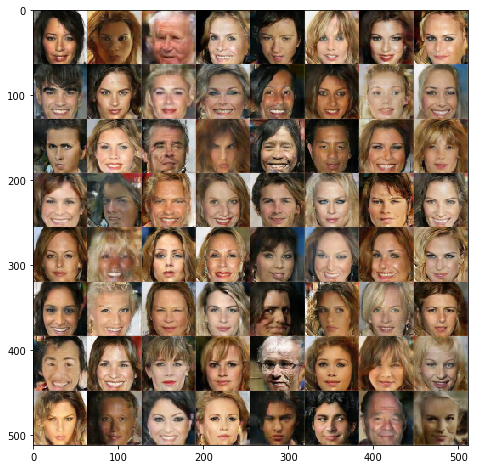

In [57]:
last_sample = cv2.imread('./sample_faces/train_24_2839.png')[:,:,[2,1,0]]
fig = plt.figure(figsize=(8,8))
plt.imshow(last_sample);

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [58]:
seed_0 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
seed_1 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
batchz = np.array([a*seed_0 + (1-a)*seed_1 for a in np.arange(start=0.0, stop=1.0, step=1/64)])

In [61]:
with tf.Session() as sess:
    load(sess, './checkpoint')
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

INFO:tensorflow:Restoring parameters from ./checkpoint/dcgan.model


In [64]:
save_images(samples, [MERGE_X, MERGE_X], 'face_interp.png')

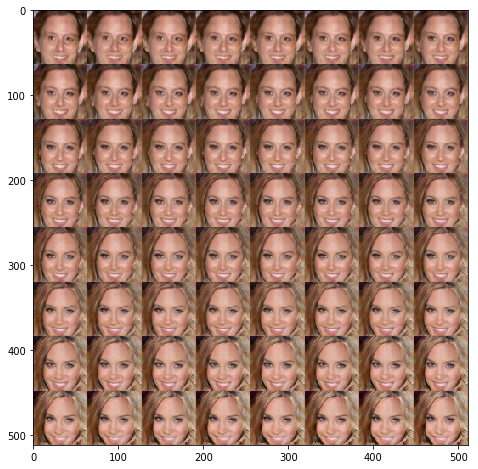

In [65]:
face_interp = cv2.imread('./face_interp.png')[:,:,[2,1,0]]
fig = plt.figure(figsize=(8,8))
plt.imshow(face_interp);

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

In [66]:
samplez = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

with tf.Session() as sess:
    load(sess, './checkpoint')
    samples = sess.run(G, feed_dict={z: samplez, is_training: False} )
    save_images(samples, [MERGE_X, MERGE_X], 'smiles_vectors.png')

INFO:tensorflow:Restoring parameters from ./checkpoint/dcgan.model


In [67]:
good_smile_idxs = [4,5,6,7,11,13,15,17,21,22,23,27,28,29,31,32,34,35,36,37,38,39,42,45,47,49,53,55,57,59,60,63]
no_smile_idxs = [1,2,3,8,10,16,19,20,24,25,26,33,41,43,44,46,48,50,51,58,61,62]

smile_vectors = samplez[good_smile_idxs]
nosmile_vectors = samplez[no_smile_idxs]

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

In [72]:
smile_vector = np.mean(smile_vectors, axis=0)
nosmile_vector = np.mean(nosmile_vectors, axis=0)

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [77]:
smile_batch = np.array([a*smile_vector + (1-a)*nosmile_vector for a in np.arange(start=0.0, stop=1.0, step=1/64)])

In [78]:
with tf.Session() as sess:
    load(sess, './checkpoint')
    samples = sess.run(G, feed_dict={z: smile_batch, is_training: False} )
    save_images(samples, [MERGE_X, MERGE_X], 'smiles_interp.png')

INFO:tensorflow:Restoring parameters from ./checkpoint/dcgan.model


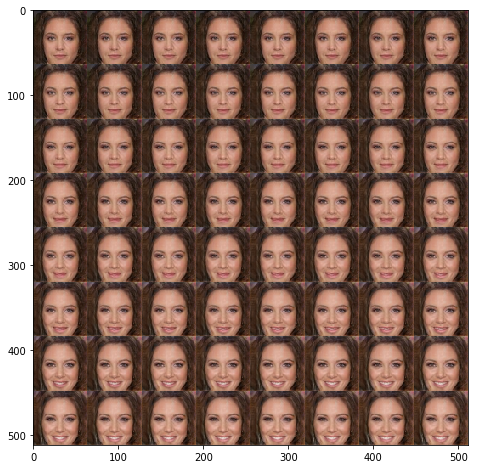

In [79]:
smiles_interp = cv2.imread('./smiles_interp.png')[:,:,[2,1,0]]
fig = plt.figure(figsize=(8,8))
plt.imshow(smiles_interp);

In [95]:
smile_batch_b = np.array([seed_0 + a*smile_vector + (1-a)*nosmile_vector for a in np.arange(start=0.0, stop=1.0, step=1/64)])

In [96]:
with tf.Session() as sess:
    load(sess, './checkpoint')
    samples = sess.run(G, feed_dict={z: smile_batch_b, is_training: False} )
    save_images(samples, [MERGE_X, MERGE_X], 'smiles_interp_b.png')

INFO:tensorflow:Restoring parameters from ./checkpoint/dcgan.model


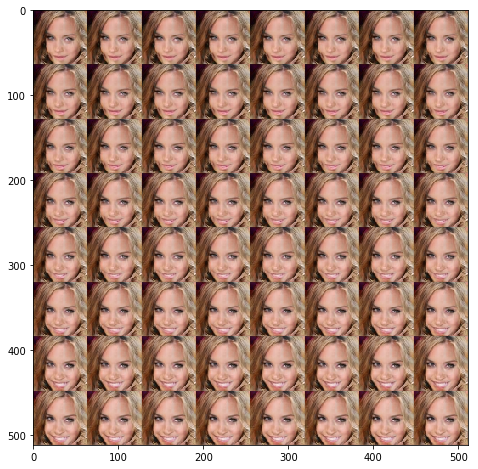

In [97]:
smiles_interp_b = cv2.imread('./smiles_interp_b.png')[:,:,[2,1,0]]
fig = plt.figure(figsize=(8,8))
plt.imshow(smiles_interp_b);

If faces looks really cool, add bonus 1 point to your score.